# Removing labelled data from unlabelled

In [1]:
import pandas as pd

pd.set_option('display.max_rows', 50)

clinical_data = pd.read_excel("TRAIN/Training_Unlabeled_Clinical_Data.xlsx")
biomarker_data = pd.read_csv("TRAIN/Training_Biomarker_Data.csv")

# Extract Meta Data
meta = clinical_data["File_Path"].str.split("/", expand=True)
meta = meta.drop(0, axis=1)
meta.columns = ["Trial", "Arm", "Folder", "Visit", "Eye", "Image_Name"]
clinical_data[meta.columns] = meta

# Fix missing meta columns
idx = clinical_data["Image_Name"].isna()
clinical_data.loc[idx, ["Folder", "Visit", "Eye", "Image_Name"]] = clinical_data.loc[idx, ["Arm", "Folder", "Visit", "Eye"]].values
clinical_data.loc[idx, "Arm"] = None

columns = biomarker_data.columns.tolist()
columns[0] = clinical_data.columns[0]
biomarker_data.columns = columns

biomarker_clinical = pd.merge(biomarker_data, clinical_data, on="File_Path", how="left")

missing_idx = lambda x: x["Eye_ID"].isna()

meta = biomarker_clinical.loc[missing_idx, "File_Path"].str.split("/", expand=True)
meta = meta.drop(0, axis=1)
meta.columns = ["Trial", "Folder", "Visit", "Eye", "Image_Name"]
biomarker_clinical.loc[missing_idx, meta.columns] = meta

biomarker_clinical.loc[missing_idx, "Eye_ID"] = 79

In [2]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

labels = ["B1", "B2", "B3", "B4", "B5", "B6"]

eye_ids = biomarker_clinical.groupby("Eye_ID")[["B1", "B2", "B3", "B4", "B5", "B6"]].mean().round().astype(int)

mskf = MultilabelStratifiedKFold(n_splits=8, shuffle=True, random_state=3000)

train_index, test_index = next(iter(mskf.split(eye_ids.index, eye_ids)))

In [3]:
train_ids, val_ids = eye_ids.index[train_index], eye_ids.index[test_index]
train_df = biomarker_clinical.loc[lambda x: x["Eye_ID"].isin(train_ids), ["File_Path"] + labels]
val_df = biomarker_clinical.loc[lambda x: x["Eye_ID"].isin(val_ids), ["File_Path"] + labels]

In [4]:
name = []
name.extend(train_df[train_df.columns[0]].values.tolist())
name.extend(val_df[val_df.columns[0]].values.tolist())

clinical_data.drop(columns=clinical_data.columns[1:], inplace=True)
clinical_data = clinical_data[clinical_data['File_Path'].apply(lambda x: x not in name)]
clinical_data.reset_index(drop=True, inplace=True)

clinical_data

File_Path
0      /TREX DME/GILA/0234GOD/V10/OD/TREXW_000025.tif
1      /TREX DME/GILA/0234GOD/V10/OD/TREXW_000000.tif
2      /TREX DME/GILA/0234GOD/V10/OD/TREXW_000001.tif
3      /TREX DME/GILA/0234GOD/V10/OD/TREXW_000002.tif
4      /TREX DME/GILA/0234GOD/V10/OD/TREXW_000003.tif
...                                               ...
68870   /TREX DME/GILA/0229GOD/V9/OD/TREXE_000044.tif
68871   /TREX DME/GILA/0229GOD/V9/OD/TREXE_000045.tif
68872   /TREX DME/GILA/0229GOD/V9/OD/TREXE_000046.tif
68873   /TREX DME/GILA/0229GOD/V9/OD/TREXE_000047.tif
68874   /TREX DME/GILA/0229GOD/V9/OD/TREXE_000048.tif

[68875 rows x 1 columns]

In [5]:
clinical_data["File_Path"] = "TRAIN/OLIVES" + clinical_data["File_Path"]

# biomarker count

In [6]:
biomarker_data["B1"].value_counts(), biomarker_data["B2"].value_counts(), biomarker_data["B3"].value_counts(), biomarker_data["B4"].value_counts(), biomarker_data["B5"].value_counts(), biomarker_data["B6"].value_counts()

(1    6341
 0    3067
 Name: B1, dtype: int64,
 0    6424
 1    2984
 Name: B2, dtype: int64,
 1    5222
 0    4186
 Name: B3, dtype: int64,
 0    6572
 1    2836
 Name: B4, dtype: int64,
 0    6405
 1    3003
 Name: B5, dtype: int64,
 0    5320
 1    4088
 Name: B6, dtype: int64)

# Initialization

In [7]:
%matplotlib inline
from PIL import Image
import torch.utils.data as data
import os
import math
import copy
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from torchsummary import summary
import torch
import torchvision
from sklearn.metrics import accuracy_score
# import skimage
from skimage.io import imread
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import sys
import time
import numpy as np
from sklearn.metrics import f1_score
from sklearn import metrics

from __future__ import print_function

import math
import numpy as np
import torch
import torch.optim as optim
import os
from sklearn.metrics import f1_score
import torch.backends.cudnn as cudnn
from torchvision import transforms, datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision

In [8]:
import os
import random

import numpy as np
import torch

SEED = 3000

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(SEED)

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Device

In [10]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Teacher Model

In [11]:
model = torchvision.models.resnet50(weights=None,zero_init_residual=True)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Identity(),
    nn.Sequential(
        nn.Linear(2048, 512),
        nn.Linear(512, 6)
    )
)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model = model.to(device)

In [12]:
ckpt = torch.load("models/18_vip_cup_student_one_finetune_random_weight_epoch_26.pth", map_location='cpu')
state_dict = ckpt['model']

model.load_state_dict(state_dict)

<All keys matched successfully>

# DataLoader

In [13]:
class RECOVERY(data.Dataset):
    def __init__(self,df, transforms):
        self.transforms = transforms
        self.df = df
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.iloc[idx,0]
        image = Image.open(path).convert("L")
        image = np.array(image)
        image = Image.fromarray(image)
        image = self.transforms(image)
        return image

In [14]:
normalize = transforms.Normalize(mean=.1706, std=.2112)

train_transform = transforms.Compose([
        transforms.RandomResizedCrop(size=224, scale=(0.7, 1.)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([
            transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
        ], p=0.8),
        transforms.RandomPerspective(distortion_scale=0.2, p=0.4, fill=256),
        transforms.RandomRotation(degrees = (-6, 6), fill=256),
        transforms.RandomGrayscale(p=0.2),
        transforms.ToTensor(),
        normalize,
    ])
val_transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomPerspective(distortion_scale=0.2, p=0.4, fill=256),
        transforms.RandomRotation(degrees = (-6, 6), fill=256),
        transforms.ToTensor(),
        normalize,
    ])

In [15]:
dataset = RECOVERY(clinical_data, transforms = val_transform)

In [16]:
loader = torch.utils.data.DataLoader(
        dataset, batch_size=64, shuffle=False,
        num_workers=0, pin_memory=True,drop_last=False)

# Pseudo label generation

In [17]:
threshold = {
     'B4':[0.08, 0.75],
     'B3':[0.3, 0.8],
     'B2':[0.1, 0.7],
     'B5':[0.25, 0.75],
     'B1':[0.3, 0.8],
     'B6':[0.25, 0.75],
}
soft_label = []

In [41]:
model.eval()
with torch.no_grad():
     for idx, image in (enumerate(loader)):
            image = image.to(device)
            output= model(image)
            output = torch.sigmoid(output)
            print(f"Predicted pseudolabel: {output}")
            soft_label.extend(output.cpu().numpy())

Predicted pseudolabel: tensor([[0.5450, 0.0688, 0.9622, 0.3446, 0.0597, 0.1406],
        [0.6285, 0.9972, 0.0025, 0.4291, 0.0610, 0.2500],
        [0.8563, 0.9931, 0.0048, 0.3606, 0.0860, 0.1893],
        [0.5481, 0.9668, 0.0320, 0.5415, 0.0195, 0.1101],
        [0.7307, 0.7451, 0.4145, 0.3105, 0.0435, 0.1364],
        [0.8714, 0.8820, 0.2453, 0.8506, 0.0646, 0.2353],
        [0.4745, 0.8433, 0.3757, 0.3363, 0.0416, 0.1849],
        [0.9199, 0.6513, 0.5412, 0.2365, 0.0684, 0.1402],
        [0.9898, 0.9707, 0.0759, 0.1499, 0.0512, 0.1170],
        [0.9941, 0.1347, 0.9592, 0.3926, 0.0335, 0.1162],
        [0.9315, 0.1411, 0.9057, 0.5944, 0.0682, 0.1950],
        [0.9976, 0.8495, 0.1605, 0.5043, 0.0727, 0.1477],
        [0.9731, 0.3349, 0.7410, 0.1092, 0.1215, 0.2444],
        [0.9594, 0.4425, 0.7088, 0.7233, 0.1308, 0.3207],
        [0.9933, 0.1713, 0.8653, 0.9492, 0.0968, 0.2599],
        [0.9978, 0.3969, 0.6701, 0.7579, 0.1885, 0.3059],
        [0.9933, 0.1612, 0.8630, 0.7496, 0.2791, 

Predicted pseudolabel: tensor([[0.9901, 0.3617, 0.8824, 0.2463, 0.0664, 0.2946],
        [0.9278, 0.7901, 0.3550, 0.4487, 0.0228, 0.1900],
        [0.8343, 0.8534, 0.1922, 0.2367, 0.0749, 0.5068],
        [0.8054, 0.5201, 0.7339, 0.1877, 0.0990, 0.3529],
        [0.9931, 0.0670, 0.9489, 0.0859, 0.2141, 0.1830],
        [0.3124, 0.9943, 0.0034, 0.4496, 0.0179, 0.0912],
        [0.7977, 0.9806, 0.0186, 0.3648, 0.0350, 0.1370],
        [0.5504, 0.9407, 0.0739, 0.4803, 0.0226, 0.1473],
        [0.8471, 0.9272, 0.1109, 0.2446, 0.0636, 0.1557],
        [0.4212, 0.9776, 0.0232, 0.3995, 0.0385, 0.2321],
        [0.7926, 0.8781, 0.3115, 0.4687, 0.0111, 0.0870],
        [0.9956, 0.8917, 0.1573, 0.2201, 0.0777, 0.1709],
        [0.8190, 0.9747, 0.0200, 0.8360, 0.0126, 0.1303],
        [0.9968, 0.8174, 0.4618, 0.0938, 0.1135, 0.1532],
        [0.9848, 0.3760, 0.8339, 0.3586, 0.0841, 0.3335],
        [0.9210, 0.9348, 0.0728, 0.4084, 0.0170, 0.1439],
        [0.9983, 0.0666, 0.9429, 0.7949, 0.0472, 

Predicted pseudolabel: tensor([[8.7930e-01, 1.7083e-01, 9.1154e-01, 2.2594e-01, 4.7414e-02, 3.2420e-01],
        [4.9892e-01, 1.2453e-01, 9.4277e-01, 1.7840e-01, 2.3034e-02, 1.7317e-01],
        [8.2968e-01, 5.2505e-02, 9.7216e-01, 2.6807e-01, 2.4953e-02, 1.2914e-01],
        [5.2877e-01, 6.6819e-01, 6.1948e-01, 2.8169e-01, 6.8838e-03, 7.5681e-02],
        [2.5779e-01, 9.2745e-01, 1.6441e-01, 2.5206e-01, 5.8641e-03, 9.8081e-02],
        [2.1254e-01, 9.6804e-01, 7.3478e-02, 3.7876e-01, 1.1789e-03, 3.9300e-02],
        [3.6630e-01, 9.9219e-01, 2.0125e-02, 2.1017e-01, 4.6440e-03, 8.4256e-02],
        [3.0517e-01, 9.9737e-01, 2.5013e-03, 5.6337e-01, 3.1148e-03, 4.2796e-02],
        [5.0344e-01, 5.9472e-02, 8.4817e-01, 9.6571e-01, 2.2887e-02, 1.3076e-01],
        [9.7437e-01, 9.9654e-01, 6.5466e-04, 8.5234e-01, 8.0836e-01, 8.0113e-01],
        [9.1737e-01, 9.9912e-01, 1.9410e-04, 9.2949e-01, 9.4069e-01, 8.5189e-01],
        [8.9834e-01, 9.9130e-01, 4.7684e-03, 6.2439e-01, 9.4394e-01, 9.6147

Predicted pseudolabel: tensor([[0.9673, 0.0253, 0.9827, 0.0817, 0.9970, 0.9993],
        [0.9763, 0.0342, 0.9808, 0.0687, 0.9883, 0.9975],
        [0.9919, 0.0599, 0.9610, 0.1377, 0.9946, 0.9958],
        [0.9657, 0.0250, 0.9837, 0.0576, 0.9970, 0.9993],
        [0.9650, 0.0970, 0.9274, 0.1162, 0.9983, 0.9995],
        [0.9833, 0.4750, 0.3401, 0.1201, 0.9994, 0.9995],
        [0.9977, 0.0095, 0.9954, 0.3393, 0.9935, 0.9968],
        [0.9959, 0.0851, 0.9576, 0.1698, 0.9984, 0.9979],
        [0.9970, 0.4229, 0.3735, 0.1085, 0.9997, 0.9997],
        [0.9951, 0.6258, 0.2630, 0.0676, 0.9985, 0.9994],
        [0.9683, 0.2375, 0.8301, 0.1250, 0.9949, 0.9974],
        [0.9599, 0.8621, 0.0830, 0.1590, 0.9967, 0.9990],
        [0.9956, 0.8928, 0.0562, 0.1317, 0.9992, 0.9991],
        [0.9919, 0.9799, 0.0115, 0.3111, 0.9981, 0.9944],
        [0.9695, 0.9939, 0.0030, 0.2351, 0.9781, 0.9558],
        [0.9637, 0.9821, 0.0130, 0.2695, 0.9958, 0.9966],
        [0.9725, 0.7526, 0.3432, 0.1943, 0.9917, 

Predicted pseudolabel: tensor([[0.9451, 0.0282, 0.9681, 0.1224, 0.6782, 0.9395],
        [0.8642, 0.0285, 0.9736, 0.0872, 0.5264, 0.9131],
        [0.6739, 0.0332, 0.9567, 0.1121, 0.5639, 0.9086],
        [0.9520, 0.1367, 0.9218, 0.1382, 0.6038, 0.7408],
        [0.8170, 0.0705, 0.9308, 0.1097, 0.7969, 0.8871],
        [0.6849, 0.1348, 0.8998, 0.0936, 0.2904, 0.7387],
        [0.8384, 0.0705, 0.9489, 0.1105, 0.3546, 0.7830],
        [0.3605, 0.1118, 0.9092, 0.0979, 0.0418, 0.1988],
        [0.7737, 0.1497, 0.9060, 0.0677, 0.5340, 0.7921],
        [0.9478, 0.2598, 0.8877, 0.1063, 0.3823, 0.6595],
        [0.8168, 0.2874, 0.8727, 0.1401, 0.0204, 0.1398],
        [0.9223, 0.1317, 0.9490, 0.0889, 0.1088, 0.2548],
        [0.8150, 0.3120, 0.8020, 0.1706, 0.4379, 0.6248],
        [0.9221, 0.0790, 0.9623, 0.7794, 0.2646, 0.4306],
        [0.9907, 0.0268, 0.9868, 0.0641, 0.8989, 0.9642],
        [0.9399, 0.0149, 0.9867, 0.0961, 0.9671, 0.9959],
        [0.9357, 0.0110, 0.9791, 0.0472, 0.9734, 

Predicted pseudolabel: tensor([[9.9605e-01, 9.4823e-01, 5.1938e-02, 1.9885e-01, 9.9211e-01, 9.8456e-01],
        [9.5933e-01, 9.8738e-01, 3.0919e-03, 1.7071e-01, 9.9700e-01, 9.9863e-01],
        [9.8135e-01, 9.7737e-01, 7.9170e-03, 1.1332e-01, 9.9731e-01, 9.9891e-01],
        [9.8135e-01, 9.9437e-01, 1.1309e-03, 1.7677e-01, 9.9742e-01, 9.9548e-01],
        [9.7936e-01, 9.8998e-01, 2.8661e-03, 5.0322e-01, 9.9463e-01, 9.9559e-01],
        [9.3952e-01, 9.8218e-01, 1.1407e-02, 2.0373e-01, 9.6729e-01, 9.7813e-01],
        [9.5854e-01, 9.8862e-01, 2.8646e-03, 2.3497e-01, 9.8182e-01, 9.9307e-01],
        [9.9414e-01, 9.7773e-01, 2.7702e-03, 1.2213e-01, 9.9551e-01, 9.9732e-01],
        [8.4391e-01, 9.8951e-01, 8.6162e-04, 2.7297e-01, 9.0579e-01, 9.6325e-01],
        [9.5493e-01, 9.9221e-01, 1.7995e-03, 3.1157e-01, 8.7734e-01, 8.3312e-01],
        [8.6057e-01, 9.4008e-01, 2.5428e-03, 2.4262e-01, 9.5650e-01, 9.9102e-01],
        [9.8002e-01, 9.6060e-01, 4.0483e-03, 2.8500e-01, 9.5614e-01, 9.7909

Predicted pseudolabel: tensor([[0.9186, 0.0955, 0.9575, 0.0864, 0.2645, 0.2369],
        [0.6098, 0.1265, 0.8927, 0.0799, 0.2748, 0.2812],
        [0.8127, 0.0633, 0.9629, 0.2876, 0.9757, 0.9870],
        [0.9248, 0.1409, 0.8904, 0.1499, 0.9733, 0.9846],
        [0.9661, 0.0800, 0.9399, 0.1531, 0.9931, 0.9978],
        [0.9491, 0.3466, 0.6361, 0.0723, 0.9872, 0.9976],
        [0.9932, 0.1928, 0.8347, 0.1154, 0.9967, 0.9993],
        [0.9515, 0.1510, 0.8766, 0.1826, 0.9976, 0.9995],
        [0.9869, 0.2421, 0.7888, 0.1846, 0.9951, 0.9984],
        [0.9819, 0.1653, 0.8332, 0.1208, 0.9979, 0.9994],
        [0.9967, 0.3755, 0.5269, 0.0740, 0.9986, 0.9993],
        [0.9727, 0.3643, 0.6695, 0.1620, 0.9983, 0.9992],
        [0.9764, 0.2758, 0.6843, 0.1426, 0.9900, 0.9957],
        [0.9891, 0.4897, 0.4642, 0.1103, 0.9982, 0.9990],
        [0.9855, 0.3873, 0.6225, 0.1041, 0.9961, 0.9978],
        [0.9827, 0.5979, 0.4215, 0.1669, 0.9989, 0.9992],
        [0.9876, 0.8098, 0.1839, 0.2103, 0.9993, 

Predicted pseudolabel: tensor([[6.8692e-01, 8.1374e-02, 9.4478e-01, 9.9539e-02, 2.9644e-02, 1.2649e-01],
        [4.0689e-01, 5.7205e-01, 2.2870e-01, 9.8863e-02, 1.9200e-02, 1.4087e-01],
        [7.1351e-01, 1.1302e-01, 9.3673e-01, 1.0060e-01, 1.2891e-01, 1.9236e-01],
        [6.2787e-01, 1.0325e-01, 9.4044e-01, 1.0131e-01, 5.3816e-02, 1.2623e-01],
        [9.1968e-01, 4.6574e-02, 9.6779e-01, 6.7542e-02, 1.4234e-01, 2.5715e-01],
        [6.8858e-01, 3.4404e-01, 7.4208e-01, 5.8602e-02, 1.4853e-01, 1.8444e-01],
        [9.6183e-01, 3.0169e-01, 6.7445e-01, 4.0189e-02, 7.7984e-01, 8.5552e-01],
        [9.7210e-01, 1.9920e-02, 9.9004e-01, 1.0836e-01, 9.2589e-01, 9.5832e-01],
        [9.6892e-01, 2.3120e-02, 9.8549e-01, 1.5732e-01, 7.4706e-01, 8.4911e-01],
        [7.9044e-01, 3.8504e-02, 9.7370e-01, 6.1459e-02, 9.5002e-01, 9.9314e-01],
        [8.6002e-01, 2.0677e-02, 9.8314e-01, 6.1540e-02, 9.8238e-01, 9.9836e-01],
        [8.9811e-01, 4.1191e-02, 9.5946e-01, 7.8653e-02, 9.8706e-01, 9.9894

Predicted pseudolabel: tensor([[7.8377e-01, 9.8588e-01, 4.3865e-03, 5.3259e-01, 4.5372e-01, 7.8959e-01],
        [8.9403e-01, 9.4117e-01, 1.9492e-02, 5.4253e-01, 4.6862e-01, 7.9894e-01],
        [8.7925e-01, 8.5863e-01, 1.7520e-02, 4.2953e-01, 6.9004e-01, 9.6350e-01],
        [9.3344e-01, 8.8095e-01, 1.2780e-02, 3.5504e-01, 5.7946e-01, 8.8650e-01],
        [9.5541e-01, 9.1364e-01, 2.4030e-02, 6.1669e-01, 6.1645e-01, 7.3134e-01],
        [9.7117e-01, 9.6435e-01, 1.5777e-02, 6.4346e-01, 6.0822e-01, 7.0570e-01],
        [9.2942e-01, 9.8156e-01, 1.1534e-02, 8.4297e-01, 6.7860e-01, 9.2317e-01],
        [6.7293e-01, 9.8522e-01, 7.6677e-03, 8.2854e-01, 7.0216e-01, 9.4056e-01],
        [8.4787e-01, 9.4837e-01, 2.2603e-02, 4.4381e-01, 6.3455e-01, 9.5445e-01],
        [9.9942e-01, 1.2976e-01, 8.9666e-01, 9.2589e-02, 9.9943e-01, 9.9867e-01],
        [6.4461e-01, 5.9573e-02, 9.6633e-01, 1.8184e-01, 9.3608e-01, 8.4469e-01],
        [9.0378e-01, 2.5926e-02, 9.8101e-01, 1.2930e-01, 9.7268e-01, 9.6659

Predicted pseudolabel: tensor([[9.9606e-01, 1.2943e-01, 8.8229e-01, 3.5873e-01, 9.9339e-01, 9.9742e-01],
        [9.9806e-01, 3.6768e-01, 6.8309e-01, 2.8166e-01, 9.9402e-01, 9.9688e-01],
        [9.9790e-01, 1.8264e-01, 8.3190e-01, 4.8587e-01, 9.9774e-01, 9.9908e-01],
        [9.9267e-01, 2.8994e-01, 8.3713e-01, 2.1510e-01, 9.9667e-01, 9.8845e-01],
        [9.9895e-01, 4.7961e-01, 5.3726e-01, 9.0148e-02, 9.9827e-01, 9.9927e-01],
        [9.9283e-01, 6.5767e-01, 3.6918e-01, 1.7768e-01, 9.9737e-01, 9.9395e-01],
        [9.5598e-01, 7.9206e-01, 1.2870e-01, 1.4527e-01, 9.9435e-01, 9.8955e-01],
        [9.9647e-01, 7.1646e-01, 2.6202e-01, 2.2459e-01, 9.9636e-01, 9.9233e-01],
        [9.9845e-01, 4.9168e-01, 4.8516e-01, 1.8702e-01, 9.9890e-01, 9.9705e-01],
        [9.9915e-01, 5.8087e-01, 4.3520e-01, 3.4427e-01, 9.9888e-01, 9.9664e-01],
        [9.9971e-01, 7.9615e-01, 1.5195e-01, 1.5184e-01, 9.9895e-01, 9.9823e-01],
        [9.9537e-01, 8.5506e-01, 1.0826e-01, 4.2805e-01, 9.9890e-01, 9.9924

Predicted pseudolabel: tensor([[0.7358, 0.1238, 0.8968, 0.1676, 0.3831, 0.5536],
        [0.6800, 0.1006, 0.9136, 0.1436, 0.3087, 0.4418],
        [0.8277, 0.3460, 0.7269, 0.1187, 0.6486, 0.5541],
        [0.9609, 0.0347, 0.9767, 0.0604, 0.2859, 0.2713],
        [0.4743, 0.1373, 0.8731, 0.0692, 0.1035, 0.2254],
        [0.4926, 0.2839, 0.6222, 0.1072, 0.3060, 0.4562],
        [0.7472, 0.1102, 0.9213, 0.0664, 0.1922, 0.2153],
        [0.8100, 0.1387, 0.8842, 0.1686, 0.1842, 0.2629],
        [0.9741, 0.2341, 0.8378, 0.0720, 0.1929, 0.1930],
        [0.7675, 0.3004, 0.7393, 0.0611, 0.2401, 0.2463],
        [0.9887, 0.2868, 0.8275, 0.0635, 0.6608, 0.3719],
        [0.9103, 0.0620, 0.9667, 0.1134, 0.1874, 0.1955],
        [0.9259, 0.4466, 0.5909, 0.0492, 0.7481, 0.5960],
        [0.9739, 0.1374, 0.9248, 0.1122, 0.8756, 0.8956],
        [0.9579, 0.1069, 0.9101, 0.0673, 0.9827, 0.9931],
        [0.9963, 0.1569, 0.9132, 0.2010, 0.9882, 0.9748],
        [0.8916, 0.1073, 0.9136, 0.0672, 0.9881, 

Predicted pseudolabel: tensor([[9.5888e-01, 9.9655e-01, 4.7404e-04, 2.2712e-01, 1.7185e-01, 3.3099e-01],
        [6.9427e-01, 9.9521e-01, 6.9446e-04, 4.1332e-01, 8.8253e-02, 2.3568e-01],
        [4.6813e-01, 9.9178e-01, 3.9248e-04, 3.2110e-01, 6.6708e-02, 1.7877e-01],
        [5.2119e-01, 9.3352e-01, 6.4054e-03, 5.1558e-01, 1.2147e-01, 2.0566e-01],
        [3.4479e-01, 9.8680e-01, 1.3103e-03, 2.8387e-01, 6.3737e-02, 1.8881e-01],
        [3.2268e-01, 9.7997e-01, 2.7703e-03, 3.9306e-01, 3.1791e-02, 1.2752e-01],
        [3.0427e-01, 9.8086e-01, 2.2367e-03, 3.0262e-01, 1.9303e-02, 1.0575e-01],
        [1.5390e-01, 9.7990e-01, 1.6958e-03, 1.8573e-01, 6.6000e-03, 5.2552e-02],
        [3.2493e-01, 9.3590e-01, 1.6540e-03, 2.9524e-01, 3.7261e-02, 1.0845e-01],
        [7.1054e-01, 9.5867e-01, 8.8741e-03, 5.3406e-01, 2.2994e-01, 3.6680e-01],
        [5.2567e-01, 9.7099e-01, 9.7044e-03, 2.4386e-01, 3.7950e-02, 1.5562e-01],
        [1.7170e-01, 9.5043e-01, 5.5984e-03, 3.2516e-01, 1.1184e-02, 9.1440

Predicted pseudolabel: tensor([[9.9997e-01, 9.9824e-01, 1.8582e-04, 6.3233e-01, 9.9746e-01, 9.8936e-01],
        [9.9962e-01, 9.9669e-01, 3.8839e-04, 5.8409e-01, 9.8911e-01, 9.8523e-01],
        [9.9994e-01, 9.9060e-01, 5.3501e-03, 5.2842e-01, 9.8291e-01, 9.0591e-01],
        [9.9991e-01, 9.9858e-01, 2.4332e-04, 6.6732e-01, 9.8638e-01, 9.1176e-01],
        [9.9468e-01, 9.9919e-01, 2.1468e-04, 6.1367e-01, 9.4554e-01, 9.2412e-01],
        [9.9830e-01, 9.9976e-01, 4.1599e-05, 5.3322e-01, 8.3100e-01, 8.4769e-01],
        [9.9656e-01, 9.9930e-01, 2.8733e-04, 6.3776e-01, 8.4034e-01, 8.6246e-01],
        [8.0319e-01, 9.9825e-01, 3.4230e-04, 3.0925e-01, 6.7244e-02, 2.7069e-01],
        [6.4185e-01, 9.9904e-01, 3.5009e-05, 3.8174e-01, 1.3961e-01, 2.9984e-01],
        [5.7455e-01, 9.9986e-01, 1.0223e-05, 3.3561e-01, 9.2886e-02, 5.1931e-01],
        [8.5851e-01, 9.9950e-01, 3.0828e-05, 4.9310e-01, 2.7932e-01, 8.4870e-01],
        [5.9539e-01, 9.9601e-01, 1.3851e-03, 3.9244e-01, 4.3194e-02, 2.6133

Predicted pseudolabel: tensor([[4.4341e-01, 9.8324e-01, 2.1745e-03, 2.4218e-01, 9.0658e-02, 1.8606e-01],
        [5.5131e-01, 9.5966e-01, 4.0143e-03, 3.2380e-01, 1.4980e-01, 2.6074e-01],
        [1.3113e-01, 9.8233e-01, 2.0238e-03, 3.1798e-01, 2.3748e-02, 9.0225e-02],
        [6.7363e-01, 9.7066e-01, 5.8751e-03, 4.1133e-01, 1.5947e-01, 2.4617e-01],
        [3.9739e-01, 9.8345e-01, 3.6434e-03, 3.8000e-01, 7.3575e-02, 2.2271e-01],
        [9.9092e-01, 9.6145e-01, 6.3269e-03, 1.3412e-01, 2.9874e-01, 2.5758e-01],
        [1.6350e-01, 9.9849e-01, 1.0426e-04, 6.5723e-01, 6.8053e-03, 7.6094e-02],
        [9.2745e-01, 9.7619e-01, 5.5002e-03, 2.6239e-01, 2.2340e-01, 3.0786e-01],
        [9.9850e-01, 8.6608e-01, 1.0013e-02, 5.1920e-01, 5.1040e-01, 5.3493e-01],
        [9.2918e-01, 9.8197e-01, 2.3687e-03, 4.2022e-01, 6.5535e-01, 8.3284e-01],
        [9.9984e-01, 9.8262e-01, 1.1176e-03, 5.1700e-01, 9.3459e-01, 9.3993e-01],
        [9.9949e-01, 9.7062e-01, 2.3099e-03, 4.3086e-01, 8.5358e-01, 9.7274

Predicted pseudolabel: tensor([[3.4061e-01, 9.9942e-01, 1.0647e-04, 2.2693e-01, 1.3822e-02, 1.1980e-01],
        [4.3409e-01, 9.9743e-01, 4.4194e-04, 3.7019e-01, 8.1453e-02, 2.7151e-01],
        [2.6033e-01, 9.9812e-01, 5.7327e-04, 2.5929e-01, 3.9440e-03, 6.7294e-02],
        [7.6611e-01, 9.9812e-01, 4.9984e-04, 3.8892e-01, 4.0034e-01, 7.6171e-01],
        [9.3607e-01, 8.5852e-01, 1.7050e-01, 1.4190e-01, 8.0302e-01, 9.6706e-01],
        [8.4868e-01, 2.3351e-01, 7.8533e-01, 7.1798e-02, 4.8118e-01, 9.0793e-01],
        [9.2520e-01, 6.9719e-01, 3.9457e-01, 8.9573e-02, 8.3738e-01, 9.5921e-01],
        [6.4884e-01, 9.7260e-01, 1.7773e-02, 2.4117e-01, 5.2523e-01, 8.6060e-01],
        [8.6533e-01, 9.7503e-01, 6.7733e-03, 1.7358e-01, 5.4027e-01, 9.1332e-01],
        [7.0025e-01, 9.9294e-01, 3.1391e-03, 2.8737e-01, 4.3385e-01, 8.0855e-01],
        [6.5354e-01, 9.9151e-01, 1.6336e-03, 1.8513e-01, 4.1639e-01, 6.5290e-01],
        [6.1247e-01, 9.8285e-01, 3.9770e-03, 2.1784e-01, 1.2962e-01, 3.2462

Predicted pseudolabel: tensor([[4.1464e-01, 5.3758e-02, 9.6882e-01, 2.3043e-01, 1.2277e-02, 1.3314e-01],
        [5.3645e-01, 6.2886e-02, 9.5561e-01, 9.5951e-01, 1.0850e-02, 1.1454e-01],
        [2.5706e-01, 6.1544e-02, 9.4929e-01, 8.0970e-01, 4.0522e-03, 5.3482e-02],
        [3.5704e-01, 2.7461e-02, 9.7544e-01, 2.8645e-01, 1.5535e-02, 7.8001e-02],
        [3.5234e-01, 9.6527e-03, 9.9225e-01, 3.3590e-01, 2.2348e-03, 5.1304e-02],
        [1.8678e-01, 1.1743e-02, 9.8843e-01, 3.9042e-01, 3.8020e-04, 1.4970e-02],
        [2.1322e-01, 5.1830e-02, 9.6131e-01, 1.0953e-01, 5.8983e-03, 6.0479e-02],
        [1.6634e-01, 1.7640e-01, 8.8507e-01, 1.7838e-01, 2.2749e-02, 1.0273e-01],
        [9.2938e-02, 2.7495e-01, 8.5338e-01, 1.4341e-01, 2.3985e-03, 3.6734e-02],
        [2.1619e-01, 3.0207e-02, 9.7139e-01, 3.3868e-01, 2.9104e-03, 4.2517e-02],
        [3.0195e-01, 1.0057e-02, 9.8857e-01, 2.2646e-01, 1.9236e-03, 3.2947e-02],
        [2.5218e-01, 1.6752e-01, 8.9693e-01, 1.9658e-01, 1.3148e-02, 1.1415

Predicted pseudolabel: tensor([[4.8255e-01, 2.5911e-02, 9.7124e-01, 1.4037e-01, 6.7066e-03, 6.4851e-02],
        [2.3284e-01, 4.3150e-02, 9.5571e-01, 9.2834e-01, 1.8048e-03, 4.6056e-02],
        [3.0559e-01, 4.2542e-02, 9.4765e-01, 9.2627e-01, 4.4518e-03, 6.0468e-02],
        [3.2671e-01, 1.5355e-02, 9.6057e-01, 9.4162e-01, 4.2520e-03, 7.3525e-02],
        [1.6672e-01, 3.2155e-02, 9.6924e-01, 1.8875e-01, 9.3561e-04, 2.6456e-02],
        [3.1823e-01, 5.2953e-02, 9.3159e-01, 9.4803e-01, 7.4759e-03, 8.8047e-02],
        [2.6353e-01, 4.0538e-02, 9.6108e-01, 5.3276e-01, 1.8835e-02, 6.7181e-02],
        [2.5315e-01, 4.7793e-02, 9.1244e-01, 3.8128e-01, 4.6334e-03, 4.1332e-02],
        [2.2521e-01, 1.2859e-01, 9.1036e-01, 9.6946e-01, 7.6258e-03, 8.3262e-02],
        [1.9589e-01, 5.3214e-02, 9.6476e-01, 1.3529e-01, 2.3899e-02, 6.5818e-02],
        [3.3011e-01, 4.0584e-02, 9.6625e-01, 1.4765e-01, 2.5003e-02, 1.0431e-01],
        [1.1721e-01, 1.6446e-01, 9.1934e-01, 2.5190e-01, 2.8932e-02, 9.3794

Predicted pseudolabel: tensor([[0.2506, 0.0711, 0.9506, 0.3037, 0.0256, 0.0844],
        [0.2350, 0.0438, 0.9276, 0.3841, 0.0117, 0.0392],
        [0.8472, 0.0530, 0.9757, 0.2802, 0.1437, 0.2353],
        [0.5513, 0.0573, 0.9692, 0.2267, 0.5058, 0.7143],
        [0.9371, 0.1998, 0.8564, 0.2915, 0.8008, 0.8468],
        [0.8159, 0.0065, 0.9893, 0.9707, 0.9753, 0.9992],
        [0.6632, 0.0232, 0.9702, 0.0722, 0.9863, 0.9989],
        [0.7904, 0.0146, 0.9889, 0.1021, 0.9886, 0.9992],
        [0.5173, 0.0417, 0.9580, 0.1297, 0.9803, 0.9993],
        [0.6852, 0.0626, 0.9281, 0.7334, 0.0571, 0.2171],
        [0.5628, 0.0695, 0.9203, 0.9828, 0.0485, 0.1802],
        [0.5039, 0.0495, 0.9511, 0.9430, 0.0243, 0.1182],
        [0.5105, 0.0564, 0.9577, 0.2418, 0.0799, 0.1378],
        [0.3378, 0.0235, 0.9705, 0.2167, 0.0075, 0.0551],
        [0.6496, 0.0206, 0.9815, 0.9951, 0.0151, 0.1174],
        [0.9843, 0.0057, 0.9920, 0.3314, 0.0262, 0.0958],
        [0.7128, 0.0081, 0.9925, 0.9265, 0.0016, 

Predicted pseudolabel: tensor([[3.0964e-01, 1.6859e-02, 9.6328e-01, 8.6959e-01, 1.3301e-02, 5.7792e-02],
        [1.1311e-01, 7.3803e-02, 9.4865e-01, 2.5239e-01, 4.0980e-03, 3.2402e-02],
        [5.3871e-01, 1.7194e-02, 9.6294e-01, 9.9699e-01, 1.5903e-02, 1.1295e-01],
        [8.0626e-01, 2.3283e-03, 9.8232e-01, 9.9984e-01, 1.2486e-03, 5.7911e-02],
        [2.1711e-01, 8.1307e-02, 9.4748e-01, 5.2552e-01, 1.3056e-02, 8.3299e-02],
        [1.6187e-01, 9.2730e-02, 9.5018e-01, 4.1568e-01, 8.3760e-03, 6.8205e-02],
        [1.2864e-01, 7.0849e-02, 9.5280e-01, 3.4916e-01, 2.1599e-03, 3.7782e-02],
        [5.1060e-01, 3.2151e-02, 9.7924e-01, 2.4855e-01, 5.4004e-02, 2.3294e-01],
        [6.7081e-01, 1.7774e-02, 9.8724e-01, 9.4262e-01, 1.1053e-02, 1.1203e-01],
        [1.9389e-01, 9.7512e-02, 9.5400e-01, 1.6522e-01, 4.4209e-03, 6.1327e-02],
        [4.2589e-01, 7.7512e-02, 9.3270e-01, 3.1297e-01, 3.0911e-02, 1.4381e-01],
        [2.4976e-01, 3.9787e-02, 9.6492e-01, 3.5260e-01, 2.6059e-03, 4.0626

Predicted pseudolabel: tensor([[6.1680e-01, 9.1898e-03, 9.9657e-01, 9.4872e-02, 9.6390e-01, 9.9969e-01],
        [9.3208e-01, 1.8412e-02, 9.9327e-01, 2.3927e-01, 6.3849e-01, 9.3665e-01],
        [4.7852e-01, 1.5488e-02, 9.8398e-01, 3.3853e-01, 5.8364e-03, 7.2590e-02],
        [5.2300e-01, 1.3832e-02, 9.8565e-01, 9.3671e-01, 4.9603e-03, 5.9025e-02],
        [5.4611e-01, 5.8364e-03, 9.8667e-01, 9.9269e-01, 8.0672e-04, 4.2950e-02],
        [1.8880e-01, 2.3455e-02, 9.6316e-01, 2.4030e-01, 1.7205e-03, 3.9758e-02],
        [4.2488e-01, 2.9394e-02, 9.0746e-01, 9.7015e-01, 3.9689e-03, 6.0008e-02],
        [2.7656e-01, 3.1089e-02, 9.6647e-01, 4.4157e-01, 6.2310e-04, 2.2513e-02],
        [6.8844e-01, 1.1312e-02, 9.8904e-01, 9.7681e-01, 2.2256e-03, 5.8819e-02],
        [3.2730e-01, 2.1259e-02, 9.6372e-01, 1.9834e-01, 5.7833e-03, 5.6833e-02],
        [3.1740e-01, 1.4739e-02, 9.6957e-01, 9.1684e-01, 1.6147e-03, 3.6954e-02],
        [2.1614e-01, 2.2088e-02, 9.5506e-01, 2.5077e-01, 2.8103e-03, 3.2100

Predicted pseudolabel: tensor([[0.8529, 0.0527, 0.9769, 0.3953, 0.0312, 0.2060],
        [0.3242, 0.1449, 0.9170, 0.5090, 0.0099, 0.0779],
        [0.3220, 0.1065, 0.9400, 0.4377, 0.0091, 0.0503],
        [0.8587, 0.0522, 0.9661, 0.8311, 0.0210, 0.0969],
        [0.2015, 0.2490, 0.8721, 0.2092, 0.0435, 0.0821],
        [0.2591, 0.1136, 0.9471, 0.1840, 0.1136, 0.1937],
        [0.8379, 0.1324, 0.8854, 0.3240, 0.0835, 0.1517],
        [0.5344, 0.1388, 0.9229, 0.5679, 0.1671, 0.2387],
        [0.9526, 0.0172, 0.9427, 0.9977, 0.2529, 0.6731],
        [0.8394, 0.0074, 0.9788, 0.9992, 0.0070, 0.1243],
        [0.3286, 0.3609, 0.7209, 0.3224, 0.0264, 0.1228],
        [0.2532, 0.2651, 0.8476, 0.3168, 0.0425, 0.1464],
        [0.7563, 0.0509, 0.9541, 0.6623, 0.0648, 0.1935],
        [0.5853, 0.0661, 0.9647, 0.8842, 0.0108, 0.1183],
        [0.7862, 0.0373, 0.9716, 0.9141, 0.0405, 0.2206],
        [0.4660, 0.0198, 0.9810, 0.4933, 0.0184, 0.0817],
        [0.9785, 0.0158, 0.9872, 0.3427, 0.1042, 

Predicted pseudolabel: tensor([[0.5818, 0.0153, 0.9848, 0.1591, 0.0508, 0.0801],
        [0.8957, 0.0799, 0.9661, 0.3758, 0.0226, 0.0819],
        [0.9990, 0.0297, 0.9755, 0.1714, 0.4136, 0.4504],
        [0.9422, 0.1006, 0.9461, 0.6084, 0.0301, 0.1097],
        [0.9809, 0.0715, 0.9532, 0.2036, 0.3049, 0.3696],
        [0.9462, 0.0484, 0.9616, 0.2058, 0.3043, 0.3433],
        [0.9834, 0.0326, 0.9808, 0.2913, 0.1039, 0.1640],
        [0.7077, 0.1034, 0.9370, 0.5411, 0.0647, 0.1584],
        [0.2504, 0.1649, 0.9067, 0.2496, 0.0376, 0.0795],
        [0.7014, 0.0703, 0.8850, 0.1873, 0.1049, 0.1913],
        [0.9507, 0.0696, 0.9363, 0.4848, 0.4100, 0.5525],
        [0.9747, 0.0553, 0.9002, 0.3436, 0.4069, 0.5663],
        [0.9980, 0.0123, 0.9811, 0.8804, 0.6051, 0.9025],
        [0.9816, 0.0432, 0.9659, 0.7673, 0.6488, 0.8784],
        [0.9487, 0.0888, 0.8997, 0.4677, 0.3455, 0.6391],
        [0.5728, 0.0695, 0.9309, 0.7066, 0.2496, 0.4313],
        [0.6257, 0.1760, 0.8311, 0.8543, 0.1420, 

Predicted pseudolabel: tensor([[0.9913, 0.0272, 0.9379, 0.4394, 0.2703, 0.4674],
        [0.3573, 0.1137, 0.9072, 0.6461, 0.0200, 0.1054],
        [0.2297, 0.1560, 0.8860, 0.3399, 0.0284, 0.0794],
        [0.2892, 0.0814, 0.9294, 0.4816, 0.0514, 0.1218],
        [0.5469, 0.1442, 0.8933, 0.7658, 0.2613, 0.4063],
        [0.9966, 0.0868, 0.9386, 0.4157, 0.3822, 0.4928],
        [0.9952, 0.0421, 0.9765, 0.1625, 0.5444, 0.5337],
        [0.9980, 0.0457, 0.9801, 0.2242, 0.3455, 0.3331],
        [0.9967, 0.0250, 0.9740, 0.3072, 0.4355, 0.4757],
        [0.9964, 0.0488, 0.9751, 0.2085, 0.2790, 0.2991],
        [0.3129, 0.1518, 0.8975, 0.3031, 0.0323, 0.0814],
        [0.7356, 0.0542, 0.9545, 0.6907, 0.1614, 0.3879],
        [0.2479, 0.0736, 0.9615, 0.3678, 0.0266, 0.0620],
        [0.6359, 0.0619, 0.9292, 0.3205, 0.1399, 0.1798],
        [0.5509, 0.2831, 0.7883, 0.2231, 0.0372, 0.0839],
        [0.8384, 0.1174, 0.8570, 0.9528, 0.0262, 0.1433],
        [0.9994, 0.0166, 0.9902, 0.1448, 0.1237, 

Predicted pseudolabel: tensor([[9.9540e-01, 1.9549e-01, 9.1430e-01, 9.8846e-01, 9.9975e-01, 9.9996e-01],
        [9.9843e-01, 8.8736e-01, 1.7045e-01, 8.9017e-01, 9.9990e-01, 9.9974e-01],
        [9.9933e-01, 9.6267e-01, 2.8600e-02, 8.3264e-01, 9.9990e-01, 9.9966e-01],
        [9.9967e-01, 9.1644e-01, 1.6748e-01, 8.5945e-01, 9.9994e-01, 9.9904e-01],
        [9.9997e-01, 9.8609e-01, 2.5479e-02, 9.5643e-01, 9.9997e-01, 9.9961e-01],
        [9.9990e-01, 9.6083e-01, 1.0048e-01, 9.4132e-01, 9.9996e-01, 9.9968e-01],
        [9.9952e-01, 8.8640e-01, 1.6341e-01, 5.6821e-01, 9.9987e-01, 9.9967e-01],
        [9.9990e-01, 9.4957e-01, 9.3214e-02, 6.6415e-01, 9.9995e-01, 9.9940e-01],
        [9.9972e-01, 8.6062e-01, 2.9260e-01, 6.6796e-01, 9.9973e-01, 9.9816e-01],
        [9.9936e-01, 9.4433e-01, 7.9280e-02, 8.3418e-01, 9.9925e-01, 9.9077e-01],
        [9.9995e-01, 6.2361e-01, 6.0550e-01, 9.4395e-01, 9.9975e-01, 9.9744e-01],
        [9.9888e-01, 7.1839e-01, 4.1035e-01, 7.3138e-01, 9.9964e-01, 9.9781

Predicted pseudolabel: tensor([[9.9980e-01, 9.7518e-01, 8.3184e-03, 2.3135e-01, 8.8503e-01, 6.8389e-01],
        [9.9918e-01, 9.3165e-01, 4.0292e-02, 1.0097e-01, 5.3246e-01, 4.5406e-01],
        [9.9791e-01, 9.2672e-01, 2.6948e-02, 1.5079e-01, 6.0826e-01, 4.1288e-01],
        [9.9972e-01, 9.4251e-01, 5.7706e-02, 1.8505e-01, 4.3185e-01, 3.0581e-01],
        [9.9720e-01, 9.9703e-01, 6.2994e-03, 7.8377e-01, 2.5788e-01, 2.9171e-01],
        [9.8459e-01, 9.9973e-01, 1.0824e-04, 1.6795e-01, 3.5644e-01, 3.8382e-01],
        [9.9000e-01, 9.9931e-01, 4.4950e-04, 4.2730e-01, 2.3901e-01, 2.2217e-01],
        [8.9913e-01, 9.9842e-01, 1.8691e-03, 2.4158e-01, 1.2483e-01, 1.9544e-01],
        [7.0930e-01, 9.9876e-01, 5.3736e-04, 2.0067e-01, 6.1837e-02, 1.1975e-01],
        [1.2213e-01, 9.9868e-01, 8.8012e-04, 4.5355e-01, 4.0947e-03, 4.8387e-02],
        [9.3363e-01, 9.9729e-01, 1.3070e-03, 5.4855e-01, 4.8669e-01, 3.6968e-01],
        [7.9318e-01, 9.9771e-01, 9.8266e-04, 3.4394e-01, 2.2840e-01, 2.4602

Predicted pseudolabel: tensor([[9.9795e-01, 9.6912e-01, 4.6129e-02, 4.4356e-01, 9.5739e-01, 9.1464e-01],
        [9.8882e-01, 9.7422e-01, 2.5973e-02, 5.2902e-01, 9.3246e-01, 9.2728e-01],
        [9.9815e-01, 9.9235e-01, 5.9953e-03, 5.8001e-01, 9.8186e-01, 9.1337e-01],
        [9.9267e-01, 9.9615e-01, 1.6804e-03, 6.4585e-01, 9.8029e-01, 9.6172e-01],
        [9.8708e-01, 9.9359e-01, 1.6122e-03, 3.1314e-01, 8.9379e-01, 8.8370e-01],
        [9.9803e-01, 9.9190e-01, 6.7666e-03, 6.1777e-01, 9.7839e-01, 9.6815e-01],
        [8.5670e-01, 9.8951e-01, 3.2788e-03, 4.8345e-01, 6.3509e-01, 8.9518e-01],
        [9.3239e-01, 9.9163e-01, 4.9950e-03, 6.5739e-01, 7.3230e-01, 9.2581e-01],
        [9.8239e-01, 6.8780e-01, 3.7672e-01, 9.8213e-01, 9.0976e-01, 9.8429e-01],
        [1.6421e-01, 3.8664e-02, 9.7577e-01, 6.4217e-01, 5.8083e-03, 4.5224e-02],
        [7.0076e-02, 1.2146e-01, 9.1364e-01, 2.7094e-02, 4.6396e-03, 2.6703e-02],
        [1.4247e-01, 1.1551e-01, 9.3510e-01, 2.8736e-01, 7.8077e-03, 3.9596

Predicted pseudolabel: tensor([[0.9881, 0.0269, 0.9858, 0.1345, 0.9995, 0.9999],
        [0.9896, 0.0168, 0.9871, 0.1222, 0.9956, 0.9993],
        [0.9997, 0.0125, 0.9802, 0.2086, 0.9963, 0.9980],
        [0.9875, 0.0447, 0.9665, 0.2570, 0.9806, 0.9942],
        [0.9990, 0.0286, 0.9778, 0.1358, 0.9970, 0.9986],
        [0.9990, 0.0072, 0.9909, 0.0523, 0.9968, 0.9999],
        [0.9904, 0.0264, 0.9706, 0.1392, 0.9928, 0.9995],
        [0.9958, 0.0244, 0.9753, 0.1371, 0.9762, 0.9977],
        [0.9996, 0.0234, 0.9816, 0.1701, 0.9942, 0.9993],
        [0.9980, 0.0447, 0.9711, 0.4084, 0.9902, 0.9982],
        [0.9996, 0.0109, 0.9877, 0.0798, 0.9887, 0.9989],
        [0.9996, 0.0068, 0.9915, 0.0782, 0.9970, 0.9995],
        [0.9998, 0.0523, 0.9683, 0.2061, 0.9993, 0.9990],
        [1.0000, 0.0352, 0.9531, 0.9672, 0.9997, 0.9998],
        [0.9995, 0.0483, 0.9468, 0.7689, 0.9994, 0.9998],
        [0.9999, 0.0189, 0.9857, 0.3604, 0.9994, 0.9998],
        [0.9998, 0.0062, 0.9948, 0.0487, 0.9992, 

Predicted pseudolabel: tensor([[0.9841, 0.0168, 0.9863, 0.2150, 0.9990, 1.0000],
        [0.9786, 0.0102, 0.9936, 0.0736, 0.9983, 1.0000],
        [0.9987, 0.0092, 0.9944, 0.3928, 0.9981, 0.9998],
        [0.9996, 0.0121, 0.9922, 0.2076, 0.9965, 0.9999],
        [0.9827, 0.0144, 0.9854, 0.1922, 0.9990, 1.0000],
        [0.9793, 0.0299, 0.9681, 0.7492, 0.9455, 0.9973],
        [0.9970, 0.0256, 0.9479, 0.2070, 0.8656, 0.9734],
        [0.9958, 0.0120, 0.9671, 0.2162, 0.7856, 0.9712],
        [0.9984, 0.0125, 0.9878, 0.1546, 0.9498, 0.9866],
        [0.9974, 0.0200, 0.9631, 0.4766, 0.9085, 0.9911],
        [0.9979, 0.0095, 0.9635, 0.1133, 0.6397, 0.9483],
        [0.9997, 0.0161, 0.9823, 0.1652, 0.8763, 0.9837],
        [0.9995, 0.0126, 0.9887, 0.1247, 0.9463, 0.9969],
        [0.9984, 0.0095, 0.9887, 0.0825, 0.9488, 0.9975],
        [0.9997, 0.0106, 0.9868, 0.1414, 0.9033, 0.9799],
        [0.9976, 0.0079, 0.9894, 0.0818, 0.8838, 0.9950],
        [0.9990, 0.0109, 0.9861, 0.0974, 0.9883, 

Predicted pseudolabel: tensor([[0.9910, 0.0166, 0.9907, 0.1140, 0.9992, 0.9999],
        [0.9701, 0.0197, 0.9855, 0.1303, 0.9989, 1.0000],
        [0.9904, 0.0079, 0.9950, 0.0719, 0.9976, 0.9999],
        [0.9941, 0.0071, 0.9963, 0.0692, 0.9990, 1.0000],
        [0.9828, 0.0263, 0.9853, 0.1636, 0.9993, 1.0000],
        [0.9806, 0.0122, 0.9889, 0.0952, 0.9969, 0.9999],
        [0.9988, 0.0114, 0.9919, 0.1346, 0.9975, 0.9997],
        [0.9043, 0.0216, 0.9882, 0.1313, 0.9957, 1.0000],
        [0.9862, 0.0198, 0.9866, 0.1369, 0.9984, 0.9998],
        [0.9853, 0.0336, 0.9769, 0.1148, 0.9921, 0.9997],
        [0.9918, 0.0062, 0.9945, 0.0614, 0.9934, 0.9999],
        [0.9885, 0.0047, 0.9890, 0.1044, 0.8471, 0.9929],
        [0.9979, 0.0088, 0.9888, 0.1982, 0.7857, 0.9329],
        [0.9990, 0.0174, 0.9834, 0.1809, 0.9318, 0.9765],
        [0.9968, 0.0189, 0.9800, 0.1478, 0.9547, 0.9933],
        [0.9407, 0.0393, 0.9588, 0.1247, 0.9187, 0.9978],
        [0.9997, 0.0303, 0.9591, 0.2965, 0.9689, 

Predicted pseudolabel: tensor([[0.9932, 0.0168, 0.9806, 0.0898, 0.9987, 0.9998],
        [0.9724, 0.0141, 0.9809, 0.2326, 0.9956, 0.9993],
        [0.9966, 0.0430, 0.9571, 0.1534, 0.9987, 0.9996],
        [0.9869, 0.0098, 0.9916, 0.0704, 0.9998, 1.0000],
        [0.9859, 0.0846, 0.9514, 0.1745, 0.9987, 0.9993],
        [0.9965, 0.0471, 0.9658, 0.1305, 0.9992, 0.9994],
        [0.9888, 0.1030, 0.9343, 0.2176, 0.9994, 0.9995],
        [0.9692, 0.0380, 0.9749, 0.1100, 0.9996, 0.9998],
        [0.9821, 0.0414, 0.9653, 0.1256, 0.9994, 0.9997],
        [0.9843, 0.0449, 0.9568, 0.1626, 0.9983, 0.9992],
        [0.9835, 0.0544, 0.9572, 0.1346, 0.9991, 0.9996],
        [0.9901, 0.0315, 0.9763, 0.1346, 0.9995, 0.9998],
        [0.9990, 0.0209, 0.9710, 0.0833, 0.9993, 0.9998],
        [0.9900, 0.0334, 0.9635, 0.1219, 0.9987, 0.9997],
        [0.9994, 0.0550, 0.9533, 0.1121, 0.9995, 0.9994],
        [0.9996, 0.0229, 0.9803, 0.0982, 0.9990, 0.9990],
        [0.9979, 0.0802, 0.9330, 0.3301, 0.9979, 

Predicted pseudolabel: tensor([[0.9899, 0.0854, 0.9607, 0.8324, 0.9981, 0.9994],
        [0.9881, 0.0370, 0.9736, 0.2724, 0.9987, 0.9996],
        [0.9922, 0.0192, 0.9609, 0.9087, 0.9989, 0.9995],
        [0.9877, 0.0152, 0.9874, 0.0707, 0.9980, 0.9996],
        [0.9959, 0.0535, 0.9662, 0.1758, 0.9990, 0.9994],
        [0.9992, 0.0628, 0.9632, 0.1448, 0.9997, 0.9996],
        [0.9934, 0.0743, 0.9146, 0.2999, 0.9981, 0.9992],
        [0.9962, 0.0568, 0.9592, 0.1777, 0.9995, 0.9998],
        [0.9950, 0.0987, 0.9411, 0.2185, 0.9996, 0.9998],
        [0.9817, 0.0460, 0.9730, 0.1242, 0.9993, 0.9999],
        [0.9838, 0.0871, 0.9168, 0.2097, 0.9986, 0.9999],
        [0.9953, 0.1365, 0.8838, 0.5394, 0.9991, 0.9998],
        [0.9921, 0.1633, 0.8426, 0.1975, 0.9995, 1.0000],
        [0.9940, 0.0731, 0.9035, 0.1681, 0.9993, 0.9999],
        [0.9892, 0.0962, 0.9264, 0.2226, 0.9979, 0.9993],
        [0.9912, 0.0263, 0.8983, 0.1876, 0.9988, 0.9999],
        [0.9894, 0.0330, 0.9695, 0.1170, 0.9989, 

Predicted pseudolabel: tensor([[2.5210e-01, 1.0844e-02, 9.8061e-01, 2.2210e-01, 2.9239e-01, 9.1375e-02],
        [1.5010e-01, 1.3637e-01, 9.2219e-01, 2.1556e-01, 4.2413e-02, 4.8241e-02],
        [2.1515e-01, 4.7380e-02, 9.7608e-01, 1.5336e-01, 5.7340e-02, 5.4711e-02],
        [1.2432e-01, 3.6089e-02, 9.8378e-01, 5.6988e-02, 2.4922e-02, 2.7873e-02],
        [2.9178e-01, 1.0169e-02, 9.9394e-01, 2.7813e-02, 8.4270e-02, 5.3168e-02],
        [1.5525e-01, 7.7613e-03, 9.9123e-01, 2.3752e-02, 7.6356e-02, 3.0865e-02],
        [9.0433e-01, 3.9559e-03, 9.8757e-01, 4.3694e-02, 4.1033e-01, 3.7179e-01],
        [2.8097e-01, 8.4903e-03, 9.9087e-01, 4.0146e-02, 2.1609e-01, 6.3498e-02],
        [9.2519e-02, 2.4780e-01, 8.3672e-01, 7.4536e-01, 2.7566e-02, 8.3002e-02],
        [7.2560e-01, 4.7448e-03, 9.9487e-01, 2.1164e-02, 3.4746e-01, 1.3204e-01],
        [7.9820e-02, 6.1809e-02, 9.7124e-01, 2.1171e-02, 4.7204e-02, 2.1902e-02],
        [8.2494e-02, 3.8278e-02, 9.7186e-01, 5.1485e-02, 9.9607e-02, 2.7970

Predicted pseudolabel: tensor([[7.7226e-01, 3.7942e-02, 8.9788e-01, 7.9622e-01, 4.7785e-01, 4.5386e-01],
        [9.9465e-01, 9.5867e-04, 9.9678e-01, 2.1825e-02, 6.7838e-01, 4.5899e-01],
        [9.5476e-01, 7.2776e-04, 9.9422e-01, 2.0535e-02, 7.3164e-01, 4.6893e-01],
        [9.3235e-01, 2.3401e-03, 9.9389e-01, 1.0670e-02, 4.0862e-01, 2.5966e-01],
        [7.7224e-01, 6.0464e-03, 9.9221e-01, 1.1173e-01, 6.2166e-01, 4.2400e-01],
        [2.4015e-01, 1.6551e-02, 9.9205e-01, 2.4784e-02, 7.3043e-02, 4.7704e-02],
        [9.8224e-01, 2.7229e-03, 9.9690e-01, 9.9420e-03, 4.5713e-01, 2.7783e-01],
        [9.0711e-01, 8.1500e-03, 9.9663e-01, 1.3077e-01, 3.3495e-01, 3.1858e-01],
        [9.8195e-01, 1.8308e-03, 9.9885e-01, 7.8492e-02, 5.0708e-01, 3.4472e-01],
        [3.1812e-01, 6.4525e-03, 9.9396e-01, 5.9166e-02, 2.4316e-01, 7.6041e-02],
        [9.0598e-01, 4.1299e-03, 9.9883e-01, 2.1942e-01, 2.3985e-01, 2.3514e-01],
        [9.2143e-01, 2.1781e-03, 9.9877e-01, 3.4932e-02, 2.7287e-01, 1.7674

Predicted pseudolabel: tensor([[2.4954e-01, 1.6565e-02, 9.9324e-01, 6.7127e-02, 1.2374e-01, 5.7235e-02],
        [4.8608e-01, 4.9740e-03, 9.9723e-01, 1.0305e-02, 1.7476e-01, 6.4900e-02],
        [3.8435e-01, 1.1658e-02, 9.9531e-01, 4.4579e-02, 1.6356e-01, 6.7084e-02],
        [4.3514e-01, 4.1648e-03, 9.9779e-01, 3.7016e-02, 2.6819e-01, 1.2797e-01],
        [6.9120e-01, 2.4413e-03, 9.9716e-01, 1.5559e-02, 2.9384e-01, 1.1363e-01],
        [7.2734e-01, 2.8069e-03, 9.9824e-01, 1.5576e-02, 3.2523e-01, 8.3091e-02],
        [8.0225e-01, 4.9858e-03, 9.9539e-01, 8.8349e-03, 1.8900e-01, 7.8543e-02],
        [9.7437e-01, 1.3193e-02, 9.9523e-01, 1.4448e-02, 4.3820e-01, 7.0319e-02],
        [9.9864e-01, 2.4309e-03, 9.9917e-01, 1.4027e-02, 7.2809e-01, 2.3554e-01],
        [9.6576e-01, 3.0223e-03, 9.9789e-01, 5.2929e-02, 4.9942e-01, 2.3970e-01],
        [6.6526e-01, 8.4009e-03, 9.9685e-01, 1.8314e-02, 3.6599e-01, 1.1742e-01],
        [8.2955e-01, 1.1290e-02, 9.8094e-01, 1.3653e-02, 8.8470e-01, 9.3188

Predicted pseudolabel: tensor([[9.9765e-01, 2.4680e-03, 9.9813e-01, 4.2767e-02, 8.8441e-01, 9.3824e-01],
        [9.9935e-01, 8.0914e-04, 9.9921e-01, 1.4581e-02, 9.6328e-01, 9.7038e-01],
        [9.7604e-01, 9.8637e-03, 9.9412e-01, 2.8405e-01, 7.6154e-01, 5.6033e-01],
        [7.3153e-01, 5.5868e-03, 9.9275e-01, 4.3384e-02, 8.5553e-01, 8.3625e-01],
        [9.5835e-01, 1.5357e-02, 9.6530e-01, 1.5649e-01, 8.9129e-01, 9.3054e-01],
        [8.1689e-01, 9.8288e-04, 9.9626e-01, 2.5291e-02, 6.6405e-01, 4.2478e-01],
        [9.9832e-01, 1.2301e-02, 9.7599e-01, 3.8775e-02, 9.5266e-01, 8.7874e-01],
        [3.6595e-01, 5.4947e-03, 9.8678e-01, 5.6166e-01, 3.0668e-01, 1.5219e-01],
        [3.6806e-01, 1.2405e-02, 9.8863e-01, 1.7109e-01, 2.0823e-01, 7.9511e-02],
        [1.3771e-01, 1.1492e-01, 8.9804e-01, 2.9655e-01, 2.2209e-01, 8.6039e-02],
        [2.1121e-01, 1.5758e-02, 9.8881e-01, 9.6519e-02, 1.1926e-01, 4.2363e-02],
        [8.5059e-01, 4.6847e-03, 9.9696e-01, 3.7964e-02, 2.5122e-01, 8.8529

Predicted pseudolabel: tensor([[8.5101e-01, 9.3335e-04, 9.9583e-01, 1.6048e-02, 7.8640e-01, 7.6507e-01],
        [9.9237e-01, 1.7745e-03, 9.9532e-01, 1.2860e-02, 9.3560e-01, 9.1246e-01],
        [9.9800e-01, 6.7268e-04, 9.9846e-01, 1.0917e-02, 9.4326e-01, 9.2453e-01],
        [9.9383e-01, 4.0312e-03, 9.9605e-01, 2.2359e-01, 9.6020e-01, 9.5561e-01],
        [9.7248e-01, 4.0388e-04, 9.9763e-01, 8.4344e-03, 9.6403e-01, 9.6523e-01],
        [9.9993e-01, 9.3834e-05, 9.9969e-01, 5.6085e-03, 9.0998e-01, 9.1467e-01],
        [8.6619e-01, 1.1915e-03, 9.9632e-01, 3.3479e-02, 4.3873e-01, 2.7752e-01],
        [9.8880e-01, 3.6458e-03, 9.9098e-01, 4.0959e-02, 8.1523e-01, 5.2826e-01],
        [9.9192e-01, 1.2381e-03, 9.9748e-01, 2.8095e-02, 4.6407e-01, 4.8336e-01],
        [9.7518e-01, 1.2460e-03, 9.9795e-01, 1.9217e-02, 5.1480e-01, 4.1985e-01],
        [9.9190e-01, 5.1160e-04, 9.9705e-01, 1.7962e-02, 6.7451e-01, 6.6760e-01],
        [9.9678e-01, 3.6168e-03, 9.9526e-01, 8.5298e-01, 4.7208e-01, 7.4922

Predicted pseudolabel: tensor([[2.0444e-01, 1.4859e-02, 9.9041e-01, 6.9164e-02, 4.9315e-02, 2.9543e-02],
        [5.7155e-02, 1.9679e-01, 8.9538e-01, 2.9613e-02, 1.2703e-02, 2.2671e-02],
        [6.2397e-02, 2.5264e-01, 8.7432e-01, 4.9943e-03, 1.0510e-02, 2.3552e-02],
        [5.2426e-01, 8.3259e-03, 9.8422e-01, 8.6695e-02, 5.5004e-01, 3.3227e-01],
        [1.4010e-01, 1.8203e-02, 9.8408e-01, 2.8354e-02, 1.3799e-01, 3.5422e-02],
        [3.8745e-01, 1.0900e-02, 9.9088e-01, 1.1233e-02, 9.3751e-02, 4.1747e-02],
        [1.5837e-01, 1.3029e-02, 9.8901e-01, 1.3784e-02, 7.9106e-02, 2.2711e-02],
        [6.9827e-02, 9.8556e-03, 9.9422e-01, 8.8486e-03, 1.8048e-02, 1.1278e-02],
        [3.0426e-01, 1.2554e-02, 9.8304e-01, 3.2163e-02, 1.8810e-01, 5.9070e-02],
        [2.5767e-01, 8.1212e-02, 9.6156e-01, 1.8568e-01, 1.5257e-01, 1.0241e-01],
        [4.7458e-01, 1.1924e-02, 9.8430e-01, 1.7033e-02, 1.6340e-01, 8.5004e-02],
        [2.9104e-01, 5.8508e-03, 9.9330e-01, 3.4014e-02, 2.1435e-01, 6.2723

Predicted pseudolabel: tensor([[9.9994e-01, 8.8842e-03, 9.9642e-01, 8.1616e-01, 9.5367e-01, 9.7168e-01],
        [9.9976e-01, 9.4577e-03, 9.9400e-01, 9.8638e-01, 9.6309e-01, 9.8336e-01],
        [9.9926e-01, 5.4471e-02, 9.8150e-01, 9.4907e-01, 9.9135e-01, 9.9308e-01],
        [9.9201e-01, 3.0530e-01, 8.0829e-01, 3.5926e-01, 9.9851e-01, 9.9936e-01],
        [9.6037e-01, 1.8697e-01, 8.6793e-01, 1.2944e-01, 9.9710e-01, 9.9872e-01],
        [9.9895e-01, 8.0456e-01, 3.7187e-01, 2.2568e-01, 9.3926e-01, 9.4347e-01],
        [9.9578e-01, 9.2582e-01, 1.3224e-01, 2.6133e-01, 8.3879e-01, 8.1796e-01],
        [9.9805e-01, 6.5615e-01, 4.3476e-01, 8.9912e-02, 9.7517e-01, 9.7923e-01],
        [9.7513e-01, 9.9555e-01, 2.9630e-03, 3.3509e-01, 7.2194e-01, 7.6239e-01],
        [9.8198e-01, 9.3621e-01, 3.7781e-02, 3.5063e-01, 3.0513e-01, 2.8000e-01],
        [9.9611e-01, 8.4972e-01, 5.7396e-02, 6.7257e-01, 1.5017e-01, 1.8616e-01],
        [9.6399e-01, 6.3705e-01, 3.7049e-01, 4.3898e-01, 1.8536e-01, 3.0278

Predicted pseudolabel: tensor([[1.0000e+00, 3.4545e-03, 9.9900e-01, 1.9661e-01, 8.6791e-01, 8.4091e-01],
        [1.0000e+00, 5.7091e-04, 9.9974e-01, 9.4341e-01, 1.6286e-01, 3.9076e-01],
        [9.9970e-01, 1.2417e-02, 9.9530e-01, 1.3273e-01, 8.5109e-01, 8.6712e-01],
        [9.9998e-01, 1.0724e-03, 9.9945e-01, 1.7280e-01, 5.5405e-01, 7.0974e-01],
        [1.0000e+00, 1.4740e-03, 9.9924e-01, 1.9062e-01, 9.6402e-01, 9.5351e-01],
        [1.0000e+00, 2.2745e-03, 9.9863e-01, 1.9604e-01, 9.5383e-01, 9.2897e-01],
        [9.9995e-01, 3.4496e-03, 9.9738e-01, 1.5270e-01, 9.6272e-01, 9.7478e-01],
        [9.9923e-01, 8.5919e-03, 9.9361e-01, 9.3376e-02, 8.6348e-01, 7.3798e-01],
        [9.9987e-01, 9.9877e-03, 9.9326e-01, 3.6882e-01, 8.4322e-01, 8.9449e-01],
        [9.9998e-01, 2.0717e-02, 9.9029e-01, 3.9082e-01, 9.3295e-01, 9.1415e-01],
        [9.9988e-01, 1.6818e-02, 9.8801e-01, 9.6532e-01, 9.6072e-01, 9.8812e-01],
        [9.9996e-01, 5.3452e-03, 9.9658e-01, 8.1984e-01, 9.8111e-01, 9.9505

Predicted pseudolabel: tensor([[0.9999, 0.0633, 0.9828, 0.6224, 0.5537, 0.5414],
        [0.9999, 0.8996, 0.1629, 0.4524, 0.6373, 0.5323],
        [0.9999, 0.4018, 0.7766, 0.2407, 0.3947, 0.3694],
        [0.9914, 0.0348, 0.9786, 0.1514, 0.6113, 0.7054],
        [0.4681, 0.0524, 0.9281, 0.1203, 0.5365, 0.5743],
        [0.4767, 0.0638, 0.9757, 0.0895, 0.3801, 0.1692],
        [0.9683, 0.0080, 0.9928, 0.1248, 0.1343, 0.1902],
        [0.9708, 0.0125, 0.9625, 0.1089, 0.1519, 0.3382],
        [0.9406, 0.0032, 0.9844, 0.0588, 0.0749, 0.1314],
        [0.9994, 0.0031, 0.9910, 0.1858, 0.1594, 0.6031],
        [0.9995, 0.0048, 0.9968, 0.5709, 0.9777, 0.9896],
        [0.9791, 0.0064, 0.9941, 0.2634, 0.5071, 0.7955],
        [0.9529, 0.0031, 0.9932, 0.0641, 0.6464, 0.7608],
        [0.9965, 0.0268, 0.9889, 0.1500, 0.8578, 0.8240],
        [0.9996, 0.0022, 0.9990, 0.0723, 0.9878, 0.9957],
        [1.0000, 0.0022, 0.9988, 0.0705, 0.9772, 0.9872],
        [0.9998, 0.0023, 0.9990, 0.0569, 0.7643, 

Predicted pseudolabel: tensor([[9.9764e-01, 2.5027e-01, 9.1015e-01, 7.2337e-01, 3.9452e-01, 5.3509e-01],
        [9.1475e-01, 4.7086e-01, 7.6738e-01, 6.8260e-02, 6.8516e-01, 6.0043e-01],
        [9.9581e-01, 2.1617e-01, 8.8357e-01, 1.9395e-01, 7.6743e-01, 5.8722e-01],
        [9.9972e-01, 7.3815e-01, 3.8287e-01, 2.5598e-01, 4.7176e-01, 4.1218e-01],
        [9.9234e-01, 7.9479e-01, 3.2110e-01, 1.4561e-01, 5.0862e-01, 4.9148e-01],
        [9.9878e-01, 7.8828e-01, 4.1076e-01, 3.2437e-01, 4.2878e-01, 4.0100e-01],
        [9.1040e-01, 8.2028e-01, 3.2146e-01, 1.3227e-01, 6.4115e-01, 4.1769e-01],
        [6.7233e-01, 1.1449e-02, 9.8763e-01, 1.0879e-02, 7.5272e-01, 9.9823e-01],
        [3.9995e-02, 8.9605e-01, 2.2154e-01, 4.1225e-02, 1.2380e-03, 2.8852e-02],
        [1.6343e-02, 7.8985e-01, 4.3314e-01, 2.4308e-02, 3.1505e-04, 1.1833e-02],
        [2.1009e-02, 2.9803e-01, 8.7667e-01, 7.0341e-02, 1.5060e-04, 1.1895e-02],
        [7.5451e-02, 2.5761e-01, 8.6924e-01, 4.9837e-02, 4.1703e-03, 8.5967

Predicted pseudolabel: tensor([[9.9991e-01, 3.6041e-04, 9.9980e-01, 1.9039e-02, 7.8861e-01, 9.3129e-01],
        [9.3577e-01, 5.2345e-04, 9.9890e-01, 3.4540e-02, 4.5302e-01, 7.9347e-01],
        [9.7787e-01, 1.5158e-03, 9.9896e-01, 4.1963e-02, 8.4996e-01, 9.7570e-01],
        [9.9735e-01, 3.8657e-04, 9.9946e-01, 2.1480e-02, 3.4316e-01, 8.7868e-01],
        [9.7760e-01, 7.1297e-03, 9.9307e-01, 1.6738e-02, 7.7245e-01, 9.8601e-01],
        [9.9907e-01, 1.6647e-03, 9.9933e-01, 4.2201e-02, 9.9290e-01, 9.9931e-01],
        [9.9742e-01, 7.9461e-04, 9.9975e-01, 2.9103e-02, 9.9879e-01, 9.9995e-01],
        [9.9616e-01, 1.6725e-03, 9.9931e-01, 5.3996e-02, 9.9651e-01, 9.9981e-01],
        [9.6127e-01, 2.6346e-03, 9.9777e-01, 3.3417e-02, 9.9042e-01, 9.9973e-01],
        [9.9306e-01, 1.5457e-03, 9.9893e-01, 3.5741e-02, 9.8764e-01, 9.9987e-01],
        [9.8181e-01, 3.7056e-03, 9.9569e-01, 4.2882e-02, 9.5408e-01, 9.9663e-01],
        [9.9700e-01, 1.8780e-03, 9.9887e-01, 2.5756e-02, 9.5352e-01, 9.9782

Predicted pseudolabel: tensor([[9.3381e-02, 1.3403e-01, 9.4181e-01, 7.4359e-02, 1.8003e-03, 6.1307e-02],
        [1.0177e-01, 3.6043e-01, 7.4125e-01, 7.4291e-02, 2.1593e-02, 8.5252e-02],
        [7.7592e-02, 3.8281e-01, 7.2722e-01, 1.1725e-01, 1.1192e-02, 6.1037e-02],
        [2.1492e-01, 2.7094e-01, 8.7298e-01, 6.5231e-01, 3.5860e-02, 2.0357e-01],
        [5.4027e-02, 2.7794e-01, 8.5218e-01, 8.1371e-02, 4.4704e-03, 3.9291e-02],
        [5.8326e-02, 3.4023e-01, 8.2737e-01, 4.2044e-01, 1.5226e-03, 2.6236e-02],
        [6.0973e-02, 2.6045e-01, 8.9355e-01, 5.4772e-01, 1.1557e-03, 3.4863e-02],
        [7.7203e-02, 2.0033e-01, 9.2447e-01, 8.4527e-01, 1.8797e-04, 1.5072e-02],
        [7.0709e-02, 6.0888e-02, 9.6883e-01, 2.0779e-02, 7.5319e-04, 3.2028e-02],
        [1.1091e-01, 1.3607e-01, 9.2640e-01, 4.8961e-02, 6.8283e-03, 4.8599e-02],
        [8.5334e-02, 3.0076e-01, 8.6937e-01, 4.8408e-01, 3.3650e-03, 4.9027e-02],
        [1.8629e-01, 1.9113e-02, 9.9247e-01, 2.8911e-02, 3.3144e-03, 1.0680

Predicted pseudolabel: tensor([[9.5098e-01, 6.8227e-03, 9.9378e-01, 2.9458e-02, 6.7725e-01, 9.7322e-01],
        [8.0292e-01, 1.4692e-02, 9.8275e-01, 2.1497e-02, 5.7156e-01, 9.9044e-01],
        [8.6003e-01, 7.2455e-03, 9.9544e-01, 3.6147e-02, 1.8269e-01, 8.0235e-01],
        [2.1439e-01, 1.9542e-02, 9.9101e-01, 6.8977e-02, 2.3982e-03, 1.0988e-01],
        [9.1790e-02, 9.0688e-02, 9.5492e-01, 1.3526e-02, 2.1143e-03, 8.6150e-02],
        [6.9160e-01, 5.2710e-03, 9.9341e-01, 1.4610e-02, 2.6770e-02, 6.9069e-01],
        [8.8876e-01, 8.4541e-03, 9.9412e-01, 3.6102e-01, 2.7015e-02, 3.4657e-01],
        [1.8894e-01, 1.7480e-02, 9.9309e-01, 2.0518e-01, 2.3644e-04, 4.1728e-02],
        [1.3901e-01, 9.2945e-03, 9.9323e-01, 1.3609e-02, 1.1291e-03, 5.5733e-02],
        [3.0183e-01, 4.2173e-03, 9.9258e-01, 1.1715e-02, 8.3393e-04, 4.6838e-02],
        [5.5828e-01, 1.2680e-02, 9.8734e-01, 7.1823e-02, 1.7806e-02, 2.1167e-01],
        [7.1847e-01, 3.0640e-02, 9.6710e-01, 7.3257e-02, 3.4370e-01, 9.0371

Predicted pseudolabel: tensor([[0.1827, 0.4155, 0.7524, 0.2136, 0.0073, 0.0656],
        [0.2756, 0.2940, 0.6445, 0.8587, 0.0183, 0.1481],
        [0.1521, 0.5480, 0.5604, 0.2122, 0.0107, 0.0527],
        [0.0737, 0.2797, 0.8645, 0.1309, 0.0066, 0.0402],
        [0.9667, 0.0666, 0.8808, 0.3129, 0.0890, 0.1805],
        [0.2774, 0.3071, 0.7952, 0.3587, 0.0233, 0.1000],
        [0.2162, 0.5147, 0.4683, 0.6744, 0.0105, 0.0893],
        [0.3162, 0.2600, 0.7948, 0.3252, 0.0121, 0.0706],
        [0.5341, 0.1030, 0.8926, 0.2931, 0.0484, 0.1552],
        [0.3227, 0.3034, 0.7370, 0.2149, 0.0123, 0.0821],
        [0.8190, 0.1183, 0.8750, 0.2769, 0.0259, 0.1108],
        [0.4524, 0.1036, 0.8231, 0.3020, 0.0176, 0.0873],
        [0.2914, 0.1765, 0.7751, 0.4436, 0.0176, 0.0994],
        [0.5909, 0.0400, 0.9131, 0.2735, 0.0411, 0.1694],
        [0.5369, 0.0309, 0.8886, 0.7923, 0.0983, 0.2849],
        [0.3081, 0.1290, 0.8498, 0.2423, 0.0301, 0.1047],
        [0.8525, 0.0114, 0.9659, 0.2235, 0.0488, 

Predicted pseudolabel: tensor([[8.6340e-01, 9.8994e-01, 8.6128e-04, 7.1260e-01, 3.5912e-01, 7.0863e-01],
        [9.4245e-01, 9.9384e-01, 5.6951e-04, 9.5821e-01, 7.7483e-01, 9.3571e-01],
        [9.4332e-01, 9.8749e-01, 8.9504e-04, 9.3969e-01, 8.6473e-01, 9.2072e-01],
        [6.1974e-01, 9.8388e-01, 7.3934e-04, 8.8577e-01, 1.0661e-01, 1.8091e-01],
        [9.8153e-01, 9.9846e-01, 7.3937e-04, 8.6042e-01, 8.3448e-01, 8.7883e-01],
        [7.5339e-01, 9.9853e-01, 7.3527e-04, 9.4968e-01, 8.1230e-01, 8.9521e-01],
        [9.5187e-01, 9.9968e-01, 1.9266e-04, 9.1090e-01, 9.8188e-01, 9.8829e-01],
        [9.8259e-01, 9.9982e-01, 4.3154e-06, 9.9154e-01, 9.9388e-01, 9.9806e-01],
        [9.7315e-01, 9.9982e-01, 3.2543e-05, 9.3157e-01, 9.8303e-01, 9.9660e-01],
        [9.9197e-01, 9.9977e-01, 7.7703e-05, 9.2542e-01, 9.9719e-01, 9.9844e-01],
        [9.6273e-01, 9.9999e-01, 2.3144e-06, 9.9205e-01, 9.9694e-01, 9.9697e-01],
        [9.7500e-01, 9.9988e-01, 1.3833e-05, 9.9712e-01, 9.9967e-01, 9.9991

Predicted pseudolabel: tensor([[8.0463e-01, 9.5652e-01, 1.7761e-02, 9.2387e-01, 7.1222e-01, 9.6994e-01],
        [5.7134e-01, 9.9956e-01, 1.3843e-04, 9.6865e-01, 4.9762e-01, 8.6322e-01],
        [2.3714e-01, 9.9106e-01, 2.0206e-03, 9.3574e-01, 8.0636e-02, 3.1912e-01],
        [3.1703e-01, 9.9987e-01, 9.4910e-07, 9.7701e-01, 5.0681e-01, 8.6471e-01],
        [1.8986e-01, 9.9986e-01, 1.1701e-06, 9.3617e-01, 9.6167e-02, 2.4464e-01],
        [1.5430e-01, 9.9996e-01, 1.9003e-06, 9.6489e-01, 4.1541e-02, 1.7793e-01],
        [2.8982e-01, 9.7321e-01, 6.1212e-03, 9.2471e-01, 2.0940e-01, 4.0718e-01],
        [4.0556e-01, 7.9733e-01, 1.0768e-01, 2.3034e-01, 7.5748e-01, 9.4846e-01],
        [9.3143e-01, 9.7844e-01, 8.0611e-04, 5.5648e-01, 9.7672e-01, 9.9853e-01],
        [8.5888e-01, 9.7141e-01, 1.8375e-02, 6.8892e-01, 7.6880e-01, 9.8497e-01],
        [9.3115e-01, 9.8682e-01, 3.3994e-03, 8.3575e-01, 7.9470e-01, 9.8739e-01],
        [9.3148e-01, 9.8199e-01, 2.8387e-03, 5.6572e-01, 6.9666e-01, 8.5904

Predicted pseudolabel: tensor([[6.9133e-01, 3.8808e-02, 9.7108e-01, 1.5281e-01, 8.2790e-01, 9.9394e-01],
        [8.1850e-01, 5.2935e-02, 9.5861e-01, 1.4531e-01, 8.7322e-01, 9.9156e-01],
        [5.0974e-01, 8.4116e-02, 5.6612e-01, 6.5375e-01, 5.9346e-02, 2.1666e-01],
        [6.6852e-01, 8.1436e-02, 8.1091e-01, 2.0256e-01, 6.0201e-02, 1.6501e-01],
        [1.5893e-01, 2.8364e-01, 8.2403e-01, 1.7644e-01, 3.8813e-02, 1.0216e-01],
        [4.4522e-01, 1.3647e-01, 8.3505e-01, 2.8803e-01, 1.3183e-01, 2.5211e-01],
        [2.0121e-01, 3.7515e-01, 7.5541e-01, 3.5892e-01, 3.7875e-02, 1.2842e-01],
        [5.0354e-01, 1.5665e-01, 8.3875e-01, 1.9651e-01, 6.8855e-02, 1.4618e-01],
        [7.8942e-01, 7.0689e-02, 7.9415e-01, 1.3274e-01, 1.7875e-01, 5.7758e-01],
        [5.7832e-01, 2.1250e-01, 8.4967e-01, 3.6285e-01, 3.4885e-01, 5.1571e-01],
        [8.7739e-01, 8.2850e-02, 7.8381e-01, 1.2915e-01, 5.6486e-01, 8.2735e-01],
        [7.7263e-01, 1.9304e-01, 7.4950e-01, 2.0273e-01, 6.3929e-01, 9.4043

Predicted pseudolabel: tensor([[0.2546, 0.2825, 0.5921, 0.7971, 0.0474, 0.1178],
        [0.4288, 0.5804, 0.2458, 0.6794, 0.1851, 0.2061],
        [0.4643, 0.0200, 0.9726, 0.4635, 0.2547, 0.2743],
        [0.1889, 0.2133, 0.8944, 0.3599, 0.1873, 0.1433],
        [0.3379, 0.0408, 0.9415, 0.7239, 0.2775, 0.2686],
        [0.2856, 0.2213, 0.8400, 0.4978, 0.1542, 0.1878],
        [0.3862, 0.6079, 0.4513, 0.1973, 0.1141, 0.1732],
        [0.6117, 0.9484, 0.0228, 0.4093, 0.1226, 0.2449],
        [0.2693, 0.8411, 0.1383, 0.3118, 0.0968, 0.1691],
        [0.4002, 0.6530, 0.3900, 0.3905, 0.0633, 0.1905],
        [0.3449, 0.0660, 0.9314, 0.7883, 0.1331, 0.2529],
        [0.2351, 0.1945, 0.7817, 0.1028, 0.0451, 0.0835],
        [0.7603, 0.4697, 0.6157, 0.5022, 0.2825, 0.3115],
        [0.2299, 0.4944, 0.6684, 0.7970, 0.1269, 0.3151],
        [0.5600, 0.0998, 0.7638, 0.6880, 0.1858, 0.4528],
        [0.9288, 0.0267, 0.9482, 0.7998, 0.1499, 0.4965],
        [0.9467, 0.0984, 0.8703, 0.6944, 0.2352, 

Predicted pseudolabel: tensor([[9.9995e-01, 9.8322e-01, 1.4924e-03, 3.2906e-01, 9.9954e-01, 9.8939e-01],
        [9.9997e-01, 9.9153e-01, 8.1636e-04, 4.8925e-01, 9.9951e-01, 9.8670e-01],
        [9.9991e-01, 9.9432e-01, 9.2226e-04, 3.4600e-01, 9.9966e-01, 9.9387e-01],
        [9.9947e-01, 9.8202e-01, 3.5320e-04, 5.6872e-01, 9.9897e-01, 9.9116e-01],
        [9.9981e-01, 9.7973e-01, 2.0652e-03, 3.9222e-01, 9.9909e-01, 9.9293e-01],
        [1.0000e+00, 9.6287e-01, 7.9650e-03, 6.7498e-01, 9.9992e-01, 9.9927e-01],
        [9.9980e-01, 9.8816e-01, 2.5119e-03, 6.7553e-01, 9.9911e-01, 9.9493e-01],
        [9.9819e-01, 9.4891e-01, 3.7398e-02, 6.4323e-01, 9.9895e-01, 9.9871e-01],
        [9.9985e-01, 9.9254e-01, 6.2911e-03, 8.5528e-01, 9.9964e-01, 9.9865e-01],
        [9.9824e-01, 9.9659e-01, 2.7932e-03, 7.1048e-01, 9.9835e-01, 9.9771e-01],
        [9.8782e-01, 9.8504e-01, 2.3386e-02, 8.9397e-01, 9.9827e-01, 9.9958e-01],
        [9.9051e-01, 9.9185e-01, 8.7357e-03, 8.3532e-01, 9.6647e-01, 9.7025

Predicted pseudolabel: tensor([[1.0000e+00, 9.8635e-01, 6.6245e-04, 6.9782e-02, 9.8715e-01, 6.4210e-01],
        [9.9998e-01, 9.9788e-01, 3.2005e-05, 7.6644e-02, 9.4683e-01, 4.9622e-01],
        [9.9992e-01, 8.2154e-01, 3.7186e-05, 3.2961e-02, 9.8423e-01, 8.5681e-01],
        [9.9998e-01, 9.9409e-01, 2.5262e-03, 2.0186e-01, 9.5805e-01, 5.2467e-01],
        [9.9983e-01, 9.9706e-01, 4.7995e-04, 4.0945e-01, 9.6136e-01, 5.6611e-01],
        [1.0000e+00, 9.4150e-01, 1.1904e-04, 3.6730e-02, 9.9812e-01, 9.5137e-01],
        [9.9997e-01, 9.7951e-01, 5.7326e-04, 9.3991e-02, 9.7519e-01, 7.6509e-01],
        [9.9987e-01, 9.9400e-01, 3.8764e-04, 2.2606e-01, 9.8242e-01, 7.8702e-01],
        [9.9975e-01, 9.8028e-01, 1.1145e-04, 3.4081e-01, 9.9961e-01, 9.9783e-01],
        [9.9957e-01, 9.9285e-01, 9.7943e-05, 4.2056e-01, 9.9970e-01, 9.9737e-01],
        [9.9796e-01, 9.9620e-01, 1.8098e-04, 8.1044e-01, 9.9930e-01, 9.9800e-01],
        [9.9472e-01, 9.6586e-01, 3.7752e-03, 8.0822e-01, 9.9941e-01, 9.9813

Predicted pseudolabel: tensor([[9.5176e-01, 9.7616e-01, 1.8047e-04, 4.5586e-01, 4.0175e-01, 3.8175e-01],
        [8.8235e-01, 9.6503e-01, 2.2484e-03, 9.6888e-01, 3.7342e-01, 5.7364e-01],
        [9.8116e-01, 9.3209e-01, 6.5475e-03, 9.6955e-01, 5.7647e-01, 7.2032e-01],
        [8.0715e-01, 9.9562e-01, 4.5024e-04, 3.5592e-01, 3.1531e-01, 4.9695e-01],
        [2.4747e-01, 9.8592e-01, 7.5401e-04, 9.5594e-02, 2.2654e-01, 4.5779e-01],
        [9.7357e-01, 7.8044e-01, 1.4985e-02, 1.3105e-01, 9.2990e-01, 9.6086e-01],
        [4.8541e-01, 9.9898e-01, 1.1444e-05, 2.6475e-01, 1.2302e-01, 1.3420e-01],
        [8.7617e-01, 9.9976e-01, 5.2579e-06, 3.3759e-01, 2.9703e-01, 1.8261e-01],
        [4.6776e-01, 9.9975e-01, 1.1220e-05, 7.3345e-01, 2.9686e-01, 3.0294e-01],
        [9.6128e-01, 9.9940e-01, 1.4255e-05, 3.2833e-01, 4.4138e-01, 2.4220e-01],
        [8.9176e-01, 9.9591e-01, 8.5093e-05, 3.8628e-01, 2.8571e-01, 2.4147e-01],
        [9.6536e-01, 9.9535e-01, 1.1735e-04, 2.7573e-01, 7.5498e-01, 7.0538

Predicted pseudolabel: tensor([[0.9922, 0.0139, 0.9877, 0.2773, 0.6203, 0.7389],
        [0.8649, 0.0379, 0.9681, 0.1118, 0.8722, 0.9486],
        [0.9025, 0.0387, 0.9749, 0.2715, 0.9478, 0.9924],
        [0.9862, 0.0275, 0.9671, 0.2015, 0.9456, 0.9865],
        [0.9329, 0.0198, 0.9856, 0.1882, 0.1653, 0.2698],
        [0.6004, 0.0271, 0.9671, 0.1530, 0.1352, 0.2101],
        [0.9243, 0.0283, 0.9850, 0.6742, 0.3932, 0.6303],
        [0.9904, 0.0037, 0.9962, 0.9526, 0.0808, 0.3020],
        [0.6361, 0.0318, 0.9788, 0.4336, 0.0475, 0.1264],
        [0.9302, 0.0688, 0.9584, 0.3362, 0.2809, 0.2572],
        [0.9673, 0.0227, 0.9865, 0.6480, 0.1231, 0.3046],
        [0.8787, 0.0082, 0.9682, 0.9850, 0.0175, 0.1243],
        [0.9991, 0.0053, 0.9966, 0.1720, 0.1044, 0.2426],
        [0.7225, 0.0178, 0.9796, 0.3104, 0.0363, 0.1530],
        [0.9503, 0.0304, 0.9589, 0.8421, 0.0318, 0.1339],
        [0.9967, 0.0024, 0.9873, 0.9950, 0.1313, 0.5185],
        [0.7831, 0.4392, 0.6465, 0.7763, 0.0363, 

Predicted pseudolabel: tensor([[7.1067e-01, 1.0735e-03, 9.9919e-01, 6.7547e-01, 1.1560e-03, 6.1164e-02],
        [5.2894e-01, 4.2535e-03, 9.9384e-01, 5.7895e-02, 1.1263e-02, 1.3001e-01],
        [6.3894e-01, 1.2466e-01, 8.8867e-01, 4.2102e-01, 3.2310e-01, 8.5041e-01],
        [4.3638e-01, 5.3008e-02, 9.5466e-01, 6.2431e-02, 4.1768e-01, 8.2146e-01],
        [7.2812e-01, 4.2804e-02, 9.7052e-01, 2.0570e-01, 1.0738e-01, 2.4271e-01],
        [8.0640e-01, 4.4600e-03, 9.9200e-01, 3.3781e-02, 5.5050e-02, 1.8197e-01],
        [4.5399e-01, 7.2690e-02, 9.4206e-01, 1.2379e-01, 6.5636e-02, 1.1296e-01],
        [2.6927e-01, 1.8265e-01, 7.4320e-01, 6.4145e-03, 2.5458e-02, 8.9379e-02],
        [1.8054e-01, 1.1430e-01, 8.8198e-01, 1.3135e-01, 4.5350e-02, 1.0275e-01],
        [6.0651e-01, 1.4975e-02, 9.8571e-01, 7.3975e-02, 4.4695e-01, 5.9558e-01],
        [8.5354e-01, 5.4737e-02, 9.7104e-01, 2.1599e-02, 2.0417e-01, 2.7503e-01],
        [6.6882e-01, 7.4104e-02, 9.6192e-01, 3.3045e-02, 1.2835e-01, 1.9666

Predicted pseudolabel: tensor([[0.8998, 0.0073, 0.9903, 0.1816, 0.0606, 0.2112],
        [0.9984, 0.0019, 0.9980, 0.2911, 0.1645, 0.4620],
        [0.5414, 0.0207, 0.9705, 0.1007, 0.0136, 0.1238],
        [0.5340, 0.1013, 0.9111, 0.1108, 0.0607, 0.1714],
        [0.6229, 0.0264, 0.9547, 0.1300, 0.1173, 0.2286],
        [0.9939, 0.0515, 0.9549, 0.2316, 0.1706, 0.3161],
        [0.3233, 0.0267, 0.9549, 0.1196, 0.0251, 0.1192],
        [0.7781, 0.0131, 0.9836, 0.9147, 0.0310, 0.2351],
        [0.6131, 0.0663, 0.8736, 0.9546, 0.0433, 0.2078],
        [0.2401, 0.0345, 0.9536, 0.0978, 0.0168, 0.0817],
        [0.9883, 0.0134, 0.9862, 0.0577, 0.3105, 0.5129],
        [0.9662, 0.0306, 0.9789, 0.1466, 0.2108, 0.2628],
        [0.2281, 0.0591, 0.9290, 0.1576, 0.0154, 0.1079],
        [0.9409, 0.0273, 0.9716, 0.1095, 0.6904, 0.9607],
        [0.6068, 0.1552, 0.9491, 0.3073, 0.1820, 0.2146],
        [0.7050, 0.1551, 0.8944, 0.0859, 0.1374, 0.1724],
        [0.5184, 0.0882, 0.9436, 0.2663, 0.1760, 

Predicted pseudolabel: tensor([[0.7872, 0.0066, 0.9945, 0.0677, 0.0319, 0.2314],
        [0.4580, 0.0120, 0.9873, 0.0628, 0.0185, 0.1204],
        [0.9549, 0.0048, 0.9957, 0.0590, 0.1684, 0.3661],
        [0.3994, 0.0478, 0.9498, 0.2762, 0.0173, 0.1203],
        [0.7769, 0.0092, 0.9917, 0.0782, 0.0776, 0.3741],
        [0.8489, 0.0043, 0.9858, 0.0523, 0.2443, 0.4872],
        [0.5115, 0.0380, 0.9726, 0.0367, 0.0559, 0.1458],
        [0.6911, 0.0235, 0.9802, 0.2463, 0.0391, 0.2207],
        [0.9929, 0.0023, 0.9977, 0.0599, 0.9003, 0.9754],
        [0.8572, 0.0338, 0.9698, 0.0868, 0.6478, 0.8773],
        [0.9310, 0.0093, 0.9885, 0.0736, 0.8338, 0.9644],
        [0.7788, 0.0268, 0.9386, 0.1034, 0.7255, 0.9318],
        [0.9612, 0.0128, 0.9912, 0.4045, 0.0946, 0.2603],
        [0.7738, 0.0089, 0.9949, 0.0515, 0.0438, 0.1613],
        [0.5203, 0.0164, 0.9795, 0.7165, 0.0309, 0.1157],
        [0.4080, 0.0088, 0.9830, 0.0339, 0.0474, 0.0969],
        [0.7214, 0.0024, 0.9959, 0.0737, 0.0321, 

Predicted pseudolabel: tensor([[9.8525e-01, 3.1310e-01, 2.4663e-01, 1.1904e-01, 5.5096e-01, 4.1236e-01],
        [5.4480e-01, 7.2005e-01, 5.4803e-02, 1.0641e-01, 1.0665e-01, 1.8636e-01],
        [8.2903e-01, 2.9665e-02, 9.6583e-01, 9.6754e-01, 3.1711e-02, 2.3774e-01],
        [4.7099e-01, 8.2823e-02, 9.6763e-01, 1.5116e-01, 3.5932e-02, 1.0815e-01],
        [9.5328e-01, 3.1062e-03, 9.9550e-01, 4.7538e-02, 8.9796e-02, 3.0937e-01],
        [2.9137e-01, 3.9517e-02, 9.5477e-01, 4.1414e-02, 1.7601e-02, 6.5919e-02],
        [2.8095e-01, 6.1626e-02, 9.1797e-01, 5.7863e-02, 2.6154e-02, 9.6254e-02],
        [3.7573e-01, 1.9102e-02, 9.5614e-01, 5.5093e-02, 6.3429e-03, 7.8145e-02],
        [4.8572e-01, 1.7646e-02, 9.7072e-01, 4.8505e-02, 1.0192e-02, 1.4373e-01],
        [3.7199e-01, 1.2856e-01, 9.2609e-01, 4.8516e-02, 7.6273e-03, 1.2145e-01],
        [6.5316e-01, 5.3641e-02, 9.2655e-01, 1.8391e-01, 1.7784e-02, 8.2257e-02],
        [5.7707e-01, 9.5516e-02, 9.1627e-01, 1.1700e-01, 1.7943e-02, 1.3105

Predicted pseudolabel: tensor([[0.9507, 0.0541, 0.9585, 0.1560, 0.1276, 0.2655],
        [0.6219, 0.0327, 0.9713, 0.3007, 0.1628, 0.2274],
        [0.8713, 0.0132, 0.9889, 0.1878, 0.1205, 0.2444],
        [0.8267, 0.1790, 0.9018, 0.1799, 0.4538, 0.6133],
        [0.6316, 0.0303, 0.9814, 0.3264, 0.0283, 0.0980],
        [0.3412, 0.0334, 0.9451, 0.4995, 0.0427, 0.1134],
        [0.4196, 0.0329, 0.9738, 0.2459, 0.0626, 0.0855],
        [0.6672, 0.0114, 0.9812, 0.9323, 0.1530, 0.3914],
        [0.7168, 0.0214, 0.9853, 0.2907, 0.0898, 0.2435],
        [0.9834, 0.0047, 0.9943, 0.2302, 0.0543, 0.1617],
        [0.4834, 0.0040, 0.9920, 0.0686, 0.0071, 0.0584],
        [0.5583, 0.0102, 0.9851, 0.7048, 0.0119, 0.0864],
        [0.4820, 0.0294, 0.9789, 0.1907, 0.0103, 0.0833],
        [0.4877, 0.0077, 0.9893, 0.1599, 0.0068, 0.0828],
        [0.4253, 0.0566, 0.9555, 0.1716, 0.0384, 0.1961],
        [0.7253, 0.0094, 0.9800, 0.4994, 0.0341, 0.1809],
        [0.2454, 0.0142, 0.9855, 0.1628, 0.0024, 

Predicted pseudolabel: tensor([[0.8235, 0.0131, 0.9797, 0.0507, 0.9939, 0.9994],
        [0.6190, 0.0148, 0.9792, 0.0658, 0.9776, 0.9949],
        [0.7961, 0.0421, 0.9583, 0.1196, 0.9908, 0.9968],
        [0.9120, 0.0275, 0.9719, 0.0821, 0.9918, 0.9951],
        [0.9744, 0.0179, 0.9755, 0.0912, 0.9962, 0.9994],
        [0.9528, 0.0390, 0.9738, 0.3507, 0.9866, 0.9969],
        [0.8971, 0.1073, 0.6866, 0.0421, 0.9757, 0.9974],
        [0.9206, 0.0200, 0.9673, 0.0451, 0.9878, 0.9987],
        [0.9799, 0.0887, 0.9219, 0.1807, 0.9804, 0.9915],
        [0.9557, 0.1691, 0.3348, 0.0922, 0.9528, 0.9912],
        [0.9959, 0.0474, 0.9455, 0.0914, 0.9771, 0.9933],
        [0.9916, 0.0162, 0.9833, 0.0659, 0.9595, 0.9838],
        [0.9952, 0.0418, 0.9668, 0.1074, 0.9763, 0.9877],
        [0.9662, 0.0055, 0.9944, 0.0820, 0.9660, 0.9908],
        [0.9688, 0.0732, 0.8222, 0.0819, 0.9395, 0.9758],
        [0.9222, 0.0510, 0.8622, 0.0567, 0.9102, 0.9661],
        [0.9847, 0.0192, 0.9684, 0.0514, 0.9741, 

Predicted pseudolabel: tensor([[0.9704, 0.0406, 0.9477, 0.0840, 0.9468, 0.9795],
        [0.7766, 0.0432, 0.9584, 0.1335, 0.8620, 0.9408],
        [0.7126, 0.0620, 0.9397, 0.0788, 0.8930, 0.9949],
        [0.7962, 0.0084, 0.9860, 0.0781, 0.8867, 0.9735],
        [0.8875, 0.0318, 0.9566, 0.1096, 0.8582, 0.9461],
        [0.9865, 0.0256, 0.9829, 0.2225, 0.9355, 0.9773],
        [0.9726, 0.0193, 0.9854, 0.1236, 0.9470, 0.9951],
        [0.9709, 0.1115, 0.8943, 0.3206, 0.9309, 0.9772],
        [0.9952, 0.0461, 0.9635, 0.0959, 0.9425, 0.9914],
        [0.9985, 0.0379, 0.9788, 0.1267, 0.8902, 0.9719],
        [0.9953, 0.0237, 0.9890, 0.1957, 0.5314, 0.6910],
        [0.9986, 0.0370, 0.9782, 0.2429, 0.7180, 0.8181],
        [0.9962, 0.0327, 0.9765, 0.1275, 0.7223, 0.7510],
        [0.9876, 0.1258, 0.9537, 0.7312, 0.7846, 0.9198],
        [0.9996, 0.0101, 0.9939, 0.1158, 0.6951, 0.5584],
        [0.9963, 0.0497, 0.9590, 0.1018, 0.1521, 0.1746],
        [0.9915, 0.0157, 0.9861, 0.0721, 0.3473, 

Predicted pseudolabel: tensor([[1.2760e-01, 1.7512e-01, 9.1564e-01, 5.2224e-01, 5.9446e-03, 5.1868e-02],
        [1.3914e-01, 1.5446e-01, 9.3151e-01, 3.9403e-01, 6.5468e-03, 6.1059e-02],
        [3.3303e-01, 1.2081e-02, 9.8528e-01, 9.9386e-01, 8.4763e-03, 1.1239e-01],
        [1.6710e-01, 8.9735e-02, 9.4230e-01, 6.5439e-01, 1.5390e-02, 7.9478e-02],
        [5.7483e-01, 2.2119e-02, 9.8114e-01, 3.5538e-01, 1.0686e-01, 3.1508e-01],
        [9.9704e-01, 1.7731e-02, 9.9320e-01, 3.6188e-01, 3.4232e-01, 5.6067e-01],
        [5.8518e-01, 2.3379e-02, 9.5251e-01, 9.9978e-01, 1.0041e-02, 2.0357e-01],
        [9.3887e-01, 6.1365e-02, 9.7550e-01, 1.6392e-01, 2.5777e-01, 4.3644e-01],
        [8.6429e-01, 9.3822e-03, 9.5968e-01, 9.9316e-01, 3.0216e-01, 8.4547e-01],
        [1.4128e-01, 1.1860e-01, 9.4198e-01, 1.5112e-01, 8.4077e-03, 7.3131e-02],
        [1.0440e-01, 9.2486e-02, 9.5762e-01, 2.3009e-01, 2.4060e-03, 4.6578e-02],
        [9.7547e-02, 4.4026e-01, 7.3249e-01, 2.0632e-01, 4.1596e-03, 4.5801

Predicted pseudolabel: tensor([[0.8981, 0.0620, 0.9540, 0.2543, 0.8946, 0.9554],
        [0.9856, 0.1794, 0.8152, 0.2199, 0.9545, 0.9766],
        [0.8727, 0.0431, 0.9109, 0.1270, 0.7201, 0.9737],
        [0.9553, 0.0238, 0.9813, 0.1314, 0.9595, 0.9965],
        [0.9590, 0.0284, 0.9720, 0.7706, 0.9780, 0.9981],
        [0.9994, 0.1269, 0.9234, 0.2263, 0.9766, 0.9307],
        [0.9968, 0.0687, 0.9356, 0.1048, 0.9839, 0.9921],
        [0.9981, 0.0937, 0.9361, 0.1785, 0.9680, 0.9443],
        [0.9961, 0.0292, 0.9830, 0.1554, 0.9815, 0.9747],
        [0.9974, 0.4153, 0.6224, 0.8434, 0.9807, 0.9606],
        [0.9988, 0.0274, 0.9875, 0.2570, 0.9946, 0.9971],
        [0.9307, 0.0085, 0.9936, 0.0538, 0.9894, 0.9999],
        [0.9894, 0.0312, 0.9775, 0.1093, 0.9949, 0.9988],
        [0.9829, 0.0373, 0.9701, 0.0882, 0.9900, 0.9994],
        [0.9769, 0.0203, 0.9850, 0.1217, 0.9941, 0.9994],
        [0.9699, 0.2204, 0.6561, 0.1764, 0.9626, 0.9849],
        [0.8916, 0.0371, 0.9734, 0.1387, 0.9342, 

Predicted pseudolabel: tensor([[9.9442e-01, 1.0780e-02, 9.9189e-01, 1.4168e-01, 8.3012e-01, 9.5965e-01],
        [9.7827e-01, 1.3812e-02, 9.8727e-01, 1.2332e-01, 8.2679e-01, 9.7544e-01],
        [8.4887e-01, 8.1466e-02, 9.3553e-01, 1.6965e-01, 6.7802e-01, 8.5009e-01],
        [9.5528e-01, 4.0067e-02, 9.7323e-01, 5.9254e-01, 6.8560e-01, 9.8835e-01],
        [7.8061e-01, 4.1375e-02, 7.0275e-01, 9.9767e-01, 3.4279e-01, 9.5496e-01],
        [7.4794e-01, 1.2411e-02, 9.7888e-01, 3.8908e-01, 1.5872e-01, 2.6714e-01],
        [9.8223e-01, 2.9675e-03, 9.8097e-01, 2.6487e-01, 2.3822e-01, 2.9102e-01],
        [9.9115e-01, 1.3614e-02, 9.9151e-01, 2.0879e-01, 4.0861e-01, 3.6463e-01],
        [9.9876e-01, 9.5208e-03, 9.9496e-01, 1.1275e-01, 5.4643e-01, 5.8388e-01],
        [9.9959e-01, 3.1044e-02, 9.6489e-01, 7.2652e-02, 9.7178e-01, 9.7604e-01],
        [9.8632e-01, 3.7227e-02, 9.8107e-01, 3.3070e-01, 8.2510e-01, 9.1951e-01],
        [9.9112e-01, 1.9601e-01, 8.9583e-01, 8.1403e-01, 8.6654e-01, 8.8232

Predicted pseudolabel: tensor([[9.6452e-01, 9.4290e-01, 8.8487e-04, 8.8037e-01, 9.0102e-01, 9.3733e-01],
        [9.8023e-01, 9.0538e-01, 9.8771e-04, 7.2305e-01, 9.1759e-01, 9.7889e-01],
        [9.4579e-01, 5.3902e-01, 4.2770e-03, 7.1167e-01, 6.8736e-01, 9.4635e-01],
        [9.6063e-01, 1.4685e-01, 6.4725e-03, 5.7993e-01, 2.0022e-01, 4.6709e-01],
        [2.8465e-01, 2.5424e-01, 1.5252e-02, 5.7492e-01, 1.1253e-03, 1.1384e-02],
        [4.1095e-01, 3.8027e-01, 5.2280e-02, 8.8737e-01, 1.5665e-03, 1.8696e-02],
        [3.4498e-01, 2.2018e-01, 1.0335e-02, 6.4050e-01, 1.3560e-03, 1.6746e-02],
        [3.2357e-01, 1.0815e-01, 8.1594e-02, 9.2510e-01, 3.1425e-04, 8.5775e-03],
        [2.9873e-01, 9.0410e-01, 1.4487e-02, 8.9986e-01, 6.5896e-03, 5.1675e-02],
        [2.3810e-01, 9.6746e-01, 4.2283e-03, 9.3169e-01, 4.0898e-03, 3.5181e-02],
        [2.3804e-01, 9.8662e-01, 3.3793e-03, 6.8333e-01, 3.2099e-03, 2.5628e-02],
        [7.9354e-01, 9.9508e-01, 3.2451e-04, 8.2989e-01, 2.2681e-01, 7.5643

Predicted pseudolabel: tensor([[0.9522, 0.0368, 0.9556, 0.2010, 0.6050, 0.7151],
        [0.9979, 0.0190, 0.9902, 0.3360, 0.7304, 0.7726],
        [0.9919, 0.0221, 0.9377, 0.8922, 0.6510, 0.8420],
        [0.9635, 0.0236, 0.9859, 0.2620, 0.9486, 0.9948],
        [0.9970, 0.0101, 0.9941, 0.4692, 0.8453, 0.9858],
        [0.9823, 0.0093, 0.9903, 0.0930, 0.9759, 0.9976],
        [0.9516, 0.0428, 0.9324, 0.1250, 0.9280, 0.9777],
        [0.7248, 0.0704, 0.8666, 0.2061, 0.9435, 0.9973],
        [0.9702, 0.0275, 0.9574, 0.1412, 0.9737, 0.9976],
        [0.5963, 0.0528, 0.9598, 0.5263, 0.9329, 0.9912],
        [0.7678, 0.0925, 0.9374, 0.2824, 0.7601, 0.8555],
        [0.8646, 0.0540, 0.9749, 0.1970, 0.0517, 0.1782],
        [0.1396, 0.6275, 0.6433, 0.2553, 0.0037, 0.0799],
        [0.1639, 0.2520, 0.8724, 0.4266, 0.0048, 0.0564],
        [0.2059, 0.1139, 0.9299, 0.7166, 0.0083, 0.1161],
        [0.5667, 0.0608, 0.9634, 0.4556, 0.0198, 0.1530],
        [0.2386, 0.1335, 0.9433, 0.2216, 0.0056, 

Predicted pseudolabel: tensor([[1.1779e-01, 3.2273e-01, 8.5262e-01, 1.7941e-01, 7.6967e-03, 4.9213e-02],
        [1.2591e-01, 4.1460e-01, 7.9009e-01, 2.0785e-01, 1.3559e-02, 5.0402e-02],
        [1.8364e-01, 2.7463e-01, 8.6701e-01, 2.6522e-01, 3.2793e-02, 8.0059e-02],
        [4.9662e-01, 1.0850e-01, 9.3835e-01, 4.5270e-01, 6.5857e-02, 1.6700e-01],
        [8.3671e-01, 3.5844e-02, 9.8492e-01, 2.4025e-01, 1.0398e-01, 1.4343e-01],
        [9.5705e-01, 2.7341e-02, 9.7244e-01, 5.4740e-01, 8.1144e-02, 2.6921e-01],
        [3.0917e-01, 3.0624e-01, 8.1728e-01, 1.7593e-01, 2.8231e-02, 1.0165e-01],
        [2.7919e-01, 1.7360e-01, 9.1956e-01, 4.0801e-01, 3.4476e-02, 1.1134e-01],
        [7.9074e-01, 2.5653e-02, 9.7171e-01, 1.2699e-01, 6.2896e-01, 9.8873e-01],
        [8.7981e-01, 4.2900e-02, 9.2593e-01, 2.4973e-01, 5.0329e-01, 8.9147e-01],
        [4.1146e-01, 1.9485e-01, 8.0696e-01, 9.5904e-01, 1.1086e-01, 2.7916e-01],
        [6.3540e-01, 8.3753e-02, 9.4014e-01, 1.6808e-01, 4.5162e-01, 9.1880

Predicted pseudolabel: tensor([[9.9875e-01, 9.9781e-01, 2.3559e-04, 5.9614e-01, 8.8495e-01, 9.2635e-01],
        [3.0563e-01, 8.9771e-01, 5.4677e-03, 5.7782e-01, 1.9686e-02, 5.9092e-02],
        [3.4757e-01, 7.5128e-01, 2.9179e-03, 4.4021e-01, 2.8859e-02, 5.4978e-02],
        [4.1310e-01, 9.8142e-01, 1.7279e-03, 6.3596e-01, 4.5380e-02, 1.0168e-01],
        [8.9447e-01, 9.6661e-01, 7.4340e-04, 3.7860e-01, 3.3491e-01, 2.9379e-01],
        [9.8353e-01, 9.6696e-01, 6.0358e-04, 4.4407e-01, 5.1170e-01, 4.7508e-01],
        [9.9884e-01, 7.4516e-01, 6.6894e-03, 4.4773e-01, 8.7810e-01, 7.6275e-01],
        [9.7742e-01, 5.9061e-01, 1.9010e-03, 4.4184e-01, 4.5956e-01, 4.9865e-01],
        [9.7783e-01, 7.3342e-01, 6.7507e-03, 7.3135e-01, 8.8215e-01, 9.7127e-01],
        [9.5091e-01, 4.2416e-01, 4.4739e-02, 5.9943e-01, 8.7236e-01, 9.9127e-01],
        [9.9193e-01, 7.8961e-01, 3.9303e-03, 7.3751e-01, 2.9764e-01, 2.6976e-01],
        [3.2007e-01, 4.4609e-01, 5.2332e-03, 7.4153e-01, 5.1359e-03, 3.5179

Predicted pseudolabel: tensor([[9.9803e-01, 2.8606e-02, 9.7040e-01, 1.2649e-01, 9.6078e-01, 9.9630e-01],
        [9.7367e-01, 1.0237e-01, 9.0861e-01, 1.3492e-01, 9.4943e-01, 9.9853e-01],
        [9.9874e-01, 3.8152e-02, 9.6671e-01, 1.4631e-01, 9.6792e-01, 9.9480e-01],
        [9.9610e-01, 3.0424e-02, 9.7260e-01, 2.1766e-01, 9.6901e-01, 9.9638e-01],
        [9.8897e-01, 3.8486e-02, 9.6076e-01, 2.2135e-01, 9.1035e-01, 9.9143e-01],
        [9.8180e-01, 2.0135e-02, 9.8606e-01, 2.5826e-01, 9.8673e-01, 9.9840e-01],
        [9.9266e-01, 1.9569e-02, 9.8444e-01, 1.0868e-01, 9.9654e-01, 9.9981e-01],
        [9.9789e-01, 1.0393e-02, 9.8955e-01, 4.1515e-01, 9.9673e-01, 9.9993e-01],
        [9.8561e-01, 4.0040e-03, 9.9449e-01, 3.9767e-02, 9.9856e-01, 9.9998e-01],
        [9.9185e-01, 1.1107e-02, 9.8991e-01, 1.1977e-01, 9.9704e-01, 9.9986e-01],
        [9.9933e-01, 3.8979e-03, 9.9748e-01, 4.1989e-02, 9.9927e-01, 9.9997e-01],
        [9.9931e-01, 7.9712e-03, 9.9329e-01, 5.3838e-02, 9.9845e-01, 9.9979

Predicted pseudolabel: tensor([[5.0457e-02, 1.5451e-01, 9.4330e-01, 7.2256e-02, 2.3789e-03, 3.5194e-02],
        [6.9233e-02, 1.9653e-01, 9.1896e-01, 1.6101e-01, 2.4996e-03, 3.9982e-02],
        [3.5355e-02, 4.2644e-01, 8.0320e-01, 9.6373e-02, 1.8574e-03, 2.5067e-02],
        [9.6758e-02, 1.9535e-01, 8.7553e-01, 1.1674e-01, 6.3716e-03, 6.2119e-02],
        [1.0903e-01, 7.1342e-02, 9.5999e-01, 1.4039e-01, 6.2697e-03, 6.1000e-02],
        [1.0837e-01, 3.2886e-01, 8.4949e-01, 1.1497e-01, 8.3703e-03, 5.4121e-02],
        [1.5220e-01, 1.0807e-01, 9.4406e-01, 3.4570e-01, 2.9714e-02, 9.4314e-02],
        [2.0629e-01, 4.5860e-02, 9.7637e-01, 2.3015e-01, 2.4065e-02, 1.4374e-01],
        [2.2391e-01, 2.0044e-01, 8.6369e-01, 3.5438e-01, 2.3024e-02, 9.8221e-02],
        [9.0205e-01, 2.5080e-01, 8.9274e-01, 1.5621e-01, 1.5734e-01, 3.1186e-01],
        [9.4795e-01, 7.0433e-02, 9.7290e-01, 2.5240e-01, 2.8767e-01, 5.3229e-01],
        [4.5806e-01, 1.1869e-01, 9.3644e-01, 2.1860e-01, 6.2839e-01, 9.9365

Predicted pseudolabel: tensor([[1.1365e-01, 4.9193e-02, 9.2400e-01, 5.4927e-02, 8.9159e-04, 2.2842e-02],
        [8.9963e-02, 1.1324e-01, 8.9372e-01, 9.7237e-02, 1.3787e-03, 2.2378e-02],
        [3.4031e-02, 5.1489e-01, 5.3922e-01, 6.7744e-02, 3.5998e-04, 1.2885e-02],
        [3.4049e-02, 4.8369e-01, 6.7872e-01, 5.5973e-02, 4.5163e-04, 1.2124e-02],
        [1.7509e-02, 8.3190e-01, 1.9283e-01, 6.7645e-02, 2.7675e-04, 8.5869e-03],
        [4.4904e-02, 3.2356e-01, 7.2514e-01, 5.3844e-02, 1.1786e-03, 2.3031e-02],
        [3.0912e-02, 6.9285e-01, 3.4503e-01, 7.7407e-02, 5.4763e-04, 1.2824e-02],
        [1.8839e-02, 2.6772e-01, 7.0726e-01, 3.2859e-02, 3.6769e-04, 1.0960e-02],
        [9.6638e-01, 1.7963e-02, 9.8628e-01, 3.4927e-02, 9.9926e-01, 9.9999e-01],
        [6.5785e-02, 5.3522e-02, 9.7670e-01, 3.9199e-02, 7.9253e-04, 2.2541e-02],
        [6.8972e-02, 5.1082e-02, 9.7459e-01, 3.8617e-02, 1.3434e-03, 2.6284e-02],
        [1.0645e-01, 2.3140e-02, 9.8459e-01, 4.5123e-02, 1.7745e-03, 3.3850

Predicted pseudolabel: tensor([[9.4488e-01, 4.1850e-01, 6.0758e-01, 2.0186e-01, 9.9851e-01, 9.9986e-01],
        [9.7175e-01, 1.9641e-01, 8.1764e-01, 7.9672e-02, 9.9818e-01, 9.9992e-01],
        [9.7922e-01, 9.3848e-02, 9.6182e-01, 1.3226e-01, 9.9915e-01, 9.9995e-01],
        [9.4219e-01, 9.0004e-02, 9.7271e-01, 4.1954e-01, 9.9893e-01, 9.9993e-01],
        [9.4807e-01, 2.3793e-02, 9.8887e-01, 8.2343e-02, 9.9892e-01, 9.9996e-01],
        [9.5123e-01, 1.1121e-02, 9.9540e-01, 5.4527e-02, 9.9952e-01, 1.0000e+00],
        [9.8457e-01, 1.8948e-02, 9.9065e-01, 4.9581e-02, 9.9926e-01, 9.9999e-01],
        [9.5382e-01, 1.7233e-02, 9.8895e-01, 6.6503e-02, 9.9784e-01, 9.9989e-01],
        [8.6652e-01, 1.6646e-02, 9.9291e-01, 2.7565e-01, 9.7636e-01, 9.9948e-01],
        [1.7553e-01, 2.7837e-01, 8.8315e-01, 5.5450e-01, 6.8586e-03, 6.6153e-02],
        [9.8552e-02, 2.4018e-01, 8.6366e-01, 2.0810e-01, 4.5876e-03, 4.7823e-02],
        [1.3460e-01, 3.6678e-01, 8.2834e-01, 2.7105e-01, 3.1604e-03, 4.4751

Predicted pseudolabel: tensor([[1.1319e-01, 2.6928e-02, 9.8315e-01, 8.6238e-01, 2.1320e-04, 1.1725e-02],
        [1.5077e-01, 5.4662e-02, 9.7358e-01, 8.5334e-01, 7.7395e-04, 2.9791e-02],
        [5.4491e-02, 2.6408e-02, 9.7745e-01, 1.0682e-01, 4.0736e-04, 1.4292e-02],
        [1.4121e-01, 2.5372e-02, 9.8328e-01, 8.3306e-01, 3.7026e-04, 1.8069e-02],
        [2.4891e-02, 2.7674e-02, 9.8003e-01, 2.6179e-02, 8.3379e-05, 8.4127e-03],
        [2.2658e-02, 8.1405e-02, 9.3230e-01, 8.5072e-02, 9.9427e-05, 6.1723e-03],
        [6.5504e-02, 8.8793e-03, 9.7806e-01, 6.3342e-02, 8.9903e-04, 1.6354e-02],
        [2.9215e-02, 3.7917e-02, 9.6045e-01, 3.7916e-02, 8.7745e-05, 7.7558e-03],
        [1.0222e-01, 1.8191e-01, 8.9579e-01, 1.1382e-01, 2.2499e-03, 3.7550e-02],
        [9.2582e-02, 2.3758e-02, 9.8422e-01, 2.8364e-01, 3.4623e-04, 1.6103e-02],
        [7.5516e-02, 1.0514e-01, 9.3957e-01, 3.9211e-01, 4.0250e-04, 1.6679e-02],
        [7.2763e-02, 2.7512e-02, 9.7796e-01, 2.9978e-01, 5.1601e-04, 1.5992

Predicted pseudolabel: tensor([[2.2572e-01, 3.0145e-01, 8.5937e-01, 3.3118e-01, 5.5292e-03, 5.7344e-02],
        [1.1426e-01, 5.6132e-01, 6.6930e-01, 1.6511e-01, 5.3563e-03, 6.9260e-02],
        [4.7328e-02, 7.2885e-01, 4.6868e-01, 2.7356e-01, 3.6893e-04, 1.3900e-02],
        [8.3713e-02, 3.4256e-01, 7.6972e-01, 6.8277e-01, 5.6116e-04, 1.9543e-02],
        [9.0033e-02, 1.7355e-01, 8.8012e-01, 2.3076e-01, 7.5714e-04, 1.9062e-02],
        [5.2348e-02, 1.7778e-01, 8.6778e-01, 5.2472e-02, 2.8871e-04, 1.2548e-02],
        [3.2101e-02, 3.5676e-01, 7.8835e-01, 9.9033e-02, 2.8837e-04, 1.0230e-02],
        [3.7697e-02, 2.0771e-01, 8.5775e-01, 5.1562e-02, 2.8771e-04, 1.1190e-02],
        [4.2388e-02, 2.4021e-01, 8.2140e-01, 3.7390e-01, 2.3175e-04, 7.4757e-03],
        [3.5692e-02, 6.8372e-01, 3.5735e-01, 7.4902e-02, 3.3361e-04, 1.3270e-02],
        [4.1350e-02, 5.2838e-01, 4.9036e-01, 3.2342e-01, 7.8695e-04, 1.2310e-02],
        [4.7907e-02, 6.0564e-01, 5.4826e-01, 8.4283e-02, 5.0995e-04, 1.6107

Predicted pseudolabel: tensor([[7.2430e-02, 1.5235e-01, 9.1164e-01, 1.5569e-01, 1.3198e-03, 2.7025e-02],
        [1.6386e-01, 2.8476e-02, 9.8085e-01, 3.3577e-01, 1.1444e-03, 2.4039e-02],
        [1.4106e-01, 4.5294e-02, 9.7697e-01, 2.3648e-01, 4.2198e-04, 1.8401e-02],
        [8.1886e-02, 4.5809e-02, 9.8359e-01, 1.2302e-01, 2.0645e-04, 1.3571e-02],
        [7.1038e-02, 3.8762e-01, 8.6306e-01, 1.4749e-01, 3.6990e-04, 1.8624e-02],
        [3.8492e-01, 2.8724e-02, 9.8360e-01, 1.5217e-01, 5.5479e-03, 7.7035e-02],
        [7.5716e-01, 2.6628e-01, 8.5517e-01, 1.2189e-01, 2.8447e-02, 2.3445e-01],
        [9.8159e-01, 3.2294e-02, 9.8527e-01, 6.2026e-01, 7.0277e-02, 3.5120e-01],
        [8.9866e-01, 2.6818e-01, 8.9704e-01, 6.6542e-01, 8.6333e-01, 9.8599e-01],
        [7.2458e-01, 1.4685e-01, 9.1858e-01, 1.8553e-01, 9.7347e-01, 9.9799e-01],
        [8.8914e-01, 4.4835e-02, 9.7100e-01, 5.1078e-02, 9.9547e-01, 9.9985e-01],
        [8.5543e-01, 5.3872e-02, 9.8038e-01, 4.8526e-01, 9.9069e-01, 9.9964

Predicted pseudolabel: tensor([[6.8608e-02, 7.0289e-01, 4.2200e-01, 1.5723e-01, 1.5053e-03, 2.9464e-02],
        [1.0279e-02, 5.4790e-01, 5.3013e-01, 2.8714e-02, 1.1109e-04, 4.5302e-03],
        [1.7106e-02, 8.3751e-01, 2.4260e-01, 9.0768e-02, 1.4423e-04, 3.7774e-03],
        [1.3021e-01, 4.4641e-01, 6.0007e-01, 1.5185e-01, 2.5738e-03, 3.4074e-02],
        [2.7985e-02, 1.5159e-01, 8.5960e-01, 2.8586e-02, 5.4277e-04, 8.9039e-03],
        [1.7293e-01, 1.2630e-01, 9.5724e-01, 3.9194e-01, 4.7747e-03, 4.6229e-02],
        [1.2437e-01, 5.5373e-02, 9.4105e-01, 6.1193e-02, 6.7936e-03, 5.1744e-02],
        [4.1050e-02, 4.3620e-02, 9.6765e-01, 2.5532e-02, 1.0732e-03, 2.2073e-02],
        [8.9800e-02, 6.3405e-02, 9.6334e-01, 1.7379e-01, 1.3114e-02, 3.8996e-02],
        [9.3748e-02, 3.7425e-02, 9.8246e-01, 9.3702e-02, 2.3788e-03, 2.4551e-02],
        [7.0709e-02, 1.6973e-01, 9.3910e-01, 1.0922e-01, 2.6777e-03, 2.2829e-02],
        [1.4882e-01, 1.0912e-01, 9.5663e-01, 8.5024e-02, 1.8747e-02, 3.7999

Predicted pseudolabel: tensor([[9.2977e-01, 3.8800e-02, 9.6645e-01, 7.9167e-01, 5.7612e-01, 9.0465e-01],
        [5.9799e-01, 9.5645e-02, 9.5468e-01, 7.5576e-01, 6.1857e-01, 9.8008e-01],
        [7.0435e-01, 4.3576e-02, 9.8110e-01, 4.2333e-01, 9.7287e-01, 9.9990e-01],
        [6.5081e-01, 4.8090e-02, 9.8178e-01, 6.2182e-01, 9.6587e-01, 9.9975e-01],
        [8.1244e-01, 1.3202e-01, 9.4113e-01, 4.8836e-01, 9.2684e-01, 9.9536e-01],
        [7.8874e-01, 2.5991e-01, 9.0365e-01, 3.1885e-01, 3.8435e-01, 8.5440e-01],
        [1.8529e-01, 2.4983e-01, 8.9602e-01, 5.2598e-01, 4.4806e-03, 5.0507e-02],
        [1.5896e-01, 2.7988e-01, 8.6820e-01, 8.6412e-01, 3.9552e-03, 6.4636e-02],
        [3.1305e-01, 7.3605e-02, 9.5723e-01, 9.0530e-01, 1.9747e-03, 4.9036e-02],
        [2.1866e-01, 3.4974e-01, 7.9816e-01, 3.6260e-01, 4.1311e-03, 5.0671e-02],
        [1.0682e-01, 1.4353e-01, 9.0878e-01, 2.6908e-01, 8.1727e-04, 2.0736e-02],
        [7.8560e-02, 1.9511e-01, 9.0285e-01, 9.8639e-02, 1.2535e-03, 3.9594

Predicted pseudolabel: tensor([[3.2850e-01, 4.7773e-02, 9.7788e-01, 7.7944e-01, 6.4045e-03, 6.0786e-02],
        [1.0849e-01, 2.9470e-02, 9.8342e-01, 5.3511e-01, 5.0130e-04, 1.4204e-02],
        [1.5668e-01, 1.9973e-02, 9.7984e-01, 2.8359e-01, 2.9160e-03, 2.7368e-02],
        [1.2768e-01, 3.0181e-02, 9.7666e-01, 9.7640e-02, 2.6102e-03, 3.9896e-02],
        [2.4680e-01, 1.2351e-01, 9.2447e-01, 1.7880e-01, 1.7119e-03, 3.7697e-02],
        [1.1109e-01, 2.2262e-01, 8.7759e-01, 1.2884e-01, 3.3681e-03, 5.1006e-02],
        [1.9234e-01, 4.1658e-02, 9.7064e-01, 1.4335e-01, 4.8274e-03, 6.1322e-02],
        [3.5552e-01, 8.9612e-02, 9.5987e-01, 1.9090e-01, 1.1032e-02, 1.0675e-01],
        [9.6989e-01, 4.7985e-02, 9.7509e-01, 1.0340e-01, 5.8514e-01, 8.1286e-01],
        [9.7586e-01, 6.9304e-02, 9.7685e-01, 1.8688e-01, 8.7182e-01, 9.4319e-01],
        [9.9751e-01, 1.9731e-02, 9.9133e-01, 6.3798e-02, 3.9730e-01, 5.6258e-01],
        [9.8180e-01, 9.8283e-03, 9.9352e-01, 3.4374e-02, 9.9029e-01, 9.9918

Predicted pseudolabel: tensor([[7.4103e-01, 1.8021e-01, 9.3191e-01, 1.9566e-01, 2.3292e-02, 1.5484e-01],
        [9.0512e-02, 3.4476e-01, 7.7407e-01, 2.0372e-01, 1.3979e-03, 3.0311e-02],
        [2.8834e-01, 1.8041e-01, 9.1973e-01, 1.8897e-01, 1.3484e-02, 8.1334e-02],
        [5.7451e-02, 1.8279e-01, 8.8087e-01, 9.3203e-02, 1.1805e-03, 2.4351e-02],
        [1.7642e-01, 3.8285e-01, 7.3117e-01, 2.2932e-01, 9.3564e-03, 8.6356e-02],
        [5.0789e-02, 1.9164e-01, 8.4556e-01, 1.3857e-01, 3.4151e-04, 1.5033e-02],
        [2.8170e-02, 6.4077e-01, 3.9216e-01, 1.2639e-01, 7.4835e-04, 1.4793e-02],
        [7.0326e-02, 1.8354e-01, 8.2844e-01, 1.3438e-01, 2.3893e-03, 3.1637e-02],
        [1.7939e-02, 2.9198e-01, 7.3106e-01, 5.1359e-02, 2.3012e-04, 6.8621e-03],
        [1.4067e-02, 7.2803e-01, 3.3800e-01, 4.2827e-02, 3.5783e-04, 6.0004e-03],
        [2.2633e-02, 5.8929e-01, 4.3907e-01, 4.0441e-02, 7.1316e-04, 1.1700e-02],
        [3.2965e-02, 7.0976e-01, 3.2435e-01, 7.1050e-02, 9.3065e-04, 1.2887

Predicted pseudolabel: tensor([[9.1194e-01, 3.0129e-01, 8.4535e-01, 4.2525e-01, 9.6943e-01, 9.9081e-01],
        [9.7504e-01, 2.2086e-01, 8.9140e-01, 4.5116e-01, 9.7595e-01, 9.9518e-01],
        [9.7942e-01, 1.8445e-01, 8.8572e-01, 2.5087e-01, 8.5831e-01, 8.6309e-01],
        [9.2521e-01, 1.8636e-02, 9.9171e-01, 6.5038e-01, 9.5610e-01, 9.9608e-01],
        [9.8936e-01, 7.1140e-02, 9.6665e-01, 1.7063e-01, 9.6196e-01, 9.9250e-01],
        [9.8547e-01, 1.6352e-01, 9.3000e-01, 2.1299e-01, 9.7784e-01, 9.9699e-01],
        [9.7513e-01, 2.8695e-01, 8.1955e-01, 1.4917e-01, 9.4720e-01, 9.9120e-01],
        [9.8039e-01, 3.3917e-02, 9.8219e-01, 1.4053e-01, 9.1452e-01, 9.9216e-01],
        [9.7346e-01, 3.6530e-02, 9.8931e-01, 5.4840e-01, 7.7064e-01, 9.4442e-01],
        [9.1045e-01, 4.2858e-02, 9.9036e-01, 4.1338e-01, 2.6997e-01, 5.8447e-01],
        [9.7655e-01, 9.0484e-01, 1.5254e-01, 1.8535e-01, 1.9069e-01, 3.4263e-01],
        [8.3677e-01, 3.4196e-01, 5.9717e-01, 4.2011e-01, 8.1956e-01, 9.6107

Predicted pseudolabel: tensor([[8.2619e-02, 9.5771e-01, 4.5221e-02, 7.0155e-01, 5.1293e-03, 4.0462e-02],
        [2.3737e-02, 9.5677e-01, 7.0378e-02, 3.6331e-01, 5.3620e-04, 1.1482e-02],
        [9.7441e-01, 7.5299e-01, 3.9080e-01, 4.5742e-01, 8.2242e-01, 9.4323e-01],
        [4.0785e-01, 1.3536e-03, 9.9458e-01, 5.8954e-03, 1.3382e-02, 7.0926e-02],
        [8.9463e-02, 2.0840e-02, 9.8219e-01, 3.7088e-02, 2.6176e-03, 2.2704e-02],
        [7.7278e-02, 7.4371e-02, 9.6169e-01, 1.8499e-01, 1.6565e-03, 2.3791e-02],
        [7.2432e-02, 1.4492e-01, 9.1856e-01, 7.2598e-02, 5.8931e-03, 3.4457e-02],
        [1.3073e-01, 2.6103e-01, 8.7666e-01, 2.8523e-01, 5.0295e-03, 4.1914e-02],
        [1.1004e-01, 1.5255e-02, 9.9058e-01, 1.2586e-01, 2.9394e-03, 2.9423e-02],
        [3.1303e-02, 6.5005e-01, 5.6642e-01, 3.8179e-02, 5.4636e-04, 8.8174e-03],
        [4.1920e-02, 3.4295e-01, 8.4815e-01, 1.0232e-01, 4.2182e-04, 1.2235e-02],
        [7.3985e-02, 5.8049e-02, 9.6236e-01, 7.2755e-02, 1.5142e-03, 1.7666

Predicted pseudolabel: tensor([[2.3188e-01, 9.3956e-01, 1.8647e-01, 6.8829e-01, 9.5695e-03, 1.0171e-01],
        [6.9605e-02, 9.7347e-01, 4.4715e-02, 2.5485e-01, 2.0006e-03, 3.4942e-02],
        [7.5272e-01, 7.1777e-01, 4.1015e-01, 5.0923e-01, 1.7977e-02, 9.1899e-02],
        [2.9251e-01, 8.5979e-01, 3.5454e-01, 3.1036e-01, 2.1529e-02, 1.4244e-01],
        [5.6386e-01, 3.7757e-01, 7.6105e-01, 2.8026e-01, 5.5013e-03, 5.8546e-02],
        [1.4531e-01, 9.2506e-01, 1.3989e-01, 2.2199e-01, 3.3920e-03, 5.0104e-02],
        [1.4171e-01, 9.8031e-01, 4.8036e-02, 5.1665e-01, 3.9753e-03, 6.8900e-02],
        [1.7642e-01, 9.7892e-01, 4.9839e-02, 3.5046e-01, 3.0528e-03, 5.3229e-02],
        [1.0231e-01, 9.6235e-01, 5.1586e-02, 3.6300e-01, 1.4353e-03, 3.9702e-02],
        [1.2534e-01, 8.9433e-01, 7.6448e-02, 1.5697e-01, 2.0458e-03, 2.8801e-02],
        [1.4732e-01, 8.9743e-01, 8.9112e-02, 1.9238e-01, 4.4614e-03, 5.1085e-02],
        [4.3029e-02, 8.2636e-01, 1.9967e-01, 2.1821e-01, 1.1680e-03, 1.6389

Predicted pseudolabel: tensor([[9.7864e-01, 7.0249e-01, 4.8488e-01, 1.8204e-01, 4.9917e-01, 6.6466e-01],
        [2.4976e-02, 4.8889e-02, 9.3186e-01, 2.7530e-02, 2.6525e-04, 6.3126e-03],
        [9.3951e-01, 1.4704e-01, 9.3414e-01, 1.4771e-01, 3.3963e-01, 6.6303e-01],
        [8.5983e-01, 4.6705e-01, 6.4468e-01, 1.3504e-01, 9.5423e-01, 9.8714e-01],
        [8.7090e-01, 4.0592e-01, 6.9598e-01, 1.5199e-01, 9.6633e-01, 9.9367e-01],
        [8.8041e-01, 8.7946e-01, 1.4005e-01, 3.2687e-01, 9.9219e-01, 9.9657e-01],
        [8.4375e-01, 9.3796e-01, 1.1310e-01, 8.0784e-01, 9.7009e-01, 9.8809e-01],
        [9.0887e-01, 9.0985e-01, 1.0521e-01, 2.4140e-01, 9.7781e-01, 9.9321e-01],
        [9.2029e-01, 5.4466e-01, 6.7573e-01, 6.8413e-01, 9.9048e-01, 9.9856e-01],
        [8.5893e-01, 3.7305e-01, 7.5890e-01, 1.8807e-01, 9.8470e-01, 9.8932e-01],
        [9.8217e-01, 6.6756e-01, 4.3327e-01, 1.9032e-01, 9.9647e-01, 9.9841e-01],
        [8.6646e-01, 7.1311e-01, 3.4652e-01, 2.3417e-01, 9.6225e-01, 9.7988

Predicted pseudolabel: tensor([[5.7645e-01, 9.8700e-01, 2.8706e-02, 9.3292e-01, 4.1138e-01, 6.4899e-01],
        [9.0331e-01, 9.0270e-01, 2.0276e-01, 7.6975e-01, 7.1622e-01, 8.9127e-01],
        [5.3697e-01, 9.8899e-01, 1.4688e-02, 7.8432e-01, 4.7956e-01, 5.6090e-01],
        [6.1337e-01, 9.6052e-01, 6.1257e-02, 4.0278e-01, 5.0502e-01, 6.4815e-01],
        [9.8562e-01, 8.7723e-01, 1.8801e-01, 3.0561e-01, 2.4181e-01, 2.0145e-01],
        [9.6247e-01, 8.8058e-01, 4.1933e-02, 7.9798e-01, 9.9779e-02, 3.2338e-01],
        [8.4755e-01, 9.8799e-01, 5.0052e-03, 8.2408e-01, 9.6907e-02, 2.0299e-01],
        [1.5036e-01, 9.2281e-01, 3.1986e-02, 3.8354e-01, 4.4048e-03, 2.4682e-02],
        [1.0883e-02, 9.6128e-01, 1.9654e-02, 1.2180e-01, 5.0717e-04, 4.2581e-03],
        [1.4813e-02, 9.0108e-01, 5.1839e-02, 7.6254e-01, 1.5491e-04, 2.4854e-03],
        [9.9142e-01, 8.7937e-01, 1.6689e-01, 2.2710e-01, 8.1170e-01, 9.3603e-01],
        [1.6675e-01, 7.9537e-01, 3.6519e-01, 6.7834e-02, 2.3098e-02, 1.0589

Predicted pseudolabel: tensor([[9.8479e-01, 5.9346e-01, 6.5509e-01, 7.9082e-01, 9.1721e-01, 9.8537e-01],
        [8.8256e-01, 3.1352e-01, 8.2835e-01, 2.5897e-01, 9.5956e-01, 9.9851e-01],
        [9.7345e-01, 7.8522e-01, 3.2985e-01, 2.9702e-01, 5.0387e-01, 8.4245e-01],
        [9.9263e-01, 8.4492e-01, 2.7278e-01, 2.6105e-01, 5.0047e-01, 8.8964e-01],
        [9.4532e-01, 9.1237e-01, 1.5864e-01, 2.1686e-01, 6.5105e-02, 3.6973e-01],
        [6.4632e-01, 4.6614e-01, 6.9730e-01, 3.8380e-01, 3.9522e-02, 1.7122e-01],
        [1.5092e-01, 5.0375e-01, 7.5367e-01, 3.3710e-01, 1.0699e-02, 5.9244e-02],
        [3.3619e-01, 9.6436e-01, 7.3942e-02, 3.3804e-01, 8.8533e-03, 7.9710e-02],
        [3.1764e-01, 9.1408e-01, 1.8633e-01, 3.4095e-01, 2.2458e-02, 1.2151e-01],
        [2.2412e-01, 9.9014e-01, 1.8128e-02, 8.8396e-01, 4.4918e-03, 7.8204e-02],
        [1.7865e-01, 8.8349e-01, 2.0917e-01, 9.2289e-01, 2.3361e-03, 4.7004e-02],
        [3.0427e-01, 4.5726e-01, 6.9093e-01, 9.6861e-01, 2.9918e-03, 6.2871

Predicted pseudolabel: tensor([[1.2535e-01, 8.6181e-01, 1.1064e-01, 4.5680e-02, 5.0172e-03, 4.2961e-02],
        [4.2523e-02, 4.4679e-01, 7.4826e-01, 5.9980e-02, 2.1684e-03, 1.9102e-02],
        [5.4582e-01, 6.5739e-01, 5.2910e-01, 1.0465e-01, 1.2083e-01, 2.1299e-01],
        [4.2018e-01, 5.0563e-01, 6.3940e-01, 6.7042e-01, 4.8298e-02, 1.6290e-01],
        [5.1874e-01, 5.4436e-01, 5.9534e-01, 1.9084e-01, 2.8344e-02, 1.6833e-01],
        [5.7388e-01, 6.1403e-01, 4.8869e-01, 1.9274e-01, 1.3264e-02, 1.2973e-01],
        [1.9699e-01, 7.8590e-01, 2.9353e-01, 2.0624e-01, 2.6182e-02, 9.4004e-02],
        [8.9119e-01, 4.5688e-01, 5.4667e-01, 1.3623e-01, 2.5495e-02, 9.7606e-02],
        [9.8113e-01, 8.9796e-01, 2.5428e-01, 2.0744e-01, 3.1268e-01, 3.2959e-01],
        [9.8539e-01, 1.3983e-01, 9.3889e-01, 4.3157e-01, 4.8998e-01, 4.4092e-01],
        [9.5064e-01, 5.0377e-01, 7.1525e-01, 2.6848e-01, 6.9276e-01, 6.4510e-01],
        [9.7696e-01, 2.3109e-01, 9.0298e-01, 2.1944e-01, 4.9317e-01, 5.7367

Predicted pseudolabel: tensor([[2.2717e-01, 5.4153e-01, 6.5213e-01, 9.1920e-01, 7.6737e-03, 9.4944e-02],
        [8.8617e-01, 1.2596e-01, 9.4811e-01, 8.1112e-01, 4.8572e-02, 2.1642e-01],
        [1.6722e-01, 3.3399e-01, 8.2242e-01, 5.7097e-01, 7.6597e-03, 5.9665e-02],
        [2.5441e-01, 2.6055e-01, 8.6576e-01, 9.4728e-01, 1.1509e-02, 9.9453e-02],
        [4.2689e-01, 7.0071e-01, 4.7583e-01, 9.5367e-01, 1.1000e-02, 1.0682e-01],
        [2.7461e-01, 7.0718e-01, 4.1039e-01, 4.3039e-01, 1.0623e-02, 6.9450e-02],
        [3.4718e-01, 9.4347e-01, 1.1780e-01, 7.5130e-01, 1.1755e-02, 9.0503e-02],
        [9.6688e-01, 9.4570e-01, 1.2684e-01, 9.1053e-01, 8.4778e-02, 2.5569e-01],
        [9.6085e-01, 9.6487e-01, 1.0474e-01, 8.2838e-01, 1.2954e-01, 3.6960e-01],
        [9.7041e-01, 8.6763e-01, 1.4751e-01, 1.3335e-01, 6.6649e-02, 1.7386e-01],
        [1.9935e-01, 6.3206e-01, 4.2358e-01, 2.0937e-01, 1.5196e-02, 1.0692e-01],
        [3.7759e-02, 9.3919e-01, 6.3816e-02, 1.8436e-01, 3.8637e-03, 1.8876

Predicted pseudolabel: tensor([[8.4208e-01, 6.6623e-01, 4.8194e-01, 1.5359e-01, 7.8732e-01, 9.1309e-01],
        [8.5386e-01, 2.5193e-01, 7.8333e-01, 1.1800e-01, 9.7485e-01, 9.9551e-01],
        [8.3284e-01, 5.6929e-01, 4.8197e-01, 1.4069e-01, 9.8908e-01, 9.9919e-01],
        [8.9934e-01, 4.0343e-01, 7.6461e-01, 1.9309e-01, 9.2595e-01, 9.7850e-01],
        [8.8878e-01, 6.3243e-01, 5.2693e-01, 2.8176e-01, 9.6878e-01, 9.9100e-01],
        [9.5838e-01, 7.9248e-01, 3.7635e-01, 2.8935e-01, 9.4352e-01, 9.8442e-01],
        [9.2013e-01, 2.8886e-01, 8.7763e-01, 3.1622e-01, 9.8602e-01, 9.9923e-01],
        [9.9889e-01, 4.5509e-01, 7.7527e-01, 1.9098e-01, 9.9202e-01, 9.9746e-01],
        [9.7502e-01, 7.1350e-01, 2.8456e-01, 1.8058e-01, 9.9663e-01, 9.9932e-01],
        [9.8997e-01, 8.9467e-01, 1.6661e-01, 2.4828e-01, 9.8330e-01, 9.8415e-01],
        [9.9578e-01, 8.9727e-01, 1.2715e-01, 2.7894e-01, 9.9301e-01, 9.9258e-01],
        [9.9530e-01, 7.1212e-01, 5.3947e-01, 3.2287e-01, 9.6858e-01, 9.5194

Predicted pseudolabel: tensor([[9.8075e-01, 4.2503e-04, 9.9977e-01, 8.2000e-02, 2.7219e-03, 5.0754e-02],
        [9.7916e-01, 1.3435e-03, 9.9916e-01, 2.7007e-01, 3.4640e-03, 6.4315e-02],
        [8.6109e-01, 1.0744e-03, 9.9895e-01, 7.1380e-02, 1.5545e-03, 5.2881e-02],
        [7.4857e-01, 9.8896e-03, 9.9249e-01, 6.9657e-02, 6.1416e-03, 1.0362e-01],
        [3.4689e-01, 1.3865e-02, 9.9250e-01, 3.3699e-01, 5.4407e-04, 2.6979e-02],
        [7.5835e-01, 1.0818e-01, 9.3470e-01, 9.8259e-02, 5.2886e-03, 8.5735e-02],
        [2.2125e-01, 6.5001e-03, 9.8303e-01, 5.2605e-02, 9.4842e-05, 6.8669e-03],
        [9.9123e-01, 1.1342e-03, 9.9942e-01, 3.2947e-02, 9.9833e-01, 9.9986e-01],
        [9.9976e-01, 5.1884e-03, 9.9699e-01, 1.3899e-01, 4.4448e-01, 3.5669e-01],
        [9.9985e-01, 9.6729e-04, 9.9958e-01, 5.0349e-02, 2.8486e-01, 2.5762e-01],
        [9.9988e-01, 1.0189e-03, 9.9957e-01, 6.0780e-02, 2.7268e-01, 3.3179e-01],
        [9.9993e-01, 6.9482e-04, 9.9968e-01, 4.2116e-02, 8.3774e-01, 7.3918

Predicted pseudolabel: tensor([[9.9105e-01, 3.4581e-03, 9.9836e-01, 2.6178e-01, 9.9835e-01, 9.9885e-01],
        [9.9768e-01, 4.9670e-03, 9.9740e-01, 6.9458e-02, 9.9608e-01, 9.9867e-01],
        [9.9823e-01, 2.0058e-03, 9.9909e-01, 5.5573e-02, 9.8951e-01, 9.9479e-01],
        [9.4785e-01, 3.6146e-03, 9.9707e-01, 1.8347e-02, 9.9150e-01, 9.9814e-01],
        [9.9999e-01, 2.1534e-03, 9.9873e-01, 3.4156e-02, 9.8264e-01, 9.6867e-01],
        [9.9995e-01, 8.8561e-02, 9.6180e-01, 3.1191e-01, 4.4854e-01, 3.8203e-01],
        [1.0000e+00, 1.4202e-04, 9.9996e-01, 2.7027e-02, 6.6830e-01, 6.1151e-01],
        [9.9998e-01, 3.3929e-04, 9.9986e-01, 2.5869e-01, 2.4116e-01, 4.3069e-01],
        [9.9999e-01, 2.7069e-04, 9.9992e-01, 2.2369e-01, 1.8277e-01, 4.9979e-01],
        [9.9934e-01, 1.8608e-02, 9.9502e-01, 3.4265e-02, 8.9247e-01, 4.3217e-01],
        [9.9934e-01, 1.3566e-03, 9.9930e-01, 2.4037e-02, 2.5333e-01, 5.4185e-01],
        [9.9999e-01, 1.5254e-04, 9.9981e-01, 1.8516e-02, 1.8671e-01, 3.2236

Predicted pseudolabel: tensor([[9.9967e-01, 2.8333e-03, 9.9894e-01, 8.4912e-02, 2.4831e-01, 3.7502e-01],
        [9.8651e-01, 1.6376e-02, 9.9243e-01, 8.3293e-02, 3.3824e-01, 2.8663e-01],
        [9.9976e-01, 1.8778e-02, 9.9361e-01, 1.9553e-01, 4.1754e-01, 2.8534e-01],
        [9.9998e-01, 8.0844e-04, 9.9960e-01, 1.2070e-01, 2.3461e-01, 2.2760e-01],
        [9.9998e-01, 1.1657e-03, 9.9940e-01, 9.6127e-02, 4.2046e-01, 4.2043e-01],
        [1.0000e+00, 3.4867e-04, 9.9989e-01, 1.9841e-01, 4.1898e-01, 4.1794e-01],
        [9.9991e-01, 2.2037e-03, 9.9928e-01, 2.8686e-01, 2.9139e-01, 4.2197e-01],
        [9.9994e-01, 3.3901e-03, 9.9780e-01, 7.5057e-02, 6.9140e-01, 7.2227e-01],
        [9.9995e-01, 1.1831e-03, 9.9976e-01, 8.6482e-02, 7.0254e-01, 8.3018e-01],
        [9.9800e-01, 6.4190e-03, 9.9765e-01, 1.6633e-01, 4.7776e-01, 6.9602e-01],
        [9.9971e-01, 8.2321e-03, 9.9811e-01, 1.3780e-01, 8.7606e-01, 9.3780e-01],
        [9.9934e-01, 5.5216e-03, 9.9743e-01, 1.0289e-01, 9.7901e-01, 9.8586

Predicted pseudolabel: tensor([[9.9173e-01, 7.8050e-04, 9.9923e-01, 2.1802e-01, 3.1072e-03, 9.2196e-02],
        [9.8556e-01, 2.2637e-04, 9.9913e-01, 1.0937e-01, 1.8567e-03, 6.7841e-02],
        [7.3011e-01, 5.9363e-04, 9.9660e-01, 4.5729e-02, 9.0814e-04, 5.2569e-02],
        [7.2602e-01, 4.4089e-04, 9.9871e-01, 4.7546e-02, 3.8609e-03, 1.0982e-01],
        [4.7657e-01, 1.7208e-03, 9.9438e-01, 1.2083e-01, 1.2212e-03, 4.7012e-02],
        [9.5450e-01, 5.2104e-04, 9.9927e-01, 5.4159e-01, 3.4636e-03, 8.5320e-02],
        [5.6809e-01, 3.0692e-04, 9.9718e-01, 9.1170e-02, 7.1480e-04, 2.4631e-02],
        [5.3806e-01, 8.6169e-04, 9.9894e-01, 4.9109e-02, 1.0003e-03, 5.0423e-02],
        [6.1070e-01, 5.8049e-04, 9.9727e-01, 5.1000e-02, 3.3273e-03, 7.2557e-02],
        [7.3380e-01, 1.0036e-03, 9.9887e-01, 1.8301e-01, 5.4815e-03, 1.2122e-01],
        [6.3237e-01, 4.8341e-04, 9.9921e-01, 4.1009e-02, 4.4421e-04, 3.8795e-02],
        [4.5015e-01, 1.7810e-02, 9.7561e-01, 1.4519e-02, 3.0165e-03, 7.9843

Predicted pseudolabel: tensor([[9.9927e-01, 2.6640e-01, 9.0172e-01, 1.1930e-01, 9.5084e-01, 8.6852e-01],
        [9.9980e-01, 6.2784e-03, 9.9618e-01, 2.4042e-02, 9.8498e-01, 9.8315e-01],
        [9.9996e-01, 1.2707e-02, 9.9704e-01, 1.1809e-01, 9.8870e-01, 9.7663e-01],
        [9.8617e-01, 4.9887e-03, 9.9689e-01, 5.4328e-02, 9.5119e-01, 9.8924e-01],
        [9.9981e-01, 4.0004e-03, 9.9812e-01, 2.7048e-02, 9.9690e-01, 9.9768e-01],
        [9.9950e-01, 2.8624e-02, 9.9134e-01, 7.0262e-02, 9.8675e-01, 9.9154e-01],
        [9.9897e-01, 4.8720e-03, 9.9702e-01, 2.4605e-02, 9.9370e-01, 9.9721e-01],
        [9.9574e-01, 1.4971e-01, 8.9960e-01, 6.5555e-02, 9.8291e-01, 9.9330e-01],
        [9.9902e-01, 3.6042e-02, 9.8509e-01, 7.3797e-02, 9.9574e-01, 9.9811e-01],
        [9.9926e-01, 3.0237e-03, 9.9878e-01, 3.9502e-02, 9.9897e-01, 9.9960e-01],
        [9.9782e-01, 4.1368e-03, 9.9809e-01, 4.8759e-02, 9.9648e-01, 9.9936e-01],
        [9.9868e-01, 1.7261e-02, 9.7684e-01, 4.9024e-02, 9.8145e-01, 9.9327

Predicted pseudolabel: tensor([[1.7003e-01, 4.2760e-01, 6.3461e-01, 1.5012e-01, 2.8932e-03, 5.5668e-02],
        [1.6128e-01, 1.7701e-01, 8.8726e-01, 5.5307e-02, 1.3918e-03, 4.1696e-02],
        [1.1577e-01, 7.7419e-01, 2.9498e-01, 6.5734e-02, 4.2932e-04, 2.3442e-02],
        [1.9450e-01, 5.1310e-02, 9.4796e-01, 9.0034e-02, 6.9316e-03, 5.9941e-02],
        [9.9991e-01, 2.2219e-04, 9.9982e-01, 9.4610e-02, 1.9182e-01, 6.4965e-01],
        [7.6433e-01, 1.2392e-03, 9.9642e-01, 1.3952e-02, 4.4463e-02, 1.2033e-01],
        [9.1317e-01, 3.0642e-03, 9.9495e-01, 3.1395e-02, 4.5006e-02, 1.6277e-01],
        [7.2003e-01, 3.6968e-03, 9.9802e-01, 1.2352e-01, 1.8259e-02, 1.2755e-01],
        [9.9712e-01, 1.5696e-03, 9.9930e-01, 6.5090e-02, 5.8979e-02, 1.5540e-01],
        [7.9312e-01, 4.6740e-03, 9.9844e-01, 9.8989e-02, 2.0390e-02, 7.0567e-02],
        [6.1027e-01, 1.3479e-03, 9.9909e-01, 2.0548e-02, 2.7357e-03, 2.0038e-02],
        [7.4777e-01, 9.2491e-03, 9.9473e-01, 1.0847e-01, 8.9870e-02, 2.0589

Predicted pseudolabel: tensor([[9.9409e-01, 2.9618e-02, 9.8580e-01, 5.9122e-01, 9.9912e-01, 9.9952e-01],
        [9.9987e-01, 6.7914e-03, 9.9795e-01, 8.0796e-02, 9.9829e-01, 9.9897e-01],
        [9.9951e-01, 2.9386e-01, 8.7293e-01, 7.3278e-01, 9.9530e-01, 9.9639e-01],
        [9.9978e-01, 1.2237e-02, 9.9532e-01, 4.4340e-01, 9.7124e-01, 9.5986e-01],
        [9.9999e-01, 1.8608e-03, 9.9963e-01, 6.1571e-01, 9.7879e-01, 9.8829e-01],
        [9.9995e-01, 7.3407e-03, 9.9586e-01, 4.2393e-02, 9.8603e-01, 9.8087e-01],
        [9.9957e-01, 9.4200e-03, 9.9247e-01, 6.6737e-02, 8.5793e-01, 8.8260e-01],
        [9.9992e-01, 6.3340e-03, 9.9823e-01, 3.7155e-02, 9.4609e-01, 9.4620e-01],
        [9.9993e-01, 2.3822e-03, 9.9941e-01, 1.6708e-01, 8.9782e-01, 9.5796e-01],
        [9.9964e-01, 9.1108e-04, 9.9961e-01, 3.5016e-01, 2.9270e-02, 1.9872e-01],
        [9.0892e-01, 5.7971e-03, 9.9174e-01, 4.5734e-02, 2.5067e-02, 2.8262e-01],
        [9.9249e-01, 3.8105e-03, 9.9519e-01, 6.7942e-02, 1.4907e-01, 3.2116

Predicted pseudolabel: tensor([[9.9985e-01, 8.0449e-03, 9.9732e-01, 5.0591e-02, 2.0786e-01, 2.8147e-01],
        [1.0000e+00, 1.3826e-03, 9.9943e-01, 5.3911e-02, 5.4737e-01, 6.7811e-01],
        [9.9998e-01, 3.3703e-03, 9.9893e-01, 1.1681e-01, 7.2193e-01, 8.7244e-01],
        [9.9978e-01, 3.4258e-03, 9.9667e-01, 9.5587e-02, 5.9270e-01, 6.2572e-01],
        [9.9946e-01, 4.5864e-03, 9.9763e-01, 1.6394e-01, 5.8421e-01, 6.8708e-01],
        [9.9858e-01, 2.9316e-03, 9.9809e-01, 1.0229e-01, 9.0327e-01, 9.7464e-01],
        [9.9873e-01, 4.4582e-03, 9.9729e-01, 1.0867e-01, 9.3060e-01, 9.7623e-01],
        [9.9904e-01, 3.2355e-03, 9.9811e-01, 7.1447e-02, 9.7079e-01, 9.8964e-01],
        [9.9839e-01, 2.0456e-03, 9.9899e-01, 1.4977e-01, 7.1279e-01, 9.2719e-01],
        [9.9912e-01, 4.5616e-02, 9.7616e-01, 8.9373e-02, 9.8604e-01, 9.8982e-01],
        [9.9993e-01, 1.4457e-03, 9.9916e-01, 3.0333e-02, 9.8946e-01, 9.9279e-01],
        [9.9969e-01, 1.7878e-03, 9.9896e-01, 5.2176e-02, 9.9922e-01, 9.9952

Predicted pseudolabel: tensor([[9.9971e-01, 2.6594e-04, 9.9983e-01, 1.4520e-01, 5.4442e-02, 2.9219e-01],
        [9.7045e-01, 1.3796e-03, 9.9839e-01, 1.7300e-02, 1.7336e-01, 4.2523e-01],
        [9.9002e-01, 1.5118e-03, 9.9875e-01, 7.2635e-02, 2.8163e-02, 1.4321e-01],
        [9.9331e-01, 2.1890e-03, 9.9839e-01, 1.0850e-01, 1.6797e-01, 3.6777e-01],
        [9.9709e-01, 1.4848e-03, 9.9860e-01, 1.4928e-01, 1.3466e-01, 1.5143e-01],
        [9.9835e-01, 2.5253e-03, 9.9915e-01, 1.7690e-01, 9.7319e-02, 2.0983e-01],
        [8.8760e-01, 9.5998e-03, 9.8988e-01, 1.9122e-01, 7.1939e-02, 2.4855e-01],
        [9.7930e-01, 1.2849e-02, 9.8467e-01, 1.3824e-01, 7.4058e-02, 2.4196e-01],
        [9.6614e-01, 3.0107e-03, 9.9784e-01, 8.1755e-02, 3.1155e-02, 1.4723e-01],
        [5.4260e-01, 2.2697e-03, 9.9907e-01, 8.3706e-02, 2.1876e-03, 3.1940e-02],
        [8.3283e-01, 5.0793e-03, 9.9742e-01, 8.6151e-02, 3.2442e-02, 1.3132e-01],
        [9.5776e-01, 3.9691e-03, 9.9623e-01, 5.0564e-02, 6.6174e-02, 2.0943

Predicted pseudolabel: tensor([[9.9954e-01, 8.4164e-03, 9.9573e-01, 1.0640e-01, 9.9901e-01, 9.9963e-01],
        [9.9882e-01, 9.4968e-03, 9.9598e-01, 1.3182e-01, 9.9924e-01, 9.9954e-01],
        [9.9762e-01, 1.8373e-02, 9.8905e-01, 1.0770e-01, 9.9647e-01, 9.9785e-01],
        [9.9811e-01, 1.8238e-02, 9.9211e-01, 3.7801e-01, 9.9870e-01, 9.9939e-01],
        [9.8609e-01, 2.7024e-02, 9.7523e-01, 1.7366e-01, 9.9417e-01, 9.9784e-01],
        [9.9759e-01, 1.4770e-02, 9.9274e-01, 9.4253e-02, 9.9763e-01, 9.9963e-01],
        [9.9942e-01, 1.5172e-02, 9.8315e-01, 7.0992e-02, 9.9664e-01, 9.9942e-01],
        [9.9855e-01, 8.6663e-02, 9.0721e-01, 1.3295e-01, 9.7838e-01, 9.8765e-01],
        [9.9510e-01, 1.0700e-02, 9.7883e-01, 9.2969e-02, 9.4230e-01, 9.8584e-01],
        [9.9633e-01, 4.1757e-02, 9.4784e-01, 1.4460e-01, 9.8299e-01, 9.7585e-01],
        [9.9996e-01, 4.9376e-03, 9.9667e-01, 3.3427e-02, 9.7615e-01, 9.7745e-01],
        [9.9977e-01, 1.3413e-02, 9.9266e-01, 1.4238e-01, 9.9271e-01, 9.9650

Predicted pseudolabel: tensor([[8.7529e-01, 1.7415e-03, 9.9827e-01, 7.3247e-02, 3.4131e-03, 1.6384e-01],
        [9.7340e-01, 3.6842e-01, 8.0198e-01, 4.6510e-01, 9.8346e-01, 9.9622e-01],
        [9.9488e-01, 8.5873e-03, 9.9585e-01, 7.7699e-02, 9.3990e-01, 9.8543e-01],
        [9.9848e-01, 1.4232e-02, 9.9594e-01, 8.9020e-02, 9.9224e-01, 9.9709e-01],
        [9.9693e-01, 5.4800e-03, 9.9721e-01, 5.3320e-02, 9.8696e-01, 9.9581e-01],
        [9.9978e-01, 4.4177e-03, 9.9810e-01, 2.9322e-02, 9.4758e-01, 9.8196e-01],
        [9.9990e-01, 2.6930e-03, 9.9926e-01, 3.4216e-02, 9.7988e-01, 9.9255e-01],
        [1.0000e+00, 1.2704e-03, 9.9982e-01, 2.7965e-02, 9.1746e-01, 8.6361e-01],
        [9.9998e-01, 3.1191e-02, 9.9371e-01, 1.0285e-01, 7.3490e-01, 4.4955e-01],
        [1.0000e+00, 7.2614e-04, 9.9985e-01, 2.9750e-02, 8.2073e-01, 7.5264e-01],
        [9.9999e-01, 4.9767e-03, 9.9868e-01, 4.7945e-02, 9.3523e-01, 9.3291e-01],
        [9.9998e-01, 5.0923e-03, 9.9793e-01, 3.8803e-02, 9.1778e-01, 9.8783

Predicted pseudolabel: tensor([[9.9998e-01, 1.8136e-02, 9.9080e-01, 2.4532e-02, 8.2789e-01, 5.9535e-01],
        [9.9999e-01, 2.0341e-03, 9.9933e-01, 1.9162e-02, 7.2475e-01, 7.6516e-01],
        [9.9149e-01, 3.0285e-02, 9.3889e-01, 2.0863e-02, 8.6436e-01, 9.4814e-01],
        [9.9983e-01, 4.6576e-02, 9.8568e-01, 6.4399e-02, 9.7698e-01, 9.4495e-01],
        [9.9989e-01, 2.1478e-02, 9.8390e-01, 2.7295e-02, 9.6820e-01, 9.6653e-01],
        [9.9054e-01, 2.1605e-01, 8.3192e-01, 3.5653e-02, 9.0149e-01, 9.4301e-01],
        [9.9928e-01, 7.8348e-02, 9.6069e-01, 6.6561e-02, 9.4424e-01, 8.8128e-01],
        [9.9957e-01, 1.1069e-02, 9.8986e-01, 2.8938e-02, 8.7295e-01, 9.2716e-01],
        [9.9881e-01, 3.4769e-02, 9.7577e-01, 4.3108e-02, 8.0489e-01, 9.5167e-01],
        [9.8827e-01, 2.8899e-02, 9.6292e-01, 3.2324e-02, 8.2216e-01, 9.6197e-01],
        [9.9984e-01, 3.9512e-03, 9.9781e-01, 1.9844e-02, 9.3809e-01, 9.8277e-01],
        [9.9445e-01, 2.8905e-02, 9.8767e-01, 3.4952e-02, 9.2223e-01, 9.8050

Predicted pseudolabel: tensor([[0.9973, 0.0156, 0.9856, 0.0424, 0.9865, 0.9982],
        [0.9991, 0.0054, 0.9915, 0.0321, 0.9827, 0.9988],
        [0.9992, 0.0151, 0.9876, 0.0396, 0.9530, 0.9965],
        [0.9997, 0.0127, 0.9889, 0.0477, 0.9827, 0.9955],
        [0.9943, 0.0630, 0.9180, 0.5376, 0.9305, 0.9807],
        [0.9995, 0.0696, 0.9591, 0.0663, 0.9940, 0.9972],
        [0.9997, 0.0123, 0.9884, 0.1393, 0.9827, 0.9951],
        [0.9941, 0.0704, 0.9200, 0.2946, 0.9614, 0.9759],
        [0.9992, 0.0312, 0.9679, 0.0617, 0.9845, 0.9971],
        [0.9992, 0.0072, 0.9932, 0.0483, 0.9215, 0.9934],
        [0.9997, 0.0139, 0.9667, 0.0480, 0.8970, 0.9781],
        [0.9998, 0.0097, 0.9781, 0.0319, 0.9097, 0.9843],
        [0.9995, 0.0284, 0.9834, 0.0611, 0.9409, 0.9741],
        [0.9966, 0.0134, 0.9627, 0.0419, 0.7718, 0.9449],
        [0.9877, 0.0140, 0.8768, 0.0532, 0.9163, 0.9908],
        [0.9995, 0.0242, 0.9220, 0.0253, 0.9585, 0.9922],
        [0.9590, 0.1468, 0.6724, 0.0910, 0.9135, 

Predicted pseudolabel: tensor([[0.9999, 0.0014, 0.9996, 0.0357, 0.9373, 0.9922],
        [0.9998, 0.0026, 0.9993, 0.0524, 0.7915, 0.9762],
        [0.9955, 0.0053, 0.9978, 0.0675, 0.5854, 0.9689],
        [0.9963, 0.0134, 0.9919, 0.0344, 0.8900, 0.9875],
        [0.9828, 0.0094, 0.9936, 0.0531, 0.9545, 0.9974],
        [0.9824, 0.0525, 0.9656, 0.0436, 0.9884, 0.9993],
        [0.9977, 0.0052, 0.9971, 0.0498, 0.9935, 0.9992],
        [0.9959, 0.0230, 0.9888, 0.1017, 0.9964, 0.9999],
        [0.9970, 0.0101, 0.9950, 0.2297, 0.9864, 0.9996],
        [0.9975, 0.0062, 0.9965, 0.1107, 0.9980, 0.9999],
        [0.9975, 0.0037, 0.9963, 0.1687, 0.9783, 0.9991],
        [0.9963, 0.0077, 0.9943, 0.0961, 0.9823, 0.9988],
        [0.9836, 0.0143, 0.9905, 0.1320, 0.9181, 0.9951],
        [0.9945, 0.0207, 0.9842, 0.0461, 0.9483, 0.9970],
        [0.9991, 0.0051, 0.9947, 0.0320, 0.9603, 0.9959],
        [0.7915, 0.1541, 0.8654, 0.2423, 0.6887, 0.9579],
        [0.9997, 0.0044, 0.9942, 0.0277, 0.9363, 

Predicted pseudolabel: tensor([[0.9998, 0.0073, 0.9982, 0.1450, 0.9933, 0.9970],
        [0.9998, 0.0226, 0.9936, 0.0688, 0.9960, 0.9975],
        [1.0000, 0.0052, 0.9984, 0.0371, 0.9624, 0.9549],
        [0.9991, 0.0039, 0.9983, 0.0760, 0.9637, 0.9783],
        [1.0000, 0.0153, 0.9955, 0.0551, 0.9917, 0.9762],
        [1.0000, 0.0032, 0.9995, 0.0412, 0.9692, 0.7896],
        [1.0000, 0.0019, 0.9997, 0.0457, 0.8934, 0.5322],
        [1.0000, 0.0081, 0.9972, 0.0645, 0.8687, 0.5078],
        [1.0000, 0.0019, 0.9998, 0.0792, 0.9902, 0.8808],
        [1.0000, 0.0112, 0.9974, 0.1286, 0.9978, 0.9893],
        [1.0000, 0.0033, 0.9989, 0.1504, 0.9967, 0.9980],
        [0.9964, 0.0167, 0.9894, 0.4493, 0.9818, 0.9876],
        [0.9979, 0.0096, 0.9959, 0.2538, 0.9955, 0.9979],
        [0.9985, 0.0089, 0.9947, 0.1417, 0.9983, 0.9987],
        [1.0000, 0.0050, 0.9990, 0.6536, 0.9972, 0.9892],
        [0.9995, 0.0058, 0.9977, 0.1580, 0.9767, 0.9613],
        [1.0000, 0.0025, 0.9991, 0.1204, 0.9977, 

Predicted pseudolabel: tensor([[0.9582, 0.1311, 0.8837, 0.1615, 0.1448, 0.4655],
        [0.9329, 0.0639, 0.9530, 0.0767, 0.2602, 0.7997],
        [0.9875, 0.3793, 0.6971, 0.3883, 1.0000, 0.9999],
        [0.9846, 0.1025, 0.7660, 0.6552, 0.9958, 0.9939],
        [0.9852, 0.3301, 0.7094, 0.3324, 0.9980, 0.9949],
        [0.9604, 0.1532, 0.7470, 0.4584, 0.9940, 0.9904],
        [0.9566, 0.2746, 0.7528, 0.3335, 0.9992, 0.9970],
        [0.9307, 0.1268, 0.8395, 0.4483, 0.9972, 0.9955],
        [0.8756, 0.1304, 0.9018, 0.3131, 0.9988, 0.9989],
        [0.9669, 0.1727, 0.8182, 0.3401, 0.9986, 0.9984],
        [0.9783, 0.1545, 0.8380, 0.3567, 0.9993, 0.9991],
        [0.9464, 0.1582, 0.9179, 0.3635, 0.9994, 0.9968],
        [0.9770, 0.1416, 0.8184, 0.3258, 0.9980, 0.9985],
        [0.9817, 0.1079, 0.9009, 0.4674, 0.9995, 0.9981],
        [0.9955, 0.0956, 0.8825, 0.4580, 0.9998, 0.9990],
        [0.9871, 0.1434, 0.9179, 0.3383, 0.9996, 0.9985],
        [0.9951, 0.1173, 0.8847, 0.4748, 0.9998, 

Predicted pseudolabel: tensor([[0.9988, 0.0026, 0.9860, 0.5064, 0.0865, 0.2628],
        [0.9958, 0.0141, 0.9859, 0.3549, 0.2078, 0.2556],
        [0.9514, 0.0343, 0.9783, 0.5234, 0.1549, 0.1625],
        [0.1772, 0.0383, 0.9491, 0.3755, 0.0359, 0.0532],
        [0.3128, 0.0222, 0.9507, 0.4614, 0.0243, 0.0630],
        [0.2588, 0.0072, 0.9676, 0.3623, 0.0599, 0.0696],
        [0.9805, 0.1332, 0.9280, 0.3744, 0.9997, 0.9992],
        [0.9625, 0.1114, 0.6961, 0.3504, 0.9915, 0.9900],
        [0.9162, 0.0703, 0.8845, 0.3873, 0.9969, 0.9981],
        [0.9824, 0.0972, 0.9097, 0.3512, 0.9972, 0.9975],
        [0.9616, 0.1233, 0.9016, 0.3634, 0.9980, 0.9979],
        [0.9559, 0.0744, 0.8950, 0.4047, 0.9970, 0.9931],
        [0.9331, 0.0696, 0.8921, 0.3153, 0.9906, 0.9707],
        [0.9029, 0.1214, 0.9375, 0.5220, 0.9993, 0.9970],
        [0.9716, 0.0539, 0.9023, 0.2620, 0.9991, 0.9936],
        [0.9842, 0.1235, 0.9051, 0.3521, 0.9997, 0.9987],
        [0.9287, 0.0992, 0.7874, 0.2066, 0.9997, 

Predicted pseudolabel: tensor([[1.0000, 0.0225, 0.9951, 0.1825, 0.6260, 0.3376],
        [0.9991, 0.0151, 0.9963, 0.2857, 0.1417, 0.2501],
        [0.9963, 0.0264, 0.9883, 0.3625, 0.2748, 0.2013],
        [0.9257, 0.0512, 0.9779, 0.5816, 0.1016, 0.1458],
        [0.9631, 0.0497, 0.9803, 0.3909, 0.2178, 0.1804],
        [0.9713, 0.0505, 0.9788, 0.5082, 0.0572, 0.1213],
        [0.2008, 0.1196, 0.9375, 0.5733, 0.0157, 0.0568],
        [0.1284, 0.0500, 0.9707, 0.6211, 0.0108, 0.0385],
        [0.2001, 0.0516, 0.9741, 0.5760, 0.0295, 0.0761],
        [0.9994, 0.1019, 0.7730, 0.9900, 0.3007, 0.8661],
        [0.9984, 0.0070, 0.9959, 0.1798, 0.8039, 0.9750],
        [0.9973, 0.0175, 0.9889, 0.2280, 0.8826, 0.9798],
        [0.9928, 0.0120, 0.9896, 0.1276, 0.3415, 0.5030],
        [0.9998, 0.0101, 0.9948, 0.1919, 0.7074, 0.7966],
        [0.8866, 0.2081, 0.7607, 0.4836, 0.1341, 0.3332],
        [0.9687, 0.0450, 0.9713, 0.7766, 0.0228, 0.1764],
        [0.9167, 0.0888, 0.9306, 0.5188, 0.3573, 

Predicted pseudolabel: tensor([[1.0000, 0.0023, 0.9991, 0.2424, 0.2095, 0.3154],
        [1.0000, 0.0053, 0.9982, 0.2215, 0.0923, 0.1572],
        [1.0000, 0.0065, 0.9983, 0.2627, 0.2825, 0.2174],
        [0.9994, 0.0216, 0.9942, 0.0951, 0.2864, 0.3125],
        [0.9891, 0.0160, 0.9910, 0.9483, 0.0637, 0.2556],
        [0.8945, 0.0222, 0.9827, 0.4832, 0.0432, 0.0911],
        [0.6332, 0.0260, 0.9644, 0.6463, 0.0108, 0.0529],
        [0.9961, 0.0121, 0.9896, 0.4735, 0.0811, 0.1752],
        [0.8936, 0.0440, 0.9640, 0.4684, 0.0531, 0.1193],
        [0.1387, 0.0461, 0.9398, 0.7378, 0.0049, 0.0261],
        [0.2177, 0.0350, 0.9660, 0.8125, 0.0126, 0.0507],
        [0.1882, 0.0288, 0.9596, 0.6194, 0.0253, 0.0671],
        [0.0687, 0.1111, 0.9195, 0.6704, 0.0084, 0.0291],
        [0.9764, 0.0641, 0.9675, 0.4018, 0.1187, 0.1796],
        [0.9464, 0.0023, 0.9959, 0.8716, 0.0234, 0.3043],
        [0.9960, 0.0055, 0.9919, 0.3257, 0.0295, 0.1392],
        [0.9525, 0.0032, 0.9912, 0.3736, 0.0322, 

Predicted pseudolabel: tensor([[5.0774e-01, 8.2445e-01, 2.7416e-01, 4.4061e-01, 2.3632e-01, 6.2721e-01],
        [5.0243e-01, 7.2735e-01, 4.8350e-01, 1.7827e-01, 1.6619e-01, 3.9529e-01],
        [6.5174e-01, 9.3648e-01, 3.1898e-02, 1.8562e-01, 1.9804e-01, 5.5883e-01],
        [4.2323e-01, 9.4865e-01, 2.6596e-02, 1.1773e-01, 1.3835e-01, 5.0008e-01],
        [5.5917e-01, 9.5597e-01, 7.0837e-02, 2.0687e-01, 4.8868e-02, 1.6110e-01],
        [2.6821e-01, 9.4864e-01, 6.4506e-02, 4.9593e-01, 2.1847e-02, 8.9592e-02],
        [9.9879e-01, 5.7383e-02, 9.7889e-01, 3.5365e-01, 1.0206e-01, 2.5337e-01],
        [9.8298e-01, 5.7736e-02, 9.7483e-01, 1.6477e-01, 5.4176e-01, 4.4249e-01],
        [9.7426e-01, 1.4116e-02, 9.9175e-01, 8.2169e-01, 9.3406e-02, 2.1761e-01],
        [2.2871e-01, 7.2063e-02, 9.4738e-01, 5.0899e-01, 3.4864e-02, 7.9630e-02],
        [2.1139e-01, 7.3580e-02, 9.6204e-01, 5.3914e-01, 4.0321e-02, 7.8498e-02],
        [3.5963e-01, 1.4141e-01, 9.1066e-01, 3.2050e-01, 2.7401e-02, 9.5005

Predicted pseudolabel: tensor([[0.8875, 0.0911, 0.9539, 0.3259, 0.9999, 0.9988],
        [0.8198, 0.1170, 0.9561, 0.2834, 0.9999, 0.9993],
        [0.8075, 0.1431, 0.9405, 0.3918, 0.9998, 0.9983],
        [0.9528, 0.5243, 0.7221, 0.4454, 0.9999, 0.9994],
        [0.9366, 0.4600, 0.7011, 0.2617, 0.9999, 0.9986],
        [0.9648, 0.7678, 0.3225, 0.3543, 0.9999, 0.9996],
        [0.9896, 0.8620, 0.2290, 0.4684, 0.9999, 0.9996],
        [0.9710, 0.4775, 0.5966, 0.4140, 0.9999, 0.9994],
        [0.9811, 0.7164, 0.2805, 0.5568, 1.0000, 0.9999],
        [0.9453, 0.8221, 0.1673, 0.5446, 1.0000, 1.0000],
        [0.9774, 0.6050, 0.5458, 0.5509, 1.0000, 1.0000],
        [0.9909, 0.7601, 0.0824, 0.9938, 1.0000, 1.0000],
        [0.9818, 0.7594, 0.2835, 0.5973, 0.9999, 0.9999],
        [0.9672, 0.3359, 0.2929, 0.8041, 0.9998, 0.9998],
        [0.9984, 0.3920, 0.4129, 0.4030, 0.9999, 0.9999],
        [0.9815, 0.7279, 0.1836, 0.3891, 0.9995, 0.9997],
        [0.9974, 0.8734, 0.0726, 0.5813, 1.0000, 

Predicted pseudolabel: tensor([[0.9576, 0.1195, 0.8960, 0.4144, 0.9999, 0.9993],
        [0.9701, 0.1347, 0.8851, 0.4905, 0.9998, 0.9988],
        [0.9454, 0.1032, 0.8658, 0.6253, 0.9999, 0.9996],
        [0.8423, 0.1928, 0.9005, 0.4395, 0.9999, 0.9986],
        [0.9246, 0.1469, 0.8880, 0.3906, 0.9999, 0.9995],
        [0.8830, 0.0779, 0.9712, 0.3327, 0.9999, 0.9993],
        [0.9893, 0.4537, 0.6640, 0.4543, 0.9999, 0.9993],
        [0.9912, 0.5568, 0.5484, 0.4764, 1.0000, 0.9999],
        [0.9969, 0.8305, 0.2690, 0.4643, 1.0000, 0.9999],
        [0.9979, 0.8409, 0.2360, 0.4775, 1.0000, 1.0000],
        [0.9973, 0.6455, 0.3346, 0.5113, 1.0000, 1.0000],
        [0.9951, 0.2448, 0.6517, 0.4556, 1.0000, 1.0000],
        [0.9929, 0.6765, 0.5092, 0.4511, 1.0000, 1.0000],
        [0.9928, 0.7646, 0.3468, 0.4187, 1.0000, 1.0000],
        [0.9946, 0.4768, 0.6365, 0.4765, 1.0000, 1.0000],
        [0.9339, 0.5709, 0.4164, 0.5808, 0.9999, 0.9999],
        [0.9135, 0.8979, 0.0975, 0.4042, 1.0000, 

Predicted pseudolabel: tensor([[2.3454e-01, 4.2725e-01, 3.0542e-01, 1.1460e-01, 1.4534e-02, 1.2367e-01],
        [3.4712e-01, 4.1968e-01, 2.2628e-01, 4.5585e-01, 3.6900e-02, 1.6245e-01],
        [2.3076e-01, 3.3938e-02, 8.2563e-01, 4.6588e-02, 5.7309e-03, 3.7679e-02],
        [8.7062e-01, 7.0667e-03, 9.7060e-01, 2.4910e-02, 8.6963e-02, 2.1265e-01],
        [1.7855e-01, 2.0449e-01, 5.4942e-01, 1.1765e-01, 3.4763e-02, 9.2596e-02],
        [7.2452e-02, 9.8756e-02, 5.8853e-01, 3.8544e-02, 1.1659e-02, 2.5442e-02],
        [1.6867e-01, 8.4168e-02, 8.9238e-01, 1.2655e-01, 7.3182e-03, 4.2306e-02],
        [4.7908e-01, 6.2632e-02, 8.9995e-01, 7.4367e-02, 7.9001e-02, 2.3959e-01],
        [3.2056e-01, 1.6481e-02, 9.6018e-01, 1.9944e-01, 2.9378e-02, 9.5024e-02],
        [1.5362e-01, 2.5580e-01, 6.9006e-01, 3.0007e-01, 6.1885e-03, 4.3876e-02],
        [8.8271e-01, 3.3924e-01, 2.4534e-01, 7.7261e-02, 6.6450e-01, 8.9295e-01],
        [3.8052e-01, 4.1982e-01, 4.4497e-01, 3.7741e-01, 5.6729e-03, 6.1860

Predicted pseudolabel: tensor([[5.3078e-01, 9.7948e-01, 5.3841e-03, 4.0277e-01, 7.1279e-02, 2.0437e-01],
        [9.8447e-01, 9.7256e-01, 3.6154e-03, 4.7047e-01, 4.6889e-01, 5.2771e-01],
        [5.9403e-01, 9.8707e-01, 1.4781e-03, 5.0497e-01, 8.4191e-02, 3.6148e-01],
        [9.6405e-01, 9.7451e-01, 6.8368e-03, 3.1480e-01, 2.4983e-01, 4.4425e-01],
        [5.3287e-01, 9.9225e-01, 3.8838e-03, 4.3056e-02, 1.5784e-02, 2.0534e-01],
        [6.1982e-01, 9.1477e-01, 3.1078e-02, 7.2655e-01, 4.1191e-02, 3.9313e-01],
        [5.2594e-01, 9.7368e-01, 5.8716e-03, 3.3994e-01, 4.2557e-02, 3.9571e-01],
        [4.6624e-01, 9.0457e-01, 9.6323e-02, 6.5594e-01, 2.7362e-02, 3.0458e-01],
        [4.3022e-01, 9.7499e-01, 6.0745e-03, 8.3067e-02, 6.9596e-02, 2.9746e-01],
        [5.7058e-01, 9.9228e-01, 1.5359e-03, 3.7317e-01, 7.8577e-01, 9.9216e-01],
        [8.7236e-01, 8.1202e-01, 1.6912e-01, 7.1111e-01, 8.9015e-01, 9.8600e-01],
        [8.6943e-01, 8.9529e-01, 1.0737e-01, 9.8419e-01, 9.3012e-01, 9.9288

Predicted pseudolabel: tensor([[1.4813e-01, 4.5851e-01, 1.3249e-01, 7.9653e-02, 5.4566e-03, 5.3850e-02],
        [3.2055e-01, 8.1560e-01, 2.9127e-02, 3.3536e-02, 2.0913e-02, 1.2779e-01],
        [3.4640e-01, 4.2059e-01, 3.5369e-01, 1.7715e-02, 5.1253e-03, 6.9768e-02],
        [2.1410e-01, 1.1515e-02, 9.6254e-01, 4.0372e-02, 5.8315e-03, 3.6939e-02],
        [2.8041e-01, 9.6831e-01, 7.2817e-03, 3.2655e-01, 2.2538e-02, 1.1047e-01],
        [1.9228e-01, 9.1669e-01, 3.6773e-02, 8.4076e-01, 1.4813e-02, 1.4905e-01],
        [2.2457e-01, 9.7260e-01, 4.5966e-03, 5.5112e-01, 2.6932e-02, 1.3253e-01],
        [2.6833e-01, 9.4550e-01, 5.9204e-03, 1.2083e-01, 2.3269e-02, 1.5272e-01],
        [1.3344e-01, 8.7559e-01, 1.7783e-02, 1.3480e-01, 1.1333e-02, 8.6710e-02],
        [2.0107e-01, 9.7973e-01, 2.1131e-03, 1.7395e-01, 1.1958e-02, 1.1634e-01],
        [7.2324e-01, 9.8809e-01, 1.4889e-03, 1.4314e-01, 5.0256e-02, 2.7444e-01],
        [9.0204e-01, 9.7278e-01, 3.5658e-03, 2.1361e-01, 1.2705e-01, 3.6900

Predicted pseudolabel: tensor([[7.2265e-01, 4.4431e-01, 1.2899e-01, 1.3771e-01, 9.1507e-01, 9.9848e-01],
        [7.6560e-01, 5.0398e-01, 4.2287e-01, 2.9517e-01, 8.4061e-01, 9.9577e-01],
        [7.3477e-01, 6.5246e-01, 1.0098e-01, 2.8897e-01, 6.9165e-01, 9.7743e-01],
        [7.2760e-01, 7.2882e-01, 4.8588e-02, 2.6189e-01, 4.3242e-01, 9.0053e-01],
        [4.2093e-01, 8.9153e-01, 1.2148e-02, 5.3358e-01, 1.3415e-01, 6.5390e-01],
        [3.2151e-01, 9.1441e-01, 4.3721e-02, 4.9617e-01, 1.8028e-02, 1.4573e-01],
        [4.5946e-01, 6.5550e-01, 4.9322e-01, 5.3194e-01, 3.7778e-02, 2.0365e-01],
        [8.9694e-02, 9.2380e-01, 1.7037e-02, 5.9590e-02, 1.2628e-02, 1.1808e-01],
        [1.6907e-01, 7.0148e-01, 2.5243e-01, 7.6947e-01, 2.3737e-02, 1.2322e-01],
        [4.9571e-01, 7.6047e-01, 9.4049e-02, 1.8685e-01, 6.5949e-02, 2.1720e-01],
        [3.6073e-01, 2.0894e-01, 8.6855e-01, 7.7363e-01, 1.8317e-02, 1.3349e-01],
        [3.4592e-01, 1.0563e-02, 9.9330e-01, 6.3090e-01, 2.6938e-03, 5.6229

Predicted pseudolabel: tensor([[3.0410e-01, 9.9787e-01, 1.4107e-04, 6.2331e-01, 8.4847e-02, 2.2690e-01],
        [1.6881e-01, 9.7899e-01, 1.5187e-03, 6.3941e-01, 1.5248e-02, 7.8776e-02],
        [3.2897e-01, 9.6931e-01, 4.4550e-04, 2.2419e-01, 6.2152e-02, 1.6905e-01],
        [4.1450e-01, 9.9583e-01, 7.8714e-05, 2.7097e-01, 1.0328e-01, 1.9210e-01],
        [2.5792e-01, 9.8239e-01, 4.5925e-04, 2.9800e-01, 2.1634e-02, 1.0046e-01],
        [1.0527e-01, 9.6939e-01, 1.0880e-03, 2.2917e-01, 4.4729e-03, 5.0777e-02],
        [1.2210e-01, 9.8487e-01, 7.6575e-04, 5.6785e-01, 1.6009e-02, 6.6317e-02],
        [1.5384e-01, 9.6405e-01, 3.6390e-03, 6.8063e-01, 1.2648e-02, 6.6650e-02],
        [1.7615e-01, 9.4306e-01, 9.9210e-04, 3.1563e-01, 1.9313e-02, 9.1333e-02],
        [1.2813e-01, 9.9402e-01, 2.6334e-04, 6.3774e-01, 1.1476e-02, 1.0068e-01],
        [1.2487e-01, 9.8115e-01, 3.3117e-03, 4.1512e-01, 1.2836e-02, 8.1739e-02],
        [9.7756e-01, 9.8658e-01, 4.3596e-03, 4.0855e-01, 1.9745e-01, 3.7241

Predicted pseudolabel: tensor([[5.2841e-01, 6.1814e-03, 9.9537e-01, 6.2633e-01, 6.8687e-03, 7.8322e-02],
        [1.6663e-01, 1.7048e-01, 8.1274e-01, 7.3259e-02, 8.8644e-03, 8.7236e-02],
        [3.0194e-01, 6.1684e-03, 9.9439e-01, 1.5600e-01, 1.6524e-02, 8.6917e-02],
        [3.3472e-01, 8.8207e-03, 9.9415e-01, 2.4461e-01, 1.5694e-02, 9.6059e-02],
        [3.2186e-01, 2.1298e-01, 7.8031e-01, 1.5995e-01, 4.9047e-02, 1.0814e-01],
        [3.1560e-01, 7.8080e-03, 9.9538e-01, 1.6156e-01, 1.7494e-02, 8.5493e-02],
        [2.2570e-01, 1.3716e-02, 9.9342e-01, 1.9627e-01, 2.7515e-03, 3.3390e-02],
        [6.7998e-01, 6.4844e-01, 1.1195e-01, 6.7948e-02, 4.1353e-02, 4.2399e-01],
        [7.1565e-02, 9.7003e-01, 3.0427e-03, 3.1816e-01, 4.7759e-03, 4.7564e-02],
        [8.4046e-02, 9.8358e-01, 4.9841e-04, 1.8628e-01, 7.6426e-03, 5.3551e-02],
        [6.5715e-02, 9.7897e-01, 4.2793e-03, 6.6287e-01, 2.6743e-03, 3.3697e-02],
        [3.2831e-01, 9.6375e-01, 1.3593e-03, 4.4590e-01, 1.0767e-01, 2.1339

Predicted pseudolabel: tensor([[8.6828e-01, 8.9864e-01, 1.4660e-02, 9.0458e-01, 1.2299e-01, 4.3955e-01],
        [7.2660e-01, 9.7391e-01, 4.8710e-03, 1.5536e-01, 3.6913e-02, 2.6828e-01],
        [7.1934e-01, 1.5743e-01, 8.0941e-01, 6.7778e-02, 8.1050e-02, 4.9487e-01],
        [8.6731e-01, 5.7065e-01, 5.8053e-01, 6.3252e-01, 4.2610e-02, 4.2705e-01],
        [8.2438e-01, 1.5088e-02, 9.9303e-01, 3.1494e-01, 3.2345e-02, 3.7860e-01],
        [9.5880e-01, 3.0533e-02, 9.8256e-01, 4.8730e-02, 6.1710e-02, 3.8600e-01],
        [6.6646e-01, 7.4200e-03, 9.9547e-01, 7.1198e-02, 4.8475e-02, 2.3566e-01],
        [8.3805e-01, 2.0211e-02, 9.9179e-01, 2.0820e-01, 4.5050e-02, 3.0978e-01],
        [8.7024e-01, 1.1975e-02, 9.8609e-01, 3.0319e-02, 7.3941e-01, 9.6757e-01],
        [7.3894e-01, 1.4836e-02, 9.9355e-01, 2.2820e-01, 8.6211e-01, 9.9675e-01],
        [9.9266e-01, 1.9902e-03, 9.9851e-01, 2.9130e-02, 9.4212e-01, 9.9268e-01],
        [9.2938e-01, 1.7956e-02, 9.8950e-01, 6.5799e-02, 8.1199e-01, 9.8749

Predicted pseudolabel: tensor([[1.3057e-01, 9.9301e-01, 1.8990e-05, 3.9612e-01, 1.3143e-02, 7.2922e-02],
        [1.9194e-01, 9.8061e-01, 2.9382e-04, 2.2877e-01, 2.4287e-02, 8.0743e-02],
        [2.9097e-01, 9.2865e-01, 1.4906e-04, 3.6530e-01, 4.7526e-02, 9.6699e-02],
        [1.2771e-01, 9.9086e-01, 1.8865e-04, 8.7646e-01, 1.7073e-02, 7.6023e-02],
        [2.5692e-01, 9.9020e-01, 4.0761e-05, 4.7029e-01, 3.1797e-02, 8.7721e-02],
        [6.1569e-01, 9.8350e-01, 3.1358e-04, 4.8200e-01, 7.1209e-02, 1.5055e-01],
        [1.8074e-01, 9.9129e-01, 1.2348e-04, 2.8499e-01, 2.5351e-02, 8.7555e-02],
        [8.4646e-01, 9.8919e-01, 4.4656e-05, 1.0987e-01, 1.1914e-01, 2.6679e-01],
        [9.7745e-01, 9.9400e-01, 1.5774e-04, 6.6690e-02, 1.9404e-01, 3.1554e-01],
        [3.1482e-01, 9.8383e-01, 2.3924e-04, 1.8562e-01, 1.7928e-02, 8.6200e-02],
        [9.3987e-01, 9.6952e-01, 4.3983e-04, 3.6746e-01, 6.9762e-01, 9.2175e-01],
        [9.6674e-01, 9.7613e-01, 1.1155e-03, 4.1438e-01, 7.3704e-01, 8.9228

Predicted pseudolabel: tensor([[9.6037e-01, 1.5360e-01, 1.2145e-01, 4.2647e-02, 7.4183e-01, 9.8823e-01],
        [6.0224e-01, 5.4986e-01, 4.1247e-01, 7.7555e-01, 4.2599e-01, 9.4327e-01],
        [2.9611e-01, 6.4679e-01, 2.3050e-01, 1.1470e-01, 3.9235e-02, 2.7201e-01],
        [8.1539e-01, 2.8936e-02, 9.8650e-01, 1.6605e-01, 1.8220e-01, 1.8757e-01],
        [2.8175e-01, 1.5372e-02, 9.8423e-01, 6.8442e-02, 4.7050e-02, 8.7452e-02],
        [3.6879e-01, 2.8717e-01, 6.3775e-01, 8.0322e-02, 2.1499e-02, 1.7366e-01],
        [2.2072e-01, 5.1303e-01, 2.9743e-01, 3.8947e-01, 1.3724e-02, 1.4430e-01],
        [6.5615e-01, 2.2553e-02, 9.7226e-01, 6.9253e-02, 8.3105e-02, 2.8242e-01],
        [3.3992e-01, 6.5969e-02, 9.2178e-01, 9.3756e-02, 1.7315e-02, 8.1684e-02],
        [1.5951e-01, 5.0746e-01, 3.7257e-01, 3.2229e-01, 5.0475e-03, 9.7594e-02],
        [3.1363e-01, 2.4612e-02, 9.7460e-01, 4.7247e-01, 8.1518e-03, 7.5871e-02],
        [1.8515e-01, 1.9960e-02, 9.8608e-01, 3.5835e-01, 1.1090e-02, 6.1649

Predicted pseudolabel: tensor([[9.6820e-01, 8.9073e-01, 2.9355e-03, 2.4300e-01, 3.3999e-01, 4.1971e-01],
        [4.7722e-01, 9.0172e-01, 1.3576e-03, 3.0518e-01, 4.6125e-02, 1.1978e-01],
        [8.8690e-01, 9.8271e-01, 8.4505e-05, 4.3628e-01, 8.7832e-01, 9.3585e-01],
        [9.8600e-01, 9.6511e-01, 3.7480e-04, 4.8762e-01, 9.3009e-01, 9.6754e-01],
        [9.7991e-01, 9.4942e-01, 5.0574e-04, 4.9380e-01, 9.7596e-01, 9.9708e-01],
        [8.8658e-01, 9.2625e-01, 1.2386e-03, 5.1269e-01, 9.7599e-01, 9.9933e-01],
        [9.9310e-01, 9.3943e-01, 1.3209e-03, 6.4964e-01, 9.9654e-01, 9.9981e-01],
        [9.2769e-01, 9.3637e-01, 3.0369e-03, 4.6617e-01, 9.7490e-01, 9.9838e-01],
        [9.8889e-01, 9.8843e-01, 1.8672e-04, 5.6235e-01, 9.9294e-01, 9.9680e-01],
        [9.9593e-01, 9.8669e-01, 4.9665e-04, 8.7808e-01, 9.9834e-01, 9.9964e-01],
        [8.9753e-01, 9.8360e-01, 4.7293e-04, 3.0815e-01, 9.9040e-01, 9.9943e-01],
        [9.0775e-01, 9.9723e-01, 7.8157e-05, 4.8883e-01, 8.7191e-01, 9.4551

Predicted pseudolabel: tensor([[2.1391e-02, 9.9116e-01, 1.8599e-03, 1.5155e-01, 5.8043e-04, 1.5939e-02],
        [8.8941e-02, 9.9259e-01, 7.8172e-04, 2.4278e-01, 8.7303e-03, 6.4138e-02],
        [2.6821e-02, 9.7856e-01, 3.2685e-03, 1.5528e-01, 5.0850e-04, 1.2318e-02],
        [1.3370e-02, 9.6392e-01, 9.7914e-03, 1.1355e-01, 2.7488e-04, 6.2533e-03],
        [1.3027e-01, 9.9632e-01, 1.2889e-04, 3.4713e-01, 1.4282e-02, 5.6125e-02],
        [5.1787e-02, 8.7471e-01, 3.1516e-03, 1.9820e-01, 4.6203e-03, 1.7421e-02],
        [1.1808e-01, 8.9297e-01, 1.6829e-03, 3.1009e-01, 1.4294e-02, 3.9771e-02],
        [4.7422e-02, 9.0492e-01, 1.0998e-03, 2.3412e-01, 6.6585e-03, 1.8711e-02],
        [5.2571e-01, 9.1400e-01, 6.8274e-04, 1.8865e-01, 4.4804e-02, 1.1456e-01],
        [1.2192e-01, 8.1659e-01, 7.8353e-03, 1.2449e-01, 8.0335e-03, 3.4473e-02],
        [3.5405e-02, 8.8093e-01, 3.1162e-03, 1.5615e-01, 2.6772e-03, 1.5808e-02],
        [8.7464e-02, 9.2692e-01, 2.7854e-03, 1.9196e-01, 1.0472e-02, 3.8053

Predicted pseudolabel: tensor([[8.5461e-01, 9.8345e-01, 5.6443e-04, 3.4530e-01, 9.0366e-01, 9.9603e-01],
        [8.1612e-01, 9.9520e-01, 2.1927e-04, 4.0599e-01, 8.6402e-01, 9.9530e-01],
        [2.5651e-01, 9.9885e-01, 3.4292e-05, 2.9257e-01, 9.0475e-02, 2.8891e-01],
        [1.0382e-01, 9.9853e-01, 6.2790e-05, 3.5391e-01, 1.2805e-02, 5.3436e-02],
        [1.8508e-01, 9.9903e-01, 1.9458e-04, 3.3057e-01, 2.9094e-02, 1.1359e-01],
        [1.7836e-01, 9.9027e-01, 3.7059e-03, 2.7721e-01, 1.1735e-02, 9.4446e-02],
        [2.6949e-01, 9.4874e-01, 1.1451e-02, 9.3724e-01, 3.9854e-02, 1.3995e-01],
        [1.3368e-01, 9.8884e-01, 2.9411e-03, 3.3195e-01, 1.3793e-02, 8.0817e-02],
        [2.2615e-01, 9.6813e-01, 9.8170e-03, 8.0153e-01, 3.8622e-02, 1.6869e-01],
        [1.7460e-01, 9.7971e-01, 6.5221e-03, 8.1446e-01, 5.4685e-02, 2.9853e-01],
        [1.7613e-01, 9.5913e-01, 1.9387e-02, 8.4821e-01, 2.9377e-02, 1.9840e-01],
        [1.0374e-01, 9.9692e-01, 9.5007e-04, 2.0803e-01, 4.4995e-03, 6.7555

Predicted pseudolabel: tensor([[8.4724e-02, 9.2031e-01, 5.1667e-03, 4.4308e-01, 2.2198e-02, 8.7417e-02],
        [4.8607e-02, 9.6763e-01, 4.8115e-03, 2.0772e-01, 2.1485e-02, 8.8533e-02],
        [4.6570e-02, 9.9014e-01, 4.2338e-04, 2.4697e-01, 1.9582e-02, 6.0955e-02],
        [6.0204e-02, 9.8785e-01, 7.4244e-04, 2.8792e-01, 4.0239e-02, 7.8065e-02],
        [2.3679e-02, 9.9133e-01, 1.5479e-03, 1.6088e-01, 1.5890e-02, 5.2365e-02],
        [5.6744e-02, 9.7160e-01, 3.4327e-03, 2.4105e-01, 4.7932e-02, 8.4632e-02],
        [8.0561e-01, 9.5189e-01, 1.4924e-03, 5.5560e-01, 8.6727e-01, 9.0568e-01],
        [7.7732e-01, 9.6958e-01, 5.8850e-04, 5.5528e-01, 8.7586e-01, 9.6688e-01],
        [5.2523e-01, 9.8427e-01, 9.2231e-04, 5.3146e-01, 6.9406e-01, 8.1560e-01],
        [9.8079e-01, 9.7006e-01, 4.6039e-04, 4.1107e-01, 8.6642e-01, 8.3354e-01],
        [9.8924e-01, 9.9216e-01, 6.8910e-05, 4.5496e-01, 9.8727e-01, 9.9406e-01],
        [9.4825e-01, 8.2885e-01, 2.8464e-03, 5.5833e-01, 9.8503e-01, 9.9624

Predicted pseudolabel: tensor([[7.8704e-02, 8.8014e-01, 1.7692e-01, 2.2476e-01, 2.3515e-03, 4.8776e-02],
        [1.1319e-01, 8.2082e-01, 2.3880e-01, 2.5091e-01, 3.4476e-03, 6.2223e-02],
        [8.7178e-02, 9.6920e-01, 3.8424e-03, 3.9579e-01, 1.1129e-03, 3.1136e-02],
        [7.3431e-02, 9.1017e-01, 3.8762e-02, 2.4590e-01, 4.8801e-04, 2.3568e-02],
        [8.3721e-02, 9.3807e-01, 2.7624e-02, 3.1931e-01, 1.1487e-03, 3.3952e-02],
        [9.2352e-02, 9.1607e-01, 4.2448e-02, 3.8237e-01, 1.7961e-03, 3.9333e-02],
        [7.5454e-02, 9.4510e-01, 2.2572e-02, 3.0140e-01, 5.0938e-04, 2.5186e-02],
        [4.4624e-02, 9.4184e-01, 3.2801e-02, 4.7932e-01, 9.7671e-04, 3.0011e-02],
        [9.6586e-02, 9.6098e-01, 9.8824e-03, 4.0070e-01, 1.5590e-03, 1.9680e-02],
        [6.7586e-02, 9.7566e-01, 8.5266e-03, 2.4553e-01, 1.6760e-03, 4.3585e-02],
        [1.9424e-02, 9.6272e-01, 4.6516e-03, 1.3087e-01, 4.6460e-05, 5.1572e-03],
        [2.8627e-02, 9.7308e-01, 5.1354e-03, 1.3752e-01, 3.5319e-04, 1.0458

Predicted pseudolabel: tensor([[1.2555e-01, 9.8048e-01, 7.4574e-04, 2.7581e-01, 6.1715e-02, 2.0887e-01],
        [8.6045e-01, 9.8563e-01, 1.8606e-04, 5.0883e-01, 9.3922e-01, 9.8522e-01],
        [9.6991e-01, 9.3057e-01, 1.0621e-03, 6.9710e-01, 9.8627e-01, 9.9824e-01],
        [9.9366e-01, 9.6053e-01, 6.0556e-04, 5.4618e-01, 9.9046e-01, 9.9823e-01],
        [9.9392e-01, 9.5490e-01, 1.6550e-03, 5.1426e-01, 9.8302e-01, 9.9661e-01],
        [9.9718e-01, 9.7673e-01, 2.5073e-04, 3.8123e-01, 9.9166e-01, 9.9590e-01],
        [9.8147e-01, 8.8432e-01, 2.4007e-03, 5.7690e-01, 9.8814e-01, 9.9985e-01],
        [9.2890e-01, 9.1278e-01, 2.3064e-03, 3.8113e-01, 9.7692e-01, 9.9895e-01],
        [8.7541e-01, 9.9091e-01, 7.6408e-04, 6.5846e-01, 8.7892e-01, 9.8419e-01],
        [9.7280e-01, 9.9080e-01, 3.3596e-04, 8.8005e-01, 9.0712e-01, 9.7413e-01],
        [1.2090e-02, 9.9879e-01, 5.9911e-05, 3.3716e-01, 9.0809e-03, 2.7071e-02],
        [2.8185e-02, 9.8008e-01, 2.4096e-04, 5.0014e-01, 4.2088e-03, 1.6259

Predicted pseudolabel: tensor([[8.4640e-02, 9.9639e-01, 4.7327e-04, 2.6733e-01, 5.2990e-03, 4.8580e-02],
        [7.3961e-02, 9.5988e-01, 4.8992e-04, 4.4560e-01, 1.0924e-02, 5.5446e-02],
        [1.1198e-02, 9.6828e-01, 4.5168e-04, 1.1655e-01, 1.8116e-03, 1.2082e-02],
        [3.9743e-02, 9.6662e-01, 6.8087e-04, 2.3265e-01, 8.2977e-03, 3.4774e-02],
        [3.6031e-02, 9.7356e-01, 9.9137e-04, 1.8750e-01, 8.8646e-03, 4.2783e-02],
        [3.2803e-01, 9.8442e-01, 1.5012e-04, 1.9821e-01, 2.9062e-02, 7.6078e-02],
        [1.7045e-02, 9.8760e-01, 5.2851e-05, 1.2949e-01, 7.6748e-03, 2.3033e-02],
        [1.3384e-02, 9.8520e-01, 5.8576e-04, 9.1775e-02, 3.7570e-03, 2.0351e-02],
        [1.8360e-02, 9.8569e-01, 2.3370e-04, 8.8902e-02, 3.7984e-03, 2.4202e-02],
        [2.2998e-02, 9.9247e-01, 1.4175e-04, 1.2115e-01, 4.2051e-03, 3.4264e-02],
        [1.9933e-02, 9.8042e-01, 5.4754e-04, 2.1706e-01, 6.0680e-03, 4.3899e-02],
        [6.5717e-02, 9.7881e-01, 5.3832e-04, 1.9787e-01, 2.2703e-02, 7.4468

Predicted pseudolabel: tensor([[2.6138e-01, 8.2049e-01, 9.8878e-02, 3.8915e-01, 2.4283e-02, 1.0248e-01],
        [2.1508e-01, 8.9657e-01, 3.0679e-02, 4.1506e-01, 3.6426e-02, 1.2291e-01],
        [2.6161e-01, 7.3305e-01, 2.0150e-01, 2.7989e-01, 1.6073e-02, 8.4083e-02],
        [1.7099e-01, 8.5163e-01, 1.4558e-01, 5.9014e-01, 4.6832e-03, 5.2757e-02],
        [9.9846e-02, 6.8860e-01, 2.8850e-01, 1.6479e-01, 8.2919e-03, 6.0717e-02],
        [2.1770e-01, 7.0414e-01, 3.6322e-01, 3.0670e-01, 4.0048e-02, 1.7050e-01],
        [1.0854e-01, 8.1158e-01, 2.1073e-01, 2.9621e-01, 3.8606e-03, 5.2616e-02],
        [2.8460e-01, 2.9167e-02, 9.0972e-01, 8.1061e-01, 9.0557e-03, 5.1693e-02],
        [1.1730e-01, 2.3586e-01, 6.8572e-01, 1.4495e-01, 1.1738e-02, 6.7626e-02],
        [6.5696e-02, 8.3455e-01, 5.1330e-02, 1.4960e-01, 3.6628e-03, 3.3852e-02],
        [1.0420e-01, 9.5956e-01, 7.3705e-03, 2.5198e-01, 2.2225e-03, 4.4702e-02],
        [7.5268e-02, 9.7792e-01, 2.2099e-02, 2.7078e-01, 1.5359e-03, 4.0069

Predicted pseudolabel: tensor([[3.0471e-02, 9.9693e-01, 3.7162e-05, 1.8929e-01, 1.3497e-02, 2.3994e-02],
        [4.8652e-02, 9.8552e-01, 6.8976e-04, 2.2295e-01, 8.4297e-03, 2.6024e-02],
        [8.8602e-01, 9.5118e-01, 6.9185e-04, 3.8214e-01, 3.6290e-01, 4.3205e-01],
        [9.2553e-01, 8.6284e-01, 2.2783e-04, 2.9758e-01, 2.5386e-01, 2.8346e-01],
        [9.9611e-01, 9.5710e-01, 1.5768e-04, 3.6153e-01, 7.3548e-01, 6.5101e-01],
        [9.9665e-01, 9.5516e-01, 1.2465e-04, 4.0423e-01, 8.9083e-01, 8.8528e-01],
        [9.9383e-01, 9.5300e-01, 1.7180e-04, 4.1788e-01, 8.8078e-01, 9.1366e-01],
        [9.7593e-01, 9.6732e-01, 8.2673e-04, 6.0885e-01, 9.7647e-01, 9.9663e-01],
        [9.3687e-01, 9.3685e-01, 2.2091e-03, 4.6170e-01, 9.5658e-01, 9.9278e-01],
        [9.7762e-01, 9.5998e-01, 8.9490e-04, 6.1037e-01, 9.8781e-01, 9.9952e-01],
        [9.3742e-01, 9.0567e-01, 4.7122e-03, 4.8770e-01, 9.8798e-01, 9.9969e-01],
        [9.9569e-01, 9.4344e-01, 1.7706e-03, 3.6685e-01, 9.9211e-01, 9.9903

Predicted pseudolabel: tensor([[1.3793e-01, 9.7732e-01, 3.5961e-03, 4.9305e-01, 2.7349e-03, 6.0181e-02],
        [1.7161e-01, 9.8453e-01, 1.2450e-03, 2.5846e-01, 3.9774e-03, 6.3477e-02],
        [1.1462e-01, 9.9524e-01, 1.0911e-03, 2.5032e-01, 3.4424e-03, 6.1582e-02],
        [6.4562e-02, 9.9067e-01, 1.1945e-03, 2.0003e-01, 7.9124e-04, 3.0130e-02],
        [7.0272e-02, 9.9315e-01, 9.5419e-04, 2.5668e-01, 1.4058e-03, 3.8404e-02],
        [4.5102e-02, 9.8617e-01, 2.4598e-03, 1.8514e-01, 5.5615e-04, 2.7971e-02],
        [7.4718e-02, 9.9474e-01, 7.5671e-04, 2.1026e-01, 2.2737e-03, 5.6771e-02],
        [5.6268e-02, 9.9316e-01, 1.3642e-03, 2.8571e-01, 1.3468e-03, 1.5176e-02],
        [3.2739e-02, 9.8472e-01, 1.2932e-03, 2.9201e-01, 1.0918e-03, 1.1368e-02],
        [9.8904e-01, 9.9841e-01, 1.0617e-04, 8.9605e-01, 9.9782e-01, 9.9964e-01],
        [1.2659e-02, 9.5441e-01, 4.0902e-03, 3.6816e-02, 1.2027e-03, 7.3687e-03],
        [1.8272e-01, 9.7705e-01, 1.7353e-03, 1.9363e-01, 2.9158e-02, 5.3769

Predicted pseudolabel: tensor([[5.9071e-01, 8.7011e-01, 1.0075e-01, 6.9802e-01, 1.1951e-01, 3.5621e-01],
        [8.6948e-01, 9.9802e-01, 2.8727e-04, 9.8099e-01, 3.4406e-01, 4.0236e-01],
        [3.3544e-01, 9.9985e-01, 1.4105e-05, 8.3097e-01, 3.5534e-02, 1.1100e-01],
        [1.4699e-01, 9.9984e-01, 3.4410e-05, 4.0402e-01, 1.7200e-02, 7.0068e-02],
        [2.2172e-01, 9.9893e-01, 3.5576e-04, 4.1145e-01, 2.4673e-02, 1.0950e-01],
        [1.2258e-01, 9.9985e-01, 7.2655e-05, 4.7594e-01, 4.9385e-03, 3.8484e-02],
        [7.6505e-01, 9.9937e-01, 6.0412e-05, 7.3782e-01, 8.2528e-01, 9.7848e-01],
        [9.5069e-01, 9.9870e-01, 2.4107e-04, 6.1605e-01, 9.5671e-01, 9.9672e-01],
        [9.9094e-01, 9.9986e-01, 1.8302e-05, 6.1461e-01, 9.0822e-01, 9.5729e-01],
        [9.9814e-01, 9.9983e-01, 2.7203e-05, 6.8530e-01, 9.8313e-01, 9.9311e-01],
        [9.9799e-01, 9.9989e-01, 7.3840e-06, 6.7628e-01, 9.7569e-01, 9.8056e-01],
        [9.9609e-01, 9.9864e-01, 2.7944e-04, 7.4168e-01, 9.8460e-01, 9.9843

Predicted pseudolabel: tensor([[1.2639e-01, 8.2958e-01, 5.7533e-02, 3.0584e-01, 3.7395e-03, 2.9965e-02],
        [1.1019e-01, 5.9788e-01, 8.5968e-02, 3.5779e-01, 1.6330e-03, 2.2692e-02],
        [2.0384e-01, 7.2242e-01, 1.5083e-03, 3.0605e-01, 4.6938e-03, 2.8185e-02],
        [2.3886e-01, 6.2250e-01, 4.3274e-03, 3.1030e-01, 4.2615e-03, 2.3418e-02],
        [4.1343e-01, 4.1022e-01, 1.0045e-03, 5.7949e-01, 8.0116e-03, 6.2938e-02],
        [4.4425e-02, 8.5063e-01, 5.0086e-03, 1.7714e-01, 7.9204e-04, 9.5029e-03],
        [8.9109e-02, 8.5986e-01, 8.3790e-03, 1.5769e-01, 2.3785e-03, 2.0887e-02],
        [8.4368e-02, 8.7006e-01, 9.4762e-03, 1.5177e-01, 1.8760e-03, 1.6067e-02],
        [2.9127e-01, 7.9144e-01, 8.6936e-03, 3.2653e-01, 1.1992e-02, 5.4184e-02],
        [1.5077e-01, 8.1125e-01, 2.6075e-02, 1.8504e-01, 6.1365e-03, 3.4868e-02],
        [1.8182e-01, 7.3329e-01, 3.9346e-02, 1.7228e-01, 3.9491e-03, 3.0478e-02],
        [2.2365e-01, 8.7644e-01, 1.9576e-02, 1.7448e-01, 3.8787e-03, 2.9294

Predicted pseudolabel: tensor([[0.2620, 0.1500, 0.9017, 0.3579, 0.0766, 0.1823],
        [0.3144, 0.9176, 0.1382, 0.5301, 0.1184, 0.3543],
        [0.6665, 0.9318, 0.0889, 0.1595, 0.1944, 0.5532],
        [0.6660, 0.2622, 0.7819, 0.1206, 0.2068, 0.5204],
        [0.8566, 0.9044, 0.1042, 0.3015, 0.5372, 0.6577],
        [0.9828, 0.8372, 0.1867, 0.2520, 0.3362, 0.5884],
        [0.9921, 0.9969, 0.0031, 0.3958, 0.3991, 0.5879],
        [0.9988, 0.9062, 0.1114, 0.4423, 0.4363, 0.5548],
        [0.9961, 0.9815, 0.0149, 0.3953, 0.6840, 0.8163],
        [0.9992, 0.9145, 0.1589, 0.3454, 0.4988, 0.6757],
        [0.9674, 0.9750, 0.0227, 0.5008, 0.2644, 0.5532],
        [0.9783, 0.9947, 0.0032, 0.3554, 0.3401, 0.4658],
        [0.9766, 0.5528, 0.5069, 0.1953, 0.4492, 0.7103],
        [0.9746, 0.9916, 0.0056, 0.1438, 0.3151, 0.4039],
        [0.8732, 0.7491, 0.1625, 0.1836, 0.3884, 0.4614],
        [0.9806, 0.9849, 0.0109, 0.2576, 0.4974, 0.8595],
        [0.9909, 0.9861, 0.0086, 0.3781, 0.7307, 

Predicted pseudolabel: tensor([[2.3616e-01, 9.1065e-01, 1.6388e-01, 1.6066e-01, 6.1595e-02, 7.9128e-02],
        [2.8450e-01, 9.9512e-01, 1.7695e-03, 6.2804e-01, 1.3287e-02, 4.2658e-02],
        [3.6824e-01, 9.9761e-01, 1.2771e-03, 8.8603e-01, 1.8142e-02, 3.9422e-02],
        [3.4480e-01, 9.7688e-01, 1.5786e-02, 8.6430e-01, 2.7926e-02, 5.9278e-02],
        [3.7346e-01, 9.9459e-01, 3.1085e-03, 7.6944e-01, 1.5607e-01, 3.3896e-01],
        [1.3117e-01, 9.9626e-01, 2.9094e-03, 6.7779e-01, 2.0251e-02, 7.7190e-02],
        [4.0960e-01, 9.9665e-01, 1.3713e-03, 9.9413e-01, 1.1917e-01, 2.9747e-01],
        [5.2603e-01, 9.9337e-01, 3.6819e-03, 9.7810e-01, 4.5529e-01, 7.0814e-01],
        [2.6907e-01, 9.9876e-01, 5.0597e-04, 9.7564e-01, 1.2277e-01, 4.0444e-01],
        [7.5423e-01, 9.9998e-01, 1.7081e-06, 9.4792e-01, 7.1415e-01, 6.7914e-01],
        [7.9759e-01, 9.9993e-01, 9.7776e-06, 9.5331e-01, 5.5101e-01, 5.4423e-01],
        [4.9091e-01, 9.9947e-01, 7.9199e-05, 7.5781e-01, 2.7126e-01, 3.7891

Predicted pseudolabel: tensor([[9.9985e-01, 8.4667e-01, 4.5774e-03, 7.0086e-01, 9.9909e-01, 9.9955e-01],
        [9.9974e-01, 6.9098e-01, 9.0486e-03, 7.6000e-01, 9.9775e-01, 9.9915e-01],
        [9.9991e-01, 2.9670e-01, 2.3102e-03, 4.1290e-01, 9.9810e-01, 9.9973e-01],
        [9.9986e-01, 3.1620e-01, 4.2189e-03, 4.3291e-01, 9.9696e-01, 9.9972e-01],
        [2.0751e-01, 9.9976e-01, 1.0532e-04, 4.2566e-01, 2.7402e-02, 1.1680e-01],
        [2.1477e-02, 9.8368e-01, 6.4015e-03, 2.5600e-01, 1.1788e-02, 2.0960e-02],
        [4.4702e-03, 9.9873e-01, 1.2258e-03, 7.9562e-02, 4.7722e-03, 9.2630e-03],
        [7.0865e-02, 9.5378e-01, 3.2054e-03, 1.1137e-01, 2.7839e-02, 3.8321e-02],
        [1.5524e-01, 9.5460e-01, 1.8156e-04, 3.5152e-01, 1.5221e-02, 2.8895e-02],
        [1.0041e-01, 9.6724e-01, 2.6589e-03, 3.5110e-01, 4.9543e-03, 2.0126e-02],
        [3.0858e-01, 9.6495e-01, 3.9398e-04, 4.6430e-01, 2.0835e-02, 4.8956e-02],
        [1.8631e-01, 8.7528e-01, 3.1361e-03, 4.8799e-01, 4.0784e-03, 2.4153

Predicted pseudolabel: tensor([[2.9791e-03, 9.9979e-01, 3.9591e-05, 6.8103e-02, 2.1964e-03, 1.3537e-02],
        [5.1180e-03, 9.9808e-01, 3.2230e-04, 9.6695e-02, 1.4406e-03, 1.7273e-02],
        [2.3960e-01, 9.6608e-01, 1.7295e-03, 4.6724e-01, 2.6983e-01, 9.8785e-01],
        [1.8536e-01, 9.3608e-01, 3.0298e-03, 4.1826e-01, 3.2839e-01, 9.9054e-01],
        [2.1397e-01, 9.4260e-01, 2.4088e-03, 2.2218e-01, 3.0392e-01, 9.9651e-01],
        [7.9029e-01, 9.7594e-01, 2.1598e-04, 2.3113e-01, 1.8777e-01, 9.6891e-01],
        [6.9195e-01, 9.7539e-01, 5.5653e-04, 3.3803e-01, 3.8243e-01, 9.3066e-01],
        [2.5041e-01, 9.8164e-01, 4.2748e-04, 2.7805e-01, 2.6669e-01, 9.4269e-01],
        [2.1299e-01, 8.9041e-01, 2.6071e-03, 4.7598e-01, 1.9630e-01, 9.6439e-01],
        [3.2220e-01, 7.4745e-01, 1.9956e-03, 1.7108e-01, 8.1830e-02, 9.5691e-01],
        [5.2604e-01, 4.8585e-01, 2.6202e-03, 1.3477e-01, 3.0157e-01, 9.9580e-01],
        [9.0915e-01, 4.6118e-01, 8.9517e-03, 3.3647e-01, 6.3571e-01, 9.9466

Predicted pseudolabel: tensor([[6.8268e-02, 8.2616e-01, 1.8676e-03, 2.2910e-01, 4.4062e-03, 5.0032e-02],
        [1.1737e-01, 8.8284e-01, 1.5047e-03, 2.3547e-01, 1.5480e-02, 1.1771e-01],
        [5.5632e-02, 9.4992e-01, 1.0505e-03, 2.5127e-01, 3.3050e-03, 3.2652e-02],
        [2.5762e-02, 9.9073e-01, 1.4647e-04, 7.9438e-01, 8.0429e-03, 6.0101e-02],
        [7.5252e-02, 9.7590e-01, 3.0437e-03, 2.2999e-01, 7.1317e-03, 9.4194e-02],
        [1.5377e-02, 9.9237e-01, 1.0128e-03, 8.9634e-02, 5.3255e-03, 2.8135e-02],
        [7.5615e-03, 9.9875e-01, 3.7428e-04, 1.3402e-01, 3.1545e-03, 2.2106e-02],
        [1.0131e-02, 9.9843e-01, 5.2966e-04, 1.8473e-01, 3.9983e-03, 2.6886e-02],
        [2.5371e-02, 9.9684e-01, 1.5524e-03, 1.5904e-01, 3.1663e-03, 5.0105e-02],
        [1.7733e-01, 9.9768e-01, 1.0079e-03, 1.8225e-01, 8.3941e-03, 8.6383e-02],
        [1.1073e-01, 9.9434e-01, 2.5132e-03, 1.9639e-01, 3.3611e-03, 9.5466e-02],
        [1.0163e-01, 9.9844e-01, 4.1024e-04, 2.3695e-01, 4.8880e-03, 1.1624

Predicted pseudolabel: tensor([[9.9983e-01, 9.9998e-01, 2.3478e-07, 9.7372e-01, 9.9997e-01, 9.9984e-01],
        [9.9974e-01, 9.9990e-01, 9.9515e-06, 9.6275e-01, 9.9995e-01, 9.9983e-01],
        [9.9798e-01, 9.9973e-01, 6.5567e-05, 9.8232e-01, 9.9993e-01, 9.9992e-01],
        [9.9673e-01, 9.9805e-01, 1.8975e-04, 9.3057e-01, 9.9983e-01, 9.9995e-01],
        [9.9247e-01, 9.9666e-01, 9.0749e-05, 9.4200e-01, 9.9925e-01, 9.9971e-01],
        [9.9790e-01, 9.8058e-01, 3.1630e-03, 8.8002e-01, 9.9950e-01, 9.9989e-01],
        [9.9778e-01, 8.9053e-01, 1.1963e-02, 4.5203e-01, 9.9879e-01, 9.9990e-01],
        [9.9924e-01, 9.9764e-01, 4.2793e-04, 9.8897e-01, 9.9961e-01, 9.9947e-01],
        [9.9988e-01, 9.2348e-01, 6.7248e-03, 5.2604e-01, 9.9866e-01, 9.9889e-01],
        [9.9992e-01, 9.7411e-01, 3.5896e-03, 9.5963e-01, 9.9920e-01, 9.9941e-01],
        [9.9986e-01, 9.4682e-01, 3.1628e-03, 9.7626e-01, 9.9643e-01, 9.9911e-01],
        [9.9916e-01, 9.6782e-01, 1.4862e-03, 7.8805e-01, 9.8403e-01, 9.9479

Predicted pseudolabel: tensor([[2.6163e-01, 9.9991e-01, 5.8406e-06, 5.6967e-01, 2.8540e-02, 7.9546e-02],
        [1.8939e-01, 9.9999e-01, 8.6577e-08, 8.3760e-01, 6.8442e-02, 1.2072e-01],
        [2.0585e-01, 9.9997e-01, 1.1780e-06, 6.9053e-01, 1.4633e-02, 5.6006e-02],
        [8.1203e-01, 9.9998e-01, 6.1715e-07, 5.8785e-01, 2.7717e-01, 3.3164e-01],
        [9.5729e-01, 9.9982e-01, 1.5295e-05, 4.5160e-01, 5.3357e-01, 6.4146e-01],
        [7.3783e-01, 9.9986e-01, 7.4613e-06, 6.6603e-01, 8.9151e-01, 9.8174e-01],
        [5.6493e-01, 9.9994e-01, 2.2996e-05, 9.9882e-01, 8.5737e-01, 9.5113e-01],
        [2.2696e-01, 9.9998e-01, 7.1283e-06, 8.5624e-01, 5.2644e-02, 1.2769e-01],
        [2.1849e-01, 9.9997e-01, 2.5916e-06, 9.7107e-01, 2.5198e-01, 5.0698e-01],
        [9.4545e-01, 9.9849e-01, 6.1632e-04, 8.3002e-01, 9.9581e-01, 9.9902e-01],
        [9.8431e-01, 9.9929e-01, 1.7100e-04, 5.9975e-01, 9.9702e-01, 9.9901e-01],
        [9.9867e-01, 9.9972e-01, 8.1422e-05, 6.2344e-01, 9.9974e-01, 9.9983

Predicted pseudolabel: tensor([[9.9969e-01, 8.3985e-01, 1.3210e-02, 7.8269e-01, 9.8164e-01, 9.9052e-01],
        [7.7198e-01, 7.2980e-03, 9.9631e-01, 1.8931e-01, 7.7490e-03, 1.4152e-01],
        [2.1730e-01, 2.1408e-02, 9.5818e-01, 1.2369e-01, 7.5592e-04, 2.2138e-02],
        [4.5976e-01, 6.9186e-03, 9.8363e-01, 1.7355e-01, 2.2818e-03, 3.3981e-02],
        [8.1880e-01, 1.3293e-02, 9.8971e-01, 9.5327e-01, 4.1414e-03, 5.7281e-02],
        [9.6131e-01, 8.2761e-03, 9.8647e-01, 3.4538e-01, 6.5930e-03, 4.9040e-02],
        [8.1939e-01, 8.7130e-03, 9.9022e-01, 9.4070e-01, 3.1931e-03, 4.7736e-02],
        [4.1837e-01, 4.5653e-03, 9.7946e-01, 9.6869e-01, 1.6895e-04, 1.1414e-02],
        [8.2395e-01, 2.0592e-02, 9.6633e-01, 8.1326e-01, 7.1036e-03, 7.0076e-02],
        [9.4183e-01, 3.6035e-02, 9.3347e-01, 6.8871e-01, 1.0100e-02, 8.2125e-02],
        [7.3543e-01, 1.6530e-03, 9.8437e-01, 9.9244e-01, 3.4256e-04, 1.7636e-02],
        [8.0889e-01, 5.1751e-02, 9.3751e-01, 9.4049e-01, 1.4416e-02, 8.2459

Predicted pseudolabel: tensor([[7.6329e-01, 3.8375e-03, 9.9211e-01, 9.9618e-01, 5.2403e-04, 3.5715e-02],
        [2.6556e-01, 3.5080e-02, 9.6357e-01, 3.3588e-01, 2.0286e-03, 3.5485e-02],
        [2.5180e-01, 1.2683e-01, 9.2811e-01, 3.3809e-01, 2.7599e-03, 4.3960e-02],
        [2.7094e-01, 4.5101e-02, 9.5966e-01, 2.7695e-01, 6.6124e-04, 2.2912e-02],
        [5.3746e-01, 6.8601e-03, 9.9301e-01, 9.0148e-01, 3.9502e-04, 2.4125e-02],
        [4.4061e-01, 2.4493e-02, 9.7906e-01, 2.2157e-01, 9.7636e-04, 2.7971e-02],
        [6.0879e-01, 5.8965e-03, 9.9089e-01, 9.9385e-01, 4.7880e-04, 2.4390e-02],
        [9.2433e-01, 3.9281e-03, 9.9351e-01, 2.1277e-01, 1.4776e-03, 2.8839e-02],
        [7.3919e-01, 1.2853e-02, 9.9012e-01, 9.6213e-01, 1.8269e-03, 4.6064e-02],
        [9.4033e-01, 2.5350e-02, 9.7597e-01, 2.7350e-01, 1.0512e-02, 6.2365e-02],
        [9.9756e-01, 1.4072e-02, 9.9220e-01, 9.8093e-01, 1.4312e-02, 1.1800e-01],
        [9.9891e-01, 1.5568e-02, 9.8301e-01, 9.9236e-01, 1.2863e-02, 1.1313

Predicted pseudolabel: tensor([[3.2311e-01, 2.8370e-02, 9.6119e-01, 3.3250e-01, 2.7394e-03, 4.3925e-02],
        [4.1003e-01, 2.2006e-02, 9.6764e-01, 1.0830e-01, 1.4348e-03, 3.4892e-02],
        [2.4984e-01, 1.9158e-01, 8.8775e-01, 6.2788e-01, 4.2125e-03, 5.9068e-02],
        [5.1486e-01, 7.6821e-03, 9.8554e-01, 3.8354e-01, 1.0564e-03, 2.8158e-02],
        [4.7212e-01, 9.3520e-02, 8.9910e-01, 1.1858e-01, 3.0824e-03, 6.4468e-02],
        [4.4265e-01, 1.0765e-01, 8.7854e-01, 5.8090e-01, 2.3351e-03, 6.4129e-02],
        [6.0005e-01, 1.0917e-02, 9.8620e-01, 9.7557e-01, 6.2882e-04, 3.2539e-02],
        [5.9465e-01, 1.2585e-02, 9.7533e-01, 7.9355e-01, 1.1397e-03, 3.2761e-02],
        [9.9136e-01, 8.9527e-03, 9.9169e-01, 2.8861e-01, 2.6693e-02, 1.4225e-01],
        [9.6395e-01, 1.4029e-02, 9.8053e-01, 6.4837e-01, 7.5600e-02, 3.3367e-01],
        [9.9481e-01, 1.1018e-01, 9.1212e-01, 2.2605e-01, 2.6841e-02, 1.1659e-01],
        [9.9281e-01, 1.0551e-02, 9.9045e-01, 3.8287e-01, 7.6246e-02, 2.8306

Predicted pseudolabel: tensor([[9.9483e-01, 8.0572e-01, 3.5787e-01, 3.7478e-01, 4.3398e-01, 4.4013e-01],
        [9.9842e-01, 8.8646e-01, 2.0506e-01, 2.0226e-01, 5.7164e-01, 3.9456e-01],
        [9.8710e-01, 9.7983e-01, 1.8486e-02, 3.5021e-01, 6.5174e-01, 6.9419e-01],
        [9.8492e-01, 9.8145e-01, 4.7566e-02, 6.4298e-01, 9.3317e-01, 9.3521e-01],
        [9.7965e-01, 9.7689e-01, 1.1306e-02, 3.3518e-01, 9.6902e-01, 9.9168e-01],
        [9.9947e-01, 9.9583e-01, 5.8274e-03, 5.5761e-01, 8.8524e-01, 8.5464e-01],
        [9.8197e-01, 9.9854e-01, 9.6777e-04, 8.1818e-01, 9.6928e-01, 9.8777e-01],
        [9.9788e-01, 9.9760e-01, 2.1293e-03, 9.4641e-01, 9.5215e-01, 9.4971e-01],
        [9.9956e-01, 9.7705e-01, 2.2249e-02, 3.3918e-01, 9.4311e-01, 9.1438e-01],
        [9.7931e-01, 3.2295e-03, 9.9759e-01, 3.5089e-01, 9.3622e-03, 1.2972e-01],
        [2.2066e-01, 4.8879e-03, 9.7838e-01, 1.1825e-01, 1.8484e-04, 1.2528e-02],
        [4.7193e-01, 8.1394e-03, 9.7774e-01, 2.7534e-01, 2.9159e-03, 3.9447

Predicted pseudolabel: tensor([[9.9947e-01, 1.6478e-02, 9.9566e-01, 7.1135e-01, 9.6857e-01, 9.5205e-01],
        [9.9913e-01, 5.5861e-02, 9.8041e-01, 5.3262e-01, 9.5732e-01, 8.8201e-01],
        [9.9965e-01, 1.4710e-02, 9.9317e-01, 9.4210e-01, 9.7041e-01, 9.6830e-01],
        [9.9960e-01, 3.0442e-02, 9.8851e-01, 5.8561e-01, 8.1110e-01, 8.2327e-01],
        [9.9542e-01, 2.0169e-02, 9.8611e-01, 2.6297e-01, 4.4301e-01, 7.3317e-01],
        [6.8582e-01, 5.8401e-02, 9.2988e-01, 9.0371e-01, 3.1649e-02, 1.7141e-01],
        [9.9905e-01, 8.2133e-03, 9.8761e-01, 8.8832e-01, 1.8779e-01, 5.3640e-01],
        [9.6759e-01, 1.2051e-02, 9.8174e-01, 9.7687e-01, 2.2797e-02, 1.8066e-01],
        [1.8182e-01, 7.8797e-02, 9.2432e-01, 1.4767e-01, 2.0171e-03, 3.3667e-02],
        [9.9869e-01, 3.2949e-03, 9.9659e-01, 9.3703e-01, 1.3713e-02, 1.7099e-01],
        [9.8159e-01, 1.2009e-01, 8.9886e-01, 8.9006e-01, 1.4092e-01, 3.0176e-01],
        [9.9456e-01, 1.1148e-02, 9.9382e-01, 2.2207e-01, 1.1029e-01, 3.5590

Predicted pseudolabel: tensor([[8.0288e-01, 4.0537e-04, 9.9720e-01, 6.6306e-02, 2.7614e-03, 3.9692e-02],
        [6.1992e-01, 1.1233e-04, 9.9778e-01, 6.2712e-03, 5.2857e-04, 1.5620e-02],
        [5.6014e-01, 1.7978e-04, 9.9826e-01, 2.5280e-02, 1.1544e-03, 1.6740e-02],
        [6.5466e-01, 9.9407e-05, 9.9921e-01, 1.6655e-02, 3.3935e-04, 1.2249e-02],
        [9.2939e-01, 6.4128e-05, 9.9920e-01, 8.4182e-03, 3.4936e-03, 4.4632e-02],
        [7.8382e-01, 2.1395e-04, 9.9767e-01, 1.6991e-02, 1.8553e-03, 3.5317e-02],
        [6.2059e-01, 7.0493e-04, 9.9732e-01, 3.5443e-02, 1.2191e-03, 2.1885e-02],
        [4.7259e-01, 8.1594e-04, 9.9531e-01, 4.0767e-02, 9.2593e-04, 1.7210e-02],
        [3.7816e-01, 2.3302e-03, 9.9245e-01, 1.8918e-02, 7.4801e-04, 1.8451e-02],
        [5.6485e-01, 2.1819e-04, 9.9881e-01, 1.3260e-02, 1.4432e-03, 1.5332e-02],
        [5.1396e-01, 2.6130e-03, 9.8977e-01, 2.2162e-02, 4.6893e-04, 1.4487e-02],
        [5.5563e-01, 8.7235e-04, 9.9733e-01, 2.6720e-02, 1.6588e-03, 3.0780

Predicted pseudolabel: tensor([[0.9878, 0.0148, 0.9885, 0.1217, 0.1609, 0.2379],
        [0.9997, 0.0199, 0.9941, 0.2234, 0.2787, 0.2724],
        [0.9998, 0.0064, 0.9972, 0.1110, 0.0961, 0.1965],
        [0.9973, 0.0048, 0.9960, 0.8279, 0.0079, 0.0652],
        [0.9999, 0.0029, 0.9984, 0.1465, 0.0229, 0.0617],
        [1.0000, 0.0101, 0.9957, 0.2046, 0.1183, 0.1328],
        [0.9997, 0.0130, 0.9899, 0.1731, 0.3164, 0.1686],
        [0.9996, 0.0189, 0.9922, 0.2960, 0.5058, 0.3683],
        [0.9997, 0.0992, 0.9551, 0.2782, 0.1934, 0.1733],
        [0.9994, 0.0142, 0.9917, 0.1297, 0.1724, 0.1565],
        [0.9993, 0.0607, 0.9731, 0.1381, 0.4323, 0.5927],
        [0.9986, 0.1931, 0.8854, 0.2063, 0.3371, 0.6500],
        [0.9980, 0.5766, 0.5285, 0.1712, 0.4911, 0.6670],
        [0.9988, 0.9551, 0.0652, 0.2632, 0.6894, 0.6417],
        [0.9849, 0.2057, 0.7634, 0.3646, 0.0803, 0.2347],
        [0.8330, 0.6989, 0.1675, 0.6330, 0.0568, 0.1921],
        [0.7012, 0.8968, 0.0504, 0.6116, 0.0466, 

Predicted pseudolabel: tensor([[0.9987, 0.0598, 0.9487, 0.9908, 0.0397, 0.2385],
        [0.9992, 0.1508, 0.8947, 0.9296, 0.6189, 0.7848],
        [0.9997, 0.0188, 0.9948, 0.9772, 0.9087, 0.9497],
        [0.9997, 0.0106, 0.9922, 0.7366, 0.6749, 0.8087],
        [0.9992, 0.2132, 0.8598, 0.8938, 0.9131, 0.9778],
        [0.9998, 0.0449, 0.9742, 0.8765, 0.7309, 0.8739],
        [1.0000, 0.0101, 0.9971, 0.5594, 0.5419, 0.5607],
        [0.9992, 0.1540, 0.9290, 0.6916, 0.2649, 0.3822],
        [0.9952, 0.0283, 0.9773, 0.7616, 0.6068, 0.9291],
        [0.9982, 0.0077, 0.9887, 0.9639, 0.7571, 0.9271],
        [0.9994, 0.0802, 0.9633, 0.6660, 0.3851, 0.4470],
        [0.9920, 0.0550, 0.9663, 0.0599, 0.6099, 0.8490],
        [0.9947, 0.0666, 0.9479, 0.6468, 0.5374, 0.8174],
        [0.9897, 0.0596, 0.9440, 0.9855, 0.2742, 0.4838],
        [0.9908, 0.0081, 0.9945, 0.8803, 0.0227, 0.2371],
        [0.9009, 0.0167, 0.9868, 0.5026, 0.0113, 0.1070],
        [0.3376, 0.0312, 0.9740, 0.3717, 0.0014, 

Predicted pseudolabel: tensor([[9.5941e-01, 5.3767e-01, 5.3312e-01, 8.5712e-02, 9.5534e-01, 9.7848e-01],
        [9.0510e-01, 6.9069e-01, 4.7054e-01, 5.4879e-01, 8.5596e-01, 9.2471e-01],
        [9.1185e-01, 6.6851e-01, 5.7691e-01, 2.4927e-01, 3.0917e-01, 3.3294e-01],
        [7.6353e-01, 7.9845e-01, 2.4279e-01, 4.1752e-02, 8.0951e-01, 9.0699e-01],
        [8.9620e-01, 9.2846e-01, 9.1699e-02, 7.1720e-01, 9.0958e-01, 9.6939e-01],
        [8.3930e-01, 9.2838e-01, 1.0265e-01, 2.0679e-01, 9.3883e-01, 9.4719e-01],
        [9.5185e-01, 1.3227e-02, 9.8935e-01, 2.7720e-01, 6.2559e-03, 8.0057e-02],
        [6.4520e-01, 2.9542e-03, 9.8764e-01, 6.6509e-02, 4.0771e-03, 6.2052e-02],
        [5.0416e-01, 2.5829e-03, 9.8618e-01, 3.3642e-01, 5.8000e-04, 1.5880e-02],
        [7.7143e-01, 9.1897e-03, 9.9191e-01, 2.3743e-01, 3.2863e-03, 6.8675e-02],
        [9.7166e-01, 2.8889e-02, 9.6589e-01, 2.2007e-01, 3.9232e-02, 1.3895e-01],
        [8.8552e-01, 2.5011e-03, 9.9441e-01, 3.5213e-01, 4.5389e-03, 5.3776

Predicted pseudolabel: tensor([[3.0090e-01, 9.1290e-01, 1.1738e-01, 9.6109e-01, 2.6301e-02, 1.5669e-01],
        [8.3901e-01, 9.5853e-01, 1.1570e-01, 8.8439e-01, 2.0688e-01, 3.8469e-01],
        [4.4233e-01, 6.5487e-02, 8.9178e-01, 9.8634e-01, 2.5279e-02, 1.3576e-01],
        [9.7126e-01, 2.6515e-02, 9.5696e-01, 9.9546e-01, 7.2479e-02, 3.9830e-01],
        [3.2850e-01, 1.8412e-01, 8.9282e-01, 9.4166e-01, 4.0860e-02, 2.0670e-01],
        [8.3440e-01, 2.5561e-02, 9.6890e-01, 9.9772e-01, 3.3982e-02, 3.1197e-01],
        [8.6935e-01, 2.4396e-02, 9.4469e-01, 9.9930e-01, 9.2572e-02, 4.3204e-01],
        [9.6365e-01, 3.6887e-02, 9.7594e-01, 9.9385e-01, 2.8332e-02, 2.8462e-01],
        [9.8893e-01, 1.7089e-02, 9.9407e-01, 9.4273e-01, 4.1161e-02, 2.7204e-01],
        [9.9824e-01, 2.0353e-02, 9.9111e-01, 5.3300e-01, 4.4655e-02, 3.0496e-01],
        [8.6502e-01, 1.0191e-01, 9.6630e-01, 3.2701e-01, 1.6029e-02, 1.1973e-01],
        [2.5339e-01, 1.1050e-01, 9.6146e-01, 2.8715e-01, 1.8372e-02, 1.0698

Predicted pseudolabel: tensor([[0.1995, 0.0084, 0.9897, 0.0607, 0.0032, 0.0287],
        [0.2382, 0.0048, 0.9935, 0.0622, 0.0021, 0.0233],
        [0.8716, 0.0061, 0.9957, 0.1730, 0.0155, 0.0739],
        [0.9580, 0.0114, 0.9960, 0.0659, 0.0358, 0.0976],
        [0.2761, 0.0700, 0.9675, 0.6256, 0.0037, 0.0340],
        [0.2496, 0.0998, 0.9444, 0.4764, 0.0073, 0.0427],
        [0.2219, 0.1854, 0.9319, 0.3183, 0.0033, 0.0423],
        [0.6189, 0.0500, 0.9682, 0.9815, 0.0077, 0.1148],
        [0.7173, 0.1074, 0.9656, 0.4436, 0.0142, 0.0864],
        [0.4685, 0.0511, 0.9817, 0.2662, 0.0079, 0.0436],
        [0.7304, 0.0340, 0.9855, 0.1679, 0.0310, 0.0862],
        [0.2411, 0.0238, 0.9828, 0.1930, 0.0164, 0.0695],
        [0.9820, 0.0136, 0.9939, 0.0885, 0.0847, 0.1583],
        [0.9642, 0.0172, 0.9917, 0.1188, 0.0833, 0.0999],
        [0.2806, 0.0544, 0.9607, 0.1749, 0.0232, 0.0520],
        [0.4083, 0.0393, 0.9824, 0.8962, 0.0214, 0.1408],
        [0.3508, 0.0369, 0.9802, 0.7100, 0.0136, 

Predicted pseudolabel: tensor([[1.9156e-01, 3.4804e-02, 9.8168e-01, 2.3207e-01, 4.5710e-02, 5.9860e-02],
        [1.7814e-01, 3.8204e-02, 9.8294e-01, 8.2081e-01, 3.0513e-02, 9.9322e-02],
        [8.6898e-02, 3.8655e-02, 9.8873e-01, 2.2958e-01, 7.4435e-03, 4.7434e-02],
        [1.1738e-01, 5.1980e-02, 9.8127e-01, 6.9711e-01, 5.0777e-03, 3.8772e-02],
        [3.9098e-01, 7.6749e-02, 9.7504e-01, 4.6599e-01, 8.7834e-03, 5.3662e-02],
        [2.0525e-01, 4.0478e-02, 9.7744e-01, 7.6548e-01, 6.2815e-03, 3.4491e-02],
        [1.4050e-01, 8.3428e-02, 9.6578e-01, 3.2109e-01, 3.2514e-03, 2.8065e-02],
        [1.0104e-01, 7.7721e-02, 9.5956e-01, 2.9300e-01, 6.6454e-03, 4.7045e-02],
        [3.4686e-01, 1.6638e-02, 9.9040e-01, 1.1302e-01, 2.8284e-03, 2.4741e-02],
        [6.2369e-02, 9.5265e-02, 9.6607e-01, 3.3496e-01, 1.1806e-03, 1.7444e-02],
        [5.2620e-02, 1.5907e-02, 9.9042e-01, 1.1129e-01, 7.9256e-04, 1.2320e-02],
        [1.1234e-01, 3.0790e-02, 9.8336e-01, 1.7626e-01, 2.4774e-03, 1.7212

Predicted pseudolabel: tensor([[3.0508e-01, 9.9804e-02, 8.3490e-01, 8.4284e-01, 1.8952e-02, 1.5527e-01],
        [2.7587e-01, 1.9281e-01, 8.8736e-01, 3.4547e-01, 1.6797e-02, 1.0907e-01],
        [3.8348e-01, 1.0666e-01, 9.1310e-01, 3.5441e-01, 2.7297e-01, 8.7715e-01],
        [5.0589e-01, 7.8596e-02, 9.3579e-01, 7.7929e-01, 1.6257e-01, 5.2388e-01],
        [1.9886e-01, 6.1741e-02, 7.6937e-01, 3.8076e-01, 2.1498e-02, 7.6194e-02],
        [2.2758e-01, 9.0358e-02, 7.2991e-01, 4.3874e-01, 2.2654e-02, 9.3028e-02],
        [2.7162e-01, 2.3469e-01, 3.9180e-01, 9.9713e-01, 7.9439e-02, 4.9138e-01],
        [5.7613e-01, 1.1570e-01, 9.0642e-01, 2.5191e-01, 8.4693e-01, 9.9566e-01],
        [4.4091e-01, 1.3204e-01, 8.6888e-01, 3.9707e-01, 5.8011e-01, 9.6466e-01],
        [4.0491e-01, 9.7795e-02, 7.4169e-01, 7.7179e-01, 1.5252e-01, 6.3139e-01],
        [4.2405e-01, 4.7010e-02, 8.4880e-01, 9.4972e-01, 5.1735e-01, 9.8223e-01],
        [4.2910e-01, 3.0057e-02, 7.9746e-01, 8.9372e-01, 3.6501e-01, 9.7102

Predicted pseudolabel: tensor([[8.0673e-02, 5.8700e-03, 9.9114e-01, 3.8188e-02, 1.8003e-03, 2.1844e-02],
        [7.0647e-02, 2.3381e-02, 9.8385e-01, 1.0946e-01, 2.2916e-03, 2.7142e-02],
        [3.5186e-02, 5.6500e-02, 9.4640e-01, 4.3890e-02, 1.2180e-03, 1.2472e-02],
        [1.2015e-01, 2.9325e-01, 3.5358e-01, 6.7973e-01, 2.6568e-02, 8.3929e-02],
        [1.4869e-01, 6.3464e-01, 3.2036e-01, 1.8450e-01, 2.3160e-03, 6.0943e-02],
        [2.1734e-01, 3.5834e-01, 7.3163e-01, 4.4019e-01, 6.5262e-03, 7.0970e-02],
        [2.3023e-01, 1.2432e-01, 8.0341e-01, 4.2636e-01, 1.6069e-02, 1.0179e-01],
        [1.8489e-01, 4.1298e-02, 8.9003e-01, 8.0468e-01, 6.3568e-03, 7.9593e-02],
        [1.2579e-01, 2.2624e-01, 7.4635e-01, 3.6432e-01, 5.9680e-03, 5.7444e-02],
        [1.1485e-01, 8.0470e-02, 9.2425e-01, 3.9198e-01, 2.8607e-03, 5.7227e-02],
        [1.9096e-01, 1.2879e-01, 8.7351e-01, 3.8077e-01, 1.5218e-02, 8.6686e-02],
        [2.0437e-01, 7.3427e-02, 8.8988e-01, 8.4673e-01, 4.7241e-03, 6.7500

Predicted pseudolabel: tensor([[0.2600, 0.3404, 0.6329, 0.8914, 0.0330, 0.1415],
        [0.3625, 0.0331, 0.8583, 0.9790, 0.0540, 0.2014],
        [0.0250, 0.7369, 0.4623, 0.2957, 0.0178, 0.0419],
        [0.0167, 0.2019, 0.8282, 0.2764, 0.0118, 0.0194],
        [0.0288, 0.5665, 0.6490, 0.6538, 0.0065, 0.0272],
        [0.0161, 0.2151, 0.8810, 0.2397, 0.0104, 0.0209],
        [0.0241, 0.1382, 0.9224, 0.5820, 0.0082, 0.0249],
        [0.0174, 0.6687, 0.6136, 0.1876, 0.0076, 0.0228],
        [0.0276, 0.1045, 0.9046, 0.9560, 0.0095, 0.0301],
        [0.0223, 0.3335, 0.7648, 0.2283, 0.0099, 0.0221],
        [0.0152, 0.1306, 0.9137, 0.2319, 0.0051, 0.0170],
        [0.0476, 0.0302, 0.9780, 0.2644, 0.0086, 0.0181],
        [0.0692, 0.0865, 0.9549, 0.2257, 0.0168, 0.0385],
        [0.0481, 0.0456, 0.9682, 0.1755, 0.0067, 0.0210],
        [0.0742, 0.0134, 0.9861, 0.1133, 0.0131, 0.0338],
        [0.0515, 0.0164, 0.9857, 0.0824, 0.0051, 0.0233],
        [0.0548, 0.1227, 0.9345, 0.1326, 0.0088, 

Predicted pseudolabel: tensor([[1.0000, 0.0103, 0.9973, 0.1368, 0.5979, 0.4357],
        [0.9985, 0.0296, 0.9904, 0.1978, 0.4400, 0.2950],
        [0.9999, 0.0212, 0.9913, 0.1669, 0.4192, 0.3181],
        [1.0000, 0.0101, 0.9961, 0.2675, 0.4299, 0.3459],
        [0.9999, 0.0512, 0.9333, 0.2729, 0.6116, 0.5027],
        [1.0000, 0.0054, 0.9973, 0.8552, 0.2129, 0.4710],
        [1.0000, 0.0041, 0.9987, 0.1821, 0.5022, 0.6016],
        [1.0000, 0.0043, 0.9987, 0.2463, 0.4704, 0.4502],
        [1.0000, 0.0048, 0.9981, 0.1572, 0.3476, 0.4204],
        [1.0000, 0.0048, 0.9983, 0.8622, 0.3033, 0.4450],
        [1.0000, 0.0025, 0.9967, 0.2767, 0.2175, 0.3498],
        [1.0000, 0.0071, 0.9940, 0.3138, 0.3366, 0.4750],
        [1.0000, 0.0062, 0.9925, 0.4868, 0.1353, 0.3127],
        [0.9983, 0.0254, 0.9771, 0.4775, 0.2539, 0.4303],
        [1.0000, 0.0045, 0.9960, 0.2145, 0.3935, 0.5253],
        [0.9998, 0.0136, 0.9900, 0.9555, 0.1385, 0.4640],
        [0.9997, 0.0017, 0.9941, 0.9953, 0.0933, 

Predicted pseudolabel: tensor([[0.6608, 0.0277, 0.9711, 0.1054, 0.0123, 0.0345],
        [0.8828, 0.0046, 0.9960, 0.0557, 0.0057, 0.0511],
        [0.9746, 0.0119, 0.9958, 0.1000, 0.0130, 0.0833],
        [0.9485, 0.0081, 0.9974, 0.8219, 0.0063, 0.0773],
        [0.9997, 0.0148, 0.9967, 0.0862, 0.1530, 0.1892],
        [0.9976, 0.0072, 0.9975, 0.1015, 0.3209, 0.4573],
        [0.9939, 0.0665, 0.9772, 0.1379, 0.2690, 0.1671],
        [0.8458, 0.0127, 0.9905, 0.1106, 0.0249, 0.0810],
        [0.9451, 0.2079, 0.9516, 0.6499, 0.0500, 0.1315],
        [0.9893, 0.0132, 0.9892, 0.1198, 0.2553, 0.2993],
        [0.9964, 0.0092, 0.9948, 0.1045, 0.3285, 0.3872],
        [1.0000, 0.0147, 0.9968, 0.2721, 0.5725, 0.3358],
        [0.9967, 0.0100, 0.9957, 0.0815, 0.2015, 0.1340],
        [0.9992, 0.0572, 0.9838, 0.0560, 0.2420, 0.1130],
        [0.9522, 0.0570, 0.9733, 0.4169, 0.0447, 0.1268],
        [0.9911, 0.0135, 0.9930, 0.8716, 0.0916, 0.2035],
        [0.7488, 0.0243, 0.9848, 0.3314, 0.0704, 

Predicted pseudolabel: tensor([[0.9971, 0.0277, 0.9885, 0.1360, 0.9995, 0.9998],
        [0.8841, 0.2274, 0.8909, 0.2200, 0.9319, 0.9478],
        [0.7941, 0.5296, 0.6224, 0.2773, 0.9088, 0.9786],
        [0.9598, 0.1177, 0.9450, 0.9471, 0.9077, 0.9725],
        [0.8931, 0.0301, 0.9741, 0.0823, 0.7812, 0.9486],
        [0.6814, 0.0303, 0.9665, 0.0645, 0.6927, 0.9371],
        [0.6589, 0.0121, 0.9752, 0.0600, 0.8603, 0.9632],
        [0.9550, 0.0096, 0.9915, 0.0960, 0.1943, 0.3467],
        [0.9568, 0.0058, 0.9932, 0.0756, 0.2416, 0.3291],
        [0.6998, 0.0219, 0.9903, 0.1753, 0.0160, 0.0722],
        [0.6898, 0.0911, 0.9583, 0.1795, 0.3953, 0.6227],
        [0.7780, 0.0379, 0.9757, 0.1744, 0.8224, 0.9811],
        [0.7716, 0.1017, 0.9379, 0.1497, 0.7533, 0.9800],
        [0.9830, 0.0343, 0.9891, 0.1547, 0.8663, 0.8737],
        [0.9865, 0.0249, 0.9904, 0.8357, 0.8099, 0.9714],
        [0.8941, 0.1165, 0.9467, 0.2075, 0.9261, 0.9863],
        [0.9486, 0.0624, 0.9613, 0.1872, 0.9192, 

Predicted pseudolabel: tensor([[9.9821e-01, 1.8622e-02, 9.8988e-01, 9.8216e-01, 9.9429e-01, 9.9920e-01],
        [9.8575e-01, 2.2015e-02, 9.8510e-01, 1.1070e-01, 9.9813e-01, 9.9985e-01],
        [9.7974e-01, 2.5645e-01, 8.5572e-01, 2.1135e-01, 9.9466e-01, 9.9878e-01],
        [9.9100e-01, 5.2091e-01, 7.0160e-01, 4.1904e-01, 9.9744e-01, 9.9831e-01],
        [9.8994e-01, 7.2453e-02, 9.6823e-01, 3.0394e-01, 9.8784e-01, 9.9052e-01],
        [9.9908e-01, 6.3414e-01, 5.7495e-01, 9.8401e-01, 9.9493e-01, 9.9792e-01],
        [9.9524e-01, 6.6056e-02, 9.7650e-01, 8.1786e-01, 9.8593e-01, 9.9284e-01],
        [9.9958e-01, 6.1368e-02, 9.7694e-01, 9.5096e-01, 9.3623e-01, 9.4797e-01],
        [9.8018e-01, 6.9160e-01, 3.7299e-01, 8.5786e-01, 6.8327e-01, 9.4687e-01],
        [9.1383e-01, 8.8885e-01, 7.9019e-02, 9.4698e-01, 5.4268e-01, 8.2714e-01],
        [9.9784e-01, 8.4979e-01, 8.8926e-02, 9.8337e-01, 3.7243e-01, 4.7939e-01],
        [9.8677e-01, 8.4002e-01, 7.5513e-02, 9.9824e-01, 8.8234e-01, 9.8577

Predicted pseudolabel: tensor([[9.6632e-01, 3.5010e-02, 9.8620e-01, 2.9793e-01, 9.1494e-01, 9.4562e-01],
        [9.5270e-01, 8.0333e-02, 9.4013e-01, 8.9185e-01, 9.3544e-01, 9.8335e-01],
        [9.7981e-01, 4.1480e-02, 9.8108e-01, 2.4642e-01, 9.4661e-01, 9.5483e-01],
        [9.2823e-01, 7.6956e-02, 9.6129e-01, 2.9382e-01, 9.2473e-01, 9.7918e-01],
        [8.7477e-01, 7.5156e-02, 9.5041e-01, 1.5081e-01, 9.9111e-01, 9.9860e-01],
        [9.3312e-01, 5.7365e-02, 9.6611e-01, 6.7657e-01, 9.9717e-01, 9.9949e-01],
        [9.6688e-01, 6.9905e-02, 9.4989e-01, 1.9114e-01, 9.9755e-01, 9.9842e-01],
        [9.9422e-01, 8.5342e-02, 9.6250e-01, 2.5743e-01, 9.9916e-01, 9.9927e-01],
        [9.8896e-01, 3.1906e-02, 9.6546e-01, 1.5282e-01, 9.9915e-01, 9.9913e-01],
        [9.8213e-01, 6.6962e-02, 9.5273e-01, 1.8438e-01, 9.9765e-01, 9.9724e-01],
        [9.8395e-01, 4.3731e-02, 9.5923e-01, 2.6937e-01, 9.9687e-01, 9.9714e-01],
        [9.8749e-01, 5.8117e-03, 9.9092e-01, 9.5114e-02, 9.9853e-01, 9.9917

Predicted pseudolabel: tensor([[9.9965e-01, 9.9507e-01, 6.6208e-04, 5.6735e-01, 9.9914e-01, 9.9542e-01],
        [9.9970e-01, 9.9106e-01, 3.8436e-04, 4.8069e-01, 9.9979e-01, 9.9876e-01],
        [9.9850e-01, 9.9401e-01, 3.1639e-04, 5.2254e-01, 9.9573e-01, 9.9518e-01],
        [9.9976e-01, 9.9463e-01, 4.3140e-04, 4.6485e-01, 9.9889e-01, 9.9455e-01],
        [9.9912e-01, 9.9767e-01, 1.3455e-04, 4.0872e-01, 9.9660e-01, 9.8643e-01],
        [9.9965e-01, 9.9479e-01, 1.4821e-04, 4.1938e-01, 9.8632e-01, 9.5947e-01],
        [9.9920e-01, 9.9470e-01, 1.5998e-04, 2.8440e-01, 9.8725e-01, 9.9039e-01],
        [9.9983e-01, 9.9613e-01, 3.4571e-04, 2.2181e-01, 9.7625e-01, 9.5827e-01],
        [9.9953e-01, 2.4659e-02, 9.8699e-01, 1.6840e-01, 9.9864e-01, 9.9841e-01],
        [4.6360e-01, 6.0343e-02, 9.5517e-01, 9.8529e-01, 8.2367e-02, 2.5077e-01],
        [7.5745e-01, 8.2916e-02, 9.6243e-01, 8.2129e-01, 2.1595e-01, 5.1151e-01],
        [9.9343e-01, 2.4768e-02, 9.9171e-01, 8.7595e-01, 6.9001e-02, 2.0365

Predicted pseudolabel: tensor([[0.9984, 0.0870, 0.9707, 0.1841, 0.7045, 0.7562],
        [0.9989, 0.0500, 0.9777, 0.2137, 0.9775, 0.9933],
        [1.0000, 0.0494, 0.9805, 0.2857, 0.9974, 0.9839],
        [0.9999, 0.0263, 0.9847, 0.1199, 0.9998, 0.9990],
        [0.9999, 0.0932, 0.9628, 0.2368, 0.9998, 0.9991],
        [0.9241, 0.0401, 0.9789, 0.1969, 0.9951, 0.9984],
        [0.9948, 0.0706, 0.9689, 0.4021, 0.9981, 0.9982],
        [0.9992, 0.0706, 0.9720, 0.2001, 0.9989, 0.9972],
        [0.9999, 0.0418, 0.9871, 0.2258, 0.9994, 0.9984],
        [0.9999, 0.0759, 0.9774, 0.1797, 0.9993, 0.9983],
        [0.9952, 0.1110, 0.9642, 0.3574, 0.9986, 0.9991],
        [0.9975, 0.0776, 0.9715, 0.1900, 0.9974, 0.9989],
        [0.9999, 0.0359, 0.9930, 0.2516, 0.9946, 0.9852],
        [0.9986, 0.0310, 0.9893, 0.2548, 0.9959, 0.9929],
        [0.9999, 0.0395, 0.9892, 0.9061, 0.9856, 0.9853],
        [1.0000, 0.0218, 0.9957, 0.1466, 0.9900, 0.9669],
        [0.9995, 0.0676, 0.9751, 0.2962, 0.9874, 

Predicted pseudolabel: tensor([[0.3283, 0.0380, 0.9743, 0.0623, 0.1168, 0.0899],
        [0.2063, 0.0726, 0.9608, 0.2555, 0.0099, 0.0376],
        [0.2258, 0.0454, 0.9641, 0.1291, 0.0203, 0.0829],
        [0.1434, 0.1637, 0.8735, 0.1405, 0.0114, 0.0395],
        [0.1277, 0.0609, 0.9172, 0.1002, 0.0100, 0.0308],
        [0.4489, 0.0752, 0.9382, 0.1327, 0.0237, 0.0568],
        [0.4152, 0.0459, 0.9751, 0.3206, 0.0277, 0.0551],
        [0.2413, 0.0636, 0.9594, 0.4547, 0.0308, 0.0925],
        [0.2877, 0.0634, 0.9552, 0.4566, 0.0226, 0.0864],
        [0.9471, 0.0694, 0.9660, 0.3841, 0.5883, 0.8158],
        [0.9933, 0.0699, 0.9572, 0.8818, 0.8372, 0.8853],
        [0.8127, 0.0624, 0.9702, 0.5010, 0.8020, 0.9604],
        [0.9446, 0.0731, 0.9576, 0.8384, 0.9262, 0.9696],
        [0.7377, 0.2109, 0.8771, 0.7392, 0.8764, 0.9515],
        [0.8973, 0.4665, 0.7318, 0.9150, 0.9204, 0.9652],
        [0.9921, 0.1763, 0.9177, 0.1489, 0.8931, 0.7631],
        [0.9696, 0.0670, 0.9637, 0.7339, 0.9316, 

Predicted pseudolabel: tensor([[9.9184e-01, 3.7067e-01, 8.7678e-01, 7.7118e-01, 9.9667e-01, 9.9896e-01],
        [9.9819e-01, 1.5782e-01, 9.4836e-01, 9.2959e-01, 9.9734e-01, 9.9904e-01],
        [9.9735e-01, 5.4200e-01, 6.9640e-01, 2.8563e-01, 9.9393e-01, 9.9222e-01],
        [9.9976e-01, 8.0017e-02, 9.7735e-01, 8.3997e-01, 9.8948e-01, 9.7959e-01],
        [9.9675e-01, 4.2745e-01, 7.1906e-01, 2.4277e-01, 9.8815e-01, 9.8027e-01],
        [9.9045e-01, 1.4761e-01, 9.3950e-01, 2.2048e-01, 9.6009e-01, 9.5582e-01],
        [9.9873e-01, 8.3483e-01, 2.8593e-01, 8.8503e-01, 9.9066e-01, 9.8149e-01],
        [9.9860e-01, 8.6499e-01, 1.6267e-01, 8.8210e-01, 8.8315e-01, 7.6551e-01],
        [9.9844e-01, 9.4371e-01, 5.2913e-02, 9.8599e-01, 9.9270e-01, 9.9584e-01],
        [9.9664e-01, 9.6752e-01, 2.7217e-02, 8.4431e-01, 9.7131e-01, 9.8960e-01],
        [9.3983e-01, 9.9398e-01, 6.5725e-03, 8.6229e-01, 9.6274e-01, 9.8911e-01],
        [9.7756e-01, 9.1217e-01, 1.0174e-01, 7.9422e-01, 9.0063e-01, 9.6259

Predicted pseudolabel: tensor([[0.2757, 0.1735, 0.8473, 0.4301, 0.0395, 0.0820],
        [0.2667, 0.0157, 0.9735, 0.8592, 0.0411, 0.1625],
        [0.3930, 0.1755, 0.8495, 0.9715, 0.0449, 0.2134],
        [0.4408, 0.1841, 0.8222, 0.3341, 0.0172, 0.0719],
        [0.4359, 0.0488, 0.7981, 0.9207, 0.1824, 0.3053],
        [0.3778, 0.0639, 0.9508, 0.4100, 0.0526, 0.1142],
        [0.9886, 0.0241, 0.9859, 0.1246, 0.2826, 0.4674],
        [0.9983, 0.0346, 0.9850, 0.1498, 0.2724, 0.4541],
        [0.9833, 0.0852, 0.9311, 0.5774, 0.8411, 0.9442],
        [0.9974, 0.0300, 0.9733, 0.2486, 0.6499, 0.7542],
        [0.9996, 0.0654, 0.9660, 0.4294, 0.8813, 0.8056],
        [0.9979, 0.0682, 0.9645, 0.9074, 0.7668, 0.8908],
        [0.9977, 0.0111, 0.9152, 0.9998, 0.1132, 0.5607],
        [0.5670, 0.0630, 0.9508, 0.8233, 0.1525, 0.2779],
        [0.4233, 0.1226, 0.8896, 0.9529, 0.0730, 0.2674],
        [0.8758, 0.0223, 0.9449, 0.9524, 0.0756, 0.3603],
        [0.2977, 0.1406, 0.8432, 0.9895, 0.0353, 

Predicted pseudolabel: tensor([[8.9271e-01, 4.8722e-02, 9.2756e-01, 5.0568e-01, 2.8997e-01, 6.5967e-01],
        [4.5010e-01, 2.7495e-01, 8.3945e-01, 1.6331e-01, 3.9768e-01, 8.4334e-01],
        [9.9373e-01, 9.2536e-02, 9.5197e-01, 4.8391e-01, 5.9166e-01, 6.5190e-01],
        [9.8751e-01, 1.8513e-01, 8.5952e-01, 6.6844e-01, 7.7171e-01, 9.1811e-01],
        [9.9763e-01, 2.8076e-02, 9.6185e-01, 6.8781e-01, 6.3435e-01, 7.7536e-01],
        [9.9987e-01, 2.9976e-03, 9.9647e-01, 2.4807e-01, 5.1380e-01, 5.7372e-01],
        [9.9784e-01, 3.5430e-03, 9.9667e-01, 5.5298e-01, 2.2251e-01, 4.6911e-01],
        [9.9714e-01, 5.7394e-03, 9.8675e-01, 5.1756e-01, 1.4002e-01, 2.6542e-01],
        [9.9891e-01, 7.5465e-03, 9.9184e-01, 5.8661e-01, 1.3861e-01, 2.3217e-01],
        [9.9979e-01, 1.4581e-03, 9.9862e-01, 5.3288e-01, 1.4367e-01, 2.2364e-01],
        [9.9995e-01, 2.2024e-03, 9.9781e-01, 4.0687e-01, 1.4033e-01, 1.6264e-01],
        [9.9995e-01, 1.3594e-03, 9.9842e-01, 3.4007e-01, 1.7143e-01, 1.8382

Predicted pseudolabel: tensor([[0.9062, 0.0403, 0.9147, 0.1846, 0.5689, 0.3494],
        [0.5774, 0.0237, 0.8452, 0.5244, 0.2799, 0.1910],
        [0.9232, 0.0087, 0.9401, 0.1233, 0.4734, 0.2380],
        [0.4662, 0.0372, 0.9311, 0.1976, 0.3845, 0.1791],
        [0.6133, 0.0273, 0.8786, 0.7411, 0.1059, 0.1928],
        [0.5661, 0.0059, 0.9632, 0.1931, 0.2679, 0.1093],
        [0.1674, 0.0227, 0.9781, 0.1336, 0.2220, 0.0551],
        [0.3444, 0.0300, 0.9521, 0.2434, 0.2104, 0.1233],
        [0.4635, 0.0090, 0.9676, 0.3322, 0.2638, 0.1146],
        [0.8042, 0.0243, 0.9269, 0.6567, 0.3518, 0.5045],
        [0.3032, 0.0788, 0.9387, 0.3113, 0.0289, 0.1692],
        [0.7263, 0.0570, 0.9728, 0.4119, 0.0484, 0.1130],
        [0.7504, 0.1099, 0.9543, 0.2052, 0.0531, 0.2298],
        [0.2027, 0.0684, 0.9669, 0.7468, 0.0157, 0.0687],
        [0.6813, 0.0377, 0.9690, 0.7064, 0.0967, 0.1499],
        [0.9981, 0.0049, 0.9948, 0.2848, 0.5107, 0.4873],
        [0.8567, 0.0195, 0.9852, 0.7104, 0.0901, 

Predicted pseudolabel: tensor([[0.7895, 0.1458, 0.8761, 0.0296, 0.3466, 0.2807],
        [0.8306, 0.3136, 0.7281, 0.0648, 0.2461, 0.4809],
        [0.9475, 0.1517, 0.8109, 0.0897, 0.5383, 0.4072],
        [0.9195, 0.1035, 0.9427, 0.0742, 0.3386, 0.3355],
        [0.8426, 0.1500, 0.8802, 0.1124, 0.2365, 0.4083],
        [0.8102, 0.0755, 0.9452, 0.0910, 0.7081, 0.7434],
        [0.8849, 0.1153, 0.9152, 0.0969, 0.7809, 0.7530],
        [0.9077, 0.0592, 0.9672, 0.1903, 0.4490, 0.4092],
        [0.9656, 0.1346, 0.8975, 0.1473, 0.2068, 0.1876],
        [0.7192, 0.1590, 0.8878, 0.0671, 0.5429, 0.3809],
        [0.4732, 0.0884, 0.9413, 0.2222, 0.2462, 0.2468],
        [0.7650, 0.2927, 0.7463, 0.1005, 0.3040, 0.2786],
        [0.9823, 0.1062, 0.8906, 0.0748, 0.5685, 0.4891],
        [0.8930, 0.0214, 0.9793, 0.9126, 0.3443, 0.8811],
        [0.8360, 0.0561, 0.9627, 0.9757, 0.5523, 0.9255],
        [0.8102, 0.0332, 0.9453, 0.2801, 0.1681, 0.3916],
        [0.9917, 0.0104, 0.9915, 0.3515, 0.0735, 

Predicted pseudolabel: tensor([[0.7087, 0.0216, 0.9525, 0.9309, 0.0384, 0.1153],
        [0.3566, 0.0369, 0.9185, 0.4442, 0.0470, 0.1325],
        [0.5582, 0.0799, 0.9101, 0.8307, 0.0518, 0.1549],
        [0.3859, 0.2188, 0.7617, 0.8515, 0.0419, 0.1767],
        [0.6414, 0.0126, 0.8791, 0.9966, 0.0623, 0.2848],
        [0.8615, 0.0470, 0.9656, 0.9638, 0.0788, 0.2192],
        [0.9959, 0.0083, 0.9805, 0.9563, 0.0740, 0.2370],
        [0.8879, 0.0885, 0.9346, 0.7670, 0.0669, 0.2671],
        [0.9730, 0.0446, 0.9576, 0.7391, 0.1467, 0.3150],
        [0.6707, 0.0453, 0.9065, 0.5426, 0.0340, 0.1239],
        [0.9782, 0.0465, 0.9652, 0.8550, 0.3381, 0.6590],
        [0.9515, 0.0199, 0.9832, 0.9456, 0.1573, 0.4003],
        [0.9139, 0.0451, 0.9238, 0.8366, 0.0956, 0.3719],
        [0.9647, 0.0645, 0.9599, 0.6027, 0.4430, 0.5510],
        [0.8410, 0.0262, 0.8053, 0.9680, 0.0689, 0.2924],
        [0.6444, 0.0247, 0.9194, 0.9498, 0.0368, 0.1355],
        [0.9229, 0.2689, 0.8177, 0.3609, 0.2495, 

Predicted pseudolabel: tensor([[9.9766e-01, 9.7161e-01, 2.3721e-03, 7.6809e-01, 9.4446e-01, 8.8542e-01],
        [9.9260e-01, 7.1797e-01, 1.3320e-03, 7.4025e-01, 3.0987e-01, 1.8360e-01],
        [9.9951e-01, 9.7583e-01, 8.0028e-04, 8.0476e-01, 9.2742e-01, 8.1184e-01],
        [9.8717e-01, 9.3556e-01, 7.5675e-04, 8.7066e-01, 3.5311e-01, 2.0759e-01],
        [9.8569e-01, 8.5497e-01, 2.6409e-03, 7.6005e-01, 8.1592e-01, 8.2972e-01],
        [9.7753e-01, 9.3117e-01, 9.2821e-03, 5.2189e-01, 9.2325e-01, 9.6415e-01],
        [9.9462e-01, 8.8639e-01, 1.8266e-03, 9.1174e-01, 9.4046e-01, 9.5987e-01],
        [9.9918e-01, 8.8555e-01, 1.8703e-03, 2.9498e-01, 8.5721e-01, 7.5988e-01],
        [9.9986e-01, 8.7682e-01, 1.9237e-03, 2.3281e-01, 9.9157e-01, 9.7384e-01],
        [9.9916e-01, 8.8376e-01, 7.6299e-04, 9.2535e-01, 9.5637e-01, 8.4998e-01],
        [9.9951e-01, 6.9341e-01, 7.3401e-04, 9.6538e-01, 9.9367e-01, 9.8052e-01],
        [9.9983e-01, 9.6126e-01, 6.1159e-05, 7.1602e-01, 9.9039e-01, 9.0695

Predicted pseudolabel: tensor([[0.8434, 0.7307, 0.0103, 0.1749, 0.9892, 0.9990],
        [0.9409, 0.9802, 0.0011, 0.3167, 0.9919, 0.9989],
        [0.9797, 0.8472, 0.0144, 0.1384, 0.9776, 0.9892],
        [0.9871, 0.9285, 0.0061, 0.5823, 0.9967, 0.9970],
        [0.9928, 0.9438, 0.0160, 0.4553, 0.9896, 0.9830],
        [0.9996, 0.7854, 0.0541, 0.2505, 0.9355, 0.8822],
        [0.9754, 0.8906, 0.0681, 0.2750, 0.9167, 0.8644],
        [0.9772, 0.5158, 0.1782, 0.6453, 0.9769, 0.9713],
        [0.9947, 0.7562, 0.1682, 0.2773, 0.9706, 0.9401],
        [0.9975, 0.7172, 0.0762, 0.1989, 0.9938, 0.9947],
        [0.9990, 0.6214, 0.2153, 0.1026, 0.9901, 0.9789],
        [0.8787, 0.4755, 0.4485, 0.2186, 0.7775, 0.8195],
        [0.9928, 0.4295, 0.5675, 0.1027, 0.8456, 0.8047],
        [0.8827, 0.2655, 0.5783, 0.1915, 0.7798, 0.8497],
        [0.9407, 0.1865, 0.7972, 0.4428, 0.9310, 0.9967],
        [0.9977, 0.1159, 0.9316, 0.1289, 0.9883, 0.9967],
        [0.9954, 0.2228, 0.7709, 0.1339, 0.9887, 

Predicted pseudolabel: tensor([[9.7391e-01, 2.3450e-03, 9.9686e-01, 7.1492e-02, 1.6786e-02, 7.3803e-02],
        [3.5649e-01, 8.3406e-03, 9.8798e-01, 6.7779e-02, 6.6330e-03, 3.7304e-02],
        [9.1778e-01, 1.6425e-02, 9.8407e-01, 7.7777e-02, 1.3821e-01, 1.7358e-01],
        [9.9944e-01, 2.8213e-02, 9.9075e-01, 1.4761e-01, 3.0783e-01, 2.7264e-01],
        [9.7788e-01, 2.4485e-02, 9.8618e-01, 9.3528e-02, 8.3547e-01, 9.2552e-01],
        [9.9675e-01, 9.1053e-03, 9.9385e-01, 9.8839e-02, 3.3658e-01, 4.8635e-01],
        [9.9994e-01, 2.3388e-02, 9.9219e-01, 1.6640e-01, 5.4144e-01, 5.3447e-01],
        [9.9755e-01, 1.5124e-01, 9.5498e-01, 1.5649e-01, 8.0111e-01, 7.7819e-01],
        [9.9485e-01, 4.3622e-01, 7.8350e-01, 2.4570e-01, 9.4735e-01, 9.4098e-01],
        [9.8528e-01, 3.2768e-01, 7.9367e-01, 2.0753e-01, 9.7391e-01, 9.8119e-01],
        [9.4593e-01, 7.3693e-01, 2.4784e-01, 5.2664e-01, 9.6234e-01, 9.9033e-01],
        [9.9912e-01, 8.6266e-01, 1.4308e-01, 1.7980e-01, 9.7588e-01, 9.3386

Predicted pseudolabel: tensor([[7.3666e-02, 9.6397e-01, 2.5647e-03, 2.8577e-01, 1.2817e-02, 5.7577e-02],
        [4.5746e-02, 8.4528e-01, 5.5429e-03, 2.8797e-01, 5.2634e-03, 3.3678e-02],
        [2.1721e-01, 8.9144e-01, 5.9882e-03, 2.6256e-01, 3.6283e-02, 1.1265e-01],
        [3.6301e-01, 9.6762e-01, 2.7530e-04, 1.8998e-01, 2.2859e-01, 2.9725e-01],
        [3.2458e-01, 9.2478e-01, 3.8588e-03, 1.8174e-01, 3.6607e-02, 9.8981e-02],
        [1.9892e-01, 9.5266e-01, 6.1674e-04, 1.8121e-01, 9.8081e-02, 1.2119e-01],
        [4.8140e-02, 9.3858e-01, 3.8791e-03, 1.9010e-01, 1.0680e-02, 4.0190e-02],
        [5.7572e-01, 7.9074e-01, 4.1409e-03, 8.7716e-02, 6.4774e-02, 1.3508e-01],
        [9.5208e-01, 5.0843e-01, 6.5458e-03, 7.8302e-02, 2.5345e-01, 2.5983e-01],
        [9.2383e-01, 9.4212e-01, 6.5703e-04, 9.4403e-02, 3.3104e-01, 3.1312e-01],
        [8.9326e-01, 9.7844e-01, 8.0815e-04, 2.0237e-01, 2.8874e-01, 2.6327e-01],
        [9.9311e-01, 6.3754e-01, 2.2232e-03, 4.3000e-02, 5.8603e-01, 3.8339

Predicted pseudolabel: tensor([[0.9823, 0.0175, 0.9703, 0.9053, 0.7369, 0.9259],
        [0.9992, 0.0053, 0.9924, 0.7654, 0.2057, 0.4595],
        [0.9822, 0.0236, 0.9850, 0.6105, 0.1983, 0.3157],
        [0.9585, 0.0334, 0.9746, 0.5034, 0.5599, 0.8936],
        [0.9261, 0.3932, 0.6528, 0.3200, 0.2782, 0.3521],
        [0.9626, 0.0452, 0.9751, 0.1549, 0.2870, 0.2744],
        [0.9746, 0.0135, 0.9820, 0.6979, 0.8979, 0.9910],
        [0.9824, 0.0206, 0.9890, 0.6836, 0.9655, 0.9942],
        [0.7927, 0.0180, 0.9577, 0.9785, 0.8688, 0.9959],
        [0.6410, 0.2493, 0.8796, 0.8828, 0.9046, 0.9885],
        [0.9378, 0.0322, 0.9765, 0.1886, 0.2243, 0.3793],
        [0.5179, 0.0377, 0.9796, 0.2795, 0.9148, 0.9938],
        [0.7188, 0.0769, 0.9691, 0.2101, 0.8256, 0.9781],
        [0.4635, 0.0491, 0.9421, 0.9241, 0.0379, 0.2246],
        [0.2198, 0.0443, 0.9532, 0.2594, 0.0108, 0.0784],
        [0.4810, 0.0246, 0.9817, 0.9307, 0.0075, 0.1111],
        [0.2365, 0.0759, 0.9352, 0.8716, 0.0262, 

Predicted pseudolabel: tensor([[9.9885e-01, 3.3783e-02, 9.8556e-01, 8.0666e-01, 9.8821e-01, 9.7834e-01],
        [9.9734e-01, 4.7920e-02, 9.7768e-01, 8.2714e-01, 9.9565e-01, 9.9284e-01],
        [9.9918e-01, 4.6754e-02, 9.7973e-01, 9.7536e-01, 9.9637e-01, 9.9630e-01],
        [9.9069e-01, 1.0195e-01, 9.4902e-01, 9.0275e-01, 9.7338e-01, 9.8337e-01],
        [9.9995e-01, 4.6986e-02, 9.7981e-01, 8.5181e-01, 9.9779e-01, 9.8962e-01],
        [9.9675e-01, 3.0977e-01, 8.1798e-01, 9.1442e-01, 9.7239e-01, 9.6732e-01],
        [9.9898e-01, 2.2025e-01, 8.1747e-01, 9.1765e-01, 9.9944e-01, 9.9781e-01],
        [9.9433e-01, 5.5431e-01, 4.9587e-01, 6.2929e-01, 9.9875e-01, 9.9852e-01],
        [9.9981e-01, 7.8824e-01, 4.1967e-02, 9.9822e-01, 9.9979e-01, 9.9963e-01],
        [9.9959e-01, 8.7943e-01, 4.4415e-02, 9.9849e-01, 9.9990e-01, 9.9974e-01],
        [9.9576e-01, 8.4648e-01, 5.5400e-02, 9.8064e-01, 9.9850e-01, 9.9735e-01],
        [9.9557e-01, 8.3900e-01, 6.4165e-02, 8.9643e-01, 9.9935e-01, 9.9939

Predicted pseudolabel: tensor([[8.6337e-01, 6.0975e-01, 1.7934e-01, 1.4129e-01, 1.9268e-02, 1.8898e-01],
        [9.7175e-02, 9.4362e-01, 3.8689e-03, 2.9869e-01, 3.9993e-03, 3.1486e-02],
        [5.7338e-01, 8.1167e-01, 1.4399e-02, 4.1295e-01, 6.3042e-02, 4.4001e-01],
        [7.8233e-01, 9.8068e-01, 7.9082e-04, 1.5973e-01, 9.3645e-02, 2.3653e-01],
        [9.4214e-01, 9.4542e-01, 9.0477e-04, 1.0816e-01, 7.8686e-02, 3.2493e-01],
        [8.6267e-01, 9.4207e-01, 2.5436e-03, 5.5466e-01, 2.7547e-01, 6.6739e-01],
        [5.7707e-01, 7.7368e-01, 1.5674e-01, 2.5164e-01, 2.7818e-02, 2.4488e-01],
        [9.8252e-01, 5.4349e-01, 3.1664e-01, 1.4351e-01, 9.9585e-01, 9.9937e-01],
        [4.4099e-01, 2.6153e-02, 9.7674e-01, 9.8156e-02, 1.6702e-02, 8.7870e-02],
        [9.7598e-01, 8.3336e-03, 9.9502e-01, 5.5867e-02, 1.8640e-02, 9.1925e-02],
        [9.7427e-01, 9.5315e-03, 9.9307e-01, 3.2549e-01, 1.0512e-02, 7.5659e-02],
        [9.7304e-01, 2.4610e-02, 9.7854e-01, 6.0963e-02, 4.6407e-01, 2.2833

Predicted pseudolabel: tensor([[9.6630e-01, 8.6828e-01, 2.3739e-02, 2.9681e-01, 9.9310e-01, 9.9657e-01],
        [9.7908e-01, 9.8262e-01, 2.3939e-03, 8.5518e-01, 9.9943e-01, 9.9968e-01],
        [9.8653e-01, 8.6857e-01, 4.8902e-03, 2.3528e-01, 9.9429e-01, 9.9840e-01],
        [9.7932e-01, 9.3038e-01, 5.5959e-03, 3.7883e-01, 9.7603e-01, 9.6693e-01],
        [9.0926e-01, 7.9238e-01, 6.9526e-02, 7.3852e-01, 9.8956e-01, 9.9845e-01],
        [8.2505e-01, 8.3780e-01, 1.1620e-01, 8.5883e-01, 9.4187e-01, 9.8903e-01],
        [7.2953e-01, 9.5473e-01, 2.7103e-02, 7.4582e-01, 2.1865e-01, 3.9722e-01],
        [1.6761e-01, 5.1937e-01, 2.9475e-01, 2.1071e-01, 5.7505e-03, 4.6904e-02],
        [1.0485e-01, 7.9368e-01, 2.5795e-01, 8.4222e-01, 3.8979e-03, 5.2323e-02],
        [3.7145e-02, 9.3946e-01, 4.9692e-02, 8.5265e-02, 3.6037e-03, 3.6271e-02],
        [8.8015e-02, 6.8215e-01, 2.4189e-01, 9.7048e-01, 6.8109e-03, 6.7813e-02],
        [6.8788e-01, 6.9417e-01, 1.1053e-01, 1.9974e-01, 9.4686e-03, 4.7554

Predicted pseudolabel: tensor([[9.8804e-01, 9.3148e-03, 9.8978e-01, 8.3325e-01, 3.0993e-03, 4.2282e-02],
        [9.9984e-01, 3.3468e-03, 9.9824e-01, 2.9393e-01, 9.9902e-03, 4.6284e-02],
        [9.9871e-01, 1.3747e-02, 9.8809e-01, 1.8647e-01, 1.9844e-02, 7.5141e-02],
        [9.9904e-01, 1.4345e-02, 9.8302e-01, 1.9993e-01, 3.9965e-02, 8.2859e-02],
        [9.9999e-01, 1.7311e-02, 9.9290e-01, 4.2794e-01, 4.7152e-02, 6.9583e-02],
        [9.9997e-01, 1.7556e-02, 9.8729e-01, 2.0428e-01, 6.9254e-02, 1.3756e-01],
        [9.9998e-01, 1.7359e-02, 9.9098e-01, 6.6491e-01, 5.2182e-02, 1.4243e-01],
        [9.9497e-01, 5.5866e-03, 9.9517e-01, 9.6833e-01, 6.3293e-03, 5.4733e-02],
        [1.0000e+00, 3.4392e-03, 9.9885e-01, 8.3540e-01, 1.4086e-01, 3.4068e-01],
        [9.9968e-01, 4.8396e-03, 9.9814e-01, 5.4081e-01, 5.5616e-01, 7.2109e-01],
        [1.0000e+00, 2.4238e-03, 9.9947e-01, 9.3664e-01, 6.1091e-01, 5.5852e-01],
        [9.9954e-01, 3.8384e-02, 9.8387e-01, 8.0843e-01, 8.8762e-01, 8.8452

Predicted pseudolabel: tensor([[9.9682e-01, 8.1491e-01, 3.9511e-01, 8.8746e-01, 9.1313e-01, 9.4679e-01],
        [9.9932e-01, 9.8711e-01, 2.0886e-02, 4.5699e-01, 8.7594e-01, 8.4363e-01],
        [9.9484e-01, 8.6720e-01, 1.4845e-01, 2.7770e-01, 3.6950e-01, 3.5085e-01],
        [9.9603e-01, 3.8120e-01, 7.7744e-01, 2.4938e-01, 1.9933e-01, 2.1169e-01],
        [9.9577e-01, 4.5210e-01, 6.9362e-01, 1.3947e-01, 4.0627e-01, 3.2775e-01],
        [9.9468e-01, 3.9093e-01, 7.2892e-01, 3.2546e-01, 1.1097e-01, 1.4219e-01],
        [7.3625e-01, 1.3463e-01, 8.9190e-01, 1.1573e-01, 3.7735e-02, 8.9418e-02],
        [8.2375e-01, 1.1341e-01, 9.1845e-01, 1.4110e-01, 4.6646e-02, 1.5943e-01],
        [4.5303e-01, 1.4329e-01, 8.5100e-01, 1.9881e-01, 9.1758e-03, 5.4657e-02],
        [2.4273e-01, 2.0420e-01, 8.0450e-01, 1.2931e-01, 3.9087e-03, 5.6229e-02],
        [1.6976e-01, 3.2038e-01, 7.2339e-01, 1.2287e-01, 8.1982e-03, 7.9397e-02],
        [3.8804e-01, 2.2456e-01, 8.3768e-01, 1.3097e-01, 2.3152e-02, 1.1960

Predicted pseudolabel: tensor([[1.0000e+00, 1.5994e-02, 9.9614e-01, 1.6569e-01, 4.2154e-01, 1.1860e-01],
        [1.0000e+00, 5.6541e-02, 9.8366e-01, 1.6059e-01, 8.5426e-01, 2.9205e-01],
        [9.9998e-01, 5.0498e-02, 9.8118e-01, 1.3861e-01, 8.2491e-01, 3.3659e-01],
        [1.0000e+00, 3.4000e-01, 8.7205e-01, 1.4961e-01, 9.9131e-01, 8.4802e-01],
        [9.9997e-01, 3.6029e-01, 8.1231e-01, 2.2178e-01, 9.9370e-01, 9.7361e-01],
        [9.9965e-01, 1.8081e-01, 9.2275e-01, 2.8684e-01, 9.9404e-01, 9.7302e-01],
        [9.9993e-01, 4.1583e-01, 7.3857e-01, 4.0973e-01, 9.9857e-01, 9.9426e-01],
        [9.9956e-01, 8.0659e-01, 2.1939e-01, 5.6116e-01, 9.9674e-01, 9.9610e-01],
        [9.9992e-01, 9.6282e-01, 3.8636e-02, 8.0875e-01, 9.9855e-01, 9.9602e-01],
        [9.9919e-01, 9.3362e-01, 3.6864e-02, 4.9882e-01, 9.9897e-01, 9.9859e-01],
        [9.9989e-01, 8.8757e-01, 5.1185e-02, 5.7204e-01, 9.9966e-01, 9.9888e-01],
        [9.9985e-01, 9.6383e-01, 1.7724e-02, 9.0836e-01, 9.9965e-01, 9.9920

Predicted pseudolabel: tensor([[0.8595, 0.0279, 0.9780, 0.0848, 0.0723, 0.0916],
        [0.2854, 0.0534, 0.9506, 0.1916, 0.0126, 0.0708],
        [0.0614, 0.1426, 0.8938, 0.1775, 0.0012, 0.0131],
        [0.1314, 0.1517, 0.9080, 0.6000, 0.0039, 0.0356],
        [0.9999, 0.2314, 0.8486, 0.8064, 0.9993, 0.9955],
        [0.9439, 0.0118, 0.9748, 0.3375, 0.0027, 0.0437],
        [0.9986, 0.0261, 0.9829, 0.3176, 0.0269, 0.0701],
        [1.0000, 0.0230, 0.9907, 0.2985, 0.0772, 0.0656],
        [0.9999, 0.0438, 0.9810, 0.2577, 0.0734, 0.0801],
        [1.0000, 0.0209, 0.9921, 0.2658, 0.2706, 0.1269],
        [1.0000, 0.0709, 0.9731, 0.1680, 0.8817, 0.3935],
        [1.0000, 0.0744, 0.9785, 0.1255, 0.9416, 0.3502],
        [1.0000, 0.0542, 0.9839, 0.2029, 0.6991, 0.1797],
        [1.0000, 0.0648, 0.9748, 0.2803, 0.9478, 0.7519],
        [1.0000, 0.0107, 0.9964, 0.9880, 0.9749, 0.9629],
        [1.0000, 0.1468, 0.9369, 0.2258, 0.9909, 0.9044],
        [0.9999, 0.0945, 0.9511, 0.5312, 0.9926, 

Predicted pseudolabel: tensor([[9.9974e-01, 6.1842e-01, 4.3984e-01, 7.2362e-01, 9.9705e-01, 9.8528e-01],
        [9.9962e-01, 6.2851e-01, 5.2153e-01, 5.2488e-01, 9.9565e-01, 9.7402e-01],
        [9.9994e-01, 4.1059e-01, 7.1441e-01, 6.2141e-01, 9.9812e-01, 9.8754e-01],
        [9.9997e-01, 6.0262e-01, 5.0530e-01, 6.9236e-01, 9.9469e-01, 9.1801e-01],
        [9.9987e-01, 1.4431e-01, 9.1523e-01, 5.7134e-01, 9.9411e-01, 9.7413e-01],
        [9.9994e-01, 1.2256e-01, 9.3509e-01, 8.1931e-01, 9.9102e-01, 9.7746e-01],
        [9.9999e-01, 7.8262e-02, 9.7614e-01, 7.9852e-01, 9.8594e-01, 9.6382e-01],
        [9.9999e-01, 1.1729e-01, 9.5983e-01, 4.5803e-01, 9.8428e-01, 8.0598e-01],
        [9.9995e-01, 1.5782e-01, 8.9205e-01, 5.4565e-01, 9.8512e-01, 9.1544e-01],
        [9.9992e-01, 1.7113e-01, 8.9839e-01, 9.2261e-01, 9.1016e-01, 8.9195e-01],
        [9.9853e-01, 5.6642e-01, 5.8762e-01, 2.6468e-01, 9.5347e-01, 8.7321e-01],
        [9.9992e-01, 6.2655e-01, 5.7153e-01, 4.4820e-01, 8.7896e-01, 5.0190

Predicted pseudolabel: tensor([[1.0000e+00, 3.2453e-03, 9.9913e-01, 7.6343e-01, 1.1104e-01, 1.9281e-01],
        [9.9914e-01, 1.4183e-02, 9.9161e-01, 7.2368e-01, 4.9717e-02, 1.2660e-01],
        [1.0000e+00, 1.2514e-02, 9.9678e-01, 5.0199e-01, 4.4007e-01, 3.0769e-01],
        [1.0000e+00, 1.1427e-02, 9.9626e-01, 8.5396e-01, 4.1721e-01, 3.8406e-01],
        [1.0000e+00, 3.5151e-03, 9.9903e-01, 2.8010e-01, 7.9162e-01, 6.7099e-01],
        [9.9993e-01, 6.3149e-03, 9.9702e-01, 8.6406e-01, 3.9897e-01, 5.5222e-01],
        [1.0000e+00, 7.0244e-03, 9.9784e-01, 4.4713e-01, 9.5242e-01, 8.0078e-01],
        [1.0000e+00, 1.7284e-02, 9.9311e-01, 2.6198e-01, 9.3270e-01, 7.5810e-01],
        [1.0000e+00, 2.1188e-01, 8.1190e-01, 4.7161e-01, 9.8943e-01, 8.8940e-01],
        [1.0000e+00, 3.2207e-02, 9.8278e-01, 3.9374e-01, 9.9350e-01, 9.6419e-01],
        [9.9999e-01, 5.2822e-02, 9.6920e-01, 5.9257e-01, 9.9444e-01, 9.5942e-01],
        [9.9999e-01, 3.6756e-02, 9.8367e-01, 6.4821e-01, 9.8738e-01, 9.5984

Predicted pseudolabel: tensor([[9.8889e-01, 9.6876e-01, 1.3113e-02, 4.6554e-01, 9.9912e-01, 9.9972e-01],
        [9.9662e-01, 8.5011e-01, 2.1214e-01, 2.3890e-01, 9.9998e-01, 9.9992e-01],
        [9.9939e-01, 9.7970e-01, 1.9962e-02, 3.6560e-01, 9.9998e-01, 9.9989e-01],
        [9.9824e-01, 3.7031e-01, 7.6566e-01, 3.1270e-01, 9.9993e-01, 9.9954e-01],
        [9.8822e-01, 5.9854e-02, 9.7632e-01, 4.8870e-01, 9.9926e-01, 9.9976e-01],
        [9.9317e-01, 5.9651e-02, 9.7538e-01, 2.2050e-01, 9.9929e-01, 9.9901e-01],
        [9.7380e-01, 7.3217e-02, 9.7122e-01, 6.0966e-01, 9.9834e-01, 9.9898e-01],
        [9.6573e-01, 1.9590e-01, 9.2454e-01, 3.5012e-01, 9.9974e-01, 9.9948e-01],
        [9.9525e-01, 1.0200e-01, 9.6338e-01, 3.6032e-01, 9.9974e-01, 9.9980e-01],
        [9.9856e-01, 4.6404e-02, 9.8655e-01, 8.2535e-01, 9.9964e-01, 9.9980e-01],
        [9.9756e-01, 2.8740e-02, 9.8914e-01, 1.5128e-01, 9.9926e-01, 9.9971e-01],
        [9.9780e-01, 6.4635e-02, 9.7730e-01, 1.9020e-01, 9.9941e-01, 9.9950

Predicted pseudolabel: tensor([[9.7565e-01, 9.7985e-01, 1.5450e-02, 5.2135e-01, 9.4999e-01, 9.7279e-01],
        [9.9154e-01, 9.9955e-01, 1.1766e-04, 5.4118e-01, 9.0342e-01, 9.5444e-01],
        [9.9656e-01, 9.9753e-01, 1.6573e-03, 5.9120e-01, 8.6709e-01, 8.8686e-01],
        [9.9984e-01, 9.9888e-01, 4.2257e-04, 2.9306e-01, 9.3748e-01, 9.7197e-01],
        [9.9948e-01, 9.9837e-01, 1.7326e-04, 4.5061e-01, 9.9640e-01, 9.9553e-01],
        [9.9924e-01, 9.6709e-01, 6.5672e-03, 3.4663e-01, 9.9604e-01, 9.9446e-01],
        [9.8481e-01, 8.0983e-01, 5.3737e-02, 2.1736e-01, 9.7843e-01, 9.9796e-01],
        [9.9984e-01, 9.8396e-01, 3.6816e-03, 2.6096e-01, 9.9864e-01, 9.9867e-01],
        [9.4425e-01, 1.8560e-01, 8.2428e-01, 9.0554e-02, 9.9155e-01, 9.9949e-01],
        [9.9875e-01, 2.7758e-02, 9.7061e-01, 3.9272e-02, 9.9779e-01, 9.9955e-01],
        [9.9994e-01, 8.4645e-01, 3.8599e-02, 2.3894e-01, 9.9942e-01, 9.9979e-01],
        [9.8881e-01, 8.4527e-01, 2.1608e-02, 1.5645e-01, 9.9872e-01, 9.9995

Predicted pseudolabel: tensor([[9.9450e-01, 2.4580e-01, 8.2521e-01, 1.4926e-01, 9.9631e-01, 9.9723e-01],
        [9.9457e-01, 9.9779e-01, 1.2774e-03, 7.6102e-01, 9.9601e-01, 9.9758e-01],
        [8.9613e-01, 9.8506e-01, 2.1991e-02, 4.0180e-01, 8.9641e-01, 9.8884e-01],
        [9.6207e-01, 9.9169e-01, 6.3403e-03, 6.5513e-01, 9.4922e-01, 9.9342e-01],
        [9.0066e-01, 9.8501e-01, 3.9336e-03, 3.5314e-01, 5.4422e-01, 9.7568e-01],
        [9.9562e-01, 9.9751e-01, 6.7112e-04, 7.4747e-01, 9.8312e-01, 9.9489e-01],
        [9.7595e-01, 9.9749e-01, 5.6854e-04, 7.6253e-01, 9.4698e-01, 9.9709e-01],
        [9.5401e-01, 9.9485e-01, 4.8296e-03, 2.9504e-01, 9.6535e-01, 9.9662e-01],
        [9.8825e-01, 9.9997e-01, 2.5330e-05, 7.6863e-01, 9.7178e-01, 9.8675e-01],
        [9.5468e-01, 9.9995e-01, 5.6956e-05, 8.8104e-01, 9.8577e-01, 9.9244e-01],
        [8.3555e-01, 6.1768e-01, 5.2286e-01, 5.2286e-01, 8.9435e-01, 9.7709e-01],
        [9.9517e-01, 5.9296e-01, 5.4701e-01, 2.5075e-01, 9.8629e-01, 9.9108

Predicted pseudolabel: tensor([[1.0000, 0.0845, 0.9540, 0.7018, 1.0000, 0.9997],
        [1.0000, 0.0865, 0.9734, 0.2082, 0.9999, 0.9993],
        [1.0000, 0.0307, 0.9850, 0.1783, 0.9999, 0.9997],
        [1.0000, 0.0610, 0.9586, 0.1398, 0.9999, 0.9997],
        [1.0000, 0.0645, 0.9638, 0.2293, 1.0000, 0.9998],
        [1.0000, 0.0602, 0.9732, 0.1570, 0.9999, 0.9997],
        [0.9999, 0.0203, 0.9879, 0.1132, 0.9997, 0.9996],
        [1.0000, 0.0712, 0.9618, 0.1596, 0.9998, 0.9988],
        [1.0000, 0.0576, 0.9694, 0.1478, 1.0000, 0.9991],
        [1.0000, 0.0665, 0.9660, 0.3047, 0.9998, 0.9991],
        [0.9999, 0.1866, 0.8266, 0.1637, 0.9998, 0.9985],
        [0.9999, 0.2011, 0.8638, 0.2678, 0.9994, 0.9972],
        [1.0000, 0.0538, 0.9759, 0.1674, 1.0000, 0.9998],
        [1.0000, 0.0671, 0.9705, 0.2596, 0.9999, 0.9989],
        [0.9999, 0.0857, 0.9672, 0.5526, 0.9999, 0.9995],
        [1.0000, 0.0728, 0.9750, 0.1978, 1.0000, 0.9997],
        [1.0000, 0.0694, 0.9778, 0.3612, 1.0000, 

Predicted pseudolabel: tensor([[9.7073e-01, 2.4098e-01, 8.5882e-01, 4.7242e-01, 9.9511e-01, 9.9891e-01],
        [9.9976e-01, 1.0165e-01, 9.3131e-01, 1.3118e-01, 9.9928e-01, 9.9950e-01],
        [9.9678e-01, 3.1181e-01, 8.5454e-01, 3.7707e-01, 9.9911e-01, 9.9979e-01],
        [9.6942e-01, 5.9673e-01, 6.1909e-01, 7.1907e-01, 9.9761e-01, 9.9985e-01],
        [9.9944e-01, 2.2491e-01, 9.1481e-01, 4.0291e-01, 9.9965e-01, 9.9978e-01],
        [9.9477e-01, 1.6837e-01, 9.2919e-01, 4.9719e-01, 9.9900e-01, 9.9947e-01],
        [9.9998e-01, 2.9045e-02, 9.9181e-01, 1.7021e-01, 9.9892e-01, 9.9869e-01],
        [9.9506e-01, 6.0975e-02, 9.7405e-01, 6.0971e-01, 9.9667e-01, 9.9948e-01],
        [9.9981e-01, 8.6898e-02, 9.5307e-01, 2.0750e-01, 9.9876e-01, 9.9958e-01],
        [9.9966e-01, 8.0996e-02, 9.4920e-01, 8.8789e-01, 9.9905e-01, 9.9961e-01],
        [9.9955e-01, 1.3107e-01, 9.2922e-01, 3.0653e-01, 9.9826e-01, 9.9951e-01],
        [9.9995e-01, 1.0893e-02, 9.9326e-01, 1.4504e-01, 9.9286e-01, 9.9809

Predicted pseudolabel: tensor([[9.9986e-01, 2.2070e-02, 9.8919e-01, 1.1337e-01, 9.9954e-01, 9.9959e-01],
        [9.9285e-01, 1.0478e-02, 9.8985e-01, 7.4400e-02, 9.9804e-01, 9.9969e-01],
        [9.9987e-01, 7.2616e-03, 9.9550e-01, 3.8630e-02, 9.9934e-01, 9.9995e-01],
        [9.9251e-01, 7.6885e-03, 9.9382e-01, 4.2434e-02, 9.9958e-01, 9.9998e-01],
        [9.9991e-01, 1.3454e-01, 9.4387e-01, 1.8474e-01, 9.9960e-01, 9.9904e-01],
        [9.9991e-01, 3.3394e-02, 9.8293e-01, 1.4010e-01, 9.9936e-01, 9.9902e-01],
        [9.9898e-01, 3.7470e-02, 9.8616e-01, 2.0364e-01, 9.9547e-01, 9.9850e-01],
        [9.9982e-01, 7.7304e-02, 9.6723e-01, 1.2432e-01, 9.9965e-01, 9.9945e-01],
        [9.9970e-01, 1.5423e-01, 9.4256e-01, 2.3054e-01, 9.9947e-01, 9.9891e-01],
        [9.9901e-01, 4.1844e-01, 7.3614e-01, 2.3054e-01, 9.4228e-01, 9.5471e-01],
        [9.8398e-01, 9.9197e-01, 7.7502e-03, 2.5052e-01, 2.7708e-01, 4.7973e-01],
        [9.6035e-01, 9.9214e-01, 3.8748e-03, 2.9275e-01, 8.0021e-01, 9.7278

Predicted pseudolabel: tensor([[7.8821e-01, 9.8704e-01, 1.0795e-03, 5.6737e-01, 2.8435e-01, 5.5777e-01],
        [7.0441e-01, 8.9130e-01, 4.8742e-04, 2.4517e-01, 4.0883e-01, 8.8963e-01],
        [2.1806e-01, 9.7680e-01, 2.0193e-04, 5.1271e-01, 2.1627e-02, 1.1368e-01],
        [2.7345e-01, 9.9304e-01, 4.5389e-04, 6.1334e-01, 7.0775e-02, 1.6369e-01],
        [9.3720e-01, 9.8868e-01, 7.8399e-04, 7.9387e-01, 6.1309e-01, 8.7350e-01],
        [6.7170e-01, 9.9748e-01, 1.4852e-03, 9.3860e-01, 5.5937e-01, 8.9093e-01],
        [9.3266e-01, 9.8544e-01, 1.0298e-04, 3.8267e-01, 9.1916e-01, 9.8294e-01],
        [7.4573e-01, 9.9845e-01, 1.3659e-05, 3.7042e-01, 6.4125e-01, 9.4984e-01],
        [7.8029e-01, 9.9785e-01, 3.0089e-05, 7.3230e-01, 7.0067e-01, 9.5094e-01],
        [5.5120e-01, 2.9982e-01, 3.9077e-02, 6.2960e-02, 5.9778e-01, 6.5446e-01],
        [8.3360e-01, 9.4312e-01, 4.5783e-04, 2.6683e-01, 8.2559e-01, 9.2766e-01],
        [9.1153e-01, 9.4574e-01, 6.8952e-04, 4.2369e-01, 9.3093e-01, 9.9425

Predicted pseudolabel: tensor([[9.6748e-01, 9.5858e-01, 1.6612e-03, 3.0935e-01, 2.0645e-01, 1.8193e-01],
        [9.9188e-01, 9.6206e-01, 1.5016e-04, 2.4017e-01, 3.1214e-01, 2.9797e-01],
        [9.9686e-01, 9.9422e-01, 3.2248e-05, 2.3876e-01, 7.8229e-01, 6.3001e-01],
        [9.2361e-01, 9.9158e-01, 2.0313e-04, 5.0860e-01, 7.5396e-01, 9.1073e-01],
        [9.4599e-01, 9.7456e-01, 1.1614e-04, 5.0470e-01, 9.5791e-01, 9.8724e-01],
        [9.9320e-01, 9.9885e-01, 4.2633e-05, 7.6526e-01, 9.8463e-01, 9.8643e-01],
        [9.9597e-01, 9.9285e-01, 1.1315e-04, 6.1520e-01, 9.6053e-01, 9.5495e-01],
        [9.8120e-01, 9.9224e-01, 1.0944e-04, 5.3671e-01, 8.8034e-01, 8.8496e-01],
        [9.9747e-01, 9.8424e-01, 1.6035e-04, 2.1303e-01, 9.1978e-01, 8.9373e-01],
        [9.9647e-01, 9.7555e-01, 3.2965e-04, 2.5720e-01, 9.9053e-01, 9.9422e-01],
        [9.5213e-01, 8.6741e-01, 1.6952e-03, 1.6829e-01, 9.8726e-01, 9.9928e-01],
        [9.9013e-01, 9.8041e-01, 5.4707e-04, 4.8734e-01, 9.7614e-01, 9.9161

Predicted pseudolabel: tensor([[9.9751e-01, 9.0438e-01, 1.6502e-03, 2.3211e-02, 9.8249e-01, 9.9447e-01],
        [9.8654e-01, 8.3686e-01, 4.9209e-02, 6.2488e-02, 9.5168e-01, 9.9142e-01],
        [9.9467e-01, 8.1882e-01, 4.8511e-02, 7.1424e-02, 9.5853e-01, 9.9384e-01],
        [9.7267e-01, 9.6309e-01, 1.0527e-03, 8.4711e-02, 9.5897e-01, 9.9378e-01],
        [9.3045e-01, 8.5555e-01, 3.2127e-02, 9.5748e-02, 9.6830e-01, 9.9665e-01],
        [8.6626e-01, 4.4262e-01, 4.9201e-01, 8.8135e-01, 9.1468e-01, 9.9672e-01],
        [8.5379e-01, 8.5236e-01, 2.9733e-03, 5.4267e-02, 8.8724e-01, 9.9848e-01],
        [7.9939e-01, 7.7126e-01, 1.1602e-02, 2.8583e-01, 9.4508e-01, 9.9563e-01],
        [9.8800e-01, 6.5472e-01, 8.9598e-03, 6.1289e-02, 9.6859e-01, 9.9465e-01],
        [8.0798e-01, 6.4399e-01, 1.2369e-02, 7.8375e-02, 8.0773e-01, 9.4613e-01],
        [9.4641e-01, 7.9933e-01, 4.0682e-03, 8.0529e-02, 5.0409e-01, 7.1062e-01],
        [6.6657e-01, 6.4533e-01, 1.2710e-01, 1.1283e-01, 1.3658e-01, 1.6658

Predicted pseudolabel: tensor([[6.6566e-01, 7.8106e-01, 2.1802e-04, 9.4591e-02, 2.8883e-01, 7.0577e-01],
        [7.5560e-01, 2.8478e-01, 3.5156e-04, 1.2346e-02, 2.1074e-01, 4.1977e-01],
        [8.0524e-01, 3.0378e-01, 6.7212e-04, 1.0487e-02, 1.5435e-01, 3.0657e-01],
        [3.8970e-01, 7.0885e-01, 9.6461e-03, 3.1642e-02, 4.0816e-02, 1.6294e-01],
        [7.9291e-01, 9.0621e-01, 1.0656e-02, 4.2186e-02, 1.3495e-01, 3.3556e-01],
        [7.0473e-01, 7.0032e-01, 6.1529e-02, 4.7753e-02, 2.4983e-01, 3.9028e-01],
        [7.2460e-01, 8.7011e-01, 1.6633e-03, 3.5174e-02, 1.1002e-01, 2.5869e-01],
        [5.6050e-01, 9.4859e-01, 1.2289e-03, 7.6156e-02, 1.8129e-01, 3.7263e-01],
        [7.2574e-01, 5.8679e-01, 1.8539e-03, 1.6338e-02, 1.1024e-01, 2.2833e-01],
        [7.5683e-01, 9.0874e-01, 6.4174e-04, 2.1770e-02, 8.9672e-02, 4.2794e-01],
        [9.1710e-01, 8.3440e-01, 1.0294e-02, 4.4927e-02, 3.7530e-01, 6.3649e-01],
        [6.9914e-01, 6.8071e-01, 2.1560e-02, 1.5119e-02, 2.5549e-01, 6.0506

Predicted pseudolabel: tensor([[2.1849e-01, 5.3105e-01, 1.3736e-01, 4.8952e-02, 1.0216e-01, 1.1090e-01],
        [4.3714e-02, 7.7282e-01, 6.8939e-02, 8.2307e-02, 2.0471e-02, 5.9717e-02],
        [8.3370e-02, 9.3967e-02, 7.1817e-01, 3.0369e-02, 3.0126e-02, 3.8917e-02],
        [1.1538e-01, 1.8194e-01, 5.0022e-01, 2.3984e-02, 2.4811e-02, 5.3297e-02],
        [2.6432e-01, 2.9050e-03, 9.8684e-01, 1.7349e-02, 1.1858e-02, 4.8164e-02],
        [2.8776e-01, 1.5712e-03, 9.9237e-01, 1.2294e-02, 1.5793e-02, 3.2487e-02],
        [9.9893e-01, 3.7016e-02, 9.8191e-01, 8.9723e-01, 9.9731e-01, 9.9949e-01],
        [2.6107e-01, 9.8610e-01, 9.2319e-03, 9.9675e-01, 5.9272e-02, 2.1882e-01],
        [2.6059e-01, 9.7399e-01, 2.3809e-02, 9.6950e-01, 1.6865e-02, 9.0522e-02],
        [1.9658e-01, 9.8274e-01, 1.2429e-02, 9.9029e-01, 5.4484e-02, 2.0562e-01],
        [2.7474e-01, 9.6195e-01, 6.1986e-02, 9.9818e-01, 4.4779e-02, 2.6945e-01],
        [2.1792e-01, 9.1108e-01, 1.1472e-01, 7.6936e-01, 5.6792e-02, 1.3518

Predicted pseudolabel: tensor([[0.5119, 0.1192, 0.9313, 0.8067, 0.4627, 0.5632],
        [0.3498, 0.1942, 0.8339, 0.7841, 0.1846, 0.2510],
        [0.9959, 0.0941, 0.9190, 0.0487, 0.5286, 0.3268],
        [0.9990, 0.0088, 0.9570, 0.6734, 0.5829, 0.5950],
        [0.9995, 0.0288, 0.9624, 0.0436, 0.5703, 0.5286],
        [0.9975, 0.1886, 0.8732, 0.2123, 0.6950, 0.6549],
        [0.9974, 0.2798, 0.8468, 0.1620, 0.2901, 0.3180],
        [0.9975, 0.1190, 0.9437, 0.4868, 0.2329, 0.3195],
        [0.9256, 0.3755, 0.7618, 0.1557, 0.5774, 0.5126],
        [0.9984, 0.1273, 0.9338, 0.7699, 0.7843, 0.8824],
        [0.9889, 0.0451, 0.9783, 0.0869, 0.8614, 0.7146],
        [0.9994, 0.2349, 0.8816, 0.2682, 0.9728, 0.9662],
        [0.9978, 0.0791, 0.9674, 0.1162, 0.9131, 0.9541],
        [0.9990, 0.2719, 0.8934, 0.5640, 0.9220, 0.9529],
        [0.9975, 0.5092, 0.6033, 0.1053, 0.7478, 0.6632],
        [0.9976, 0.7220, 0.2259, 0.0614, 0.8584, 0.9307],
        [0.9999, 0.6658, 0.2434, 0.0646, 0.7342, 

Predicted pseudolabel: tensor([[9.9948e-01, 9.9981e-01, 2.4477e-05, 8.2966e-01, 9.7726e-01, 8.4351e-01],
        [9.9996e-01, 9.9968e-01, 5.4578e-06, 4.7415e-01, 9.8572e-01, 7.3529e-01],
        [9.9875e-01, 9.9962e-01, 2.1609e-05, 4.5226e-01, 8.8270e-01, 4.5933e-01],
        [9.9911e-01, 9.9923e-01, 1.0067e-04, 4.0047e-01, 9.4870e-01, 8.3258e-01],
        [9.9999e-01, 9.9898e-01, 3.0279e-05, 4.8895e-01, 9.9217e-01, 8.8973e-01],
        [9.9997e-01, 9.9935e-01, 2.3818e-04, 9.7159e-01, 9.9094e-01, 9.2649e-01],
        [9.9999e-01, 9.9789e-01, 2.2591e-05, 6.7741e-01, 9.8574e-01, 8.1056e-01],
        [9.9999e-01, 9.9894e-01, 8.3380e-05, 5.1424e-01, 9.9484e-01, 9.6689e-01],
        [9.9973e-01, 9.9277e-01, 2.2370e-04, 5.4772e-01, 9.6972e-01, 8.7509e-01],
        [9.9992e-01, 9.9804e-01, 2.0660e-04, 5.4413e-01, 9.8184e-01, 8.5507e-01],
        [9.9995e-01, 9.9173e-01, 1.4081e-04, 6.5464e-01, 9.6956e-01, 9.1369e-01],
        [9.9679e-01, 9.9817e-01, 7.8851e-05, 7.1311e-01, 8.5201e-01, 5.3568

Predicted pseudolabel: tensor([[9.9991e-01, 9.9804e-01, 1.5953e-03, 8.8477e-01, 9.9932e-01, 9.9687e-01],
        [9.9973e-01, 9.9513e-01, 3.6346e-03, 8.9456e-01, 9.9982e-01, 9.9965e-01],
        [9.9902e-01, 9.8420e-01, 7.6728e-03, 7.6560e-01, 9.9981e-01, 9.9985e-01],
        [9.9964e-01, 9.9060e-01, 4.1194e-03, 7.0255e-01, 9.9967e-01, 9.9906e-01],
        [9.9661e-01, 9.9478e-01, 1.3936e-03, 6.2834e-01, 9.9410e-01, 9.9487e-01],
        [9.9958e-01, 9.9154e-01, 6.6045e-03, 6.3905e-01, 9.9894e-01, 9.9617e-01],
        [9.9848e-01, 9.9530e-01, 6.6460e-04, 5.1024e-01, 9.7826e-01, 8.8061e-01],
        [9.9698e-01, 9.9892e-01, 1.6074e-04, 4.3304e-01, 9.8328e-01, 9.5674e-01],
        [9.9945e-01, 9.9888e-01, 2.2618e-04, 6.0850e-01, 9.6768e-01, 9.2904e-01],
        [9.9844e-01, 9.9880e-01, 2.1408e-04, 6.1032e-01, 7.6113e-01, 5.9469e-01],
        [9.9808e-01, 9.9837e-01, 1.3651e-04, 4.9370e-01, 4.3721e-01, 3.1751e-01],
        [9.4785e-01, 9.9283e-01, 2.1709e-03, 3.9838e-01, 2.1117e-01, 3.5982

Predicted pseudolabel: tensor([[9.9987e-01, 9.7408e-01, 5.5190e-02, 9.2513e-01, 9.9994e-01, 9.9934e-01],
        [1.0000e+00, 9.7324e-01, 5.3308e-02, 9.8808e-01, 9.9999e-01, 9.9939e-01],
        [9.9997e-01, 9.5507e-01, 9.2557e-02, 9.9270e-01, 9.9996e-01, 9.9912e-01],
        [9.9998e-01, 7.6188e-02, 9.7688e-01, 9.9360e-01, 9.9984e-01, 9.9845e-01],
        [9.9990e-01, 9.1162e-02, 9.6988e-01, 9.7728e-01, 9.9968e-01, 9.9837e-01],
        [9.9955e-01, 2.6305e-01, 9.0299e-01, 9.0282e-01, 9.9995e-01, 9.9927e-01],
        [9.9673e-01, 1.3915e-01, 9.5226e-01, 9.0559e-01, 9.9986e-01, 9.9937e-01],
        [9.9938e-01, 1.8503e-01, 9.4016e-01, 3.8847e-01, 9.9970e-01, 9.9694e-01],
        [9.9674e-01, 4.1141e-02, 9.8719e-01, 8.0060e-01, 9.9976e-01, 9.9970e-01],
        [9.9956e-01, 1.0031e-01, 9.6932e-01, 8.9028e-01, 9.9944e-01, 9.9842e-01],
        [9.9511e-01, 8.7968e-02, 9.6594e-01, 9.0871e-01, 9.9936e-01, 9.9915e-01],
        [9.9376e-01, 5.6740e-02, 9.6747e-01, 7.8539e-01, 9.9910e-01, 9.9924

Predicted pseudolabel: tensor([[9.9471e-01, 9.8649e-01, 9.3515e-04, 4.7156e-01, 6.0667e-01, 6.6496e-01],
        [9.3148e-01, 9.9806e-01, 1.5257e-04, 5.9389e-01, 2.9624e-01, 3.1296e-01],
        [9.6443e-01, 9.8428e-01, 1.2998e-03, 8.4698e-01, 3.4176e-01, 4.4122e-01],
        [9.9969e-01, 4.3477e-02, 9.8624e-01, 8.4854e-01, 9.9948e-01, 9.9916e-01],
        [9.9677e-01, 9.9810e-01, 1.1832e-03, 7.8300e-01, 9.9004e-01, 9.3753e-01],
        [9.9995e-01, 9.9848e-01, 2.5365e-04, 9.0649e-01, 9.9908e-01, 9.8667e-01],
        [9.9994e-01, 9.9812e-01, 8.1924e-04, 8.9444e-01, 9.9908e-01, 9.8738e-01],
        [9.9994e-01, 9.9826e-01, 4.4536e-04, 5.1819e-01, 9.9886e-01, 9.8346e-01],
        [9.9985e-01, 9.9639e-01, 2.1701e-03, 4.5735e-01, 9.9858e-01, 9.9461e-01],
        [9.9993e-01, 9.9919e-01, 4.1196e-04, 9.7250e-01, 9.9933e-01, 9.9104e-01],
        [9.9999e-01, 9.9815e-01, 1.7778e-03, 6.5668e-01, 9.9923e-01, 9.9342e-01],
        [1.0000e+00, 9.9674e-01, 1.5312e-03, 6.9278e-01, 9.9934e-01, 9.7581

Predicted pseudolabel: tensor([[9.9970e-01, 9.6370e-01, 1.3279e-01, 9.1931e-01, 9.9995e-01, 9.9936e-01],
        [9.9986e-01, 9.5909e-01, 1.2639e-01, 8.4155e-01, 9.9970e-01, 9.9681e-01],
        [9.9970e-01, 9.8726e-01, 2.0246e-02, 4.0470e-01, 9.9981e-01, 9.9832e-01],
        [9.9986e-01, 9.9723e-01, 3.3342e-03, 9.5747e-01, 9.9990e-01, 9.9931e-01],
        [9.9988e-01, 9.9428e-01, 4.7489e-03, 9.5808e-01, 9.9973e-01, 9.9860e-01],
        [9.9960e-01, 9.9659e-01, 5.8601e-03, 9.9301e-01, 9.9977e-01, 9.9910e-01],
        [9.9997e-01, 9.4626e-01, 8.3376e-02, 9.9254e-01, 9.9972e-01, 9.9816e-01],
        [9.9997e-01, 9.9182e-01, 1.0836e-02, 6.7594e-01, 9.9952e-01, 9.9613e-01],
        [9.9998e-01, 9.9391e-01, 7.8670e-03, 9.8825e-01, 9.9961e-01, 9.9392e-01],
        [9.9989e-01, 9.9262e-01, 1.0236e-02, 9.7420e-01, 9.9971e-01, 9.9907e-01],
        [9.9992e-01, 9.9939e-01, 7.6719e-04, 8.9709e-01, 9.9989e-01, 9.9795e-01],
        [9.9920e-01, 9.9256e-01, 3.4171e-03, 9.5996e-01, 9.9943e-01, 9.9822

Predicted pseudolabel: tensor([[7.2661e-01, 1.6410e-03, 9.9914e-01, 3.4070e-02, 1.2427e-02, 3.2114e-01],
        [6.8744e-01, 2.2150e-03, 9.9841e-01, 1.9962e-01, 5.4931e-03, 2.0723e-01],
        [7.7492e-01, 2.2279e-03, 9.9877e-01, 7.3610e-02, 2.0978e-02, 4.0063e-01],
        [8.4409e-01, 7.4948e-04, 9.9922e-01, 2.2179e-02, 1.2817e-02, 3.5498e-01],
        [8.8410e-01, 1.9470e-03, 9.9802e-01, 6.9792e-02, 4.5510e-02, 6.0800e-01],
        [8.8707e-01, 4.7270e-04, 9.9959e-01, 4.7760e-02, 1.8938e-02, 5.2142e-01],
        [8.9127e-01, 5.9039e-04, 9.9953e-01, 3.3323e-02, 2.9199e-02, 5.1112e-01],
        [9.5721e-01, 1.8075e-03, 9.9918e-01, 9.6097e-02, 2.6358e-01, 9.2238e-01],
        [9.8069e-01, 1.1565e-03, 9.9871e-01, 6.9545e-02, 8.2738e-01, 9.8369e-01],
        [9.5193e-01, 4.8191e-03, 9.9676e-01, 9.2212e-01, 8.5802e-01, 9.9606e-01],
        [9.7732e-01, 1.5237e-02, 9.9205e-01, 6.6265e-01, 8.7203e-01, 9.9480e-01],
        [9.5793e-01, 5.1988e-03, 9.9773e-01, 9.2233e-02, 9.7053e-01, 9.9697

Predicted pseudolabel: tensor([[7.3882e-01, 9.1953e-03, 9.9667e-01, 7.0193e-02, 8.7031e-03, 1.7269e-01],
        [7.2180e-01, 7.0079e-03, 9.9679e-01, 1.7773e-01, 1.3972e-02, 2.5261e-01],
        [6.5129e-01, 9.6522e-03, 9.9592e-01, 2.0810e-01, 6.1182e-03, 1.7412e-01],
        [5.6336e-01, 2.0206e-03, 9.9848e-01, 1.6148e-01, 4.4631e-03, 1.1574e-01],
        [8.7026e-01, 1.2428e-03, 9.9818e-01, 4.4096e-01, 2.0931e-02, 2.5626e-01],
        [5.6516e-01, 2.4726e-03, 9.9817e-01, 1.6066e-01, 2.4971e-02, 2.3186e-01],
        [7.1058e-01, 1.2301e-03, 9.9912e-01, 1.0252e-01, 1.5941e-02, 1.9972e-01],
        [8.2414e-01, 1.6831e-03, 9.9836e-01, 1.2706e-01, 2.5271e-02, 1.6667e-01],
        [4.8995e-01, 3.7262e-03, 9.9475e-01, 2.1527e-01, 1.5296e-02, 1.0130e-01],
        [9.1017e-01, 2.0920e-02, 9.8199e-01, 1.5084e-01, 5.4292e-02, 3.4041e-01],
        [7.6031e-01, 1.7883e-03, 9.9673e-01, 4.7080e-01, 3.1832e-02, 1.9822e-01],
        [7.2522e-01, 6.1884e-02, 9.2917e-01, 4.3689e-01, 3.2602e-02, 3.3993

Predicted pseudolabel: tensor([[7.7486e-01, 4.1510e-03, 9.9765e-01, 5.8190e-02, 7.9305e-01, 9.9639e-01],
        [6.8627e-01, 2.2524e-02, 9.8961e-01, 1.4453e-01, 8.1221e-01, 9.9019e-01],
        [8.8316e-01, 3.3149e-03, 9.9895e-01, 4.4840e-02, 5.4751e-01, 9.8932e-01],
        [9.2696e-01, 5.6745e-03, 9.9532e-01, 9.4080e-02, 8.7884e-02, 6.8772e-01],
        [7.2571e-01, 1.8020e-01, 8.2112e-01, 9.3338e-02, 1.1440e-02, 2.7325e-01],
        [5.2158e-01, 2.1533e-01, 8.9509e-01, 2.3983e-01, 4.1212e-02, 3.6379e-01],
        [5.4655e-01, 1.6181e-01, 8.2600e-01, 7.4742e-01, 6.9622e-03, 2.0665e-01],
        [5.7745e-01, 5.0695e-01, 7.4859e-01, 6.0001e-01, 6.8515e-03, 1.8018e-01],
        [4.1238e-01, 9.9367e-02, 9.6243e-01, 3.1146e-01, 5.6801e-03, 1.9019e-01],
        [5.0885e-01, 1.9116e-01, 8.4621e-01, 3.4280e-01, 6.9810e-02, 3.3127e-01],
        [3.2826e-01, 1.1338e-01, 9.4060e-01, 1.2667e-01, 9.2827e-03, 1.9451e-01],
        [4.2311e-01, 1.2927e-01, 9.3790e-01, 2.7552e-01, 1.6808e-02, 1.7001

Predicted pseudolabel: tensor([[9.6155e-01, 1.7323e-03, 9.9799e-01, 9.1354e-02, 5.2142e-01, 8.8959e-01],
        [6.5420e-01, 3.7942e-03, 9.9708e-01, 3.3220e-01, 1.0954e-02, 1.5927e-01],
        [9.2978e-01, 1.4411e-03, 9.9878e-01, 6.5327e-01, 1.1996e-01, 5.7906e-01],
        [9.0419e-01, 5.5736e-03, 9.9571e-01, 3.9729e-02, 2.5723e-01, 5.1603e-01],
        [9.2371e-01, 3.8786e-03, 9.9675e-01, 1.0921e-01, 6.9223e-02, 3.4469e-01],
        [7.2090e-01, 1.8498e-03, 9.9779e-01, 8.2721e-02, 4.0975e-02, 2.2833e-01],
        [4.1281e-01, 3.7307e-03, 9.9707e-01, 1.5510e-01, 1.5286e-02, 1.0545e-01],
        [7.8287e-01, 1.4012e-03, 9.9899e-01, 1.6016e-01, 1.1953e-02, 2.0055e-01],
        [7.2249e-01, 1.2029e-03, 9.9876e-01, 1.5715e-01, 1.1915e-02, 2.1828e-01],
        [8.5370e-01, 4.7170e-03, 9.9661e-01, 3.7711e-01, 1.3042e-02, 2.5407e-01],
        [6.3147e-01, 3.5780e-03, 9.9745e-01, 7.6774e-02, 1.3638e-02, 2.8766e-01],
        [7.6941e-01, 1.6769e-03, 9.9909e-01, 9.5686e-02, 1.6567e-02, 3.2451

Predicted pseudolabel: tensor([[7.5755e-01, 1.6978e-02, 9.5174e-01, 5.7431e-02, 7.1165e-01, 9.8544e-01],
        [9.0544e-01, 2.3734e-03, 9.9566e-01, 1.3211e-01, 1.0429e-01, 5.9908e-01],
        [8.8506e-01, 1.5148e-02, 9.8760e-01, 3.5544e-01, 1.0243e-01, 3.4809e-01],
        [4.4791e-01, 7.9726e-02, 9.6602e-01, 5.0713e-01, 9.2766e-03, 1.0893e-01],
        [5.9391e-01, 1.8141e-02, 9.8714e-01, 4.6363e-01, 1.4202e-02, 2.5159e-01],
        [8.3439e-01, 5.9893e-03, 9.9482e-01, 1.4771e-01, 3.8128e-02, 3.3982e-01],
        [9.5298e-01, 1.5840e-03, 9.9706e-01, 2.9351e-01, 4.2923e-02, 3.6615e-01],
        [8.5252e-01, 1.4163e-02, 9.9020e-01, 1.4137e-01, 2.3473e-02, 2.5272e-01],
        [8.4930e-01, 4.4246e-03, 9.9466e-01, 2.5677e-01, 1.8111e-02, 2.1920e-01],
        [6.8326e-01, 7.7241e-01, 2.9828e-01, 4.3104e-01, 1.1519e-02, 1.5761e-01],
        [6.0903e-01, 1.8736e-02, 9.8697e-01, 4.0087e-01, 9.4471e-03, 1.6015e-01],
        [6.8973e-01, 1.4932e-02, 9.9365e-01, 2.2377e-01, 2.7331e-02, 3.3253

Predicted pseudolabel: tensor([[7.4051e-01, 4.1730e-03, 9.9549e-01, 2.3864e-01, 7.5128e-03, 2.3254e-01],
        [5.9524e-01, 2.9049e-03, 9.9793e-01, 7.3029e-02, 5.1849e-03, 1.6956e-01],
        [8.0341e-01, 1.0420e-03, 9.9900e-01, 9.6139e-02, 2.0013e-02, 2.9979e-01],
        [6.2342e-01, 1.1517e-03, 9.9919e-01, 3.5619e-01, 9.7463e-03, 3.1528e-01],
        [8.0409e-01, 4.4198e-03, 9.9652e-01, 1.6277e-01, 1.9421e-02, 3.7538e-01],
        [9.9519e-01, 1.0675e-03, 9.9951e-01, 3.2916e-01, 1.3533e-01, 7.4943e-01],
        [9.6195e-01, 2.2541e-02, 9.8917e-01, 1.7813e-01, 1.3662e-01, 8.0969e-01],
        [9.9183e-01, 1.6115e-03, 9.9878e-01, 1.1412e-01, 6.1466e-01, 9.8286e-01],
        [9.8338e-01, 4.1002e-03, 9.9665e-01, 1.7914e-01, 6.5024e-01, 9.6865e-01],
        [9.4415e-01, 3.7524e-03, 9.9610e-01, 5.4839e-01, 3.0161e-01, 9.2918e-01],
        [9.1655e-01, 1.0105e-02, 9.9355e-01, 4.3658e-01, 6.4829e-01, 9.8777e-01],
        [7.9755e-01, 1.4857e-02, 9.9248e-01, 1.0047e-01, 2.8999e-01, 7.3106

Predicted pseudolabel: tensor([[9.9993e-01, 9.9670e-01, 1.3663e-04, 4.2050e-01, 9.9937e-01, 9.9543e-01],
        [9.9999e-01, 9.9591e-01, 4.4425e-05, 6.7469e-01, 9.9989e-01, 9.9809e-01],
        [9.9994e-01, 9.8950e-01, 5.9108e-05, 5.0380e-01, 9.9894e-01, 9.9411e-01],
        [9.9990e-01, 9.7734e-01, 5.6304e-04, 2.2580e-01, 9.9848e-01, 9.9362e-01],
        [9.9968e-01, 9.8854e-01, 2.4634e-04, 2.5407e-01, 9.8889e-01, 9.7661e-01],
        [9.9999e-01, 9.8804e-01, 1.0115e-03, 3.6030e-01, 9.9654e-01, 9.5862e-01],
        [9.9992e-01, 9.7037e-01, 2.7154e-03, 6.0336e-01, 9.7216e-01, 8.6782e-01],
        [9.9825e-01, 9.7888e-01, 5.0877e-04, 5.9069e-01, 9.6573e-01, 9.2177e-01],
        [9.9994e-01, 9.9931e-01, 3.4276e-04, 7.5643e-01, 9.9909e-01, 9.9297e-01],
        [3.3644e-01, 9.8470e-01, 1.7208e-03, 3.5686e-01, 1.1919e-01, 1.8219e-01],
        [2.0662e-01, 9.9319e-01, 4.5413e-04, 4.0119e-01, 4.3928e-02, 1.4015e-01],
        [8.7904e-01, 9.9925e-01, 1.0978e-04, 6.0992e-01, 4.9789e-01, 3.7505

Predicted pseudolabel: tensor([[9.9229e-01, 9.8721e-01, 1.1205e-04, 3.7577e-01, 9.9826e-01, 9.9929e-01],
        [9.9960e-01, 9.3832e-01, 1.1408e-03, 1.2390e-01, 9.9916e-01, 9.9883e-01],
        [9.9938e-01, 8.9767e-01, 8.1474e-04, 7.2146e-02, 9.9809e-01, 9.9881e-01],
        [9.9813e-01, 9.7010e-01, 8.9436e-04, 7.2443e-01, 9.9991e-01, 9.9996e-01],
        [9.9987e-01, 9.9570e-01, 1.2162e-04, 3.1477e-01, 9.9991e-01, 9.9940e-01],
        [9.9981e-01, 9.9765e-01, 3.7788e-04, 6.8129e-01, 9.9988e-01, 9.9879e-01],
        [9.9756e-01, 9.9228e-01, 1.5377e-03, 7.6462e-01, 9.9956e-01, 9.9970e-01],
        [9.9993e-01, 9.9814e-01, 3.7627e-04, 7.8085e-01, 9.9990e-01, 9.9937e-01],
        [9.9981e-01, 9.8017e-01, 2.0427e-03, 7.8554e-01, 9.9965e-01, 9.9869e-01],
        [9.9998e-01, 9.8321e-01, 3.7568e-04, 7.7128e-01, 9.9990e-01, 9.9952e-01],
        [9.9994e-01, 9.1698e-01, 3.7519e-04, 6.2582e-01, 9.9952e-01, 9.9897e-01],
        [9.9992e-01, 6.5370e-01, 4.8173e-03, 6.0015e-01, 9.9900e-01, 9.9923

Predicted pseudolabel: tensor([[7.6862e-01, 9.9473e-01, 4.5041e-04, 4.2948e-01, 1.5193e-01, 3.1110e-01],
        [8.8527e-01, 9.9844e-01, 7.7031e-05, 4.2191e-01, 2.2054e-01, 2.7351e-01],
        [9.7570e-01, 9.9894e-01, 2.1455e-05, 3.6593e-01, 4.5691e-01, 3.2210e-01],
        [3.9532e-01, 9.8998e-01, 1.8087e-04, 3.3409e-01, 8.6012e-02, 1.8234e-01],
        [8.0061e-01, 9.9806e-01, 8.4325e-06, 3.9448e-01, 6.9817e-01, 7.9761e-01],
        [9.2962e-01, 9.9602e-01, 1.7689e-04, 4.2242e-01, 8.5982e-01, 9.7179e-01],
        [9.9054e-01, 9.9558e-01, 3.5200e-04, 3.9576e-01, 8.6349e-01, 8.7973e-01],
        [8.5261e-01, 9.9389e-01, 3.6922e-05, 9.4402e-01, 7.7228e-01, 9.2956e-01],
        [9.6749e-01, 9.7065e-01, 2.2871e-03, 4.0850e-01, 9.0266e-01, 9.7268e-01],
        [9.8849e-01, 9.8237e-01, 1.5571e-03, 9.1671e-01, 6.0818e-01, 6.3574e-01],
        [9.9061e-01, 9.5470e-01, 1.2016e-03, 1.9055e-01, 5.1201e-01, 5.5387e-01],
        [2.5003e-01, 9.8067e-01, 7.8538e-04, 4.3626e-01, 1.1358e-02, 7.3912

Predicted pseudolabel: tensor([[9.9971e-01, 9.8597e-01, 1.2299e-03, 6.5993e-01, 9.9888e-01, 9.9880e-01],
        [9.9953e-01, 9.4572e-01, 1.7314e-03, 8.4733e-01, 9.9952e-01, 9.9982e-01],
        [9.9967e-01, 8.5041e-01, 4.7609e-03, 5.3108e-01, 9.9703e-01, 9.9929e-01],
        [9.9889e-01, 9.2189e-01, 9.1831e-03, 5.8509e-01, 9.9805e-01, 9.9933e-01],
        [9.9981e-01, 3.2305e-01, 1.6567e-02, 2.5071e-01, 9.9585e-01, 9.9942e-01],
        [9.9990e-01, 9.6241e-01, 8.4626e-04, 9.4037e-01, 9.9949e-01, 9.9977e-01],
        [9.9158e-01, 9.4986e-01, 1.0394e-03, 6.1924e-01, 9.9196e-01, 9.9939e-01],
        [9.9145e-01, 7.7639e-01, 1.5778e-03, 3.5977e-01, 9.9390e-01, 9.9965e-01],
        [9.9590e-01, 7.6720e-01, 2.2065e-03, 3.4463e-01, 9.8678e-01, 9.9856e-01],
        [9.9817e-01, 5.5210e-01, 3.2225e-04, 1.2897e-01, 9.9511e-01, 9.9929e-01],
        [9.3583e-01, 9.7388e-01, 3.5796e-04, 3.0302e-01, 7.9202e-01, 9.6647e-01],
        [9.1512e-01, 9.1893e-01, 3.0274e-04, 2.4338e-01, 9.2727e-01, 9.8442

Predicted pseudolabel: tensor([[3.3216e-01, 6.9347e-01, 5.0349e-04, 2.5124e-01, 1.6591e-02, 6.5501e-02],
        [4.4469e-01, 5.2333e-01, 7.7224e-02, 8.9326e-02, 2.7200e-02, 1.5017e-01],
        [4.5184e-01, 9.3160e-01, 1.1206e-03, 6.5619e-02, 1.1450e-01, 4.1786e-01],
        [9.9567e-01, 8.2969e-01, 3.4176e-03, 2.4073e-01, 9.4232e-01, 9.6808e-01],
        [9.9402e-01, 9.9539e-01, 2.6492e-04, 3.7163e-01, 7.8712e-01, 7.5184e-01],
        [9.9924e-01, 9.9373e-01, 3.7445e-03, 2.4814e-01, 9.1018e-01, 8.7582e-01],
        [9.9991e-01, 9.9373e-01, 2.6774e-03, 3.0628e-01, 9.8877e-01, 9.3913e-01],
        [9.9998e-01, 9.9938e-01, 1.9613e-04, 8.1003e-01, 9.9883e-01, 9.9174e-01],
        [1.0000e+00, 9.9943e-01, 6.9177e-04, 4.2794e-01, 9.9879e-01, 9.8512e-01],
        [9.9985e-01, 9.9984e-01, 6.9064e-05, 6.3484e-01, 9.9891e-01, 9.8675e-01],
        [9.9999e-01, 9.3085e-01, 9.9235e-02, 5.4356e-01, 9.9995e-01, 9.9956e-01],
        [9.9918e-01, 8.7507e-01, 2.4424e-01, 7.0082e-01, 9.9999e-01, 9.9996

Predicted pseudolabel: tensor([[9.9989e-01, 9.9666e-01, 6.5393e-05, 6.4265e-01, 9.9948e-01, 9.9137e-01],
        [9.9953e-01, 9.7217e-01, 1.9426e-04, 3.6816e-01, 9.9605e-01, 9.8191e-01],
        [9.9978e-01, 9.7700e-01, 7.0707e-04, 3.4078e-01, 9.9778e-01, 9.7953e-01],
        [9.9998e-01, 9.8184e-01, 1.1399e-03, 2.0143e-01, 9.7958e-01, 8.3599e-01],
        [9.9998e-01, 8.0555e-01, 1.4478e-04, 8.1804e-02, 9.8443e-01, 8.1577e-01],
        [9.9783e-01, 9.7880e-01, 3.6400e-02, 7.1618e-01, 9.9999e-01, 9.9992e-01],
        [9.5339e-01, 9.9547e-01, 6.2210e-04, 6.6568e-01, 9.0314e-01, 9.3634e-01],
        [9.1882e-01, 9.9629e-01, 2.3318e-04, 6.8693e-01, 9.3835e-01, 9.9330e-01],
        [9.8164e-01, 9.7355e-01, 1.4003e-03, 6.2639e-01, 9.6538e-01, 9.9092e-01],
        [9.9502e-01, 9.5851e-01, 3.9599e-03, 5.6925e-01, 9.8585e-01, 9.9757e-01],
        [9.9749e-01, 9.8656e-01, 5.8894e-04, 5.9942e-01, 9.8581e-01, 9.9517e-01],
        [9.9505e-01, 9.7549e-01, 1.3058e-03, 5.2287e-01, 9.6104e-01, 9.8586

Predicted pseudolabel: tensor([[9.9999e-01, 9.9950e-01, 3.2773e-04, 8.4972e-01, 9.9997e-01, 9.9969e-01],
        [9.9995e-01, 9.9981e-01, 5.4920e-05, 7.7847e-01, 9.9991e-01, 9.9758e-01],
        [9.9989e-01, 9.9977e-01, 6.9783e-05, 8.6226e-01, 9.9995e-01, 9.9919e-01],
        [9.9978e-01, 9.9993e-01, 2.2426e-05, 9.4846e-01, 9.9999e-01, 9.9992e-01],
        [9.9978e-01, 9.9995e-01, 8.8990e-06, 8.6370e-01, 9.9998e-01, 9.9977e-01],
        [9.9999e-01, 9.9952e-01, 8.4412e-05, 8.4230e-01, 9.9997e-01, 9.9957e-01],
        [9.9989e-01, 9.9990e-01, 2.0637e-05, 8.6491e-01, 9.9994e-01, 9.9943e-01],
        [9.9997e-01, 9.9991e-01, 1.1037e-05, 8.9735e-01, 9.9997e-01, 9.9935e-01],
        [9.9996e-01, 9.9884e-01, 1.6258e-04, 5.5091e-01, 9.9961e-01, 9.9586e-01],
        [9.9994e-01, 9.9370e-01, 1.6112e-04, 5.0757e-01, 9.9929e-01, 9.9544e-01],
        [9.9932e-01, 9.7054e-01, 3.1701e-04, 6.3581e-01, 9.9973e-01, 9.9964e-01],
        [9.9984e-01, 9.9345e-01, 3.4062e-05, 7.5232e-01, 9.9954e-01, 9.9653

Predicted pseudolabel: tensor([[0.7875, 0.1075, 0.9528, 0.1860, 0.6488, 0.8880],
        [0.7958, 0.0577, 0.9729, 0.0637, 0.7668, 0.9835],
        [0.8629, 0.0286, 0.9825, 0.0970, 0.9417, 0.9789],
        [0.8447, 0.0568, 0.9763, 0.3961, 0.8605, 0.9349],
        [0.9256, 0.0469, 0.9785, 0.2048, 0.9274, 0.9841],
        [0.9174, 0.0070, 0.9943, 0.0669, 0.3286, 0.5618],
        [0.7845, 0.0390, 0.9819, 0.1379, 0.1003, 0.3710],
        [0.3289, 0.3381, 0.7827, 0.1938, 0.0197, 0.1266],
        [0.7669, 0.1048, 0.9292, 0.1768, 0.1454, 0.3997],
        [0.8731, 0.0259, 0.9898, 0.1117, 0.5505, 0.7809],
        [0.9830, 0.0370, 0.9885, 0.0839, 0.1675, 0.3908],
        [0.8960, 0.0423, 0.9855, 0.1250, 0.8061, 0.9173],
        [0.9952, 0.0104, 0.9944, 0.0478, 0.8627, 0.9391],
        [0.5382, 0.0864, 0.9535, 0.0812, 0.1446, 0.2037],
        [0.9602, 0.0379, 0.9766, 0.0509, 0.9089, 0.9749],
        [0.9247, 0.0280, 0.9712, 0.0457, 0.9316, 0.9867],
        [0.8844, 0.0645, 0.9507, 0.0840, 0.7515, 

Predicted pseudolabel: tensor([[0.7009, 0.0633, 0.9515, 0.8356, 0.0381, 0.2081],
        [0.2830, 0.0590, 0.9662, 0.2206, 0.0221, 0.1203],
        [0.5629, 0.2650, 0.8485, 0.6001, 0.1312, 0.4289],
        [0.7603, 0.1163, 0.9246, 0.2943, 0.3302, 0.4899],
        [0.5504, 0.0727, 0.9572, 0.0902, 0.1678, 0.3063],
        [0.7262, 0.0697, 0.9623, 0.1793, 0.8525, 0.9393],
        [0.6068, 0.2118, 0.7844, 0.1087, 0.8387, 0.9823],
        [0.7348, 0.0893, 0.9349, 0.0939, 0.8946, 0.9622],
        [0.8910, 0.0446, 0.9727, 0.0829, 0.8897, 0.9340],
        [0.8533, 0.1189, 0.9504, 0.2793, 0.0593, 0.1793],
        [0.4327, 0.1052, 0.9304, 0.2754, 0.0329, 0.1538],
        [0.2152, 0.3691, 0.7669, 0.4344, 0.0416, 0.1288],
        [0.3105, 0.3220, 0.8141, 0.6907, 0.0242, 0.1509],
        [0.6118, 0.0803, 0.9545, 0.2724, 0.0773, 0.1650],
        [0.3489, 0.1551, 0.9370, 0.5263, 0.0572, 0.1694],
        [0.6789, 0.0614, 0.9558, 0.6472, 0.2363, 0.4013],
        [0.9860, 0.0240, 0.9793, 0.1057, 0.6775, 

Predicted pseudolabel: tensor([[0.9154, 0.8530, 0.1457, 0.2205, 0.7936, 0.9441],
        [0.3913, 0.7884, 0.0844, 0.2776, 0.0591, 0.2107],
        [0.9811, 0.0119, 0.9864, 0.1145, 0.9847, 0.9991],
        [0.9018, 0.0407, 0.9738, 0.0736, 0.3533, 0.4421],
        [0.5200, 0.0271, 0.9649, 0.0804, 0.1446, 0.1454],
        [0.2793, 0.0857, 0.9555, 0.1479, 0.0352, 0.1106],
        [0.2777, 0.0887, 0.9508, 0.1800, 0.0289, 0.1344],
        [0.7240, 0.1600, 0.8741, 0.1194, 0.8556, 0.8822],
        [0.9525, 0.2214, 0.8778, 0.2894, 0.7581, 0.6864],
        [0.9203, 0.2305, 0.8948, 0.4400, 0.7211, 0.7449],
        [0.9115, 0.0384, 0.9840, 0.1089, 0.9298, 0.9567],
        [0.9039, 0.1481, 0.9332, 0.2765, 0.9211, 0.9208],
        [0.9361, 0.0338, 0.9808, 0.1993, 0.8925, 0.9427],
        [0.9302, 0.3098, 0.8514, 0.5406, 0.9595, 0.9895],
        [0.9554, 0.0492, 0.9752, 0.1512, 0.9520, 0.9646],
        [0.9657, 0.0765, 0.9629, 0.2363, 0.9554, 0.9849],
        [0.9954, 0.0470, 0.9746, 0.0895, 0.9945, 

Predicted pseudolabel: tensor([[0.9975, 0.9018, 0.1027, 0.2127, 0.9987, 0.9993],
        [0.9994, 0.9134, 0.0739, 0.1984, 0.9991, 0.9989],
        [0.9996, 0.9088, 0.1101, 0.2111, 0.9981, 0.9933],
        [0.9968, 0.6426, 0.4540, 0.1571, 0.9971, 0.9977],
        [0.9961, 0.7612, 0.2258, 0.1368, 0.9982, 0.9992],
        [0.9980, 0.7558, 0.2420, 0.1216, 0.9913, 0.9954],
        [0.9993, 0.8168, 0.2480, 0.2335, 0.9995, 0.9989],
        [0.3333, 0.0696, 0.8520, 0.0867, 0.0563, 0.1189],
        [0.4239, 0.1429, 0.8345, 0.2807, 0.2156, 0.3114],
        [0.5364, 0.1847, 0.8593, 0.1087, 0.8328, 0.9531],
        [0.5561, 0.1871, 0.8809, 0.2824, 0.5936, 0.7183],
        [0.5478, 0.2133, 0.7835, 0.1463, 0.6221, 0.6147],
        [0.7796, 0.1996, 0.8361, 0.0960, 0.9557, 0.9895],
        [0.7276, 0.2583, 0.8235, 0.1531, 0.8454, 0.9550],
        [0.9550, 0.1237, 0.9172, 0.2071, 0.9865, 0.9967],
        [0.8359, 0.2117, 0.8241, 0.1383, 0.9419, 0.9908],
        [0.9705, 0.1562, 0.8974, 0.1173, 0.9775, 

Predicted pseudolabel: tensor([[9.7850e-01, 7.3218e-01, 1.3712e-01, 1.0712e-01, 9.9836e-01, 9.9986e-01],
        [9.9889e-01, 9.7554e-01, 1.6408e-02, 3.6308e-01, 9.9978e-01, 9.9979e-01],
        [9.9975e-01, 9.6394e-01, 2.8127e-02, 2.9139e-01, 9.9956e-01, 9.9898e-01],
        [9.9970e-01, 9.1798e-01, 9.8747e-02, 3.0910e-01, 9.9923e-01, 9.9764e-01],
        [9.9991e-01, 9.4750e-01, 6.2500e-02, 2.9393e-01, 9.9929e-01, 9.9861e-01],
        [9.9873e-01, 8.4916e-01, 1.7042e-01, 1.7288e-01, 9.9652e-01, 9.9899e-01],
        [9.9464e-01, 7.5713e-01, 4.0961e-01, 3.6238e-01, 9.6596e-01, 9.8391e-01],
        [9.6509e-01, 8.9849e-01, 1.2122e-01, 1.7934e-01, 9.7279e-01, 9.9375e-01],
        [9.9720e-01, 9.3562e-01, 6.6597e-02, 2.2754e-01, 9.7326e-01, 9.8622e-01],
        [9.8232e-01, 9.6004e-01, 6.0542e-02, 7.0049e-01, 8.9486e-01, 9.4451e-01],
        [9.7747e-01, 5.8514e-02, 9.6431e-01, 1.6045e-01, 9.9911e-01, 9.9998e-01],
        [7.0067e-01, 2.8733e-02, 9.6738e-01, 7.3484e-02, 8.2600e-01, 8.9878

Predicted pseudolabel: tensor([[9.9754e-01, 9.5997e-01, 1.1480e-02, 9.5584e-01, 9.8956e-01, 9.8407e-01],
        [9.9000e-01, 7.8681e-01, 5.9188e-02, 9.8368e-01, 9.9062e-01, 9.9466e-01],
        [9.9771e-01, 8.2713e-01, 1.7423e-01, 5.9122e-01, 9.9073e-01, 9.8698e-01],
        [9.9737e-01, 6.3160e-01, 4.1595e-01, 8.4595e-01, 9.7845e-01, 9.9403e-01],
        [9.9926e-01, 4.6909e-01, 6.5822e-01, 9.3228e-01, 7.9548e-01, 9.2149e-01],
        [9.2754e-01, 6.3084e-01, 3.9450e-01, 3.7686e-01, 8.6741e-01, 9.8680e-01],
        [9.8386e-01, 9.8471e-02, 9.2650e-01, 2.7748e-01, 2.3024e-01, 2.6412e-01],
        [8.6059e-01, 5.7265e-01, 3.9608e-01, 3.0499e-01, 7.7544e-01, 9.6317e-01],
        [9.9788e-01, 1.1482e-01, 9.3431e-01, 7.5972e-01, 5.5700e-01, 8.0335e-01],
        [9.9289e-01, 3.7465e-02, 9.7373e-01, 4.9524e-01, 4.4524e-01, 8.8266e-01],
        [9.9994e-01, 4.1172e-02, 9.8476e-01, 7.4109e-01, 2.0451e-01, 4.7043e-01],
        [9.4211e-01, 2.8987e-01, 8.1923e-01, 7.7621e-01, 1.6341e-01, 5.7358

Predicted pseudolabel: tensor([[9.4226e-01, 9.3724e-01, 2.1781e-02, 7.3525e-01, 1.3101e-02, 6.5426e-02],
        [3.0677e-01, 9.9544e-01, 4.9708e-03, 4.9113e-01, 3.5189e-03, 6.3232e-02],
        [5.7459e-01, 9.8516e-01, 7.3744e-03, 6.8237e-01, 2.4120e-03, 3.9112e-02],
        [9.9190e-01, 9.9760e-01, 2.3204e-03, 7.1137e-01, 5.9040e-02, 1.2884e-01],
        [9.6875e-01, 9.9326e-01, 9.6896e-03, 6.2007e-01, 4.6331e-02, 1.4992e-01],
        [9.1858e-01, 9.9620e-01, 5.3405e-03, 6.8520e-01, 1.3852e-02, 6.7616e-02],
        [7.1821e-01, 9.8095e-01, 3.3583e-02, 3.1314e-01, 1.7695e-01, 3.2961e-01],
        [9.8513e-01, 9.9928e-01, 6.6904e-04, 7.0242e-01, 5.1245e-02, 1.4134e-01],
        [9.9913e-01, 9.9334e-01, 2.1130e-02, 3.7466e-01, 7.0633e-02, 1.4459e-01],
        [9.9877e-01, 9.9060e-01, 2.1301e-02, 8.7774e-01, 1.3575e-01, 2.5745e-01],
        [9.9135e-01, 9.9900e-01, 1.1672e-03, 4.5049e-01, 3.8366e-02, 1.4918e-01],
        [9.9992e-01, 9.9371e-01, 1.6331e-02, 3.5622e-01, 4.2698e-01, 3.9469

Predicted pseudolabel: tensor([[2.6974e-01, 7.5031e-01, 4.2357e-01, 4.7478e-01, 4.1211e-02, 1.2046e-01],
        [1.5132e-01, 9.3189e-01, 9.7462e-02, 6.9681e-01, 4.2181e-02, 1.4543e-01],
        [7.3565e-01, 9.2822e-01, 3.8330e-02, 3.5041e-01, 3.9788e-02, 8.4590e-02],
        [3.6578e-01, 9.8512e-01, 2.0232e-03, 7.4550e-01, 1.7412e-02, 5.0319e-02],
        [5.3385e-01, 9.9010e-01, 1.3285e-03, 5.1901e-01, 3.0026e-02, 7.4603e-02],
        [3.9323e-01, 9.6943e-01, 1.0583e-02, 3.8606e-01, 1.2716e-02, 5.3082e-02],
        [2.8147e-01, 9.8051e-01, 7.8774e-03, 3.0263e-01, 8.9184e-03, 4.2315e-02],
        [3.6265e-01, 9.7320e-01, 9.7884e-03, 4.0370e-01, 5.7839e-03, 3.9119e-02],
        [1.3318e-01, 9.9014e-01, 2.6577e-03, 4.1417e-01, 4.3592e-03, 3.4294e-02],
        [1.5742e-01, 9.9185e-01, 3.0815e-03, 2.4824e-01, 3.8119e-03, 4.2899e-02],
        [2.6347e-01, 9.8751e-01, 4.4317e-03, 4.1872e-01, 2.3030e-03, 2.1981e-02],
        [1.6385e-01, 9.8820e-01, 3.7996e-03, 2.9005e-01, 1.0075e-02, 5.7446

Predicted pseudolabel: tensor([[0.4523, 0.0591, 0.9618, 0.1728, 0.0378, 0.0865],
        [0.9819, 0.0896, 0.9530, 0.1613, 0.0957, 0.1635],
        [0.9995, 0.0236, 0.9913, 0.0846, 0.1343, 0.1304],
        [0.9983, 0.0196, 0.9807, 0.0467, 0.1995, 0.2285],
        [0.9990, 0.0210, 0.9776, 0.0774, 0.2301, 0.2736],
        [0.9462, 0.0727, 0.9331, 0.1685, 0.0983, 0.1942],
        [0.9984, 0.0464, 0.9807, 0.1522, 0.3770, 0.3500],
        [0.9296, 0.0512, 0.9269, 0.8165, 0.5581, 0.8394],
        [0.9844, 0.0298, 0.9799, 0.1091, 0.7658, 0.9566],
        [0.9846, 0.0378, 0.9638, 0.0682, 0.8478, 0.9627],
        [0.9858, 0.0298, 0.9783, 0.2917, 0.8817, 0.9860],
        [0.8512, 0.0595, 0.9551, 0.1579, 0.8570, 0.9910],
        [0.9108, 0.0539, 0.9616, 0.0886, 0.9664, 0.9988],
        [0.9989, 0.0299, 0.9903, 0.1538, 0.9679, 0.9860],
        [0.9999, 0.0144, 0.9944, 0.0771, 0.9925, 0.9952],
        [0.9999, 0.0215, 0.9919, 0.1228, 0.9621, 0.9703],
        [0.9999, 0.0446, 0.9828, 0.1343, 0.9818, 

Predicted pseudolabel: tensor([[8.4238e-01, 3.5076e-02, 9.5737e-01, 1.1437e-01, 8.3355e-02, 1.7868e-01],
        [5.9944e-01, 1.9903e-02, 9.7396e-01, 2.4758e-01, 6.7746e-03, 5.2417e-02],
        [5.4331e-01, 7.6142e-02, 9.5529e-01, 1.4096e-01, 4.4647e-02, 1.5877e-01],
        [6.3931e-01, 1.1898e-01, 8.9490e-01, 1.7623e-01, 4.0430e-02, 1.3599e-01],
        [9.8516e-01, 3.6401e-01, 6.3095e-01, 2.6567e-01, 1.0853e-01, 1.6325e-01],
        [9.3633e-01, 2.1191e-02, 7.8491e-01, 9.9795e-01, 2.9993e-02, 2.0525e-01],
        [9.9951e-01, 1.6201e-02, 9.9115e-01, 3.7081e-01, 1.3591e-01, 2.2180e-01],
        [9.9814e-01, 2.2077e-02, 9.8012e-01, 1.2516e-01, 9.9645e-02, 1.7708e-01],
        [8.2385e-01, 2.5535e-02, 9.5320e-01, 3.6482e-01, 4.6864e-02, 1.2642e-01],
        [9.9669e-01, 1.9105e-02, 9.8846e-01, 2.0460e-01, 1.2958e-01, 2.6206e-01],
        [9.9708e-01, 6.8579e-02, 9.7502e-01, 9.6662e-02, 7.3011e-02, 1.3153e-01],
        [9.9885e-01, 1.7176e-02, 9.9364e-01, 1.0153e-01, 4.9641e-01, 6.8108

Predicted pseudolabel: tensor([[0.9857, 0.0165, 0.9911, 0.1642, 0.0230, 0.1488],
        [0.5488, 0.0220, 0.9789, 0.1013, 0.0216, 0.1103],
        [0.9452, 0.0267, 0.9818, 0.1374, 0.0584, 0.2231],
        [0.9993, 0.0044, 0.9972, 0.1225, 0.0958, 0.3478],
        [0.9996, 0.0030, 0.9986, 0.1894, 0.0994, 0.3642],
        [0.9862, 0.0293, 0.9866, 0.2081, 0.1648, 0.3902],
        [0.9989, 0.0198, 0.9921, 0.3677, 0.1508, 0.2752],
        [0.9995, 0.0107, 0.9950, 0.1993, 0.0959, 0.2859],
        [0.9977, 0.0048, 0.9961, 0.1671, 0.0915, 0.3911],
        [0.9978, 0.0084, 0.9956, 0.3059, 0.1103, 0.3446],
        [0.0286, 0.0790, 0.9537, 0.1143, 0.0014, 0.0157],
        [0.9881, 0.0157, 0.9865, 0.0586, 0.8154, 0.9915],
        [0.1700, 0.2992, 0.6119, 0.0943, 0.0090, 0.0433],
        [0.1160, 0.1605, 0.8873, 0.0973, 0.0126, 0.0464],
        [0.2098, 0.0849, 0.9449, 0.2842, 0.0343, 0.0973],
        [0.2624, 0.0411, 0.9718, 0.0964, 0.0121, 0.0553],
        [0.9318, 0.0243, 0.9873, 0.1238, 0.0647, 

Predicted pseudolabel: tensor([[1.0000, 0.0066, 0.9981, 0.1534, 0.9496, 0.8312],
        [1.0000, 0.0235, 0.9918, 0.1426, 0.9222, 0.5972],
        [0.9999, 0.0612, 0.9849, 0.2747, 0.9847, 0.9268],
        [0.9999, 0.0553, 0.9738, 0.7167, 0.8308, 0.5146],
        [1.0000, 0.0328, 0.9889, 0.5950, 0.8746, 0.6673],
        [0.9998, 0.0259, 0.9914, 0.4451, 0.9609, 0.9082],
        [0.9999, 0.0255, 0.9915, 0.3210, 0.9762, 0.8754],
        [0.9999, 0.0313, 0.9902, 0.2030, 0.7877, 0.4351],
        [0.9997, 0.0469, 0.9843, 0.5745, 0.9891, 0.9729],
        [0.9997, 0.0155, 0.9943, 0.9756, 0.7542, 0.8013],
        [0.9992, 0.0564, 0.9801, 0.1828, 0.5962, 0.4118],
        [0.9987, 0.0234, 0.9893, 0.1573, 0.6019, 0.3876],
        [0.9984, 0.0160, 0.9940, 0.6590, 0.2076, 0.2925],
        [0.9977, 0.0131, 0.9916, 0.3211, 0.2509, 0.2802],
        [0.9906, 0.0179, 0.9920, 0.7798, 0.0844, 0.2021],
        [0.9968, 0.0556, 0.9625, 0.1268, 0.9984, 0.9993],
        [0.1994, 0.0648, 0.9596, 0.7627, 0.0184, 

Predicted pseudolabel: tensor([[0.9998, 0.0115, 0.9724, 0.9543, 0.2935, 0.4444],
        [0.9980, 0.0435, 0.9518, 0.9116, 0.3614, 0.6335],
        [0.9980, 0.0539, 0.9677, 0.1441, 0.4983, 0.5234],
        [0.9997, 0.0979, 0.9551, 0.7138, 0.8183, 0.7647],
        [0.9971, 0.0317, 0.9769, 0.8935, 0.7759, 0.9198],
        [0.9981, 0.0245, 0.9789, 0.8479, 0.8149, 0.9141],
        [0.9998, 0.0126, 0.9912, 0.9396, 0.9890, 0.9974],
        [0.9982, 0.0256, 0.9681, 0.9597, 0.9953, 0.9982],
        [0.9998, 0.0417, 0.9753, 0.8246, 0.9920, 0.9913],
        [0.9997, 0.0322, 0.9678, 0.9096, 0.9981, 0.9989],
        [1.0000, 0.0270, 0.9814, 0.9521, 0.9964, 0.9941],
        [0.9992, 0.1914, 0.7224, 0.0998, 0.9911, 0.9831],
        [1.0000, 0.0137, 0.9912, 0.9288, 0.9969, 0.9946],
        [0.9998, 0.0552, 0.9709, 0.7053, 0.9892, 0.9631],
        [0.9992, 0.2161, 0.8203, 0.4876, 0.9983, 0.9987],
        [0.9987, 0.0625, 0.9168, 0.9501, 0.9919, 0.9974],
        [1.0000, 0.0160, 0.9935, 0.9835, 0.9982, 

Predicted pseudolabel: tensor([[0.4192, 0.5138, 0.5153, 0.2690, 0.1190, 0.1326],
        [0.6610, 0.0992, 0.8911, 0.1652, 0.3287, 0.2646],
        [0.3631, 0.4498, 0.5805, 0.1966, 0.0754, 0.1251],
        [0.4086, 0.8095, 0.1866, 0.2979, 0.1342, 0.1445],
        [0.2591, 0.0469, 0.9618, 0.6754, 0.1324, 0.1083],
        [0.4532, 0.1432, 0.8928, 0.2525, 0.1678, 0.1364],
        [0.4795, 0.7991, 0.2960, 0.3458, 0.1213, 0.1357],
        [0.8145, 0.4462, 0.6625, 0.2570, 0.2593, 0.3555],
        [0.5658, 0.4108, 0.5285, 0.2725, 0.3236, 0.3212],
        [0.3734, 0.0843, 0.9125, 0.2616, 0.2791, 0.2961],
        [0.8846, 0.2320, 0.8041, 0.4850, 0.6806, 0.8209],
        [0.8462, 0.2671, 0.7143, 0.2072, 0.6617, 0.8357],
        [0.8105, 0.2411, 0.8165, 0.1957, 0.6658, 0.7220],
        [0.6972, 0.2040, 0.8493, 0.3028, 0.3514, 0.4176],
        [0.6825, 0.1231, 0.8825, 0.3371, 0.6057, 0.6998],
        [0.9699, 0.4738, 0.6914, 0.1675, 0.8381, 0.8068],
        [0.9687, 0.1492, 0.9030, 0.2651, 0.9696, 

Predicted pseudolabel: tensor([[0.0944, 0.9761, 0.0272, 0.1128, 0.0043, 0.0201],
        [0.0259, 0.9611, 0.0644, 0.1492, 0.0019, 0.0150],
        [0.0162, 0.9784, 0.0297, 0.0837, 0.0013, 0.0095],
        [0.1032, 0.8643, 0.0930, 0.1966, 0.0122, 0.0481],
        [0.9747, 0.5224, 0.5172, 0.8758, 0.0579, 0.2017],
        [0.1400, 0.9755, 0.0274, 0.3113, 0.0101, 0.0572],
        [0.9524, 0.9796, 0.0252, 0.3486, 0.0757, 0.1561],
        [0.9874, 0.9888, 0.0183, 0.3594, 0.2973, 0.5591],
        [0.3176, 0.9618, 0.0437, 0.3161, 0.0189, 0.0722],
        [0.3632, 0.9016, 0.0693, 0.4217, 0.0432, 0.1213],
        [0.7714, 0.7245, 0.2407, 0.4798, 0.0732, 0.1888],
        [0.4044, 0.2375, 0.9086, 0.5518, 0.1304, 0.2577],
        [0.9793, 0.6097, 0.6072, 0.7351, 0.2957, 0.5424],
        [0.4007, 0.1238, 0.9227, 0.3955, 0.0570, 0.1112],
        [0.5783, 0.6407, 0.3472, 0.4354, 0.0607, 0.1259],
        [0.6465, 0.3212, 0.7528, 0.6423, 0.1190, 0.2119],
        [0.5525, 0.6225, 0.4787, 0.4083, 0.1249, 

Predicted pseudolabel: tensor([[1.8446e-01, 8.6093e-01, 1.9727e-01, 1.9130e-01, 1.6151e-02, 5.5214e-02],
        [7.5392e-02, 9.3083e-01, 9.6382e-02, 1.5148e-01, 1.1295e-02, 4.1931e-02],
        [1.5043e-01, 9.3427e-01, 9.0995e-02, 3.2727e-01, 2.2348e-02, 7.7727e-02],
        [1.7315e-01, 9.8527e-01, 1.4079e-02, 1.3899e-01, 7.0027e-03, 4.1358e-02],
        [1.3059e-01, 9.8257e-01, 2.3342e-02, 5.0789e-01, 1.0860e-02, 5.0918e-02],
        [9.2092e-02, 9.5098e-01, 9.1740e-03, 1.2832e-01, 6.8209e-03, 2.7288e-02],
        [1.6381e-01, 9.4229e-01, 8.9712e-02, 7.8419e-01, 2.1628e-02, 9.1348e-02],
        [5.6714e-01, 8.9318e-01, 1.4901e-01, 9.4007e-01, 8.5565e-02, 2.4658e-01],
        [6.0984e-01, 9.8304e-01, 2.3303e-02, 4.1069e-01, 3.7132e-02, 1.0045e-01],
        [2.7768e-01, 9.9858e-01, 9.2677e-04, 9.5742e-01, 3.8876e-02, 1.5897e-01],
        [4.3485e-01, 9.5654e-01, 1.0016e-01, 2.6661e-01, 7.1087e-02, 1.8810e-01],
        [4.2291e-01, 9.7936e-01, 2.9385e-02, 5.8652e-01, 5.9491e-02, 1.2390

Predicted pseudolabel: tensor([[5.0957e-02, 6.3621e-02, 9.0785e-01, 9.9378e-03, 6.6083e-04, 1.1526e-02],
        [3.2704e-02, 4.0437e-02, 9.3779e-01, 2.2133e-02, 4.5288e-04, 5.8958e-03],
        [1.2826e-01, 8.6883e-03, 9.8079e-01, 3.5733e-02, 1.8320e-04, 1.0025e-02],
        [1.4248e-01, 7.1566e-03, 9.7187e-01, 4.3922e-02, 3.3566e-04, 1.1026e-02],
        [1.0849e-01, 1.3967e-02, 9.8288e-01, 4.3402e-02, 4.1000e-04, 1.2960e-02],
        [1.7506e-01, 1.2270e-03, 9.9424e-01, 3.2669e-02, 8.6505e-04, 1.5303e-02],
        [7.9680e-02, 1.0665e-01, 9.1691e-01, 1.1917e-01, 1.9254e-03, 2.4358e-02],
        [3.0419e-01, 8.7108e-03, 9.8115e-01, 5.5600e-02, 2.2044e-02, 1.2583e-01],
        [9.3661e-01, 9.1812e-03, 9.9191e-01, 8.6628e-02, 3.8670e-02, 1.2293e-01],
        [9.6829e-01, 1.9173e-03, 9.9800e-01, 1.2712e-01, 1.6066e-02, 1.6356e-01],
        [2.8366e-01, 5.5152e-03, 9.9446e-01, 8.8549e-02, 7.0108e-03, 4.6588e-02],
        [1.6255e-01, 9.0973e-03, 9.6797e-01, 3.9498e-02, 1.2814e-02, 2.4293

Predicted pseudolabel: tensor([[0.9180, 0.0187, 0.9849, 0.1091, 0.9525, 0.9852],
        [0.9435, 0.0206, 0.9877, 0.1093, 0.9665, 0.9936],
        [0.9438, 0.0144, 0.9884, 0.5114, 0.9348, 0.9913],
        [0.9320, 0.0196, 0.9873, 0.8288, 0.5730, 0.9063],
        [0.9960, 0.0066, 0.9952, 0.0633, 0.5106, 0.7622],
        [0.9964, 0.0048, 0.9852, 0.0729, 0.2788, 0.4126],
        [0.9987, 0.0053, 0.9935, 0.2300, 0.6326, 0.7535],
        [0.9954, 0.0063, 0.9932, 0.1222, 0.8656, 0.9321],
        [0.9765, 0.0059, 0.9922, 0.4785, 0.9595, 0.9935],
        [0.9945, 0.0100, 0.9930, 0.1246, 0.9687, 0.9934],
        [0.9853, 0.0365, 0.9450, 0.0828, 0.9828, 0.9946],
        [0.9944, 0.0204, 0.9705, 0.0838, 0.9327, 0.9940],
        [0.9951, 0.0286, 0.9717, 0.0994, 0.9903, 0.9983],
        [0.9974, 0.0141, 0.9784, 0.0891, 0.9969, 0.9942],
        [0.9971, 0.0141, 0.9844, 0.0502, 0.9982, 0.9993],
        [0.9949, 0.0328, 0.9645, 0.0969, 0.9978, 0.9977],
        [0.9990, 0.0290, 0.9759, 0.0930, 0.9945, 

Predicted pseudolabel: tensor([[0.7100, 0.0115, 0.9942, 0.1506, 0.8567, 0.9913],
        [0.9879, 0.0083, 0.9983, 0.7972, 0.4287, 0.7056],
        [0.9256, 0.0144, 0.9902, 0.1335, 0.2180, 0.2632],
        [0.9852, 0.0136, 0.9915, 0.0740, 0.5666, 0.6446],
        [0.9833, 0.0109, 0.9956, 0.1253, 0.8050, 0.8173],
        [0.9935, 0.0116, 0.9945, 0.1001, 0.6604, 0.8104],
        [0.9992, 0.0031, 0.9976, 0.0705, 0.3852, 0.6694],
        [0.9997, 0.0022, 0.9991, 0.0503, 0.6335, 0.6807],
        [0.9992, 0.0030, 0.9967, 0.0450, 0.6747, 0.7045],
        [0.9928, 0.0130, 0.9960, 0.0554, 0.1995, 0.2559],
        [0.9996, 0.0027, 0.9949, 0.0748, 0.4166, 0.7529],
        [0.9270, 0.0067, 0.9906, 0.0601, 0.8346, 0.9771],
        [0.9323, 0.0110, 0.9880, 0.0345, 0.9924, 0.9982],
        [0.8463, 0.0122, 0.9903, 0.1014, 0.9301, 0.9943],
        [0.9977, 0.0036, 0.9971, 0.1804, 0.9650, 0.9957],
        [0.9963, 0.0161, 0.9850, 0.1447, 0.9472, 0.9720],
        [0.9949, 0.0287, 0.9732, 0.0693, 0.9673, 

Predicted pseudolabel: tensor([[6.7755e-02, 1.0533e-01, 9.3216e-01, 2.7424e-01, 4.4239e-03, 2.7043e-02],
        [1.1113e-01, 1.8783e-01, 8.8877e-01, 3.4370e-01, 1.4892e-02, 7.6286e-02],
        [7.3399e-02, 1.7081e-01, 9.0055e-01, 3.5059e-01, 4.4521e-03, 3.0001e-02],
        [2.1012e-01, 5.8769e-02, 9.6600e-01, 6.0334e-01, 1.4183e-02, 6.2670e-02],
        [1.1057e-01, 1.1185e-01, 9.3898e-01, 2.6426e-01, 5.8784e-03, 3.3950e-02],
        [4.3332e-02, 1.2599e-01, 9.4677e-01, 3.9706e-01, 5.2287e-03, 2.3351e-02],
        [7.4579e-02, 5.5704e-02, 9.7098e-01, 3.3199e-01, 6.7501e-03, 2.5298e-02],
        [1.0997e-01, 3.3672e-02, 9.7941e-01, 3.4908e-01, 4.7867e-03, 2.6706e-02],
        [1.2173e-01, 2.4455e-01, 8.3821e-01, 4.6125e-01, 2.3942e-02, 7.1096e-02],
        [9.5012e-01, 1.3800e-02, 9.7333e-01, 2.4360e-01, 3.8758e-01, 8.6877e-01],
        [2.5258e-01, 9.7464e-02, 9.4239e-01, 1.6492e-01, 6.0373e-03, 8.4133e-02],
        [2.6108e-01, 9.0591e-02, 9.6217e-01, 1.1353e-01, 1.3635e-02, 1.4853

Predicted pseudolabel: tensor([[0.9997, 0.0071, 0.9976, 0.1195, 0.3512, 0.6559],
        [0.9946, 0.0184, 0.9959, 0.9676, 0.8756, 0.9646],
        [0.9808, 0.0155, 0.9899, 0.0989, 0.9867, 0.9931],
        [0.9941, 0.0040, 0.9951, 0.0680, 0.9829, 0.9971],
        [0.9482, 0.0763, 0.9381, 0.1768, 0.9826, 0.9967],
        [0.9897, 0.0221, 0.9878, 0.1207, 0.9970, 0.9991],
        [0.9468, 0.0067, 0.9951, 0.0315, 0.9984, 0.9999],
        [0.9814, 0.0087, 0.9925, 0.0430, 0.9943, 0.9997],
        [0.9936, 0.0194, 0.9867, 0.1296, 0.9943, 0.9967],
        [0.9937, 0.0528, 0.9737, 0.1643, 0.9897, 0.9955],
        [0.9930, 0.0104, 0.9923, 0.2842, 0.9750, 0.9969],
        [0.8721, 0.0060, 0.9949, 0.1335, 0.9692, 0.9959],
        [0.9878, 0.0137, 0.9932, 0.0513, 0.9883, 0.9880],
        [0.9753, 0.0059, 0.9969, 0.0880, 0.9056, 0.9734],
        [0.9752, 0.0050, 0.9972, 0.0693, 0.9583, 0.9921],
        [0.9790, 0.0141, 0.9936, 0.3051, 0.8657, 0.9618],
        [0.9488, 0.0130, 0.9932, 0.1138, 0.7817, 

Predicted pseudolabel: tensor([[0.9533, 0.0124, 0.9876, 0.6657, 0.1447, 0.4838],
        [0.9276, 0.0721, 0.9196, 0.3583, 0.2005, 0.4958],
        [0.3349, 0.1476, 0.8082, 0.6395, 0.0186, 0.1213],
        [0.9619, 0.0370, 0.9196, 0.1528, 0.3338, 0.4944],
        [0.9900, 0.0422, 0.9493, 0.1268, 0.1103, 0.3974],
        [0.6120, 0.0304, 0.9632, 0.4073, 0.0719, 0.3599],
        [0.9994, 0.0099, 0.9957, 0.1733, 0.3580, 0.6024],
        [0.9868, 0.0102, 0.9902, 0.1692, 0.8294, 0.9736],
        [0.9376, 0.0072, 0.9923, 0.0818, 0.9710, 0.9995],
        [0.9707, 0.0117, 0.9871, 0.1043, 0.9835, 0.9962],
        [0.8516, 0.0078, 0.9930, 0.1287, 0.9898, 0.9972],
        [0.9739, 0.0060, 0.9950, 0.0935, 0.9683, 0.9970],
        [0.9974, 0.0097, 0.9919, 0.1098, 0.9813, 0.9988],
        [0.9962, 0.0089, 0.9934, 0.3734, 0.9496, 0.9966],
        [0.9821, 0.0035, 0.9977, 0.0920, 0.9613, 0.9987],
        [0.9393, 0.0088, 0.9908, 0.1292, 0.8606, 0.9935],
        [0.9852, 0.0064, 0.9881, 0.1504, 0.6482, 

Predicted pseudolabel: tensor([[9.3663e-01, 2.3403e-02, 9.8528e-01, 1.0614e-01, 9.7154e-01, 9.9052e-01],
        [9.3142e-01, 9.3466e-02, 9.4918e-01, 7.2213e-01, 9.8854e-01, 9.9554e-01],
        [9.8590e-01, 4.3796e-02, 9.4827e-01, 1.7955e-01, 9.5552e-01, 9.4163e-01],
        [9.9543e-01, 8.2102e-03, 9.7956e-01, 4.4085e-02, 9.2790e-01, 9.8301e-01],
        [9.4314e-01, 7.2300e-02, 9.1739e-01, 1.1522e-01, 9.1386e-01, 9.7883e-01],
        [9.7048e-01, 2.7182e-01, 7.8892e-01, 2.6038e-01, 9.7013e-01, 9.5614e-01],
        [9.8195e-01, 2.7980e-02, 9.8189e-01, 1.3594e-01, 8.4134e-01, 9.2950e-01],
        [9.8837e-01, 1.9775e-02, 9.8668e-01, 8.9945e-01, 6.3064e-01, 8.3677e-01],
        [9.8529e-01, 9.6361e-02, 8.9782e-01, 6.9828e-02, 7.5687e-01, 9.3827e-01],
        [9.5602e-01, 5.0145e-02, 9.0282e-01, 9.7766e-02, 3.8646e-01, 6.3168e-01],
        [9.7681e-01, 9.2355e-02, 8.9215e-01, 2.3026e-01, 5.1911e-01, 7.7960e-01],
        [9.9443e-01, 4.1329e-02, 9.4355e-01, 4.4117e-01, 8.6545e-01, 9.6679

Predicted pseudolabel: tensor([[0.4931, 0.2316, 0.5878, 0.4407, 0.0209, 0.0865],
        [0.0744, 0.4413, 0.3211, 0.2069, 0.0043, 0.0349],
        [0.3253, 0.0639, 0.7011, 0.8412, 0.0151, 0.1300],
        [0.5479, 0.0951, 0.6956, 0.7592, 0.0217, 0.1725],
        [0.4440, 0.0920, 0.6462, 0.3441, 0.0484, 0.1717],
        [0.6361, 0.6454, 0.2866, 0.3986, 0.0138, 0.0722],
        [0.8734, 0.0550, 0.9462, 0.3237, 0.9570, 0.9985],
        [0.7278, 0.0412, 0.9465, 0.0523, 0.1148, 0.4271],
        [0.5148, 0.0726, 0.7554, 0.8880, 0.0532, 0.2777],
        [0.0999, 0.3172, 0.7845, 0.1372, 0.0086, 0.0435],
        [0.3740, 0.1591, 0.8619, 0.1201, 0.0992, 0.3046],
        [0.1397, 0.4544, 0.6952, 0.1725, 0.0108, 0.0595],
        [0.7132, 0.1734, 0.8088, 0.1524, 0.0455, 0.1347],
        [0.8326, 0.1158, 0.8977, 0.0924, 0.1944, 0.4268],
        [0.9317, 0.1767, 0.9124, 0.2113, 0.2176, 0.4528],
        [0.9973, 0.0706, 0.9483, 0.7313, 0.4438, 0.6513],
        [0.9999, 0.0164, 0.9884, 0.4163, 0.8864, 

Predicted pseudolabel: tensor([[0.9278, 0.0254, 0.9475, 0.2664, 0.1063, 0.4332],
        [0.9931, 0.0342, 0.9871, 0.7282, 0.1650, 0.2344],
        [0.9994, 0.0094, 0.9917, 0.6929, 0.2404, 0.3477],
        [0.9997, 0.0158, 0.9936, 0.1764, 0.1034, 0.2520],
        [0.9981, 0.0126, 0.9935, 0.1825, 0.1233, 0.2805],
        [0.9996, 0.0873, 0.9787, 0.2482, 0.1994, 0.2282],
        [0.9996, 0.0284, 0.9888, 0.4694, 0.2332, 0.5561],
        [0.9973, 0.0175, 0.9908, 0.4052, 0.4231, 0.4388],
        [0.9804, 0.0203, 0.9698, 0.5068, 0.1028, 0.2785],
        [0.9955, 0.0089, 0.9896, 0.3519, 0.2717, 0.3906],
        [0.9705, 0.0114, 0.9763, 0.1892, 0.9487, 0.9878],
        [0.5726, 0.0606, 0.9547, 0.8467, 0.0337, 0.1594],
        [0.2695, 0.0701, 0.9595, 0.0759, 0.0251, 0.1573],
        [0.4920, 0.0583, 0.9709, 0.1401, 0.0310, 0.2109],
        [0.5234, 0.1448, 0.9179, 0.9593, 0.0440, 0.3280],
        [0.3975, 0.2095, 0.8922, 0.4745, 0.0117, 0.1346],
        [0.5450, 0.0326, 0.9807, 0.3847, 0.0341, 

Predicted pseudolabel: tensor([[0.9722, 0.0157, 0.9890, 0.3220, 0.9273, 0.9922],
        [0.9922, 0.0056, 0.9949, 0.0788, 0.9218, 0.9734],
        [0.9569, 0.0427, 0.9825, 0.7866, 0.3929, 0.8128],
        [0.9989, 0.0099, 0.9933, 0.1263, 0.4964, 0.4461],
        [0.9972, 0.0308, 0.9767, 0.1601, 0.2272, 0.3913],
        [0.9793, 0.0380, 0.9642, 0.4550, 0.3125, 0.3769],
        [0.6338, 0.0431, 0.8877, 0.8734, 0.0226, 0.1330],
        [0.7834, 0.0645, 0.9538, 0.7991, 0.1036, 0.4741],
        [0.9758, 0.0365, 0.9700, 0.3639, 0.1217, 0.2021],
        [0.9922, 0.0099, 0.9906, 0.1304, 0.2760, 0.3625],
        [0.8194, 0.0322, 0.9310, 0.5091, 0.0942, 0.3054],
        [0.9994, 0.0442, 0.9595, 0.7973, 0.3785, 0.4729],
        [0.4283, 0.0624, 0.9346, 0.3978, 0.0849, 0.1174],
        [0.4697, 0.0225, 0.9650, 0.3762, 0.0400, 0.1202],
        [0.9973, 0.0219, 0.9854, 0.1380, 0.9831, 0.9959],
        [0.5549, 0.0249, 0.9921, 0.1418, 0.0089, 0.2018],
        [0.3812, 0.1145, 0.9426, 0.4554, 0.0057, 

Predicted pseudolabel: tensor([[0.0270, 0.6417, 0.5487, 0.1034, 0.0077, 0.0332],
        [0.0328, 0.4604, 0.7387, 0.0776, 0.0050, 0.0297],
        [0.0244, 0.6001, 0.5898, 0.1186, 0.0051, 0.0244],
        [0.0389, 0.5839, 0.6802, 0.1906, 0.0079, 0.0363],
        [0.0204, 0.5604, 0.7085, 0.1244, 0.0027, 0.0237],
        [0.0490, 0.6804, 0.5565, 0.1765, 0.0040, 0.0328],
        [0.0588, 0.6294, 0.6442, 0.1220, 0.0070, 0.0443],
        [0.0425, 0.6557, 0.5966, 0.1939, 0.0037, 0.0343],
        [0.1159, 0.1137, 0.9487, 0.1225, 0.0277, 0.1012],
        [0.0779, 0.4042, 0.7434, 0.1911, 0.0158, 0.0646],
        [0.0846, 0.3729, 0.7133, 0.2059, 0.0274, 0.0811],
        [0.1849, 0.1080, 0.9263, 0.3989, 0.0671, 0.1057],
        [0.5585, 0.0980, 0.9380, 0.5757, 0.0805, 0.2523],
        [0.0692, 0.2916, 0.8845, 0.0948, 0.0053, 0.0572],
        [0.1982, 0.0879, 0.9560, 0.0606, 0.0115, 0.1140],
        [0.6744, 0.0218, 0.9805, 0.1246, 0.6529, 0.9561],
        [0.1809, 0.1348, 0.9240, 0.1501, 0.0291, 

Predicted pseudolabel: tensor([[5.0481e-02, 3.9023e-01, 8.2513e-01, 4.7887e-01, 3.6382e-03, 3.5930e-02],
        [6.8160e-02, 2.5773e-01, 8.6944e-01, 5.7447e-01, 7.9675e-03, 7.3039e-02],
        [7.0497e-02, 1.8467e-01, 9.0459e-01, 9.2359e-02, 1.2675e-02, 4.7767e-02],
        [2.0033e-02, 4.2379e-01, 7.5460e-01, 7.1455e-02, 2.8178e-03, 1.6181e-02],
        [9.8666e-02, 9.8253e-01, 3.4195e-02, 1.1554e-01, 1.1745e-02, 5.8492e-02],
        [2.3930e-02, 9.9585e-01, 4.6820e-03, 4.6207e-02, 2.9144e-03, 1.9885e-02],
        [2.0762e-02, 9.4903e-01, 9.1518e-02, 1.7361e-01, 7.4948e-03, 4.0225e-02],
        [1.3924e-01, 9.2528e-01, 9.5726e-02, 3.0639e-01, 1.8443e-02, 1.5414e-01],
        [2.4704e-01, 2.5981e-01, 7.8142e-01, 9.4226e-01, 2.5129e-02, 1.7557e-01],
        [1.2190e-01, 3.0785e-01, 7.9579e-01, 6.5307e-01, 7.3152e-03, 7.3957e-02],
        [9.7436e-02, 4.9794e-01, 6.5907e-01, 1.3250e-01, 2.6537e-02, 1.0204e-01],
        [9.7882e-02, 2.6549e-01, 8.6116e-01, 1.0247e-01, 3.9431e-02, 8.1151

Predicted pseudolabel: tensor([[0.2346, 0.3645, 0.6492, 0.1226, 0.0447, 0.1143],
        [0.3139, 0.0957, 0.8873, 0.2205, 0.1586, 0.1926],
        [0.1677, 0.2364, 0.8445, 0.1927, 0.0997, 0.1136],
        [0.3229, 0.1953, 0.9161, 0.2056, 0.0500, 0.1262],
        [0.1364, 0.2035, 0.9005, 0.1514, 0.0127, 0.0876],
        [0.3919, 0.1421, 0.9265, 0.4560, 0.0545, 0.2008],
        [0.3527, 0.0903, 0.9140, 0.1729, 0.1327, 0.1543],
        [0.2735, 0.1343, 0.8817, 0.5608, 0.1216, 0.1950],
        [0.5370, 0.0340, 0.9861, 0.3541, 0.0180, 0.1129],
        [0.3239, 0.0814, 0.9511, 0.3547, 0.1041, 0.1587],
        [0.3845, 0.0547, 0.9649, 0.3063, 0.0247, 0.0661],
        [0.1735, 0.2659, 0.8109, 0.3844, 0.0514, 0.1079],
        [0.1983, 0.0681, 0.9663, 0.2621, 0.0243, 0.0745],
        [0.1644, 0.0375, 0.9782, 0.3236, 0.0176, 0.0458],
        [0.1284, 0.1933, 0.8768, 0.2927, 0.0389, 0.1084],
        [0.1217, 0.0350, 0.9661, 0.1534, 0.0341, 0.0625],
        [0.1415, 0.1049, 0.9365, 0.2470, 0.0390, 

Predicted pseudolabel: tensor([[0.6941, 0.0542, 0.8517, 0.9384, 0.9375, 0.9984],
        [0.8425, 0.0357, 0.9414, 0.9014, 0.9311, 0.9958],
        [0.9230, 0.0135, 0.9472, 0.8974, 0.9622, 0.9995],
        [0.9220, 0.0726, 0.9432, 0.4794, 0.9777, 0.9987],
        [0.9554, 0.0641, 0.9551, 0.5743, 0.9884, 0.9989],
        [0.8433, 0.0495, 0.9527, 0.4246, 0.9942, 0.9999],
        [0.9211, 0.0735, 0.9251, 0.1691, 0.9632, 0.9983],
        [0.8761, 0.0741, 0.9069, 0.0711, 0.9719, 0.9995],
        [0.9010, 0.3021, 0.7299, 0.2097, 0.9433, 0.9968],
        [0.8759, 0.1893, 0.8380, 0.2654, 0.9459, 0.9977],
        [0.9686, 0.0806, 0.9240, 0.1053, 0.8776, 0.9912],
        [0.9477, 0.2102, 0.8106, 0.2674, 0.9185, 0.9936],
        [0.9507, 0.0162, 0.9311, 0.9974, 0.7771, 0.9896],
        [0.8419, 0.0799, 0.9335, 0.6899, 0.8902, 0.9918],
        [0.9061, 0.0398, 0.9707, 0.9706, 0.7780, 0.9816],
        [0.3777, 0.1294, 0.9212, 0.8075, 0.0728, 0.2029],
        [0.1735, 0.1794, 0.9038, 0.8491, 0.0885, 

Predicted pseudolabel: tensor([[0.8257, 0.0125, 0.9923, 0.2003, 0.4734, 0.2955],
        [0.8377, 0.0153, 0.9868, 0.1054, 0.8746, 0.6097],
        [0.6097, 0.0262, 0.9475, 0.2814, 0.7454, 0.8496],
        [0.9945, 0.0121, 0.9931, 0.1808, 0.9541, 0.9480],
        [0.9807, 0.0148, 0.9731, 0.2275, 0.9029, 0.9424],
        [0.9843, 0.0324, 0.9662, 0.3692, 0.8669, 0.8171],
        [0.6516, 0.1899, 0.7677, 0.3340, 0.5566, 0.5866],
        [0.8817, 0.0076, 0.9738, 0.6339, 0.3767, 0.4443],
        [0.9754, 0.0220, 0.9742, 0.1410, 0.4459, 0.4345],
        [0.9975, 0.0028, 0.9932, 0.1562, 0.7638, 0.7716],
        [0.9956, 0.0017, 0.9972, 0.1489, 0.8635, 0.8376],
        [0.9186, 0.0096, 0.9802, 0.8547, 0.8572, 0.7336],
        [0.9293, 0.0029, 0.9921, 0.5977, 0.6328, 0.4980],
        [0.9533, 0.0645, 0.8031, 0.2343, 0.2938, 0.3438],
        [0.9929, 0.0674, 0.9153, 0.2275, 0.6776, 0.5178],
        [0.9898, 0.0015, 0.9955, 0.7839, 0.5330, 0.6329],
        [0.8772, 0.0014, 0.9854, 0.3047, 0.5296, 

Predicted pseudolabel: tensor([[7.8702e-01, 1.0465e-02, 9.9032e-01, 8.5214e-02, 5.2651e-01, 2.7685e-01],
        [6.4546e-01, 7.7121e-03, 9.8598e-01, 1.2824e-01, 3.4382e-01, 2.2274e-01],
        [5.3781e-01, 1.2603e-02, 9.7965e-01, 1.5581e-01, 1.9699e-01, 2.1095e-01],
        [5.0544e-01, 2.1987e-02, 9.5946e-01, 2.5611e-01, 1.1449e-01, 1.4500e-01],
        [6.0188e-01, 3.5438e-02, 9.5794e-01, 2.2105e-01, 5.9439e-01, 3.7808e-01],
        [5.1746e-01, 4.3903e-02, 9.4850e-01, 1.1865e-01, 2.9170e-01, 1.6118e-01],
        [5.0052e-01, 1.1592e-01, 9.1588e-01, 7.7605e-02, 4.6750e-01, 2.3462e-01],
        [7.0922e-01, 5.2265e-02, 9.0912e-01, 2.5740e-01, 3.8145e-01, 3.0635e-01],
        [9.6284e-01, 2.0334e-01, 6.8281e-01, 2.7831e-01, 3.3991e-01, 5.0112e-01],
        [9.6883e-01, 4.9457e-01, 2.7316e-01, 2.2795e-01, 5.8531e-01, 7.7317e-01],
        [5.7773e-01, 2.9331e-01, 6.1496e-01, 6.7017e-01, 3.9714e-01, 6.8724e-01],
        [7.2135e-01, 4.1033e-01, 6.7971e-01, 4.3926e-01, 9.2407e-01, 9.8110

Predicted pseudolabel: tensor([[0.4735, 0.8909, 0.1615, 0.4164, 0.0519, 0.1905],
        [0.5969, 0.8812, 0.1361, 0.7106, 0.0921, 0.3600],
        [0.9781, 0.8166, 0.1929, 0.5645, 0.5096, 0.6904],
        [0.5812, 0.7737, 0.2511, 0.4874, 0.0710, 0.1584],
        [0.8494, 0.1695, 0.8890, 0.2127, 0.1356, 0.1772],
        [0.0232, 0.9786, 0.0428, 0.3906, 0.0033, 0.0206],
        [0.0282, 0.9903, 0.0142, 0.5281, 0.0030, 0.0366],
        [0.1539, 0.7895, 0.1338, 0.9299, 0.0109, 0.1239],
        [0.4784, 0.6710, 0.0542, 0.9816, 0.0354, 0.2549],
        [0.8108, 0.4915, 0.3282, 0.9832, 0.0130, 0.1505],
        [0.4851, 0.0752, 0.8729, 0.9957, 0.0259, 0.2317],
        [0.1484, 0.3712, 0.7497, 0.8996, 0.0119, 0.0871],
        [0.1631, 0.3883, 0.5998, 0.9598, 0.0206, 0.1329],
        [0.3878, 0.4896, 0.4902, 0.5617, 0.0790, 0.1852],
        [0.1742, 0.2904, 0.7377, 0.8006, 0.0198, 0.0891],
        [0.2863, 0.1347, 0.8264, 0.9275, 0.1013, 0.2691],
        [0.1762, 0.6386, 0.4736, 0.6774, 0.0268, 

Predicted pseudolabel: tensor([[6.6708e-02, 9.8517e-01, 1.3043e-03, 4.9266e-01, 8.3122e-03, 3.3353e-02],
        [7.8684e-03, 9.9696e-01, 1.4368e-03, 5.9171e-01, 1.1029e-03, 1.2714e-02],
        [8.6223e-04, 9.9965e-01, 3.0207e-04, 5.0549e-02, 5.9840e-04, 2.7007e-03],
        [4.0356e-01, 8.9726e-01, 1.0261e-01, 6.4944e-01, 1.4706e-02, 1.4021e-01],
        [6.6900e-02, 9.7121e-01, 4.5467e-02, 8.9217e-01, 2.9523e-03, 4.5990e-02],
        [1.4937e-01, 9.8972e-01, 4.3302e-03, 6.9827e-01, 1.1736e-02, 1.3337e-01],
        [3.7400e-01, 8.2828e-01, 9.5461e-02, 8.8958e-01, 6.5230e-02, 3.1269e-01],
        [2.7477e-01, 9.1140e-01, 2.7812e-02, 9.6160e-01, 2.5980e-02, 1.7703e-01],
        [7.9861e-01, 9.5378e-01, 3.9306e-02, 1.8335e-01, 6.6442e-02, 1.1872e-01],
        [9.1317e-03, 9.7965e-01, 4.4637e-02, 2.4185e-02, 1.4428e-03, 1.0738e-02],
        [9.8989e-03, 9.8632e-01, 2.1850e-02, 2.8932e-02, 8.8191e-04, 6.8637e-03],
        [1.1695e-01, 9.6453e-01, 8.1460e-03, 1.1032e-01, 8.8964e-03, 7.5641

Predicted pseudolabel: tensor([[9.7698e-01, 3.5040e-02, 9.3590e-01, 6.9036e-01, 3.9823e-01, 4.2122e-01],
        [9.6580e-01, 9.7762e-02, 9.4017e-01, 3.6335e-01, 2.0828e-01, 2.6791e-01],
        [9.9668e-01, 8.5916e-02, 9.0213e-01, 3.7961e-01, 3.0871e-01, 2.3033e-01],
        [9.6806e-01, 8.7135e-02, 9.0861e-01, 2.9266e-01, 5.3783e-01, 7.6785e-01],
        [9.9200e-01, 6.4894e-02, 9.2171e-01, 2.5561e-01, 5.0439e-01, 5.4021e-01],
        [8.4295e-01, 7.9124e-02, 8.8815e-01, 4.0344e-01, 5.6075e-01, 9.4261e-01],
        [9.8592e-01, 1.4336e-01, 7.9910e-01, 5.4143e-01, 7.7445e-01, 9.1003e-01],
        [9.9862e-01, 2.1466e-01, 7.9945e-01, 2.6345e-01, 5.9047e-01, 5.8276e-01],
        [9.9132e-01, 1.4089e-01, 7.8793e-01, 1.1412e-01, 4.9408e-01, 7.1484e-01],
        [9.9994e-01, 4.3525e-01, 5.4934e-01, 4.9980e-01, 6.0954e-01, 5.5949e-01],
        [9.9967e-01, 2.5198e-01, 8.0090e-01, 5.1153e-01, 3.0934e-01, 4.6941e-01],
        [9.9998e-01, 3.0920e-01, 8.0511e-01, 3.2225e-01, 5.2116e-01, 5.1491

Predicted pseudolabel: tensor([[9.8458e-02, 9.5188e-01, 7.4677e-03, 4.8172e-01, 5.1533e-03, 8.9941e-02],
        [9.7268e-02, 9.8837e-01, 8.8871e-03, 2.1022e-01, 4.9589e-03, 6.3444e-02],
        [7.6138e-01, 9.8094e-01, 1.3700e-02, 2.9928e-01, 2.4977e-02, 1.2789e-01],
        [1.2299e-01, 9.5438e-01, 2.6842e-02, 7.6390e-01, 7.1504e-03, 1.0538e-01],
        [6.0354e-02, 9.8777e-01, 1.4674e-02, 5.9720e-01, 3.8043e-03, 4.4620e-02],
        [9.3165e-02, 9.8957e-01, 1.4315e-02, 2.8872e-01, 7.4307e-03, 6.8422e-02],
        [8.9423e-02, 9.3738e-01, 8.3440e-02, 8.3378e-02, 1.4015e-02, 6.7794e-02],
        [4.5194e-02, 9.9247e-01, 5.1063e-03, 1.5463e-01, 6.0972e-03, 3.9094e-02],
        [9.4749e-02, 7.4138e-01, 3.2646e-01, 2.8140e-01, 2.9133e-02, 8.1200e-02],
        [2.9117e-01, 9.9439e-01, 3.3025e-03, 1.0191e-01, 2.3065e-02, 1.0200e-01],
        [1.4874e-02, 9.7133e-01, 4.4814e-02, 1.6298e-02, 1.4578e-03, 1.8308e-02],
        [3.6667e-01, 9.7558e-01, 2.3106e-02, 1.0038e-01, 1.6158e-02, 8.4245

Predicted pseudolabel: tensor([[6.8206e-01, 9.1689e-01, 2.1104e-02, 4.3849e-01, 7.2572e-02, 4.4256e-01],
        [1.0412e-02, 9.8349e-01, 2.5628e-02, 2.6616e-01, 1.0550e-03, 1.4295e-02],
        [6.2651e-02, 9.2126e-01, 7.1577e-02, 2.7953e-01, 1.5995e-02, 6.9050e-02],
        [6.9331e-02, 9.8321e-01, 3.7190e-03, 4.8431e-01, 1.3710e-02, 7.4230e-02],
        [1.8017e-01, 9.4375e-01, 2.5982e-02, 4.9635e-01, 2.4919e-02, 1.0614e-01],
        [5.3736e-01, 8.7683e-01, 1.5092e-02, 6.5806e-01, 2.7965e-02, 1.7657e-01],
        [8.5930e-02, 9.5397e-01, 4.4627e-03, 6.4300e-01, 5.8980e-03, 4.0269e-02],
        [3.7856e-02, 9.7757e-01, 2.4632e-03, 4.4306e-01, 5.0379e-03, 2.9419e-02],
        [3.5224e-02, 9.5288e-01, 4.4090e-03, 4.8039e-01, 3.9973e-03, 2.0470e-02],
        [1.1755e-02, 9.8334e-01, 7.5688e-03, 2.9829e-01, 1.4106e-03, 9.8567e-03],
        [7.6025e-02, 9.6331e-01, 3.1035e-03, 6.7456e-01, 1.3162e-02, 4.6906e-02],
        [5.8242e-02, 9.3892e-01, 5.2282e-02, 8.1002e-01, 5.7107e-03, 4.6854

Predicted pseudolabel: tensor([[9.2039e-01, 9.2298e-01, 3.0951e-02, 4.6260e-01, 5.9299e-02, 2.2760e-01],
        [6.9206e-01, 9.4020e-01, 4.4681e-03, 6.1433e-01, 1.6377e-01, 8.0345e-01],
        [3.8132e-01, 8.7845e-01, 3.6583e-02, 2.9678e-01, 5.2748e-02, 2.3107e-01],
        [1.8766e-01, 9.7193e-01, 2.1160e-03, 2.2299e-01, 2.3319e-02, 1.3890e-01],
        [1.1905e-01, 9.7836e-01, 1.2252e-02, 2.9788e-01, 1.1171e-02, 9.3075e-02],
        [1.2499e-01, 9.1943e-01, 6.2106e-02, 3.3353e-01, 1.5406e-02, 1.2800e-01],
        [1.4447e-01, 9.4471e-01, 1.7549e-02, 7.6987e-01, 1.4216e-02, 1.5669e-01],
        [9.4012e-01, 8.4491e-01, 9.3363e-02, 7.8854e-01, 2.2926e-01, 8.1053e-01],
        [9.1452e-01, 5.7114e-01, 3.4387e-01, 7.1926e-01, 4.1205e-01, 9.3938e-01],
        [3.1368e-02, 9.6071e-01, 6.6251e-02, 1.6878e-01, 2.8521e-03, 2.7459e-02],
        [9.6795e-01, 5.4564e-01, 5.8941e-01, 8.8578e-01, 4.4351e-01, 9.1817e-01],
        [7.9682e-01, 9.3709e-01, 3.4212e-02, 9.6506e-01, 3.2265e-01, 9.6730

Predicted pseudolabel: tensor([[1.5303e-01, 9.9901e-01, 5.3615e-04, 2.3603e-01, 1.2697e-02, 9.3584e-02],
        [6.2187e-01, 9.9874e-01, 5.5882e-04, 8.3941e-01, 1.5544e-01, 4.5285e-01],
        [3.5879e-01, 9.9762e-01, 1.3810e-03, 7.9365e-01, 3.8480e-02, 2.1118e-01],
        [1.4488e-01, 9.7433e-01, 1.1535e-02, 7.6675e-01, 1.1032e-02, 9.5824e-02],
        [2.3225e-01, 9.8227e-01, 2.8455e-02, 3.2599e-01, 1.3812e-02, 1.3427e-01],
        [3.2889e-01, 5.0803e-01, 7.7945e-01, 1.1372e-01, 2.3830e-02, 2.5455e-01],
        [6.1024e-02, 9.7351e-01, 1.3262e-02, 1.1560e-01, 1.5177e-03, 2.4702e-02],
        [2.9591e-01, 9.9866e-01, 7.9612e-04, 1.5439e-01, 2.8529e-02, 1.1397e-01],
        [9.7307e-02, 9.4649e-01, 3.2802e-02, 4.6086e-01, 2.3940e-02, 1.0780e-01],
        [2.6176e-01, 8.0271e-01, 3.2766e-01, 2.4316e-01, 2.0922e-02, 1.2058e-01],
        [2.5526e-01, 9.8834e-01, 3.4277e-02, 5.3215e-01, 1.8075e-02, 1.8037e-01],
        [2.8411e-01, 9.5814e-01, 1.4488e-01, 3.7408e-01, 1.7186e-02, 1.6736

Predicted pseudolabel: tensor([[6.4699e-01, 6.6428e-01, 1.1539e-01, 7.1424e-01, 1.1369e-01, 3.6701e-01],
        [1.5799e-01, 8.7777e-01, 9.1632e-02, 5.8415e-01, 3.4304e-02, 1.3606e-01],
        [5.8318e-02, 9.9283e-01, 5.3975e-03, 2.4794e-01, 9.6453e-03, 6.9405e-02],
        [4.0695e-02, 9.9838e-01, 4.7971e-04, 8.9476e-02, 1.0087e-02, 7.0383e-02],
        [1.5504e-01, 9.9648e-01, 8.1455e-04, 2.2725e-01, 3.8175e-02, 1.4475e-01],
        [6.5133e-02, 9.8415e-01, 6.2670e-03, 2.3904e-01, 1.7552e-02, 1.0155e-01],
        [8.5469e-02, 9.9320e-01, 3.5149e-03, 1.1048e-01, 1.0999e-02, 7.0489e-02],
        [4.8026e-02, 9.8015e-01, 1.0036e-02, 1.9888e-01, 9.7846e-03, 6.1087e-02],
        [3.6434e-02, 9.6830e-01, 1.7345e-02, 8.8636e-02, 1.0104e-02, 6.8072e-02],
        [2.0272e-01, 9.9443e-01, 1.5430e-04, 6.3767e-01, 2.7564e-02, 2.1745e-01],
        [4.9985e-02, 9.8413e-01, 2.5667e-03, 2.2337e-01, 1.3711e-02, 8.0092e-02],
        [1.2408e-01, 9.0172e-01, 2.0786e-02, 2.3801e-01, 4.9260e-02, 1.3774

Predicted pseudolabel: tensor([[8.9358e-02, 9.9271e-01, 4.0065e-03, 2.0384e-01, 8.2985e-03, 1.1747e-01],
        [8.1428e-02, 9.9110e-01, 8.9968e-03, 3.6941e-01, 4.7691e-03, 9.3134e-02],
        [1.8957e-01, 9.9210e-01, 9.4342e-03, 3.8384e-01, 8.5485e-03, 1.2852e-01],
        [7.3325e-01, 9.7538e-01, 3.1600e-02, 2.1661e-01, 4.0104e-02, 3.1549e-01],
        [1.2165e-01, 9.6114e-01, 3.7069e-02, 2.3196e-01, 8.4954e-03, 1.0104e-01],
        [1.6789e-01, 9.8287e-01, 1.5687e-02, 4.3280e-01, 1.1040e-02, 1.1163e-01],
        [1.2837e-01, 9.8893e-01, 8.7943e-03, 1.7167e-01, 9.4089e-03, 1.0739e-01],
        [1.0493e-01, 9.3657e-01, 1.0569e-02, 2.7055e-01, 6.6311e-03, 7.5622e-02],
        [1.5155e-01, 9.9431e-01, 5.6116e-03, 1.4215e-01, 7.3306e-03, 1.1050e-01],
        [2.3322e-01, 9.6196e-01, 1.4104e-02, 2.9687e-01, 4.2487e-02, 2.1665e-01],
        [3.8092e-02, 9.9479e-01, 2.9062e-03, 6.2375e-02, 3.5335e-03, 3.8997e-02],
        [2.1682e-01, 9.8590e-01, 5.3922e-03, 2.7010e-01, 3.1518e-02, 1.4574

Predicted pseudolabel: tensor([[3.5769e-01, 8.9141e-01, 4.5510e-03, 5.3165e-01, 1.1832e-01, 3.8857e-01],
        [2.8160e-01, 9.0179e-01, 7.9074e-03, 6.7453e-01, 7.8717e-02, 2.7967e-01],
        [2.1237e-01, 9.1206e-01, 8.2057e-03, 2.3808e-01, 5.2038e-02, 1.7260e-01],
        [2.8748e-01, 9.0058e-01, 1.7190e-02, 3.1271e-01, 6.1887e-02, 1.9554e-01],
        [2.4478e-01, 8.2745e-01, 4.7019e-02, 2.2121e-01, 2.1325e-02, 1.1018e-01],
        [2.3285e-01, 9.6307e-01, 7.5640e-03, 2.9544e-01, 4.2188e-02, 1.9720e-01],
        [2.3108e-01, 9.9554e-01, 9.8823e-04, 1.9871e-01, 2.5207e-02, 1.7696e-01],
        [1.8437e-01, 9.5698e-01, 1.4173e-02, 1.8692e-01, 4.9519e-02, 1.1190e-01],
        [1.9652e-02, 9.8759e-01, 3.0357e-03, 5.5379e-01, 7.1368e-03, 3.8797e-02],
        [5.8157e-02, 9.9676e-01, 4.9126e-04, 9.2132e-01, 3.5190e-02, 1.5586e-01],
        [6.9794e-02, 9.8803e-01, 1.4775e-03, 5.8451e-01, 2.2211e-02, 1.1400e-01],
        [1.4595e-01, 7.7948e-01, 1.4876e-01, 8.0107e-01, 1.7296e-02, 1.3607

Predicted pseudolabel: tensor([[2.6994e-01, 9.7820e-01, 1.7047e-02, 3.3521e-01, 3.7155e-02, 1.6815e-01],
        [6.7202e-01, 6.0245e-01, 2.1212e-01, 1.7265e-01, 8.3173e-02, 2.8151e-01],
        [2.7582e-01, 2.2484e-01, 7.7652e-01, 1.4893e-01, 7.1213e-02, 1.6083e-01],
        [9.9257e-01, 1.5626e-01, 9.1592e-01, 1.3913e-01, 4.7207e-01, 5.8688e-01],
        [2.1148e-01, 5.2295e-01, 6.3691e-01, 4.7246e-01, 2.3905e-02, 1.4736e-01],
        [1.4818e-01, 5.2045e-01, 6.3379e-01, 3.3257e-01, 1.9051e-02, 1.0538e-01],
        [5.1165e-01, 9.1928e-01, 5.0013e-02, 2.3986e-01, 5.7049e-02, 6.7173e-01],
        [1.2720e-01, 8.5865e-01, 1.9536e-01, 3.9943e-01, 2.3036e-02, 1.2432e-01],
        [3.0446e-01, 8.1831e-01, 1.6125e-01, 7.5647e-01, 6.4514e-02, 2.2965e-01],
        [1.2099e-01, 9.4133e-01, 4.4583e-02, 1.0982e-01, 1.3421e-02, 1.5797e-01],
        [5.0646e-01, 9.4614e-01, 4.2707e-02, 7.2306e-01, 2.4878e-01, 5.6603e-01],
        [4.1086e-01, 9.5930e-01, 3.9357e-02, 2.1036e-01, 7.4778e-02, 2.6455

Predicted pseudolabel: tensor([[1.8081e-01, 6.2087e-02, 9.5149e-01, 7.5477e-01, 1.2765e-03, 4.7260e-02],
        [1.2217e-01, 1.6368e-01, 9.3405e-01, 7.8753e-01, 5.1107e-04, 2.0222e-02],
        [2.2608e-01, 2.3292e-01, 8.6026e-01, 3.1514e-01, 3.6781e-03, 8.0626e-02],
        [8.3773e-01, 7.7857e-02, 9.6869e-01, 9.7807e-01, 1.2262e-01, 5.1038e-01],
        [7.4653e-01, 2.3030e-02, 9.8534e-01, 9.9160e-01, 1.4732e-02, 1.7733e-01],
        [2.4426e-01, 2.1992e-01, 8.7738e-01, 3.5437e-01, 8.7013e-03, 8.6344e-02],
        [2.6646e-01, 1.5541e-01, 9.0003e-01, 7.3690e-01, 1.0915e-02, 9.7750e-02],
        [7.1450e-01, 1.0656e-01, 9.0967e-01, 9.7091e-01, 4.5701e-02, 2.3421e-01],
        [7.8934e-02, 6.3023e-01, 5.9778e-01, 2.1340e-01, 4.1680e-03, 3.5382e-02],
        [1.4882e-01, 5.3629e-01, 7.0824e-01, 3.0959e-01, 3.1819e-03, 4.1038e-02],
        [1.4142e-01, 7.4210e-01, 4.6285e-01, 1.4227e-01, 4.8598e-03, 4.2057e-02],
        [2.0256e-01, 3.0573e-01, 8.3334e-01, 2.2197e-01, 2.3204e-02, 8.6638

Predicted pseudolabel: tensor([[0.0800, 0.0770, 0.9366, 0.0658, 0.0012, 0.0541],
        [0.1619, 0.1529, 0.9208, 0.1675, 0.0060, 0.0910],
        [0.2440, 0.0704, 0.9274, 0.1425, 0.0112, 0.0829],
        [0.6856, 0.0352, 0.9618, 0.5834, 0.0047, 0.0747],
        [0.1803, 0.0625, 0.9091, 0.2973, 0.0025, 0.0435],
        [0.2099, 0.1763, 0.7595, 0.5665, 0.0012, 0.0371],
        [0.9522, 0.0196, 0.9835, 0.9659, 0.0149, 0.2087],
        [0.1964, 0.0879, 0.7207, 0.5893, 0.0018, 0.0333],
        [0.5998, 0.0520, 0.9281, 0.6342, 0.0087, 0.1354],
        [0.7095, 0.0555, 0.9648, 0.7166, 0.0109, 0.2415],
        [0.8853, 0.0282, 0.9755, 0.6544, 0.0616, 0.4862],
        [0.2709, 0.0348, 0.9684, 0.1057, 0.0054, 0.0812],
        [0.2917, 0.0461, 0.9519, 0.4195, 0.0027, 0.0805],
        [0.6970, 0.0454, 0.9602, 0.2446, 0.0118, 0.1633],
        [0.5697, 0.0562, 0.9610, 0.4580, 0.0077, 0.1248],
        [0.5425, 0.2077, 0.8032, 0.8434, 0.0040, 0.1277],
        [0.6938, 0.0185, 0.9870, 0.9909, 0.0027, 

Predicted pseudolabel: tensor([[2.4764e-01, 5.6288e-01, 6.6813e-01, 1.9264e-01, 2.2620e-02, 8.1066e-02],
        [2.8155e-01, 3.9532e-01, 7.5331e-01, 7.7308e-01, 1.9181e-02, 9.5935e-02],
        [3.0385e-01, 4.1520e-01, 7.7919e-01, 1.9423e-01, 3.1446e-02, 8.0056e-02],
        [2.1017e-01, 5.0514e-01, 6.5465e-01, 7.2472e-01, 4.3227e-02, 1.3235e-01],
        [6.0315e-01, 1.1687e-01, 9.2559e-01, 9.5045e-01, 7.1675e-02, 2.6078e-01],
        [8.2810e-02, 4.5433e-01, 7.8802e-01, 2.3830e-01, 7.8197e-03, 3.9301e-02],
        [2.5734e-01, 5.2360e-01, 6.9663e-01, 8.2899e-01, 1.9329e-02, 1.0298e-01],
        [8.8060e-02, 8.9616e-01, 2.2757e-01, 3.1704e-01, 6.2858e-03, 4.8792e-02],
        [3.2752e-01, 8.1559e-01, 3.6365e-01, 4.6502e-01, 3.3163e-02, 1.5075e-01],
        [9.5834e-01, 6.1301e-01, 6.2024e-01, 3.4504e-01, 1.3762e-01, 2.9438e-01],
        [2.3739e-01, 5.3697e-01, 6.4947e-01, 5.7349e-01, 1.2760e-02, 1.0495e-01],
        [7.4443e-02, 3.9653e-01, 8.3677e-01, 1.5920e-01, 1.0403e-02, 4.5153

Predicted pseudolabel: tensor([[0.1611, 0.2037, 0.8831, 0.0455, 0.0024, 0.0575],
        [0.2534, 0.2436, 0.8682, 0.0591, 0.0052, 0.0775],
        [0.3474, 0.1799, 0.9091, 0.1686, 0.0060, 0.0923],
        [0.2137, 0.2311, 0.8872, 0.1450, 0.0043, 0.0670],
        [0.1482, 0.3378, 0.7886, 0.1510, 0.0045, 0.0766],
        [0.3266, 0.2552, 0.8459, 0.1278, 0.0151, 0.0881],
        [0.4234, 0.2898, 0.8702, 0.1753, 0.0152, 0.1047],
        [0.3210, 0.1570, 0.9292, 0.0517, 0.0123, 0.0852],
        [0.4297, 0.1350, 0.9225, 0.0613, 0.0201, 0.0927],
        [0.2727, 0.1529, 0.8793, 0.0686, 0.0211, 0.0879],
        [0.5698, 0.7257, 0.4932, 0.1022, 0.1501, 0.5796],
        [0.4734, 0.3533, 0.5132, 0.9768, 0.0503, 0.2225],
        [0.5206, 0.5372, 0.5899, 0.6029, 0.0256, 0.2236],
        [0.6451, 0.0800, 0.9616, 0.0802, 0.0170, 0.1561],
        [0.3457, 0.2891, 0.8271, 0.1120, 0.0275, 0.1681],
        [0.7488, 0.5123, 0.6564, 0.1285, 0.0410, 0.2030],
        [0.2066, 0.3991, 0.7358, 0.0803, 0.0054, 

Predicted pseudolabel: tensor([[4.8137e-02, 8.7018e-01, 2.7942e-01, 1.9153e-01, 1.7589e-03, 2.5832e-02],
        [1.1496e-01, 6.4192e-01, 6.0484e-01, 1.5041e-01, 6.7427e-03, 5.6278e-02],
        [1.0877e-01, 4.2120e-01, 7.6136e-01, 2.8381e-01, 5.0073e-03, 5.6854e-02],
        [4.1980e-01, 2.8667e-01, 8.4553e-01, 5.0155e-01, 1.5690e-02, 1.3573e-01],
        [7.7728e-02, 3.4429e-01, 7.9834e-01, 1.2356e-01, 6.7492e-03, 4.0202e-02],
        [1.4358e-01, 3.9685e-01, 7.9279e-01, 1.4193e-01, 7.1180e-03, 4.7643e-02],
        [1.8635e-01, 2.0235e-01, 8.8721e-01, 9.3524e-02, 7.2678e-03, 6.1600e-02],
        [6.8903e-01, 1.9237e-01, 9.0353e-01, 2.2140e-01, 2.0369e-01, 5.0564e-01],
        [3.3793e-01, 1.9194e-01, 8.6821e-01, 1.2664e-01, 8.9492e-02, 2.6786e-01],
        [4.4949e-01, 1.7879e-01, 8.7735e-01, 1.8121e-01, 3.7559e-01, 9.3422e-01],
        [2.8288e-01, 1.5754e-01, 9.1412e-01, 2.9845e-01, 1.9899e-01, 6.4219e-01],
        [5.0678e-01, 1.9028e-01, 8.8827e-01, 2.4064e-01, 5.4142e-01, 9.4471

Predicted pseudolabel: tensor([[0.7850, 0.1196, 0.9328, 0.4521, 0.0551, 0.1176],
        [0.9739, 0.0518, 0.9298, 0.7242, 0.6718, 0.7696],
        [0.9686, 0.0706, 0.9480, 0.4541, 0.7340, 0.7576],
        [0.9454, 0.0761, 0.9382, 0.4085, 0.8261, 0.8490],
        [0.9278, 0.0872, 0.9285, 0.3987, 0.6951, 0.7427],
        [0.9176, 0.1265, 0.8660, 0.5527, 0.7983, 0.8769],
        [0.9474, 0.0359, 0.9559, 0.6690, 0.7467, 0.7383],
        [0.9947, 0.0607, 0.9375, 0.7717, 0.7446, 0.6118],
        [0.9810, 0.1340, 0.8712, 0.8032, 0.5795, 0.5350],
        [0.9770, 0.0734, 0.9304, 0.9452, 0.7392, 0.7607],
        [0.9881, 0.1419, 0.8545, 0.6490, 0.7285, 0.6487],
        [0.9403, 0.1932, 0.8966, 0.5831, 0.0602, 0.1821],
        [0.9564, 0.1045, 0.8969, 0.7110, 0.9734, 0.9636],
        [0.9651, 0.0693, 0.9013, 0.5519, 0.8430, 0.7942],
        [0.9278, 0.0784, 0.9392, 0.3009, 0.8500, 0.6067],
        [0.9252, 0.0675, 0.9279, 0.8679, 0.9315, 0.8753],
        [0.8275, 0.0513, 0.9473, 0.4229, 0.8121, 

Predicted pseudolabel: tensor([[0.5149, 0.0931, 0.9291, 0.6246, 0.0318, 0.1250],
        [0.3545, 0.0800, 0.9548, 0.4604, 0.0156, 0.0830],
        [0.4160, 0.0941, 0.9519, 0.4949, 0.0163, 0.0782],
        [0.9924, 0.1474, 0.7982, 0.1220, 0.8852, 0.8654],
        [0.1140, 0.7843, 0.4079, 0.0539, 0.0110, 0.0431],
        [0.0401, 0.6107, 0.6356, 0.0667, 0.0057, 0.0191],
        [0.6275, 0.1820, 0.8594, 0.0749, 0.1440, 0.1613],
        [0.8855, 0.1479, 0.8188, 0.2960, 0.2696, 0.5398],
        [0.9531, 0.1522, 0.8473, 0.1160, 0.4242, 0.5735],
        [0.3422, 0.7364, 0.2541, 0.1002, 0.0749, 0.3470],
        [0.7310, 0.7248, 0.2189, 0.1166, 0.3526, 0.8082],
        [0.9432, 0.3661, 0.7134, 0.1159, 0.2706, 0.3399],
        [0.9758, 0.2859, 0.6749, 0.1245, 0.5623, 0.5708],
        [0.9776, 0.4469, 0.6781, 0.2772, 0.5336, 0.6611],
        [0.9974, 0.0962, 0.8049, 0.1780, 0.7116, 0.5960],
        [0.9911, 0.2556, 0.5819, 0.1726, 0.8943, 0.8733],
        [0.0652, 0.7926, 0.4460, 0.0821, 0.0116, 

Predicted pseudolabel: tensor([[1.5235e-01, 3.0060e-02, 9.6300e-01, 6.6650e-01, 3.9354e-03, 2.3722e-02],
        [1.5844e-01, 5.0697e-02, 9.5100e-01, 4.6230e-01, 7.7566e-03, 3.6315e-02],
        [2.0219e-01, 1.6888e-01, 8.8642e-01, 6.8575e-01, 3.6895e-03, 3.4169e-02],
        [3.1801e-01, 1.9715e-01, 8.4085e-01, 8.1960e-01, 8.5048e-03, 6.7784e-02],
        [5.4308e-01, 3.1320e-02, 9.6074e-01, 9.5918e-01, 1.2864e-02, 1.2424e-01],
        [3.8608e-01, 1.3838e-01, 9.1658e-01, 6.7417e-01, 9.8940e-03, 7.0324e-02],
        [2.3815e-01, 1.3362e-01, 8.8174e-01, 9.7413e-01, 1.9654e-03, 4.0091e-02],
        [9.6050e-01, 7.7851e-02, 9.5604e-01, 1.3598e-01, 9.4445e-01, 8.6611e-01],
        [6.6865e-01, 8.8665e-02, 9.4102e-01, 5.5228e-01, 4.8622e-02, 1.6187e-01],
        [7.6264e-01, 1.5161e-01, 9.3535e-01, 2.4975e-01, 4.9658e-02, 1.2383e-01],
        [6.1479e-01, 1.2587e-01, 9.2353e-01, 7.9267e-02, 5.2351e-02, 1.1408e-01],
        [9.8601e-01, 6.0639e-02, 9.6691e-01, 1.4632e-01, 1.6271e-01, 2.2341

Predicted pseudolabel: tensor([[0.5523, 0.1021, 0.9589, 0.4295, 0.0077, 0.0251],
        [0.8298, 0.4188, 0.5223, 0.9714, 0.8510, 0.8840],
        [0.8371, 0.0648, 0.9370, 0.9690, 0.8983, 0.9511],
        [0.8058, 0.0977, 0.8588, 0.9122, 0.5087, 0.6493],
        [0.5510, 0.1537, 0.8327, 0.8832, 0.6064, 0.8977],
        [0.6438, 0.2897, 0.6710, 0.7831, 0.4176, 0.4810],
        [0.9679, 0.1278, 0.7390, 0.8676, 0.7394, 0.7490],
        [0.9847, 0.1246, 0.7264, 0.6966, 0.3242, 0.3078],
        [0.9652, 0.1900, 0.8099, 0.7107, 0.1897, 0.3091],
        [0.9599, 0.0972, 0.9104, 0.6718, 0.0393, 0.1658],
        [0.2241, 0.2888, 0.6539, 0.7174, 0.0320, 0.1385],
        [0.5360, 0.0959, 0.9209, 0.8240, 0.1159, 0.3768],
        [0.7528, 0.0655, 0.8631, 0.9712, 0.0217, 0.1223],
        [0.1651, 0.2985, 0.8122, 0.8415, 0.0062, 0.0456],
        [0.6125, 0.1622, 0.8694, 0.8534, 0.0163, 0.0841],
        [0.0841, 0.2078, 0.8411, 0.3701, 0.0085, 0.0277],
        [0.0736, 0.3720, 0.6924, 0.7882, 0.0033, 

Predicted pseudolabel: tensor([[0.9954, 0.0512, 0.9722, 0.4761, 0.9721, 0.9410],
        [0.9985, 0.0525, 0.9809, 0.4675, 0.9696, 0.8870],
        [0.9989, 0.0423, 0.9867, 0.7530, 0.9941, 0.9888],
        [0.9940, 0.0660, 0.9587, 0.2464, 0.9753, 0.8696],
        [0.8016, 0.3029, 0.8332, 0.1838, 0.1489, 0.2373],
        [0.9932, 0.0703, 0.9589, 0.2972, 0.9029, 0.7599],
        [0.9979, 0.0441, 0.9741, 0.2082, 0.9796, 0.9396],
        [0.9989, 0.0474, 0.9775, 0.1477, 0.9772, 0.8474],
        [0.9913, 0.0984, 0.9526, 0.4771, 0.9477, 0.9188],
        [0.9990, 0.0671, 0.9721, 0.5101, 0.8477, 0.6367],
        [0.9857, 0.0483, 0.9684, 0.2241, 0.7148, 0.5555],
        [0.9987, 0.0307, 0.9761, 0.1991, 0.7781, 0.7339],
        [0.9643, 0.0415, 0.9617, 0.1240, 0.6901, 0.7198],
        [0.9821, 0.0412, 0.9735, 0.3092, 0.2424, 0.2630],
        [0.7687, 0.2728, 0.8030, 0.7517, 0.1462, 0.5756],
        [0.9754, 0.0410, 0.9541, 0.3013, 0.1416, 0.2998],
        [0.2639, 0.1292, 0.8527, 0.4594, 0.0300, 

Predicted pseudolabel: tensor([[0.9727, 0.3005, 0.8335, 0.1940, 0.9033, 0.6821],
        [0.9470, 0.1484, 0.9004, 0.2720, 0.9418, 0.9023],
        [0.9433, 0.1073, 0.9211, 0.5669, 0.6270, 0.5276],
        [0.9360, 0.1022, 0.9272, 0.3881, 0.4704, 0.3278],
        [0.9406, 0.0714, 0.9427, 0.2596, 0.8241, 0.6208],
        [0.9788, 0.0876, 0.9482, 0.4388, 0.7760, 0.5809],
        [0.9926, 0.0654, 0.9675, 0.8420, 0.9178, 0.8150],
        [0.8952, 0.1833, 0.8902, 0.4909, 0.6187, 0.5942],
        [0.9570, 0.1179, 0.9265, 0.9808, 0.0780, 0.3280],
        [0.8067, 0.1753, 0.8817, 0.2845, 0.4018, 0.3081],
        [0.9498, 0.1460, 0.9223, 0.5790, 0.6582, 0.5706],
        [0.9360, 0.1225, 0.9181, 0.5812, 0.6514, 0.4231],
        [0.9671, 0.1243, 0.9054, 0.9321, 0.4872, 0.4934],
        [0.9802, 0.1123, 0.9594, 0.5945, 0.4996, 0.3126],
        [0.9592, 0.0615, 0.9659, 0.8377, 0.2955, 0.2595],
        [0.9896, 0.0590, 0.9267, 0.9527, 0.1296, 0.2505],
        [0.7838, 0.0808, 0.9046, 0.7326, 0.3684, 

Predicted pseudolabel: tensor([[0.7381, 0.9605, 0.0190, 0.7948, 0.2144, 0.3650],
        [0.9067, 0.9732, 0.0137, 0.9647, 0.3131, 0.3796],
        [0.9566, 0.9364, 0.0500, 0.9576, 0.3051, 0.4186],
        [0.9711, 0.9777, 0.0091, 0.6832, 0.7734, 0.8578],
        [0.5994, 0.9395, 0.1513, 0.1743, 0.0253, 0.0951],
        [0.1979, 0.9534, 0.1041, 0.2158, 0.0038, 0.0592],
        [0.7420, 0.9677, 0.0131, 0.8599, 0.2703, 0.6841],
        [0.6775, 0.9640, 0.0158, 0.5913, 0.3532, 0.7124],
        [0.5323, 0.9899, 0.0023, 0.3016, 0.0293, 0.1427],
        [0.9701, 0.9768, 0.0333, 0.3111, 0.1699, 0.3285],
        [0.9257, 0.9856, 0.0019, 0.7214, 0.1001, 0.3323],
        [0.8600, 0.9736, 0.0184, 0.5415, 0.0838, 0.2886],
        [0.2073, 0.9976, 0.0013, 0.5623, 0.0240, 0.1261],
        [0.3820, 0.9749, 0.0228, 0.7555, 0.0422, 0.1738],
        [0.6663, 0.9308, 0.0238, 0.8978, 0.0475, 0.2819],
        [0.7347, 0.7143, 0.2121, 0.6065, 0.0542, 0.2183],
        [0.9727, 0.7380, 0.5348, 0.2674, 0.1090, 

Predicted pseudolabel: tensor([[6.5920e-01, 2.3341e-02, 2.4071e-02, 9.8830e-01, 2.5420e-01, 5.2800e-01],
        [4.9894e-01, 2.1564e-02, 4.8144e-01, 3.2979e-01, 1.4657e-01, 2.1365e-01],
        [5.4029e-01, 1.4303e-01, 9.4785e-02, 9.8927e-01, 1.2870e-01, 3.6529e-01],
        [9.2706e-01, 4.3851e-01, 7.2308e-02, 7.9119e-01, 3.1000e-01, 3.9218e-01],
        [8.2621e-01, 1.0098e-01, 8.0666e-02, 9.9852e-01, 2.5786e-01, 6.3086e-01],
        [7.6902e-01, 1.5329e-01, 9.8070e-02, 9.8741e-01, 1.6383e-01, 5.6387e-01],
        [5.4554e-01, 5.4820e-01, 1.0210e-01, 9.5480e-01, 5.3393e-01, 8.5325e-01],
        [7.6035e-01, 1.2576e-02, 3.6808e-01, 7.4749e-01, 2.6402e-01, 8.8305e-01],
        [7.5313e-01, 9.9222e-02, 6.8980e-01, 8.5018e-01, 3.6023e-02, 3.4372e-01],
        [1.7880e-01, 2.9483e-01, 5.7526e-01, 1.5620e-01, 1.3114e-02, 1.8722e-01],
        [3.6726e-01, 9.3764e-02, 2.0223e-01, 9.4058e-01, 2.6206e-01, 8.5647e-01],
        [9.1364e-01, 6.4451e-02, 8.4857e-01, 3.7125e-01, 1.3642e-01, 7.1769

Predicted pseudolabel: tensor([[0.8777, 0.0686, 0.8313, 0.2317, 0.2409, 0.3980],
        [0.4396, 0.0742, 0.9505, 0.4259, 0.0279, 0.1626],
        [0.9961, 0.0772, 0.8831, 0.2042, 0.4795, 0.4470],
        [0.9678, 0.0581, 0.6845, 0.9266, 0.6183, 0.8794],
        [0.9240, 0.1080, 0.8643, 0.2633, 0.2332, 0.4486],
        [0.9678, 0.0913, 0.6716, 0.7020, 0.6017, 0.8638],
        [0.9491, 0.0170, 0.7638, 0.7126, 0.4279, 0.7404],
        [0.9778, 0.0268, 0.8681, 0.1299, 0.5895, 0.7817],
        [0.9650, 0.0420, 0.7874, 0.4549, 0.4573, 0.6685],
        [0.9606, 0.0290, 0.8401, 0.0866, 0.4864, 0.7189],
        [0.9881, 0.0263, 0.9053, 0.0810, 0.5451, 0.8383],
        [0.3318, 0.0273, 0.9686, 0.4657, 0.0083, 0.1562],
        [0.9366, 0.0810, 0.6347, 0.6480, 0.4568, 0.8725],
        [0.9287, 0.0352, 0.8370, 0.0807, 0.1657, 0.3939],
        [0.9463, 0.0243, 0.8490, 0.8007, 0.1801, 0.5845],
        [0.9814, 0.0262, 0.9472, 0.0489, 0.2156, 0.4947],
        [0.6896, 0.0812, 0.5117, 0.3365, 0.1178, 

Predicted pseudolabel: tensor([[0.8136, 0.0079, 0.4137, 0.4799, 0.1525, 0.3791],
        [0.7492, 0.0313, 0.6564, 0.1321, 0.0858, 0.1977],
        [0.4281, 0.0978, 0.9183, 0.7149, 0.0610, 0.1817],
        [0.9132, 0.0388, 0.9017, 0.3851, 0.1124, 0.2809],
        [0.1440, 0.1963, 0.7302, 0.1265, 0.0125, 0.1893],
        [0.9927, 0.0319, 0.8919, 0.2654, 0.5502, 0.5700],
        [0.9677, 0.0338, 0.7602, 0.6098, 0.5884, 0.8085],
        [0.9922, 0.0444, 0.8763, 0.1768, 0.6193, 0.7029],
        [0.9987, 0.0134, 0.9472, 0.0953, 0.7704, 0.7795],
        [0.9508, 0.0969, 0.8676, 0.3791, 0.6840, 0.8220],
        [0.9968, 0.0249, 0.9266, 0.2616, 0.8742, 0.8791],
        [0.9806, 0.1104, 0.9253, 0.1363, 0.5782, 0.8091],
        [0.9166, 0.0445, 0.5295, 0.1968, 0.4917, 0.6654],
        [0.9943, 0.0065, 0.8175, 0.1255, 0.4061, 0.8422],
        [0.9557, 0.0054, 0.7636, 0.6738, 0.1973, 0.7841],
        [0.7061, 0.3497, 0.4829, 0.1574, 0.0277, 0.2352],
        [0.9782, 0.0090, 0.8141, 0.0969, 0.4100, 

Predicted pseudolabel: tensor([[9.5306e-01, 1.0186e-01, 4.6979e-01, 9.5618e-01, 8.7200e-01, 9.5573e-01],
        [4.2248e-01, 9.5488e-01, 3.6945e-02, 7.9523e-01, 1.2681e-02, 1.1904e-01],
        [3.0688e-01, 9.7269e-01, 1.6556e-02, 9.5399e-01, 1.1798e-02, 1.1144e-01],
        [9.2466e-01, 9.9681e-01, 2.7737e-03, 8.2996e-01, 5.1086e-01, 7.1160e-01],
        [8.3854e-01, 9.9806e-01, 2.2313e-03, 9.6757e-01, 7.3066e-01, 8.6834e-01],
        [9.6362e-01, 9.6755e-01, 4.8802e-02, 8.9694e-01, 3.4808e-01, 5.3146e-01],
        [9.6663e-01, 9.9188e-01, 1.6034e-02, 9.1922e-01, 4.7223e-01, 6.7290e-01],
        [9.9523e-01, 9.5334e-01, 1.2555e-01, 8.9559e-01, 3.3561e-01, 4.7645e-01],
        [8.7595e-01, 9.6226e-01, 5.4737e-02, 7.5284e-01, 9.9748e-02, 3.1054e-01],
        [4.6402e-01, 9.5667e-01, 2.1167e-02, 9.2745e-01, 8.6431e-02, 2.4267e-01],
        [4.3822e-01, 9.9617e-01, 7.4320e-04, 9.2930e-01, 1.0539e-01, 2.8132e-01],
        [8.2816e-01, 9.9565e-01, 4.8476e-03, 8.8526e-01, 4.7816e-01, 8.1069

Predicted pseudolabel: tensor([[9.6442e-01, 3.7416e-02, 9.0070e-01, 1.4950e-01, 4.2927e-01, 3.2212e-01],
        [9.4752e-01, 3.0160e-02, 8.7946e-01, 1.2771e-01, 3.9815e-01, 3.0466e-01],
        [6.3657e-01, 1.2839e-01, 6.9379e-01, 1.5165e-01, 2.7268e-01, 4.9042e-01],
        [8.6810e-01, 6.2773e-02, 7.6589e-01, 1.0094e-01, 2.3116e-01, 3.2383e-01],
        [3.3031e-01, 2.5422e-01, 8.5799e-01, 1.1835e-01, 5.2148e-02, 8.7476e-02],
        [9.5882e-01, 6.8218e-02, 6.3206e-01, 1.3525e-01, 4.4685e-01, 6.2436e-01],
        [9.7956e-01, 3.7367e-02, 9.2488e-01, 9.5360e-02, 4.2530e-01, 4.8138e-01],
        [5.8617e-01, 6.7846e-02, 3.6028e-01, 2.3434e-01, 1.4683e-01, 3.6694e-01],
        [8.8791e-01, 2.9615e-02, 7.0578e-01, 2.4394e-01, 2.2251e-01, 5.8996e-01],
        [8.8005e-01, 4.4593e-02, 7.9047e-01, 2.2224e-01, 2.7954e-01, 7.0535e-01],
        [9.6228e-01, 1.1648e-02, 9.4964e-01, 9.3247e-01, 3.0385e-01, 6.9725e-01],
        [7.3228e-01, 3.4317e-02, 7.0297e-01, 2.5239e-01, 3.1939e-01, 7.3956

Predicted pseudolabel: tensor([[3.4607e-01, 7.1040e-01, 2.2232e-01, 8.4982e-01, 9.6857e-03, 9.1770e-02],
        [2.8054e-01, 5.7660e-01, 3.6916e-01, 9.9293e-01, 1.5591e-03, 5.9385e-02],
        [9.3046e-01, 8.4285e-01, 2.7404e-01, 4.2128e-01, 9.5309e-01, 9.8329e-01],
        [4.2186e-01, 6.1490e-01, 4.3913e-01, 9.6214e-01, 1.3642e-01, 6.2002e-01],
        [1.3199e-01, 2.9176e-01, 5.1212e-01, 7.1889e-01, 2.0743e-03, 4.5311e-02],
        [2.4759e-01, 2.3920e-01, 5.6995e-01, 9.8251e-01, 7.4728e-03, 1.1877e-01],
        [4.2354e-01, 1.0667e-01, 8.7767e-01, 9.6780e-01, 1.4203e-02, 2.0395e-01],
        [1.7401e-01, 1.1047e-01, 9.1179e-01, 8.7896e-02, 9.6174e-03, 5.7285e-02],
        [1.7111e-01, 8.4366e-02, 9.4499e-01, 1.9236e-01, 3.4134e-03, 5.0436e-02],
        [1.7932e-01, 3.5335e-02, 9.6588e-01, 3.9264e-01, 3.8865e-03, 5.0905e-02],
        [1.9267e-01, 8.8686e-02, 9.3359e-01, 4.7954e-01, 4.7613e-03, 5.2931e-02],
        [1.6501e-01, 1.1640e-01, 9.3792e-01, 9.5248e-01, 1.4225e-03, 5.7705

Predicted pseudolabel: tensor([[0.9398, 0.9449, 0.0037, 0.9645, 0.9448, 0.9989],
        [0.9893, 0.5554, 0.0211, 0.5344, 0.8389, 0.9973],
        [0.9938, 0.4662, 0.0169, 0.3667, 0.7611, 0.9819],
        [0.9892, 0.7511, 0.3776, 0.3688, 0.9342, 0.9789],
        [0.9916, 0.7409, 0.2174, 0.4117, 0.9398, 0.9961],
        [0.9357, 0.8709, 0.1922, 0.6403, 0.7937, 0.9409],
        [0.9693, 0.9148, 0.0199, 0.4350, 0.7621, 0.9464],
        [0.7090, 0.8734, 0.0727, 0.5735, 0.8782, 0.9831],
        [0.9614, 0.4567, 0.7664, 0.5714, 0.4034, 0.8420],
        [0.9282, 0.9613, 0.0254, 0.2429, 0.7198, 0.9766],
        [0.8951, 0.9784, 0.0228, 0.4231, 0.6416, 0.9274],
        [0.6961, 0.5500, 0.3828, 0.1968, 0.8236, 0.9973],
        [0.8592, 0.8883, 0.1154, 0.2753, 0.7889, 0.9915],
        [0.6711, 0.6159, 0.4773, 0.2823, 0.6502, 0.9798],
        [0.8016, 0.6757, 0.2693, 0.1710, 0.4012, 0.9195],
        [0.1277, 0.9378, 0.0658, 0.2460, 0.0101, 0.0920],
        [0.4000, 0.8411, 0.0719, 0.1429, 0.0253, 

Predicted pseudolabel: tensor([[0.4158, 0.2716, 0.8412, 0.7932, 0.0401, 0.4589],
        [0.9917, 0.6547, 0.5712, 0.7375, 0.7200, 0.9532],
        [0.5925, 0.0868, 0.9657, 0.8265, 0.0114, 0.2071],
        [0.3770, 0.0805, 0.9659, 0.3843, 0.0056, 0.1600],
        [0.4911, 0.1702, 0.9352, 0.5359, 0.0074, 0.1433],
        [0.8556, 0.1811, 0.9131, 0.9179, 0.0114, 0.3062],
        [0.8103, 0.1614, 0.9237, 0.6027, 0.2101, 0.8995],
        [0.9657, 0.2221, 0.9009, 0.1910, 0.1023, 0.3519],
        [0.3766, 0.7765, 0.3725, 0.1134, 0.0662, 0.4896],
        [0.4071, 0.8506, 0.3637, 0.4671, 0.0128, 0.1913],
        [0.3024, 0.9620, 0.0904, 0.5845, 0.0074, 0.1541],
        [0.2722, 0.9522, 0.1142, 0.5980, 0.0124, 0.1387],
        [0.9843, 0.9811, 0.0421, 0.6318, 0.9451, 0.9688],
        [0.8726, 0.9474, 0.1140, 0.7816, 0.4173, 0.9274],
        [0.5291, 0.9502, 0.0548, 0.5888, 0.1328, 0.6821],
        [0.6360, 0.8752, 0.0299, 0.9053, 0.1519, 0.8442],
        [0.6677, 0.9731, 0.0104, 0.8966, 0.0562, 

Predicted pseudolabel: tensor([[1.1072e-01, 7.2167e-01, 2.0363e-01, 4.8598e-01, 7.3730e-03, 1.1130e-01],
        [1.2084e-01, 7.7242e-01, 2.9209e-01, 8.2317e-01, 1.6233e-03, 5.6179e-02],
        [1.2846e-01, 6.8082e-01, 3.3193e-01, 3.6760e-01, 2.9303e-03, 5.6606e-02],
        [9.2336e-02, 6.1870e-01, 4.7001e-01, 6.2283e-01, 1.1977e-03, 3.5598e-02],
        [1.8076e-01, 7.9147e-01, 2.3893e-01, 8.2835e-01, 2.2249e-03, 6.4381e-02],
        [9.5786e-01, 7.7645e-01, 1.7172e-01, 4.0800e-01, 8.6133e-02, 3.0927e-01],
        [5.4977e-02, 9.0133e-01, 9.5125e-02, 4.3418e-01, 1.0038e-03, 3.3890e-02],
        [1.3915e-01, 4.8671e-01, 5.5650e-01, 1.8148e-01, 9.9764e-03, 1.1021e-01],
        [1.6376e-01, 5.0727e-01, 2.8124e-01, 5.3305e-01, 2.6594e-03, 8.8832e-02],
        [1.5660e-01, 1.3800e-01, 9.1943e-01, 9.4328e-01, 4.6259e-03, 9.7452e-02],
        [9.4475e-01, 9.6320e-01, 4.1021e-02, 4.3440e-01, 9.4510e-01, 9.9610e-01],
        [3.0180e-01, 1.7692e-01, 8.5745e-01, 8.2864e-01, 1.9438e-01, 7.4542

Predicted pseudolabel: tensor([[0.3051, 0.9813, 0.0195, 0.6054, 0.0048, 0.0692],
        [0.9973, 0.9297, 0.2044, 0.6104, 0.8701, 0.7852],
        [0.4083, 0.9435, 0.0986, 0.5771, 0.0198, 0.1368],
        [0.5748, 0.8909, 0.0537, 0.6552, 0.0370, 0.2099],
        [0.8220, 0.9542, 0.0254, 0.8438, 0.4013, 0.8701],
        [0.9763, 0.8240, 0.0592, 0.7141, 0.6089, 0.9563],
        [0.9026, 0.3519, 0.2292, 0.6999, 0.1036, 0.6270],
        [0.8589, 0.5415, 0.0306, 0.8359, 0.2300, 0.8230],
        [0.8397, 0.4516, 0.0460, 0.8817, 0.1995, 0.7719],
        [0.6111, 0.6025, 0.0085, 0.6400, 0.0711, 0.9139],
        [0.6762, 0.4662, 0.0109, 0.6201, 0.1317, 0.9264],
        [0.9813, 0.9787, 0.0589, 0.9792, 0.6343, 0.8460],
        [0.9730, 0.9347, 0.0279, 0.5330, 0.6598, 0.9046],
        [0.8474, 0.9315, 0.1336, 0.9841, 0.8379, 0.9638],
        [0.9574, 0.9615, 0.0137, 0.5249, 0.2437, 0.3296],
        [0.1233, 0.7697, 0.0192, 0.5403, 0.0035, 0.0472],
        [0.4900, 0.1665, 0.8400, 0.5575, 0.0488, 

Predicted pseudolabel: tensor([[1.9443e-01, 2.7190e-01, 8.1283e-01, 5.5992e-01, 1.9295e-02, 1.0684e-01],
        [1.0545e-01, 1.9975e-01, 8.6774e-01, 1.7042e-01, 7.4512e-03, 6.3129e-02],
        [2.0664e-01, 1.4479e-01, 9.0768e-01, 8.4211e-01, 2.4308e-02, 1.0848e-01],
        [1.6008e-01, 1.2453e-01, 8.8786e-01, 1.2402e-01, 2.9212e-02, 1.0010e-01],
        [8.4310e-02, 3.7652e-01, 7.4250e-01, 2.7810e-02, 4.0326e-03, 4.1105e-02],
        [1.5073e-01, 3.6685e-01, 7.6963e-01, 2.1482e-01, 6.9932e-03, 5.8345e-02],
        [2.2141e-01, 1.1194e-01, 9.1297e-01, 3.9935e-02, 1.2736e-02, 1.0259e-01],
        [2.7018e-01, 3.1489e-01, 7.4093e-01, 4.0688e-01, 3.6687e-02, 2.3310e-01],
        [1.3252e-01, 1.0330e-01, 9.4472e-01, 4.1676e-02, 5.2496e-03, 7.8375e-02],
        [2.1606e-01, 1.2122e-01, 9.3398e-01, 5.5911e-01, 3.1287e-03, 8.5719e-02],
        [9.7089e-01, 3.0392e-01, 8.2220e-01, 9.7406e-01, 6.8421e-01, 9.6621e-01],
        [1.7570e-01, 4.6101e-01, 6.3545e-01, 3.6200e-01, 5.7428e-03, 1.3133

Predicted pseudolabel: tensor([[6.0026e-01, 3.1549e-01, 8.9391e-04, 2.0069e-01, 7.6672e-02, 1.9302e-01],
        [9.5003e-01, 2.1007e-01, 1.6488e-02, 2.1453e-01, 2.9070e-01, 8.6895e-01],
        [7.2158e-01, 5.6756e-02, 3.0607e-02, 2.7744e-01, 2.0115e-02, 4.0032e-01],
        [5.9375e-01, 3.5986e-01, 4.8806e-03, 7.3966e-01, 4.6223e-02, 3.4856e-01],
        [2.2190e-01, 2.1162e-01, 1.6399e-02, 3.7137e-01, 3.0894e-03, 9.8359e-02],
        [3.4179e-01, 9.9538e-01, 9.0951e-03, 2.3262e-01, 6.2651e-03, 9.8358e-02],
        [3.0058e-01, 4.9638e-02, 9.7223e-01, 8.0695e-01, 4.9514e-02, 2.3990e-01],
        [1.7074e-01, 1.6006e-01, 9.0204e-01, 3.8966e-01, 1.5236e-02, 8.8119e-02],
        [3.3868e-01, 8.3906e-02, 9.6288e-01, 9.3868e-01, 1.4589e-02, 1.1412e-01],
        [1.8285e-01, 5.3570e-02, 9.5078e-01, 8.6893e-01, 9.4237e-03, 8.0435e-02],
        [6.3503e-02, 6.4790e-02, 9.6927e-01, 1.3420e-01, 4.5827e-03, 3.6774e-02],
        [1.0399e-01, 3.3155e-01, 6.9406e-01, 1.8124e-01, 1.3418e-02, 6.5537

Predicted pseudolabel: tensor([[0.6444, 0.0148, 0.9512, 0.9844, 0.0270, 0.2026],
        [0.6281, 0.0397, 0.8021, 0.9975, 0.4105, 0.9081],
        [0.6510, 0.0190, 0.9132, 0.8048, 0.1119, 0.2615],
        [0.9403, 0.0316, 0.8653, 0.8253, 0.1579, 0.6897],
        [0.4530, 0.0301, 0.7957, 0.9042, 0.0518, 0.1758],
        [0.5437, 0.0323, 0.8769, 0.8509, 0.0388, 0.1222],
        [0.2818, 0.2354, 0.1069, 0.9375, 0.0260, 0.2081],
        [0.3590, 0.0155, 0.7601, 0.9790, 0.0221, 0.1324],
        [0.3232, 0.0172, 0.8028, 0.9891, 0.0183, 0.1242],
        [0.2238, 0.0160, 0.9915, 0.6270, 0.0021, 0.0270],
        [0.5163, 0.0066, 0.9268, 0.8785, 0.0089, 0.0641],
        [0.2394, 0.0440, 0.8503, 0.4652, 0.0219, 0.0794],
        [0.3350, 0.0503, 0.8467, 0.4550, 0.0233, 0.1130],
        [0.5235, 0.0240, 0.8891, 0.7405, 0.0578, 0.1440],
        [0.4189, 0.0259, 0.8200, 0.3132, 0.0490, 0.1954],
        [0.9643, 0.0115, 0.9372, 0.2951, 0.0700, 0.1610],
        [0.5118, 0.0498, 0.6920, 0.9222, 0.1225, 

Predicted pseudolabel: tensor([[3.3774e-01, 3.5772e-01, 7.4628e-01, 7.0290e-01, 2.7564e-02, 1.1770e-01],
        [1.4115e-01, 1.1667e-01, 9.3665e-01, 5.5628e-01, 3.5591e-03, 3.9159e-02],
        [1.3738e-01, 1.5294e-01, 8.9787e-01, 5.3783e-01, 7.3704e-03, 5.0579e-02],
        [2.6336e-01, 7.4029e-02, 9.5079e-01, 9.7310e-01, 1.0350e-02, 1.2969e-01],
        [1.8861e-01, 2.2517e-01, 7.9544e-01, 2.4963e-01, 2.4077e-02, 8.2056e-02],
        [5.1995e-01, 8.0549e-02, 8.5053e-01, 7.8583e-01, 9.2905e-02, 2.1052e-01],
        [3.5018e-01, 8.2355e-02, 9.1825e-01, 9.0438e-01, 3.4566e-02, 1.6736e-01],
        [2.1202e-01, 3.0649e-02, 9.8249e-01, 4.1572e-01, 6.5488e-03, 3.9036e-02],
        [1.4139e-01, 3.0976e-01, 6.6313e-01, 9.1576e-01, 6.7157e-02, 1.4386e-01],
        [3.4936e-01, 1.4875e-01, 7.7703e-01, 9.6126e-01, 7.1021e-02, 3.1351e-01],
        [2.3333e-01, 3.2516e-01, 5.1778e-01, 3.0507e-01, 7.4665e-02, 1.7910e-01],
        [1.3236e-01, 7.7366e-01, 1.8403e-01, 4.9560e-01, 5.4748e-02, 1.7307

Predicted pseudolabel: tensor([[0.3015, 0.0094, 0.9110, 0.6729, 0.0089, 0.0549],
        [0.4317, 0.0489, 0.9229, 0.8030, 0.0323, 0.1240],
        [0.1803, 0.1447, 0.8818, 0.9238, 0.0138, 0.1053],
        [0.3716, 0.0185, 0.9299, 0.9953, 0.0648, 0.6745],
        [0.2413, 0.1323, 0.7587, 0.9258, 0.0158, 0.1164],
        [0.5985, 0.0130, 0.9174, 0.9540, 0.1994, 0.6222],
        [0.8217, 0.0441, 0.8715, 0.9570, 0.0597, 0.3457],
        [0.5690, 0.0309, 0.9167, 0.9352, 0.2611, 0.7621],
        [0.0289, 0.0781, 0.9406, 0.0504, 0.0026, 0.0126],
        [0.1198, 0.0238, 0.9793, 0.1515, 0.0041, 0.0338],
        [0.1335, 0.0721, 0.9548, 0.3206, 0.0228, 0.0596],
        [0.0846, 0.0180, 0.9817, 0.1546, 0.0224, 0.0318],
        [0.1495, 0.0810, 0.9360, 0.4872, 0.0267, 0.0704],
        [0.2728, 0.2369, 0.2909, 0.9595, 0.0698, 0.2357],
        [0.1213, 0.0267, 0.9868, 0.2548, 0.0103, 0.0510],
        [0.0899, 0.0295, 0.9846, 0.8134, 0.0036, 0.0294],
        [0.0921, 0.5662, 0.5798, 0.2579, 0.0253, 

Predicted pseudolabel: tensor([[8.1276e-02, 1.3839e-01, 6.6886e-01, 5.8743e-01, 6.0655e-03, 2.5605e-02],
        [1.4711e-01, 4.1792e-02, 8.1950e-01, 4.7389e-01, 1.3293e-02, 5.0629e-02],
        [1.4706e-01, 1.3387e-01, 8.0129e-01, 5.2805e-01, 2.7721e-02, 8.8271e-02],
        [4.7814e-01, 7.4378e-03, 7.4704e-01, 9.2638e-01, 2.4597e-02, 9.9063e-02],
        [1.1382e-01, 1.4344e-02, 8.3075e-01, 5.0693e-01, 5.1495e-03, 2.9221e-02],
        [4.7324e-01, 3.5789e-02, 8.2553e-01, 6.8918e-01, 5.9766e-02, 1.9039e-01],
        [6.6406e-01, 8.5015e-02, 9.0664e-01, 5.3194e-01, 6.9523e-02, 3.9832e-01],
        [5.5090e-01, 3.2397e-02, 7.7013e-01, 8.6964e-01, 3.9467e-02, 4.1725e-01],
        [6.4113e-01, 4.5491e-03, 8.7152e-01, 7.8381e-01, 5.6580e-03, 5.2305e-02],
        [5.8054e-01, 1.2703e-02, 8.4263e-01, 6.5036e-01, 7.2765e-03, 8.9118e-02],
        [8.0699e-01, 4.2107e-02, 9.7971e-01, 4.8231e-01, 6.6735e-03, 1.0548e-01],
        [3.8889e-01, 3.9442e-02, 9.6244e-01, 6.8482e-01, 8.9636e-03, 1.0793

Predicted pseudolabel: tensor([[1.7133e-01, 1.8416e-01, 9.3020e-01, 2.3836e-01, 1.5436e-03, 7.6432e-02],
        [1.2977e-01, 1.0887e-01, 9.5349e-01, 2.3749e-01, 1.2005e-03, 6.5658e-02],
        [1.4388e-01, 3.3496e-02, 9.8381e-01, 2.2271e-02, 3.4601e-04, 4.2757e-02],
        [3.2827e-01, 4.0537e-02, 9.8294e-01, 9.1416e-01, 8.4796e-04, 6.0251e-02],
        [1.9622e-01, 2.0613e-01, 9.2525e-01, 4.9300e-01, 5.3907e-04, 3.9845e-02],
        [3.0007e-01, 7.5262e-02, 9.6789e-01, 4.9589e-01, 1.4994e-03, 6.9435e-02],
        [2.6471e-01, 2.0510e-01, 9.0749e-01, 9.3954e-01, 6.9321e-04, 4.6856e-02],
        [1.9750e-01, 6.9044e-01, 5.9258e-01, 7.6175e-01, 2.1889e-03, 7.8203e-02],
        [1.7719e-01, 6.7139e-01, 5.8471e-01, 7.8758e-01, 1.5816e-03, 6.2124e-02],
        [3.0041e-01, 9.8790e-02, 9.6770e-01, 8.0619e-01, 8.2219e-04, 3.9405e-02],
        [1.4517e-01, 3.4946e-02, 9.8815e-01, 1.0548e-01, 2.0527e-04, 3.8190e-02],
        [2.4931e-01, 2.1287e-01, 9.1301e-01, 4.2689e-01, 2.9571e-03, 7.8505

Predicted pseudolabel: tensor([[4.2365e-01, 7.0946e-01, 5.1118e-01, 5.0374e-02, 1.2844e-02, 1.8830e-01],
        [8.4554e-02, 6.7937e-02, 9.2903e-01, 1.9484e-02, 1.9421e-04, 2.2879e-02],
        [9.8903e-02, 6.8936e-03, 9.9765e-01, 2.7519e-01, 2.2504e-05, 8.4955e-03],
        [1.4928e-01, 1.5058e-02, 9.9254e-01, 5.1400e-01, 5.0476e-05, 1.4240e-02],
        [1.0657e-01, 4.1855e-02, 9.8327e-01, 4.1406e-01, 1.4562e-04, 3.0502e-02],
        [3.0716e-01, 1.6277e-02, 9.8956e-01, 8.1327e-01, 2.6273e-04, 2.2793e-02],
        [2.3078e-01, 1.8266e-01, 9.3580e-01, 2.8039e-01, 2.6250e-03, 9.2234e-02],
        [2.5244e-01, 6.2472e-03, 9.9425e-01, 8.5760e-03, 6.4484e-04, 3.8878e-02],
        [2.2079e-01, 6.2924e-03, 9.9393e-01, 1.2538e-02, 4.0582e-04, 3.3837e-02],
        [2.4060e-01, 1.4296e-02, 9.8347e-01, 2.8435e-01, 3.9873e-04, 1.6058e-02],
        [1.0231e-01, 6.2057e-02, 9.2568e-01, 1.2095e-01, 1.5993e-04, 9.8041e-03],
        [2.5953e-01, 1.2418e-02, 9.9593e-01, 8.6937e-01, 1.0796e-04, 1.2194

Predicted pseudolabel: tensor([[1.7524e-01, 1.6956e-01, 9.3725e-01, 5.4159e-01, 1.5175e-03, 8.5394e-02],
        [2.7578e-01, 9.8269e-02, 9.5847e-01, 1.6791e-01, 5.2665e-03, 1.2340e-01],
        [2.1507e-01, 1.3031e-01, 9.4891e-01, 1.9092e-01, 2.8912e-03, 8.7743e-02],
        [3.0766e-01, 1.4842e-01, 9.2858e-01, 1.5098e-01, 1.0268e-02, 1.7783e-01],
        [2.3904e-01, 1.2427e-01, 9.5833e-01, 5.8260e-01, 1.1484e-03, 6.5663e-02],
        [2.1721e-01, 1.2619e-01, 9.6499e-01, 4.5383e-01, 1.0890e-03, 5.3799e-02],
        [1.2338e-01, 7.8990e-02, 9.8042e-01, 4.0190e-01, 2.1915e-04, 3.7683e-02],
        [1.0937e-01, 5.4394e-02, 9.8781e-01, 5.7416e-01, 1.1083e-04, 2.3693e-02],
        [1.5198e-01, 4.3332e-02, 9.8326e-01, 6.9428e-01, 3.8523e-04, 5.8447e-02],
        [1.2795e-01, 1.3271e-01, 9.6337e-01, 6.6646e-01, 8.5153e-04, 6.5335e-02],
        [2.0067e-01, 1.3830e-02, 9.9493e-01, 8.4445e-01, 2.9727e-05, 7.5124e-03],
        [1.2435e-01, 5.1776e-01, 7.6961e-01, 4.8944e-01, 5.6131e-04, 5.7622

Predicted pseudolabel: tensor([[1.8162e-01, 5.6810e-02, 9.7948e-01, 1.4641e-01, 1.7835e-03, 9.9471e-02],
        [1.9711e-01, 4.7226e-02, 9.7786e-01, 1.0296e-01, 5.5263e-04, 4.5387e-02],
        [2.4565e-01, 3.4002e-02, 9.7973e-01, 5.0554e-02, 1.3566e-03, 8.9875e-02],
        [2.1976e-01, 3.3701e-02, 9.8360e-01, 4.8886e-02, 6.2715e-04, 5.7924e-02],
        [3.4176e-01, 2.7884e-02, 9.9199e-01, 5.1575e-01, 6.9073e-04, 6.8747e-02],
        [2.9963e-01, 1.4105e-01, 9.0863e-01, 1.9005e-01, 2.2931e-03, 1.1473e-01],
        [2.1126e-01, 2.9446e-01, 8.2930e-01, 6.0272e-01, 5.4013e-03, 1.4643e-01],
        [2.3124e-01, 4.5355e-02, 9.8738e-01, 4.2713e-01, 3.5574e-04, 5.0819e-02],
        [2.1323e-01, 7.8031e-02, 9.6432e-01, 3.9200e-02, 2.8591e-03, 8.4556e-02],
        [3.0803e-01, 4.5514e-02, 9.8121e-01, 8.1707e-01, 1.3306e-03, 6.9825e-02],
        [1.9352e-01, 3.0314e-02, 9.8864e-01, 3.2949e-01, 3.7019e-04, 3.8347e-02],
        [3.1839e-01, 2.6004e-02, 9.9139e-01, 3.7143e-01, 6.8900e-04, 6.3443

Predicted pseudolabel: tensor([[1.9361e-01, 2.3078e-02, 9.9197e-01, 1.0479e-01, 1.8682e-04, 1.3550e-02],
        [9.8537e-02, 4.3685e-02, 9.7741e-01, 4.7143e-01, 8.0951e-05, 9.0283e-03],
        [1.1578e-01, 4.6944e-03, 9.9654e-01, 1.0668e-01, 2.7456e-05, 4.2952e-03],
        [8.6321e-02, 1.0665e-02, 9.9443e-01, 7.5030e-02, 2.7008e-05, 4.2837e-03],
        [1.3372e-01, 1.4654e-02, 9.9524e-01, 8.7667e-01, 2.7475e-05, 7.2971e-03],
        [1.5245e-01, 5.7650e-02, 9.8070e-01, 6.5157e-01, 1.5851e-04, 1.8818e-02],
        [2.5928e-01, 6.3701e-03, 9.9519e-01, 2.2078e-01, 3.1758e-04, 2.1561e-02],
        [3.9235e-01, 2.1594e-03, 9.9665e-01, 6.6741e-01, 2.0872e-04, 1.4255e-02],
        [1.5388e-01, 1.4248e-01, 9.4652e-01, 8.0631e-01, 1.4868e-04, 1.5597e-02],
        [2.7023e-01, 7.2099e-04, 9.9946e-01, 3.5476e-02, 2.8867e-04, 2.3014e-02],
        [3.3754e-01, 1.2643e-03, 9.9938e-01, 5.7105e-02, 5.4739e-04, 3.4550e-02],
        [1.6902e-01, 1.2755e-03, 9.9964e-01, 3.9822e-02, 3.7213e-05, 6.8020

Predicted pseudolabel: tensor([[4.3963e-01, 4.0677e-02, 9.8674e-01, 1.3522e-01, 1.8583e-03, 7.2175e-02],
        [3.9684e-01, 8.5771e-02, 9.7413e-01, 1.3233e-02, 1.5311e-03, 8.9922e-02],
        [2.1991e-01, 2.8407e-01, 8.7391e-01, 2.3105e-01, 4.9601e-03, 9.7683e-02],
        [3.1073e-01, 6.3185e-01, 4.9029e-01, 1.1085e-01, 5.3084e-03, 8.8359e-02],
        [6.3625e-01, 1.5195e-01, 9.2492e-01, 2.4863e-01, 1.9507e-02, 1.8284e-01],
        [5.6115e-01, 1.2986e-01, 9.4687e-01, 1.3865e-01, 1.1727e-02, 1.8235e-01],
        [2.4161e-01, 1.0306e-01, 9.5158e-01, 4.5943e-01, 2.4459e-03, 7.6848e-02],
        [1.6826e-01, 1.1432e-01, 9.2433e-01, 3.0969e-02, 4.2864e-03, 8.5602e-02],
        [4.0198e-01, 1.2137e-01, 9.1643e-01, 4.2254e-01, 1.4829e-02, 1.5323e-01],
        [4.3609e-01, 7.2709e-02, 9.2750e-01, 3.4244e-01, 2.2378e-02, 1.6157e-01],
        [3.6037e-01, 1.0355e-01, 9.5093e-01, 2.5077e-01, 7.8049e-03, 9.7597e-02],
        [2.8760e-01, 1.7630e-01, 9.1549e-01, 3.9443e-01, 7.0507e-03, 1.2311

Predicted pseudolabel: tensor([[1.4961e-01, 4.6161e-02, 9.7973e-01, 3.9671e-02, 1.2848e-03, 7.0734e-02],
        [1.3474e-01, 4.5680e-02, 9.7264e-01, 5.5720e-02, 1.1484e-03, 7.2529e-02],
        [1.3574e-01, 6.4901e-02, 9.5984e-01, 5.8727e-02, 2.7608e-03, 9.6378e-02],
        [2.2095e-01, 1.4793e-01, 9.4825e-01, 8.6861e-01, 1.8637e-03, 8.3726e-02],
        [4.0354e-01, 8.4992e-02, 9.2618e-01, 3.6849e-01, 2.1290e-02, 1.5879e-01],
        [2.6000e-01, 2.1285e-01, 8.8075e-01, 2.0542e-01, 1.1278e-02, 1.2090e-01],
        [2.9328e-01, 6.9087e-02, 9.6847e-01, 6.0856e-01, 1.7293e-03, 6.7930e-02],
        [2.5379e-01, 7.9470e-02, 9.6592e-01, 1.5876e-01, 2.0136e-03, 5.1501e-02],
        [1.4146e-01, 5.3481e-02, 9.8008e-01, 8.6025e-02, 1.2698e-03, 7.4209e-02],
        [2.2250e-01, 8.9299e-02, 9.6915e-01, 6.5437e-01, 1.4185e-03, 6.8555e-02],
        [2.4065e-01, 8.1267e-02, 9.7162e-01, 2.8298e-01, 3.3332e-03, 1.1002e-01],
        [3.9469e-01, 2.2496e-01, 8.9775e-01, 6.7006e-01, 2.5299e-03, 9.2860

Predicted pseudolabel: tensor([[1.2652e-01, 8.3014e-01, 2.4677e-02, 3.2726e-01, 6.4219e-03, 1.0218e-01],
        [1.4539e-01, 2.3202e-01, 4.5048e-01, 3.7114e-01, 3.1916e-03, 6.1938e-02],
        [6.1407e-02, 6.8835e-01, 9.8376e-02, 5.0375e-01, 3.2133e-03, 3.7841e-02],
        [5.0997e-02, 4.4604e-01, 2.3223e-01, 7.6538e-01, 8.8248e-04, 2.5441e-02],
        [1.1221e-01, 2.5609e-01, 1.7573e-01, 2.7545e-01, 1.7226e-03, 3.6471e-02],
        [7.7971e-02, 1.5961e-01, 4.1239e-01, 3.6518e-01, 1.0603e-03, 2.5811e-02],
        [2.8241e-01, 2.7366e-01, 4.0700e-01, 4.2370e-01, 6.1281e-03, 7.3108e-02],
        [6.1095e-01, 1.8817e-01, 3.2986e-01, 1.9114e-01, 2.0498e-02, 1.4312e-01],
        [9.5115e-02, 4.2449e-01, 2.7885e-01, 2.5226e-01, 2.6733e-03, 3.2967e-02],
        [5.5768e-02, 6.9315e-01, 1.7291e-01, 2.1501e-01, 3.4976e-03, 4.1683e-02],
        [1.8578e-01, 9.2308e-02, 5.5823e-01, 6.9772e-01, 4.7861e-03, 7.0827e-02],
        [1.6938e-01, 2.4950e-01, 1.3256e-01, 9.4238e-01, 9.7695e-03, 1.0500

Predicted pseudolabel: tensor([[7.1008e-02, 9.0893e-01, 2.0177e-01, 2.2966e-01, 2.0389e-03, 4.8358e-02],
        [5.5666e-02, 9.4687e-01, 8.1757e-02, 1.0144e-01, 9.7309e-04, 3.6484e-02],
        [7.9347e-02, 9.7253e-01, 4.3135e-02, 2.3790e-01, 6.3543e-03, 8.9349e-02],
        [6.1214e-01, 9.0470e-01, 1.7007e-01, 1.0438e-01, 1.2211e-02, 1.1864e-01],
        [7.3369e-02, 9.8465e-01, 1.6966e-02, 4.9238e-01, 3.8285e-03, 9.4020e-02],
        [7.6666e-01, 4.3176e-01, 2.1375e-01, 2.0310e-01, 7.1361e-02, 2.2659e-01],
        [1.1297e-01, 9.8346e-01, 1.4440e-02, 5.0345e-01, 5.9080e-03, 1.2042e-01],
        [1.3098e-01, 9.9612e-01, 8.7469e-04, 1.2863e-01, 4.3138e-03, 1.4900e-01],
        [1.4635e-01, 9.9204e-01, 2.8520e-03, 3.7983e-01, 5.3769e-03, 1.2713e-01],
        [8.9583e-01, 9.8999e-01, 3.3722e-03, 2.6034e-01, 1.3349e-01, 4.4224e-01],
        [9.4114e-01, 9.6312e-01, 1.2960e-02, 1.2573e-01, 1.2727e-01, 3.7519e-01],
        [4.6325e-01, 9.8849e-01, 8.3711e-03, 1.9937e-01, 1.0096e-02, 1.2749

Predicted pseudolabel: tensor([[9.3223e-01, 1.5891e-02, 6.8261e-01, 1.9054e-01, 1.1531e-02, 1.5295e-01],
        [7.8259e-02, 2.0150e-01, 4.2680e-01, 1.7325e-01, 6.2252e-04, 2.2767e-02],
        [9.7731e-01, 4.1522e-03, 1.8331e-01, 1.4974e-01, 3.9526e-02, 1.9632e-01],
        [9.9642e-01, 6.5561e-03, 1.1590e-01, 1.3663e-01, 5.1031e-02, 2.7256e-01],
        [9.6485e-01, 1.3295e-02, 1.3999e-01, 2.8271e-01, 3.6672e-02, 3.1439e-01],
        [8.4057e-01, 9.3281e-03, 2.3284e-02, 1.5151e-01, 3.0805e-02, 1.6317e-01],
        [9.9294e-01, 6.1715e-02, 5.9462e-01, 2.5941e-01, 7.8230e-02, 3.0880e-01],
        [9.9465e-01, 5.3758e-02, 6.1558e-01, 2.2967e-01, 1.6799e-01, 5.0710e-01],
        [7.1009e-01, 1.2547e-01, 4.8401e-01, 3.3002e-01, 1.6068e-02, 1.4447e-01],
        [1.8061e-01, 3.1748e-01, 2.3175e-01, 3.4959e-01, 5.6892e-03, 5.0158e-02],
        [6.0195e-02, 2.2840e-01, 2.5216e-01, 1.7630e-01, 3.3566e-04, 1.2048e-02],
        [7.6306e-01, 5.5138e-01, 7.0831e-02, 2.8943e-01, 3.6403e-02, 1.5483

Predicted pseudolabel: tensor([[2.4582e-01, 9.9717e-01, 3.5871e-04, 5.3746e-01, 4.9194e-02, 2.8353e-01],
        [3.0946e-01, 9.9526e-01, 1.0451e-03, 4.4395e-01, 1.2752e-02, 2.3062e-01],
        [2.7421e-01, 9.8243e-01, 1.3321e-02, 1.0593e-01, 1.3528e-02, 1.7264e-01],
        [1.2465e-01, 9.9500e-01, 1.0349e-03, 1.7111e-01, 1.0502e-02, 1.4210e-01],
        [4.5375e-01, 9.9844e-01, 3.3777e-04, 1.3460e-01, 4.9618e-02, 2.4517e-01],
        [8.8093e-01, 2.8016e-01, 4.7407e-01, 5.5541e-01, 4.3293e-02, 1.9494e-01],
        [3.8854e-01, 9.1688e-01, 5.6094e-02, 4.3495e-01, 1.7568e-02, 1.6378e-01],
        [3.0970e-01, 9.8205e-01, 1.3724e-02, 1.9077e-01, 2.5100e-02, 1.6984e-01],
        [6.6413e-01, 6.9955e-01, 1.8062e-01, 2.2060e-01, 1.6405e-02, 1.7110e-01],
        [7.5992e-01, 7.0939e-01, 2.9673e-01, 2.1132e-01, 3.9097e-02, 2.3240e-01],
        [7.6212e-01, 6.3298e-01, 2.3143e-01, 4.2151e-01, 3.1370e-02, 1.2770e-01],
        [5.0820e-01, 6.3927e-02, 6.5368e-01, 5.7058e-01, 7.3170e-03, 6.5006

Predicted pseudolabel: tensor([[1.6552e-01, 2.4756e-01, 3.7838e-01, 7.6931e-01, 3.1802e-03, 5.1867e-02],
        [9.5391e-01, 6.0573e-01, 1.3683e-01, 8.3763e-01, 1.1593e-01, 3.6164e-01],
        [9.4223e-01, 1.0594e-01, 8.0351e-01, 1.0269e-01, 3.4002e-02, 1.3571e-01],
        [8.9015e-02, 5.0039e-01, 2.3398e-01, 7.0214e-01, 9.7075e-04, 2.3156e-02],
        [9.9492e-02, 1.7932e-01, 6.5110e-01, 6.8540e-01, 2.4517e-04, 9.6826e-03],
        [7.6733e-02, 6.3353e-01, 2.3680e-01, 3.0992e-01, 1.6856e-03, 3.2516e-02],
        [2.4882e-02, 8.0068e-01, 2.8159e-01, 4.9430e-01, 4.3491e-04, 2.0369e-02],
        [9.1680e-02, 9.6151e-01, 1.9740e-02, 9.6390e-02, 6.4118e-03, 8.7284e-02],
        [3.6051e-01, 8.2171e-01, 9.2035e-02, 1.5277e-01, 2.5522e-02, 2.1952e-01],
        [9.6673e-02, 8.7525e-01, 1.5860e-01, 8.4626e-02, 3.5219e-03, 9.8976e-02],
        [7.8517e-02, 8.1466e-01, 2.1423e-01, 3.6348e-01, 1.3848e-03, 6.1715e-02],
        [8.8919e-02, 9.4544e-01, 1.9876e-02, 1.2560e-01, 1.3242e-03, 6.1115

Predicted pseudolabel: tensor([[1.7113e-01, 1.2943e-01, 6.7813e-01, 9.1001e-01, 6.8209e-04, 2.6789e-02],
        [9.8313e-02, 9.0278e-02, 6.2934e-01, 7.9302e-01, 5.4435e-04, 1.3633e-02],
        [4.1350e-02, 2.0718e-01, 2.8288e-01, 8.5887e-01, 3.6854e-04, 8.3530e-03],
        [1.3029e-01, 1.5080e-01, 4.9791e-01, 7.8044e-01, 8.6729e-04, 2.5452e-02],
        [8.7118e-01, 5.1577e-02, 7.4998e-01, 2.9095e-01, 5.9364e-03, 1.1373e-01],
        [5.9845e-02, 2.4702e-01, 5.0651e-01, 3.5827e-01, 1.0940e-03, 1.8083e-02],
        [1.8632e-01, 3.4959e-01, 6.1516e-01, 2.4964e-01, 2.3878e-03, 2.4452e-02],
        [9.7211e-02, 3.8403e-01, 5.8754e-01, 3.2373e-01, 2.0128e-03, 3.1525e-02],
        [4.2333e-02, 3.5763e-01, 5.3309e-01, 3.4330e-01, 9.9227e-04, 1.8601e-02],
        [5.8655e-02, 4.9265e-01, 2.4073e-01, 9.1745e-01, 3.7486e-03, 5.6489e-02],
        [1.3075e-01, 2.9227e-01, 1.6020e-01, 8.4723e-01, 5.7095e-03, 5.9343e-02],
        [6.5227e-02, 3.1230e-01, 1.4715e-01, 8.8377e-01, 2.0444e-03, 2.8882

Predicted pseudolabel: tensor([[7.7960e-01, 9.7557e-01, 3.3410e-03, 1.9451e-01, 3.2862e-02, 2.3828e-01],
        [4.9473e-01, 9.9119e-01, 1.9158e-04, 9.2603e-02, 2.0184e-02, 1.8277e-01],
        [5.3209e-01, 9.9506e-01, 3.4902e-04, 1.4818e-01, 1.2907e-02, 1.2705e-01],
        [8.9352e-01, 9.3110e-01, 6.1249e-03, 1.5999e-01, 4.6166e-02, 1.5907e-01],
        [2.2172e-01, 9.9313e-01, 1.6456e-03, 2.4446e-01, 9.7082e-03, 1.0462e-01],
        [6.4775e-02, 9.9848e-01, 3.6932e-04, 1.2357e-01, 3.4639e-03, 4.8011e-02],
        [2.3884e-01, 9.8379e-01, 1.7564e-03, 1.9343e-01, 2.1248e-02, 1.5619e-01],
        [3.1578e-01, 9.9188e-01, 9.8252e-04, 4.2385e-01, 1.0849e-02, 1.1323e-01],
        [1.6263e-01, 9.9070e-01, 3.2738e-03, 8.0837e-01, 2.7566e-02, 1.8489e-01],
        [9.6194e-01, 9.7345e-01, 5.3628e-04, 8.4381e-01, 3.7998e-01, 7.3502e-01],
        [7.2686e-01, 9.8666e-01, 4.9422e-04, 7.8506e-01, 7.0556e-01, 9.3508e-01],
        [9.5638e-01, 7.7834e-01, 7.9898e-02, 7.0515e-01, 1.7053e-01, 3.5614

Predicted pseudolabel: tensor([[9.7779e-01, 3.9100e-01, 1.2930e-02, 5.0989e-02, 3.0440e-01, 6.1712e-01],
        [7.5248e-01, 8.9882e-01, 1.1380e-03, 1.6587e-01, 1.8835e-01, 5.2664e-01],
        [9.9824e-01, 5.2932e-01, 1.0407e-02, 1.3029e-01, 4.4399e-01, 4.5482e-01],
        [9.9134e-01, 1.2712e-01, 6.0024e-03, 7.6027e-02, 3.1614e-01, 3.5799e-01],
        [8.6303e-01, 6.2872e-01, 1.8623e-03, 2.9970e-01, 7.7293e-02, 1.8149e-01],
        [4.8882e-01, 6.9510e-01, 3.0048e-02, 6.5555e-01, 4.8408e-02, 1.1323e-01],
        [5.0867e-01, 2.9895e-01, 2.4630e-02, 6.0342e-01, 3.4308e-02, 1.1208e-01],
        [9.3806e-01, 5.1545e-01, 5.9712e-02, 2.5322e-01, 1.1352e-01, 3.4201e-01],
        [9.6144e-01, 8.2091e-01, 1.3386e-03, 1.6935e-01, 1.1656e-01, 3.2523e-01],
        [9.6917e-01, 9.2397e-01, 4.1364e-04, 5.4355e-01, 5.8975e-01, 5.8303e-01],
        [6.4697e-01, 9.2670e-01, 5.1565e-03, 5.9701e-01, 5.3364e-02, 1.9570e-01],
        [3.1894e-01, 7.8351e-01, 5.1109e-03, 5.2857e-01, 3.0414e-03, 2.6876

Predicted pseudolabel: tensor([[9.9128e-01, 2.0797e-01, 1.4303e-01, 9.5691e-01, 2.8321e-01, 7.7213e-01],
        [8.3297e-01, 1.8493e-01, 2.0217e-01, 9.9215e-01, 3.6380e-01, 9.3357e-01],
        [9.0739e-01, 4.9172e-01, 3.0232e-03, 9.5947e-01, 6.1813e-02, 2.3956e-01],
        [9.6751e-01, 9.9198e-03, 8.5877e-01, 9.9641e-01, 1.3352e-02, 2.3997e-01],
        [9.5461e-01, 8.2086e-02, 7.9840e-01, 9.1324e-01, 1.6945e-02, 1.6790e-01],
        [9.6159e-01, 4.2149e-01, 5.2407e-03, 9.4418e-01, 3.1083e-02, 2.8373e-01],
        [9.0399e-01, 2.9562e-01, 1.6601e-01, 9.6366e-01, 2.7745e-02, 1.8533e-01],
        [9.8641e-01, 3.5083e-01, 2.0052e-01, 9.8935e-01, 2.1309e-02, 1.4629e-01],
        [9.9376e-01, 8.5378e-02, 1.0715e-01, 9.9229e-01, 5.3317e-02, 1.9482e-01],
        [9.9424e-01, 1.6784e-01, 7.4847e-03, 9.8743e-01, 6.7289e-02, 3.0339e-01],
        [9.9931e-01, 4.2573e-02, 1.4958e-02, 9.9142e-01, 5.9866e-02, 3.2090e-01],
        [9.8201e-01, 1.7327e-01, 3.7516e-03, 9.9395e-01, 5.0740e-02, 3.0662

Predicted pseudolabel: tensor([[8.2169e-01, 7.8327e-01, 3.4509e-02, 9.8236e-01, 7.2195e-01, 8.6565e-01],
        [8.1209e-01, 9.8708e-01, 1.2896e-03, 9.1218e-01, 7.8176e-01, 8.3020e-01],
        [9.9568e-01, 8.6384e-01, 5.6057e-02, 8.4782e-01, 9.6034e-01, 8.2153e-01],
        [9.7941e-01, 9.6992e-01, 9.1156e-03, 9.8363e-01, 9.6955e-01, 8.9368e-01],
        [9.9330e-01, 9.5368e-01, 5.1633e-02, 9.4821e-01, 9.4010e-01, 8.1847e-01],
        [3.3415e-01, 5.9897e-01, 2.1762e-01, 9.6861e-01, 1.8669e-02, 1.0947e-01],
        [8.8800e-01, 6.7767e-01, 2.1840e-01, 9.9396e-01, 1.0482e-01, 3.0738e-01],
        [4.1314e-01, 7.8516e-01, 6.7637e-02, 9.7645e-01, 1.8404e-01, 5.6906e-01],
        [8.3592e-01, 9.0426e-01, 2.7578e-02, 9.9478e-01, 8.9524e-01, 9.3126e-01],
        [8.0192e-01, 9.7238e-01, 5.5367e-02, 9.9869e-01, 9.3433e-01, 9.8341e-01],
        [9.0892e-01, 5.7821e-01, 5.0710e-01, 9.7020e-01, 7.4771e-01, 8.2347e-01],
        [9.7826e-01, 8.7627e-01, 1.6655e-02, 6.5147e-01, 9.3029e-01, 9.2802

Predicted pseudolabel: tensor([[3.9247e-01, 3.1455e-01, 7.7735e-01, 7.9711e-01, 1.0134e-02, 7.8398e-02],
        [1.9175e-01, 7.4158e-01, 3.4748e-01, 8.0849e-01, 6.1575e-03, 8.0522e-02],
        [9.9270e-01, 6.0976e-01, 4.4136e-02, 8.0367e-01, 2.6062e-01, 1.8116e-01],
        [3.5935e-01, 9.7929e-01, 8.0419e-03, 3.7521e-01, 5.4969e-02, 1.6978e-01],
        [1.7080e-01, 9.8585e-01, 1.0026e-02, 5.4202e-01, 1.8676e-02, 1.2806e-01],
        [9.3078e-01, 8.9693e-01, 1.6049e-02, 4.4446e-01, 3.4030e-01, 4.0097e-01],
        [2.3042e-01, 9.8316e-01, 4.0840e-04, 2.9100e-01, 6.2166e-02, 1.7986e-01],
        [2.1770e-01, 9.9820e-01, 1.4540e-04, 4.8897e-01, 2.9057e-02, 1.9591e-01],
        [3.9288e-01, 9.2978e-01, 1.6523e-02, 5.4649e-01, 4.8815e-02, 2.0548e-01],
        [1.5625e-01, 9.9929e-01, 1.2362e-04, 9.7604e-01, 3.6116e-02, 1.8721e-01],
        [9.7829e-01, 8.6986e-01, 1.3854e-01, 4.9753e-01, 1.9093e-01, 2.2656e-01],
        [6.8223e-01, 9.6834e-01, 2.1248e-02, 7.7236e-01, 1.1815e-01, 2.5897

Predicted pseudolabel: tensor([[4.5111e-01, 6.9198e-01, 7.9328e-03, 1.5020e-01, 1.9612e-02, 1.4599e-01],
        [2.9046e-01, 8.5295e-01, 1.2913e-01, 9.8021e-01, 4.4703e-02, 1.6349e-01],
        [2.7646e-01, 5.6444e-01, 5.4381e-01, 9.0892e-01, 7.4791e-03, 7.0526e-02],
        [2.2424e-01, 4.0470e-01, 7.6826e-01, 9.9209e-01, 3.8520e-03, 7.6945e-02],
        [1.4255e-01, 3.4381e-01, 7.6840e-01, 6.0666e-01, 3.8022e-03, 4.5893e-02],
        [2.1729e-01, 9.8779e-01, 1.7999e-02, 5.6139e-01, 1.6590e-02, 1.0586e-01],
        [1.8316e-01, 8.7300e-01, 1.5390e-01, 7.2978e-01, 1.7278e-02, 1.1515e-01],
        [3.3191e-01, 2.7012e-01, 8.0355e-01, 9.3198e-01, 1.8709e-02, 9.6393e-02],
        [2.2928e-01, 8.8242e-01, 3.6235e-02, 9.4883e-01, 7.6153e-03, 9.7792e-02],
        [3.3621e-01, 1.6466e-01, 9.0226e-01, 9.8612e-01, 1.5098e-03, 5.0501e-02],
        [9.0777e-01, 7.8577e-01, 1.3015e-02, 3.0836e-01, 3.7469e-01, 8.9043e-01],
        [9.1363e-02, 6.7412e-01, 4.3020e-01, 3.3142e-01, 2.0256e-03, 1.8045

Predicted pseudolabel: tensor([[1.0279e-01, 9.8644e-01, 1.7853e-03, 4.3351e-01, 4.0964e-03, 5.2950e-02],
        [9.9157e-01, 4.1306e-01, 1.0618e-01, 6.3967e-01, 3.1319e-01, 1.5268e-01],
        [6.7642e-01, 2.5398e-01, 9.2640e-03, 6.5620e-01, 5.5926e-02, 1.0563e-01],
        [3.5857e-01, 5.1208e-01, 1.2318e-02, 9.7877e-01, 2.6130e-02, 6.4124e-02],
        [5.0337e-01, 5.8084e-01, 3.9480e-03, 6.6698e-01, 6.8151e-02, 8.9831e-02],
        [4.1380e-01, 6.6495e-01, 2.5822e-03, 7.1932e-01, 5.0091e-02, 7.4854e-02],
        [9.4452e-02, 8.7345e-01, 2.2420e-01, 6.7222e-01, 3.1035e-03, 4.3625e-02],
        [6.2193e-01, 4.5408e-01, 5.5056e-02, 5.9048e-01, 1.3117e-01, 1.6444e-01],
        [6.7496e-01, 6.4113e-01, 1.6741e-02, 6.1020e-01, 1.5718e-01, 2.3091e-01],
        [6.0009e-01, 9.5068e-01, 8.7355e-03, 9.7530e-01, 1.6127e-01, 3.0634e-01],
        [4.4299e-01, 9.7369e-01, 1.0797e-02, 6.0371e-01, 1.6506e-01, 3.1502e-01],
        [6.5731e-01, 9.8830e-01, 5.2374e-03, 8.2557e-01, 3.0098e-01, 4.2397

Predicted pseudolabel: tensor([[4.8708e-01, 9.9415e-01, 8.9314e-05, 6.3502e-01, 4.0409e-02, 2.2870e-01],
        [6.5497e-01, 9.2394e-01, 1.9396e-02, 6.6521e-01, 1.1627e-01, 3.0692e-01],
        [9.6944e-02, 9.9416e-01, 3.6391e-03, 3.7818e-01, 1.1420e-02, 4.3620e-02],
        [6.4958e-01, 8.4678e-01, 5.9453e-02, 8.3732e-01, 6.9458e-02, 2.0557e-01],
        [5.6328e-01, 9.0402e-01, 1.0793e-02, 5.5713e-01, 1.1106e-01, 2.6734e-01],
        [9.8534e-01, 6.1356e-01, 1.7159e-01, 7.9444e-01, 2.8093e-01, 3.7912e-01],
        [9.6975e-01, 7.0067e-01, 7.5863e-02, 5.0116e-01, 5.0871e-01, 4.0106e-01],
        [9.9885e-01, 9.1731e-01, 8.2622e-02, 6.4739e-01, 2.5563e-01, 3.6793e-01],
        [9.9635e-01, 8.3813e-01, 3.3824e-02, 2.9411e-01, 2.6101e-01, 3.3580e-01],
        [9.9532e-01, 9.7511e-01, 8.8351e-03, 5.9526e-01, 2.6640e-01, 3.6825e-01],
        [9.3749e-01, 7.0147e-01, 2.3238e-03, 2.3930e-01, 8.5787e-01, 5.8785e-01],
        [9.9769e-01, 9.6231e-01, 5.8624e-03, 4.4711e-01, 3.6616e-01, 4.3774

Predicted pseudolabel: tensor([[4.1037e-01, 8.5037e-01, 4.3518e-03, 7.9690e-01, 1.5939e-02, 7.5759e-02],
        [1.3796e-01, 9.9061e-01, 1.1013e-03, 3.3612e-01, 9.5628e-03, 3.9138e-02],
        [1.0595e-01, 9.5107e-01, 4.0326e-03, 1.7217e-01, 8.2643e-03, 3.1031e-02],
        [2.5771e-01, 9.6952e-01, 4.0980e-03, 6.3386e-01, 2.4362e-02, 8.5238e-02],
        [8.5556e-01, 9.8046e-01, 4.6960e-03, 4.8203e-01, 7.2214e-02, 2.4810e-01],
        [7.6692e-01, 9.9364e-01, 9.8209e-04, 8.0263e-01, 1.0848e-01, 2.2477e-01],
        [4.6237e-01, 9.6810e-01, 3.5326e-03, 8.0701e-01, 1.2786e-01, 2.7994e-01],
        [7.9708e-01, 9.9236e-01, 1.0269e-03, 9.2861e-01, 5.1792e-01, 7.4974e-01],
        [1.9932e-02, 9.9661e-01, 1.6496e-03, 1.0324e-01, 1.1326e-02, 3.2009e-02],
        [9.7002e-01, 9.9247e-01, 6.5933e-04, 6.9028e-01, 6.2372e-01, 8.7148e-01],
        [7.8996e-01, 9.9044e-01, 1.1121e-03, 4.1569e-01, 2.9024e-01, 7.3228e-01],
        [1.0712e-01, 9.9660e-01, 3.4502e-04, 2.7479e-01, 2.6146e-02, 1.1630

Predicted pseudolabel: tensor([[9.7828e-01, 9.9714e-01, 2.3538e-03, 3.2587e-01, 2.5296e-01, 4.2756e-01],
        [9.8116e-01, 9.9448e-01, 7.3205e-03, 3.0491e-01, 3.1856e-01, 3.5556e-01],
        [9.9332e-01, 9.9870e-01, 1.4418e-03, 2.6937e-01, 4.7589e-01, 4.0518e-01],
        [9.5103e-01, 9.8369e-01, 2.1890e-02, 3.0201e-01, 4.5535e-01, 4.8426e-01],
        [6.5839e-01, 9.9214e-01, 8.3434e-03, 4.2462e-01, 1.8654e-01, 3.3257e-01],
        [9.8041e-01, 9.9699e-01, 4.1072e-03, 3.0074e-01, 4.7751e-01, 5.1143e-01],
        [9.7588e-01, 9.9859e-01, 6.4085e-04, 2.1715e-01, 3.6687e-01, 3.4508e-01],
        [8.9325e-01, 9.9134e-01, 5.1659e-03, 3.6119e-01, 2.2905e-01, 4.1659e-01],
        [8.8998e-01, 9.8805e-01, 4.8305e-03, 8.9058e-01, 2.4526e-01, 3.6215e-01],
        [7.5453e-01, 3.8424e-01, 7.9046e-01, 1.8647e-01, 5.5547e-01, 7.3420e-01],
        [8.3725e-01, 6.4867e-02, 8.5208e-01, 1.4430e-01, 2.9144e-01, 3.7436e-01],
        [4.5570e-01, 6.1324e-01, 4.8034e-01, 1.4724e-01, 1.4081e-01, 4.3650

Predicted pseudolabel: tensor([[9.9930e-01, 9.8729e-01, 5.2886e-03, 2.3565e-01, 8.1392e-01, 7.7767e-01],
        [9.2386e-01, 9.7878e-01, 1.2228e-02, 8.2068e-01, 5.8527e-01, 7.6367e-01],
        [3.1455e-01, 9.8577e-01, 7.8835e-03, 2.5862e-01, 6.1393e-02, 2.1431e-01],
        [1.7080e-01, 9.9929e-01, 2.1116e-04, 1.8978e-01, 3.1592e-02, 1.4055e-01],
        [8.4390e-01, 9.9768e-01, 2.5520e-03, 3.9618e-01, 7.3250e-02, 2.7139e-01],
        [8.6628e-01, 9.9697e-01, 5.0928e-03, 2.6198e-01, 5.0806e-02, 2.3165e-01],
        [6.9550e-01, 9.9981e-01, 1.5568e-04, 2.5541e-01, 2.8778e-02, 1.6540e-01],
        [9.6802e-01, 6.0379e-02, 9.8138e-01, 5.7027e-01, 3.4719e-01, 6.1573e-01],
        [1.0040e-01, 9.9952e-01, 5.2325e-04, 2.7539e-01, 7.7449e-03, 4.9501e-02],
        [3.6615e-01, 9.9948e-01, 2.5245e-04, 3.0716e-01, 2.3578e-02, 1.5412e-01],
        [1.2024e-01, 9.9972e-01, 1.5633e-04, 1.7127e-01, 1.1689e-02, 7.9786e-02],
        [5.9543e-01, 9.9988e-01, 7.0688e-05, 3.2120e-01, 5.0268e-02, 1.9426

Predicted pseudolabel: tensor([[3.5670e-01, 8.2247e-01, 2.2121e-01, 5.5616e-01, 8.1271e-02, 4.1452e-01],
        [7.8731e-01, 9.2773e-01, 8.4858e-02, 5.9117e-01, 2.6990e-01, 5.0453e-01],
        [2.4386e-01, 9.4414e-01, 7.7553e-02, 1.9048e-01, 7.2706e-02, 1.3740e-01],
        [3.9501e-01, 6.2700e-01, 5.9010e-01, 2.5722e-01, 1.4208e-01, 1.4471e-01],
        [9.1388e-01, 2.1727e-01, 8.6194e-01, 3.2656e-01, 8.2792e-01, 8.9979e-01],
        [5.5331e-01, 5.1962e-01, 5.8975e-01, 2.5905e-01, 8.0313e-01, 9.1806e-01],
        [9.3556e-01, 4.2651e-01, 8.2906e-01, 9.1620e-02, 7.2862e-01, 5.5963e-01],
        [9.8269e-01, 1.5313e-01, 9.5285e-01, 2.0092e-01, 7.9062e-01, 6.7822e-01],
        [9.9729e-01, 6.9682e-01, 6.7031e-01, 4.2788e-01, 8.7588e-01, 8.1348e-01],
        [9.8996e-01, 2.7823e-01, 9.0231e-01, 1.0493e-01, 7.5620e-01, 4.0965e-01],
        [9.9936e-01, 2.8849e-01, 8.9766e-01, 6.1627e-02, 9.7912e-01, 8.6049e-01],
        [9.9796e-01, 2.4670e-01, 8.8720e-01, 6.7194e-02, 9.8846e-01, 9.6567

Predicted pseudolabel: tensor([[7.3557e-01, 9.9955e-01, 1.8758e-04, 2.4489e-01, 7.0976e-02, 2.0912e-01],
        [8.9642e-01, 9.9910e-01, 1.9399e-04, 3.8915e-01, 8.0575e-02, 2.0257e-01],
        [3.5045e-02, 9.9721e-01, 4.2551e-04, 1.2465e-01, 8.0484e-03, 3.0440e-02],
        [2.8190e-01, 9.9852e-01, 6.2139e-05, 1.9823e-01, 3.4815e-02, 1.1058e-01],
        [6.5876e-02, 9.9799e-01, 8.6726e-04, 1.8357e-01, 1.6379e-02, 5.0898e-02],
        [9.8058e-01, 8.7554e-01, 1.4522e-03, 3.5099e-01, 1.2901e-01, 2.8829e-01],
        [9.9680e-01, 9.9746e-01, 9.0879e-04, 4.6811e-01, 3.5755e-01, 4.6420e-01],
        [6.7116e-01, 1.0720e-01, 9.4772e-01, 1.8958e-01, 4.3713e-01, 6.6796e-01],
        [8.7708e-01, 9.9275e-01, 3.0941e-04, 7.8111e-01, 8.0366e-02, 1.7554e-01],
        [7.0099e-01, 9.9125e-01, 6.9779e-04, 2.7623e-01, 3.8059e-02, 1.3292e-01],
        [7.8451e-01, 9.9381e-01, 3.4276e-04, 2.5456e-01, 5.2610e-02, 2.5685e-01],
        [3.6736e-01, 9.9396e-01, 1.5468e-04, 3.4551e-01, 4.9718e-02, 1.3754

Predicted pseudolabel: tensor([[7.2931e-01, 9.9928e-01, 1.1836e-04, 8.7901e-01, 4.4912e-01, 8.9531e-01],
        [2.7744e-01, 9.9982e-01, 3.3584e-05, 9.0535e-01, 8.3331e-02, 3.6105e-01],
        [9.2668e-01, 9.9960e-01, 7.0158e-05, 6.1337e-01, 9.1534e-01, 9.5890e-01],
        [9.8388e-01, 9.9987e-01, 3.7847e-05, 2.9040e-01, 8.1603e-01, 9.3155e-01],
        [9.8917e-01, 9.9992e-01, 1.4313e-05, 2.5037e-01, 9.1847e-01, 9.3072e-01],
        [4.7558e-01, 4.1036e-02, 9.2489e-01, 8.7940e-01, 2.4677e-01, 6.2350e-01],
        [9.5776e-01, 9.9936e-01, 5.8432e-05, 5.7454e-01, 9.6619e-01, 9.9481e-01],
        [9.3852e-01, 9.9874e-01, 4.3646e-04, 4.6929e-01, 9.5077e-01, 9.7811e-01],
        [9.4935e-01, 9.9982e-01, 1.2646e-04, 7.3661e-01, 9.4097e-01, 9.8797e-01],
        [9.2778e-01, 9.9909e-01, 9.9978e-05, 5.1652e-01, 9.7072e-01, 9.8842e-01],
        [8.7527e-01, 9.9769e-01, 1.5890e-03, 3.0467e-01, 8.8771e-01, 9.8335e-01],
        [9.0858e-01, 9.9899e-01, 2.7707e-04, 3.2913e-01, 8.9905e-01, 9.6040

Predicted pseudolabel: tensor([[9.3488e-02, 9.9345e-01, 3.5061e-05, 1.9893e-01, 2.6633e-02, 5.6585e-02],
        [2.9506e-01, 9.9105e-01, 1.7665e-04, 2.4623e-01, 3.2759e-02, 1.1748e-01],
        [1.3455e-01, 9.9181e-01, 8.8888e-05, 1.8103e-01, 1.1550e-02, 4.4880e-02],
        [7.1775e-02, 9.6209e-01, 1.8767e-04, 5.3835e-01, 2.4981e-02, 9.2464e-02],
        [1.6785e-01, 9.8809e-01, 2.6985e-04, 2.0636e-01, 3.5568e-02, 1.8241e-01],
        [4.4012e-01, 9.1697e-01, 1.5011e-04, 2.4462e-01, 4.7330e-02, 1.1000e-01],
        [3.5778e-01, 9.7526e-01, 2.7530e-02, 3.9175e-01, 5.9122e-02, 1.8981e-01],
        [3.4098e-01, 9.4790e-01, 9.3055e-02, 1.5427e-01, 7.0500e-02, 1.2231e-01],
        [8.8545e-02, 9.9238e-01, 4.8173e-03, 1.1601e-01, 7.1146e-03, 5.6320e-02],
        [5.1134e-01, 9.9312e-01, 3.8280e-03, 2.0411e-01, 5.8298e-02, 2.4489e-01],
        [3.3095e-02, 9.9403e-01, 2.6584e-03, 1.5284e-01, 9.7005e-03, 2.9974e-02],
        [5.2586e-01, 9.9978e-01, 2.2417e-04, 2.2405e-01, 3.6218e-02, 1.5589

Predicted pseudolabel: tensor([[4.5506e-01, 5.3161e-02, 1.0417e-03, 3.9625e-02, 8.4077e-02, 1.1039e-01],
        [5.9387e-01, 4.9262e-01, 3.8687e-03, 1.0541e-01, 1.5253e-01, 4.3266e-01],
        [6.7896e-01, 5.4345e-02, 8.4079e-04, 5.3255e-02, 1.3676e-01, 1.0799e-01],
        [9.9517e-01, 8.1769e-03, 1.8409e-03, 1.0998e-02, 4.3524e-01, 1.8218e-01],
        [5.1642e-02, 5.7087e-01, 2.2534e-04, 2.1770e-01, 2.3913e-02, 4.1472e-02],
        [8.5272e-01, 3.5923e-02, 2.2696e-03, 5.2740e-02, 5.8471e-01, 5.2536e-01],
        [5.7252e-01, 3.1328e-02, 4.1183e-04, 2.3349e-02, 5.2395e-01, 8.4623e-01],
        [9.8056e-01, 1.3767e-02, 5.4406e-04, 1.6442e-02, 3.6774e-01, 1.4232e-01],
        [9.7134e-01, 4.1630e-02, 3.7455e-04, 3.5757e-02, 8.1174e-01, 8.1366e-01],
        [9.6413e-01, 6.8167e-02, 1.2970e-03, 1.4229e-01, 9.0341e-01, 9.5727e-01],
        [9.9918e-01, 3.7786e-03, 1.6487e-04, 8.4021e-03, 9.6328e-01, 9.4203e-01],
        [9.9456e-01, 1.1841e-03, 1.3255e-04, 4.6564e-03, 9.6000e-01, 9.8691

Predicted pseudolabel: tensor([[9.8068e-01, 8.3439e-02, 8.9702e-05, 1.3085e-02, 1.8346e-01, 4.3666e-01],
        [4.1574e-01, 8.3670e-01, 9.0692e-05, 8.8935e-02, 1.8007e-01, 3.4571e-01],
        [3.7884e-01, 7.4094e-01, 8.3515e-05, 4.9274e-02, 6.6183e-02, 9.7709e-02],
        [6.8380e-01, 2.5800e-02, 9.1353e-06, 1.4978e-02, 1.8700e-01, 1.6794e-01],
        [2.4775e-01, 1.1761e-01, 1.0252e-03, 2.3819e-01, 4.1106e-02, 7.4713e-02],
        [4.7354e-01, 8.9163e-02, 1.9441e-04, 5.3174e-02, 1.0799e-01, 1.5070e-01],
        [2.2847e-01, 1.4010e-01, 1.1158e-03, 1.6428e-01, 2.9759e-02, 4.8524e-02],
        [3.8529e-01, 5.5674e-02, 5.5865e-04, 1.5155e-01, 9.0555e-02, 1.5070e-01],
        [6.1643e-01, 3.4834e-03, 1.6062e-05, 6.4355e-03, 1.3377e-01, 1.8696e-01],
        [7.0879e-01, 9.1280e-03, 2.4670e-04, 3.6694e-02, 1.4746e-01, 1.9463e-01],
        [9.1586e-01, 3.0424e-02, 5.0059e-06, 1.0087e-02, 2.7355e-01, 2.0932e-01],
        [9.2443e-01, 5.7518e-03, 2.5934e-05, 8.1548e-03, 2.2482e-01, 2.6397

Predicted pseudolabel: tensor([[7.4299e-01, 1.3756e-02, 9.1691e-05, 2.4603e-02, 6.3257e-01, 9.5522e-01],
        [9.6294e-01, 2.8201e-03, 2.5924e-04, 7.2916e-03, 4.6557e-01, 5.3914e-01],
        [9.5555e-01, 8.7679e-03, 7.9920e-05, 1.4921e-02, 4.5472e-01, 2.8043e-01],
        [2.8893e-01, 1.0707e-01, 4.1533e-04, 6.7911e-02, 8.0084e-02, 7.3267e-02],
        [4.9214e-01, 5.1997e-01, 7.8350e-06, 8.3412e-02, 2.1234e-01, 1.2395e-01],
        [1.6922e-01, 4.1865e-02, 3.5607e-04, 1.9372e-02, 2.6306e-02, 4.6355e-02],
        [2.4785e-01, 1.8438e-02, 3.4234e-04, 1.7994e-02, 3.6764e-02, 4.5963e-02],
        [2.2162e-01, 3.3089e-02, 2.1322e-04, 3.5837e-02, 3.9146e-02, 4.3577e-02],
        [2.4425e-01, 7.0052e-02, 9.0613e-05, 8.6868e-03, 3.3615e-02, 3.2867e-02],
        [1.6823e-01, 6.1962e-02, 5.8866e-05, 2.0701e-02, 4.4059e-02, 3.5686e-02],
        [3.3867e-01, 9.1398e-02, 2.1722e-04, 2.2450e-02, 7.0316e-02, 5.2749e-02],
        [8.5910e-02, 3.5542e-01, 1.9207e-03, 1.1692e-01, 1.7317e-02, 3.5145

Predicted pseudolabel: tensor([[7.9299e-01, 3.0658e-02, 1.5842e-03, 7.0972e-02, 4.2231e-02, 2.7682e-01],
        [3.2840e-01, 4.2731e-01, 6.6626e-04, 5.4294e-02, 3.4319e-02, 2.5291e-01],
        [9.5636e-01, 6.1226e-02, 1.3341e-03, 7.0275e-02, 3.8223e-01, 5.2984e-01],
        [5.1313e-01, 4.2414e-01, 6.6931e-03, 1.4871e-01, 3.1309e-02, 3.1186e-01],
        [5.9362e-01, 5.5522e-01, 6.4182e-04, 1.0392e-01, 4.4726e-02, 4.1688e-01],
        [4.0471e-01, 9.5081e-01, 6.8925e-04, 9.1980e-02, 2.0031e-02, 2.5341e-01],
        [7.2171e-01, 9.1665e-01, 9.7624e-04, 2.1852e-01, 5.0196e-02, 4.5323e-01],
        [7.6587e-01, 8.6687e-01, 1.0130e-03, 6.4142e-02, 2.0927e-02, 4.0131e-01],
        [9.0622e-01, 6.7461e-01, 3.5961e-04, 5.0546e-02, 5.4390e-02, 4.1779e-01],
        [9.6165e-01, 2.6926e-01, 9.4773e-04, 4.5883e-02, 8.0325e-02, 7.6010e-01],
        [9.0672e-01, 2.8376e-01, 4.0330e-03, 3.0507e-01, 1.7735e-01, 7.7975e-01],
        [9.3323e-01, 2.8570e-02, 4.4503e-04, 5.1861e-02, 3.6952e-01, 9.0099

Predicted pseudolabel: tensor([[2.2407e-01, 8.5877e-02, 5.7959e-03, 5.2620e-02, 5.4567e-02, 9.3825e-02],
        [3.1173e-01, 5.8181e-02, 2.5747e-03, 9.1910e-02, 7.8887e-02, 1.1124e-01],
        [3.4203e-01, 6.7947e-02, 1.7000e-03, 4.4243e-02, 9.2721e-02, 1.5407e-01],
        [1.2996e-01, 7.2066e-01, 2.3136e-04, 2.5361e-01, 3.8062e-02, 4.8120e-02],
        [1.2871e-01, 8.6217e-01, 1.1359e-05, 1.7397e-01, 4.0347e-02, 7.0359e-02],
        [5.0215e-01, 6.2759e-01, 2.1819e-04, 3.8750e-01, 1.2852e-01, 1.2178e-01],
        [1.6210e-01, 3.2118e-01, 7.7290e-05, 1.1160e-01, 5.2748e-02, 7.0587e-02],
        [8.2185e-01, 1.9495e-01, 1.1319e-04, 7.7093e-02, 3.2946e-01, 2.2756e-01],
        [8.2247e-01, 2.0558e-02, 3.0724e-03, 3.0496e-01, 3.2152e-01, 2.0573e-01],
        [6.0377e-01, 9.8343e-02, 9.2600e-05, 3.8071e-02, 1.6932e-01, 2.0175e-01],
        [5.0217e-01, 3.0869e-01, 1.1464e-04, 1.9591e-01, 1.3665e-01, 2.1129e-01],
        [5.7149e-01, 2.5629e-02, 6.7113e-04, 5.7329e-02, 1.3103e-01, 1.2958

Predicted pseudolabel: tensor([[2.4723e-01, 1.2083e-01, 7.7575e-04, 6.9485e-02, 6.7247e-02, 8.7560e-02],
        [2.4940e-01, 5.9949e-02, 1.5105e-03, 1.1646e-01, 5.4945e-02, 8.0820e-02],
        [8.0475e-01, 2.2553e-02, 1.7230e-03, 2.5493e-02, 1.7989e-01, 1.4196e-01],
        [8.6733e-01, 1.3000e-02, 1.4942e-04, 9.9258e-03, 1.7140e-01, 1.1823e-01],
        [9.9410e-01, 2.0307e-02, 4.1645e-04, 5.5135e-02, 6.9986e-01, 5.2869e-01],
        [9.9972e-01, 1.1531e-02, 1.4663e-04, 9.1559e-03, 9.7468e-01, 9.6363e-01],
        [9.9920e-01, 6.5865e-03, 2.2956e-04, 6.1940e-03, 9.7579e-01, 9.6858e-01],
        [9.8241e-01, 3.9528e-02, 3.5560e-04, 4.4256e-02, 9.2198e-01, 9.8757e-01],
        [9.9678e-01, 9.8772e-03, 3.5062e-04, 1.1219e-02, 9.3915e-01, 9.8729e-01],
        [9.9957e-01, 1.1409e-03, 1.3227e-04, 2.7041e-03, 9.7271e-01, 9.8854e-01],
        [9.9944e-01, 2.7214e-03, 6.8825e-04, 6.0357e-03, 7.0557e-01, 3.2581e-01],
        [9.9914e-01, 3.4650e-03, 2.0399e-03, 4.5421e-03, 7.3574e-01, 1.8375

Predicted pseudolabel: tensor([[9.3128e-01, 1.6727e-01, 4.9927e-06, 3.3358e-02, 2.7981e-01, 1.2071e-01],
        [2.1553e-01, 4.8895e-01, 8.4638e-05, 1.2843e-01, 4.7131e-02, 8.1310e-02],
        [2.9092e-01, 6.2476e-01, 1.2383e-04, 1.5351e-01, 5.6208e-02, 1.1830e-01],
        [4.8237e-01, 1.4234e-01, 1.2093e-04, 7.4046e-02, 1.2210e-01, 1.4068e-01],
        [4.8382e-01, 2.3260e-01, 3.0063e-04, 1.2974e-01, 1.0738e-01, 1.2752e-01],
        [8.0551e-01, 1.3202e-01, 3.3929e-04, 1.5599e-01, 1.7102e-01, 1.9755e-01],
        [8.9312e-01, 2.8449e-01, 1.0770e-03, 8.3740e-01, 1.3093e-01, 2.1808e-01],
        [9.7675e-01, 4.9561e-01, 9.1073e-04, 2.8774e-01, 1.5015e-01, 4.0856e-01],
        [6.7040e-01, 1.7309e-01, 8.7023e-05, 1.0046e-01, 7.8672e-02, 2.5246e-01],
        [5.9490e-01, 9.2979e-02, 1.5169e-04, 2.1105e-01, 5.0565e-02, 2.2157e-01],
        [8.6307e-01, 9.1427e-01, 1.1305e-05, 1.9962e-01, 4.9117e-01, 5.4734e-01],
        [4.5583e-01, 8.7597e-01, 5.0858e-04, 2.0142e-01, 6.2837e-02, 2.6737

Predicted pseudolabel: tensor([[9.7312e-01, 9.4864e-03, 3.7815e-04, 6.2753e-03, 6.4069e-01, 6.2736e-01],
        [2.3432e-01, 1.6235e-01, 1.9859e-04, 9.0950e-02, 4.7268e-02, 7.2161e-02],
        [5.4113e-01, 2.3053e-02, 3.5519e-04, 7.7992e-03, 1.8334e-01, 3.5885e-01],
        [4.1611e-01, 1.4418e-01, 1.4198e-03, 3.4987e-02, 1.0996e-01, 1.6354e-01],
        [8.9168e-01, 8.2079e-02, 6.4865e-04, 1.7700e-02, 3.4640e-01, 3.7573e-01],
        [9.8236e-01, 1.0189e-02, 9.4611e-04, 5.2566e-03, 3.6218e-01, 2.3748e-01],
        [2.8397e-01, 1.0339e-01, 1.4586e-03, 6.9238e-02, 6.7420e-02, 5.1141e-02],
        [2.2120e-01, 2.6953e-01, 7.4813e-04, 6.0636e-02, 6.5247e-02, 7.4378e-02],
        [1.3358e-01, 2.5701e-01, 3.3372e-03, 6.9298e-02, 2.8900e-02, 6.7534e-02],
        [3.2988e-01, 3.0364e-02, 1.5066e-03, 1.9363e-02, 7.4614e-02, 6.0050e-02],
        [2.7635e-01, 2.7584e-02, 4.0772e-03, 8.9909e-03, 4.2392e-02, 8.5726e-02],
        [3.2206e-01, 4.9370e-01, 5.2819e-04, 2.0353e-01, 8.9246e-02, 1.0600

Predicted pseudolabel: tensor([[4.5327e-01, 1.2516e-01, 6.4255e-01, 1.9601e-01, 5.6474e-01, 9.9353e-01],
        [9.6610e-01, 1.4941e-02, 9.0946e-01, 2.7671e-02, 6.2742e-01, 9.9601e-01],
        [9.9538e-01, 2.6083e-03, 9.7297e-01, 1.1895e-01, 4.8641e-02, 8.2363e-01],
        [3.9621e-01, 9.8339e-02, 8.7809e-01, 3.2458e-02, 3.1626e-02, 4.5125e-01],
        [9.1121e-01, 9.4381e-03, 9.6684e-01, 2.4195e-02, 1.4334e-01, 6.2483e-01],
        [7.2387e-01, 1.8048e-02, 9.7210e-01, 1.6831e-02, 3.2776e-01, 9.3143e-01],
        [7.7730e-01, 6.6219e-02, 9.1744e-01, 1.6373e-02, 3.8008e-02, 4.1312e-01],
        [6.4165e-01, 9.6529e-01, 5.5933e-02, 2.6583e-01, 2.8427e-02, 2.2381e-01],
        [7.6754e-01, 8.2058e-01, 2.8934e-01, 2.2283e-01, 1.4091e-02, 1.5518e-01],
        [9.5156e-01, 8.9875e-02, 9.0795e-01, 9.7480e-01, 8.1367e-02, 4.6170e-01],
        [2.3504e-01, 9.9116e-01, 6.9045e-03, 9.2192e-02, 5.0516e-03, 9.8515e-02],
        [5.2677e-01, 9.9381e-01, 2.2964e-03, 1.6362e-01, 1.2406e-02, 1.7136

Predicted pseudolabel: tensor([[6.8123e-01, 2.9705e-01, 3.9012e-01, 5.4023e-02, 5.0077e-01, 9.8072e-01],
        [6.4973e-01, 3.7695e-01, 5.6848e-01, 7.0277e-01, 6.0390e-01, 9.8578e-01],
        [9.9194e-01, 4.8824e-02, 9.7256e-01, 2.7571e-01, 8.7871e-01, 9.8827e-01],
        [9.4928e-01, 1.3031e-01, 8.7784e-01, 1.0291e-01, 7.7622e-01, 9.4672e-01],
        [7.7995e-01, 5.1747e-02, 9.2917e-01, 5.5514e-01, 7.5024e-01, 9.8697e-01],
        [7.3347e-01, 9.8033e-01, 4.1532e-03, 9.8568e-01, 1.0282e-01, 5.0264e-01],
        [4.0013e-01, 4.5856e-02, 9.7390e-01, 1.2485e-01, 1.7862e-02, 1.4849e-01],
        [7.3876e-01, 2.8539e-01, 7.4686e-01, 6.5836e-02, 6.6474e-01, 9.8533e-01],
        [6.8690e-01, 4.2872e-02, 8.6528e-01, 9.5659e-01, 5.6048e-01, 9.8748e-01],
        [9.9547e-01, 1.0937e-02, 9.8920e-01, 4.9092e-01, 3.3344e-01, 9.1527e-01],
        [9.9954e-01, 2.1950e-02, 9.7208e-01, 1.7574e-01, 5.6715e-01, 8.1977e-01],
        [9.9866e-01, 1.0815e-02, 9.5993e-01, 1.5745e-01, 2.9863e-01, 6.0765

Predicted pseudolabel: tensor([[9.8535e-01, 6.6360e-01, 5.5584e-01, 1.9140e-01, 2.1677e-01, 5.5004e-01],
        [9.6769e-01, 8.8707e-01, 1.2014e-01, 9.3907e-01, 2.3998e-01, 7.9674e-01],
        [9.9879e-01, 9.3385e-01, 7.8975e-02, 1.3867e-01, 5.1481e-01, 7.9241e-01],
        [4.3773e-01, 9.7438e-01, 3.4535e-02, 1.0627e-01, 5.2166e-03, 1.1348e-01],
        [5.7831e-01, 9.5554e-01, 4.2075e-02, 3.7464e-01, 8.6806e-02, 4.8712e-01],
        [8.7086e-01, 9.6453e-01, 7.7768e-03, 3.1781e-01, 1.8956e-01, 6.8824e-01],
        [7.3846e-01, 9.8650e-01, 3.7015e-03, 2.8013e-01, 3.8110e-01, 9.3516e-01],
        [8.5004e-01, 9.4496e-01, 1.2155e-02, 1.8394e-01, 5.7455e-01, 9.8652e-01],
        [9.0568e-01, 9.8429e-01, 3.1066e-03, 1.4798e-01, 5.4152e-01, 9.8156e-01],
        [6.8161e-01, 5.8638e-02, 8.8715e-01, 9.9295e-01, 2.6535e-01, 8.2215e-01],
        [9.6843e-01, 9.7305e-01, 5.4532e-03, 2.8958e-01, 5.0431e-01, 8.5792e-01],
        [9.3028e-01, 9.8151e-01, 6.4497e-03, 2.8584e-01, 4.8859e-01, 8.1641

Predicted pseudolabel: tensor([[9.6951e-01, 2.1006e-02, 9.4535e-01, 3.8831e-01, 1.3689e-01, 5.9479e-01],
        [9.5298e-01, 3.2423e-02, 9.7216e-01, 3.2454e-01, 1.6498e-01, 5.8967e-01],
        [8.9602e-01, 3.9444e-02, 9.6367e-01, 1.3292e-01, 2.4801e-01, 6.5495e-01],
        [4.2759e-01, 6.2090e-02, 8.7575e-01, 1.5643e-01, 4.0344e-01, 9.7130e-01],
        [8.6376e-01, 1.9266e-02, 9.1370e-01, 4.2857e-01, 3.4544e-01, 9.3336e-01],
        [6.9660e-01, 1.6579e-02, 8.1549e-01, 1.5641e-01, 2.2759e-01, 9.4045e-01],
        [9.6031e-01, 2.2677e-02, 9.5149e-01, 2.3058e-02, 7.5456e-01, 9.9532e-01],
        [9.4129e-01, 1.2762e-02, 9.8500e-01, 9.2331e-02, 6.7823e-01, 7.0876e-01],
        [6.7872e-01, 6.1231e-02, 6.3903e-01, 3.6370e-02, 4.3124e-01, 9.9221e-01],
        [9.9099e-01, 1.6431e-02, 9.6087e-01, 3.6258e-02, 8.4996e-01, 9.9806e-01],
        [8.9855e-01, 3.3945e-02, 9.4552e-01, 2.5173e-02, 8.5030e-01, 9.9888e-01],
        [8.9387e-01, 5.3556e-02, 9.4699e-01, 1.6060e-01, 6.9739e-01, 9.9367

Predicted pseudolabel: tensor([[9.8886e-01, 3.2287e-01, 6.6068e-01, 9.9953e-01, 1.9767e-01, 7.1988e-01],
        [6.0260e-01, 2.2315e-01, 5.5624e-01, 9.9964e-01, 1.8901e-02, 2.7786e-01],
        [3.4545e-01, 2.1065e-01, 2.1547e-01, 9.9950e-01, 8.0491e-02, 3.2483e-01],
        [5.3361e-01, 2.2265e-01, 1.7220e-01, 9.9984e-01, 7.4579e-02, 4.1362e-01],
        [5.6016e-01, 4.6810e-01, 5.6455e-01, 9.9021e-01, 1.0169e-01, 3.9173e-01],
        [5.2737e-01, 4.2409e-01, 2.2621e-01, 9.9943e-01, 9.9121e-02, 3.8893e-01],
        [2.4783e-01, 4.8566e-01, 3.6136e-01, 9.9961e-01, 5.8472e-02, 3.8019e-01],
        [4.4784e-01, 6.4049e-01, 7.5866e-02, 9.9702e-01, 7.0562e-02, 2.8488e-01],
        [4.2698e-01, 2.2741e-02, 9.7030e-01, 6.0840e-01, 1.9971e-01, 9.1178e-02],
        [7.8661e-01, 2.1892e-01, 7.1166e-01, 2.0087e-01, 4.7841e-01, 3.3548e-01],
        [5.8122e-01, 1.5152e-01, 7.8771e-01, 9.9477e-01, 1.4423e-01, 4.0819e-01],
        [4.1044e-01, 7.0433e-01, 1.3128e-01, 9.8507e-01, 1.8173e-01, 4.7258

Predicted pseudolabel: tensor([[6.2598e-01, 7.2374e-02, 8.0860e-01, 1.3571e-01, 3.6781e-01, 9.8404e-01],
        [6.7963e-01, 5.3850e-02, 8.7149e-01, 1.5191e-01, 4.4475e-01, 9.7067e-01],
        [3.6111e-01, 7.5035e-02, 7.4029e-01, 4.6023e-01, 2.5950e-01, 9.8488e-01],
        [7.6121e-01, 1.0913e-01, 8.2086e-01, 8.3964e-02, 2.2932e-01, 9.5703e-01],
        [9.3190e-01, 3.1711e-02, 8.2886e-01, 3.3922e-01, 1.3342e-01, 7.7211e-01],
        [9.7588e-01, 2.4241e-01, 8.0111e-01, 4.5221e-01, 1.8121e-01, 7.4488e-01],
        [5.2145e-01, 5.2825e-01, 4.1156e-01, 3.5542e-01, 1.1368e-01, 3.0566e-01],
        [8.8416e-01, 9.0918e-01, 4.3909e-02, 4.4951e-01, 1.2419e-01, 5.6922e-01],
        [8.7740e-01, 9.3723e-01, 1.1657e-01, 3.9193e-01, 2.5277e-01, 6.4409e-01],
        [6.6939e-01, 9.8537e-01, 1.3602e-02, 6.3345e-01, 1.6463e-02, 1.3530e-01],
        [6.8739e-02, 9.9199e-01, 5.7613e-03, 6.0671e-01, 3.1057e-03, 4.7649e-02],
        [5.0105e-02, 9.9389e-01, 6.2810e-03, 1.4006e-01, 1.5010e-03, 3.3020

Predicted pseudolabel: tensor([[9.3048e-02, 9.8400e-01, 7.9709e-03, 3.2015e-01, 2.2641e-03, 4.5229e-02],
        [1.1521e-01, 9.6931e-01, 9.3053e-03, 7.4845e-01, 2.7632e-03, 7.3341e-02],
        [1.5340e-01, 6.7666e-01, 1.5361e-01, 9.3905e-01, 6.0452e-04, 4.1087e-02],
        [5.9420e-02, 9.7609e-01, 2.3918e-03, 9.8932e-01, 4.5405e-04, 2.0546e-02],
        [7.5751e-02, 7.7948e-01, 5.4340e-02, 9.9075e-01, 4.3418e-04, 2.6257e-02],
        [2.3719e-01, 8.8861e-01, 2.0949e-03, 9.8019e-01, 4.9254e-03, 7.0026e-02],
        [6.1204e-01, 8.9852e-01, 9.2487e-03, 9.2326e-01, 1.3522e-02, 1.3722e-01],
        [8.7694e-01, 9.2247e-01, 1.7085e-03, 9.9689e-01, 2.9087e-02, 2.3437e-01],
        [1.2507e-01, 8.9180e-01, 5.1586e-03, 9.9455e-01, 6.9031e-04, 4.5800e-02],
        [5.3991e-02, 8.5398e-01, 2.2268e-02, 9.9131e-01, 7.0105e-05, 1.1924e-02],
        [7.9755e-02, 8.0184e-01, 5.2546e-02, 9.9882e-01, 2.5918e-04, 2.8467e-02],
        [8.6328e-02, 9.4411e-01, 1.2435e-03, 9.9654e-01, 5.1446e-04, 3.5445

Predicted pseudolabel: tensor([[1.1513e-01, 6.3463e-01, 9.9047e-02, 5.1406e-01, 2.7036e-04, 2.0335e-02],
        [1.1114e-01, 7.3195e-01, 5.8211e-02, 5.0039e-01, 9.4924e-05, 1.2304e-02],
        [1.8521e-01, 9.1728e-01, 9.4882e-03, 3.7740e-01, 1.9116e-04, 1.5454e-02],
        [1.1536e-01, 9.6792e-01, 1.5308e-03, 1.9291e-01, 2.6960e-04, 2.2734e-02],
        [1.3192e-01, 9.6931e-01, 4.4478e-03, 3.9110e-01, 8.1194e-04, 4.3538e-02],
        [1.5661e-01, 9.3489e-01, 2.4811e-03, 1.9566e-01, 6.6501e-04, 3.0143e-02],
        [1.4627e-01, 9.0844e-01, 4.3971e-02, 9.0456e-01, 2.2187e-03, 7.4647e-02],
        [1.0402e-01, 7.0681e-01, 4.4676e-02, 4.0396e-01, 4.4275e-04, 2.6395e-02],
        [2.3181e-01, 1.1528e-01, 3.9232e-02, 9.5230e-01, 6.0766e-04, 1.9457e-02],
        [6.8172e-01, 3.0807e-02, 5.3914e-02, 6.4756e-01, 6.8367e-04, 3.0035e-02],
        [3.3569e-01, 3.8913e-02, 4.0341e-02, 5.4936e-01, 2.3326e-04, 1.9142e-02],
        [2.3831e-01, 3.5153e-02, 2.0717e-02, 9.7962e-01, 9.3349e-05, 5.8882

Predicted pseudolabel: tensor([[3.8038e-01, 8.9973e-01, 2.2319e-02, 9.3184e-01, 1.2321e-02, 1.4291e-01],
        [9.6608e-02, 9.1845e-01, 2.2262e-02, 9.8484e-01, 6.0868e-04, 3.0145e-02],
        [1.2198e-01, 9.4086e-01, 8.0538e-03, 9.8352e-01, 9.3462e-04, 3.1248e-02],
        [3.6242e-01, 5.4163e-01, 1.0772e-01, 9.9751e-01, 3.7885e-03, 7.7575e-02],
        [1.8671e-01, 8.5597e-01, 5.9647e-02, 8.2024e-01, 2.8708e-03, 8.7283e-02],
        [3.5728e-01, 4.4389e-01, 2.6954e-01, 9.9529e-01, 1.6244e-03, 6.1137e-02],
        [2.9134e-01, 6.7224e-01, 1.4586e-01, 9.9199e-01, 2.3892e-03, 6.5357e-02],
        [1.1733e-01, 8.7910e-01, 7.0358e-02, 9.2396e-01, 2.0239e-03, 5.8788e-02],
        [2.0854e-01, 8.0896e-01, 8.7610e-02, 9.9465e-01, 7.5538e-03, 1.2745e-01],
        [1.9493e-01, 8.4777e-01, 3.6970e-02, 9.9564e-01, 3.7497e-03, 8.8261e-02],
        [2.3165e-01, 8.2806e-01, 9.8115e-02, 6.1878e-01, 8.7094e-03, 9.2963e-02],
        [2.3188e-01, 5.7185e-01, 2.0391e-01, 8.8199e-01, 1.1980e-03, 4.1202

Predicted pseudolabel: tensor([[2.6035e-01, 5.7622e-02, 2.9769e-02, 5.2977e-01, 4.3244e-04, 1.8322e-02],
        [1.6855e-01, 4.3712e-02, 3.3094e-02, 3.6645e-01, 1.2759e-04, 1.1212e-02],
        [1.8558e-01, 5.9571e-02, 2.4396e-02, 4.2025e-01, 3.2346e-04, 1.6835e-02],
        [2.2181e-01, 1.1674e-01, 7.7100e-02, 4.5234e-01, 4.8752e-04, 2.2392e-02],
        [2.6029e-01, 3.5063e-02, 2.6487e-02, 4.5100e-01, 2.2429e-04, 1.5216e-02],
        [6.1373e-02, 9.5954e-01, 1.0680e-02, 4.4780e-02, 1.1363e-03, 4.3576e-02],
        [6.8385e-01, 9.0576e-01, 8.1819e-02, 1.6280e-01, 2.5503e-02, 1.5378e-01],
        [1.1720e-01, 9.7807e-01, 5.2084e-03, 1.2634e-01, 4.7187e-03, 6.8890e-02],
        [4.6761e-01, 9.7260e-01, 6.6365e-03, 1.6597e-01, 3.9061e-02, 1.8787e-01],
        [5.6037e-01, 8.8129e-01, 2.0673e-02, 1.9178e-01, 7.7950e-02, 2.9308e-01],
        [9.4188e-02, 9.7222e-01, 8.1820e-03, 1.0773e-01, 1.1043e-03, 3.7258e-02],
        [2.6005e-01, 9.9420e-01, 1.2702e-03, 1.2330e-01, 1.5458e-02, 1.4529

Predicted pseudolabel: tensor([[1.3206e-01, 6.3720e-01, 1.0252e-01, 9.8864e-01, 9.1195e-05, 1.8512e-02],
        [1.3277e-01, 5.6329e-01, 1.4388e-01, 9.7449e-01, 1.5371e-04, 2.8619e-02],
        [1.3951e-01, 5.5162e-01, 1.8613e-01, 9.6087e-01, 4.1503e-04, 3.6652e-02],
        [3.3927e-01, 4.5205e-01, 9.6946e-02, 9.5912e-01, 2.1528e-03, 5.8351e-02],
        [1.6408e-01, 6.7440e-01, 1.0664e-01, 9.3193e-01, 1.6205e-03, 7.0506e-02],
        [9.4123e-02, 7.7005e-01, 1.1251e-01, 8.8275e-01, 4.5321e-04, 3.7086e-02],
        [1.0594e-01, 4.4061e-01, 4.1344e-01, 9.1113e-01, 7.8864e-05, 1.8935e-02],
        [3.0447e-01, 2.8444e-01, 6.7505e-01, 9.2910e-01, 1.3184e-03, 5.0412e-02],
        [7.3234e-01, 7.1061e-01, 5.5204e-02, 9.3818e-01, 8.5545e-03, 1.8118e-01],
        [7.8461e-02, 8.1059e-01, 2.9957e-02, 8.8924e-01, 2.1925e-04, 2.8652e-02],
        [1.3632e-01, 2.8777e-01, 1.3674e-01, 9.5975e-01, 2.8677e-04, 2.1331e-02],
        [1.0621e-01, 6.8909e-01, 8.9469e-03, 9.2684e-01, 9.8630e-04, 4.2911

Predicted pseudolabel: tensor([[8.8523e-02, 9.9293e-01, 2.1887e-03, 6.9038e-01, 3.0841e-03, 1.1142e-01],
        [1.4581e-01, 8.9913e-01, 6.2702e-02, 8.5686e-01, 2.6412e-03, 9.6655e-02],
        [1.2794e-01, 9.7335e-01, 4.1949e-03, 1.2712e-01, 2.5638e-03, 6.1069e-02],
        [1.1480e-01, 9.7311e-01, 4.0724e-03, 2.5848e-01, 8.2949e-04, 3.4112e-02],
        [2.7026e-02, 9.6783e-01, 1.0699e-02, 6.3896e-02, 6.2988e-05, 8.0501e-03],
        [8.7476e-02, 8.9176e-01, 4.1897e-02, 1.4794e-01, 2.1316e-04, 1.8027e-02],
        [1.5234e-01, 2.3682e-01, 4.0652e-01, 9.5296e-02, 1.1710e-04, 1.1078e-02],
        [7.0961e-02, 9.3219e-01, 4.2647e-02, 3.2228e-01, 4.3879e-04, 2.5805e-02],
        [2.4580e-02, 9.8390e-01, 4.7262e-03, 1.2655e-01, 2.1672e-04, 1.1408e-02],
        [6.0001e-02, 9.1414e-01, 6.2157e-02, 4.9728e-02, 1.5250e-04, 1.3761e-02],
        [1.3157e-01, 7.9645e-01, 7.6632e-02, 9.4373e-02, 1.6752e-03, 4.6521e-02],
        [1.1593e-01, 9.0093e-01, 2.8024e-02, 7.0737e-02, 4.7319e-04, 2.8776

Predicted pseudolabel: tensor([[1.9465e-01, 8.3425e-01, 1.7176e-03, 8.4076e-01, 1.1914e-03, 3.6945e-02],
        [7.8667e-02, 9.1869e-01, 1.1050e-02, 5.6924e-01, 1.3722e-04, 1.3830e-02],
        [7.0811e-02, 8.3086e-01, 4.2903e-03, 7.0528e-01, 3.2021e-04, 2.4826e-02],
        [1.5501e-01, 8.0023e-01, 1.5973e-01, 3.7469e-01, 8.7582e-04, 6.0280e-02],
        [1.8627e-01, 6.8838e-01, 4.5367e-03, 8.3879e-01, 1.5408e-03, 4.2913e-02],
        [2.3802e-01, 5.6242e-01, 1.5424e-02, 5.0890e-01, 2.6808e-03, 4.8676e-02],
        [2.1617e-01, 1.1367e-01, 5.7803e-02, 5.2780e-01, 7.3812e-04, 2.4303e-02],
        [1.7926e-01, 9.6259e-02, 1.7560e-01, 3.7692e-01, 1.5196e-04, 1.1834e-02],
        [5.7431e-02, 2.0602e-01, 3.8590e-02, 5.8823e-01, 9.8335e-05, 6.2250e-03],
        [3.5102e-01, 1.6614e-02, 3.2788e-02, 9.3870e-01, 1.6121e-04, 1.1870e-02],
        [8.5446e-02, 2.0620e-01, 1.4299e-02, 9.2602e-01, 1.3040e-04, 6.2318e-03],
        [2.0758e-01, 9.0747e-02, 1.2049e-02, 8.3276e-01, 2.7052e-04, 8.3208

Predicted pseudolabel: tensor([[9.8984e-02, 5.4897e-01, 7.5923e-01, 6.8729e-01, 2.2761e-02, 1.0115e-01],
        [4.6206e-01, 1.5158e-01, 9.3514e-01, 8.8463e-01, 1.6019e-02, 1.0031e-01],
        [7.6404e-02, 6.1903e-01, 6.7670e-01, 4.3850e-01, 8.0441e-03, 5.4743e-02],
        [4.5858e-02, 5.4569e-01, 7.1442e-01, 4.2576e-01, 6.0545e-03, 3.1076e-02],
        [6.1685e-02, 5.6105e-01, 6.7439e-01, 4.6715e-01, 1.3817e-02, 4.3442e-02],
        [3.9217e-02, 6.9342e-01, 5.7849e-01, 3.1018e-01, 9.4177e-03, 3.5955e-02],
        [6.0766e-02, 7.4454e-01, 4.4854e-01, 4.0094e-01, 2.4228e-02, 7.0906e-02],
        [4.2101e-02, 8.5589e-01, 3.5171e-01, 6.6093e-01, 1.0798e-02, 5.0121e-02],
        [2.7673e-01, 4.3211e-01, 7.0874e-01, 8.3349e-01, 2.3447e-01, 3.6115e-01],
        [8.5025e-02, 7.9372e-01, 2.6109e-01, 3.3949e-01, 2.3422e-02, 7.7392e-02],
        [4.0686e-02, 8.0952e-01, 4.3491e-01, 2.5305e-01, 4.8478e-03, 2.9569e-02],
        [1.2032e-01, 2.4875e-01, 8.6141e-01, 5.7949e-01, 6.5489e-03, 3.3280

Predicted pseudolabel: tensor([[2.4961e-01, 8.9353e-01, 1.6933e-01, 7.6544e-01, 1.0766e-02, 3.9374e-02],
        [5.5103e-01, 9.2579e-01, 7.2110e-02, 7.5682e-01, 1.6793e-02, 5.7411e-02],
        [4.4466e-01, 9.7623e-02, 9.4987e-01, 9.8380e-01, 3.0544e-02, 1.4559e-01],
        [2.3821e-01, 2.5901e-01, 8.2477e-01, 9.7733e-01, 1.1018e-02, 7.2034e-02],
        [2.9128e-01, 1.5095e-01, 9.4025e-01, 8.8993e-01, 6.9867e-03, 4.2284e-02],
        [1.7064e-01, 4.0709e-01, 8.1633e-01, 7.6610e-01, 1.1653e-02, 4.7700e-02],
        [1.5378e-01, 4.6575e-01, 8.1446e-01, 9.7173e-01, 4.6752e-03, 4.6028e-02],
        [5.9629e-02, 2.8604e-01, 9.1313e-01, 4.6186e-01, 3.8620e-03, 2.8981e-02],
        [4.7113e-01, 3.4246e-02, 9.8254e-01, 8.8611e-01, 3.4399e-02, 1.1748e-01],
        [4.0506e-01, 9.4627e-02, 9.5291e-01, 8.0777e-01, 5.3984e-02, 1.3054e-01],
        [7.8637e-02, 6.9441e-01, 6.4209e-01, 5.8823e-01, 5.7493e-03, 4.5633e-02],
        [2.9148e-01, 1.7761e-01, 8.5922e-01, 9.7515e-01, 5.4795e-02, 1.5099

Predicted pseudolabel: tensor([[0.5016, 0.2312, 0.9058, 0.9577, 0.0977, 0.2421],
        [0.5761, 0.0820, 0.9769, 0.9849, 0.0189, 0.1425],
        [0.3670, 0.6509, 0.5258, 0.8514, 0.0397, 0.1486],
        [0.3257, 0.4038, 0.7353, 0.9679, 0.0209, 0.1285],
        [0.4330, 0.4296, 0.8033, 0.9796, 0.0128, 0.1262],
        [0.4809, 0.2953, 0.8594, 0.9593, 0.0109, 0.1336],
        [0.4194, 0.4871, 0.6613, 0.9466, 0.0053, 0.0848],
        [0.4816, 0.3169, 0.8557, 0.9911, 0.0126, 0.1402],
        [0.6123, 0.1192, 0.9609, 0.9837, 0.0116, 0.1029],
        [0.4075, 0.4539, 0.7978, 0.9497, 0.0202, 0.0787],
        [0.1687, 0.7584, 0.5295, 0.8307, 0.0026, 0.0259],
        [0.4348, 0.1170, 0.9474, 0.9948, 0.0709, 0.1988],
        [0.1559, 0.7433, 0.4999, 0.8282, 0.0056, 0.0334],
        [0.3040, 0.3600, 0.8138, 0.9556, 0.0066, 0.0711],
        [0.4952, 0.0787, 0.9640, 0.9527, 0.0248, 0.1009],
        [0.1149, 0.7554, 0.5154, 0.4908, 0.0033, 0.0170],
        [0.8236, 0.2836, 0.8958, 0.8283, 0.0688, 

Predicted pseudolabel: tensor([[0.0321, 0.6939, 0.6727, 0.5195, 0.0074, 0.0226],
        [0.0451, 0.6766, 0.6700, 0.8927, 0.0098, 0.0383],
        [0.0814, 0.7423, 0.5429, 0.7726, 0.0061, 0.0319],
        [0.8441, 0.1943, 0.9261, 0.8706, 0.0567, 0.2273],
        [0.2963, 0.4253, 0.7636, 0.6718, 0.1151, 0.1668],
        [0.0682, 0.6304, 0.6471, 0.2241, 0.0272, 0.0478],
        [0.2547, 0.5254, 0.7325, 0.3075, 0.0671, 0.1049],
        [0.1493, 0.3169, 0.8490, 0.7893, 0.0646, 0.1167],
        [0.0801, 0.4736, 0.7777, 0.5496, 0.0334, 0.0611],
        [0.1370, 0.4827, 0.7455, 0.2217, 0.0401, 0.0860],
        [0.0783, 0.6953, 0.5748, 0.4337, 0.0237, 0.0458],
        [0.0667, 0.6796, 0.5585, 0.3412, 0.0221, 0.0488],
        [0.0527, 0.6438, 0.6522, 0.6155, 0.0071, 0.0222],
        [0.0914, 0.6289, 0.6380, 0.5922, 0.0729, 0.1183],
        [0.4098, 0.4223, 0.7837, 0.8807, 0.0433, 0.1660],
        [0.1306, 0.7871, 0.3905, 0.8908, 0.0358, 0.0981],
        [0.5906, 0.0742, 0.9656, 0.9928, 0.0751, 

Predicted pseudolabel: tensor([[0.0922, 0.4035, 0.7785, 0.5461, 0.0248, 0.0727],
        [0.8928, 0.0464, 0.9311, 0.6916, 0.7756, 0.9607],
        [0.9478, 0.0225, 0.9742, 0.9942, 0.7795, 0.9725],
        [0.2469, 0.2295, 0.8350, 0.8652, 0.0281, 0.1215],
        [0.1751, 0.1510, 0.9159, 0.9064, 0.0220, 0.1006],
        [0.2190, 0.3130, 0.7276, 0.9559, 0.0826, 0.2842],
        [0.1204, 0.5414, 0.5809, 0.6366, 0.0111, 0.0626],
        [0.2286, 0.1529, 0.9496, 0.9700, 0.0207, 0.1543],
        [0.2107, 0.3415, 0.8717, 0.8627, 0.0250, 0.1488],
        [0.1867, 0.2578, 0.8271, 0.7921, 0.0391, 0.1452],
        [0.1140, 0.4543, 0.7258, 0.4618, 0.0299, 0.0766],
        [0.1202, 0.4066, 0.7626, 0.3016, 0.0510, 0.1039],
        [0.0977, 0.4335, 0.7913, 0.1835, 0.0439, 0.0937],
        [0.8066, 0.0883, 0.9475, 0.8147, 0.1065, 0.1877],
        [0.0523, 0.7284, 0.4352, 0.1904, 0.0198, 0.0508],
        [0.0892, 0.4147, 0.7865, 0.2537, 0.0251, 0.0610],
        [0.0530, 0.3819, 0.8571, 0.3926, 0.0128, 

Predicted pseudolabel: tensor([[0.3058, 0.2338, 0.6326, 0.7049, 0.0658, 0.1358],
        [0.1988, 0.4542, 0.6770, 0.5101, 0.0278, 0.0550],
        [0.1123, 0.3416, 0.7803, 0.8632, 0.0131, 0.0524],
        [0.0737, 0.8033, 0.3297, 0.4464, 0.0081, 0.0291],
        [0.1374, 0.6272, 0.3922, 0.3859, 0.0131, 0.0691],
        [0.6952, 0.0669, 0.9726, 0.4656, 0.1258, 0.1896],
        [0.5691, 0.1156, 0.9529, 0.8850, 0.0620, 0.2213],
        [0.4929, 0.0968, 0.9499, 0.9832, 0.0236, 0.1516],
        [0.2436, 0.4402, 0.8175, 0.9843, 0.0114, 0.1228],
        [0.2961, 0.1191, 0.9227, 0.9767, 0.1111, 0.3252],
        [0.2180, 0.2504, 0.8140, 0.9779, 0.0367, 0.2062],
        [0.5512, 0.2651, 0.8396, 0.5641, 0.1414, 0.2589],
        [0.3430, 0.3540, 0.8169, 0.8414, 0.0451, 0.1806],
        [0.3883, 0.4014, 0.7375, 0.8207, 0.0678, 0.2724],
        [0.3020, 0.2388, 0.8515, 0.7785, 0.0297, 0.1399],
        [0.2004, 0.4780, 0.4980, 0.5312, 0.0418, 0.1437],
        [0.4722, 0.2063, 0.8908, 0.7834, 0.0791, 

Predicted pseudolabel: tensor([[7.6733e-02, 9.3887e-01, 1.4904e-01, 6.1994e-02, 4.1723e-03, 4.0920e-02],
        [1.5880e-01, 8.0242e-01, 4.3484e-01, 9.7107e-02, 8.5758e-03, 5.4297e-02],
        [1.1658e-01, 7.2351e-01, 4.8290e-01, 8.2019e-02, 9.5665e-03, 6.2693e-02],
        [1.8584e-01, 2.3172e-01, 8.7904e-01, 6.5334e-01, 2.0102e-03, 5.6766e-02],
        [2.3543e-01, 2.8401e-01, 7.6876e-01, 7.6205e-01, 1.0032e-02, 8.5815e-02],
        [2.1704e-01, 2.6321e-01, 8.1508e-01, 7.9614e-01, 2.3670e-03, 5.6605e-02],
        [1.1744e-01, 8.3834e-01, 2.0585e-01, 5.2315e-01, 4.3341e-03, 7.3300e-02],
        [9.0947e-02, 9.1728e-01, 3.7299e-02, 8.9503e-01, 1.2391e-02, 1.2418e-01],
        [1.8096e-01, 1.3462e-01, 8.5465e-01, 7.1658e-01, 1.8071e-02, 6.9565e-02],
        [2.6841e-01, 6.2144e-02, 9.6965e-01, 6.6558e-01, 2.7228e-03, 4.3879e-02],
        [3.7198e-01, 6.7271e-02, 9.4516e-01, 7.0817e-01, 1.7306e-02, 1.4673e-01],
        [1.3399e-01, 5.0877e-02, 9.5703e-01, 7.0442e-02, 7.3806e-02, 7.7765

Predicted pseudolabel: tensor([[4.3230e-03, 9.2991e-01, 1.6592e-01, 6.9347e-02, 7.3710e-04, 6.4154e-03],
        [7.1615e-02, 4.0757e-01, 7.8588e-01, 1.1785e-01, 1.2764e-03, 4.0793e-02],
        [7.5196e-03, 8.9065e-01, 2.4198e-01, 9.3016e-01, 6.3421e-04, 1.3538e-02],
        [2.0025e-03, 9.4207e-01, 1.6455e-01, 2.2240e-02, 1.4287e-04, 3.4122e-03],
        [3.8996e-03, 9.3985e-01, 1.1846e-01, 9.4499e-01, 5.5572e-04, 1.5804e-02],
        [1.2697e-02, 9.4727e-01, 1.1579e-01, 3.9560e-01, 2.2472e-03, 1.4430e-02],
        [6.6626e-03, 9.2720e-01, 1.5455e-01, 1.2999e-01, 1.2357e-03, 9.6420e-03],
        [2.8248e-02, 8.4590e-01, 2.7666e-01, 7.8198e-01, 7.3030e-03, 5.0671e-02],
        [2.6273e-02, 5.8818e-01, 6.8221e-01, 4.6352e-02, 2.3075e-03, 3.8032e-02],
        [1.8993e-02, 5.7281e-01, 6.2240e-01, 1.9095e-01, 1.5341e-03, 1.8494e-02],
        [2.0321e-02, 6.5332e-01, 5.9946e-01, 1.5589e-01, 1.1113e-03, 1.5038e-02],
        [1.2286e-02, 7.6826e-01, 4.7131e-01, 4.3253e-01, 1.1335e-03, 1.6664

Predicted pseudolabel: tensor([[6.0969e-02, 5.9184e-01, 6.0019e-01, 1.0301e-01, 1.7967e-02, 5.5617e-02],
        [4.0448e-02, 4.6885e-01, 7.1670e-01, 7.1796e-02, 6.2720e-03, 4.2784e-02],
        [4.2474e-02, 6.8988e-01, 5.1823e-01, 8.6223e-02, 1.5251e-02, 3.1802e-02],
        [1.5892e-01, 2.3243e-01, 8.7768e-01, 9.0362e-02, 3.6016e-02, 1.1464e-01],
        [8.4839e-02, 4.1919e-01, 7.2039e-01, 1.2594e-01, 1.8224e-02, 8.3410e-02],
        [1.1450e-02, 8.8103e-01, 2.2596e-01, 3.0317e-02, 1.7973e-03, 1.4932e-02],
        [2.1256e-02, 8.4817e-01, 3.3965e-01, 9.1939e-02, 2.5150e-03, 2.4528e-02],
        [1.7620e-02, 8.2353e-01, 3.4565e-01, 5.7765e-02, 2.4935e-03, 1.7908e-02],
        [1.8316e-02, 4.6509e-01, 7.2503e-01, 5.9379e-02, 2.7350e-03, 2.1423e-02],
        [4.0993e-02, 2.6331e-01, 8.6799e-01, 8.1084e-02, 8.3987e-03, 4.4571e-02],
        [1.6995e-01, 5.7465e-01, 6.2609e-01, 9.0761e-02, 1.5136e-02, 7.1396e-02],
        [1.8460e-02, 5.9519e-01, 5.6498e-01, 5.4311e-02, 2.9803e-03, 2.2418

Predicted pseudolabel: tensor([[0.0799, 0.2306, 0.8957, 0.1473, 0.0139, 0.0510],
        [0.0289, 0.4872, 0.7198, 0.0719, 0.0015, 0.0285],
        [0.1091, 0.2629, 0.8689, 0.2310, 0.0354, 0.0916],
        [0.1361, 0.1993, 0.8884, 0.4832, 0.0488, 0.1257],
        [0.1298, 0.1789, 0.8967, 0.1333, 0.0214, 0.0707],
        [0.2237, 0.2388, 0.8969, 0.2002, 0.0330, 0.1136],
        [0.0740, 0.2217, 0.8846, 0.1507, 0.0121, 0.0702],
        [0.1245, 0.1609, 0.9298, 0.7118, 0.0102, 0.0906],
        [0.1438, 0.1557, 0.9364, 0.5820, 0.0096, 0.0690],
        [0.1700, 0.0513, 0.9758, 0.7748, 0.0052, 0.0421],
        [0.1116, 0.1191, 0.9502, 0.5915, 0.0065, 0.0529],
        [0.1736, 0.2614, 0.8178, 0.6226, 0.0183, 0.1066],
        [0.1384, 0.2760, 0.7956, 0.6574, 0.0183, 0.1107],
        [0.0253, 0.6966, 0.5416, 0.0547, 0.0062, 0.0326],
        [0.0693, 0.2793, 0.8500, 0.1286, 0.0129, 0.0633],
        [0.0590, 0.6140, 0.5593, 0.5412, 0.0093, 0.0620],
        [0.3674, 0.1662, 0.8711, 0.1221, 0.0342, 

Predicted pseudolabel: tensor([[1.5734e-02, 9.3850e-01, 1.2775e-01, 8.3498e-01, 3.0843e-03, 3.2156e-02],
        [6.4384e-03, 9.4047e-01, 1.5545e-01, 9.4127e-02, 1.0420e-03, 8.8138e-03],
        [1.7063e-02, 7.0062e-01, 4.2443e-01, 4.4301e-01, 4.0681e-03, 2.1068e-02],
        [2.0880e-02, 6.9678e-01, 4.6090e-01, 4.4627e-01, 2.5360e-03, 2.4210e-02],
        [2.2429e-02, 7.0152e-01, 5.0460e-01, 9.4816e-02, 5.2949e-03, 3.2322e-02],
        [1.5875e-01, 1.7441e-01, 9.1169e-01, 9.9364e-01, 5.1524e-04, 4.9983e-02],
        [8.5880e-03, 9.5323e-01, 8.9219e-02, 7.3524e-01, 2.4098e-03, 2.2257e-02],
        [9.3023e-03, 8.9811e-01, 1.7659e-01, 1.5816e-01, 1.9480e-03, 1.1357e-02],
        [1.4909e-02, 7.8875e-01, 3.3191e-01, 1.5259e-01, 2.3326e-03, 1.6240e-02],
        [4.1528e-02, 5.8203e-01, 5.8170e-01, 4.4488e-01, 8.5104e-03, 4.5955e-02],
        [2.6486e-02, 6.5588e-01, 5.3347e-01, 3.8690e-01, 4.1679e-03, 4.2482e-02],
        [3.7038e-02, 6.2774e-01, 5.4710e-01, 9.0595e-02, 1.0534e-02, 4.3169

Predicted pseudolabel: tensor([[0.0632, 0.9490, 0.0473, 0.0881, 0.0057, 0.0677],
        [0.0362, 0.9292, 0.1168, 0.1147, 0.0022, 0.0405],
        [0.0536, 0.8259, 0.3110, 0.1652, 0.0039, 0.0546],
        [0.3005, 0.2252, 0.8683, 0.9038, 0.0053, 0.0712],
        [0.2289, 0.1991, 0.9133, 0.4882, 0.0115, 0.0945],
        [0.0745, 0.1270, 0.9256, 0.7100, 0.0091, 0.0789],
        [0.0511, 0.3003, 0.8461, 0.1196, 0.0066, 0.0445],
        [0.0278, 0.7356, 0.5037, 0.2226, 0.0062, 0.0375],
        [0.0808, 0.1752, 0.8984, 0.1158, 0.0210, 0.0758],
        [0.1133, 0.2679, 0.8478, 0.1388, 0.0264, 0.0759],
        [0.0411, 0.2753, 0.8998, 0.1194, 0.0050, 0.0325],
        [0.0647, 0.3936, 0.8065, 0.1685, 0.0106, 0.0477],
        [0.2294, 0.2037, 0.8790, 0.6834, 0.0448, 0.1571],
        [0.3272, 0.1963, 0.8738, 0.5857, 0.0066, 0.1003],
        [0.1181, 0.2167, 0.8812, 0.3118, 0.0152, 0.0824],
        [0.3432, 0.2866, 0.8192, 0.5207, 0.0486, 0.1640],
        [0.0875, 0.1978, 0.9067, 0.5606, 0.0068, 

Predicted pseudolabel: tensor([[5.6787e-02, 7.8967e-01, 1.8377e-01, 9.6929e-01, 2.7823e-03, 5.5103e-02],
        [9.3660e-02, 6.4176e-01, 4.5536e-01, 9.0130e-01, 2.7476e-03, 3.9396e-02],
        [7.8729e-02, 5.3089e-01, 6.6684e-01, 7.1852e-01, 1.8830e-03, 4.4746e-02],
        [6.4608e-02, 6.8122e-01, 4.1263e-01, 8.1676e-01, 2.1636e-03, 3.9204e-02],
        [1.1016e-01, 2.2438e-01, 8.5295e-01, 7.3793e-01, 1.8280e-03, 5.4481e-02],
        [1.6304e-01, 3.2382e-01, 7.8701e-01, 8.7719e-01, 2.2345e-03, 3.7887e-02],
        [8.3633e-02, 4.7356e-01, 6.6142e-01, 7.6003e-01, 2.7241e-03, 5.0401e-02],
        [1.1077e-01, 4.1012e-01, 7.5272e-01, 4.8236e-01, 3.3671e-03, 4.6705e-02],
        [8.7782e-02, 3.1886e-01, 8.0181e-01, 8.6535e-01, 4.2298e-03, 7.4794e-02],
        [9.4454e-02, 2.8941e-01, 8.0696e-01, 5.7019e-01, 2.5430e-03, 5.7121e-02],
        [1.9567e-01, 1.1162e-01, 7.8046e-01, 9.9517e-01, 6.9250e-03, 1.7398e-01],
        [7.2988e-01, 6.1303e-02, 9.3502e-01, 5.3987e-01, 1.1714e-02, 1.5526

Predicted pseudolabel: tensor([[9.9998e-01, 1.0638e-02, 9.9738e-01, 4.4936e-01, 9.0298e-01, 8.8682e-01],
        [9.9985e-01, 5.4855e-02, 9.8505e-01, 4.8252e-01, 9.2243e-01, 8.6082e-01],
        [9.9979e-01, 2.0796e-02, 9.9163e-01, 8.6261e-01, 3.6612e-01, 5.7335e-01],
        [9.9999e-01, 2.1187e-02, 9.9484e-01, 9.8787e-01, 6.9602e-01, 7.4346e-01],
        [9.9997e-01, 3.7087e-01, 8.8656e-01, 9.7741e-01, 7.5122e-01, 6.9608e-01],
        [9.7974e-01, 1.6652e-01, 8.3866e-01, 9.9120e-01, 5.3205e-02, 2.3301e-01],
        [9.9988e-01, 1.6884e-01, 8.4415e-01, 9.9879e-01, 1.0534e-01, 3.2384e-01],
        [9.9591e-01, 1.2224e-01, 9.6889e-01, 9.9769e-01, 1.2947e-01, 4.3770e-01],
        [1.5925e-01, 7.1745e-02, 9.3304e-01, 9.9089e-01, 3.1179e-04, 3.4015e-02],
        [1.8487e-01, 6.6120e-02, 9.6058e-01, 9.6129e-01, 2.3160e-04, 2.6586e-02],
        [1.5929e-01, 8.7018e-02, 9.2133e-01, 9.8866e-01, 6.6018e-04, 4.7019e-02],
        [1.7443e-01, 6.9386e-02, 8.7428e-01, 9.8824e-01, 6.1385e-04, 3.7728

Predicted pseudolabel: tensor([[0.9800, 0.2257, 0.8847, 0.1236, 0.4009, 0.4590],
        [0.4834, 0.3205, 0.8201, 0.1284, 0.0379, 0.0900],
        [0.1582, 0.3741, 0.7721, 0.1614, 0.0065, 0.0393],
        [0.0949, 0.5103, 0.6153, 0.6516, 0.0071, 0.0517],
        [0.1270, 0.5672, 0.6503, 0.0852, 0.0083, 0.0421],
        [0.9904, 0.0782, 0.9712, 0.3096, 0.2910, 0.3532],
        [0.1225, 0.2756, 0.8548, 0.1250, 0.0062, 0.0452],
        [0.9981, 0.1164, 0.9641, 0.0672, 0.2546, 0.2114],
        [0.9926, 0.1444, 0.9511, 0.0853, 0.1828, 0.1607],
        [0.9550, 0.1242, 0.9437, 0.0960, 0.1414, 0.1857],
        [0.9996, 0.0959, 0.9711, 0.1342, 0.5969, 0.3781],
        [0.9985, 0.0905, 0.9662, 0.2779, 0.3816, 0.3378],
        [0.9953, 0.1558, 0.9444, 0.0968, 0.6694, 0.5249],
        [0.9999, 0.0787, 0.9839, 0.0663, 0.4598, 0.2971],
        [0.9993, 0.1109, 0.9742, 0.0844, 0.5684, 0.3125],
        [0.9982, 0.0476, 0.9814, 0.1017, 0.3747, 0.3098],
        [0.9862, 0.1917, 0.9303, 0.0879, 0.1324, 

Predicted pseudolabel: tensor([[9.0725e-02, 2.4248e-01, 8.6512e-01, 9.5391e-01, 9.9757e-04, 4.0618e-02],
        [1.1866e-01, 3.0821e-01, 8.4940e-01, 1.9588e-01, 1.2014e-03, 3.8655e-02],
        [8.5714e-01, 1.7241e-01, 9.3021e-01, 2.5660e-01, 1.6178e-01, 2.8245e-01],
        [3.6643e-01, 1.5137e-01, 9.1403e-01, 8.6611e-01, 9.0787e-03, 9.3917e-02],
        [2.3070e-01, 5.1118e-01, 6.9402e-01, 2.4889e-01, 1.5650e-02, 7.0876e-02],
        [8.0168e-01, 4.7989e-01, 7.2668e-01, 3.1023e-01, 8.9565e-02, 1.4335e-01],
        [9.5620e-01, 5.3142e-01, 6.6813e-01, 1.6035e-01, 4.0502e-01, 4.0221e-01],
        [9.0175e-01, 4.8206e-01, 7.3885e-01, 5.7232e-01, 1.3234e-01, 2.0462e-01],
        [9.7233e-01, 3.1144e-01, 8.7217e-01, 3.7701e-01, 5.0132e-01, 3.3350e-01],
        [9.4138e-01, 1.7245e-01, 9.2643e-01, 2.4263e-01, 1.8231e-01, 1.4713e-01],
        [9.5284e-01, 2.1635e-01, 8.8012e-01, 6.0099e-01, 2.2052e-01, 1.7509e-01],
        [9.8401e-01, 2.3916e-01, 8.8891e-01, 1.4013e-01, 2.4093e-01, 1.2087

Predicted pseudolabel: tensor([[0.9669, 0.2277, 0.8987, 0.1796, 0.2244, 0.2547],
        [0.9921, 0.1747, 0.9399, 0.1062, 0.3943, 0.2536],
        [0.9509, 0.1729, 0.9441, 0.3520, 0.2210, 0.3341],
        [0.9558, 0.2577, 0.8757, 0.1685, 0.2003, 0.2581],
        [0.9564, 0.2930, 0.8838, 0.2531, 0.2400, 0.2308],
        [0.8241, 0.4066, 0.7879, 0.1302, 0.0875, 0.1098],
        [0.0835, 0.4804, 0.6881, 0.4207, 0.0033, 0.0408],
        [0.9902, 0.2828, 0.8898, 0.0854, 0.0975, 0.1022],
        [0.9835, 0.0793, 0.9536, 0.7829, 0.3096, 0.5643],
        [0.9928, 0.2104, 0.9228, 0.0903, 0.2519, 0.2642],
        [0.9265, 0.2602, 0.8522, 0.1951, 0.2637, 0.4383],
        [0.9983, 0.4529, 0.8000, 0.1401, 0.1424, 0.1881],
        [0.9940, 0.5872, 0.7308, 0.0916, 0.2101, 0.3239],
        [0.8233, 0.7526, 0.5163, 0.0756, 0.0125, 0.1451],
        [0.8134, 0.5254, 0.7184, 0.2737, 0.0158, 0.1075],
        [0.7620, 0.4094, 0.8353, 0.5930, 0.0091, 0.0946],
        [0.1002, 0.4264, 0.7748, 0.3638, 0.0038, 

Predicted pseudolabel: tensor([[0.0389, 0.8449, 0.3056, 0.1171, 0.0024, 0.0200],
        [0.1136, 0.7437, 0.4468, 0.1150, 0.0063, 0.0304],
        [0.1062, 0.5331, 0.6544, 0.5415, 0.0057, 0.0532],
        [0.0291, 0.8964, 0.2113, 0.1076, 0.0024, 0.0155],
        [0.0458, 0.4950, 0.7436, 0.0406, 0.0010, 0.0204],
        [0.0388, 0.8071, 0.3794, 0.1397, 0.0078, 0.0384],
        [0.4395, 0.4464, 0.7453, 0.0977, 0.0135, 0.0496],
        [0.7259, 0.3449, 0.7642, 0.3820, 0.0194, 0.0959],
        [0.9317, 0.2526, 0.8735, 0.0824, 0.0358, 0.0797],
        [0.3431, 0.2887, 0.8253, 0.1469, 0.1245, 0.5800],
        [0.3134, 0.4105, 0.7409, 0.1213, 0.2039, 0.8280],
        [0.6299, 0.3702, 0.7477, 0.0933, 0.0993, 0.3696],
        [0.2209, 0.3324, 0.7994, 0.3086, 0.0413, 0.4565],
        [0.1365, 0.4209, 0.7209, 0.1064, 0.0145, 0.2421],
        [0.3889, 0.3526, 0.8357, 0.0550, 0.0092, 0.0760],
        [0.9421, 0.1400, 0.9261, 0.1349, 0.1089, 0.2836],
        [0.9725, 0.1161, 0.9536, 0.1243, 0.0703, 

Predicted pseudolabel: tensor([[8.5159e-03, 9.8951e-01, 2.0913e-02, 6.7921e-02, 1.6137e-03, 1.0027e-02],
        [2.4532e-02, 9.2809e-01, 1.6456e-01, 7.9542e-02, 2.1560e-03, 1.8405e-02],
        [5.0741e-01, 6.5251e-01, 6.1089e-01, 1.2785e-01, 2.8154e-02, 5.4411e-02],
        [1.1153e-01, 6.0038e-01, 5.0322e-01, 7.8025e-01, 1.3279e-02, 7.1948e-02],
        [1.5846e-02, 9.5463e-01, 8.6736e-02, 1.2732e-01, 3.4371e-03, 1.4183e-02],
        [1.5324e-01, 9.2323e-01, 8.3029e-02, 5.5490e-01, 2.2888e-02, 6.9831e-02],
        [4.6364e-02, 8.1749e-01, 2.7416e-01, 2.9487e-01, 2.1278e-03, 2.1188e-02],
        [7.1106e-02, 6.4822e-01, 4.3817e-01, 3.3323e-01, 2.8173e-03, 2.4130e-02],
        [1.4468e-01, 1.7455e-01, 9.2500e-01, 9.6029e-01, 7.1244e-04, 4.3641e-02],
        [2.4731e-02, 8.9468e-01, 1.5971e-01, 7.9157e-02, 2.5919e-03, 1.8628e-02],
        [4.8293e-02, 6.4946e-01, 5.6013e-01, 1.1301e-01, 7.9882e-03, 4.6689e-02],
        [1.0909e-01, 5.1668e-01, 6.6310e-01, 1.3109e-01, 9.7810e-03, 4.1683

Predicted pseudolabel: tensor([[0.5355, 0.8116, 0.0316, 0.4813, 0.0232, 0.1370],
        [0.9518, 0.5094, 0.0252, 0.4945, 0.3086, 0.8103],
        [0.5295, 0.9139, 0.0065, 0.4104, 0.1222, 0.5789],
        [0.2488, 0.6600, 0.0589, 0.5462, 0.0048, 0.0637],
        [0.0579, 0.8542, 0.0030, 0.1577, 0.0014, 0.0196],
        [0.1585, 0.5714, 0.0142, 0.2858, 0.0048, 0.0373],
        [0.3894, 0.3431, 0.0027, 0.4600, 0.0143, 0.0583],
        [0.2797, 0.3256, 0.0046, 0.2468, 0.0051, 0.0311],
        [0.1932, 0.4694, 0.0046, 0.3160, 0.0049, 0.0224],
        [0.2243, 0.9512, 0.1125, 0.2545, 0.0069, 0.0875],
        [0.1199, 0.8898, 0.2171, 0.1742, 0.0019, 0.0327],
        [0.3137, 0.9796, 0.0248, 0.6917, 0.0199, 0.1288],
        [0.8264, 0.8187, 0.2146, 0.4328, 0.0353, 0.1392],
        [0.2378, 0.9411, 0.0703, 0.3571, 0.0126, 0.0828],
        [0.4705, 0.1114, 0.8968, 0.1048, 0.0208, 0.2983],
        [0.2232, 0.4289, 0.7303, 0.2446, 0.0016, 0.0262],
        [0.0906, 0.6902, 0.5229, 0.1756, 0.0017, 

Predicted pseudolabel: tensor([[6.7670e-01, 9.3516e-01, 7.4557e-02, 2.6514e-01, 4.4800e-02, 2.4471e-01],
        [1.6169e-01, 7.6246e-01, 1.4027e-01, 2.6487e-01, 7.8077e-03, 7.2134e-02],
        [8.8988e-01, 4.8553e-01, 1.4360e-01, 4.1868e-01, 3.9027e-02, 2.0302e-01],
        [3.9148e-01, 8.8363e-01, 1.5772e-01, 9.4154e-01, 7.7239e-03, 1.0953e-01],
        [9.0584e-01, 6.4182e-01, 2.7230e-02, 4.7229e-01, 8.1690e-02, 2.3891e-01],
        [8.7380e-02, 8.2274e-01, 2.7818e-02, 2.1533e-01, 3.6210e-03, 3.9331e-02],
        [2.7053e-01, 7.0034e-01, 7.0037e-02, 3.2273e-01, 3.4833e-03, 3.1863e-02],
        [6.1344e-02, 8.0707e-01, 1.8782e-02, 1.7477e-01, 1.9349e-03, 2.3919e-02],
        [9.9888e-02, 8.4994e-01, 3.6481e-03, 3.7843e-01, 8.0223e-03, 4.3350e-02],
        [1.0316e-01, 7.9162e-01, 2.6207e-03, 2.8772e-01, 5.5645e-03, 3.2075e-02],
        [7.5068e-02, 8.5420e-01, 3.3281e-03, 2.4638e-01, 6.5041e-03, 3.4738e-02],
        [1.5485e-01, 5.3177e-01, 6.8537e-03, 3.4413e-01, 8.2398e-03, 3.6449

Predicted pseudolabel: tensor([[0.4494, 0.9972, 0.0033, 0.2628, 0.0207, 0.0843],
        [0.3009, 0.6194, 0.4837, 0.4100, 0.0028, 0.0183],
        [0.1697, 0.9907, 0.0195, 0.1035, 0.0053, 0.0405],
        [0.3809, 0.9673, 0.0865, 0.1152, 0.0091, 0.0584],
        [0.2264, 0.8719, 0.2042, 0.3471, 0.0069, 0.0647],
        [0.2032, 0.4809, 0.6858, 0.1586, 0.0147, 0.0733],
        [0.3225, 0.8605, 0.2266, 0.1936, 0.0093, 0.0658],
        [0.9962, 0.5132, 0.7814, 0.1370, 0.2432, 0.3073],
        [0.9125, 0.6998, 0.5328, 0.2901, 0.0950, 0.2199],
        [0.8909, 0.9267, 0.1698, 0.3812, 0.0521, 0.1150],
        [0.9133, 0.8494, 0.2028, 0.2087, 0.1601, 0.1711],
        [0.2638, 0.4061, 0.4740, 0.5218, 0.0043, 0.0464],
        [0.3853, 0.9019, 0.1716, 0.2854, 0.0332, 0.1331],
        [0.2272, 0.8104, 0.3478, 0.8202, 0.0195, 0.1377],
        [0.8226, 0.8974, 0.3097, 0.4636, 0.0483, 0.1137],
        [0.2272, 0.9692, 0.0721, 0.3053, 0.0097, 0.0583],
        [0.9788, 0.9143, 0.2261, 0.3949, 0.1036, 

Predicted pseudolabel: tensor([[6.9266e-01, 4.3901e-01, 3.8267e-03, 5.7298e-01, 3.1762e-02, 8.2477e-02],
        [3.5591e-01, 4.1920e-01, 2.8285e-03, 5.5047e-01, 1.2148e-02, 3.3732e-02],
        [2.0167e-01, 9.1660e-01, 1.0448e-01, 3.5710e-01, 1.1052e-02, 8.6187e-02],
        [3.2672e-01, 9.3060e-01, 9.7490e-02, 5.5742e-01, 1.5380e-02, 9.6909e-02],
        [6.3533e-01, 9.6794e-01, 5.8313e-02, 4.0594e-01, 3.0116e-02, 1.0975e-01],
        [3.8533e-01, 9.7705e-01, 2.6629e-02, 4.0430e-01, 3.4534e-02, 1.2909e-01],
        [1.6897e-01, 9.5045e-01, 9.3597e-02, 2.2078e-01, 3.5519e-03, 3.4202e-02],
        [3.4311e-01, 9.2904e-01, 1.0836e-01, 4.8740e-01, 2.0710e-02, 1.1250e-01],
        [2.1643e-01, 5.1038e-01, 6.3434e-01, 2.7624e-01, 1.4406e-03, 2.6710e-02],
        [2.5018e-01, 5.6505e-01, 5.2625e-01, 6.9299e-01, 1.9539e-03, 3.2775e-02],
        [2.0023e-01, 9.6996e-01, 6.2787e-02, 1.6407e-01, 5.9660e-03, 5.5189e-02],
        [2.3784e-01, 9.1443e-01, 2.1066e-01, 2.2276e-01, 8.4779e-03, 4.5429

Predicted pseudolabel: tensor([[9.3305e-02, 7.6024e-01, 1.6800e-01, 5.2202e-01, 1.1146e-03, 1.6693e-02],
        [3.6760e-01, 9.7806e-01, 4.1702e-02, 2.2814e-01, 1.4027e-02, 8.3793e-02],
        [2.7833e-01, 9.6730e-01, 4.7882e-02, 6.5841e-01, 1.0299e-02, 7.6040e-02],
        [5.7463e-01, 7.7993e-01, 4.5726e-01, 3.4091e-01, 2.1979e-02, 7.5178e-02],
        [8.1121e-01, 9.5771e-01, 1.2730e-01, 3.9542e-01, 7.2866e-02, 1.3915e-01],
        [4.6123e-01, 9.2503e-01, 2.1270e-01, 6.4392e-01, 2.4534e-02, 1.1723e-01],
        [4.4279e-01, 8.8469e-01, 2.3243e-01, 2.9740e-01, 2.2446e-02, 8.9356e-02],
        [8.2212e-01, 9.7758e-01, 3.9043e-02, 4.4337e-01, 2.6241e-02, 9.4827e-02],
        [4.6708e-01, 9.5617e-01, 4.4146e-02, 4.3580e-01, 1.8869e-02, 1.2064e-01],
        [3.7231e-01, 9.5564e-01, 4.6102e-02, 5.1417e-01, 9.3579e-03, 6.1549e-02],
        [4.1833e-01, 9.8857e-01, 2.8735e-03, 6.8934e-01, 3.2713e-02, 1.1887e-01],
        [3.6407e-01, 8.4476e-01, 2.1856e-01, 7.9203e-01, 1.3593e-02, 1.0612

Predicted pseudolabel: tensor([[2.7588e-01, 9.4843e-01, 1.2814e-01, 2.4066e-01, 1.2093e-02, 1.3189e-01],
        [4.8648e-01, 9.6173e-01, 7.4935e-02, 2.2364e-01, 3.9984e-02, 1.2927e-01],
        [4.0582e-01, 8.9189e-01, 1.9143e-01, 3.1597e-01, 3.9191e-02, 1.4106e-01],
        [6.2003e-01, 9.6881e-01, 6.1193e-02, 2.5654e-01, 6.3825e-02, 2.1494e-01],
        [8.6573e-01, 9.7267e-01, 5.3294e-02, 2.0380e-01, 6.1241e-02, 1.0456e-01],
        [9.5717e-01, 9.7944e-01, 2.5882e-02, 1.8368e-01, 4.0438e-01, 4.7723e-01],
        [9.8160e-01, 9.9787e-01, 1.2377e-03, 2.3373e-01, 4.3038e-01, 3.4426e-01],
        [2.9468e-01, 9.3671e-01, 6.5802e-02, 5.6675e-01, 1.9772e-02, 1.4835e-01],
        [8.7545e-01, 9.8143e-01, 1.2289e-02, 6.3350e-01, 8.0639e-02, 2.3448e-01],
        [4.5800e-01, 8.8705e-01, 1.2785e-01, 8.8845e-01, 1.3825e-02, 1.0936e-01],
        [9.5684e-01, 6.7457e-01, 4.0319e-01, 1.8497e-01, 1.8257e-01, 3.2948e-01],
        [9.4256e-01, 7.2166e-01, 4.1091e-01, 2.7109e-01, 5.7874e-02, 1.7591

Predicted pseudolabel: tensor([[1.2653e-01, 2.3597e-01, 9.0075e-01, 1.5500e-01, 1.0743e-03, 3.1447e-02],
        [1.2971e-01, 3.0279e-01, 7.9613e-01, 9.0892e-01, 2.5769e-04, 2.6001e-02],
        [3.6752e-01, 5.5252e-01, 5.7703e-01, 8.2552e-01, 6.6174e-04, 4.3452e-02],
        [1.2964e-01, 2.9895e-01, 8.2827e-01, 3.5603e-01, 3.1807e-04, 3.0568e-02],
        [9.1462e-01, 4.4975e-01, 6.7369e-01, 1.0330e-01, 3.6863e-02, 2.3103e-01],
        [3.9433e-01, 7.6728e-01, 2.6914e-01, 6.8899e-01, 3.5497e-03, 6.8555e-02],
        [9.9697e-01, 4.9342e-01, 2.4091e-01, 1.7503e-01, 6.5950e-02, 2.5669e-01],
        [9.4980e-01, 9.8902e-02, 5.3901e-01, 2.6634e-01, 1.9306e-02, 1.6897e-01],
        [9.6072e-01, 5.9962e-01, 9.6906e-02, 5.2911e-01, 2.1370e-02, 1.9769e-01],
        [8.5828e-01, 2.7433e-01, 1.2058e-01, 1.9584e-01, 3.3634e-02, 2.5374e-01],
        [1.2866e-01, 3.0879e-01, 8.6883e-01, 7.7315e-01, 2.2129e-03, 4.7720e-02],
        [6.7322e-01, 1.0808e-01, 9.6832e-01, 2.3591e-01, 3.4952e-03, 4.1424

Predicted pseudolabel: tensor([[9.9057e-01, 1.3909e-02, 9.9371e-01, 1.2251e-01, 3.4718e-02, 2.6141e-01],
        [1.1994e-01, 2.2188e-01, 8.9582e-01, 3.3688e-01, 4.0657e-03, 9.2009e-02],
        [1.7961e-01, 1.3520e-01, 9.4650e-01, 2.0811e-01, 1.6233e-03, 4.5981e-02],
        [9.9874e-01, 5.5388e-03, 9.9706e-01, 7.8099e-01, 1.5188e-01, 5.5530e-01],
        [9.9945e-01, 7.8039e-03, 9.9645e-01, 6.5100e-01, 3.6841e-02, 3.6458e-01],
        [9.3868e-01, 4.4071e-02, 9.6437e-01, 8.2008e-01, 1.8140e-02, 2.9485e-01],
        [6.6580e-01, 1.6182e-02, 9.9093e-01, 2.0188e-01, 7.7768e-03, 1.6021e-01],
        [4.1044e-01, 4.4189e-02, 9.8146e-01, 8.4878e-01, 3.0784e-03, 7.6150e-02],
        [1.8217e-01, 7.1151e-02, 9.5920e-01, 5.1989e-01, 1.5104e-03, 5.3697e-02],
        [2.2694e-01, 5.5497e-02, 9.7551e-01, 9.0809e-01, 2.6776e-04, 2.2540e-02],
        [2.2178e-01, 2.9193e-02, 9.8728e-01, 2.6245e-01, 1.0114e-03, 3.6482e-02],
        [3.6411e-01, 1.8883e-02, 9.8936e-01, 1.9494e-01, 3.7867e-03, 8.7097

Predicted pseudolabel: tensor([[1.9792e-01, 6.2466e-02, 9.6638e-01, 5.6680e-01, 4.5538e-04, 2.6149e-02],
        [1.7338e-01, 1.5471e-01, 8.9483e-01, 7.2144e-01, 1.4712e-03, 5.3552e-02],
        [1.6407e-01, 9.9197e-02, 9.6535e-01, 8.4818e-01, 4.3821e-04, 2.8247e-02],
        [1.5408e-01, 2.0745e-01, 8.7307e-01, 4.1904e-01, 2.5417e-03, 5.8254e-02],
        [3.7258e-01, 1.7545e-01, 8.6477e-01, 3.4785e-01, 1.3193e-03, 3.3713e-02],
        [1.2366e-01, 2.7157e-02, 9.7213e-01, 4.4939e-02, 2.6770e-04, 1.2680e-02],
        [9.7601e-02, 1.3832e-02, 9.8836e-01, 1.3196e-01, 6.8336e-05, 5.1746e-03],
        [8.0802e-02, 5.4274e-03, 9.9454e-01, 4.2775e-01, 5.9904e-05, 5.5141e-03],
        [1.1377e-01, 9.9857e-03, 9.9542e-01, 4.8219e-01, 8.5644e-05, 6.6544e-03],
        [2.2021e-01, 4.2557e-03, 9.9689e-01, 3.6312e-01, 3.3454e-04, 1.3848e-02],
        [3.4329e-01, 3.6188e-03, 9.9741e-01, 9.2369e-01, 1.1001e-03, 3.5973e-02],
        [1.0217e-01, 4.6336e-03, 9.9675e-01, 2.1545e-01, 8.3994e-05, 6.4971

Predicted pseudolabel: tensor([[4.2205e-01, 8.6355e-01, 1.5886e-01, 6.9698e-02, 2.2858e-01, 9.6520e-01],
        [9.3887e-01, 5.5483e-01, 5.1899e-01, 8.3920e-02, 4.9371e-01, 9.5309e-01],
        [9.6099e-01, 7.5688e-01, 3.9919e-01, 1.4994e-01, 4.3091e-01, 8.5144e-01],
        [9.3590e-01, 6.6929e-01, 5.0411e-01, 2.0956e-01, 1.0332e-01, 3.1734e-01],
        [5.4831e-01, 3.7068e-01, 7.0465e-01, 1.3887e-01, 2.6617e-02, 1.4049e-01],
        [7.3219e-01, 8.4608e-01, 2.1227e-01, 1.5271e-01, 9.5875e-03, 1.0904e-01],
        [8.6646e-01, 4.3526e-01, 7.4176e-01, 6.5149e-01, 4.7468e-02, 2.6432e-01],
        [2.5625e-01, 6.9098e-01, 2.4108e-01, 3.1733e-01, 6.2583e-03, 7.9086e-02],
        [9.7590e-01, 6.4628e-01, 2.8875e-01, 2.3968e-01, 3.3296e-02, 1.6670e-01],
        [5.3178e-01, 8.9225e-01, 1.1657e-01, 2.3417e-01, 1.6622e-02, 1.2262e-01],
        [8.7827e-01, 4.4128e-01, 6.7903e-01, 2.6096e-01, 2.5031e-02, 1.5370e-01],
        [9.4187e-01, 3.5294e-02, 9.7467e-01, 8.9715e-01, 5.2575e-02, 1.7042

Predicted pseudolabel: tensor([[8.8706e-01, 7.9523e-01, 1.9374e-01, 7.2666e-01, 7.6593e-01, 9.8071e-01],
        [8.5248e-01, 3.2272e-01, 8.1524e-01, 3.2750e-01, 3.6547e-01, 9.0153e-01],
        [3.0263e-01, 3.2682e-02, 9.7987e-01, 6.3933e-02, 1.4463e-03, 6.4074e-02],
        [9.1526e-01, 1.2231e-02, 9.9205e-01, 4.4066e-02, 1.9298e-02, 2.8343e-01],
        [9.8218e-01, 8.7034e-03, 9.9273e-01, 5.0180e-02, 7.9967e-02, 6.3500e-01],
        [9.6274e-01, 1.6564e-02, 9.8271e-01, 1.1468e-01, 1.7509e-02, 2.7817e-01],
        [6.2909e-01, 3.7959e-01, 6.9595e-01, 1.9161e-01, 1.3636e-02, 1.2626e-01],
        [9.9259e-01, 9.3496e-03, 9.9204e-01, 5.3095e-02, 2.5046e-01, 9.1346e-01],
        [9.8493e-01, 1.5674e-02, 9.8760e-01, 9.1100e-02, 6.9053e-02, 4.2189e-01],
        [9.9844e-01, 1.4834e-02, 9.9161e-01, 1.4171e-01, 1.3555e-01, 4.7591e-01],
        [9.7975e-01, 1.3872e-01, 9.3482e-01, 6.5906e-02, 2.0931e-01, 7.1875e-01],
        [9.3724e-01, 1.7154e-01, 8.8358e-01, 3.6562e-01, 1.4886e-01, 8.3618

Predicted pseudolabel: tensor([[0.5661, 0.8537, 0.1582, 0.2335, 0.0526, 0.3297],
        [0.1504, 0.8979, 0.1717, 0.2644, 0.0056, 0.0616],
        [0.2707, 0.5316, 0.4406, 0.2015, 0.0091, 0.0530],
        [0.6458, 0.1579, 0.8271, 0.3054, 0.0175, 0.0734],
        [0.9715, 0.2991, 0.7912, 0.1641, 0.1961, 0.3608],
        [0.6944, 0.3221, 0.6540, 0.1765, 0.0959, 0.4286],
        [0.4093, 0.1762, 0.8349, 0.1288, 0.5225, 0.9181],
        [0.3475, 0.3237, 0.6414, 0.3030, 0.0230, 0.1068],
        [0.2431, 0.2372, 0.6193, 0.2024, 0.0433, 0.1000],
        [0.2377, 0.4350, 0.7304, 0.1172, 0.0107, 0.0715],
        [0.1254, 0.3246, 0.7948, 0.1153, 0.0077, 0.0582],
        [0.2817, 0.1921, 0.7368, 0.2411, 0.0133, 0.0679],
        [0.9847, 0.0399, 0.9724, 0.1246, 0.1775, 0.8496],
        [0.4727, 0.4567, 0.5439, 0.2529, 0.0089, 0.1218],
        [0.9787, 0.0430, 0.9750, 0.3152, 0.1275, 0.3450],
        [0.4407, 0.1232, 0.8652, 0.2982, 0.0775, 0.2782],
        [0.9710, 0.9684, 0.0427, 0.3902, 0.3449, 

Predicted pseudolabel: tensor([[9.6317e-01, 4.1311e-01, 6.8968e-01, 6.5773e-01, 5.6880e-03, 1.0973e-01],
        [8.5623e-01, 2.5172e-01, 9.0081e-01, 6.3471e-01, 9.6251e-03, 1.0116e-01],
        [7.8677e-01, 2.0290e-01, 8.9894e-01, 2.2055e-01, 2.3038e-02, 2.2161e-01],
        [4.0652e-01, 3.2366e-01, 4.0606e-01, 5.3558e-01, 3.6611e-03, 6.4439e-02],
        [3.2031e-01, 8.5392e-01, 2.1258e-01, 2.7721e-01, 1.3397e-03, 5.9578e-02],
        [9.8025e-01, 2.9175e-01, 7.6372e-01, 3.4513e-01, 6.2789e-02, 3.2622e-01],
        [7.5861e-01, 9.8946e-01, 5.4778e-03, 4.7001e-01, 1.1252e-02, 8.1169e-02],
        [3.8598e-01, 9.8154e-01, 5.2364e-03, 1.7369e-01, 2.9784e-03, 4.6366e-02],
        [5.5176e-01, 9.9514e-01, 6.7487e-04, 5.2438e-01, 1.0188e-02, 1.3323e-01],
        [5.1420e-01, 9.9945e-01, 1.6952e-04, 2.8093e-01, 1.2929e-02, 1.0773e-01],
        [4.0884e-01, 9.9935e-01, 1.9254e-04, 2.1424e-01, 4.3273e-03, 5.2318e-02],
        [3.2315e-01, 9.9686e-01, 5.1445e-04, 2.1994e-01, 2.1250e-03, 4.2716

Predicted pseudolabel: tensor([[8.0686e-02, 5.7514e-01, 5.5831e-01, 5.6022e-02, 1.6952e-04, 1.5377e-02],
        [8.7114e-01, 2.9802e-01, 7.4614e-01, 1.2282e-01, 1.9338e-01, 9.3398e-01],
        [3.8661e-01, 1.0558e-01, 8.3918e-01, 1.3845e-01, 6.6739e-02, 3.3239e-01],
        [7.9006e-01, 2.0832e-01, 8.1649e-01, 1.4236e-01, 1.5268e-01, 2.1051e-01],
        [8.0563e-01, 8.3681e-01, 1.6920e-01, 1.4676e-01, 1.0781e-01, 5.8462e-01],
        [8.1155e-01, 9.8736e-01, 3.7910e-03, 1.4848e-01, 1.6320e-01, 8.7599e-01],
        [7.6312e-01, 8.7480e-01, 7.1826e-02, 1.1036e-01, 1.4509e-02, 1.5751e-01],
        [3.9554e-01, 9.6537e-01, 1.4851e-02, 1.0362e-01, 5.1099e-02, 8.0980e-01],
        [7.0774e-01, 4.4636e-01, 6.7464e-01, 2.2836e-01, 3.7621e-01, 7.2366e-01],
        [2.5235e-01, 5.6190e-02, 9.5428e-01, 1.5399e-01, 5.6162e-03, 7.7907e-02],
        [1.5170e-01, 3.5936e-01, 5.9052e-01, 3.0818e-01, 1.3857e-04, 1.7386e-02],
        [5.0462e-01, 5.3642e-01, 4.2005e-01, 9.3301e-02, 8.6960e-03, 2.6312

Predicted pseudolabel: tensor([[4.3000e-01, 9.9964e-01, 1.4540e-05, 2.1252e-01, 7.1372e-03, 7.7719e-02],
        [3.1929e-01, 9.9993e-01, 2.7733e-06, 2.3847e-01, 2.9794e-02, 1.3485e-01],
        [4.8895e-01, 9.9976e-01, 1.4240e-05, 3.6652e-01, 2.0024e-02, 1.0874e-01],
        [3.9532e-01, 9.9949e-01, 5.4879e-05, 3.0272e-01, 2.1890e-02, 1.5914e-01],
        [3.3364e-01, 9.9859e-01, 3.3440e-04, 3.2128e-01, 1.5944e-02, 1.4641e-01],
        [3.3729e-01, 5.5314e-01, 6.7077e-01, 3.0815e-02, 2.5092e-01, 1.7104e-01],
        [4.0395e-01, 9.7790e-01, 3.2684e-03, 5.2151e-01, 2.2208e-02, 1.0273e-01],
        [2.8988e-01, 9.7481e-01, 2.4267e-03, 5.7529e-01, 1.0627e-02, 8.4446e-02],
        [5.1072e-01, 9.7924e-01, 3.0033e-03, 5.6718e-01, 6.5470e-02, 2.1916e-01],
        [3.6989e-01, 9.5655e-01, 8.5594e-03, 6.0163e-01, 2.3700e-02, 1.2773e-01],
        [3.6198e-01, 8.6446e-01, 1.9858e-02, 8.1004e-01, 2.3734e-02, 1.4630e-01],
        [4.8148e-01, 9.3181e-01, 5.2985e-02, 7.3742e-01, 1.2628e-02, 1.2837

Predicted pseudolabel: tensor([[6.0751e-01, 1.4607e-01, 9.3860e-01, 4.2613e-01, 4.8581e-03, 9.1505e-02],
        [3.0396e-01, 9.1708e-01, 1.4844e-01, 2.8745e-01, 4.5669e-03, 6.8583e-02],
        [9.8394e-01, 9.8360e-01, 4.3484e-02, 2.1377e-01, 2.9903e-01, 7.3275e-01],
        [9.4967e-01, 6.6848e-01, 4.4335e-01, 5.8191e-01, 4.7573e-02, 1.3916e-01],
        [3.9989e-01, 5.9806e-01, 5.7711e-01, 6.9453e-01, 2.9363e-02, 3.4454e-01],
        [9.7068e-01, 9.9397e-01, 6.9216e-03, 2.6029e-01, 6.6843e-02, 3.0332e-01],
        [9.8715e-01, 8.6890e-01, 1.9598e-01, 3.1302e-01, 4.2505e-02, 1.9235e-01],
        [9.9899e-01, 1.3672e-02, 9.9409e-01, 4.4967e-01, 3.7774e-02, 2.6548e-01],
        [9.9179e-01, 7.1831e-01, 4.5919e-01, 3.6676e-01, 8.3217e-02, 3.0245e-01],
        [8.1355e-01, 9.8763e-01, 2.2893e-02, 3.1901e-01, 1.3161e-01, 6.5906e-01],
        [6.7986e-01, 9.1482e-01, 1.3278e-01, 3.4799e-01, 1.5943e-01, 7.9988e-01],
        [9.7802e-01, 4.0605e-01, 7.0910e-01, 3.1912e-01, 9.1622e-01, 9.8493

Predicted pseudolabel: tensor([[9.9984e-01, 7.5705e-01, 3.8455e-01, 4.8605e-01, 9.9570e-01, 9.6444e-01],
        [9.9971e-01, 9.7931e-01, 3.2938e-02, 4.8656e-01, 9.9574e-01, 9.6299e-01],
        [9.9907e-01, 9.9806e-01, 2.5596e-03, 7.5043e-01, 9.9639e-01, 9.8388e-01],
        [9.9973e-01, 9.8843e-01, 5.0557e-03, 5.0081e-01, 9.9590e-01, 9.8402e-01],
        [9.8834e-01, 2.8105e-01, 7.4550e-01, 6.4593e-01, 6.7179e-02, 2.1499e-01],
        [8.2536e-01, 2.4591e-01, 8.3939e-01, 4.0266e-01, 3.2879e-02, 2.2257e-01],
        [6.9088e-01, 5.1043e-01, 5.5032e-01, 7.5188e-01, 3.0817e-02, 1.6756e-01],
        [9.9262e-01, 4.9662e-02, 8.7203e-01, 4.9577e-01, 3.4951e-02, 2.0244e-01],
        [8.9649e-01, 2.3096e-01, 7.9916e-01, 4.6191e-01, 3.1238e-02, 2.0054e-01],
        [9.1850e-01, 6.3296e-01, 5.7925e-01, 3.1875e-01, 6.8788e-02, 3.4005e-01],
        [9.9701e-01, 3.9223e-02, 9.4596e-01, 8.5200e-02, 5.5594e-01, 7.9066e-01],
        [9.9651e-01, 2.5013e-01, 8.8691e-01, 3.2864e-01, 9.6138e-01, 9.8908

Predicted pseudolabel: tensor([[9.8910e-01, 7.4932e-01, 3.6108e-01, 4.7495e-01, 9.5649e-01, 9.9432e-01],
        [9.6133e-01, 9.1237e-01, 1.1286e-01, 2.9827e-01, 9.5838e-01, 9.9756e-01],
        [9.9531e-01, 9.8509e-01, 3.8732e-02, 2.9250e-01, 6.0852e-01, 6.3670e-01],
        [9.9595e-01, 1.8333e-01, 9.0512e-01, 4.4383e-01, 9.7206e-01, 9.9463e-01],
        [9.4564e-01, 9.8489e-01, 2.3661e-02, 2.2766e-01, 9.2426e-01, 9.9674e-01],
        [9.0239e-01, 9.8850e-01, 1.6537e-02, 7.3538e-01, 8.5907e-01, 9.9520e-01],
        [9.9654e-01, 9.3975e-01, 9.6776e-02, 5.4330e-01, 9.3268e-01, 9.7544e-01],
        [8.5256e-01, 9.7951e-01, 3.9782e-02, 8.6606e-01, 9.3442e-01, 9.9764e-01],
        [9.9278e-01, 8.4483e-01, 2.6484e-01, 2.3319e-01, 7.5362e-01, 9.3789e-01],
        [9.9868e-01, 7.1950e-01, 4.1823e-01, 9.0786e-01, 3.8978e-01, 4.7893e-01],
        [9.7022e-01, 9.9691e-01, 2.1706e-03, 9.4282e-01, 5.7788e-01, 8.2761e-01],
        [9.5747e-01, 9.8213e-01, 2.1371e-02, 9.0267e-01, 4.1569e-01, 7.0069

Predicted pseudolabel: tensor([[9.6462e-01, 5.0126e-01, 7.4041e-01, 2.0857e-01, 1.7162e-01, 2.3853e-01],
        [8.6461e-01, 3.5812e-01, 6.5026e-01, 1.9921e-01, 1.5332e-02, 8.0167e-02],
        [7.6521e-01, 9.9910e-01, 3.4535e-03, 1.6252e-01, 4.9359e-02, 1.3606e-01],
        [5.0227e-01, 9.6296e-01, 9.9151e-02, 2.8691e-01, 3.2799e-02, 1.2122e-01],
        [4.1917e-01, 2.5750e-01, 8.7975e-01, 2.0148e-01, 4.6408e-03, 5.0374e-02],
        [1.3197e-01, 5.5043e-01, 7.0581e-01, 3.1486e-01, 7.7098e-04, 1.9692e-02],
        [2.2976e-01, 5.4716e-01, 6.8939e-01, 3.0768e-01, 2.1631e-03, 4.3185e-02],
        [3.8084e-01, 1.3501e-02, 9.8935e-01, 1.7119e-01, 1.1967e-03, 2.3346e-02],
        [1.6901e-01, 1.2195e-01, 9.1932e-01, 5.8219e-02, 1.0315e-03, 1.8995e-02],
        [2.6209e-01, 9.8238e-01, 5.3874e-02, 1.4333e-01, 5.7051e-03, 6.6645e-02],
        [1.4874e-01, 9.9289e-01, 1.6821e-02, 1.0482e-01, 1.4563e-03, 2.6886e-02],
        [3.3396e-01, 2.5552e-01, 5.2775e-01, 6.3334e-02, 1.0999e-02, 5.1508

Predicted pseudolabel: tensor([[9.8056e-01, 8.2105e-01, 3.2320e-01, 1.2643e-01, 5.0721e-01, 6.3137e-01],
        [9.9906e-01, 9.7804e-01, 6.7817e-02, 2.5205e-01, 7.0580e-01, 6.1611e-01],
        [9.9699e-01, 9.5006e-01, 1.7639e-01, 3.6784e-01, 1.2304e-01, 1.6616e-01],
        [9.9994e-01, 9.9934e-01, 9.4151e-04, 7.4987e-02, 8.7975e-01, 7.0885e-01],
        [9.9999e-01, 9.9703e-01, 4.4345e-03, 6.9493e-02, 9.8487e-01, 8.7966e-01],
        [9.9996e-01, 9.9967e-01, 5.9222e-04, 8.7760e-02, 9.7741e-01, 8.9622e-01],
        [9.9983e-01, 9.9685e-01, 2.8874e-03, 6.6564e-02, 9.5854e-01, 8.5334e-01],
        [9.9985e-01, 9.9941e-01, 3.5369e-04, 1.3948e-01, 9.1598e-01, 7.8269e-01],
        [9.9962e-01, 9.9774e-01, 3.6753e-03, 2.0070e-01, 8.5356e-01, 7.3524e-01],
        [9.9342e-01, 9.9647e-01, 1.2605e-02, 2.7859e-01, 3.8532e-01, 4.7922e-01],
        [9.9531e-01, 9.9916e-01, 1.1550e-03, 1.9940e-01, 6.6753e-01, 6.0703e-01],
        [9.9936e-01, 9.9673e-01, 4.6066e-03, 8.2422e-02, 6.6288e-01, 3.7600

Predicted pseudolabel: tensor([[1.4697e-01, 2.9063e-01, 6.9013e-01, 9.8355e-01, 8.6885e-04, 4.1297e-02],
        [5.2640e-01, 4.5463e-02, 9.3743e-01, 9.9821e-01, 1.1312e-02, 1.5933e-01],
        [3.0199e-01, 7.1977e-01, 1.7366e-01, 9.9925e-01, 2.6207e-02, 1.9548e-01],
        [5.1495e-01, 7.8188e-02, 8.6994e-01, 9.9818e-01, 1.8037e-02, 1.5420e-01],
        [2.5890e-01, 8.2695e-01, 1.4821e-01, 9.9318e-01, 1.9477e-02, 1.3079e-01],
        [3.4254e-01, 4.0159e-01, 6.5920e-01, 9.8986e-01, 2.6854e-02, 1.8740e-01],
        [3.7124e-01, 6.7001e-01, 2.7019e-01, 9.9518e-01, 4.2970e-02, 2.6007e-01],
        [4.9759e-01, 9.6857e-02, 8.3364e-01, 9.9892e-01, 2.3056e-02, 1.9188e-01],
        [9.9374e-01, 2.4970e-01, 8.7287e-01, 9.9864e-01, 1.4939e-01, 4.1573e-01],
        [7.0000e-01, 8.8347e-01, 1.0291e-01, 9.7014e-01, 8.0155e-02, 2.6172e-01],
        [3.4444e-01, 4.6294e-02, 9.5999e-01, 9.9354e-01, 1.0372e-03, 5.7366e-02],
        [9.7970e-01, 6.5267e-01, 4.7452e-01, 9.9306e-01, 5.8336e-02, 2.4504

Predicted pseudolabel: tensor([[9.8671e-01, 6.8064e-01, 1.6254e-02, 9.9062e-01, 8.8352e-02, 2.8995e-01],
        [4.8803e-01, 6.9891e-03, 9.8635e-01, 9.9825e-01, 5.1817e-04, 3.9267e-02],
        [5.0205e-01, 4.2128e-02, 8.7752e-01, 9.9660e-01, 3.7977e-03, 9.8192e-02],
        [4.1671e-01, 9.0869e-02, 7.9044e-01, 9.9782e-01, 2.7589e-03, 9.1132e-02],
        [4.7288e-01, 9.5852e-02, 9.0742e-01, 9.9544e-01, 4.2212e-03, 1.0612e-01],
        [5.9143e-01, 1.6425e-02, 9.7971e-01, 9.9833e-01, 2.3329e-03, 6.7164e-02],
        [9.4088e-01, 6.9966e-02, 9.3875e-01, 7.9394e-01, 6.8801e-02, 2.5803e-01],
        [7.4947e-02, 6.5411e-01, 2.0488e-01, 9.9880e-01, 1.2556e-04, 9.3363e-03],
        [1.0973e-01, 3.9739e-01, 5.2701e-01, 9.9949e-01, 1.3980e-04, 1.0951e-02],
        [5.7090e-01, 1.1193e-02, 9.8490e-01, 9.9258e-01, 1.1379e-03, 4.7843e-02],
        [1.7677e-01, 1.8096e-01, 7.0173e-01, 9.9013e-01, 7.5780e-03, 1.0741e-01],
        [2.2655e-01, 2.4473e-01, 7.1319e-01, 9.9788e-01, 3.4498e-04, 3.4557

Predicted pseudolabel: tensor([[9.3195e-01, 1.0542e-01, 8.9970e-01, 9.9604e-01, 5.1624e-02, 3.3016e-01],
        [9.6986e-01, 5.9926e-02, 9.7924e-01, 9.8639e-01, 3.1931e-02, 1.9702e-01],
        [7.3703e-01, 3.7049e-02, 9.6748e-01, 9.9970e-01, 4.0013e-03, 1.0892e-01],
        [7.1371e-01, 1.5749e-01, 8.5842e-01, 9.9768e-01, 2.4500e-02, 2.5570e-01],
        [9.2969e-01, 1.8592e-02, 9.8690e-01, 9.9976e-01, 8.9952e-03, 1.7944e-01],
        [9.9805e-01, 7.9986e-03, 9.9367e-01, 9.9941e-01, 1.6198e-02, 2.6035e-01],
        [9.9905e-01, 2.4799e-02, 9.4203e-01, 9.9904e-01, 8.9348e-02, 4.2033e-01],
        [9.8908e-01, 6.1012e-02, 8.9458e-01, 9.9984e-01, 1.6561e-02, 2.3366e-01],
        [9.9913e-01, 4.6414e-02, 9.5321e-01, 9.9711e-01, 1.4927e-01, 5.3890e-01],
        [9.9650e-01, 1.4212e-01, 7.4805e-01, 9.9912e-01, 2.4264e-02, 2.4308e-01],
        [1.2998e-01, 4.8678e-01, 5.5386e-01, 9.5549e-01, 1.6493e-04, 1.4979e-02],
        [9.2147e-01, 4.6090e-01, 2.7473e-01, 9.9974e-01, 4.4367e-02, 5.4336

Predicted pseudolabel: tensor([[6.9124e-01, 1.0778e-02, 9.8416e-01, 9.9937e-01, 3.9274e-03, 1.3571e-01],
        [4.7417e-01, 3.0251e-02, 9.8483e-01, 9.9952e-01, 2.3907e-03, 1.0950e-01],
        [4.8400e-01, 3.9774e-02, 9.7764e-01, 9.9723e-01, 2.7904e-03, 1.0417e-01],
        [5.8127e-01, 5.2411e-02, 9.4559e-01, 9.9915e-01, 3.7917e-03, 1.2028e-01],
        [4.9795e-01, 6.8964e-02, 9.5192e-01, 9.9800e-01, 1.3318e-02, 1.9740e-01],
        [3.1224e-01, 1.8054e-01, 8.7835e-01, 9.8063e-01, 5.5088e-03, 9.3448e-02],
        [4.8026e-01, 6.5007e-02, 9.0685e-01, 9.9502e-01, 9.8329e-03, 1.4590e-01],
        [7.6403e-01, 1.2732e-01, 9.1257e-01, 9.9908e-01, 1.1385e-02, 1.9218e-01],
        [2.2661e-01, 6.7346e-01, 2.5687e-01, 9.9840e-01, 5.8842e-04, 3.2477e-02],
        [4.5562e-01, 8.7711e-02, 7.6647e-01, 9.9235e-01, 1.4267e-02, 1.6359e-01],
        [6.3204e-01, 3.3437e-02, 9.2546e-01, 9.9858e-01, 2.4148e-02, 2.1704e-01],
        [4.9540e-01, 1.6225e-01, 7.4708e-01, 9.9566e-01, 2.0721e-02, 2.0416

Predicted pseudolabel: tensor([[9.6734e-01, 1.6719e-01, 8.5808e-01, 9.9473e-01, 3.3459e-02, 2.5080e-01],
        [9.8571e-01, 4.6915e-01, 6.5528e-01, 9.8930e-01, 1.6316e-01, 5.2474e-01],
        [9.7207e-01, 6.4904e-01, 1.2836e-01, 9.9704e-01, 5.2286e-02, 3.1721e-01],
        [6.5531e-01, 5.3777e-01, 1.0227e-01, 9.8181e-01, 5.8563e-03, 9.1477e-02],
        [1.0971e-01, 5.3716e-01, 2.5772e-01, 9.4260e-01, 2.0952e-04, 1.2049e-02],
        [4.5541e-02, 6.3994e-01, 1.0910e-01, 8.5940e-01, 1.9077e-04, 7.5347e-03],
        [6.7972e-01, 4.9145e-01, 1.6950e-01, 9.8370e-01, 2.2543e-01, 7.2787e-01],
        [9.9494e-01, 2.9029e-01, 3.0496e-01, 9.9313e-01, 1.4937e-01, 4.4204e-01],
        [9.8267e-01, 1.0938e-01, 5.1289e-01, 9.8660e-01, 4.1295e-02, 2.6285e-01],
        [2.7286e-01, 2.8030e-01, 8.3110e-01, 9.9184e-01, 1.2904e-03, 6.1233e-02],
        [2.8183e-01, 2.6160e-01, 7.4410e-01, 9.9285e-01, 7.2729e-04, 3.8929e-02],
        [3.5499e-01, 2.3685e-01, 7.6327e-01, 9.9758e-01, 1.1844e-03, 5.1679

Predicted pseudolabel: tensor([[3.6008e-01, 9.2284e-02, 8.5746e-01, 9.7683e-01, 2.5984e-03, 5.6714e-02],
        [3.1376e-01, 2.3869e-01, 6.0993e-01, 9.9872e-01, 1.7779e-03, 7.1676e-02],
        [3.0345e-01, 3.8041e-01, 3.5006e-01, 9.9414e-01, 6.5934e-03, 1.1881e-01],
        [4.8221e-01, 1.3370e-01, 6.9404e-01, 9.8548e-01, 1.1765e-02, 1.6490e-01],
        [4.3798e-01, 6.3810e-02, 4.8209e-01, 9.9841e-01, 2.1009e-02, 2.6386e-01],
        [9.9876e-01, 9.8744e-03, 9.8462e-01, 9.9878e-01, 1.0649e-01, 5.5870e-01],
        [9.6753e-01, 3.1879e-02, 9.7994e-01, 9.9195e-01, 7.4539e-02, 3.0089e-01],
        [1.2043e-01, 9.2403e-01, 8.8537e-02, 9.6045e-01, 1.5290e-03, 7.4803e-02],
        [9.6461e-01, 2.3999e-02, 9.7717e-01, 9.8348e-01, 1.8342e-02, 1.3943e-01],
        [9.9981e-01, 9.2545e-03, 9.9673e-01, 9.9328e-01, 1.4602e-01, 3.2954e-01],
        [9.9223e-01, 1.6522e-02, 9.8615e-01, 9.9330e-01, 2.1030e-01, 6.2119e-01],
        [9.9342e-01, 1.4941e-02, 9.8833e-01, 9.9314e-01, 9.5061e-02, 4.1101

Predicted pseudolabel: tensor([[0.4227, 0.1764, 0.9088, 0.2329, 0.0590, 0.0877],
        [0.0577, 0.8011, 0.3018, 0.1596, 0.0162, 0.0415],
        [0.0940, 0.6466, 0.3778, 0.2068, 0.0261, 0.0408],
        [0.2990, 0.1259, 0.7854, 0.3098, 0.0584, 0.1267],
        [0.3143, 0.0484, 0.8937, 0.4313, 0.1739, 0.1784],
        [0.2530, 0.2972, 0.8417, 0.6226, 0.0729, 0.1173],
        [0.0822, 0.1727, 0.5537, 0.9726, 0.0248, 0.0599],
        [0.0161, 0.6100, 0.5050, 0.1447, 0.0093, 0.0142],
        [0.0216, 0.2605, 0.5872, 0.2492, 0.0153, 0.0200],
        [0.0353, 0.0644, 0.8205, 0.3433, 0.0257, 0.0283],
        [0.1192, 0.0181, 0.5687, 0.9358, 0.0352, 0.0674],
        [0.0760, 0.0317, 0.7973, 0.3142, 0.0203, 0.0399],
        [0.1622, 0.0154, 0.8724, 0.6640, 0.0344, 0.0748],
        [0.1298, 0.0242, 0.7855, 0.5606, 0.0173, 0.0641],
        [0.4149, 0.0131, 0.9111, 0.3226, 0.0403, 0.1086],
        [0.1179, 0.0717, 0.7438, 0.4669, 0.0357, 0.0929],
        [0.0899, 0.7878, 0.2417, 0.4555, 0.0306, 

Predicted pseudolabel: tensor([[0.4907, 0.0775, 0.8860, 0.1538, 0.0768, 0.2321],
        [0.4322, 0.1286, 0.5008, 0.1557, 0.0649, 0.2516],
        [0.1558, 0.1302, 0.7854, 0.3386, 0.0339, 0.0762],
        [0.0897, 0.7102, 0.1505, 0.6632, 0.0458, 0.1066],
        [0.0168, 0.9412, 0.0469, 0.1690, 0.0110, 0.0251],
        [0.0168, 0.9489, 0.0248, 0.5906, 0.0085, 0.0266],
        [0.0134, 0.9747, 0.0126, 0.3704, 0.0088, 0.0257],
        [0.2824, 0.2291, 0.8428, 0.1654, 0.0509, 0.1211],
        [0.1185, 0.5202, 0.3733, 0.2805, 0.0223, 0.0896],
        [0.2792, 0.1493, 0.8593, 0.2556, 0.0446, 0.1003],
        [0.3225, 0.1114, 0.7935, 0.9094, 0.0658, 0.1896],
        [0.6453, 0.1415, 0.9177, 0.2188, 0.0729, 0.0751],
        [0.3088, 0.2360, 0.4279, 0.8377, 0.0518, 0.1194],
        [0.4657, 0.0602, 0.8318, 0.2670, 0.0459, 0.0561],
        [0.3101, 0.2219, 0.6974, 0.7721, 0.0328, 0.0774],
        [0.4485, 0.0657, 0.7629, 0.2883, 0.0425, 0.0469],
        [0.3973, 0.1931, 0.8033, 0.2626, 0.0586, 

Predicted pseudolabel: tensor([[0.8796, 0.0489, 0.9567, 0.1733, 0.0992, 0.1491],
        [0.6850, 0.1488, 0.8343, 0.1395, 0.0815, 0.1249],
        [0.5700, 0.1175, 0.6859, 0.1257, 0.0557, 0.1167],
        [0.6868, 0.0885, 0.8518, 0.1636, 0.1288, 0.2639],
        [0.5001, 0.1212, 0.6460, 0.1161, 0.0861, 0.2013],
        [0.6525, 0.0569, 0.7470, 0.5173, 0.0616, 0.1255],
        [0.1081, 0.6637, 0.5036, 0.1846, 0.0364, 0.0690],
        [0.1186, 0.4122, 0.7455, 0.1875, 0.0229, 0.0531],
        [0.0387, 0.7367, 0.4454, 0.1161, 0.0087, 0.0208],
        [0.1470, 0.6564, 0.4236, 0.1836, 0.0394, 0.0572],
        [0.0359, 0.9304, 0.0998, 0.1180, 0.0120, 0.0254],
        [0.0924, 0.3994, 0.5646, 0.9212, 0.0172, 0.0901],
        [0.1440, 0.4660, 0.7551, 0.2914, 0.0217, 0.0448],
        [0.1499, 0.2937, 0.8695, 0.2314, 0.0480, 0.0635],
        [0.1082, 0.4415, 0.7830, 0.1506, 0.0149, 0.0279],
        [0.0739, 0.7339, 0.3879, 0.2031, 0.0367, 0.0478],
        [0.1331, 0.1871, 0.8533, 0.2127, 0.0268, 

Predicted pseudolabel: tensor([[0.0690, 0.2742, 0.1464, 0.9460, 0.0625, 0.1024],
        [0.4792, 0.0773, 0.7120, 0.2884, 0.0431, 0.1285],
        [0.6605, 0.0471, 0.3286, 0.9963, 0.0491, 0.5683],
        [0.5111, 0.1360, 0.2376, 0.9534, 0.0467, 0.3218],
        [0.7057, 0.0418, 0.9127, 0.3046, 0.1634, 0.4549],
        [0.4223, 0.0553, 0.8542, 0.3518, 0.0334, 0.1511],
        [0.4450, 0.1839, 0.1390, 0.9842, 0.0754, 0.4187],
        [0.4490, 0.1447, 0.3140, 0.2794, 0.0652, 0.2043],
        [0.6276, 0.0171, 0.0999, 0.9985, 0.1558, 0.5631],
        [0.3561, 0.0653, 0.4239, 0.4618, 0.0619, 0.1172],
        [0.0502, 0.3509, 0.1256, 0.7016, 0.0398, 0.0495],
        [0.0498, 0.5172, 0.1101, 0.5297, 0.0263, 0.0383],
        [0.0241, 0.7545, 0.1568, 0.2866, 0.0300, 0.0313],
        [0.0846, 0.4303, 0.4056, 0.4076, 0.0402, 0.0513],
        [0.1031, 0.4416, 0.6735, 0.1918, 0.0363, 0.0681],
        [0.1504, 0.0812, 0.5086, 0.7889, 0.0097, 0.0733],
        [0.2249, 0.0822, 0.5523, 0.6602, 0.0441, 

Predicted pseudolabel: tensor([[7.4531e-01, 1.2848e-01, 6.2702e-01, 1.5790e-01, 6.0840e-02, 1.1449e-01],
        [8.8737e-01, 1.6842e-01, 7.8838e-01, 1.8318e-01, 2.4032e-01, 2.8949e-01],
        [9.3447e-01, 1.9448e-02, 4.7328e-01, 7.8910e-01, 1.4825e-01, 4.3132e-01],
        [4.4884e-01, 3.9377e-02, 5.5967e-01, 3.3847e-01, 5.9111e-02, 1.3295e-01],
        [7.4918e-02, 8.7869e-01, 1.0282e-01, 8.6559e-02, 1.7591e-02, 2.9918e-02],
        [5.8740e-01, 1.5487e-01, 3.7883e-01, 1.7213e-01, 1.3560e-01, 4.6216e-01],
        [6.0708e-01, 7.9308e-02, 6.2948e-01, 3.1378e-01, 8.6761e-02, 1.9956e-01],
        [6.0457e-01, 1.3092e-01, 6.9331e-01, 1.5764e-01, 9.4053e-02, 1.6999e-01],
        [4.8997e-01, 2.6039e-01, 8.0460e-01, 2.1111e-01, 7.0448e-02, 1.5818e-01],
        [7.1977e-01, 9.2733e-02, 8.6283e-01, 1.6168e-01, 1.3408e-01, 1.4543e-01],
        [5.3090e-01, 1.7025e-01, 5.6006e-01, 2.1301e-01, 9.4889e-02, 1.7381e-01],
        [5.4016e-01, 1.0894e-01, 7.1645e-01, 1.1665e-01, 7.0520e-02, 1.0123

Predicted pseudolabel: tensor([[9.7455e-01, 9.8163e-01, 3.2868e-02, 5.0653e-01, 8.8707e-01, 9.7307e-01],
        [9.4465e-01, 9.6981e-01, 2.5139e-02, 5.2785e-01, 6.7958e-01, 8.6256e-01],
        [9.2781e-01, 9.9567e-01, 9.0511e-04, 7.6741e-01, 8.2566e-01, 9.3036e-01],
        [9.9846e-01, 8.7319e-01, 1.6943e-01, 3.2497e-01, 7.1766e-01, 7.1219e-01],
        [8.1002e-01, 9.4194e-01, 2.8175e-02, 2.3885e-01, 6.0793e-01, 9.2260e-01],
        [9.5685e-01, 7.8057e-01, 1.8603e-01, 2.5858e-01, 6.4688e-01, 8.8625e-01],
        [8.8833e-01, 8.0326e-01, 1.5791e-01, 3.2993e-01, 6.0701e-01, 9.4071e-01],
        [4.8618e-01, 9.0614e-01, 6.8901e-02, 5.1770e-01, 5.0063e-01, 9.6868e-01],
        [4.5633e-01, 9.0598e-01, 8.3119e-02, 3.6728e-01, 6.3379e-01, 9.8242e-01],
        [6.9707e-01, 9.5017e-01, 4.2843e-02, 2.0415e-01, 8.3092e-01, 9.9174e-01],
        [6.1916e-01, 7.4096e-01, 2.7085e-01, 2.6412e-01, 4.5347e-01, 9.5574e-01],
        [9.3092e-01, 7.0153e-01, 3.9787e-01, 2.1625e-01, 4.5353e-01, 8.9424

Predicted pseudolabel: tensor([[9.3515e-01, 9.9478e-01, 1.1828e-03, 4.6255e-01, 9.4339e-01, 9.9311e-01],
        [8.9240e-01, 9.9661e-01, 5.7366e-04, 4.6690e-01, 9.9500e-01, 9.9927e-01],
        [8.9885e-01, 9.9667e-01, 1.6432e-03, 3.9383e-01, 9.9175e-01, 9.9904e-01],
        [9.7507e-01, 9.7896e-01, 7.1438e-03, 3.7809e-01, 9.9038e-01, 9.9815e-01],
        [8.7392e-01, 9.9162e-01, 1.6342e-03, 3.0467e-01, 9.8588e-01, 9.9799e-01],
        [6.8611e-01, 9.8539e-01, 7.8192e-03, 1.4729e-01, 4.8492e-01, 9.7851e-01],
        [9.8274e-01, 5.5374e-01, 1.4622e-02, 3.8483e-01, 6.9320e-02, 3.5840e-01],
        [9.9472e-01, 4.5445e-01, 3.5229e-02, 4.0377e-01, 7.0424e-02, 2.6833e-01],
        [6.8927e-01, 9.8817e-01, 2.0977e-03, 2.8892e-01, 9.7919e-01, 9.9863e-01],
        [6.9099e-01, 9.7035e-01, 1.3732e-02, 3.1986e-01, 9.8771e-01, 9.9912e-01],
        [6.6398e-01, 9.6640e-01, 5.1662e-03, 3.0061e-01, 9.8884e-01, 9.9951e-01],
        [7.3196e-01, 9.7244e-01, 7.9579e-03, 1.7685e-01, 9.9059e-01, 9.9937

Predicted pseudolabel: tensor([[4.9293e-01, 9.4136e-01, 6.3454e-02, 4.1313e-01, 8.3642e-01, 9.8932e-01],
        [9.4490e-01, 1.1074e-01, 9.1402e-01, 1.2273e-01, 9.1201e-01, 9.9451e-01],
        [8.3418e-01, 9.9242e-01, 7.8986e-03, 2.6084e-01, 8.8055e-01, 9.9107e-01],
        [5.2708e-01, 9.8549e-01, 1.2740e-02, 2.6227e-01, 6.0802e-01, 9.7498e-01],
        [6.5594e-01, 9.9725e-01, 2.0458e-03, 5.3501e-01, 5.8944e-01, 9.6407e-01],
        [7.0568e-01, 9.9398e-01, 1.3500e-03, 4.0719e-01, 7.8058e-01, 9.9259e-01],
        [6.6868e-01, 9.9884e-01, 4.7020e-04, 4.4815e-01, 4.2462e-01, 9.4455e-01],
        [5.8092e-01, 9.9664e-01, 1.9860e-03, 4.3635e-01, 8.8023e-02, 7.7029e-01],
        [4.5363e-01, 9.8405e-01, 4.7800e-03, 4.7724e-01, 3.2845e-01, 9.7982e-01],
        [8.5223e-01, 9.8511e-01, 4.5303e-03, 4.0667e-01, 7.0461e-01, 9.2429e-01],
        [6.8329e-01, 8.5209e-01, 2.8910e-02, 3.9521e-01, 2.7059e-01, 9.8498e-01],
        [2.8053e-01, 7.2737e-01, 6.6032e-02, 3.1598e-01, 6.3303e-03, 9.9083

Predicted pseudolabel: tensor([[4.2246e-01, 9.9804e-01, 3.6319e-04, 4.6433e-01, 9.8931e-01, 9.9926e-01],
        [7.4940e-01, 9.8370e-01, 9.5296e-03, 6.4807e-01, 9.9469e-01, 9.9981e-01],
        [5.6482e-01, 9.9515e-01, 1.7850e-03, 7.3050e-01, 9.9481e-01, 9.9967e-01],
        [4.3993e-01, 9.9970e-01, 5.3088e-05, 6.0007e-01, 9.2157e-01, 9.8711e-01],
        [5.8950e-01, 9.9508e-01, 1.2757e-03, 5.5056e-01, 9.7650e-01, 9.9883e-01],
        [7.2457e-01, 9.7300e-01, 2.3905e-02, 5.5040e-01, 9.6558e-01, 9.9488e-01],
        [8.2710e-01, 9.7022e-01, 7.2739e-03, 3.2803e-01, 9.8271e-01, 9.9918e-01],
        [9.3622e-01, 8.7083e-01, 6.3181e-03, 4.8148e-01, 6.7652e-01, 9.3170e-01],
        [9.6010e-01, 8.3725e-01, 1.6159e-01, 1.6132e-01, 9.3664e-01, 9.9111e-01],
        [6.5099e-01, 9.8539e-01, 7.0089e-03, 3.9548e-01, 9.4425e-01, 9.9671e-01],
        [8.6737e-01, 9.6537e-01, 1.5091e-02, 2.8784e-01, 8.2660e-01, 9.9045e-01],
        [8.6202e-01, 9.1978e-01, 6.6813e-02, 2.7858e-01, 9.0170e-01, 9.9372

Predicted pseudolabel: tensor([[0.2571, 0.6526, 0.5466, 0.1448, 0.0225, 0.0969],
        [0.2926, 0.1689, 0.7076, 0.9261, 0.0329, 0.1840],
        [0.2117, 0.8138, 0.3189, 0.1678, 0.0086, 0.0735],
        [0.3794, 0.1685, 0.7749, 0.8864, 0.0160, 0.1067],
        [0.2137, 0.2901, 0.7988, 0.5495, 0.0135, 0.0766],
        [0.5909, 0.4061, 0.7215, 0.2683, 0.0718, 0.2032],
        [0.5303, 0.4476, 0.7011, 0.1614, 0.0344, 0.1271],
        [0.1994, 0.9621, 0.0745, 0.1592, 0.0055, 0.0667],
        [0.1684, 0.9175, 0.0862, 0.1810, 0.0147, 0.0841],
        [0.2132, 0.8113, 0.3325, 0.3977, 0.0294, 0.1499],
        [0.0968, 0.6240, 0.5484, 0.1326, 0.0115, 0.0591],
        [0.1189, 0.4910, 0.6556, 0.2204, 0.0119, 0.0602],
        [0.4420, 0.1722, 0.7973, 0.2037, 0.0683, 0.1541],
        [0.1366, 0.1517, 0.8903, 0.1655, 0.0034, 0.0594],
        [0.1546, 0.7850, 0.4148, 0.1262, 0.0060, 0.0911],
        [0.0750, 0.6978, 0.5289, 0.3199, 0.0035, 0.0453],
        [0.1405, 0.3299, 0.6983, 0.7709, 0.0066, 

Predicted pseudolabel: tensor([[0.4415, 0.0558, 0.9645, 0.8347, 0.0415, 0.1788],
        [0.3530, 0.0843, 0.9037, 0.1664, 0.0885, 0.1166],
        [0.4023, 0.0995, 0.9008, 0.1529, 0.0491, 0.1553],
        [0.5502, 0.6275, 0.3033, 0.0842, 0.0508, 0.1291],
        [0.2217, 0.2493, 0.7854, 0.1482, 0.0242, 0.1037],
        [0.3399, 0.2318, 0.8410, 0.2981, 0.0255, 0.1107],
        [0.0386, 0.9924, 0.0041, 0.2040, 0.0037, 0.0379],
        [0.1108, 0.2840, 0.7901, 0.8623, 0.0042, 0.0643],
        [0.2582, 0.3511, 0.8368, 0.3738, 0.0144, 0.0687],
        [0.5769, 0.0306, 0.9252, 0.9992, 0.0069, 0.1451],
        [0.0779, 0.4186, 0.7043, 0.7830, 0.0041, 0.0543],
        [0.3559, 0.1614, 0.9084, 0.4525, 0.0368, 0.1228],
        [0.1004, 0.8725, 0.2068, 0.4737, 0.0035, 0.0424],
        [0.1710, 0.7767, 0.2298, 0.8519, 0.0056, 0.0797],
        [0.1285, 0.9445, 0.0627, 0.1260, 0.0077, 0.0559],
        [0.1276, 0.8999, 0.0996, 0.7855, 0.0046, 0.0616],
        [0.1343, 0.7824, 0.2831, 0.8984, 0.0059, 

Predicted pseudolabel: tensor([[2.6997e-01, 9.4089e-01, 9.5920e-02, 6.1657e-01, 1.5477e-02, 1.0331e-01],
        [5.5146e-01, 4.6251e-02, 9.7116e-01, 2.4615e-01, 9.8467e-03, 1.7262e-01],
        [2.0097e-01, 8.0230e-02, 9.4620e-01, 3.3545e-01, 4.3662e-03, 8.0342e-02],
        [6.5876e-01, 1.5949e-02, 9.8093e-01, 9.0745e-01, 6.3941e-03, 1.5019e-01],
        [1.9111e-01, 1.2619e-01, 8.8823e-01, 1.0510e-01, 1.0275e-02, 1.3616e-01],
        [1.7849e-01, 1.3206e-01, 8.7767e-01, 5.9819e-01, 1.0295e-02, 1.5180e-01],
        [2.2723e-01, 7.3986e-02, 9.1296e-01, 9.5076e-01, 9.9085e-03, 2.1793e-01],
        [3.3299e-01, 8.6741e-02, 9.4612e-01, 7.2817e-01, 1.2906e-02, 1.3522e-01],
        [3.4448e-01, 2.0741e-02, 9.5235e-01, 9.9970e-01, 1.2282e-03, 8.2771e-02],
        [3.1588e-01, 9.2715e-02, 9.3577e-01, 8.7759e-01, 5.5619e-03, 1.2153e-01],
        [1.5878e-01, 9.9774e-01, 2.4420e-03, 1.3411e-01, 6.4776e-03, 6.7499e-02],
        [8.2070e-02, 1.7302e-01, 9.0166e-01, 8.9002e-02, 8.7747e-04, 3.4286

Predicted pseudolabel: tensor([[0.0177, 0.5587, 0.3491, 0.9313, 0.0075, 0.0356],
        [0.1764, 0.5001, 0.2915, 0.8418, 0.3807, 0.5979],
        [0.1180, 0.2074, 0.4525, 0.9455, 0.1402, 0.4452],
        [0.0286, 0.6574, 0.4904, 0.2102, 0.1125, 0.4480],
        [0.0332, 0.9018, 0.0805, 0.9640, 0.0534, 0.3085],
        [0.0089, 0.8551, 0.2608, 0.1762, 0.0140, 0.0543],
        [0.3863, 0.0550, 0.9685, 0.6533, 0.0293, 0.0892],
        [0.9040, 0.2140, 0.7921, 0.2163, 0.8403, 0.9731],
        [0.6946, 0.2612, 0.6152, 0.5413, 0.9555, 0.9978],
        [0.0423, 0.3823, 0.7524, 0.8061, 0.0144, 0.0706],
        [0.0276, 0.3624, 0.8825, 0.4049, 0.0071, 0.0447],
        [0.0330, 0.3681, 0.8425, 0.2751, 0.0141, 0.0363],
        [0.0482, 0.2601, 0.9269, 0.2031, 0.0122, 0.0387],
        [0.0597, 0.1389, 0.9585, 0.2512, 0.0158, 0.0596],
        [0.0631, 0.0921, 0.9763, 0.2503, 0.0091, 0.0497],
        [0.0981, 0.1184, 0.8295, 0.9863, 0.0154, 0.1369],
        [0.0391, 0.4863, 0.7983, 0.2167, 0.0124, 

Predicted pseudolabel: tensor([[0.0933, 0.1648, 0.9337, 0.3480, 0.0313, 0.0734],
        [0.1143, 0.0378, 0.9802, 0.5055, 0.0202, 0.0610],
        [0.0504, 0.0862, 0.9623, 0.9264, 0.0124, 0.0599],
        [0.0875, 0.1731, 0.8258, 0.9252, 0.0363, 0.1142],
        [0.0443, 0.1532, 0.9637, 0.4499, 0.0142, 0.0426],
        [0.4132, 0.0432, 0.7801, 0.9843, 0.4477, 0.9142],
        [0.3123, 0.2670, 0.7374, 0.9692, 0.4620, 0.9656],
        [0.1823, 0.1026, 0.8180, 0.9809, 0.0828, 0.2272],
        [0.0874, 0.1728, 0.9217, 0.8346, 0.0246, 0.0849],
        [0.0771, 0.1470, 0.9425, 0.7656, 0.0198, 0.0786],
        [0.2434, 0.2567, 0.8756, 0.2453, 0.0341, 0.1059],
        [0.5317, 0.1755, 0.8958, 0.1155, 0.9517, 0.9974],
        [0.6977, 0.1000, 0.9001, 0.8720, 0.7707, 0.9161],
        [0.0463, 0.4362, 0.6446, 0.9514, 0.0085, 0.0565],
        [0.1196, 0.0804, 0.9276, 0.9422, 0.0218, 0.1148],
        [0.0746, 0.1381, 0.9591, 0.3098, 0.0121, 0.0420],
        [0.0461, 0.4826, 0.5625, 0.9292, 0.0091, 

Predicted pseudolabel: tensor([[0.3734, 0.0168, 0.9845, 0.9155, 0.0478, 0.1618],
        [0.2855, 0.0048, 0.9931, 0.9904, 0.0262, 0.1872],
        [0.2583, 0.0246, 0.9739, 0.9505, 0.0496, 0.2172],
        [0.1135, 0.0062, 0.9954, 0.3430, 0.0151, 0.0643],
        [0.1635, 0.0107, 0.9935, 0.5729, 0.0234, 0.0796],
        [0.1247, 0.0643, 0.9539, 0.9726, 0.0327, 0.1264],
        [0.0825, 0.1601, 0.9271, 0.9102, 0.0207, 0.0855],
        [0.1400, 0.0886, 0.9175, 0.9696, 0.0458, 0.1238],
        [0.1409, 0.0127, 0.9794, 0.9582, 0.0282, 0.1225],
        [0.3103, 0.3723, 0.7397, 0.3905, 0.5079, 0.9731],
        [0.2844, 0.1167, 0.7791, 0.9672, 0.4535, 0.9595],
        [0.3319, 0.0993, 0.9050, 0.8602, 0.4454, 0.8706],
        [0.0979, 0.3265, 0.8977, 0.2315, 0.0281, 0.0569],
        [0.0617, 0.4408, 0.8306, 0.3119, 0.0122, 0.0474],
        [0.3459, 0.0247, 0.9491, 0.9943, 0.0501, 0.2645],
        [0.9053, 0.2325, 0.5812, 0.9716, 0.9889, 0.9993],
        [0.9363, 0.0874, 0.9501, 0.1701, 0.9772, 

Predicted pseudolabel: tensor([[0.1024, 0.0570, 0.9866, 0.5221, 0.0167, 0.0778],
        [0.0954, 0.0362, 0.9856, 0.9151, 0.0149, 0.0887],
        [0.0743, 0.0456, 0.9891, 0.8143, 0.0185, 0.0969],
        [0.2122, 0.3842, 0.7104, 0.2074, 0.7993, 0.9919],
        [0.1187, 0.0653, 0.9499, 0.9681, 0.0405, 0.1613],
        [0.0455, 0.1940, 0.9341, 0.6705, 0.0237, 0.0789],
        [0.0617, 0.1681, 0.9357, 0.2775, 0.0212, 0.0559],
        [0.0769, 0.0793, 0.9753, 0.2528, 0.0220, 0.0743],
        [0.0374, 0.2314, 0.9422, 0.2299, 0.0129, 0.0431],
        [0.0501, 0.1125, 0.9624, 0.7233, 0.0137, 0.0676],
        [0.0469, 0.3319, 0.8847, 0.5877, 0.0110, 0.0526],
        [0.0286, 0.1546, 0.9558, 0.5136, 0.0051, 0.0305],
        [0.0346, 0.2663, 0.9290, 0.3011, 0.0119, 0.0386],
        [0.1312, 0.2650, 0.7577, 0.2603, 0.7635, 0.9937],
        [0.3353, 0.5377, 0.5074, 0.2266, 0.4927, 0.8917],
        [0.2743, 0.1873, 0.7559, 0.7994, 0.6282, 0.9898],
        [0.6610, 0.0867, 0.9277, 0.2350, 0.4150, 

Predicted pseudolabel: tensor([[1.5317e-01, 2.7939e-02, 9.0118e-01, 9.9913e-01, 5.1100e-02, 2.6883e-01],
        [9.3137e-02, 2.6983e-02, 9.8222e-01, 9.6994e-01, 1.1713e-02, 8.1963e-02],
        [5.1416e-01, 4.2406e-02, 9.8322e-01, 8.5589e-01, 2.9514e-02, 1.2232e-01],
        [1.1228e-01, 2.8580e-02, 9.7219e-01, 9.9118e-01, 1.1560e-02, 8.9333e-02],
        [7.4114e-02, 4.3277e-02, 9.8011e-01, 9.2270e-01, 1.7632e-02, 9.2040e-02],
        [5.7667e-02, 3.7216e-02, 9.9113e-01, 7.6891e-01, 9.7837e-03, 7.0071e-02],
        [8.4786e-02, 4.1539e-02, 9.8384e-01, 9.2806e-01, 1.4942e-02, 8.3960e-02],
        [3.8253e-01, 1.3560e-01, 9.1301e-01, 1.3153e-01, 8.7444e-01, 9.9739e-01],
        [8.4547e-02, 5.5228e-02, 9.7109e-01, 8.4510e-01, 2.6444e-02, 1.1536e-01],
        [5.8735e-02, 9.5362e-02, 9.6402e-01, 9.2206e-01, 1.1516e-02, 6.8932e-02],
        [1.7462e-01, 7.1603e-02, 9.0314e-01, 9.8228e-01, 3.8787e-02, 1.7599e-01],
        [4.7851e-02, 6.9670e-02, 9.7815e-01, 8.2973e-01, 1.3805e-02, 7.9637

Predicted pseudolabel: tensor([[3.4265e-01, 1.3126e-01, 9.3288e-01, 8.6236e-01, 7.1534e-03, 8.4076e-02],
        [3.3643e-01, 9.7659e-02, 9.2469e-01, 9.6689e-01, 3.9118e-03, 7.3775e-02],
        [4.6451e-01, 1.4048e-01, 9.4258e-01, 6.6135e-01, 5.6615e-03, 6.6461e-02],
        [9.7908e-02, 4.1415e-01, 7.2354e-01, 3.8994e-01, 8.1589e-03, 5.2966e-02],
        [4.9220e-01, 1.5347e-01, 9.1241e-01, 6.8434e-01, 7.6200e-02, 1.8941e-01],
        [8.4614e-02, 2.7279e-01, 8.6153e-01, 1.7432e-01, 1.6240e-03, 4.7658e-02],
        [6.2997e-01, 2.3547e-01, 8.6460e-01, 3.6676e-01, 8.0870e-02, 4.0725e-01],
        [3.0635e-01, 3.2069e-01, 8.3973e-01, 5.0066e-01, 1.5122e-02, 1.2954e-01],
        [3.4249e-01, 2.7877e-01, 8.3951e-01, 4.8502e-01, 3.6867e-02, 2.4136e-01],
        [9.4594e-01, 2.2860e-01, 8.9045e-01, 8.8070e-01, 3.5027e-01, 7.1287e-01],
        [4.4731e-01, 2.5858e-01, 8.4886e-01, 2.5791e-01, 1.3505e-01, 8.2413e-01],
        [8.3650e-01, 9.4611e-02, 9.4699e-01, 5.4907e-01, 9.9912e-02, 6.4222

Predicted pseudolabel: tensor([[7.8398e-01, 4.0507e-01, 6.8964e-01, 6.9560e-01, 1.9367e-02, 2.5250e-01],
        [9.2027e-01, 1.1481e-01, 9.5360e-01, 8.4428e-01, 1.5586e-02, 1.5498e-01],
        [6.5750e-01, 2.1815e-01, 8.8019e-01, 4.5175e-01, 6.7351e-03, 1.0309e-01],
        [4.8643e-01, 6.7690e-02, 9.4953e-01, 6.3748e-01, 5.7008e-03, 8.3678e-02],
        [9.7524e-01, 2.1245e-02, 9.8560e-01, 4.4676e-01, 1.0167e-02, 1.1608e-01],
        [9.6391e-01, 6.0191e-02, 9.5893e-01, 2.5143e-01, 2.4372e-02, 1.5735e-01],
        [2.2245e-01, 5.0658e-02, 9.7066e-01, 6.9837e-01, 3.4029e-03, 8.0477e-02],
        [1.7376e-01, 6.2565e-02, 9.6352e-01, 3.2844e-01, 2.7650e-03, 4.7840e-02],
        [1.1732e-01, 5.1078e-02, 9.6357e-01, 2.1872e-01, 1.5301e-03, 4.5161e-02],
        [2.2694e-01, 3.4547e-02, 9.8075e-01, 4.7017e-01, 1.6931e-03, 4.0538e-02],
        [7.3177e-01, 2.2634e-02, 9.8894e-01, 6.0867e-01, 5.8440e-03, 6.6481e-02],
        [9.9994e-01, 8.9190e-04, 9.9201e-01, 1.2328e-01, 2.4815e-01, 8.0178

Predicted pseudolabel: tensor([[0.0679, 0.5437, 0.4622, 0.7054, 0.0140, 0.0844],
        [0.6981, 0.3140, 0.7352, 0.2302, 0.1707, 0.2798],
        [0.9956, 0.0814, 0.9013, 0.4042, 0.1244, 0.3574],
        [0.9999, 0.0048, 0.9693, 0.0596, 0.6521, 0.8966],
        [0.9179, 0.0171, 0.9156, 0.3287, 0.2088, 0.2018],
        [0.9998, 0.0137, 0.9770, 0.0896, 0.6070, 0.5574],
        [0.9981, 0.0038, 0.9907, 0.0842, 0.1193, 0.4221],
        [0.9997, 0.0044, 0.9951, 0.1389, 0.1844, 0.4865],
        [0.9998, 0.0025, 0.9926, 0.2076, 0.2124, 0.5377],
        [0.8739, 0.2431, 0.7557, 0.2423, 0.2553, 0.3591],
        [0.9919, 0.0019, 0.9733, 0.8393, 0.1180, 0.5988],
        [0.9993, 0.0051, 0.9778, 0.0958, 0.5006, 0.6987],
        [0.9335, 0.0862, 0.8794, 0.1503, 0.2525, 0.3386],
        [0.9918, 0.0159, 0.9381, 0.1805, 0.5123, 0.6292],
        [0.9985, 0.0040, 0.9143, 0.0674, 0.2991, 0.7778],
        [0.9991, 0.0152, 0.9600, 0.2929, 0.3715, 0.6204],
        [0.9992, 0.0018, 0.9595, 0.1457, 0.1404, 

Predicted pseudolabel: tensor([[0.9768, 0.1234, 0.8602, 0.4654, 0.3879, 0.6267],
        [0.9998, 0.0327, 0.9755, 0.1462, 0.4974, 0.4090],
        [0.9999, 0.0357, 0.9673, 0.0858, 0.6653, 0.4577],
        [0.9986, 0.0461, 0.9415, 0.1002, 0.9421, 0.9705],
        [0.9999, 0.0615, 0.9524, 0.0960, 0.9714, 0.9613],
        [0.9999, 0.0451, 0.9657, 0.0892, 0.9216, 0.8606],
        [1.0000, 0.0064, 0.9928, 0.3174, 0.5760, 0.6950],
        [1.0000, 0.0342, 0.9857, 0.0892, 0.9009, 0.6339],
        [0.9998, 0.0311, 0.9792, 0.8870, 0.7313, 0.7684],
        [1.0000, 0.0669, 0.9660, 0.1435, 0.7881, 0.7172],
        [1.0000, 0.0187, 0.9812, 0.0625, 0.6744, 0.5741],
        [0.9995, 0.0520, 0.9675, 0.1228, 0.7197, 0.5451],
        [0.9998, 0.0557, 0.9603, 0.0663, 0.5279, 0.3737],
        [0.9997, 0.0245, 0.9668, 0.1357, 0.5868, 0.5595],
        [0.9736, 0.2099, 0.8827, 0.1577, 0.2596, 0.2893],
        [0.9623, 0.2675, 0.8592, 0.2300, 0.2679, 0.2920],
        [0.0897, 0.5535, 0.6434, 0.0997, 0.0122, 

Predicted pseudolabel: tensor([[0.9999, 0.0257, 0.9646, 0.0937, 0.6210, 0.5772],
        [0.9996, 0.0144, 0.9589, 0.1134, 0.4604, 0.6027],
        [0.9989, 0.0369, 0.9613, 0.0925, 0.3263, 0.2686],
        [0.9993, 0.0055, 0.9381, 0.1135, 0.3784, 0.7857],
        [0.9912, 0.1463, 0.8726, 0.1276, 0.2682, 0.3333],
        [0.9951, 0.0020, 0.9154, 0.2127, 0.0845, 0.2793],
        [0.8566, 0.0034, 0.5073, 0.6452, 0.0911, 0.2613],
        [0.9997, 0.0283, 0.9793, 0.1569, 0.5815, 0.6272],
        [0.9998, 0.0051, 0.9876, 0.1083, 0.4912, 0.7226],
        [0.9999, 0.0047, 0.9929, 0.5203, 0.2454, 0.6021],
        [0.9986, 0.0044, 0.9734, 0.1031, 0.5270, 0.6424],
        [1.0000, 0.0026, 0.9972, 0.0581, 0.6276, 0.7583],
        [0.9998, 0.0150, 0.9852, 0.1094, 0.7142, 0.8443],
        [0.9998, 0.0137, 0.9856, 0.1125, 0.4886, 0.7130],
        [0.9999, 0.0035, 0.9917, 0.0575, 0.2224, 0.5678],
        [0.9982, 0.0402, 0.9568, 0.2939, 0.1737, 0.5300],
        [0.9985, 0.0214, 0.9694, 0.0981, 0.4360, 

Predicted pseudolabel: tensor([[9.9999e-01, 1.4140e-03, 9.8878e-01, 2.8380e-01, 3.9817e-01, 6.5262e-01],
        [1.0000e+00, 1.5004e-03, 9.9584e-01, 2.6462e-01, 3.6716e-01, 7.3212e-01],
        [9.9990e-01, 1.5413e-03, 9.9134e-01, 3.9482e-01, 2.8093e-01, 7.3610e-01],
        [9.9992e-01, 9.6804e-04, 9.9299e-01, 6.0722e-01, 1.8182e-01, 6.3971e-01],
        [1.0000e+00, 9.2918e-03, 9.8046e-01, 1.4629e-01, 7.1549e-01, 7.8368e-01],
        [1.0000e+00, 3.9270e-03, 9.9265e-01, 2.0808e-01, 5.4303e-01, 7.8637e-01],
        [9.9988e-01, 5.4954e-03, 9.8341e-01, 9.8441e-01, 4.9601e-01, 9.5125e-01],
        [9.9999e-01, 8.3842e-03, 9.6671e-01, 5.4760e-01, 3.4521e-01, 6.5757e-01],
        [1.0000e+00, 1.8129e-03, 9.9042e-01, 4.7513e-01, 8.7801e-01, 8.9352e-01],
        [1.0000e+00, 4.0111e-04, 9.9634e-01, 6.8006e-01, 1.5097e-01, 5.3188e-01],
        [9.9984e-01, 3.2656e-03, 9.8011e-01, 7.3092e-01, 1.0477e-01, 5.6574e-01],
        [9.4878e-01, 9.7614e-02, 8.9899e-01, 7.9110e-01, 1.4060e-01, 4.8722

Predicted pseudolabel: tensor([[2.5039e-01, 9.8641e-01, 6.5687e-04, 1.1122e-01, 1.4501e-02, 1.2203e-01],
        [1.2427e-01, 9.7904e-01, 7.9197e-04, 1.7847e-01, 6.4406e-03, 7.1252e-02],
        [1.3540e-01, 9.8847e-01, 4.6800e-04, 1.8019e-01, 2.9545e-02, 1.9669e-01],
        [1.0078e-01, 9.9247e-01, 3.2945e-04, 3.9946e-01, 1.1261e-02, 1.2716e-01],
        [2.2489e-01, 9.8515e-01, 1.3826e-03, 1.9833e-01, 2.8975e-02, 1.8358e-01],
        [5.5540e-01, 9.8663e-01, 7.9805e-04, 1.7987e-01, 6.1873e-02, 2.3117e-01],
        [1.7593e-01, 8.6183e-01, 1.7473e-03, 9.4689e-02, 6.7995e-03, 5.9721e-02],
        [6.0573e-01, 9.8699e-01, 1.3972e-03, 5.2362e-01, 3.3435e-02, 1.5071e-01],
        [3.2047e-01, 9.9406e-01, 2.3267e-03, 3.4034e-01, 6.6785e-02, 3.1026e-01],
        [4.0597e-01, 8.9680e-01, 5.0149e-02, 5.8840e-02, 3.0393e-02, 1.4075e-01],
        [7.1719e-01, 8.0517e-01, 8.2860e-02, 5.6348e-02, 4.0156e-02, 2.7224e-01],
        [7.4101e-01, 6.8862e-03, 9.9150e-01, 8.3978e-03, 3.2849e-02, 3.3481

Predicted pseudolabel: tensor([[6.3433e-01, 1.6396e-02, 9.9191e-01, 8.8930e-01, 3.1474e-03, 1.1837e-01],
        [7.5894e-01, 1.5689e-02, 9.9023e-01, 6.8370e-01, 5.5500e-03, 1.7681e-01],
        [9.1612e-01, 8.0313e-03, 9.8970e-01, 3.3682e-01, 2.1162e-02, 3.1214e-01],
        [8.1330e-01, 3.2977e-01, 7.8583e-01, 1.3589e-01, 1.0170e-01, 2.9007e-01],
        [2.0472e-01, 3.3929e-01, 7.0526e-01, 3.2465e-01, 9.5139e-03, 1.1485e-01],
        [7.3304e-01, 1.3695e-01, 7.5825e-01, 3.5281e-01, 4.6636e-02, 3.0641e-01],
        [9.9369e-01, 2.8788e-03, 9.9760e-01, 1.2571e-01, 6.0303e-02, 3.8060e-01],
        [4.4113e-01, 6.4290e-01, 1.2179e-03, 3.6431e-01, 2.1530e-02, 9.3305e-02],
        [3.1379e-01, 7.0908e-01, 1.3023e-03, 4.7154e-01, 1.1722e-02, 7.0643e-02],
        [3.2756e-01, 4.3313e-01, 2.8760e-03, 2.8632e-01, 1.1306e-02, 6.5093e-02],
        [4.7336e-01, 8.5994e-01, 6.9295e-04, 2.6454e-01, 4.6511e-02, 1.4477e-01],
        [4.0148e-01, 9.8868e-01, 5.7245e-05, 1.6275e-01, 9.4456e-02, 2.0588

Predicted pseudolabel: tensor([[2.2962e-01, 9.7644e-01, 1.4288e-03, 1.4898e-01, 3.6375e-02, 3.0734e-01],
        [3.3537e-01, 8.7354e-01, 7.7415e-03, 1.0212e-01, 1.4835e-02, 3.1293e-01],
        [2.8289e-01, 5.3862e-01, 2.1020e-01, 2.8771e-01, 1.5591e-02, 3.0046e-01],
        [3.3882e-01, 8.5869e-01, 3.0474e-02, 6.5065e-01, 1.6342e-02, 1.6644e-01],
        [2.1966e-01, 9.7797e-01, 2.9004e-03, 5.2613e-01, 2.1515e-02, 1.6376e-01],
        [5.3637e-01, 9.8302e-01, 1.0903e-03, 1.4445e-01, 3.4065e-02, 1.5898e-01],
        [2.8315e-01, 9.3789e-01, 1.6168e-02, 8.5577e-01, 1.2597e-02, 1.5503e-01],
        [1.4987e-01, 9.9090e-01, 7.8392e-04, 4.9206e-01, 2.5623e-02, 1.7420e-01],
        [9.6347e-01, 4.9903e-01, 9.5122e-02, 9.7786e-02, 1.3302e-01, 4.4992e-01],
        [2.2319e-01, 9.3492e-01, 5.0891e-03, 1.8262e-01, 1.5590e-02, 2.2224e-01],
        [7.0409e-01, 8.5335e-01, 1.3175e-02, 2.8235e-01, 8.7560e-02, 3.7531e-01],
        [1.3594e-01, 9.4134e-01, 1.1796e-02, 1.5541e-01, 1.0099e-02, 1.5786

Predicted pseudolabel: tensor([[4.1937e-01, 9.5841e-01, 1.9415e-03, 3.9863e-01, 4.9568e-02, 2.6296e-01],
        [2.1358e-01, 3.0966e-01, 7.9379e-01, 6.2607e-01, 5.2603e-03, 1.1411e-01],
        [4.8605e-01, 9.0479e-01, 5.5437e-04, 3.1954e-01, 5.7256e-02, 2.1148e-01],
        [3.6360e-01, 9.7809e-01, 6.6655e-04, 4.0012e-01, 4.6098e-02, 1.7566e-01],
        [4.1137e-01, 9.9022e-01, 3.6096e-04, 1.9218e-01, 6.1323e-02, 2.4592e-01],
        [5.9713e-01, 9.9295e-01, 3.8794e-04, 1.4636e-01, 1.0982e-01, 3.6651e-01],
        [2.0505e-01, 9.9536e-01, 2.2554e-04, 1.3488e-01, 1.6694e-02, 1.4306e-01],
        [6.9808e-01, 9.9071e-01, 3.7534e-04, 8.6970e-02, 1.0005e-01, 2.5923e-01],
        [8.5506e-02, 9.7397e-01, 5.1652e-03, 1.5202e-01, 8.3189e-03, 9.9156e-02],
        [1.2787e-01, 9.9515e-01, 3.4543e-04, 1.7720e-01, 1.8719e-02, 1.6025e-01],
        [1.2582e-01, 9.8849e-01, 1.2785e-03, 2.2559e-01, 1.4688e-02, 1.5369e-01],
        [1.3363e-01, 9.5687e-01, 9.1160e-03, 2.0448e-01, 9.7316e-03, 1.3978

Predicted pseudolabel: tensor([[8.9383e-01, 1.6957e-02, 9.8344e-01, 8.5669e-01, 2.3139e-02, 3.3314e-01],
        [8.4201e-01, 2.9357e-02, 9.7560e-01, 7.3952e-01, 8.4098e-03, 2.1799e-01],
        [9.6468e-01, 7.3151e-02, 9.5599e-01, 8.5346e-01, 3.1284e-01, 7.9964e-01],
        [9.6025e-01, 8.1576e-02, 8.8072e-01, 8.2412e-01, 1.7929e-01, 5.4271e-01],
        [5.1880e-01, 7.1359e-03, 9.9632e-01, 9.4017e-01, 1.3033e-03, 4.2374e-02],
        [3.5282e-01, 9.4320e-01, 1.7807e-04, 6.8128e-02, 4.6854e-02, 1.4781e-01],
        [3.7029e-01, 1.0352e-01, 9.0255e-01, 8.9687e-01, 2.7923e-03, 8.3000e-02],
        [4.1797e-01, 4.9328e-01, 5.4613e-01, 8.7243e-01, 8.8374e-03, 1.4124e-01],
        [4.8460e-01, 3.0913e-02, 9.8831e-01, 8.1029e-01, 6.1448e-03, 9.5610e-02],
        [6.7643e-01, 3.5024e-01, 6.3934e-01, 7.5746e-01, 2.3957e-02, 2.3998e-01],
        [3.6327e-01, 3.0800e-02, 9.6742e-01, 9.7154e-02, 1.6555e-02, 1.0301e-01],
        [7.9464e-01, 1.8104e-03, 9.9899e-01, 4.8985e-02, 6.2945e-03, 1.3883

Predicted pseudolabel: tensor([[2.2101e-01, 9.9067e-01, 4.6048e-05, 5.1555e-02, 6.0192e-03, 5.9641e-02],
        [6.3003e-01, 7.9664e-01, 2.5267e-03, 1.1024e-01, 2.9204e-02, 8.5688e-02],
        [2.9814e-01, 9.2981e-01, 1.6878e-02, 6.0804e-02, 5.4802e-03, 6.3737e-02],
        [5.4045e-01, 9.1791e-01, 2.2346e-02, 1.8296e-01, 2.4947e-02, 9.4336e-02],
        [8.5420e-01, 3.7479e-01, 5.7137e-01, 3.6895e-01, 5.5983e-02, 3.7490e-01],
        [3.4732e-01, 6.3366e-01, 2.7124e-01, 1.3622e-01, 4.2836e-03, 4.3592e-02],
        [3.4052e-01, 7.8031e-01, 1.4052e-01, 3.2202e-01, 1.1698e-02, 8.0760e-02],
        [2.9528e-01, 7.5249e-01, 2.0886e-01, 1.1341e-01, 2.6078e-02, 1.2940e-01],
        [3.4901e-01, 8.7348e-01, 1.9664e-01, 8.1100e-01, 4.2415e-02, 2.1691e-01],
        [5.2125e-01, 9.8934e-01, 1.1202e-02, 7.1313e-01, 9.9621e-02, 4.4481e-01],
        [7.2204e-01, 7.1606e-01, 3.9205e-01, 6.3180e-01, 6.3894e-02, 4.9907e-01],
        [6.7099e-01, 9.8568e-01, 8.6654e-03, 1.1201e-01, 2.9636e-01, 6.2076

Predicted pseudolabel: tensor([[7.9003e-01, 5.6602e-01, 2.4877e-05, 5.0418e-01, 8.5410e-03, 2.3213e-02],
        [9.0126e-01, 5.5916e-01, 4.0534e-05, 7.0286e-01, 1.8105e-02, 3.3730e-02],
        [4.4406e-02, 8.9544e-01, 9.5588e-05, 4.1947e-01, 9.3086e-04, 4.3068e-03],
        [3.2378e-02, 8.7118e-01, 2.8731e-04, 2.1253e-01, 2.9125e-04, 2.3327e-03],
        [7.4195e-02, 9.5478e-01, 9.1707e-05, 4.2769e-01, 4.0197e-03, 1.1770e-02],
        [4.4907e-02, 9.6856e-01, 7.4910e-04, 4.2642e-01, 1.1804e-03, 6.2351e-03],
        [3.7564e-02, 9.4565e-01, 1.2009e-03, 2.9966e-01, 1.2584e-03, 7.3698e-03],
        [2.0739e-02, 9.2077e-01, 7.8729e-04, 3.2694e-01, 2.3447e-04, 2.1080e-03],
        [7.7368e-02, 6.9976e-01, 7.4594e-03, 3.9241e-01, 1.2359e-03, 9.7443e-03],
        [9.4613e-02, 9.9113e-01, 4.3564e-03, 4.7286e-01, 6.0066e-03, 5.1322e-02],
        [5.1569e-02, 9.8086e-01, 8.4184e-05, 2.8009e-01, 1.2629e-02, 2.9453e-02],
        [3.1963e-02, 9.6232e-01, 4.2602e-05, 6.6388e-02, 9.1711e-03, 2.8363

Predicted pseudolabel: tensor([[5.1686e-02, 9.6082e-02, 9.5015e-01, 1.1503e-01, 2.9407e-03, 2.2773e-02],
        [1.4981e-01, 1.1536e-01, 9.1857e-01, 6.3379e-01, 6.0333e-03, 3.4998e-02],
        [7.5513e-02, 7.3579e-02, 9.5151e-01, 4.2355e-01, 4.6991e-04, 3.6921e-02],
        [8.0820e-02, 4.4947e-01, 7.4001e-01, 1.8953e-01, 6.3355e-03, 4.2790e-02],
        [3.5704e-01, 2.5799e-01, 8.5155e-01, 1.9649e-01, 1.0773e-02, 8.1433e-02],
        [9.4399e-02, 5.4251e-01, 6.4291e-01, 1.1428e-01, 3.6327e-03, 2.6876e-02],
        [5.5318e-01, 3.3837e-01, 7.7758e-01, 4.8442e-01, 1.0026e-01, 3.8090e-01],
        [4.1072e-01, 6.4512e-02, 9.3401e-01, 5.0856e-01, 3.0241e-02, 1.3519e-01],
        [1.5865e-01, 1.7687e-01, 9.2153e-01, 1.8867e-01, 3.5184e-03, 3.6028e-02],
        [1.7202e-01, 1.8513e-01, 9.3039e-01, 1.1966e-01, 5.9244e-03, 5.0927e-02],
        [2.9241e-01, 1.8250e-01, 9.1813e-01, 8.5060e-02, 8.2080e-03, 4.4928e-02],
        [5.5257e-01, 1.2997e-01, 9.5583e-01, 1.7272e-01, 2.3131e-02, 1.2021

Predicted pseudolabel: tensor([[3.1325e-01, 8.1296e-03, 9.9032e-01, 4.0679e-02, 2.9037e-03, 1.0979e-01],
        [8.5385e-01, 8.1769e-03, 9.9393e-01, 7.6308e-02, 1.3239e-02, 2.7176e-01],
        [2.4151e-01, 2.1957e-02, 9.7131e-01, 4.0345e-02, 1.2671e-03, 6.1240e-02],
        [1.7303e-01, 1.2656e-02, 9.8204e-01, 3.8613e-02, 5.4787e-04, 3.4397e-02],
        [1.7615e-01, 1.2994e-02, 9.7479e-01, 7.7686e-02, 1.2640e-03, 5.7145e-02],
        [1.2390e-01, 2.3950e-02, 9.7278e-01, 1.8043e-02, 1.9864e-04, 2.5554e-02],
        [2.5233e-01, 2.4407e-02, 9.7157e-01, 5.3217e-02, 2.4526e-03, 7.5095e-02],
        [1.6898e-01, 8.7547e-02, 8.8034e-01, 1.4259e-01, 2.2012e-03, 6.6521e-02],
        [9.0106e-01, 1.3861e-02, 9.8482e-01, 8.2074e-02, 3.6554e-02, 3.8549e-01],
        [1.7806e-01, 1.1358e-01, 9.0356e-01, 2.2944e-02, 7.2137e-04, 3.9597e-02],
        [1.5350e-01, 4.7136e-02, 9.6020e-01, 2.3225e-01, 3.0406e-04, 2.3565e-02],
        [6.0078e-01, 2.3392e-02, 9.8332e-01, 9.2941e-01, 1.4398e-02, 3.0270

Predicted pseudolabel: tensor([[2.0146e-01, 7.0929e-02, 9.3472e-01, 1.7436e-01, 3.9061e-01, 9.3381e-01],
        [1.6944e-01, 1.0167e-01, 9.3451e-01, 2.5121e-01, 1.2052e-01, 4.7078e-01],
        [6.1031e-02, 8.5133e-02, 8.9524e-01, 3.2919e-02, 3.2056e-04, 2.3780e-02],
        [2.5434e-01, 8.3568e-02, 9.3107e-01, 2.6758e-01, 1.3217e-01, 5.5872e-01],
        [1.2743e-01, 8.8331e-02, 9.0724e-01, 8.7559e-01, 8.9902e-03, 5.4340e-02],
        [3.6807e-02, 3.6895e-01, 8.0422e-01, 4.2969e-01, 1.0634e-02, 3.4142e-02],
        [6.9132e-02, 1.9658e-01, 7.9507e-01, 6.3856e-01, 1.7493e-03, 2.9459e-02],
        [7.9645e-02, 6.4802e-01, 4.6535e-01, 7.9623e-02, 5.9519e-03, 3.1762e-02],
        [4.6048e-02, 4.5591e-01, 6.2628e-01, 1.4545e-01, 5.1529e-03, 3.2620e-02],
        [8.1538e-02, 2.7456e-01, 8.2700e-01, 1.2657e-01, 1.0028e-02, 6.8777e-02],
        [2.7604e-02, 6.3483e-01, 4.8445e-01, 1.3493e-01, 3.6803e-03, 1.7947e-02],
        [3.9866e-02, 5.4666e-01, 6.0625e-01, 1.9477e-01, 6.4640e-03, 2.7790

Predicted pseudolabel: tensor([[5.9131e-01, 2.7019e-02, 9.8413e-01, 2.9443e-01, 2.0342e-01, 7.5468e-01],
        [4.2370e-02, 1.4298e-01, 9.1694e-01, 5.9532e-02, 6.3706e-05, 6.3953e-03],
        [7.5528e-02, 1.5448e-01, 9.2093e-01, 5.8653e-02, 6.1285e-04, 2.1351e-02],
        [3.8928e-02, 2.6912e-01, 8.3459e-01, 7.2099e-02, 5.7776e-04, 1.5458e-02],
        [8.1612e-02, 9.9805e-02, 9.4098e-01, 1.0139e-01, 1.4375e-03, 2.8938e-02],
        [4.1068e-02, 2.5332e-01, 8.3403e-01, 1.5309e-01, 3.8604e-04, 1.2533e-02],
        [6.0294e-02, 1.4630e-01, 8.1907e-01, 8.1497e-01, 4.7472e-04, 1.7593e-02],
        [7.7904e-01, 2.3105e-02, 9.7365e-01, 7.8655e-01, 1.7509e-02, 1.3492e-01],
        [5.7989e-03, 7.8427e-01, 3.7942e-01, 9.5937e-02, 9.9225e-04, 6.2821e-03],
        [4.5837e-02, 3.2844e-01, 7.5474e-01, 3.3584e-01, 2.4746e-03, 2.2294e-02],
        [4.9866e-01, 6.0312e-03, 9.9681e-01, 3.3270e-01, 3.2713e-03, 7.2355e-02],
        [7.3868e-02, 3.1033e-01, 7.0288e-01, 7.9145e-01, 4.0408e-03, 4.0768

Predicted pseudolabel: tensor([[7.9101e-02, 3.6833e-01, 6.4009e-01, 3.2321e-01, 1.3971e-02, 5.0186e-02],
        [1.1230e-01, 1.2181e-01, 9.1155e-01, 7.0624e-02, 2.0458e-03, 6.4660e-02],
        [1.1315e-01, 8.2837e-02, 9.2177e-01, 6.7249e-02, 2.6557e-03, 7.5350e-02],
        [1.0233e-01, 6.8389e-02, 9.2959e-01, 4.5458e-02, 1.8175e-03, 5.8043e-02],
        [1.3557e-01, 5.3395e-02, 9.4918e-01, 3.3606e-02, 1.1212e-03, 4.6629e-02],
        [1.4229e-01, 3.5325e-02, 9.6805e-01, 8.4504e-02, 4.7577e-04, 3.4300e-02],
        [2.8053e-02, 3.0968e-01, 8.1200e-01, 1.4474e-01, 2.7301e-03, 2.3620e-02],
        [1.1450e-01, 5.2754e-02, 9.6595e-01, 6.1992e-01, 2.0225e-03, 6.4207e-02],
        [2.4322e-01, 6.6828e-02, 9.5684e-01, 2.9665e-01, 3.9980e-02, 4.2215e-01],
        [9.9022e-01, 1.3536e-03, 9.9931e-01, 1.3408e-01, 3.2924e-02, 4.0238e-01],
        [7.6081e-01, 1.2812e-03, 9.9916e-01, 9.8462e-02, 3.8745e-03, 1.6207e-01],
        [4.8847e-01, 6.5576e-04, 9.9971e-01, 1.3905e-01, 5.1168e-04, 4.6134

Predicted pseudolabel: tensor([[1.9442e-02, 7.3107e-01, 3.9629e-01, 1.0803e-01, 4.8577e-03, 2.0690e-02],
        [2.0521e-02, 6.5534e-01, 4.8464e-01, 6.0885e-02, 2.6441e-03, 2.3348e-02],
        [1.8618e-01, 3.0999e-01, 7.4428e-01, 2.2924e-01, 2.0213e-02, 8.5879e-02],
        [7.7827e-02, 2.7267e-01, 7.6748e-01, 2.5372e-01, 2.4882e-02, 6.1997e-02],
        [1.5176e-01, 1.8138e-01, 8.6314e-01, 2.5491e-01, 1.4238e-02, 8.9934e-02],
        [7.7515e-01, 1.9011e-02, 9.4107e-01, 1.5308e-01, 2.7025e-02, 1.3090e-01],
        [1.2919e-01, 1.2194e-01, 8.9435e-01, 1.2820e-01, 2.3857e-02, 5.8735e-02],
        [1.8850e-01, 1.5743e-01, 8.6846e-01, 2.3553e-01, 1.5439e-02, 5.5706e-02],
        [1.8038e-01, 4.3136e-01, 6.6880e-01, 1.0191e-01, 1.2509e-02, 4.9952e-02],
        [1.0256e-01, 1.8262e-01, 7.9776e-01, 1.5592e-01, 7.9679e-03, 4.7682e-02],
        [6.6106e-02, 1.8806e-01, 8.8333e-01, 1.8127e-01, 1.2104e-03, 3.7354e-02],
        [6.0627e-01, 1.4096e-01, 6.7434e-01, 2.2004e-01, 4.5322e-02, 1.3030

Predicted pseudolabel: tensor([[6.0312e-01, 6.5531e-03, 9.8926e-01, 3.7591e-02, 4.2929e-03, 1.2282e-01],
        [7.3726e-01, 9.2882e-03, 9.6995e-01, 9.8713e-01, 5.1873e-03, 1.3940e-01],
        [6.8307e-01, 6.6924e-03, 9.8346e-01, 5.7356e-01, 1.5478e-02, 2.1793e-01],
        [8.8290e-01, 7.8930e-03, 9.9456e-01, 1.0961e-01, 9.4733e-03, 1.7029e-01],
        [9.0826e-01, 9.7116e-03, 9.9161e-01, 2.3396e-01, 9.7535e-03, 1.0050e-01],
        [9.6832e-01, 7.0908e-03, 9.9481e-01, 6.8534e-02, 4.3263e-02, 4.4762e-01],
        [9.9550e-01, 1.9001e-03, 9.9895e-01, 9.1913e-02, 1.0294e-02, 2.2966e-01],
        [2.8588e-01, 1.1769e-02, 9.8821e-01, 1.3403e-01, 3.4136e-03, 1.0354e-01],
        [2.4884e-01, 5.9073e-01, 6.1958e-01, 2.7685e-02, 1.8720e-01, 7.0372e-02],
        [1.8892e-01, 2.2262e-02, 9.8637e-01, 1.3181e-01, 4.6301e-04, 2.7264e-02],
        [7.5474e-01, 1.8865e-02, 9.5497e-01, 9.4033e-01, 3.8425e-03, 9.7348e-02],
        [1.6384e-01, 1.2824e-01, 9.1675e-01, 1.2120e-01, 4.1419e-03, 4.3780

Predicted pseudolabel: tensor([[3.0651e-01, 9.1274e-02, 9.4219e-01, 4.3866e-01, 1.1324e-01, 4.8485e-01],
        [1.1678e-01, 1.2419e-01, 9.2902e-01, 3.8025e-01, 5.9848e-03, 5.8888e-02],
        [2.4555e-01, 3.8556e-02, 9.7675e-01, 2.2442e-01, 4.1480e-03, 5.0337e-02],
        [4.1434e-01, 1.7639e-02, 9.8726e-01, 2.6439e-01, 7.3434e-03, 8.7403e-02],
        [7.7149e-01, 1.6058e-02, 9.8319e-01, 2.8478e-01, 1.3367e-02, 9.0306e-02],
        [1.8647e-01, 5.4150e-01, 6.4436e-01, 1.1578e-01, 6.2130e-03, 7.8340e-02],
        [5.4376e-01, 5.3098e-02, 9.5925e-01, 3.5952e-01, 1.0526e-01, 4.1508e-01],
        [4.1304e-02, 1.4099e-01, 9.0478e-01, 1.9589e-01, 1.5693e-03, 1.2636e-02],
        [9.1765e-02, 8.2389e-02, 9.1251e-01, 2.4448e-01, 3.9066e-03, 2.4447e-02],
        [1.5982e-01, 2.5289e-03, 9.9888e-01, 1.9060e-01, 6.1905e-05, 1.1875e-02],
        [5.0288e-01, 7.5310e-04, 9.9967e-01, 8.7850e-02, 5.5810e-04, 4.3737e-02],
        [3.3301e-01, 1.0694e-03, 9.9909e-01, 8.7019e-02, 3.6428e-04, 5.2013

Predicted pseudolabel: tensor([[4.1905e-01, 1.8464e-02, 9.4328e-01, 9.7403e-01, 4.0584e-03, 5.3991e-02],
        [1.6456e-01, 5.4528e-01, 3.8219e-01, 4.3265e-01, 7.1139e-03, 5.7876e-02],
        [1.7230e-01, 4.7819e-02, 9.2586e-01, 6.9219e-01, 8.3903e-04, 2.2354e-02],
        [1.8510e-01, 1.3424e-01, 8.4176e-01, 7.2227e-01, 1.8080e-03, 3.6394e-02],
        [1.9518e-01, 7.2053e-02, 8.6381e-01, 9.0158e-01, 6.3226e-04, 2.1989e-02],
        [5.3817e-01, 1.1973e-02, 9.8294e-01, 9.8841e-01, 1.2329e-03, 4.8390e-02],
        [4.9361e-01, 1.0477e-02, 9.7144e-01, 9.1511e-01, 1.8054e-03, 3.4605e-02],
        [2.6446e-01, 2.2302e-02, 9.4225e-01, 5.7883e-01, 1.0915e-03, 3.0469e-02],
        [3.4045e-01, 2.7185e-02, 9.6297e-01, 8.8795e-01, 1.1983e-03, 3.1216e-02],
        [6.0930e-01, 2.3308e-02, 9.5432e-01, 9.9129e-01, 4.2183e-03, 9.4064e-02],
        [5.4857e-01, 1.3954e-02, 9.7289e-01, 9.9545e-01, 2.1757e-03, 6.5210e-02],
        [2.5008e-01, 1.0023e-01, 8.4262e-01, 9.8375e-01, 1.6610e-03, 4.6731

Predicted pseudolabel: tensor([[8.0871e-01, 1.0007e-02, 9.8585e-01, 2.2772e-01, 8.1226e-03, 1.8048e-01],
        [3.2831e-01, 3.3904e-03, 9.9272e-01, 4.3158e-01, 2.6931e-03, 3.3446e-02],
        [6.1826e-01, 1.0357e-02, 9.7361e-01, 4.1993e-01, 1.4314e-02, 1.9203e-01],
        [2.4797e-01, 1.4005e-01, 8.3480e-01, 2.3610e-01, 5.9079e-03, 6.5315e-02],
        [1.2256e-01, 1.6122e-01, 8.5315e-01, 2.7497e-01, 2.6275e-03, 3.1883e-02],
        [1.2804e-01, 2.0390e-01, 8.1199e-01, 3.4386e-01, 1.1849e-03, 2.4030e-02],
        [1.6367e-01, 1.4532e-01, 8.5924e-01, 1.8782e-01, 5.3681e-03, 3.6581e-02],
        [9.7147e-02, 2.0159e-01, 7.7545e-01, 1.0753e-01, 9.1349e-04, 1.9491e-02],
        [1.2571e-01, 3.1541e-02, 9.5943e-01, 1.0136e-01, 1.4191e-03, 3.3930e-02],
        [6.7672e-02, 3.8260e-01, 6.3907e-01, 7.8460e-01, 1.1393e-03, 1.6763e-02],
        [6.0429e-02, 3.1963e-01, 6.2199e-01, 5.3618e-02, 2.3373e-04, 7.0792e-03],
        [9.4691e-02, 2.1469e-01, 7.3537e-01, 5.8242e-02, 4.2209e-04, 9.9688

Predicted pseudolabel: tensor([[3.8870e-01, 1.2814e-02, 9.8635e-01, 9.6391e-01, 1.1951e-03, 6.5064e-02],
        [7.3392e-01, 3.7273e-03, 9.9616e-01, 9.9645e-01, 8.6109e-04, 7.0462e-02],
        [3.4776e-01, 6.5703e-03, 9.9276e-01, 9.5845e-01, 1.4220e-04, 2.0691e-02],
        [2.8958e-01, 8.4478e-03, 9.9467e-01, 8.8721e-01, 2.0795e-04, 3.3102e-02],
        [3.4073e-01, 2.5375e-03, 9.9674e-01, 9.9345e-01, 1.4029e-04, 2.0979e-02],
        [3.2339e-01, 1.5444e-01, 8.2540e-01, 9.3671e-01, 7.2937e-04, 3.1254e-02],
        [3.4008e-01, 5.1560e-03, 9.9492e-01, 9.8392e-01, 2.2744e-04, 2.3083e-02],
        [1.8329e-01, 6.8508e-02, 9.4013e-01, 1.7735e-01, 3.0876e-03, 4.0993e-02],
        [9.7780e-01, 1.9370e-03, 9.9651e-01, 9.8154e-01, 1.7589e-03, 9.2556e-02],
        [9.7290e-01, 5.0162e-03, 9.9507e-01, 9.6617e-01, 5.4710e-03, 1.5529e-01],
        [7.6599e-01, 7.6901e-03, 9.9069e-01, 9.5580e-01, 1.8674e-03, 7.9135e-02],
        [5.7681e-01, 3.8500e-03, 9.9138e-01, 9.9232e-01, 4.6463e-04, 4.3774

Predicted pseudolabel: tensor([[1.1438e-01, 7.6439e-02, 8.6501e-01, 4.3007e-01, 6.1098e-04, 1.5287e-02],
        [2.1855e-01, 5.0724e-02, 9.1969e-01, 6.7013e-01, 5.6402e-04, 1.2915e-02],
        [4.2346e-01, 1.7296e-02, 9.5973e-01, 9.9222e-01, 1.7529e-03, 4.3506e-02],
        [6.9922e-01, 1.2711e-02, 9.7877e-01, 9.7158e-01, 8.2262e-03, 1.1088e-01],
        [5.9112e-01, 3.7180e-02, 9.5586e-01, 4.7159e-01, 2.8391e-03, 3.6613e-02],
        [3.0793e-01, 2.8495e-02, 9.3367e-01, 7.7627e-01, 6.0103e-04, 2.2307e-02],
        [2.3243e-01, 3.8064e-02, 9.4676e-01, 3.7356e-01, 6.7815e-04, 2.0668e-02],
        [2.8965e-01, 3.4806e-02, 9.5385e-01, 6.9243e-01, 2.1341e-03, 4.1279e-02],
        [3.6372e-01, 3.7441e-02, 9.3027e-01, 9.4563e-01, 2.9315e-03, 5.7084e-02],
        [2.1694e-01, 4.0825e-02, 9.3799e-01, 4.9474e-01, 1.8935e-03, 3.5970e-02],
        [2.2142e-01, 2.3891e-02, 9.2632e-01, 9.2498e-01, 9.6581e-04, 2.8423e-02],
        [2.1562e-01, 1.5101e-01, 7.7535e-01, 4.7924e-01, 1.2834e-03, 4.2590

Predicted pseudolabel: tensor([[6.2565e-01, 3.2601e-03, 9.7315e-01, 9.9906e-01, 6.9725e-04, 4.6023e-02],
        [7.5159e-01, 4.5535e-03, 9.8092e-01, 9.9984e-01, 2.2196e-03, 8.1360e-02],
        [9.6245e-01, 6.3779e-03, 9.9386e-01, 9.9925e-01, 5.1530e-02, 4.7864e-01],
        [9.9966e-01, 2.3189e-04, 9.9971e-01, 9.9993e-01, 7.0118e-03, 2.5134e-01],
        [9.9873e-01, 6.6352e-04, 9.9751e-01, 9.9713e-01, 3.4873e-02, 4.2016e-01],
        [9.9166e-01, 1.1040e-03, 9.9496e-01, 9.9336e-01, 1.4404e-02, 2.8339e-01],
        [5.7329e-01, 3.1993e-02, 9.6444e-01, 1.6225e-01, 2.0297e-03, 4.3205e-02],
        [2.8627e-01, 3.3488e-02, 9.4787e-01, 4.4766e-01, 2.7821e-03, 5.2718e-02],
        [9.4546e-01, 6.4117e-03, 9.8908e-01, 8.0716e-01, 4.3481e-03, 1.1472e-01],
        [3.0735e-01, 2.4870e-02, 9.6997e-01, 8.7076e-01, 1.0687e-03, 4.4494e-02],
        [9.7554e-01, 8.3370e-03, 9.7378e-01, 9.1881e-01, 4.3600e-02, 2.8123e-01],
        [2.1762e-01, 4.5612e-02, 9.3502e-01, 6.6662e-01, 7.4579e-04, 2.1902

Predicted pseudolabel: tensor([[4.5860e-01, 1.3327e-01, 8.9207e-01, 3.9191e-01, 6.7467e-03, 6.6926e-02],
        [3.1088e-01, 2.9801e-02, 9.6165e-01, 4.6147e-01, 2.4165e-03, 5.0466e-02],
        [3.1697e-01, 2.9828e-02, 9.5740e-01, 6.2200e-01, 1.9887e-03, 4.3569e-02],
        [3.0548e-01, 3.7446e-02, 9.5238e-01, 5.8523e-01, 2.0991e-03, 4.6611e-02],
        [1.8172e-01, 1.3593e-01, 8.5154e-01, 1.7182e-01, 2.5677e-03, 2.6976e-02],
        [2.9471e-01, 6.5675e-02, 8.5061e-01, 8.6903e-01, 2.0449e-03, 5.1197e-02],
        [3.4587e-01, 9.2174e-02, 8.5735e-01, 8.1190e-01, 1.0152e-02, 9.0563e-02],
        [4.1524e-01, 2.3965e-02, 9.5457e-01, 8.9673e-01, 4.5818e-03, 7.6157e-02],
        [2.1100e-01, 1.3155e-01, 8.2519e-01, 4.3210e-01, 7.2833e-03, 5.0614e-02],
        [3.5183e-01, 4.7633e-02, 9.1260e-01, 8.4262e-01, 3.0622e-03, 4.9609e-02],
        [5.0424e-01, 1.2957e-02, 9.6166e-01, 9.8312e-01, 2.2809e-03, 5.7442e-02],
        [4.0013e-01, 2.3208e-02, 9.4835e-01, 9.8032e-01, 7.1219e-03, 9.1844

Predicted pseudolabel: tensor([[9.7149e-01, 8.9681e-01, 1.4731e-01, 9.8608e-01, 1.7576e-01, 4.7013e-01],
        [9.7002e-01, 1.8107e-01, 8.6147e-01, 8.0711e-01, 2.2988e-01, 3.1111e-01],
        [8.6683e-01, 5.2973e-01, 4.1161e-01, 9.6682e-01, 1.0719e-01, 2.6425e-01],
        [4.5955e-01, 4.9148e-02, 6.3266e-01, 9.9364e-01, 2.6164e-02, 2.5666e-01],
        [4.9507e-01, 1.4296e-01, 5.7278e-01, 9.4511e-01, 2.0115e-02, 1.4060e-01],
        [3.5679e-01, 4.6416e-01, 4.3372e-01, 9.6876e-01, 3.5079e-02, 2.2066e-01],
        [3.1018e-01, 2.8900e-01, 7.6206e-01, 9.2569e-01, 7.3747e-02, 2.1507e-01],
        [5.3652e-01, 2.7871e-02, 8.7077e-01, 9.9582e-01, 8.6838e-02, 3.4357e-01],
        [2.7595e-01, 3.4986e-01, 3.9402e-01, 9.9549e-01, 4.9985e-02, 3.5518e-01],
        [5.8590e-01, 1.1860e-01, 9.0850e-01, 8.9916e-01, 9.8981e-02, 2.8250e-01],
        [7.1682e-01, 1.7400e-01, 8.5781e-01, 7.9351e-01, 1.6348e-01, 3.0171e-01],
        [8.6264e-01, 2.2710e-02, 9.6324e-01, 8.2176e-01, 1.9123e-01, 5.5294

Predicted pseudolabel: tensor([[0.6044, 0.0515, 0.8755, 0.9919, 0.0228, 0.2043],
        [0.8711, 0.0517, 0.9562, 0.9526, 0.0375, 0.2323],
        [0.4268, 0.4872, 0.5727, 0.9328, 0.0167, 0.1059],
        [0.5668, 0.8865, 0.0942, 0.9706, 0.0333, 0.1991],
        [0.3556, 0.7071, 0.4956, 0.2857, 0.0487, 0.1416],
        [0.9623, 0.5439, 0.5712, 0.9768, 0.0633, 0.2488],
        [0.9272, 0.8051, 0.1596, 0.9111, 0.0385, 0.2300],
        [0.9375, 0.9511, 0.0646, 0.5438, 0.2234, 0.3130],
        [0.5120, 0.9532, 0.0198, 0.6444, 0.0568, 0.2293],
        [0.9151, 0.9600, 0.0133, 0.8691, 0.1542, 0.2843],
        [0.7731, 0.9511, 0.0111, 0.7861, 0.0774, 0.1528],
        [0.9502, 0.9398, 0.0026, 0.9752, 0.0587, 0.1599],
        [0.9822, 0.9504, 0.0036, 0.9460, 0.2668, 0.2945],
        [0.9058, 0.9679, 0.0054, 0.8540, 0.1224, 0.1990],
        [0.4161, 0.8373, 0.2975, 0.5843, 0.0875, 0.2210],
        [0.4719, 0.4304, 0.7363, 0.3753, 0.0932, 0.2275],
        [0.5280, 0.5584, 0.6144, 0.3882, 0.0382, 

Predicted pseudolabel: tensor([[8.0506e-01, 1.2775e-01, 7.8550e-01, 9.1274e-01, 1.5165e-01, 4.3848e-01],
        [6.4479e-01, 1.3581e-01, 5.5712e-01, 9.9683e-01, 6.3673e-02, 6.1285e-01],
        [7.8469e-01, 5.1770e-02, 8.1360e-01, 9.9515e-01, 3.3458e-02, 3.6329e-01],
        [9.8055e-01, 1.7981e-02, 9.6870e-01, 9.9266e-01, 1.5111e-02, 2.2939e-01],
        [9.4591e-01, 4.2970e-02, 9.1516e-01, 9.3547e-01, 1.2674e-01, 3.2741e-01],
        [9.9514e-01, 3.0632e-02, 9.5564e-01, 9.1309e-01, 1.3552e-01, 4.8924e-01],
        [8.2780e-01, 6.2326e-02, 8.2505e-01, 9.0852e-01, 1.0986e-01, 6.3626e-01],
        [9.7121e-01, 1.0268e-01, 7.4495e-01, 9.7098e-01, 2.0303e-01, 7.0795e-01],
        [9.3816e-01, 2.0413e-01, 8.6543e-01, 5.9559e-01, 1.2911e-01, 3.8808e-01],
        [9.9597e-01, 4.3092e-02, 7.8306e-01, 9.9038e-01, 2.6445e-01, 6.6656e-01],
        [9.9557e-01, 6.1621e-01, 3.5699e-01, 9.7109e-01, 3.8786e-01, 5.9414e-01],
        [9.7405e-01, 8.9742e-01, 8.3700e-02, 8.9835e-01, 4.2223e-01, 5.8499

Predicted pseudolabel: tensor([[3.2642e-01, 1.3697e-01, 6.1246e-01, 9.9131e-01, 5.5367e-02, 1.9862e-01],
        [2.9434e-01, 4.3472e-01, 2.5820e-01, 9.0592e-01, 7.6926e-02, 2.2458e-01],
        [9.1496e-01, 1.2111e-02, 5.0102e-01, 9.9617e-01, 8.9829e-02, 4.1740e-01],
        [6.8786e-01, 2.0812e-02, 7.7651e-01, 6.6068e-01, 1.9492e-01, 2.9573e-01],
        [6.5380e-01, 1.5880e-02, 7.8745e-01, 9.9807e-01, 2.7631e-01, 8.6195e-01],
        [9.5363e-01, 3.8629e-02, 8.4597e-01, 4.0500e-01, 2.2525e-01, 2.2620e-01],
        [9.9832e-01, 1.9093e-01, 6.2310e-01, 6.5601e-01, 3.4338e-01, 4.3076e-01],
        [9.8624e-01, 1.1741e-01, 4.3219e-01, 8.4069e-01, 4.5619e-01, 6.2276e-01],
        [9.9939e-01, 8.7642e-03, 9.4480e-01, 8.6486e-01, 7.9558e-01, 8.9709e-01],
        [8.0524e-01, 4.7490e-02, 3.2559e-01, 9.5697e-01, 2.7180e-01, 5.5338e-01],
        [9.6909e-01, 7.6316e-01, 7.6277e-02, 9.6698e-01, 3.0937e-01, 6.7653e-01],
        [9.8762e-01, 1.9733e-02, 8.7396e-01, 9.9447e-01, 3.8228e-01, 8.4827

Predicted pseudolabel: tensor([[7.7655e-02, 2.0275e-01, 7.9954e-01, 6.8498e-01, 5.2907e-03, 4.2678e-02],
        [1.3174e-01, 2.2079e-02, 9.8168e-01, 2.7091e-01, 3.2372e-03, 4.3636e-02],
        [2.7862e-02, 9.8621e-02, 9.4835e-01, 3.8533e-01, 2.0786e-03, 1.7186e-02],
        [5.3378e-02, 1.2107e-01, 9.2664e-01, 3.7870e-01, 4.7963e-03, 2.7761e-02],
        [9.4881e-02, 1.4774e-02, 9.8069e-01, 5.0523e-01, 7.6829e-03, 3.1219e-02],
        [3.2562e-02, 3.5933e-02, 8.8243e-01, 5.9195e-01, 7.7988e-03, 2.1443e-02],
        [1.2038e-02, 5.8631e-01, 4.9466e-01, 4.6018e-01, 3.4759e-03, 1.1402e-02],
        [4.7783e-01, 1.8566e-02, 9.9455e-01, 9.6962e-01, 6.4497e-05, 6.3907e-03],
        [2.3414e-01, 3.0692e-03, 9.9858e-01, 7.0096e-01, 1.1674e-04, 9.3587e-03],
        [7.2826e-01, 1.8959e-03, 9.9903e-01, 9.8561e-01, 1.0667e-03, 6.2485e-02],
        [2.8246e-01, 4.6488e-04, 9.9976e-01, 8.0100e-02, 3.8028e-04, 2.8951e-02],
        [2.2679e-01, 2.3863e-03, 9.9881e-01, 5.7917e-01, 1.7550e-04, 1.7722

Predicted pseudolabel: tensor([[3.3285e-01, 1.1200e-02, 9.8649e-01, 4.0614e-02, 4.7472e-04, 1.4055e-02],
        [7.3349e-02, 5.9814e-03, 9.9783e-01, 6.4354e-02, 3.0660e-04, 7.7132e-03],
        [2.5528e-01, 1.2595e-03, 9.9911e-01, 3.3211e-02, 2.7223e-03, 7.8403e-02],
        [3.8279e-01, 3.2781e-03, 9.9691e-01, 1.1166e-01, 1.4150e-01, 7.7447e-01],
        [8.3239e-01, 1.4184e-03, 9.9892e-01, 9.6915e-02, 6.5202e-02, 4.0882e-01],
        [5.6668e-01, 1.7401e-03, 9.9843e-01, 8.9589e-01, 2.5543e-03, 6.6122e-02],
        [1.5147e-01, 1.2816e-03, 9.9928e-01, 7.4985e-02, 1.2045e-03, 3.1685e-02],
        [5.6730e-01, 3.0084e-03, 9.9748e-01, 1.2773e-01, 2.1950e-02, 2.4945e-01],
        [1.1196e-01, 7.2327e-03, 9.9542e-01, 1.1451e-01, 2.4071e-04, 1.3972e-02],
        [1.3178e-01, 5.3685e-04, 9.9933e-01, 1.9094e-01, 6.9147e-04, 1.5155e-02],
        [3.1488e-01, 6.3422e-04, 9.9905e-01, 6.1362e-02, 1.3604e-02, 1.1324e-01],
        [9.6731e-03, 3.2432e-02, 9.8576e-01, 4.9871e-02, 3.8001e-04, 3.6265

Predicted pseudolabel: tensor([[4.0366e-01, 3.6061e-04, 9.9982e-01, 7.7830e-02, 3.3936e-04, 4.7466e-02],
        [7.2038e-01, 1.1465e-02, 9.9375e-01, 4.1610e-01, 2.2963e-03, 7.9210e-02],
        [1.2038e-01, 5.4525e-02, 9.7679e-01, 3.1605e-01, 2.4411e-03, 6.0557e-02],
        [9.9130e-02, 8.0495e-02, 9.5671e-01, 3.9828e-01, 1.1844e-03, 3.2353e-02],
        [2.7346e-01, 7.0189e-03, 9.9660e-01, 1.2267e-01, 1.1411e-03, 6.3177e-02],
        [1.3407e-01, 1.8320e-01, 9.3223e-01, 2.8106e-01, 8.5095e-04, 4.7169e-02],
        [1.7690e-01, 3.5037e-03, 9.9820e-01, 2.4390e-01, 1.5151e-04, 1.1393e-02],
        [3.0198e-01, 6.1665e-03, 9.9502e-01, 3.0414e-02, 3.4467e-04, 6.1468e-02],
        [2.7999e-01, 1.1465e-02, 9.9612e-01, 2.2207e-01, 1.9620e-03, 9.0850e-02],
        [2.4599e-01, 1.5018e-02, 9.9062e-01, 5.6202e-01, 1.8531e-04, 2.9458e-02],
        [3.8799e-01, 2.1743e-03, 9.9864e-01, 3.6267e-02, 2.7339e-04, 4.3941e-02],
        [1.9649e-01, 4.1482e-02, 9.7337e-01, 6.5709e-02, 5.6461e-04, 4.4787

Predicted pseudolabel: tensor([[2.0295e-02, 3.8780e-01, 7.0406e-01, 1.9757e-01, 2.6655e-03, 1.5237e-02],
        [2.7061e-02, 1.9074e-01, 8.8433e-01, 3.1971e-01, 5.4621e-03, 2.5675e-02],
        [2.0722e-02, 5.2465e-01, 5.9341e-01, 5.1780e-01, 2.3616e-03, 1.3412e-02],
        [4.7315e-02, 2.6042e-02, 9.7280e-01, 4.7963e-01, 8.6224e-03, 3.0267e-02],
        [1.0846e-01, 5.2960e-03, 9.7322e-01, 5.7735e-01, 2.5048e-02, 4.4381e-02],
        [2.5535e-01, 9.4124e-03, 9.9190e-01, 3.6145e-01, 2.6990e-03, 6.9405e-02],
        [5.3405e-01, 3.3682e-02, 9.4487e-01, 8.8523e-01, 1.0847e-01, 2.6845e-01],
        [1.0180e-01, 1.8559e-02, 9.6103e-01, 5.9180e-01, 4.0722e-02, 9.0919e-02],
        [5.2413e-02, 3.0760e-02, 9.8309e-01, 4.0868e-01, 5.0006e-03, 2.6363e-02],
        [3.3570e-02, 5.1617e-02, 9.6596e-01, 5.6223e-01, 3.2817e-03, 1.5604e-02],
        [1.8593e-02, 1.4657e-01, 9.0769e-01, 3.4974e-01, 2.5464e-03, 1.0965e-02],
        [4.8928e-02, 1.0461e-02, 9.9450e-01, 3.5014e-01, 1.7471e-03, 1.5906

Predicted pseudolabel: tensor([[7.4731e-01, 2.3922e-02, 9.8698e-01, 9.9034e-02, 8.6368e-02, 4.7081e-01],
        [9.0133e-01, 2.6249e-03, 9.9788e-01, 1.5998e-01, 3.7895e-02, 2.9861e-01],
        [4.7030e-01, 3.5287e-02, 9.7079e-01, 1.4219e-01, 1.8917e-02, 2.2055e-01],
        [1.5262e-01, 2.5591e-02, 9.8567e-01, 5.7103e-01, 2.5496e-03, 5.3961e-02],
        [6.8985e-01, 5.7396e-03, 9.9307e-01, 2.0084e-01, 2.7726e-02, 2.2864e-01],
        [7.2869e-01, 1.0607e-02, 9.9309e-01, 1.0290e-01, 3.3889e-02, 1.3071e-01],
        [2.3560e-01, 8.2148e-02, 9.2091e-01, 1.3486e-01, 1.8050e-02, 1.3829e-01],
        [6.9352e-01, 6.6094e-03, 9.9557e-01, 1.0250e-01, 6.2468e-03, 1.8368e-01],
        [4.2700e-01, 7.4032e-03, 9.9211e-01, 3.7878e-01, 6.1947e-03, 9.4375e-02],
        [4.5150e-01, 2.9922e-02, 9.7813e-01, 3.6317e-02, 1.0170e-02, 1.1924e-01],
        [3.5786e-01, 1.1346e-02, 9.9499e-01, 2.1674e-01, 4.6829e-03, 9.5098e-02],
        [4.5491e-01, 5.2305e-03, 9.9159e-01, 1.7847e-01, 7.4898e-02, 3.4569

Predicted pseudolabel: tensor([[1.0505e-01, 4.0307e-02, 8.5424e-01, 2.7229e-01, 1.2712e-02, 3.3834e-02],
        [2.7198e-02, 2.2474e-02, 9.8521e-01, 2.1634e-01, 4.1136e-03, 7.5780e-03],
        [4.4288e-02, 7.0187e-03, 9.8868e-01, 5.1553e-01, 6.8048e-03, 9.8959e-03],
        [1.6581e-02, 5.7360e-02, 9.6209e-01, 3.5741e-01, 2.8172e-03, 5.1942e-03],
        [1.8825e-01, 9.3260e-04, 9.9918e-01, 1.0457e-01, 7.2487e-04, 2.7319e-02],
        [3.3146e-01, 1.8742e-03, 9.9855e-01, 1.6177e-01, 1.0227e-03, 3.9036e-02],
        [4.7705e-01, 4.6708e-04, 9.9978e-01, 4.3609e-01, 4.7225e-04, 2.7833e-02],
        [4.2720e-01, 3.5928e-04, 9.9974e-01, 8.5572e-02, 1.0788e-03, 4.7369e-02],
        [2.1181e-01, 6.1457e-04, 9.9929e-01, 2.3599e-01, 1.3955e-04, 1.1593e-02],
        [2.4362e-01, 6.0408e-02, 5.5051e-01, 2.8935e-01, 2.2660e-02, 1.2587e-01],
        [3.3664e-01, 1.5412e-02, 9.8368e-01, 1.4803e-01, 7.5035e-03, 8.5622e-02],
        [4.9470e-01, 4.6897e-02, 9.3147e-01, 9.9614e-01, 7.8357e-02, 3.7844

Predicted pseudolabel: tensor([[1.7045e-01, 3.4674e-02, 9.5667e-01, 1.5529e-01, 1.3005e-02, 6.6340e-02],
        [3.3133e-01, 2.1842e-02, 9.5358e-01, 6.4290e-01, 4.1173e-02, 1.5016e-01],
        [4.3595e-01, 1.1537e-02, 9.8158e-01, 2.9018e-01, 2.4191e-02, 1.5102e-01],
        [2.3425e-02, 9.3425e-02, 9.4237e-01, 7.1946e-02, 7.6350e-04, 1.2571e-02],
        [4.8162e-02, 4.4094e-01, 7.0270e-01, 7.5809e-02, 1.6313e-03, 2.5148e-02],
        [1.2882e-01, 4.5716e-02, 9.5467e-01, 8.9784e-01, 6.1420e-03, 4.6574e-02],
        [1.8737e-02, 2.5808e-01, 8.4446e-01, 1.8901e-01, 2.0858e-03, 1.8452e-02],
        [2.9925e-02, 3.6305e-02, 9.7804e-01, 2.5153e-01, 1.3455e-03, 1.4065e-02],
        [3.2917e-02, 2.0145e-01, 8.8602e-01, 3.0000e-01, 1.0176e-02, 3.1127e-02],
        [3.9543e-02, 4.8811e-02, 9.6547e-01, 4.8242e-01, 2.3910e-03, 1.6175e-02],
        [4.5049e-02, 1.1813e-01, 9.4056e-01, 5.7062e-01, 4.0193e-03, 1.9201e-02],
        [2.3611e-02, 1.2598e-01, 8.9534e-01, 4.9992e-01, 4.5696e-03, 1.4999

Predicted pseudolabel: tensor([[5.2338e-01, 1.4607e-02, 9.8915e-01, 2.5092e-01, 3.3720e-02, 4.8574e-01],
        [1.7327e-01, 3.9587e-02, 9.6769e-01, 7.7015e-02, 4.2905e-03, 1.4612e-01],
        [2.7111e-01, 4.1534e-03, 9.9688e-01, 3.6126e-02, 5.0988e-04, 7.8162e-02],
        [7.9187e-01, 2.7444e-03, 9.9843e-01, 1.2154e-01, 2.0645e-03, 1.9462e-01],
        [1.5728e-01, 4.3940e-03, 9.9774e-01, 6.2440e-02, 1.5204e-04, 3.3649e-02],
        [6.1200e-01, 9.2329e-03, 9.9379e-01, 4.3388e-02, 6.0258e-03, 1.8292e-01],
        [1.7744e-01, 3.3771e-02, 9.7354e-01, 5.5569e-02, 1.6838e-03, 1.1541e-01],
        [9.4391e-01, 4.3572e-03, 9.9644e-01, 2.9992e-02, 5.7699e-03, 2.4865e-01],
        [5.9051e-01, 1.2757e-02, 9.8904e-01, 8.1443e-02, 1.4260e-02, 2.4749e-01],
        [2.1577e-01, 4.4287e-02, 9.7299e-01, 1.8164e-01, 3.9922e-03, 1.3253e-01],
        [6.4325e-01, 5.0829e-03, 9.9489e-01, 3.6758e-02, 8.2474e-03, 2.7528e-01],
        [3.8801e-01, 3.1306e-03, 9.9816e-01, 2.4828e-01, 4.8422e-03, 1.3196

Predicted pseudolabel: tensor([[7.7031e-02, 9.7969e-02, 9.3177e-01, 7.8777e-02, 1.1092e-03, 3.7251e-02],
        [5.5328e-02, 1.9963e-02, 9.8430e-01, 2.8654e-02, 1.4504e-04, 1.9655e-02],
        [5.9460e-01, 2.4322e-03, 9.9631e-01, 9.4872e-01, 4.6885e-02, 6.6150e-01],
        [6.1199e-02, 1.9558e-02, 9.8529e-01, 9.9017e-02, 9.9975e-05, 1.3155e-02],
        [4.8368e-02, 6.9104e-02, 9.3669e-01, 7.8786e-02, 6.4936e-04, 2.6801e-02],
        [9.5311e-02, 2.0815e-02, 9.7405e-01, 8.0995e-02, 1.0988e-03, 3.7692e-02],
        [8.5154e-02, 5.8212e-02, 9.4682e-01, 9.6034e-02, 3.4735e-04, 3.0941e-02],
        [1.1037e-01, 2.8794e-02, 9.7216e-01, 7.4589e-02, 1.2294e-03, 4.1223e-02],
        [7.9179e-02, 1.3086e-01, 9.0188e-01, 6.7393e-02, 2.5933e-03, 4.2766e-02],
        [1.4243e-01, 1.5918e-01, 8.4475e-01, 1.2403e-01, 4.1276e-03, 5.8879e-02],
        [4.9948e-02, 1.9808e-01, 8.5630e-01, 6.9962e-02, 8.6900e-04, 2.6087e-02],
        [5.8402e-02, 1.8783e-01, 8.4819e-01, 9.2742e-02, 1.0276e-03, 2.8908

Predicted pseudolabel: tensor([[2.2015e-01, 2.6710e-01, 5.2626e-01, 8.7969e-02, 4.1420e-01, 8.1734e-02],
        [6.9402e-01, 8.4480e-02, 9.4976e-01, 1.3355e-01, 7.0199e-01, 9.8587e-01],
        [6.8842e-01, 1.8505e-02, 9.8970e-01, 5.8893e-02, 9.1863e-01, 9.9903e-01],
        [5.4829e-01, 1.5866e-02, 9.8703e-01, 3.6943e-02, 9.4207e-01, 9.9979e-01],
        [4.1840e-01, 2.3332e-02, 9.8093e-01, 7.8271e-02, 8.2377e-01, 9.9723e-01],
        [6.1085e-01, 3.3928e-02, 9.6884e-01, 3.0600e-01, 2.9864e-01, 9.3547e-01],
        [1.6880e-01, 4.1878e-02, 9.5998e-01, 8.8557e-01, 4.2475e-04, 3.0144e-02],
        [1.2680e-01, 2.2469e-01, 7.9885e-01, 6.4790e-02, 3.8302e-04, 1.8445e-02],
        [3.4848e-01, 1.1456e-02, 9.8888e-01, 7.4385e-02, 1.0258e-03, 6.6254e-02],
        [2.9638e-01, 7.0758e-03, 9.9342e-01, 6.1173e-01, 1.0338e-03, 6.5193e-02],
        [2.9169e-01, 2.1535e-02, 9.7822e-01, 1.9558e-01, 9.4738e-03, 1.8252e-01],
        [2.4170e-01, 2.4636e-02, 9.8140e-01, 1.9680e-01, 1.1580e-03, 4.9286

Predicted pseudolabel: tensor([[2.0460e-01, 5.1369e-02, 9.4521e-01, 1.1456e-01, 6.5244e-03, 6.5483e-02],
        [3.2355e-01, 4.0559e-02, 9.4925e-01, 1.0120e-01, 2.3042e-02, 2.9809e-01],
        [2.4419e-01, 3.2911e-02, 9.6105e-01, 8.3091e-02, 6.2071e-03, 1.2994e-01],
        [5.4610e-01, 1.0481e-02, 9.7730e-01, 3.3444e-02, 2.0964e-02, 3.0324e-01],
        [1.8490e-01, 3.3706e-02, 9.7399e-01, 4.4948e-02, 3.0423e-03, 1.0006e-01],
        [2.1450e-01, 1.3960e-02, 9.8407e-01, 4.9979e-01, 6.8470e-04, 4.8847e-02],
        [1.3445e-01, 2.0233e-03, 9.9823e-01, 6.3151e-02, 1.2855e-04, 2.1667e-02],
        [4.7767e-01, 1.3055e-02, 9.5664e-01, 5.0806e-01, 2.8103e-02, 1.6673e-01],
        [4.3664e-01, 1.4588e-02, 9.7531e-01, 2.9891e-01, 2.7454e-02, 3.6447e-01],
        [1.4843e-01, 1.1856e-02, 9.9260e-01, 2.8857e-01, 4.9564e-04, 4.5459e-02],
        [1.6302e-01, 7.4634e-03, 9.9383e-01, 2.9325e-02, 4.7930e-04, 5.0554e-02],
        [7.0295e-01, 8.7137e-03, 9.9101e-01, 2.9741e-02, 1.0599e-02, 3.3377

Predicted pseudolabel: tensor([[1.6645e-01, 5.3161e-03, 9.9384e-01, 2.1521e-02, 1.2329e-04, 2.3923e-02],
        [1.6300e-01, 2.6746e-03, 9.9789e-01, 7.4851e-02, 6.1108e-05, 1.9223e-02],
        [1.7548e-01, 1.0124e-02, 9.9112e-01, 6.5373e-02, 6.0081e-04, 4.6612e-02],
        [2.2423e-01, 6.0423e-03, 9.9462e-01, 4.0475e-02, 4.5567e-04, 5.5102e-02],
        [1.7811e-01, 1.0290e-02, 9.8548e-01, 3.3128e-02, 5.7649e-04, 4.2953e-02],
        [2.1629e-01, 6.5954e-03, 9.9393e-01, 4.2792e-02, 3.9128e-04, 3.5039e-02],
        [3.2191e-01, 7.6673e-03, 9.9193e-01, 6.7114e-02, 1.3620e-03, 6.2012e-02],
        [1.0724e-01, 8.5844e-02, 9.2960e-01, 1.1934e-01, 9.5875e-04, 5.4500e-02],
        [6.0537e-02, 4.8579e-02, 9.6587e-01, 5.3115e-02, 2.4563e-04, 2.3739e-02],
        [1.9954e-01, 6.5147e-02, 9.1909e-01, 4.0532e-02, 1.3926e-03, 1.1926e-01],
        [4.3635e-01, 2.0991e-02, 9.8117e-01, 2.3969e-01, 2.4592e-02, 2.8048e-01],
        [2.4614e-01, 1.4132e-01, 8.9043e-01, 7.6586e-02, 4.1408e-02, 8.6878

Predicted pseudolabel: tensor([[9.2444e-01, 2.3552e-03, 9.9824e-01, 1.2584e-01, 6.3325e-02, 6.7750e-01],
        [7.4067e-01, 5.2466e-03, 9.9676e-01, 3.6923e-01, 3.9060e-02, 7.1508e-01],
        [9.9287e-01, 3.8918e-04, 9.9970e-01, 7.2058e-02, 1.4242e-02, 3.0630e-01],
        [7.7934e-01, 5.5531e-03, 9.9484e-01, 1.1887e-01, 9.8919e-02, 8.0072e-01],
        [7.1277e-01, 2.9514e-03, 9.9910e-01, 1.7158e-01, 3.2606e-03, 1.4241e-01],
        [9.1748e-01, 1.0260e-02, 9.9543e-01, 3.7325e-01, 7.8715e-01, 9.8851e-01],
        [4.1545e-01, 1.2945e-02, 9.9193e-01, 8.5193e-02, 2.2727e-01, 9.8446e-01],
        [8.1326e-01, 3.4266e-03, 9.9806e-01, 1.0982e-01, 9.1851e-01, 9.9838e-01],
        [8.8532e-01, 5.2874e-03, 9.9547e-01, 3.9145e-01, 1.0358e-01, 5.9469e-01],
        [7.4369e-01, 4.5740e-03, 9.9789e-01, 9.0480e-02, 9.4256e-01, 9.9936e-01],
        [5.4337e-01, 9.1448e-03, 9.9593e-01, 1.2108e-01, 9.1844e-01, 9.9912e-01],
        [5.0852e-01, 1.7312e-02, 9.8963e-01, 1.0466e-01, 9.4528e-01, 9.9933

Predicted pseudolabel: tensor([[1.3689e-01, 7.9700e-02, 9.5327e-01, 1.4799e-01, 1.0721e-03, 3.9186e-02],
        [6.0924e-01, 8.7480e-02, 9.2626e-01, 1.0597e-01, 4.9365e-02, 1.2278e-01],
        [4.0194e-01, 5.2723e-02, 9.2778e-01, 9.8052e-02, 1.4765e-02, 1.3834e-01],
        [1.5784e-01, 1.6143e-01, 9.1281e-01, 7.1942e-02, 1.8142e-03, 4.1366e-02],
        [1.6844e-01, 1.8997e-01, 8.7833e-01, 1.1422e-01, 7.4046e-03, 8.2055e-02],
        [1.8741e-01, 2.1735e-01, 7.7961e-01, 1.3312e-01, 1.3747e-02, 8.6241e-02],
        [1.7921e-01, 7.5166e-02, 9.1799e-01, 1.0558e-01, 4.3835e-03, 7.4053e-02],
        [8.8579e-02, 3.1266e-01, 6.9236e-01, 7.8278e-02, 3.7514e-03, 5.5937e-02],
        [3.7879e-02, 3.6261e-01, 7.7603e-01, 1.0319e-01, 8.2560e-04, 1.8872e-02],
        [9.8210e-01, 7.0581e-03, 9.9454e-01, 1.4328e-01, 5.1541e-01, 8.8966e-01],
        [2.8007e-01, 3.6993e-03, 9.9510e-01, 6.3134e-02, 1.3349e-03, 1.1231e-01],
        [1.1713e-01, 2.3598e-02, 9.7937e-01, 9.8039e-02, 1.8134e-03, 7.1085

Predicted pseudolabel: tensor([[7.2243e-01, 4.8267e-02, 9.7910e-01, 3.1898e-01, 6.3177e-02, 3.8706e-01],
        [7.7740e-01, 1.0486e-02, 9.9273e-01, 3.0517e-01, 1.3119e-02, 2.5754e-01],
        [8.8128e-01, 1.6113e-01, 9.6122e-01, 7.9866e-01, 3.5766e-02, 3.3502e-01],
        [7.8807e-01, 1.7417e-02, 9.9460e-01, 5.6824e-01, 3.0827e-02, 4.2995e-01],
        [6.6861e-01, 2.6462e-02, 9.9363e-01, 1.5842e-01, 5.5776e-03, 1.5902e-01],
        [1.9611e-01, 8.4752e-02, 9.7082e-01, 1.1935e-02, 3.9982e-03, 5.5453e-02],
        [5.0541e-01, 3.0805e-02, 9.8618e-01, 2.6689e-02, 6.7844e-02, 1.7821e-01],
        [7.0226e-01, 2.5228e-02, 9.7092e-01, 9.8649e-01, 3.3752e-02, 1.5834e-01],
        [2.3309e-01, 2.2655e-01, 9.0717e-01, 1.9420e-02, 2.1051e-02, 8.1924e-02],
        [3.0019e-01, 4.6274e-02, 9.6987e-01, 3.3624e-02, 2.9713e-02, 5.3878e-02],
        [5.5455e-01, 3.9375e-02, 9.8074e-01, 3.4986e-02, 8.2079e-02, 1.1684e-01],
        [4.3173e-01, 2.5630e-02, 9.8879e-01, 2.4910e-02, 2.2258e-02, 6.7204

Predicted pseudolabel: tensor([[6.1821e-01, 1.0009e-01, 9.4197e-01, 9.3606e-01, 4.5298e-03, 9.7996e-02],
        [3.6684e-01, 4.0609e-01, 7.6177e-01, 9.6643e-01, 9.5257e-03, 1.3323e-01],
        [7.0159e-01, 3.0524e-01, 8.6661e-01, 8.6940e-01, 3.2259e-02, 1.6942e-01],
        [6.0287e-01, 8.6460e-03, 9.9417e-01, 3.5351e-01, 3.0251e-03, 9.4046e-02],
        [6.6808e-01, 8.0369e-02, 7.6055e-01, 1.1215e-01, 1.3216e-01, 1.9434e-01],
        [6.7714e-01, 4.6810e-02, 9.7037e-01, 7.6256e-01, 4.9170e-02, 1.3897e-01],
        [7.0686e-01, 2.0117e-02, 9.7020e-01, 9.9769e-01, 8.4087e-03, 1.7794e-01],
        [4.7439e-01, 5.8757e-02, 9.5668e-01, 9.9886e-01, 6.1777e-03, 1.4971e-01],
        [7.9447e-01, 4.0306e-01, 8.9742e-01, 9.4084e-01, 4.2577e-02, 2.2599e-01],
        [8.0849e-01, 3.1966e-02, 9.7990e-01, 7.7272e-01, 5.5475e-02, 2.8291e-01],
        [8.1017e-01, 2.0283e-02, 9.4984e-01, 2.5761e-01, 6.1468e-02, 2.5714e-01],
        [7.6371e-01, 1.7069e-02, 9.7416e-01, 9.6811e-01, 5.1912e-02, 2.8491

Predicted pseudolabel: tensor([[9.1860e-01, 1.2994e-02, 9.8787e-01, 8.4281e-01, 7.3382e-03, 1.4800e-01],
        [8.1572e-01, 1.4282e-03, 9.9457e-01, 9.8633e-01, 2.9946e-03, 6.8747e-02],
        [7.6718e-01, 1.1269e-02, 9.8397e-01, 8.6709e-01, 4.3281e-03, 7.3070e-02],
        [3.4313e-01, 4.8233e-02, 9.0282e-01, 4.1798e-01, 2.8705e-03, 4.6567e-02],
        [6.0721e-01, 7.6154e-03, 9.8770e-01, 9.1722e-01, 3.0855e-03, 5.7372e-02],
        [4.4557e-01, 7.6689e-02, 8.8100e-01, 3.5707e-01, 7.2387e-03, 5.4355e-02],
        [2.8867e-01, 3.5707e-02, 9.4182e-01, 1.9605e-01, 8.0407e-03, 4.7544e-02],
        [2.0780e-01, 4.8822e-01, 2.7290e-01, 9.9401e-01, 1.2114e-02, 1.7647e-01],
        [5.1896e-01, 4.4678e-02, 9.3058e-01, 1.0914e-01, 1.8446e-02, 5.8859e-02],
        [8.6898e-02, 1.0091e-02, 9.6880e-01, 4.0591e-02, 1.0187e-03, 1.3427e-02],
        [3.0273e-01, 4.5723e-03, 9.9081e-01, 5.2449e-02, 3.4653e-03, 4.3562e-02],
        [1.0743e-01, 6.6649e-02, 8.6811e-01, 5.5064e-02, 1.3787e-03, 2.4339

Predicted pseudolabel: tensor([[9.9663e-01, 4.5093e-03, 9.9843e-01, 1.7719e-01, 9.9552e-01, 9.9903e-01],
        [9.9862e-01, 1.0805e-02, 9.9716e-01, 1.1472e-01, 9.9540e-01, 9.9830e-01],
        [9.9969e-01, 1.0512e-03, 9.9976e-01, 6.6232e-01, 9.9775e-01, 9.9923e-01],
        [9.8901e-01, 1.7073e-03, 9.9930e-01, 3.8506e-01, 9.9827e-01, 9.9987e-01],
        [9.9057e-01, 1.6232e-03, 9.9908e-01, 3.6022e-02, 9.9588e-01, 9.9968e-01],
        [9.9949e-01, 2.5490e-04, 9.9995e-01, 8.3996e-02, 4.7001e-01, 9.3956e-01],
        [9.9504e-01, 5.1834e-03, 9.9774e-01, 4.0039e-02, 9.9786e-01, 9.9976e-01],
        [9.0102e-01, 1.0857e-02, 9.9454e-01, 8.0682e-02, 9.8410e-01, 9.9889e-01],
        [9.9560e-01, 5.1218e-03, 9.9858e-01, 3.5205e-01, 9.9025e-01, 9.9871e-01],
        [9.8376e-01, 8.2352e-03, 9.9745e-01, 1.9352e-01, 9.8542e-01, 9.9823e-01],
        [9.9814e-01, 5.8833e-03, 9.9850e-01, 3.0224e-01, 9.5887e-01, 9.6985e-01],
        [9.9660e-01, 1.5757e-03, 9.9943e-01, 7.4978e-02, 9.6988e-01, 9.8671

Predicted pseudolabel: tensor([[9.9989e-01, 4.7209e-03, 9.9655e-01, 7.0893e-02, 8.3540e-01, 9.6838e-01],
        [9.9908e-01, 5.8209e-03, 9.9215e-01, 1.0385e-01, 8.6621e-01, 9.7976e-01],
        [9.9991e-01, 8.5405e-03, 9.9558e-01, 1.2232e-01, 8.9018e-01, 9.5007e-01],
        [9.9965e-01, 1.1708e-02, 9.9112e-01, 1.1283e-01, 9.6468e-01, 9.9053e-01],
        [9.9777e-01, 2.0130e-02, 9.8129e-01, 1.7750e-01, 9.5327e-01, 9.9430e-01],
        [9.9987e-01, 5.3352e-03, 9.9675e-01, 7.5212e-02, 8.5810e-01, 9.6123e-01],
        [9.6124e-01, 2.2539e-02, 9.8328e-01, 6.3894e-02, 7.6443e-01, 9.9042e-01],
        [9.0582e-01, 4.3665e-02, 9.6397e-01, 3.7443e-01, 5.7097e-01, 9.8511e-01],
        [9.9960e-01, 3.1445e-03, 9.9711e-01, 1.3643e-01, 4.6521e-01, 8.8586e-01],
        [9.6692e-01, 2.3511e-02, 9.7878e-01, 1.6624e-01, 4.5905e-02, 3.7245e-01],
        [9.7315e-01, 2.4194e-02, 9.7301e-01, 8.0375e-02, 9.8045e-02, 6.9020e-01],
        [9.9692e-01, 2.1029e-01, 9.2301e-01, 2.0131e-01, 6.0673e-01, 6.0964

Predicted pseudolabel: tensor([[0.8118, 0.1685, 0.7579, 0.3723, 0.1615, 0.7711],
        [0.9937, 0.2672, 0.8670, 0.3964, 0.7093, 0.7337],
        [0.9961, 0.2138, 0.9214, 0.1802, 0.9336, 0.9765],
        [0.9946, 0.2302, 0.9069, 0.2151, 0.9739, 0.9834],
        [0.9352, 0.0594, 0.9477, 0.4169, 0.1846, 0.4519],
        [0.9997, 0.1102, 0.9659, 0.6055, 0.9803, 0.9694],
        [0.9920, 0.1487, 0.9315, 0.5049, 0.9669, 0.9856],
        [0.9912, 0.3509, 0.6495, 0.1616, 0.9852, 0.9961],
        [0.9794, 0.1278, 0.9468, 0.2714, 0.9437, 0.9786],
        [0.9983, 0.2084, 0.8884, 0.4500, 0.9802, 0.9800],
        [0.9885, 0.0424, 0.8874, 0.9049, 0.9169, 0.9603],
        [0.9996, 0.1222, 0.8224, 0.4687, 0.9444, 0.9309],
        [0.9971, 0.0646, 0.9508, 0.8258, 0.9633, 0.9832],
        [0.9962, 0.1695, 0.8699, 0.5702, 0.9657, 0.9924],
        [0.9972, 0.3172, 0.7274, 0.3531, 0.9477, 0.9868],
        [0.9763, 0.0513, 0.9698, 0.7996, 0.2369, 0.5175],
        [0.9940, 0.2542, 0.8243, 0.6142, 0.9478, 

Predicted pseudolabel: tensor([[9.6900e-01, 1.1043e-01, 9.3346e-01, 1.5029e-01, 8.7681e-01, 9.9351e-01],
        [9.3913e-01, 4.7863e-02, 9.1946e-01, 1.9715e-01, 8.8303e-01, 9.9565e-01],
        [9.2947e-01, 8.7555e-02, 9.5470e-01, 4.2687e-01, 8.1836e-01, 9.8675e-01],
        [8.9853e-01, 1.7160e-01, 8.4875e-01, 1.3031e-01, 7.6274e-01, 9.7856e-01],
        [9.8630e-01, 7.8121e-02, 9.5678e-01, 4.9152e-01, 6.8595e-01, 9.2169e-01],
        [9.9764e-01, 7.1477e-02, 9.7338e-01, 2.4665e-01, 9.1794e-01, 9.5566e-01],
        [9.9409e-01, 9.1183e-02, 9.3803e-01, 7.7377e-01, 9.4111e-01, 9.7521e-01],
        [9.9246e-01, 2.2901e-02, 9.7936e-01, 9.6686e-01, 7.9412e-01, 9.6666e-01],
        [5.0205e-01, 1.3058e-01, 8.1105e-01, 9.3349e-01, 6.3470e-02, 3.1992e-01],
        [9.9876e-01, 1.5576e-02, 9.9253e-01, 1.5075e-01, 9.6957e-01, 9.9179e-01],
        [9.9354e-01, 1.2709e-02, 9.9481e-01, 9.2327e-01, 9.5322e-01, 9.9111e-01],
        [9.9907e-01, 3.1005e-02, 9.8876e-01, 1.4279e-01, 9.4891e-01, 9.7953

Predicted pseudolabel: tensor([[0.9737, 0.5019, 0.5319, 0.1924, 0.1940, 0.2734],
        [0.2596, 0.8284, 0.2133, 0.1509, 0.0256, 0.1032],
        [0.3614, 0.3651, 0.7917, 0.4292, 0.0068, 0.0486],
        [0.9761, 0.2270, 0.9407, 0.5241, 0.1702, 0.5308],
        [0.9969, 0.4280, 0.6380, 0.8947, 0.9955, 0.9973],
        [0.5099, 0.0543, 0.9496, 0.1176, 0.1600, 0.7543],
        [0.5861, 0.0959, 0.9387, 0.3630, 0.3083, 0.8626],
        [0.7827, 0.0763, 0.8853, 0.0562, 0.5142, 0.9834],
        [0.6353, 0.0451, 0.8287, 0.6840, 0.5370, 0.9788],
        [0.9519, 0.0702, 0.9206, 0.9838, 0.9199, 0.9958],
        [0.8922, 0.2076, 0.6757, 0.8301, 0.8817, 0.9914],
        [0.9444, 0.4270, 0.5519, 0.2818, 0.9514, 0.9933],
        [0.9703, 0.4205, 0.4984, 0.1610, 0.9925, 0.9990],
        [0.9772, 0.3036, 0.7437, 0.5545, 0.9986, 0.9998],
        [0.9879, 0.8757, 0.0593, 0.7146, 0.9988, 0.9993],
        [0.9895, 0.8044, 0.1488, 0.4457, 0.9989, 0.9994],
        [0.9967, 0.6189, 0.3816, 0.4192, 0.9986, 

Predicted pseudolabel: tensor([[9.4634e-01, 7.5575e-02, 9.3023e-01, 8.3083e-01, 2.1974e-01, 4.8613e-01],
        [9.9479e-01, 3.3342e-01, 8.5603e-01, 6.8520e-01, 9.2663e-02, 1.6383e-01],
        [9.6300e-01, 5.4069e-01, 6.0880e-01, 6.6826e-01, 1.2921e-01, 2.5669e-01],
        [4.4492e-01, 6.0400e-02, 9.6144e-01, 1.2766e-01, 5.2968e-02, 5.0206e-01],
        [2.2281e-01, 9.1629e-02, 9.0277e-01, 5.1153e-01, 1.7850e-03, 1.0079e-01],
        [1.5912e-01, 2.4183e-01, 8.1473e-01, 3.4006e-02, 3.0699e-04, 4.6767e-02],
        [3.9073e-01, 1.6374e-02, 9.7855e-01, 5.0913e-02, 3.0586e-03, 1.3764e-01],
        [4.5977e-01, 2.4208e-02, 9.5586e-01, 6.1138e-02, 2.1388e-03, 1.4717e-01],
        [1.9515e-01, 9.7186e-02, 5.3571e-01, 9.3646e-01, 3.3249e-02, 1.7841e-01],
        [5.2660e-02, 9.4463e-01, 2.8012e-02, 8.0247e-01, 3.5353e-03, 6.4901e-02],
        [2.4959e-02, 9.3349e-01, 4.4459e-02, 2.4969e-01, 2.5001e-03, 1.6958e-02],
        [1.7959e-01, 4.6307e-01, 4.7752e-01, 7.9873e-01, 2.3277e-02, 1.1348

Predicted pseudolabel: tensor([[1.2296e-01, 4.2153e-01, 7.3512e-01, 6.3783e-01, 2.2751e-02, 9.2091e-02],
        [9.4519e-02, 6.5766e-01, 1.7204e-01, 6.6424e-02, 1.7274e-02, 4.1520e-02],
        [8.6539e-02, 4.7974e-01, 5.1382e-01, 1.9384e-01, 1.2131e-02, 3.2800e-02],
        [1.1744e-01, 5.1892e-01, 5.3293e-01, 1.5784e-01, 1.6445e-02, 4.7525e-02],
        [2.2315e-01, 2.8764e-01, 5.9406e-01, 2.7637e-01, 2.2227e-02, 5.0473e-02],
        [1.2076e-01, 3.4744e-01, 5.7230e-01, 1.7759e-01, 1.4670e-02, 4.7167e-02],
        [3.4828e-01, 1.4130e-01, 4.4248e-01, 1.2632e-01, 8.8939e-02, 7.1045e-01],
        [1.4373e-01, 4.0223e-01, 4.9536e-01, 4.5958e-01, 2.6140e-02, 8.8379e-02],
        [2.5035e-01, 1.2042e-01, 8.7014e-01, 4.5089e-01, 3.6970e-02, 8.1826e-02],
        [4.8531e-02, 6.7314e-01, 1.0705e-01, 1.0585e-01, 7.5425e-03, 2.9929e-02],
        [1.2956e-01, 6.7933e-01, 1.8216e-02, 6.9083e-01, 1.9153e-02, 1.1706e-01],
        [3.2765e-01, 1.3487e-01, 2.8688e-01, 2.6054e-01, 2.4165e-02, 7.4082

Predicted pseudolabel: tensor([[1.4120e-02, 9.6565e-01, 3.9876e-02, 1.4268e-01, 1.7142e-03, 1.0365e-02],
        [1.3923e-02, 9.6225e-01, 4.3556e-02, 7.2899e-02, 3.1490e-03, 1.5508e-02],
        [9.7208e-03, 9.8985e-01, 1.6339e-03, 9.3752e-02, 2.3335e-03, 1.9461e-02],
        [1.0638e-02, 9.8265e-01, 3.4403e-03, 9.8474e-02, 2.2318e-03, 1.7399e-02],
        [1.5616e-02, 9.8804e-01, 1.7270e-03, 1.2879e-01, 5.5158e-03, 3.7591e-02],
        [1.4019e-02, 9.6787e-01, 2.6780e-03, 1.2500e-01, 3.0302e-03, 3.1012e-02],
        [8.3580e-03, 9.8261e-01, 2.0711e-03, 2.7672e-01, 2.2208e-03, 1.9059e-02],
        [5.6617e-03, 9.8916e-01, 2.5061e-03, 1.1154e-01, 8.2163e-04, 6.6382e-03],
        [3.1970e-02, 9.1668e-01, 7.8448e-02, 4.1895e-01, 7.3421e-03, 3.8797e-02],
        [4.0417e-02, 9.0912e-01, 3.4094e-02, 1.3099e-01, 5.3913e-03, 3.5585e-02],
        [6.1922e-02, 7.1705e-01, 9.8463e-02, 2.8274e-01, 2.0595e-02, 7.3567e-02],
        [1.9549e-02, 9.4008e-01, 1.5823e-02, 1.0661e-01, 2.2062e-03, 1.4203

Predicted pseudolabel: tensor([[7.4304e-01, 3.3668e-01, 2.8092e-02, 9.4760e-02, 5.9464e-02, 7.6522e-02],
        [3.2307e-01, 9.1933e-02, 9.5784e-02, 3.2525e-02, 3.1575e-01, 9.4081e-01],
        [3.7785e-02, 9.3125e-01, 4.4850e-03, 1.4195e-01, 1.6640e-02, 3.3294e-02],
        [4.7855e-01, 7.5670e-01, 2.7842e-03, 1.1895e-01, 8.7915e-02, 1.9662e-01],
        [5.6446e-01, 8.6637e-01, 4.8370e-03, 1.4472e-01, 5.1811e-02, 7.7827e-02],
        [2.3140e-01, 8.2624e-01, 1.9645e-03, 1.0523e-01, 1.8660e-02, 3.2742e-02],
        [6.1505e-02, 8.4802e-01, 7.7915e-03, 1.3447e-01, 1.0973e-02, 3.6265e-02],
        [7.1226e-02, 9.5866e-01, 2.9108e-03, 2.0574e-01, 1.6884e-02, 4.7770e-02],
        [2.5363e-01, 5.5559e-01, 9.0591e-03, 1.5510e-01, 3.1935e-01, 9.3591e-01],
        [6.3726e-02, 9.3656e-01, 3.4911e-04, 1.6457e-01, 3.1197e-02, 6.7999e-02],
        [5.1296e-01, 7.2364e-01, 1.4659e-02, 2.7210e-01, 8.3239e-02, 1.1114e-01],
        [2.2018e-01, 3.0899e-01, 2.7831e-02, 1.1642e-01, 2.9563e-01, 9.1920

Predicted pseudolabel: tensor([[1.2131e-01, 9.7248e-01, 2.0066e-05, 6.8268e-01, 2.0211e-02, 9.7743e-02],
        [1.3197e-01, 9.3629e-01, 2.3680e-05, 5.2418e-01, 1.2901e-02, 1.2805e-01],
        [4.8962e-02, 9.9737e-01, 1.3548e-04, 3.3485e-01, 8.0064e-03, 8.2230e-02],
        [1.5076e-01, 9.8288e-01, 3.8589e-05, 7.6828e-01, 4.3128e-02, 1.7956e-01],
        [1.6728e-01, 9.8607e-01, 1.2911e-04, 2.2173e-01, 1.6179e-02, 9.0592e-02],
        [8.3921e-02, 9.8943e-01, 4.6569e-05, 7.2235e-01, 5.1615e-02, 1.2890e-01],
        [1.1679e-01, 9.8011e-01, 2.2949e-04, 3.9635e-01, 2.1542e-02, 8.9155e-02],
        [6.2844e-02, 9.9813e-01, 2.7995e-05, 1.9449e-01, 1.9778e-02, 1.0605e-01],
        [1.3260e-01, 9.8016e-01, 6.5411e-04, 8.3025e-01, 4.3844e-02, 1.7028e-01],
        [1.4602e-02, 9.9791e-01, 1.8953e-05, 3.2847e-01, 9.8356e-03, 3.7163e-02],
        [4.0727e-02, 9.9543e-01, 9.6647e-05, 6.8125e-01, 1.9744e-02, 7.6744e-02],
        [3.3246e-02, 9.9489e-01, 1.6645e-04, 2.5146e-01, 5.7280e-03, 4.7776

Predicted pseudolabel: tensor([[0.1568, 0.5212, 0.3332, 0.1397, 0.0351, 0.0802],
        [0.6091, 0.1357, 0.5502, 0.3468, 0.1163, 0.1337],
        [0.2765, 0.4691, 0.1274, 0.1348, 0.0435, 0.0685],
        [0.9366, 0.1140, 0.4431, 0.8668, 0.1842, 0.3266],
        [0.0266, 0.6460, 0.4426, 0.1820, 0.0063, 0.0316],
        [0.9316, 0.7973, 0.2149, 0.3312, 0.9966, 0.9989],
        [0.8672, 0.3212, 0.8360, 0.2064, 0.8054, 0.8400],
        [0.9186, 0.8463, 0.2689, 0.2649, 0.6497, 0.8037],
        [0.9923, 0.8022, 0.4595, 0.6570, 0.5727, 0.6730],
        [0.8139, 0.3306, 0.8176, 0.2079, 0.6763, 0.8801],
        [0.9454, 0.1018, 0.9583, 0.4784, 0.3630, 0.5634],
        [0.9788, 0.1851, 0.9241, 0.3264, 0.5063, 0.7370],
        [0.9786, 0.0425, 0.9766, 0.0897, 0.4267, 0.7061],
        [0.8132, 0.0357, 0.9747, 0.0777, 0.6179, 0.9312],
        [0.9044, 0.0357, 0.9794, 0.3545, 0.7964, 0.9801],
        [0.9725, 0.0326, 0.9809, 0.1010, 0.9120, 0.9848],
        [0.9422, 0.0407, 0.9776, 0.3645, 0.9459, 

Predicted pseudolabel: tensor([[0.9994, 0.6163, 0.5908, 0.8131, 0.8091, 0.8923],
        [0.9967, 0.5158, 0.6701, 0.4259, 0.8908, 0.9663],
        [0.9887, 0.4399, 0.6877, 0.3874, 0.1453, 0.2051],
        [0.8964, 0.3940, 0.7176, 0.2589, 0.0243, 0.1163],
        [0.9687, 0.9903, 0.0068, 0.2550, 0.2395, 0.3890],
        [0.4750, 0.9776, 0.0282, 0.3354, 0.0545, 0.1724],
        [0.8263, 0.6796, 0.2707, 0.6800, 0.0726, 0.1939],
        [0.9760, 0.6658, 0.0645, 0.6433, 0.2078, 0.4835],
        [0.5986, 0.4872, 0.2187, 0.4601, 0.0048, 0.0679],
        [0.9465, 0.1294, 0.9407, 0.1753, 0.8835, 0.9421],
        [0.6094, 0.9388, 0.0811, 0.2699, 0.0977, 0.3997],
        [0.5089, 0.7050, 0.4279, 0.2497, 0.0539, 0.4380],
        [0.2398, 0.2943, 0.7783, 0.1024, 0.0059, 0.0763],
        [0.1445, 0.2312, 0.8670, 0.0943, 0.0067, 0.0433],
        [0.6118, 0.4184, 0.6893, 0.1103, 0.0313, 0.1211],
        [0.1066, 0.6995, 0.6078, 0.1098, 0.0039, 0.0577],
        [0.2874, 0.6508, 0.5487, 0.2465, 0.0174, 

Predicted pseudolabel: tensor([[0.9550, 0.8934, 0.0371, 0.5006, 0.8595, 0.8813],
        [0.9896, 0.9873, 0.0167, 0.4355, 0.8530, 0.8639],
        [0.9620, 0.9438, 0.1050, 0.4751, 0.7138, 0.5950],
        [0.9939, 0.9758, 0.0183, 0.3865, 0.4245, 0.6147],
        [0.9950, 0.9363, 0.1161, 0.9118, 0.6220, 0.7976],
        [0.9801, 0.8129, 0.1991, 0.2640, 0.0503, 0.1520],
        [0.9971, 0.9611, 0.0176, 0.2469, 0.2159, 0.3184],
        [0.8405, 0.9484, 0.0507, 0.3216, 0.2139, 0.4660],
        [0.6718, 0.9478, 0.0303, 0.2455, 0.0557, 0.1891],
        [0.7913, 0.6083, 0.1778, 0.3990, 0.0374, 0.1792],
        [0.9255, 0.8180, 0.0477, 0.4234, 0.0802, 0.2490],
        [0.9755, 0.9187, 0.0163, 0.4605, 0.1182, 0.3061],
        [0.8407, 0.9360, 0.0521, 0.3925, 0.6298, 0.7892],
        [0.8665, 0.8428, 0.1241, 0.1782, 0.6477, 0.8716],
        [0.8231, 0.2627, 0.8646, 0.6684, 0.2702, 0.5903],
        [0.9687, 0.3571, 0.7285, 0.1128, 0.5826, 0.7420],
        [0.7417, 0.4576, 0.7246, 0.1604, 0.1547, 

Predicted pseudolabel: tensor([[0.9966, 0.3746, 0.7696, 0.0783, 0.7472, 0.9047],
        [0.9492, 0.8162, 0.2762, 0.1536, 0.7018, 0.9317],
        [0.9587, 0.8920, 0.2606, 0.1459, 0.2520, 0.5817],
        [0.9978, 0.9531, 0.0685, 0.1046, 0.7250, 0.8319],
        [0.9996, 0.7028, 0.4819, 0.1447, 0.9478, 0.9611],
        [0.9962, 0.9919, 0.0208, 0.3040, 0.5378, 0.5587],
        [0.9506, 0.9972, 0.0027, 0.2708, 0.3393, 0.4599],
        [0.9202, 0.9954, 0.0023, 0.3170, 0.4597, 0.8125],
        [0.9980, 0.7663, 0.2158, 0.1198, 0.2021, 0.3573],
        [0.9821, 0.4832, 0.4127, 0.1558, 0.1236, 0.3333],
        [0.8608, 0.8731, 0.0638, 0.1751, 0.0883, 0.2324],
        [0.9237, 0.8436, 0.0328, 0.1341, 0.2039, 0.4859],
        [0.7954, 0.9571, 0.0086, 0.1795, 0.0416, 0.2082],
        [0.7289, 0.7768, 0.0111, 0.3094, 0.0632, 0.2105],
        [0.8099, 0.8347, 0.0041, 0.2548, 0.4746, 0.8182],
        [0.9239, 0.4848, 0.1072, 0.2097, 0.0315, 0.1521],
        [0.5658, 0.5227, 0.1259, 0.4577, 0.0077, 

Predicted pseudolabel: tensor([[0.8648, 0.0524, 0.9726, 0.2574, 0.9997, 0.9991],
        [0.9943, 0.0245, 0.9851, 0.2592, 0.9995, 0.9996],
        [0.9963, 0.0791, 0.9638, 0.3497, 0.9996, 0.9993],
        [0.9998, 0.0311, 0.9921, 0.4206, 0.9998, 0.9997],
        [0.9942, 0.0575, 0.9721, 0.2930, 0.9998, 0.9998],
        [0.9971, 0.1031, 0.9591, 0.2877, 0.9995, 0.9998],
        [0.9981, 0.1233, 0.9530, 0.2414, 0.9996, 0.9997],
        [0.9923, 0.0893, 0.9648, 0.2759, 0.9994, 0.9998],
        [0.9960, 0.1156, 0.9569, 0.1613, 0.9991, 0.9989],
        [0.9970, 0.0241, 0.9873, 0.1634, 0.9972, 0.9954],
        [0.9851, 0.1510, 0.9311, 0.4669, 0.9867, 0.9928],
        [0.9870, 0.5502, 0.6631, 0.3924, 0.9555, 0.9834],
        [0.9980, 0.5868, 0.5936, 0.3397, 0.9772, 0.9692],
        [0.9983, 0.4017, 0.8026, 0.2171, 0.8685, 0.8197],
        [0.9982, 0.4250, 0.7529, 0.1725, 0.1903, 0.2596],
        [0.9992, 0.5726, 0.7132, 0.1647, 0.3362, 0.4783],
        [0.8850, 0.5782, 0.6550, 0.0802, 0.1292, 

Predicted pseudolabel: tensor([[9.9829e-01, 3.0709e-03, 9.9810e-01, 5.2225e-02, 9.3494e-01, 9.7028e-01],
        [7.9551e-01, 1.7073e-02, 9.9152e-01, 1.1517e-01, 9.4822e-01, 9.8473e-01],
        [9.4310e-01, 5.8126e-03, 9.9724e-01, 7.4452e-02, 9.3560e-01, 9.1504e-01],
        [8.7070e-01, 1.2720e-02, 9.8787e-01, 7.8614e-02, 9.5604e-01, 9.3228e-01],
        [9.6960e-01, 2.2463e-02, 9.8925e-01, 7.2280e-02, 9.8071e-01, 9.6607e-01],
        [9.9709e-01, 1.1152e-02, 9.9342e-01, 3.9117e-02, 9.9592e-01, 9.9670e-01],
        [9.2112e-01, 1.2066e-02, 9.9104e-01, 9.5587e-02, 9.8748e-01, 9.9816e-01],
        [9.7441e-01, 1.9214e-02, 9.8869e-01, 1.0066e-01, 9.9873e-01, 9.9931e-01],
        [9.9276e-01, 3.1822e-02, 9.7647e-01, 9.4571e-02, 9.9511e-01, 9.9470e-01],
        [9.3489e-01, 2.8237e-02, 9.7784e-01, 9.7417e-02, 9.9170e-01, 9.9763e-01],
        [8.2590e-01, 4.3320e-02, 9.5918e-01, 9.3020e-02, 9.9740e-01, 9.9967e-01],
        [8.0903e-01, 1.0431e-01, 8.7554e-01, 2.4993e-01, 9.8714e-01, 9.9689

Predicted pseudolabel: tensor([[3.0912e-01, 7.2808e-02, 9.3277e-01, 9.7055e-01, 4.0234e-03, 6.5639e-02],
        [7.2124e-01, 2.4879e-02, 9.6089e-01, 9.9895e-01, 3.8717e-03, 8.2952e-02],
        [3.8687e-01, 4.4957e-02, 9.6573e-01, 9.9884e-01, 6.1253e-04, 4.5140e-02],
        [2.7818e-01, 1.3478e-01, 9.2779e-01, 8.9146e-01, 1.3037e-03, 4.8319e-02],
        [2.3355e-01, 1.4288e-01, 9.0991e-01, 9.3288e-01, 1.1466e-03, 4.8463e-02],
        [3.2682e-01, 6.0815e-02, 9.4097e-01, 9.9592e-01, 3.1807e-03, 8.4614e-02],
        [2.4279e-01, 3.0960e-01, 7.9822e-01, 9.2037e-01, 6.3221e-03, 1.0079e-01],
        [2.9500e-01, 9.5624e-02, 9.1660e-01, 9.8785e-01, 3.4583e-03, 8.1251e-02],
        [1.7024e-01, 1.7196e-01, 8.9517e-01, 8.1680e-01, 1.1328e-03, 3.7507e-02],
        [6.7505e-01, 1.1237e-01, 9.5132e-01, 9.5436e-01, 6.5607e-02, 5.1553e-01],
        [8.7416e-01, 8.3482e-02, 9.5365e-01, 8.5795e-01, 3.1453e-02, 2.3365e-01],
        [2.6696e-01, 2.5703e-03, 9.9361e-01, 3.1475e-02, 4.6009e-04, 2.8470

Predicted pseudolabel: tensor([[5.9663e-01, 3.0287e-02, 9.2237e-01, 3.3632e-01, 7.0595e-03, 8.5809e-02],
        [4.8652e-01, 5.8644e-02, 7.7955e-01, 8.2639e-01, 6.2945e-03, 7.1082e-02],
        [4.6783e-01, 2.4432e-02, 9.2663e-01, 8.7842e-01, 2.1727e-03, 5.6293e-02],
        [4.4286e-01, 2.2028e-01, 6.2615e-01, 2.9623e-01, 8.7169e-03, 9.6932e-02],
        [3.5749e-01, 1.2124e-02, 9.3188e-01, 3.7640e-01, 4.9614e-03, 7.9985e-02],
        [3.7068e-01, 3.1920e-01, 3.3257e-01, 9.6101e-01, 4.6786e-02, 3.3360e-01],
        [7.7874e-01, 4.4299e-02, 9.4039e-01, 8.5857e-02, 1.6882e-02, 1.6407e-01],
        [5.9955e-01, 5.6968e-02, 8.3467e-01, 8.1810e-01, 1.9104e-02, 1.3459e-01],
        [7.4502e-01, 8.1529e-03, 9.2284e-01, 9.4560e-01, 7.1169e-03, 8.2518e-02],
        [9.1074e-01, 6.0577e-03, 9.8238e-01, 9.7999e-01, 1.8492e-02, 1.9555e-01],
        [1.8935e-01, 1.2197e-02, 9.4720e-01, 1.4360e-01, 4.4713e-04, 2.1840e-02],
        [5.5843e-01, 1.7230e-02, 9.4425e-01, 9.8955e-01, 4.6928e-03, 9.1436

Predicted pseudolabel: tensor([[9.9382e-02, 9.0387e-03, 8.4685e-01, 1.1440e-01, 6.2676e-04, 1.7285e-02],
        [1.8918e-01, 2.6671e-03, 8.9171e-01, 7.6779e-02, 8.7787e-04, 1.7327e-02],
        [7.9351e-02, 1.2280e-02, 6.9559e-01, 9.5176e-02, 1.5574e-03, 1.4928e-02],
        [1.6037e-01, 1.1670e-03, 8.7054e-01, 3.6930e-02, 9.3157e-04, 1.8983e-02],
        [9.0783e-02, 1.1192e-03, 9.5452e-01, 6.2785e-02, 2.5976e-04, 1.2413e-02],
        [3.1169e-01, 4.9222e-03, 9.4209e-01, 1.0598e-01, 3.1974e-03, 3.2093e-02],
        [7.2900e-02, 9.6889e-03, 7.2624e-01, 3.8532e-02, 1.8910e-03, 1.7790e-02],
        [9.7761e-02, 1.2581e-03, 8.2223e-01, 4.2569e-02, 7.9292e-04, 1.2980e-02],
        [8.5781e-02, 1.6821e-02, 8.9056e-01, 2.9475e-02, 2.7010e-03, 2.6971e-02],
        [8.9046e-02, 2.3521e-02, 8.8677e-01, 1.7502e-01, 7.7726e-04, 1.6692e-02],
        [1.7189e-01, 7.8355e-03, 8.2263e-01, 1.3796e-01, 2.2461e-03, 3.0563e-02],
        [1.8606e-01, 8.5483e-03, 8.0052e-01, 1.1960e-01, 2.9585e-03, 3.3434

Predicted pseudolabel: tensor([[7.8305e-01, 2.6146e-02, 9.0752e-01, 9.9586e-01, 3.8777e-02, 1.7941e-01],
        [7.5901e-01, 8.5207e-02, 9.1699e-01, 9.8266e-01, 4.5395e-02, 1.6657e-01],
        [8.1405e-01, 1.3815e-01, 7.4312e-01, 9.6328e-01, 5.6984e-02, 2.6694e-01],
        [5.0119e-01, 1.7013e-02, 9.3327e-01, 9.9604e-01, 2.1266e-03, 6.2930e-02],
        [5.2998e-01, 1.7275e-02, 9.6213e-01, 9.9725e-01, 1.7407e-02, 1.7342e-01],
        [4.6696e-01, 1.9656e-02, 9.6413e-01, 9.9283e-01, 9.5444e-03, 1.0490e-01],
        [4.1049e-01, 1.7353e-02, 9.4471e-01, 9.9840e-01, 5.5075e-03, 1.0003e-01],
        [2.5953e-01, 2.2827e-02, 9.0373e-01, 9.9205e-01, 1.7059e-03, 4.7048e-02],
        [2.9128e-01, 3.4661e-02, 9.0190e-01, 9.9724e-01, 3.1523e-03, 7.9118e-02],
        [3.9023e-01, 2.7777e-02, 9.2363e-01, 9.9349e-01, 1.5644e-03, 4.2536e-02],
        [6.1553e-01, 1.7514e-02, 9.4906e-01, 9.9095e-01, 2.4320e-03, 5.6268e-02],
        [2.2945e-01, 6.8543e-02, 7.4535e-01, 9.9890e-01, 3.3939e-03, 7.9442

Predicted pseudolabel: tensor([[1.6817e-01, 1.4791e-01, 8.9974e-01, 2.8751e-01, 1.1409e-02, 6.5883e-02],
        [1.4347e-01, 3.2201e-01, 8.4389e-01, 1.4456e-01, 4.5370e-03, 2.5067e-02],
        [3.8504e-01, 7.2696e-02, 9.6391e-01, 3.2883e-01, 2.9463e-02, 1.1237e-01],
        [1.5213e-01, 1.3368e-01, 9.2912e-01, 3.3651e-01, 8.1290e-03, 5.8211e-02],
        [1.7761e-01, 1.6646e-01, 9.1449e-01, 7.0811e-01, 8.5916e-03, 7.8024e-02],
        [2.5967e-01, 2.5411e-01, 8.7770e-01, 5.8285e-01, 5.1883e-03, 5.8485e-02],
        [3.2237e-01, 7.1428e-02, 9.4333e-01, 8.4796e-01, 9.6996e-03, 7.9437e-02],
        [4.9108e-01, 9.6570e-02, 9.5789e-01, 4.6639e-01, 1.8425e-02, 1.1159e-01],
        [9.2865e-01, 4.0554e-01, 8.1376e-01, 1.7095e-01, 4.7491e-02, 8.8039e-02],
        [3.9496e-01, 4.1408e-01, 7.4733e-01, 7.8991e-01, 4.3384e-02, 1.4780e-01],
        [5.6548e-01, 6.9820e-02, 9.2462e-01, 8.2688e-01, 3.2579e-02, 1.3276e-01],
        [4.2710e-01, 6.8889e-01, 5.5432e-01, 9.0977e-01, 1.0102e-01, 3.3981

Predicted pseudolabel: tensor([[9.9841e-01, 2.3830e-01, 5.4802e-03, 9.8838e-02, 9.9974e-01, 9.9994e-01],
        [9.9988e-01, 2.7644e-01, 1.1613e-02, 1.6362e-01, 9.9983e-01, 9.9987e-01],
        [9.9940e-01, 5.5721e-01, 9.7429e-03, 2.3523e-01, 9.9987e-01, 9.9992e-01],
        [9.9714e-01, 3.5026e-01, 4.9418e-02, 2.3347e-01, 9.9820e-01, 9.9986e-01],
        [9.9982e-01, 2.6927e-02, 3.4345e-02, 2.3316e-02, 9.9997e-01, 1.0000e+00],
        [9.9950e-01, 1.2540e-02, 7.5798e-03, 4.9320e-03, 9.9997e-01, 1.0000e+00],
        [9.9951e-01, 3.7220e-02, 8.5786e-01, 1.2556e-01, 9.9978e-01, 9.9991e-01],
        [9.9643e-01, 8.4216e-01, 4.4772e-02, 3.1296e-01, 9.9978e-01, 9.9968e-01],
        [9.9866e-01, 9.6948e-01, 2.5325e-04, 1.1407e-01, 6.9362e-01, 4.2989e-01],
        [9.9981e-01, 9.8994e-01, 2.5679e-04, 1.8194e-01, 9.8539e-01, 9.4782e-01],
        [9.9875e-01, 9.6425e-01, 6.1824e-04, 3.9019e-01, 9.9111e-01, 9.9727e-01],
        [9.9811e-01, 9.8071e-01, 4.4891e-04, 3.3041e-01, 9.8454e-01, 9.9284

Predicted pseudolabel: tensor([[9.1154e-01, 7.5511e-01, 1.2879e-01, 1.6071e-01, 9.9609e-01, 9.9930e-01],
        [9.9592e-01, 8.5540e-01, 6.4045e-02, 1.1795e-01, 9.9515e-01, 9.9580e-01],
        [9.9113e-01, 9.6796e-01, 7.1071e-04, 2.6060e-01, 9.9983e-01, 9.9996e-01],
        [9.9037e-01, 7.8873e-01, 1.3789e-02, 1.8283e-01, 9.9893e-01, 9.9958e-01],
        [9.8422e-01, 4.0398e-01, 8.7999e-03, 5.7261e-02, 9.9979e-01, 9.9998e-01],
        [9.6946e-01, 4.5807e-01, 3.8978e-02, 6.6396e-02, 9.9955e-01, 9.9998e-01],
        [9.9189e-01, 4.1519e-01, 8.0103e-02, 7.3444e-02, 9.9936e-01, 9.9995e-01],
        [9.9560e-01, 5.8474e-01, 2.2480e-01, 1.3182e-01, 9.9945e-01, 9.9990e-01],
        [9.9569e-01, 6.0041e-01, 2.0396e-01, 1.3821e-01, 9.9967e-01, 9.9992e-01],
        [9.9721e-01, 2.4561e-01, 1.3524e-01, 6.8550e-02, 9.9982e-01, 9.9996e-01],
        [9.9889e-01, 5.7117e-01, 1.3182e-01, 2.0264e-01, 9.9984e-01, 9.9990e-01],
        [9.9863e-01, 1.6349e-01, 3.4867e-02, 7.3742e-02, 9.9990e-01, 9.9997

Predicted pseudolabel: tensor([[7.7224e-01, 9.5888e-01, 1.3028e-04, 2.8707e-01, 1.3371e-01, 1.4593e-01],
        [9.8934e-01, 9.7269e-01, 5.6711e-04, 3.7241e-01, 8.3003e-01, 8.8571e-01],
        [9.9887e-01, 9.6410e-01, 1.9396e-03, 4.9101e-01, 5.2034e-01, 5.7676e-01],
        [9.9667e-01, 9.5810e-01, 1.4331e-03, 3.4197e-01, 4.6993e-01, 7.6397e-01],
        [9.9486e-01, 8.9876e-01, 2.5960e-03, 5.5098e-01, 7.2379e-01, 9.2007e-01],
        [8.5157e-01, 9.1727e-01, 2.4421e-03, 5.4604e-01, 6.2609e-01, 9.4890e-01],
        [8.5608e-01, 9.8430e-01, 3.4729e-04, 2.1394e-01, 6.8825e-01, 9.7170e-01],
        [9.6303e-01, 9.4661e-01, 8.9483e-04, 3.9220e-01, 9.2639e-01, 9.8358e-01],
        [8.0469e-01, 9.8427e-01, 9.5595e-04, 2.7901e-01, 5.1967e-01, 8.4524e-01],
        [8.3486e-01, 9.9349e-01, 2.6471e-04, 3.3916e-01, 8.3840e-01, 9.7093e-01],
        [9.0397e-01, 9.9714e-01, 1.2072e-04, 2.8268e-01, 8.2288e-01, 9.8292e-01],
        [9.4732e-01, 9.8971e-01, 6.8290e-04, 1.4952e-01, 9.3642e-01, 9.8301

Predicted pseudolabel: tensor([[9.9734e-01, 6.1716e-01, 1.5057e-02, 1.9554e-01, 9.9629e-01, 9.9946e-01],
        [9.9848e-01, 3.5527e-01, 4.7990e-03, 1.1095e-01, 9.9503e-01, 9.9964e-01],
        [9.9941e-01, 6.9354e-01, 2.1797e-03, 1.3809e-01, 9.9820e-01, 9.9942e-01],
        [9.9941e-01, 6.4898e-01, 3.1661e-03, 1.8769e-01, 9.9819e-01, 9.9975e-01],
        [9.9713e-01, 6.1602e-01, 1.6316e-03, 2.1668e-01, 9.9647e-01, 9.9970e-01],
        [9.9688e-01, 5.1582e-01, 3.0058e-03, 9.8380e-02, 9.9407e-01, 9.9964e-01],
        [9.9973e-01, 1.9509e-01, 3.0890e-03, 1.0987e-01, 9.9893e-01, 9.9948e-01],
        [9.9358e-01, 4.9750e-01, 2.2823e-02, 2.4612e-01, 9.9557e-01, 9.9949e-01],
        [9.9972e-01, 7.9101e-01, 6.8335e-03, 3.1080e-01, 9.9838e-01, 9.9859e-01],
        [9.9947e-01, 4.8512e-01, 4.7488e-02, 1.8703e-01, 9.9902e-01, 9.9831e-01],
        [9.9805e-01, 4.8804e-01, 3.8355e-02, 1.2752e-01, 9.9781e-01, 9.9971e-01],
        [9.9987e-01, 1.4306e-01, 2.8480e-03, 4.4772e-02, 9.9979e-01, 9.9978

Predicted pseudolabel: tensor([[8.1564e-01, 9.9799e-01, 1.1152e-04, 2.6645e-01, 9.9759e-02, 2.7582e-01],
        [9.1413e-01, 9.9629e-01, 3.2965e-04, 3.9439e-01, 2.1100e-01, 3.6135e-01],
        [8.8180e-01, 9.9245e-01, 5.6200e-04, 5.0885e-01, 5.5464e-01, 8.0106e-01],
        [8.3020e-01, 9.9600e-01, 9.8568e-04, 3.2658e-01, 9.1802e-02, 1.9243e-01],
        [5.3887e-01, 9.9792e-01, 1.7711e-04, 2.7840e-01, 4.6690e-02, 1.4963e-01],
        [9.6396e-01, 9.9492e-01, 1.0092e-04, 4.3987e-01, 7.1790e-01, 9.2245e-01],
        [8.4327e-01, 9.9651e-01, 4.8285e-05, 2.0194e-01, 5.5372e-01, 9.2376e-01],
        [8.6153e-01, 9.9304e-01, 8.0755e-04, 4.8370e-01, 6.7746e-01, 9.4323e-01],
        [9.4582e-01, 9.5573e-01, 1.3976e-02, 7.4090e-01, 9.3196e-01, 9.8696e-01],
        [8.5104e-01, 9.9290e-01, 2.7439e-05, 1.2487e-01, 8.8295e-01, 9.9632e-01],
        [9.9488e-01, 9.8180e-01, 3.4427e-03, 3.1152e-01, 9.5912e-01, 9.7810e-01],
        [9.8543e-01, 9.5844e-01, 5.2333e-04, 8.7192e-02, 9.8337e-01, 9.9753

Predicted pseudolabel: tensor([[9.9668e-01, 4.0419e-01, 4.5084e-02, 1.4719e-01, 9.9986e-01, 9.9997e-01],
        [9.9958e-01, 3.1270e-02, 5.3853e-02, 4.1350e-02, 9.9999e-01, 1.0000e+00],
        [9.9946e-01, 1.4893e-01, 1.2998e-02, 8.0479e-02, 9.9996e-01, 9.9998e-01],
        [9.9991e-01, 1.2369e-01, 5.9183e-01, 1.4094e-01, 9.9988e-01, 9.9980e-01],
        [9.7754e-01, 5.7216e-01, 2.9731e-01, 1.4859e-01, 9.9966e-01, 9.9958e-01],
        [9.9960e-01, 8.9387e-01, 1.3090e-02, 1.5263e-01, 9.7103e-01, 9.4108e-01],
        [9.9983e-01, 8.8804e-01, 1.3055e-02, 7.3047e-01, 9.5893e-01, 9.2432e-01],
        [9.9993e-01, 9.1986e-01, 8.8075e-03, 4.5343e-01, 9.9000e-01, 9.7989e-01],
        [9.9985e-01, 9.7802e-01, 1.9999e-03, 6.3609e-01, 9.8800e-01, 9.5341e-01],
        [9.9974e-01, 9.4338e-01, 7.0080e-03, 6.5362e-01, 9.9509e-01, 9.9001e-01],
        [9.9998e-01, 7.3506e-01, 8.7880e-03, 5.1210e-01, 9.9975e-01, 9.9872e-01],
        [9.9988e-01, 7.1678e-01, 8.1602e-03, 3.0366e-01, 9.9977e-01, 9.9921

Predicted pseudolabel: tensor([[9.8962e-01, 9.3081e-01, 3.7708e-03, 3.1256e-01, 9.9944e-01, 9.9914e-01],
        [9.9960e-01, 9.4109e-01, 9.0050e-03, 3.0461e-01, 9.9966e-01, 9.9717e-01],
        [9.9958e-01, 9.8190e-01, 5.1842e-04, 3.5294e-01, 9.9985e-01, 9.9973e-01],
        [9.9732e-01, 5.6466e-01, 2.4023e-02, 2.6297e-01, 9.9980e-01, 9.9988e-01],
        [9.9979e-01, 9.2945e-01, 2.3954e-03, 4.4747e-01, 9.9998e-01, 9.9985e-01],
        [9.9982e-01, 9.4641e-01, 2.5738e-03, 3.0071e-01, 9.9982e-01, 9.9954e-01],
        [9.9964e-01, 9.1794e-01, 4.7232e-03, 4.2399e-01, 9.9990e-01, 9.9985e-01],
        [9.9810e-01, 6.6928e-01, 2.3498e-02, 1.5804e-01, 9.9991e-01, 9.9992e-01],
        [9.9928e-01, 1.0050e-01, 1.1936e-02, 1.9694e-01, 9.9998e-01, 9.9999e-01],
        [9.9967e-01, 1.8657e-01, 2.2379e-03, 1.0876e-01, 9.9998e-01, 9.9999e-01],
        [9.9915e-01, 2.1431e-01, 6.0648e-03, 1.5502e-01, 9.9997e-01, 9.9997e-01],
        [9.9980e-01, 1.0402e-01, 1.0798e-03, 7.1287e-02, 9.9998e-01, 9.9999

Predicted pseudolabel: tensor([[0.9997, 0.2780, 0.9002, 0.3496, 0.7080, 0.5560],
        [0.9995, 0.2091, 0.9322, 0.4686, 0.6624, 0.5164],
        [1.0000, 0.0648, 0.9813, 0.5077, 0.9802, 0.9262],
        [1.0000, 0.0252, 0.9927, 0.3557, 0.9966, 0.9722],
        [0.9996, 0.0318, 0.9926, 0.6225, 0.9957, 0.9978],
        [0.9999, 0.0152, 0.9966, 0.9223, 0.9977, 0.9985],
        [0.9998, 0.0843, 0.9763, 0.6065, 0.9848, 0.9430],
        [0.9994, 0.0281, 0.9911, 0.4233, 0.9989, 0.9972],
        [0.9969, 0.1540, 0.9580, 0.7506, 0.9975, 0.9944],
        [0.9994, 0.0812, 0.9715, 0.7958, 0.9967, 0.9916],
        [0.9996, 0.1761, 0.9122, 0.3317, 0.9995, 0.9973],
        [0.9998, 0.1607, 0.9516, 0.7485, 0.9989, 0.9903],
        [0.9927, 0.3780, 0.4166, 0.6916, 0.9980, 0.9971],
        [0.9999, 0.1407, 0.9417, 0.7808, 0.9991, 0.9945],
        [0.9999, 0.3185, 0.7448, 0.5891, 0.9971, 0.9709],
        [1.0000, 0.1293, 0.9412, 0.3686, 0.9995, 0.9849],
        [0.9999, 0.1172, 0.9427, 0.2443, 0.9990, 

Predicted pseudolabel: tensor([[0.9550, 0.7853, 0.4215, 0.2624, 0.0495, 0.1806],
        [0.9994, 0.3356, 0.8538, 0.8344, 0.0782, 0.1135],
        [0.9993, 0.0447, 0.9877, 0.8502, 0.0366, 0.0993],
        [0.9987, 0.3724, 0.8729, 0.8275, 0.4943, 0.6158],
        [0.9999, 0.4484, 0.8008, 0.4199, 0.5372, 0.4314],
        [0.9999, 0.0819, 0.9771, 0.2339, 0.6238, 0.4819],
        [0.9951, 0.1103, 0.9574, 0.3684, 0.8844, 0.8531],
        [0.9994, 0.0216, 0.9936, 0.6057, 0.7521, 0.7611],
        [0.9998, 0.0194, 0.9934, 0.2682, 0.9601, 0.9501],
        [0.9983, 0.0444, 0.9856, 0.6319, 0.9644, 0.9828],
        [0.9991, 0.0224, 0.9923, 0.3232, 0.8089, 0.9089],
        [0.9983, 0.2187, 0.9217, 0.4217, 0.7826, 0.8279],
        [0.9996, 0.0325, 0.9884, 0.4490, 0.9564, 0.9594],
        [0.9979, 0.0291, 0.9876, 0.1798, 0.7881, 0.6744],
        [0.9992, 0.0256, 0.9930, 0.4686, 0.7219, 0.8611],
        [1.0000, 0.2125, 0.9323, 0.4590, 0.9802, 0.9171],
        [0.9992, 0.0642, 0.9745, 0.2959, 0.9636, 

Predicted pseudolabel: tensor([[9.5425e-01, 4.4745e-02, 9.7805e-01, 3.4210e-01, 1.2104e-02, 7.1512e-02],
        [6.2881e-01, 7.2352e-02, 9.1515e-01, 1.9838e-01, 2.2149e-02, 1.6341e-01],
        [6.0873e-01, 6.8563e-02, 8.2458e-01, 4.1032e-02, 2.4248e-01, 1.4016e-01],
        [8.3123e-01, 1.1039e-02, 9.8184e-01, 2.1720e-02, 1.1242e-01, 1.1502e-01],
        [4.2799e-01, 3.4107e-02, 8.4512e-01, 5.2786e-02, 4.4000e-01, 1.3765e-01],
        [3.2221e-01, 1.1415e-01, 8.0901e-01, 3.7011e-02, 2.3569e-01, 1.6816e-01],
        [3.2598e-01, 9.4030e-03, 9.6124e-01, 2.5153e-02, 4.6597e-02, 5.9474e-02],
        [5.3905e-01, 2.7292e-03, 9.8298e-01, 6.7336e-02, 1.3903e-02, 7.2929e-02],
        [7.3620e-01, 1.0364e-03, 9.8937e-01, 2.5423e-02, 1.7294e-02, 6.0427e-02],
        [2.2632e-01, 4.3749e-03, 9.6090e-01, 5.5965e-02, 4.1598e-03, 3.0234e-02],
        [5.7640e-01, 6.9480e-04, 9.8812e-01, 6.0940e-03, 1.4554e-02, 8.2968e-02],
        [5.5844e-01, 1.5921e-03, 9.8359e-01, 5.2125e-02, 1.1981e-02, 4.7306

Predicted pseudolabel: tensor([[9.9209e-01, 8.8248e-03, 9.9328e-01, 8.5159e-02, 9.9842e-01, 9.9975e-01],
        [9.8947e-01, 8.1522e-03, 9.9554e-01, 1.0420e-01, 9.9614e-01, 9.9880e-01],
        [9.9712e-01, 6.5554e-03, 9.9429e-01, 6.5468e-01, 9.7130e-01, 9.8502e-01],
        [9.6014e-01, 4.9011e-03, 9.9700e-01, 2.1454e-01, 9.2287e-01, 9.7690e-01],
        [7.8303e-01, 1.4743e-02, 9.9236e-01, 9.4669e-02, 2.5024e-01, 2.8272e-01],
        [6.9390e-01, 1.2491e-02, 9.9202e-01, 4.6000e-02, 5.5874e-02, 1.0739e-01],
        [2.1566e-01, 1.5029e-02, 9.6667e-01, 3.1464e-02, 1.3107e-02, 3.7692e-02],
        [4.4450e-01, 2.3252e-03, 9.7493e-01, 3.4235e-02, 1.3259e-02, 5.9892e-02],
        [4.0786e-01, 5.9431e-04, 9.8378e-01, 8.5271e-03, 2.7209e-03, 1.9904e-02],
        [3.8940e-01, 3.7554e-04, 9.8559e-01, 8.4961e-03, 3.7755e-03, 2.7750e-02],
        [3.4030e-01, 1.6140e-04, 9.8728e-01, 2.9370e-02, 6.2070e-04, 1.6053e-02],
        [1.6706e-01, 1.2024e-03, 9.8973e-01, 7.3741e-02, 6.1647e-04, 1.1562

Predicted pseudolabel: tensor([[9.9451e-01, 4.0778e-03, 9.9502e-01, 8.4006e-02, 9.6215e-01, 9.7945e-01],
        [9.9960e-01, 2.4263e-03, 9.9647e-01, 8.9019e-02, 9.4690e-01, 9.8393e-01],
        [9.8920e-01, 1.6454e-02, 9.8806e-01, 3.8543e-02, 9.5420e-01, 9.7831e-01],
        [9.5775e-01, 1.1008e-02, 9.8078e-01, 4.6566e-02, 9.4972e-01, 9.8941e-01],
        [9.7575e-01, 9.7405e-03, 9.8675e-01, 2.2464e-02, 9.8371e-01, 9.9710e-01],
        [9.9777e-01, 4.5632e-03, 9.9746e-01, 4.1739e-02, 9.9468e-01, 9.9198e-01],
        [9.9078e-01, 5.9383e-03, 9.9518e-01, 9.5402e-02, 9.9768e-01, 9.9861e-01],
        [9.7845e-01, 1.2094e-02, 9.9082e-01, 6.7580e-02, 9.9454e-01, 9.9506e-01],
        [9.9887e-01, 5.1194e-03, 9.9625e-01, 2.2995e-02, 9.9739e-01, 9.9709e-01],
        [9.8489e-01, 5.8978e-03, 9.9678e-01, 2.6463e-02, 9.9669e-01, 9.9624e-01],
        [9.7464e-01, 2.4667e-02, 9.8518e-01, 3.3481e-02, 9.9716e-01, 9.9811e-01],
        [9.6000e-01, 1.0485e-02, 9.9218e-01, 4.3634e-02, 9.9528e-01, 9.9835

Predicted pseudolabel: tensor([[2.3453e-01, 6.6900e-03, 9.5438e-01, 2.4753e-01, 1.0370e-02, 6.5901e-02],
        [5.4249e-02, 1.1842e-02, 9.0189e-01, 2.1373e-02, 1.5891e-03, 1.4868e-02],
        [4.5462e-01, 9.1181e-04, 9.8425e-01, 1.5799e-02, 5.7369e-03, 3.9521e-02],
        [3.4901e-01, 8.1628e-04, 9.8624e-01, 7.6916e-02, 2.6034e-03, 1.7995e-02],
        [3.0213e-01, 4.5461e-04, 9.8232e-01, 8.7809e-03, 2.3930e-03, 2.2192e-02],
        [2.8503e-01, 9.6144e-04, 9.4936e-01, 1.3404e-02, 6.2138e-03, 2.9774e-02],
        [3.3301e-01, 4.1781e-03, 9.5549e-01, 1.2672e-02, 1.5239e-02, 3.8949e-02],
        [1.1479e-01, 6.1071e-03, 9.4980e-01, 2.3680e-02, 3.5268e-04, 9.8498e-03],
        [8.7460e-02, 1.4498e-02, 9.3735e-01, 6.8927e-02, 2.5685e-04, 9.6755e-03],
        [8.7418e-01, 3.3273e-03, 9.9521e-01, 2.5106e-02, 4.3589e-02, 2.7099e-01],
        [7.4135e-01, 5.2571e-03, 9.8895e-01, 2.9999e-02, 9.3263e-02, 1.4740e-01],
        [9.6201e-01, 2.7032e-03, 9.8604e-01, 2.4233e-02, 1.0868e-01, 1.6123

Predicted pseudolabel: tensor([[0.9988, 0.0585, 0.9731, 0.1049, 0.9990, 0.9996],
        [0.9601, 0.0351, 0.9790, 0.8945, 0.9988, 0.9998],
        [0.9238, 0.0445, 0.9745, 0.1897, 0.9972, 0.9997],
        [0.9614, 0.0386, 0.9645, 0.8752, 0.9923, 0.9995],
        [0.9421, 0.0214, 0.9766, 0.1384, 0.9802, 0.9986],
        [0.9709, 0.0768, 0.9397, 0.2060, 0.9899, 0.9986],
        [0.9689, 0.1108, 0.8529, 0.2855, 0.9958, 0.9996],
        [0.9783, 0.0652, 0.9246, 0.1214, 0.9973, 0.9997],
        [0.9553, 0.0571, 0.9636, 0.1626, 0.9906, 0.9997],
        [0.9935, 0.0219, 0.9857, 0.0602, 0.9946, 0.9999],
        [0.9854, 0.0624, 0.9004, 0.1174, 0.9858, 0.9997],
        [0.9743, 0.0641, 0.9414, 0.0726, 0.9883, 0.9999],
        [0.9974, 0.0352, 0.8203, 0.5964, 0.9978, 0.9999],
        [0.8504, 0.0966, 0.9015, 0.0987, 0.9785, 0.9996],
        [0.8161, 0.1039, 0.9137, 0.2513, 0.9880, 0.9997],
        [0.9392, 0.1202, 0.9250, 0.1529, 0.9793, 0.9945],
        [0.9265, 0.0807, 0.9441, 0.3149, 0.9741, 

Predicted pseudolabel: tensor([[0.8275, 0.0546, 0.9211, 0.1758, 0.8541, 0.9784],
        [0.6925, 0.4329, 0.5393, 0.3127, 0.7604, 0.9414],
        [0.9046, 0.0263, 0.9784, 0.7899, 0.9006, 0.9751],
        [0.8444, 0.0157, 0.9709, 0.1875, 0.7148, 0.8702],
        [0.9184, 0.0504, 0.9682, 0.1669, 0.9247, 0.9854],
        [0.9557, 0.0296, 0.9778, 0.5244, 0.8538, 0.9701],
        [0.9181, 0.0883, 0.9400, 0.2657, 0.5422, 0.9091],
        [0.6302, 0.2594, 0.7355, 0.1505, 0.6017, 0.8136],
        [0.5086, 0.1106, 0.8571, 0.1444, 0.1762, 0.4962],
        [0.8596, 0.0624, 0.9513, 0.6045, 0.4348, 0.6638],
        [0.9136, 0.0240, 0.9728, 0.3512, 0.4503, 0.7800],
        [0.8006, 0.0883, 0.8871, 0.0834, 0.6850, 0.8229],
        [0.4513, 0.0505, 0.9461, 0.1367, 0.8926, 0.9946],
        [0.9444, 0.0098, 0.9778, 0.0779, 0.8267, 0.9942],
        [0.9273, 0.0149, 0.9898, 0.1268, 0.5767, 0.9585],
        [0.8383, 0.0604, 0.9674, 0.2758, 0.2764, 0.7591],
        [0.9308, 0.0102, 0.9649, 0.5339, 0.5035, 

Predicted pseudolabel: tensor([[0.9789, 0.0068, 0.9897, 0.1788, 0.7815, 0.9411],
        [0.9577, 0.0316, 0.9818, 0.2781, 0.9586, 0.9902],
        [0.9633, 0.0227, 0.9701, 0.2875, 0.9855, 0.9971],
        [0.9979, 0.0258, 0.9889, 0.2937, 0.9958, 0.9972],
        [0.9057, 0.0350, 0.9793, 0.3810, 0.9893, 0.9855],
        [0.9836, 0.0249, 0.9835, 0.2456, 0.9987, 0.9989],
        [0.9995, 0.0118, 0.9949, 0.3054, 0.9995, 0.9988],
        [0.9919, 0.0100, 0.9931, 0.9746, 0.9996, 0.9998],
        [0.9978, 0.0054, 0.9980, 0.1935, 0.9980, 0.9976],
        [0.9481, 0.0492, 0.9795, 0.3698, 0.9996, 0.9998],
        [0.9337, 0.0431, 0.9593, 0.1081, 0.9993, 0.9989],
        [0.7469, 0.3203, 0.6224, 0.1899, 0.9985, 0.9984],
        [0.9075, 0.0522, 0.9825, 0.2234, 0.9971, 0.9966],
        [0.9932, 0.0135, 0.9941, 0.5368, 0.9988, 0.9947],
        [0.9558, 0.0225, 0.9821, 0.2075, 0.9981, 0.9991],
        [0.9919, 0.0161, 0.9870, 0.1834, 0.9970, 0.9981],
        [0.9941, 0.0152, 0.9941, 0.1772, 0.9959, 

Predicted pseudolabel: tensor([[9.4037e-01, 1.6288e-02, 9.8562e-01, 1.7708e-01, 4.5689e-01, 8.7285e-01],
        [9.9843e-01, 1.0114e-02, 9.9284e-01, 1.8016e-01, 7.3426e-01, 9.0365e-01],
        [9.9889e-01, 1.5596e-02, 9.9081e-01, 4.1794e-01, 7.3018e-01, 8.8156e-01],
        [9.7296e-01, 4.1638e-02, 9.7391e-01, 4.8242e-01, 8.7680e-01, 9.5617e-01],
        [8.7182e-01, 2.6366e-01, 8.3625e-01, 1.9588e-01, 9.8505e-01, 9.9846e-01],
        [9.0729e-01, 5.2121e-02, 9.6435e-01, 2.4483e-01, 9.9709e-01, 9.9951e-01],
        [8.2005e-01, 4.2084e-02, 9.8055e-01, 2.6031e-01, 9.9466e-01, 9.9893e-01],
        [8.4037e-01, 2.8007e-02, 9.8111e-01, 2.0963e-01, 9.9686e-01, 9.9894e-01],
        [8.4009e-01, 9.9731e-02, 9.3250e-01, 1.5209e-01, 9.9805e-01, 9.9981e-01],
        [9.2357e-01, 4.9767e-02, 9.7129e-01, 1.3355e-01, 9.9845e-01, 9.9976e-01],
        [9.8899e-01, 1.2541e-01, 9.3413e-01, 7.1218e-01, 9.9885e-01, 9.9976e-01],
        [9.7113e-01, 7.7483e-02, 9.4762e-01, 1.8228e-01, 9.9642e-01, 9.9773

Predicted pseudolabel: tensor([[1.1186e-01, 4.3278e-01, 1.2152e-01, 1.6603e-01, 8.6585e-03, 6.5680e-02],
        [1.1772e-01, 9.4493e-01, 5.2148e-03, 8.9383e-01, 1.3769e-02, 1.3720e-01],
        [1.4899e-01, 8.0215e-01, 1.5139e-02, 1.4919e-01, 3.9613e-02, 1.7887e-01],
        [2.9586e-01, 7.9002e-01, 3.7386e-02, 8.7961e-01, 6.6855e-02, 2.4033e-01],
        [9.6963e-02, 8.6183e-01, 1.5510e-02, 6.6211e-01, 1.1206e-02, 8.1462e-02],
        [2.0962e-01, 7.4491e-01, 1.3567e-02, 2.0857e-01, 2.1096e-02, 9.9107e-02],
        [1.6750e-01, 4.2864e-01, 2.1192e-01, 9.7191e-01, 1.8975e-02, 1.3646e-01],
        [4.4745e-02, 2.0042e-01, 3.4617e-01, 7.3569e-02, 6.1996e-03, 4.9041e-02],
        [4.3927e-02, 1.2833e-01, 6.3845e-01, 8.9330e-02, 6.4833e-03, 3.9192e-02],
        [1.6175e-01, 2.5320e-01, 5.7830e-02, 1.2734e-01, 4.4476e-02, 1.1623e-01],
        [8.5129e-01, 9.9798e-01, 9.0382e-04, 9.6256e-01, 9.9039e-01, 9.9810e-01],
        [3.0263e-01, 4.4601e-01, 3.1203e-03, 5.5634e-01, 1.4562e-03, 1.0383

Predicted pseudolabel: tensor([[8.7929e-01, 9.7339e-01, 9.6015e-03, 9.8364e-01, 9.4993e-01, 9.8895e-01],
        [8.7780e-01, 7.9469e-01, 1.4237e-01, 9.4644e-01, 9.8892e-01, 9.9896e-01],
        [7.6228e-01, 6.4490e-01, 2.6922e-01, 8.9907e-01, 9.9631e-01, 9.9989e-01],
        [7.3742e-01, 2.9061e-01, 6.3751e-01, 8.8792e-01, 9.9525e-01, 9.9992e-01],
        [6.8114e-01, 1.4931e-01, 8.0486e-01, 9.8611e-01, 9.9598e-01, 9.9991e-01],
        [4.4700e-01, 3.4618e-02, 9.8930e-01, 9.2227e-01, 8.9407e-01, 9.9372e-01],
        [5.8302e-01, 1.5761e-02, 9.8915e-01, 8.3863e-01, 8.5760e-02, 4.2590e-01],
        [2.9718e-01, 1.5304e-01, 8.8561e-01, 8.9856e-01, 1.0706e-02, 1.5580e-01],
        [2.3323e-01, 4.4237e-01, 5.3324e-01, 9.6243e-01, 1.1352e-02, 1.3636e-01],
        [3.5551e-01, 1.0965e-01, 9.4765e-01, 9.9336e-01, 2.1596e-02, 1.8574e-01],
        [8.6523e-02, 1.8762e-01, 9.1529e-01, 8.7777e-01, 3.0753e-03, 3.4366e-02],
        [5.1285e-02, 3.5316e-01, 7.9359e-01, 3.6354e-01, 4.2187e-03, 3.7196

Predicted pseudolabel: tensor([[1.0944e-01, 8.2925e-01, 5.3193e-03, 1.9299e-01, 9.2148e-04, 1.0782e-02],
        [4.5940e-02, 3.2014e-01, 7.8881e-01, 4.7607e-02, 1.8037e-04, 4.6692e-03],
        [4.3421e-02, 6.7657e-01, 1.3170e-01, 4.6658e-02, 1.0241e-04, 3.3327e-03],
        [4.9263e-02, 5.5273e-01, 6.4503e-03, 1.3742e-01, 1.8805e-04, 2.4461e-03],
        [1.4647e-01, 5.4778e-01, 3.2910e-03, 3.1790e-01, 4.5471e-04, 4.2818e-03],
        [6.4014e-02, 4.7903e-01, 1.0712e-02, 1.7254e-01, 1.5965e-04, 2.5606e-03],
        [8.1275e-02, 5.2061e-01, 2.5390e-03, 1.9029e-01, 3.2654e-04, 3.1466e-03],
        [1.3413e-01, 5.2818e-01, 1.5363e-03, 1.4108e-01, 1.0990e-03, 8.3578e-03],
        [5.2556e-02, 1.9033e-01, 1.5032e-02, 9.4920e-02, 7.0877e-05, 2.0309e-03],
        [3.6842e-02, 5.1791e-01, 7.5148e-03, 8.1345e-02, 8.9283e-05, 2.0215e-03],
        [5.4880e-02, 9.5934e-01, 3.0999e-03, 2.3286e-01, 1.7566e-04, 5.5979e-03],
        [7.3507e-02, 7.9877e-01, 7.6533e-03, 2.0111e-01, 2.8413e-04, 5.4114

Predicted pseudolabel: tensor([[1.0900e-01, 9.0267e-01, 6.1685e-02, 7.3878e-01, 9.8269e-05, 9.0741e-03],
        [1.6692e-01, 9.1921e-01, 4.6797e-02, 9.6910e-01, 3.2763e-03, 5.4602e-02],
        [1.1758e-01, 9.4976e-01, 4.0800e-02, 1.7664e-01, 2.4902e-03, 4.2080e-02],
        [2.0983e-01, 6.3499e-01, 5.9307e-01, 8.8574e-01, 3.2380e-03, 6.5557e-02],
        [4.1594e-01, 4.6282e-01, 4.3181e-01, 9.5945e-01, 2.3246e-03, 6.9372e-02],
        [9.0170e-02, 8.7130e-01, 8.0760e-02, 9.0925e-01, 1.3343e-03, 3.2925e-02],
        [1.3844e-01, 9.6747e-01, 1.9557e-02, 9.7999e-01, 4.7702e-03, 7.6175e-02],
        [1.6075e-01, 3.1580e-01, 5.3983e-01, 7.6750e-01, 2.2625e-03, 4.0216e-02],
        [1.4416e-01, 7.8900e-01, 1.5585e-01, 4.2833e-01, 2.0416e-03, 3.8852e-02],
        [3.2140e-01, 6.8894e-01, 2.1178e-01, 9.6306e-01, 1.1554e-03, 4.2512e-02],
        [2.0639e-01, 5.4875e-01, 2.7548e-01, 7.6411e-01, 2.3653e-03, 6.2577e-02],
        [2.0282e-01, 1.9267e-01, 5.9645e-01, 5.2494e-01, 1.4393e-03, 4.1008

Predicted pseudolabel: tensor([[1.1037e-02, 8.3586e-01, 1.4622e-03, 9.9033e-02, 1.4428e-04, 1.7583e-03],
        [3.3473e-02, 9.9066e-01, 7.0242e-04, 3.6235e-01, 1.1406e-03, 9.7388e-03],
        [6.8650e-02, 9.8371e-01, 2.0363e-03, 2.8799e-01, 6.5103e-03, 2.3206e-02],
        [4.3279e-02, 9.9505e-01, 5.3630e-04, 2.7133e-01, 2.4673e-03, 2.0764e-02],
        [1.2079e-01, 9.9252e-01, 5.5940e-04, 4.2027e-01, 1.0177e-02, 4.8880e-02],
        [8.2326e-01, 9.9564e-01, 5.9946e-04, 4.8493e-01, 2.6541e-01, 2.4377e-01],
        [6.7788e-01, 9.9585e-01, 4.1130e-04, 3.2950e-01, 6.2448e-02, 1.1953e-01],
        [9.8498e-01, 9.9966e-01, 1.3100e-04, 6.3893e-01, 6.7433e-01, 4.0521e-01],
        [9.7635e-01, 9.9992e-01, 8.7978e-06, 7.6482e-01, 9.5134e-01, 9.2728e-01],
        [8.7990e-01, 9.9962e-01, 2.6805e-05, 6.9184e-01, 9.7781e-01, 9.8845e-01],
        [9.9230e-01, 9.9734e-01, 8.3274e-04, 8.1342e-01, 9.9809e-01, 9.9889e-01],
        [9.8844e-01, 9.9970e-01, 1.7699e-05, 8.4338e-01, 9.9948e-01, 9.9967

Predicted pseudolabel: tensor([[4.2585e-02, 9.8812e-01, 3.9134e-04, 4.9410e-01, 9.4252e-03, 7.8647e-02],
        [3.6889e-02, 9.8908e-01, 3.6692e-04, 3.6833e-01, 7.1134e-03, 7.7146e-02],
        [4.0139e-02, 9.4065e-01, 5.9857e-03, 2.5542e-01, 5.0700e-03, 5.2577e-02],
        [3.2896e-02, 6.7304e-01, 8.1685e-03, 2.4649e-02, 5.3928e-03, 4.7564e-02],
        [3.9494e-02, 7.1728e-01, 1.2906e-02, 1.4148e-01, 5.6463e-03, 4.3092e-02],
        [1.2685e-01, 7.7197e-01, 1.3158e-03, 9.0813e-02, 2.5079e-02, 1.0313e-01],
        [5.5821e-02, 8.5676e-01, 2.6979e-03, 3.5098e-01, 8.1927e-03, 5.3419e-02],
        [9.9584e-01, 2.2493e-02, 9.8822e-01, 3.6175e-01, 2.9190e-01, 5.0712e-01],
        [7.0560e-01, 1.1175e-01, 9.5459e-01, 1.9850e-01, 1.8237e-02, 8.3304e-02],
        [1.8299e-01, 4.7859e-01, 7.4238e-01, 2.2555e-01, 2.6895e-03, 3.6249e-02],
        [1.0199e-01, 5.5839e-02, 9.5938e-01, 1.5882e-01, 1.6686e-03, 2.6365e-02],
        [9.2655e-02, 6.1066e-02, 9.3906e-01, 7.5730e-02, 3.3480e-03, 2.6343

Predicted pseudolabel: tensor([[6.3372e-01, 1.6606e-01, 8.5215e-01, 3.8249e-01, 7.5615e-02, 2.2952e-01],
        [9.1680e-01, 4.7032e-02, 9.5925e-01, 5.3252e-01, 3.7513e-01, 7.1706e-01],
        [9.9132e-01, 5.2810e-03, 9.9797e-01, 9.9583e-01, 8.8015e-01, 9.9639e-01],
        [9.0475e-01, 5.4408e-03, 9.9868e-01, 9.9180e-01, 8.7663e-01, 9.9867e-01],
        [8.5371e-01, 1.2637e-01, 9.4366e-01, 7.2361e-01, 2.2275e-01, 3.2422e-01],
        [4.9070e-01, 1.2028e-01, 9.2970e-01, 8.8004e-01, 6.3472e-02, 2.5580e-01],
        [5.7938e-01, 1.2362e-01, 9.1522e-01, 9.9150e-01, 6.0819e-02, 2.7916e-01],
        [6.2287e-01, 6.6310e-02, 9.7765e-01, 8.4439e-01, 3.3160e-02, 2.2150e-01],
        [2.2592e-01, 1.4270e-01, 9.4194e-01, 6.2055e-01, 2.5497e-02, 1.2558e-01],
        [7.4447e-01, 7.6805e-02, 9.6767e-01, 4.9236e-01, 5.5030e-02, 2.0845e-01],
        [7.0715e-01, 9.4829e-02, 9.4620e-01, 3.5640e-01, 1.0746e-01, 1.8537e-01],
        [6.1556e-01, 8.5887e-02, 9.5571e-01, 7.1383e-01, 3.5072e-02, 1.6114

Predicted pseudolabel: tensor([[1.0175e-01, 2.1626e-01, 8.6385e-01, 1.0756e-01, 4.1835e-03, 1.6910e-02],
        [1.8929e-01, 9.8421e-02, 9.4631e-01, 8.6788e-02, 6.0008e-03, 2.1500e-02],
        [1.9327e-01, 9.1586e-02, 9.3744e-01, 1.1516e-01, 1.3482e-02, 4.8161e-02],
        [1.9042e-01, 1.4854e-01, 9.1060e-01, 6.9874e-01, 1.6123e-02, 7.1696e-02],
        [3.3546e-01, 5.2446e-02, 9.6305e-01, 2.1791e-01, 1.9523e-02, 7.4036e-02],
        [5.7130e-01, 5.1877e-02, 9.7390e-01, 1.0717e-01, 4.6551e-03, 3.1067e-02],
        [9.2199e-01, 5.2132e-02, 9.7428e-01, 9.0073e-01, 1.9319e-02, 8.0527e-02],
        [1.2999e-01, 1.6038e-01, 9.1012e-01, 4.9684e-01, 4.9073e-03, 4.8859e-02],
        [1.9399e-01, 2.4209e-01, 8.7055e-01, 3.5197e-01, 1.4976e-02, 4.3231e-02],
        [5.5576e-01, 5.5911e-01, 4.6542e-01, 9.0320e-01, 8.4694e-01, 9.9673e-01],
        [2.6109e-01, 6.4334e-01, 5.3786e-01, 8.8346e-01, 3.8608e-02, 2.1682e-01],
        [6.1428e-02, 7.4731e-01, 3.1331e-01, 1.6548e-01, 3.0132e-03, 2.7468

Predicted pseudolabel: tensor([[1.3429e-01, 3.9876e-01, 6.7284e-01, 2.1427e-01, 1.9344e-03, 6.4961e-02],
        [4.6240e-02, 2.4075e-01, 9.1148e-01, 4.7302e-01, 2.2581e-04, 2.3303e-02],
        [9.6091e-01, 9.9952e-01, 5.2081e-04, 9.3738e-01, 9.9944e-01, 9.9808e-01],
        [5.8980e-01, 9.9086e-01, 2.4591e-03, 6.5259e-01, 2.1105e-01, 2.4419e-01],
        [9.8536e-01, 9.8722e-01, 3.5429e-03, 3.1602e-01, 3.1322e-01, 4.0277e-01],
        [9.9643e-01, 9.9912e-01, 2.2730e-04, 9.6416e-01, 9.0444e-01, 8.0186e-01],
        [9.9802e-01, 9.9474e-01, 1.9823e-03, 9.5423e-01, 9.6027e-01, 8.5968e-01],
        [8.4511e-01, 9.9871e-01, 2.3116e-04, 9.2983e-01, 8.4760e-01, 8.5740e-01],
        [9.8011e-01, 9.9805e-01, 4.3024e-04, 8.3840e-01, 8.6534e-01, 8.8541e-01],
        [9.7802e-01, 9.9644e-01, 8.0841e-04, 8.1306e-01, 9.8819e-01, 9.9123e-01],
        [9.9590e-01, 9.9592e-01, 8.6880e-04, 7.2523e-01, 9.8644e-01, 9.5176e-01],
        [9.6838e-01, 9.9645e-01, 8.5227e-04, 7.6044e-01, 9.5309e-01, 8.7645

Predicted pseudolabel: tensor([[9.6889e-01, 8.3844e-01, 1.3158e-01, 9.4334e-02, 1.4057e-01, 3.2246e-01],
        [9.8582e-01, 4.8640e-01, 7.2580e-01, 1.9014e-01, 1.1850e-01, 3.1520e-01],
        [9.7499e-01, 4.1014e-02, 9.8945e-01, 9.1872e-01, 1.4040e-02, 1.5287e-01],
        [4.3152e-01, 4.0184e-01, 8.1838e-01, 6.8781e-01, 4.5893e-03, 1.1388e-01],
        [2.6611e-01, 8.0790e-01, 2.8890e-01, 5.5420e-02, 4.6705e-03, 1.0451e-01],
        [4.5572e-01, 9.0846e-01, 1.0404e-01, 6.9959e-02, 1.3467e-02, 1.3507e-01],
        [3.0925e-01, 7.5459e-01, 3.9973e-01, 8.2813e-01, 3.0885e-03, 7.7905e-02],
        [2.5816e-01, 8.1008e-01, 2.8062e-01, 5.0103e-02, 3.0480e-03, 9.8538e-02],
        [6.5928e-01, 5.6723e-01, 6.5560e-01, 1.1537e-01, 2.8921e-02, 1.6893e-01],
        [3.6167e-01, 6.5522e-01, 1.3546e-01, 1.7138e-01, 1.2726e-02, 1.2787e-01],
        [4.1528e-01, 7.8270e-01, 1.7818e-01, 6.6513e-01, 1.7039e-02, 1.2939e-01],
        [1.9433e-01, 8.4985e-01, 1.7391e-02, 1.0001e-01, 8.4785e-03, 1.0914

Predicted pseudolabel: tensor([[9.9165e-01, 9.9764e-01, 6.7784e-04, 9.8987e-01, 9.7024e-01, 9.5764e-01],
        [9.9057e-01, 9.9814e-01, 4.8999e-04, 9.3915e-01, 8.9136e-01, 7.4695e-01],
        [9.8622e-01, 9.9657e-01, 4.4982e-04, 8.3013e-01, 8.7548e-01, 8.3026e-01],
        [8.0911e-01, 9.9615e-01, 1.2474e-03, 8.7056e-01, 5.5201e-01, 5.8098e-01],
        [9.9880e-01, 9.9753e-01, 1.6136e-04, 7.7477e-01, 9.2492e-01, 5.3988e-01],
        [9.5293e-01, 9.9223e-01, 2.8341e-04, 2.5625e-01, 4.2557e-01, 2.3846e-01],
        [9.9042e-01, 9.9831e-01, 4.6407e-04, 6.6677e-01, 9.2981e-01, 7.9456e-01],
        [9.2242e-01, 9.9956e-01, 9.9327e-05, 8.8016e-01, 9.4518e-01, 8.8048e-01],
        [9.2777e-01, 9.9972e-01, 5.5659e-05, 9.1669e-01, 8.9119e-01, 8.0596e-01],
        [9.8342e-01, 9.9940e-01, 3.8409e-05, 8.5021e-01, 9.9157e-01, 9.7556e-01],
        [9.8896e-01, 9.9994e-01, 9.2048e-06, 9.6812e-01, 9.9864e-01, 9.9731e-01],
        [9.0357e-01, 9.9958e-01, 1.0238e-04, 9.6334e-01, 9.9856e-01, 9.9891

Predicted pseudolabel: tensor([[0.9629, 0.3431, 0.8063, 0.4534, 0.1086, 0.1634],
        [0.8421, 0.6524, 0.4715, 0.7605, 0.1215, 0.3044],
        [0.6239, 0.4473, 0.5400, 0.4275, 0.0323, 0.1742],
        [0.7914, 0.7795, 0.1244, 0.6018, 0.1013, 0.2255],
        [0.9928, 0.3943, 0.3713, 0.6123, 0.1139, 0.1940],
        [0.9069, 0.6867, 0.3615, 0.8975, 0.1419, 0.2658],
        [0.9957, 0.5843, 0.6052, 0.3589, 0.6238, 0.5017],
        [0.9871, 0.6641, 0.3077, 0.8940, 0.0661, 0.2469],
        [0.9211, 0.8381, 0.2869, 0.7155, 0.2335, 0.4648],
        [0.9244, 0.8703, 0.2423, 0.5824, 0.4195, 0.5992],
        [1.0000, 0.0480, 0.9905, 0.2310, 0.9850, 0.9627],
        [0.8995, 0.0741, 0.9592, 0.0570, 0.4245, 0.3133],
        [0.5423, 0.1545, 0.9186, 0.2494, 0.5865, 0.4277],
        [0.9261, 0.2329, 0.8886, 0.2989, 0.6674, 0.8138],
        [0.9997, 0.0330, 0.9913, 0.1837, 0.9516, 0.9430],
        [0.9926, 0.1439, 0.9520, 0.3318, 0.9754, 0.9625],
        [0.9927, 0.0761, 0.9706, 0.3952, 0.8634, 

Predicted pseudolabel: tensor([[9.8931e-01, 2.0054e-01, 9.5038e-01, 9.7442e-01, 9.9857e-01, 9.9647e-01],
        [9.9543e-01, 1.4610e-01, 9.7348e-01, 9.9672e-01, 9.9658e-01, 9.9804e-01],
        [9.9142e-01, 6.4304e-01, 6.7278e-01, 2.4552e-01, 9.9666e-01, 9.8894e-01],
        [9.9294e-01, 3.7963e-01, 7.7059e-01, 4.1167e-01, 9.9888e-01, 9.9846e-01],
        [9.9338e-01, 2.8532e-01, 8.3535e-01, 2.2192e-01, 9.9918e-01, 9.9930e-01],
        [9.5474e-01, 3.6556e-01, 7.4734e-01, 8.8153e-01, 9.8610e-01, 9.8904e-01],
        [9.1004e-01, 8.8772e-01, 2.3878e-01, 9.5817e-01, 9.8540e-01, 9.8754e-01],
        [9.8056e-01, 7.1282e-01, 6.1129e-01, 2.7528e-01, 8.9260e-01, 9.0351e-01],
        [9.9958e-01, 4.4213e-01, 8.8931e-01, 5.5906e-01, 5.4434e-01, 5.7629e-01],
        [9.4350e-01, 1.0413e-02, 9.9427e-01, 7.3716e-02, 1.4731e-01, 3.1756e-01],
        [9.6090e-01, 5.7439e-02, 9.8604e-01, 5.2772e-02, 5.0577e-02, 1.4642e-01],
        [9.1757e-01, 2.2348e-03, 9.9702e-01, 1.3577e-02, 8.7436e-02, 1.1832

Predicted pseudolabel: tensor([[9.9175e-01, 9.6698e-01, 3.5009e-03, 1.8174e-01, 1.8580e-01, 2.2068e-01],
        [8.1166e-01, 9.9736e-01, 7.4653e-04, 4.4466e-01, 1.2957e-01, 2.5147e-01],
        [7.5947e-01, 9.8783e-01, 1.1861e-03, 2.6490e-01, 9.9282e-02, 2.2659e-01],
        [9.1052e-01, 9.9827e-01, 1.9957e-04, 9.6930e-01, 3.5323e-01, 6.7621e-01],
        [8.8174e-01, 9.9848e-01, 5.4430e-04, 8.8085e-01, 8.5287e-01, 9.1637e-01],
        [9.5595e-01, 9.9824e-01, 7.0559e-04, 9.0527e-01, 7.7738e-01, 8.3322e-01],
        [8.8591e-01, 9.9815e-01, 5.1847e-04, 8.4850e-01, 9.8259e-01, 9.9556e-01],
        [9.5214e-01, 9.9091e-01, 5.4994e-03, 8.4868e-01, 9.8750e-01, 9.9623e-01],
        [9.9002e-01, 9.9486e-01, 1.4926e-03, 9.3387e-01, 9.7586e-01, 9.4894e-01],
        [9.6737e-01, 9.9847e-01, 9.6400e-04, 9.9140e-01, 9.7870e-01, 9.6728e-01],
        [9.3431e-01, 9.9964e-01, 2.1916e-04, 8.8706e-01, 9.3936e-01, 9.0704e-01],
        [9.9592e-01, 9.9618e-01, 1.9852e-03, 9.9003e-01, 9.9430e-01, 9.9420

Predicted pseudolabel: tensor([[9.9519e-01, 9.9883e-01, 1.4455e-04, 5.6344e-01, 8.9031e-01, 7.1890e-01],
        [9.7639e-01, 9.7588e-01, 1.2168e-03, 3.8730e-01, 8.2939e-01, 6.7522e-01],
        [9.9763e-01, 9.9404e-01, 5.6981e-04, 4.5032e-01, 7.9667e-01, 5.3270e-01],
        [9.9853e-01, 9.9321e-01, 8.8350e-04, 5.7391e-01, 7.4236e-01, 5.5644e-01],
        [9.9919e-01, 9.4958e-01, 2.5937e-02, 3.5532e-01, 8.0521e-01, 6.2962e-01],
        [9.8360e-01, 8.7521e-01, 1.4486e-01, 3.2913e-01, 3.5649e-01, 2.2613e-01],
        [9.9544e-01, 8.3742e-01, 2.5963e-01, 5.9767e-01, 5.7995e-01, 4.4877e-01],
        [9.9692e-01, 8.5763e-01, 2.0470e-01, 3.9173e-01, 7.7334e-01, 4.9760e-01],
        [5.3184e-01, 3.8385e-01, 7.5398e-01, 4.7574e-01, 1.4340e-01, 2.1302e-01],
        [9.5396e-01, 3.4281e-01, 8.1355e-01, 3.9084e-01, 2.3246e-01, 2.9827e-01],
        [9.8185e-01, 1.0574e-01, 9.7840e-01, 6.7930e-01, 2.6584e-01, 3.9923e-01],
        [9.8585e-01, 4.9453e-01, 5.7531e-01, 4.0545e-01, 3.5251e-01, 2.1998

Predicted pseudolabel: tensor([[9.9842e-01, 9.8262e-01, 2.3131e-02, 4.3572e-01, 9.9871e-01, 9.9090e-01],
        [9.9117e-01, 5.1821e-01, 5.7747e-01, 2.5111e-01, 9.9544e-01, 9.5837e-01],
        [9.8772e-01, 8.5212e-01, 1.7518e-01, 3.0672e-01, 9.9098e-01, 8.6814e-01],
        [9.9302e-01, 8.1421e-01, 1.4710e-01, 5.2659e-01, 9.8246e-01, 9.3158e-01],
        [9.9915e-01, 9.6867e-01, 2.7101e-02, 8.6106e-01, 9.9964e-01, 9.9192e-01],
        [9.9532e-01, 9.6533e-01, 1.5702e-02, 5.2513e-01, 9.9923e-01, 9.9231e-01],
        [9.9985e-01, 9.2478e-01, 1.5531e-01, 8.8214e-01, 9.9974e-01, 9.9710e-01],
        [9.9382e-01, 9.7508e-01, 9.7153e-03, 4.3060e-01, 9.9927e-01, 9.9691e-01],
        [9.9485e-01, 9.9672e-01, 1.0499e-03, 6.0520e-01, 9.9975e-01, 9.9568e-01],
        [9.9985e-01, 9.9993e-01, 7.0547e-05, 9.8385e-01, 9.9999e-01, 9.9963e-01],
        [9.9987e-01, 9.9972e-01, 1.8697e-04, 9.3723e-01, 9.9956e-01, 9.9668e-01],
        [9.9949e-01, 9.9992e-01, 3.1298e-05, 9.3593e-01, 9.9984e-01, 9.9927

Predicted pseudolabel: tensor([[9.9965e-01, 2.8224e-01, 8.1571e-01, 2.4058e-01, 9.9502e-01, 9.8081e-01],
        [9.9667e-01, 6.2887e-01, 5.3208e-01, 2.5812e-01, 9.6568e-01, 9.5162e-01],
        [9.9991e-01, 9.0242e-01, 7.3535e-02, 8.1643e-01, 9.8839e-01, 9.3864e-01],
        [9.9994e-01, 9.2528e-01, 4.5665e-02, 8.0665e-01, 9.8867e-01, 9.3593e-01],
        [9.9427e-01, 9.5938e-01, 3.6979e-03, 1.9507e-01, 8.3513e-01, 7.2352e-01],
        [9.9799e-01, 8.9378e-01, 1.5571e-02, 1.9673e-01, 7.2091e-01, 5.3032e-01],
        [9.7297e-01, 8.1268e-01, 6.6003e-02, 2.2710e-01, 2.4512e-01, 2.2109e-01],
        [9.9396e-01, 9.9910e-01, 4.5129e-04, 7.8562e-01, 8.1131e-01, 7.5302e-01],
        [9.9024e-01, 3.0588e-02, 9.8970e-01, 1.7356e-01, 3.1067e-01, 1.9045e-01],
        [9.9542e-01, 5.5034e-02, 9.7987e-01, 2.3472e-01, 5.4075e-01, 3.1134e-01],
        [9.7321e-01, 2.4617e-02, 9.8996e-01, 5.0992e-02, 1.9609e-01, 1.0235e-01],
        [9.9998e-01, 3.4239e-02, 9.9379e-01, 1.3851e-01, 8.2191e-01, 2.0666

Predicted pseudolabel: tensor([[9.7947e-01, 9.9997e-01, 4.1335e-06, 9.8402e-01, 9.4488e-01, 8.3881e-01],
        [9.9687e-01, 9.9973e-01, 3.3019e-04, 9.9144e-01, 9.8895e-01, 9.6866e-01],
        [8.0550e-01, 9.9790e-01, 2.7634e-04, 9.6735e-01, 4.5112e-01, 5.1459e-01],
        [6.9796e-01, 9.9900e-01, 2.3678e-04, 8.6749e-01, 3.8831e-01, 4.3146e-01],
        [7.4887e-01, 9.9997e-01, 6.5347e-06, 9.9960e-01, 9.4420e-01, 9.4650e-01],
        [9.6441e-01, 9.9993e-01, 1.3692e-05, 9.5665e-01, 9.8231e-01, 9.6066e-01],
        [9.8369e-01, 9.9987e-01, 3.1672e-05, 9.8824e-01, 9.7679e-01, 9.5922e-01],
        [9.9549e-01, 9.9645e-01, 6.4556e-04, 8.6895e-01, 9.8343e-01, 9.5090e-01],
        [9.9938e-01, 9.9669e-01, 1.5761e-03, 9.3072e-01, 9.9389e-01, 9.6529e-01],
        [9.9955e-01, 9.9080e-01, 6.9243e-03, 9.7204e-01, 9.9892e-01, 9.8961e-01],
        [9.9781e-01, 9.9086e-01, 6.9571e-03, 8.8087e-01, 9.8605e-01, 9.6203e-01],
        [9.9964e-01, 9.4972e-01, 3.8053e-02, 9.9056e-01, 9.9878e-01, 9.9480

In [42]:
soft_label

[array([0.5449764 , 0.06879477, 0.96219903, 0.34457505, 0.05968319,
        0.14057927], dtype=float32),
 array([0.6285375 , 0.9972299 , 0.0025471 , 0.42906162, 0.0610004 ,
        0.24998403], dtype=float32),
 array([0.85625875, 0.99308807, 0.00482974, 0.3606285 , 0.08595725,
        0.18934485], dtype=float32),
 array([0.54809576, 0.9668419 , 0.03200228, 0.5414892 , 0.01953962,
        0.11014507], dtype=float32),
 array([0.73067486, 0.7451296 , 0.4145047 , 0.31051388, 0.04352622,
        0.13643713], dtype=float32),
 array([0.8714182 , 0.88199717, 0.24528255, 0.8506231 , 0.06459718,
        0.23529775], dtype=float32),
 array([0.47454935, 0.8432981 , 0.3757267 , 0.3363316 , 0.04163556,
        0.18489543], dtype=float32),
 array([0.91991085, 0.65133286, 0.54120487, 0.23651001, 0.06837781,
        0.14018294], dtype=float32),
 array([0.9898279 , 0.97069395, 0.07590526, 0.14986844, 0.05123888,
        0.11703672], dtype=float32),
 array([0.99405164, 0.13469629, 0.95918727, 0.39258736,

In [43]:
soft_label = np.array(soft_label)

In [44]:
clinical_data[['B1', 'B2', 'B3', 'B4', 'B5', 'B6']] = soft_label

In [45]:
clinical_data

File_Path        B1        B2  \
0      TRAIN/OLIVES/TREX DME/GILA/0234GOD/V10/OD/TREX...  0.544976  0.068795   
1      TRAIN/OLIVES/TREX DME/GILA/0234GOD/V10/OD/TREX...  0.628537  0.997230   
2      TRAIN/OLIVES/TREX DME/GILA/0234GOD/V10/OD/TREX...  0.856259  0.993088   
3      TRAIN/OLIVES/TREX DME/GILA/0234GOD/V10/OD/TREX...  0.548096  0.966842   
4      TRAIN/OLIVES/TREX DME/GILA/0234GOD/V10/OD/TREX...  0.730675  0.745130   
...                                                  ...       ...       ...   
68870  TRAIN/OLIVES/TREX DME/GILA/0229GOD/V9/OD/TREXE...  0.943505  0.675894   
68871  TRAIN/OLIVES/TREX DME/GILA/0229GOD/V9/OD/TREXE...  0.951798  0.786580   
68872  TRAIN/OLIVES/TREX DME/GILA/0229GOD/V9/OD/TREXE...  0.971625  0.952861   
68873  TRAIN/OLIVES/TREX DME/GILA/0229GOD/V9/OD/TREXE...  0.308390  0.916739   
68874  TRAIN/OLIVES/TREX DME/GILA/0229GOD/V9/OD/TREXE...  0.580710  0.973370   

             B3        B4        B5        B6  
0      0.962199  0.344575  0.059683  0.140579  
1      0.002547  0.429062  0.061000  0.249984  
2      0.004830  0.360628  0.085957  0.189345  
3      0.032002  0.541489  0.019540  0.110145  
4      0.414505  0.310514  0.043526  0.136437  
...         ...       ...       ...       ...  
68870  0.300459  0.900582  0.354623  0.457094  
68871  0.179304  0.816385  0.357612  0.448186  
68872  0.018854  0.833720  0.466063  0.446112  
68873  0.010442  0.816540  0.083993  0.195255  
68874  0.002364  0.672668  0.210358  0.242700  

[68875 rows x 7 columns]

In [46]:
filtered_data = clinical_data.copy(deep=True)
filtered_data

File_Path        B1        B2  \
0      TRAIN/OLIVES/TREX DME/GILA/0234GOD/V10/OD/TREX...  0.544976  0.068795   
1      TRAIN/OLIVES/TREX DME/GILA/0234GOD/V10/OD/TREX...  0.628537  0.997230   
2      TRAIN/OLIVES/TREX DME/GILA/0234GOD/V10/OD/TREX...  0.856259  0.993088   
3      TRAIN/OLIVES/TREX DME/GILA/0234GOD/V10/OD/TREX...  0.548096  0.966842   
4      TRAIN/OLIVES/TREX DME/GILA/0234GOD/V10/OD/TREX...  0.730675  0.745130   
...                                                  ...       ...       ...   
68870  TRAIN/OLIVES/TREX DME/GILA/0229GOD/V9/OD/TREXE...  0.943505  0.675894   
68871  TRAIN/OLIVES/TREX DME/GILA/0229GOD/V9/OD/TREXE...  0.951798  0.786580   
68872  TRAIN/OLIVES/TREX DME/GILA/0229GOD/V9/OD/TREXE...  0.971625  0.952861   
68873  TRAIN/OLIVES/TREX DME/GILA/0229GOD/V9/OD/TREXE...  0.308390  0.916739   
68874  TRAIN/OLIVES/TREX DME/GILA/0229GOD/V9/OD/TREXE...  0.580710  0.973370   

             B3        B4        B5        B6  
0      0.962199  0.344575  0.059683  0.140579  
1      0.002547  0.429062  0.061000  0.249984  
2      0.004830  0.360628  0.085957  0.189345  
3      0.032002  0.541489  0.019540  0.110145  
4      0.414505  0.310514  0.043526  0.136437  
...         ...       ...       ...       ...  
68870  0.300459  0.900582  0.354623  0.457094  
68871  0.179304  0.816385  0.357612  0.448186  
68872  0.018854  0.833720  0.466063  0.446112  
68873  0.010442  0.816540  0.083993  0.195255  
68874  0.002364  0.672668  0.210358  0.242700  

[68875 rows x 7 columns]

In [47]:
for key, value in threshold.items():
    filtered_data = filtered_data[(filtered_data[key] > value[1]) | (filtered_data[key] < value[0])]

In [48]:
filtered_data

File_Path        B1        B2  \
5      TRAIN/OLIVES/TREX DME/GILA/0234GOD/V10/OD/TREX...  0.871418  0.881997   
60     TRAIN/OLIVES/TREX DME/GILA/0234GOD/V2/OD/TREXW...  0.996263  0.856198   
61     TRAIN/OLIVES/TREX DME/GILA/0234GOD/V2/OD/TREXW...  0.998747  0.990997   
64     TRAIN/OLIVES/TREX DME/GILA/0234GOD/V2/OD/TREXW...  0.989120  0.058192   
65     TRAIN/OLIVES/TREX DME/GILA/0234GOD/V2/OD/TREXW...  0.997602  0.017771   
...                                                  ...       ...       ...   
68853  TRAIN/OLIVES/TREX DME/GILA/0229GOD/V9/OD/TREXE...  0.995744  0.999575   
68854  TRAIN/OLIVES/TREX DME/GILA/0229GOD/V9/OD/TREXE...  0.957730  0.999066   
68856  TRAIN/OLIVES/TREX DME/GILA/0229GOD/V9/OD/TREXE...  0.966429  0.999866   
68857  TRAIN/OLIVES/TREX DME/GILA/0229GOD/V9/OD/TREXE...  0.978483  0.999839   
68859  TRAIN/OLIVES/TREX DME/GILA/0229GOD/V9/OD/TREXE...  0.986024  0.989760   

             B3        B4        B5        B6  
5      0.245283  0.850623  0.064597  0.235298  
60     0.184022  0.797348  0.872136  0.890398  
61     0.009725  0.923884  0.979810  0.983960  
64     0.893418  0.969285  0.967452  0.996202  
65     0.963211  0.992718  0.937671  0.972406  
...         ...       ...       ...       ...  
68853  0.000057  0.775800  0.969359  0.966490  
68854  0.000019  0.995020  0.924017  0.954139  
68856  0.000033  0.853682  0.860498  0.779590  
68857  0.000133  0.873702  0.906249  0.782819  
68859  0.015436  0.827315  0.934207  0.909980  

[8679 rows x 7 columns]

In [49]:
filtered_data[['B1', 'B2', 'B3', 'B4', 'B5', 'B6']] = np.round(filtered_data[['B1', 'B2', 'B3', 'B4', 'B5', 'B6']])

In [50]:
filtered_data["B1"].value_counts(), filtered_data["B2"].value_counts(), filtered_data["B3"].value_counts(), filtered_data["B4"].value_counts(), filtered_data["B5"].value_counts(), filtered_data["B6"].value_counts()

(1.0    5287
 0.0    3392
 Name: B1, dtype: int64,
 0.0    5271
 1.0    3408
 Name: B2, dtype: int64,
 1.0    5003
 0.0    3676
 Name: B3, dtype: int64,
 1.0    4658
 0.0    4021
 Name: B4, dtype: int64,
 1.0    4351
 0.0    4328
 Name: B5, dtype: int64,
 1.0    4438
 0.0    4241
 Name: B6, dtype: int64)

In [51]:
filtered_data.to_csv('pseudo_eighteen_label_two.csv', index=None)

# Pre-Training

In [18]:
from imblearn.over_sampling import RandomOverSampler
sampler = RandomOverSampler(random_state=SEED)

In [19]:
soft_label = pd.read_csv('pseudo_eighteen_label_two.csv')

In [20]:
soft_label

File_Path   B1   B2   B3   B4  \
0     TRAIN/OLIVES/TREX DME/GILA/0234GOD/V10/OD/TREX...  1.0  1.0  0.0  1.0   
1     TRAIN/OLIVES/TREX DME/GILA/0234GOD/V2/OD/TREXW...  1.0  1.0  0.0  1.0   
2     TRAIN/OLIVES/TREX DME/GILA/0234GOD/V2/OD/TREXW...  1.0  1.0  0.0  1.0   
3     TRAIN/OLIVES/TREX DME/GILA/0234GOD/V2/OD/TREXW...  1.0  0.0  1.0  1.0   
4     TRAIN/OLIVES/TREX DME/GILA/0234GOD/V2/OD/TREXW...  1.0  0.0  1.0  1.0   
...                                                 ...  ...  ...  ...  ...   
8674  TRAIN/OLIVES/TREX DME/GILA/0229GOD/V9/OD/TREXE...  1.0  1.0  0.0  1.0   
8675  TRAIN/OLIVES/TREX DME/GILA/0229GOD/V9/OD/TREXE...  1.0  1.0  0.0  1.0   
8676  TRAIN/OLIVES/TREX DME/GILA/0229GOD/V9/OD/TREXE...  1.0  1.0  0.0  1.0   
8677  TRAIN/OLIVES/TREX DME/GILA/0229GOD/V9/OD/TREXE...  1.0  1.0  0.0  1.0   
8678  TRAIN/OLIVES/TREX DME/GILA/0229GOD/V9/OD/TREXE...  1.0  1.0  0.0  1.0   

       B5   B6  
0     0.0  0.0  
1     1.0  1.0  
2     1.0  1.0  
3     1.0  1.0  
4     1.0  1.0  
...   ...  ...  
8674  1.0  1.0  
8675  1.0  1.0  
8676  1.0  1.0  
8677  1.0  1.0  
8678  1.0  1.0  

[8679 rows x 7 columns]

In [55]:
soft_label = soft_label.astype({'B1':int, 'B2':int, 'B3':int, 'B4':int, 'B5':int, 'B6':int})

In [56]:
soft_label['target'] = soft_label['B2'].astype(str) #+ soft_label['B4'].astype(str)# + soft_label['B1'].astype(str) #+ soft_label['B2'].astype(str)
soft_label

File_Path  B1  B2  B3  B4  B5  \
0     TRAIN/OLIVES/TREX DME/GILA/0234GOD/V10/OD/TREX...   1   1   0   1   0   
1     TRAIN/OLIVES/TREX DME/GILA/0234GOD/V2/OD/TREXW...   1   1   0   1   1   
2     TRAIN/OLIVES/TREX DME/GILA/0234GOD/V2/OD/TREXW...   1   1   0   1   1   
3     TRAIN/OLIVES/TREX DME/GILA/0234GOD/V2/OD/TREXW...   1   0   1   1   1   
4     TRAIN/OLIVES/TREX DME/GILA/0234GOD/V2/OD/TREXW...   1   0   1   1   1   
...                                                 ...  ..  ..  ..  ..  ..   
8674  TRAIN/OLIVES/TREX DME/GILA/0229GOD/V9/OD/TREXE...   1   1   0   1   1   
8675  TRAIN/OLIVES/TREX DME/GILA/0229GOD/V9/OD/TREXE...   1   1   0   1   1   
8676  TRAIN/OLIVES/TREX DME/GILA/0229GOD/V9/OD/TREXE...   1   1   0   1   1   
8677  TRAIN/OLIVES/TREX DME/GILA/0229GOD/V9/OD/TREXE...   1   1   0   1   1   
8678  TRAIN/OLIVES/TREX DME/GILA/0229GOD/V9/OD/TREXE...   1   1   0   1   1   

      B6 target  
0      0      1  
1      1      1  
2      1      1  
3      1      0  
4      1      0  
...   ..    ...  
8674   1      1  
8675   1      1  
8676   1      1  
8677   1      1  
8678   1      1  

[8679 rows x 8 columns]

In [57]:
x_res, y_res = sampler.fit_resample(soft_label.iloc[:, 0:7], soft_label.iloc[:, 7])

In [58]:
x_res["B1"].value_counts(), x_res["B2"].value_counts(), x_res["B3"].value_counts(), x_res["B4"].value_counts(), x_res["B5"].value_counts(), x_res["B6"].value_counts()

(1    6369
 0    4173
 Name: B1, dtype: int64,
 1    5271
 0    5271
 Name: B2, dtype: int64,
 0    5539
 1    5003
 Name: B3, dtype: int64,
 1    6179
 0    4363
 Name: B4, dtype: int64,
 1    5383
 0    5159
 Name: B5, dtype: int64,
 1    5471
 0    5071
 Name: B6, dtype: int64)

In [59]:
x_res

File_Path  B1  B2  B3  B4  B5  \
0      TRAIN/OLIVES/TREX DME/GILA/0234GOD/V10/OD/TREX...   1   1   0   1   0   
1      TRAIN/OLIVES/TREX DME/GILA/0234GOD/V2/OD/TREXW...   1   1   0   1   1   
2      TRAIN/OLIVES/TREX DME/GILA/0234GOD/V2/OD/TREXW...   1   1   0   1   1   
3      TRAIN/OLIVES/TREX DME/GILA/0234GOD/V2/OD/TREXW...   1   0   1   1   1   
4      TRAIN/OLIVES/TREX DME/GILA/0234GOD/V2/OD/TREXW...   1   0   1   1   1   
...                                                  ...  ..  ..  ..  ..  ..   
10537  TRAIN/OLIVES/TREX DME/GILA/0252GOD/V6/OD/TREXD...   0   1   0   1   0   
10538        TRAIN/OLIVES/Prime_FULL/01-035/W24/OD/1.tif   0   1   0   1   0   
10539  TRAIN/OLIVES/TREX DME/TREX/0211TOD/V6/OD/TREXT...   1   1   0   1   1   
10540  TRAIN/OLIVES/TREX DME/GILA/0221GOD/V2/OD/TREXH...   0   1   0   1   0   
10541  TRAIN/OLIVES/TREX DME/GILA/0204GOS/V14/OS/TREX...   1   1   0   1   1   

       B6  
0       0  
1       1  
2       1  
3       1  
4       1  
...    ..  
10537   0  
10538   0  
10539   1  
10540   0  
10541   1  

[10542 rows x 7 columns]

In [60]:
x_res.to_csv('pseudo_eighteen_label_two_balanced.csv', index=None)

# Data Loader

In [21]:
class OLIVES(data.Dataset):
    def __init__(self,df, transforms):
        self.transforms = transforms
        self.df = df
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.iloc[idx,0]
        image = Image.open(path).convert("L")
        image = np.array(image)
        image = Image.fromarray(image)
        image = self.transforms(image)
        b1 = self.df.iloc[idx,1]
        b2 = self.df.iloc[idx,2]
        b3 = self.df.iloc[idx,3]
        b4 = self.df.iloc[idx, 4]
        b5 = self.df.iloc[idx, 5]
        b6 = self.df.iloc[idx, 6]
        bio_tensor = torch.tensor([b1, b2, b3, b4, b5, b6])
        return image, bio_tensor

In [22]:
train_dataset = OLIVES(soft_label, transforms = train_transform)

In [23]:
train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=64, shuffle=True,
        num_workers=0, pin_memory=True)

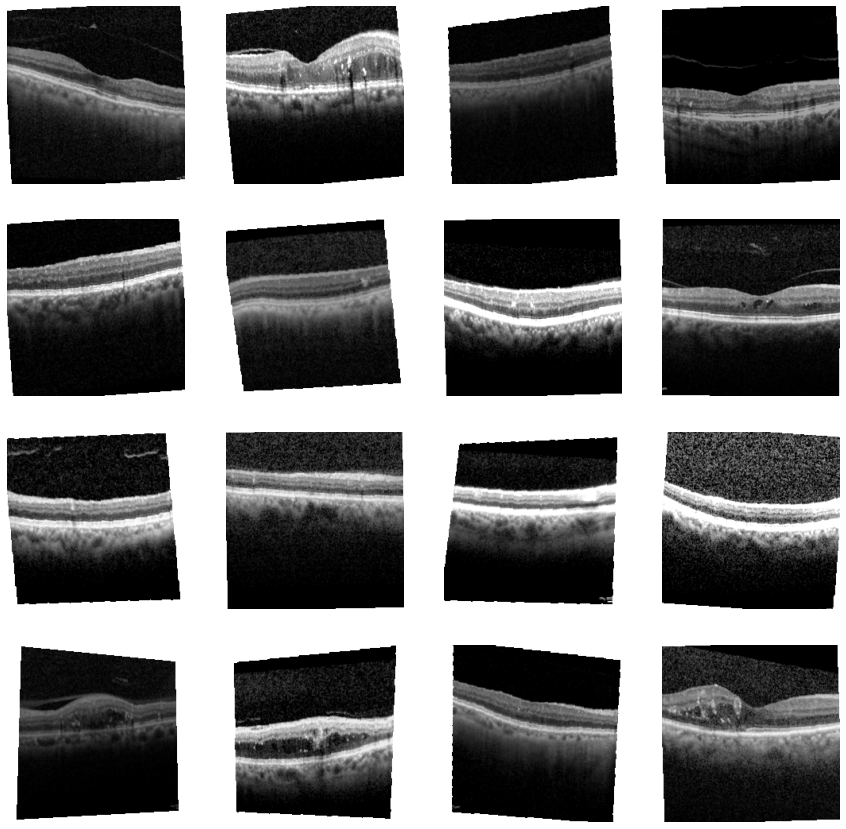

In [24]:
# Plot more images
torch.manual_seed(SEED+1)
fig = plt.figure(figsize=(15, 15))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_dataset), size=[1]).item()
    img, label = train_dataset[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.axis(False);

# Validation Data

In [25]:
val_df["File_Path"] = "TRAIN/OLIVES" + val_df["File_Path"]
val_df

File_Path  B1  B2  B3  B4  B5  \
0     TRAIN/OLIVES/TREX DME/GILA/0201GOD/V1/OD/TREXJ...   1   0   1   0   0   
1     TRAIN/OLIVES/TREX DME/GILA/0201GOD/V1/OD/TREXJ...   1   0   1   0   0   
2     TRAIN/OLIVES/TREX DME/GILA/0201GOD/V1/OD/TREXJ...   1   0   1   0   0   
3     TRAIN/OLIVES/TREX DME/GILA/0201GOD/V1/OD/TREXJ...   1   0   1   0   0   
4     TRAIN/OLIVES/TREX DME/GILA/0201GOD/V1/OD/TREXJ...   1   0   1   0   0   
...                                                 ...  ..  ..  ..  ..  ..   
9305      TRAIN/OLIVES/Prime_FULL/02-045/W104/OS/44.tif   1   0   0   0   0   
9306      TRAIN/OLIVES/Prime_FULL/02-045/W104/OS/45.tif   1   0   0   1   0   
9307      TRAIN/OLIVES/Prime_FULL/02-045/W104/OS/46.tif   1   0   0   0   0   
9308      TRAIN/OLIVES/Prime_FULL/02-045/W104/OS/47.tif   1   0   0   0   0   
9309      TRAIN/OLIVES/Prime_FULL/02-045/W104/OS/48.tif   1   0   0   1   0   

      B6  
0      1  
1      1  
2      1  
3      1  
4      0  
...   ..  
9305   0  
9306   0  
9307   0  
9308   0  
9309   0  

[1176 rows x 7 columns]

In [26]:
validation_dataset = OLIVES(val_df, transforms = val_transform)
validation_loader = torch.utils.data.DataLoader(
        validation_dataset, batch_size=1, shuffle=False,
        num_workers=0, pin_memory=True)

# Traing pseudo labels with random weight

# Model 

In [27]:
model = torchvision.models.resnet50(weights=None,zero_init_residual=True)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Identity(),
    nn.Sequential(
        nn.Linear(2048, 512),
        nn.Linear(512, 6)
    )
)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model = model.to(device)

# Criterion, Optimizer

In [28]:
import torch
pos_weight_one = 3067/6371
pos_weight_two = 6424/2984
pos_weight_three = 4186/5222
pos_weight_four = 6572/2836
pos_weight_five = 6405/3003
pos_weight_six = 5320/4088
pos_weight = torch.tensor([pos_weight_one, pos_weight_two, pos_weight_three, pos_weight_four, pos_weight_five, pos_weight_six])

In [29]:
criterion = torch.nn.BCEWithLogitsLoss(pos_weight = pos_weight)
criterion = criterion.to(device)

optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-4)

# Balanced accuracy score

In [30]:
from sklearn.metrics import balanced_accuracy_score

def compute_balanced_accuracy(truths, outputs):
    
    return [
        round(balanced_accuracy_score(y_true, y_pred), 4)
        for y_true, y_pred in zip(truths, outputs)
    ]

In [31]:
def compute_accuracy_score(truths, outputs):
    
    return [
        round(accuracy_score(y_true, y_pred), 4)
        for y_true, y_pred in zip(truths, outputs)
    ]

In [32]:
def compute_sensitivity(truths, outputs):
    return [[
        round(metrics.recall_score(y_true, y_pred), 4)
        for y_true, y_pred in zip(truths, outputs)
    ]]

In [33]:
def compute_specificity(truths, outputs):
    return [[
        round(metrics.recall_score(y_true, y_pred, pos_label=0), 4)
        for y_true, y_pred in zip(truths, outputs)
    ]]

In [34]:
def custom_metric(x, y):
    x = np.transpose(x)
    y = np.transpose(y)
    
    return [
        round((2*(a*b)/(a+b)).item(), 4)
        for a, b in zip(x, y)
    ]

# Training

In [35]:
from pathlib import Path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True)

In [36]:
# training routine
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

epochs = 60
t_loss = []
v_loss = []
accur = []
bal_accur = []
custom = []
s1 = []
s2 = []
for epoch in range(1, epochs + 1):
    # train
    model.train()
    #classifier.train()
    Train_losses = AverageMeter()
    
    for idx, (image, bio_tensor) in enumerate(train_loader):
        images = image.to(device)

        labels = bio_tensor.float()

        labels = labels.to(device)
        bsz = labels.shape[0]

        # compute loss


        #features = model(images)
        output = model(images)
        
        loss = criterion(output, labels)
        
        # update metric
        Train_losses.update(loss.item(), bsz)

        # SGD
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    Val_losses = AverageMeter()
    y_true = []
    y_pred = []
    model.eval()
    #classifier.eval()    
    for idx, (image, bio_tensor) in enumerate(validation_loader):
        # Validation

        with torch.inference_mode():
            images = image.to(device)

            labels = bio_tensor.float()

            labels = labels.to(device)
            bsz = labels.shape[0]

            # compute loss


            #features = model(images)
            output = model(images)
            loss = criterion(output, labels)
            
            
            output = torch.round(torch.sigmoid(output))
            output = output.squeeze().detach().cpu().numpy()
            labels = labels.squeeze().detach().cpu().numpy()
            y_true.append(labels)
            y_pred.append(output)
            Val_losses.update(loss.item(), bsz)
    
    test_true = np.transpose(y_true)
    test_pred = np.transpose(y_pred)
    acc = compute_accuracy_score(test_true, test_pred)
    balanced_acc = compute_balanced_accuracy(test_true, test_pred)
    sen = compute_sensitivity(test_true, test_pred)
    spe = compute_specificity(test_true, test_pred)
    cus_met = custom_metric(sen, spe)
    
    t_loss.append(Train_losses.avg)
    v_loss.append(Val_losses.avg)
    accur.append(np.mean(acc))
    bal_accur.append(np.mean(balanced_acc))
    custom.append(np.mean(cus_met))
    s1.append(np.mean(sen))
    s2.append(np.mean(spe))
    print('-' * 10)
    print(f"{epoch}/{epochs}")
    print(f"Train loss: {Train_losses.avg:.5f} | Validation loss: {Val_losses.avg:.5f}")
    print(f"Accuracy: {acc} | Mean Accuracy: {np.mean(acc):.5f}")       
    print("Balanced acc (val): {} | Mean Balanced acc (val): {:.4f}".format(balanced_acc, np.mean(balanced_acc)))
    print(f"Sensitivity: {sen} | Mean Sensitivity: {np.mean(sen):.5f}")
    print(f"Specificity: {spe} | Mean Specificity: {np.mean(spe):.5f}")
    print(f"Custom Metric: {cus_met} | Mean Custom Metric: {np.mean(cus_met):.5f}")
    print('-' * 10)
    if epoch % 1 == 0:
        MODEL_NAME = f"18_vip_cup_student_two_pretrain_random_weight_epoch_{epoch}.pth"
        MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
        state = {'model': model.state_dict(),
                 'optimizer': optimizer.state_dict(),
                 'epoch': epoch,
                }
        # Save the model state dict
        print(f"Saving model to: {MODEL_SAVE_PATH}")
        torch.save(state,
                   f=MODEL_SAVE_PATH)
        del state      

----------
1/60
Train loss: 0.69464 | Validation loss: 1.04673
Accuracy: [0.7636, 0.3129, 0.5536, 0.2815, 0.5493, 0.659] | Mean Accuracy: 0.51998
Balanced acc (val): [0.683, 0.5, 0.5551, 0.5, 0.6733, 0.6835] | Mean Balanced acc (val): 0.5992
Sensitivity: [[0.8909, 1.0, 0.4024, 1.0, 0.9916, 0.9608]] | Mean Sensitivity: 0.87428
Specificity: [[0.475, 0.0, 0.7079, 0.0, 0.355, 0.4062]] | Mean Specificity: 0.32402
Custom Metric: [0.6196, 0.0, 0.5131, 0.0, 0.5228, 0.571] | Mean Custom Metric: 0.37108
----------
Saving model to: models\18_vip_cup_student_two_pretrain_random_weight_epoch_1.pth
----------
2/60
Train loss: 0.50742 | Validation loss: 0.69434
Accuracy: [0.7296, 0.6454, 0.5357, 0.4728, 0.7534, 0.8571] | Mean Accuracy: 0.66567
Balanced acc (val): [0.7757, 0.5725, 0.533, 0.6001, 0.803, 0.8594] | Mean Balanced acc (val): 0.6906
Sensitivity: [[0.6569, 0.3777, 0.7997, 0.8912, 0.9304, 0.8843]] | Mean Sensitivity: 0.75670
Specificity: [[0.8944, 0.7673, 0.2663, 0.3089, 0.6756, 0.8344]] | Me

----------
15/60
Train loss: 0.14097 | Validation loss: 1.15956
Accuracy: [0.744, 0.6224, 0.6922, 0.4957, 0.784, 0.8656] | Mean Accuracy: 0.70065
Balanced acc (val): [0.7845, 0.7178, 0.6939, 0.6261, 0.8266, 0.8647] | Mean Balanced acc (val): 0.7523
Sensitivity: [[0.6801, 0.9728, 0.5253, 0.9245, 0.9359, 0.8545]] | Mean Sensitivity: 0.81552
Specificity: [[0.8889, 0.4629, 0.8625, 0.3278, 0.7173, 0.875]] | Mean Specificity: 0.68907
Custom Metric: [0.7706, 0.6273, 0.6529, 0.484, 0.8121, 0.8646] | Mean Custom Metric: 0.70192
----------
Saving model to: models\18_vip_cup_student_two_pretrain_random_weight_epoch_15.pth
----------
16/60
Train loss: 0.13517 | Validation loss: 0.81450
Accuracy: [0.6922, 0.6939, 0.7304, 0.659, 0.8308, 0.8827] | Mean Accuracy: 0.74817
Balanced acc (val): [0.7642, 0.7661, 0.731, 0.6975, 0.8493, 0.8767] | Mean Balanced acc (val): 0.7808
Sensitivity: [[0.5784, 0.9592, 0.6734, 0.7855, 0.8969, 0.8097]] | Mean Sensitivity: 0.78385
Specificity: [[0.95, 0.573, 0.7887, 0.60

----------
29/60
Train loss: 0.10168 | Validation loss: 0.94846
Accuracy: [0.7602, 0.7279, 0.7483, 0.5961, 0.824, 0.8861] | Mean Accuracy: 0.75710
Balanced acc (val): [0.8039, 0.7605, 0.7483, 0.673, 0.8413, 0.8832] | Mean Balanced acc (val): 0.7850
Sensitivity: [[0.6912, 0.8478, 0.7492, 0.8489, 0.8858, 0.8507]] | Mean Sensitivity: 0.81227
Specificity: [[0.9167, 0.6733, 0.7474, 0.497, 0.7968, 0.9156]] | Mean Specificity: 0.75780
Custom Metric: [0.7881, 0.7505, 0.7483, 0.6269, 0.8389, 0.882] | Mean Custom Metric: 0.77245
----------
Saving model to: models\18_vip_cup_student_two_pretrain_random_weight_epoch_29.pth
----------
30/60
Train loss: 0.09659 | Validation loss: 0.86465
Accuracy: [0.767, 0.7185, 0.7509, 0.6105, 0.8291, 0.8895] | Mean Accuracy: 0.76092
Balanced acc (val): [0.8088, 0.773, 0.7512, 0.6978, 0.8497, 0.8849] | Mean Balanced acc (val): 0.7942
Sensitivity: [[0.701, 0.9185, 0.7138, 0.8973, 0.9025, 0.834]] | Mean Sensitivity: 0.82785
Specificity: [[0.9167, 0.6275, 0.7887, 0.4

----------
43/60
Train loss: 0.08208 | Validation loss: 1.10874
Accuracy: [0.7662, 0.6862, 0.7262, 0.6012, 0.8478, 0.8741] | Mean Accuracy: 0.75028
Balanced acc (val): [0.8004, 0.7606, 0.7272, 0.6811, 0.8467, 0.8657] | Mean Balanced acc (val): 0.7803
Sensitivity: [[0.712, 0.9592, 0.6279, 0.864, 0.844, 0.7705]] | Mean Sensitivity: 0.79627
Specificity: [[0.8889, 0.5619, 0.8265, 0.4982, 0.8494, 0.9609]] | Mean Specificity: 0.76430
Custom Metric: [0.7907, 0.7087, 0.7136, 0.632, 0.8467, 0.8552] | Mean Custom Metric: 0.75782
----------
Saving model to: models\18_vip_cup_student_two_pretrain_random_weight_epoch_43.pth
----------
44/60
Train loss: 0.08006 | Validation loss: 0.98169
Accuracy: [0.7534, 0.7007, 0.7415, 0.6284, 0.8478, 0.8767] | Mean Accuracy: 0.75808
Balanced acc (val): [0.8006, 0.7718, 0.7421, 0.712, 0.8506, 0.8682] | Mean Balanced acc (val): 0.7909
Sensitivity: [[0.6789, 0.962, 0.6818, 0.9033, 0.8579, 0.7724]] | Mean Sensitivity: 0.80938
Specificity: [[0.9222, 0.5817, 0.8024, 0

----------
57/60
Train loss: 0.06940 | Validation loss: 1.15982
Accuracy: [0.7832, 0.801, 0.8061, 0.6182, 0.8231, 0.8801] | Mean Accuracy: 0.78528
Balanced acc (val): [0.8189, 0.813, 0.805, 0.6893, 0.8493, 0.8777] | Mean Balanced acc (val): 0.8089
Sensitivity: [[0.7267, 0.8451, 0.9158, 0.852, 0.9164, 0.8507]] | Mean Sensitivity: 0.85112
Specificity: [[0.9111, 0.7809, 0.6942, 0.5266, 0.7821, 0.9047]] | Mean Specificity: 0.76660
Custom Metric: [0.8085, 0.8117, 0.7897, 0.6509, 0.8439, 0.8769] | Mean Custom Metric: 0.79693
----------
Saving model to: models\18_vip_cup_student_two_pretrain_random_weight_epoch_57.pth
----------
58/60
Train loss: 0.06678 | Validation loss: 0.93463
Accuracy: [0.7789, 0.7976, 0.784, 0.6429, 0.8563, 0.8878] | Mean Accuracy: 0.79125
Balanced acc (val): [0.8197, 0.8083, 0.7832, 0.7267, 0.8638, 0.882] | Mean Balanced acc (val): 0.8140
Sensitivity: [[0.7145, 0.837, 0.8653, 0.9184, 0.883, 0.8172]] | Mean Sensitivity: 0.83923
Specificity: [[0.925, 0.7797, 0.701, 0.534

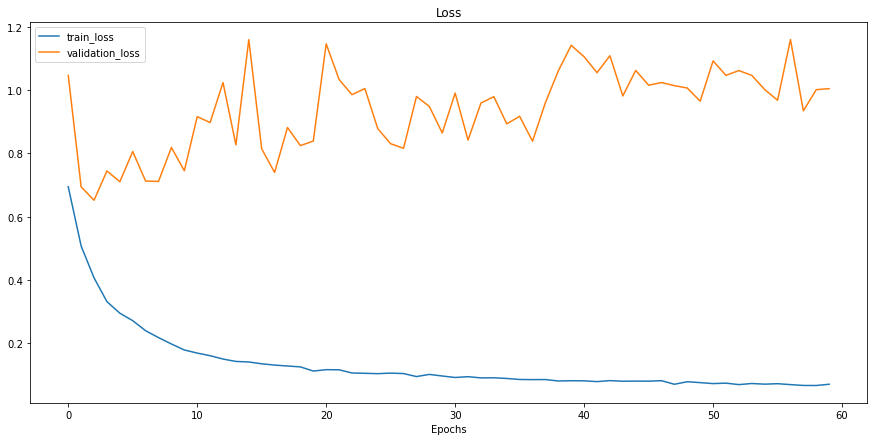

In [37]:
plt.figure(figsize=(15, 7))

    # Plot loss
plt.plot(range(len(t_loss)), t_loss, label='train_loss')
plt.plot(range(len(v_loss)), v_loss, label='validation_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

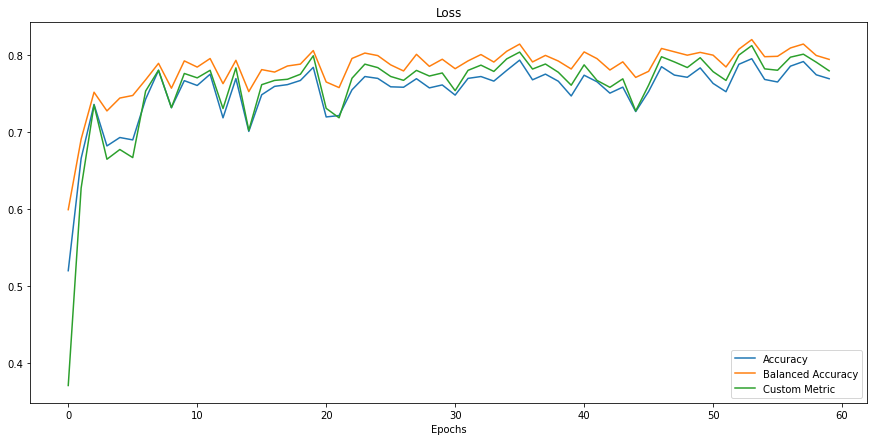

In [38]:
plt.figure(figsize=(15, 7))
    # Plot loss
plt.plot(range(len(accur)), accur, label='Accuracy')
plt.plot(range(len(bal_accur)), bal_accur, label='Balanced Accuracy')
plt.plot(range(len(custom)), custom, label='Custom Metric')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

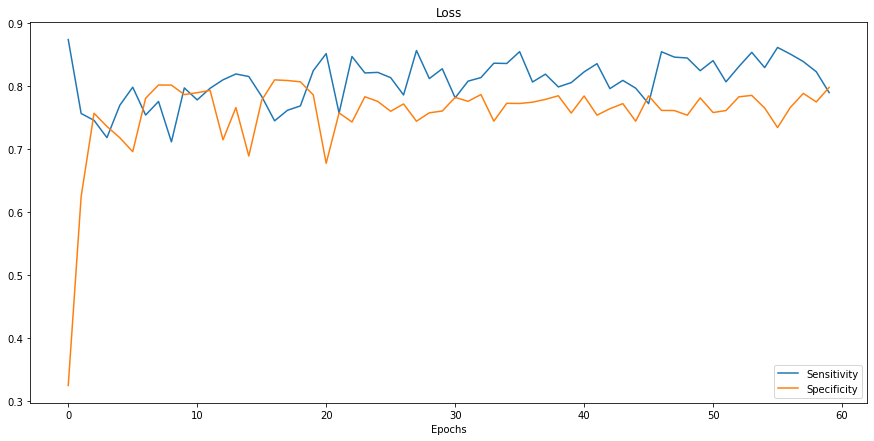

In [39]:
plt.figure(figsize=(15, 7))
    # Plot loss
plt.plot(range(len(s1)), s1, label='Sensitivity')
plt.plot(range(len(s2)), s2, label='Specificity')
#plt.plot(range(len(custom)), custom, label='Custom Metric')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

In [93]:
ckpt = torch.load("models/16_vip_cup_student_two_pretrain_random_weight_epoch_28.pth", map_location='cpu')
state_dict = ckpt['model']

model.load_state_dict(state_dict)
model = model.to(device)
model.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[ 0.0251, -0.0307,  0.1500,  ...,  0.0558,  0.1169,  0.1356],
                        [-0.0240,  0.1708, -0.0463,  ...,  0.0208,  0.1744, -0.0399],
                        [-0.0963,  0.1135,  0.0010,  ..., -0.0022, -0.1536, -0.0425],
                        ...,
                        [-0.0896, -0.1234, -0.0372,  ...,  0.0605, -0.1735, -0.1436],
                        [ 0.0208, -0.0741, -0.0580,  ..., -0.0273, -0.0323, -0.0227],
                        [ 0.0818,  0.1680,  0.0741,  ...,  0.1484,  0.0834,  0.1097]]],
              
              
                      [[[-0.0704,  0.0048, -0.0690,  ...,  0.0216, -0.0976,  0.0065],
                        [-0.0534, -0.0252,  0.0057,  ..., -0.1005, -0.1660, -0.0070],
                        [-0.0691,  0.0808, -0.1317,  ...,  0.0219,  0.0556,  0.0887],
                        ...,
                        [-0.0126,  0.0008,  0.1103,  ...,  0.1047,  0.1525,  0.0072],
                    

In [94]:
test_csv_path = 'TEST/test_set_submission_template.csv'
test_image_path = 'TEST/'

In [95]:
class RECOVERY(data.Dataset):
    def __init__(self,df, img_dir, transforms):
        self.img_dir = img_dir
        self.transforms = transforms
        self.df = pd.read_csv(df)
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = os.path.join(self.img_dir, self.df.iloc[idx, 0])
        path = self.img_dir + self.df.iloc[idx,0]
        image = Image.open(path).convert("L")
        image = np.array(image)
        image = Image.fromarray(image)
        image = self.transforms(image)
        return image, idx

In [96]:
test_dataset = RECOVERY(test_csv_path, test_image_path, val_transform)
test_dataloader = data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0, pin_memory=True,drop_last=False)

In [97]:
submission = pd.read_csv(test_csv_path)

In [98]:
model.eval()
with torch.no_grad():
    for idx, (image, index) in (enumerate(test_dataloader)):
        images = image.float().to(device)
        output = model(images)
        output = torch.round(torch.sigmoid(output))
        output = output.squeeze().cpu().numpy()
        index = int(index.numpy()[0])
        submission.iloc[index, 1:] = output

In [99]:
submission.to_csv('sub_sixt_two_pre.csv', index=None)